In [1]:
import numpy as np
import gym_minatar

# Generic replay buffer for standard gym tasks
class TaskBuffer(object):
    def __init__(self, state_shape, sf_dim, buffer_size, device):
        self.max_size = int(buffer_size)
        self.device = device

        self.ptr = 0
        self.crt_size = 0

        self.state = np.zeros((self.max_size, *state_shape))
        self.action = np.zeros((self.max_size, 1))
        self.next_state = np.zeros((self.max_size, *state_shape))
        # self.next_state = np.array(self.state)
        self.reward = np.zeros((self.max_size, 1))
        self.not_done = np.zeros((self.max_size, 1))
        self.task = np.zeros((self.max_size, sf_dim))


    def add(self, state, action, next_state, reward, done, task):
        self.state[self.ptr] = state
        self.action[self.ptr] = action
        self.next_state[self.ptr] = next_state
        self.reward[self.ptr] = reward
        self.not_done[self.ptr] = 1. - done
        self.task[self.ptr] = task

        self.ptr = (self.ptr + 1) % self.max_size
        self.crt_size = min(self.crt_size + 1, self.max_size)

    def sample(self, batch_size=32):
        ind = np.random.randint(0, self.crt_size, size=batch_size)
        return (
            torch.FloatTensor(self.state[ind]).to(self.device),
            torch.LongTensor(self.action[ind]).to(self.device),
            torch.FloatTensor(self.next_state[ind]).to(self.device),
            torch.FloatTensor(self.reward[ind]).to(self.device),
            torch.FloatTensor(self.not_done[ind]).to(self.device),
            torch.FloatTensor(self.task[ind]).to(self.device),
        )


    def save(self, save_folder):
        np.save(f"{save_folder}_state.npy", self.state[:self.crt_size])
        np.save(f"{save_folder}_action.npy", self.action[:self.crt_size])
        np.save(f"{save_folder}_next_state.npy", self.next_state[:self.crt_size])
        np.save(f"{save_folder}_reward.npy", self.reward[:self.crt_size])
        np.save(f"{save_folder}_not_done.npy", self.not_done[:self.crt_size])
        np.save(f"{save_folder}_task.npy", self.task[:self.crt_size])
        np.save(f"{save_folder}_ptr.npy", self.ptr)


    def load(self, save_folder, size=-1):
        reward_buffer = np.load(f"{save_folder}_reward.npy")

        # Adjust crt_size if we're using a custom size
        size = min(int(size), self.max_size) if size > 0 else self.max_size
        self.crt_size = min(reward_buffer.shape[0], size)

        self.state[:self.crt_size] = np.load(f"{save_folder}_state.npy")[:self.crt_size]
        self.action[:self.crt_size] = np.load(f"{save_folder}_action.npy")[:self.crt_size]
        self.next_state[:self.crt_size] = np.load(f"{save_folder}_next_state.npy")[:self.crt_size]
        self.reward[:self.crt_size] = reward_buffer[:self.crt_size]
        self.not_done[:self.crt_size] = np.load(f"{save_folder}_not_done.npy")[:self.crt_size]
        self.task[:self.crt_size] = np.load(f"{save_folder}_task.npy")[:self.crt_size]
        print(f"Replay Buffer loaded with {self.crt_size} elements.")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import copy
from tqdm import tqdm
from dqn import DQN, Phi, Critic
import gym

class ConvEncoder(nn.Module):
    def __init__(
        self,
        state_shape, # ex (4, 84, 84), (3, 7, 7)
        latent_dim,
    ):
        super().__init__()
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.state_shape = state_shape
        self.latent_dim = latent_dim
        
        def make_dummy_conv():
            encoder = nn.Linear(self.state_shape[0], self.latent_dim).to(device)
            return encoder
            
        def make_conv():
            conv = nn.Sequential(nn.Conv2d(state_shape[0], 32, 3, stride=1),
                                     nn.ReLU(), nn.Conv2d(32, 16, 3, stride=1),
                                     nn.ReLU()).to(device)
            sample = torch.zeros(1, *state_shape).to(device)
            size = torch.flatten(conv(sample)).shape[-1]
            encoder = nn.Sequential(conv, nn.Flatten(), nn.Linear(size, self.latent_dim), nn.ReLU()).to(device)
            return encoder
        
        if len(self.state_shape) < 2:
            self.encoder = make_dummy_conv()
        else:
            self.encoder = make_conv()
            
    def forward(self, state):
        return self.encoder(state)
    

class RMS(object):
    """running mean and std """
    def __init__(self, device, epsilon=1e-4, shape=(1,)):
        self.M = torch.zeros(shape).to(device)
        self.S = torch.ones(shape).to(device)
        self.n = epsilon

    def __call__(self, x):
        bs = x.size(0)
        delta = torch.mean(x, dim=0) - self.M
        new_M = self.M + delta * bs / (self.n + bs)
        new_S = (self.S * self.n + torch.var(x, dim=0) * bs +
                 torch.square(delta) * self.n * bs /
                 (self.n + bs)) / (self.n + bs)

        self.M = new_M
        self.S = new_S
        self.n += bs

        return self.M, self.S
    
class PBE(object):
    """particle-based entropy based on knn normalized by running mean """
    def __init__(self, rms, knn_clip, knn_k, knn_avg, knn_rms, device):
        self.rms = rms
        self.knn_rms = knn_rms
        self.knn_k = knn_k
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.device = device

    def __call__(self, rep):
        source = target = rep
        b1, b2 = source.size(0), target.size(0)
        # (b1, 1, c) - (1, b2, c) -> (b1, 1, c) - (1, b2, c) -> (b1, b2, c) -> (b1, b2)
        sim_matrix = torch.norm(source[:, None, :].view(b1, 1, -1) -
                                target[None, :, :].view(1, b2, -1),
                                dim=-1,
                                p=2)
        reward, _ = sim_matrix.topk(self.knn_k,
                                    dim=1,
                                    largest=False,
                                    sorted=True)  # (b1, k)
        if not self.knn_avg:  # only keep k-th nearest neighbor
            reward = reward[:, -1]
            reward = reward.reshape(-1, 1)  # (b1, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(self.device)
            ) if self.knn_clip >= 0.0 else reward  # (b1, 1)
        else:  # average over all k nearest neighbors
            reward = reward.reshape(-1, 1)  # (b1 * k, 1)
            reward /= self.rms(reward)[0] if self.knn_rms else 1.0
            reward = torch.maximum(
                reward - self.knn_clip,
                torch.zeros_like(reward).to(
                    self.device)) if self.knn_clip >= 0.0 else reward
            reward = reward.reshape((b1, self.knn_k))  # (b1, k)
            reward = reward.mean(dim=1, keepdim=True)  # (b1, 1)
        reward = torch.log(reward + 1.0)
        return reward
    
    
class IdentityPhi(nn.Module):
    def __init__(
        self,
        latent_dim,
        hidden_dim,
        sf_dim,
    ):
        super().__init__()
        self.fc1 = nn.Linear(1, 1)
    
    def forward(self, latent, norm=True):
        return F.normalize(latent, dim=-1)
    
class MiniAtarWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        # self.observation_space = gym.spaces.Box(low=np.zeros((1, 13, 13)), high=np.ones((1, 13, 13)), dtype=np.uint8)
        # self.observation_space = gym.spaces.Box(low=np.zeros((7, 10, 10)), high=np.ones((7, 10, 10)), dtype=np.float32)
        size = env.observation_space.shape[-1]
        self.size = size
        low = env.observation_space.low.reshape((size, 10, 10))
        high = env.observation_space.high.reshape((size, 10, 10))
        dtype = env.observation_space.dtype
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=dtype)
    
    def observation(self, state):
        return state.transpose(2, 0, 1)

class GridAPS(DQN):
    def __init__(
        self,
        env,
        conv=True,
        discount=0.99,
        lr_critic=1e-4,
        lr_encoder=1e-4, 
        latent_dim=256,
        hidden_dim=256,
        initial_eps=1,
        end_eps=0.1,
        eval_eps=0.1,
        pretrain_eps=1,
        eps_decay_period=int(2e4),
        target_update_frequency=200,
        double_q=False,
        # the following are variables for APS
        sf_dim=169,
        lr_phi=1e-4,
        lr_task=1e-4,
        update_task_frequency=5,
        knn_k=12,
        knn_rms=True,
        knn_avg=True,
        knn_clip=1e-4,
    ):
        # for APS 
        self.sf_dim = sf_dim
        self.lr_phi = lr_phi
        self.lr_task = lr_task
        self.update_task_frequency = update_task_frequency
        self.knn_k = knn_k
        self.knn_rms = knn_rms
        self.knn_avg = knn_avg
        self.knn_clip = knn_clip
        self.temp_task = None # temp tasks are set through function : set_task
        
        super().__init__(
            env=MiniAtarWrapper(env),
            conv=conv,
            discount=discount,
            lr_critic=lr_critic,
            lr_encoder=lr_encoder,
            latent_dim=latent_dim,
            hidden_dim=hidden_dim,
            initial_eps=initial_eps,
            end_eps=end_eps,
            eval_eps=eval_eps,
            pretrain_eps=pretrain_eps,
            eps_decay_period=eps_decay_period,
            target_update_frequency=target_update_frequency,
            double_q=double_q,
        )
        
    def _make_alias(self):
        self.SF1 = self.critic.get_SF1
        self.SF = self.critic.get_SFs
        self.SF1_target = self.critic_target.get_SF1
        self.SF_target = self.critic_target.get_SFs
        
        # to get Q's, one need 'task' (a k-dim vector)
        self.Q1 = self.critic.get_Q1
        self.Q = self.critic.get_Qs
        self.Q1_target = self.critic_target.get_Q1
        self.Q_target = self.critic_target.get_Qs
        
    def _define_networks(self):
        self.encoder = ConvEncoder(
            state_shape=self.state_shape,
            latent_dim=self.latent_dim,
        )
        
        self.phi = Phi(
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            sf_dim=self.sf_dim,
        )

        
        self.critic = Critic(
            latent_dim=self.latent_dim + self.sf_dim, # input is cat([latent, task])
            hidden_dim=self.hidden_dim, 
            num_actions=self.num_actions,
            sf_dim=self.sf_dim
        )
        self.critic_target = copy.deepcopy(self.critic)
        
        self.RMS = RMS(self.device)
        self.PBE = PBE(
            rms=self.RMS, 
            knn_clip=self.knn_clip, 
            knn_k=self.knn_k, 
            knn_avg=self.knn_avg, 
            knn_rms=self.knn_rms,
            device=self.device
        )
        
        self.encoder_opt = torch.optim.Adam(self.encoder.parameters(), lr=self.lr_encoder)
        self.phi_opt = torch.optim.Adam(self.phi.parameters(), lr=self.lr_phi)
        self.critic_opt = torch.optim.Adam(self.critic.parameters(), lr=self.lr_critic)
        
        self.task_learned = True
        self.task = torch.ones((1, self.sf_dim), requires_grad=True, device=self.device) # task is only for RL phase (supervised learning phase)
        self.task_opt = torch.optim.Adam([self.task], lr=self.lr_task)
        
    def set_fine_tuning(self): # follow the hyperparameters that APS paper provide
        self.task_opt = torch.optim.Adam([self.task], lr=1e-3)
        self.critic_opt = torch.optim.Adam(self.critic_parameters(), lr=1e-3)
        self.phi_opt = None
        self.encoder_opt = None
        
    def intrinsic_reward(self, task, next_latent):
        # maxent reward
        with torch.no_grad():
            state_representation = self.phi(next_latent, norm=False)
        bonus = self.PBE(state_representation)
        ent_bonus = bonus.view(-1, 1)

        # successor feature reward
        state_representation = state_representation / torch.norm(state_representation, dim=1, keepdim=True)
        sf_reward = torch.einsum("bi,bi->b", task, state_representation).reshape(-1, 1)

        return ent_bonus, sf_reward
    
    def maybe_set_task(self, fine_tune):
        if fine_tune:
            return self.task
        elif (self.iterations + 1) % self.update_task_frequency:
            return self.set_task()
        
        return self.temp_task
    
    def set_task(self):
        task = torch.randn(self.sf_dim).to(self.device)
        task = task / torch.norm(task)
        self.temp_task = task
        return task
    
    def visualize_representation(self, state):
        # state needs to be a numpy array
        state = torch.from_numpy(state).unsqueeze(0).to(self.device)
        out = self.phi(self.encoder(state))
        return out.cpu().data.numpy()
    
    def make_replay_buffer(self, buffer_size=int(3e5)):
        return TaskBuffer(self.state_shape, self.sf_dim, buffer_size, self.device)
        
    def select_action(self, state, task, eval=False, pretrain=True):
        # this function affects evaluation funciton
        if eval: # if eval, we don't care if we are pretraining or not
            eps = self.eval_eps
        elif pretrain: # if pretrain, we use pretrain eps
            eps = self.pretrain_eps
        else:
            eps = max(self.slope * self.iterations + self.initial_eps, self.end_eps)

        # Select action according to policy with probability (1-eps)
        # otherwise, select random action
        if np.random.uniform(0,1) > eps:
            with torch.no_grad():
                state = torch.FloatTensor(state).reshape(self.state_shape).unsqueeze(0).to(self.device)                    
                if type(task) == np.ndarray:
                    task = torch.from_numpy(task).to(self.device)
                task = task.float().view(1, task.shape[-1])
                
                latent = self.encoder(state)
                
                # cat latent and task for universal successor feature
                latent = torch.cat([latent, task], dim=1)
                return int(self.Q1(latent, task).argmax(1))
        else:
            return np.random.randint(self.num_actions)
    
    def train(self, replay_buffer, batch_size=128, fine_tune=False):
        state, action, next_state, reward, not_done, task = replay_buffer.sample(batch_size=batch_size)
        
        latent = self.encoder(state)
        next_latent = self.encoder(next_state)
        
        # calculate the adjusted reward
        if fine_tune:
            reward = reward # even when we are finetuning, use the task got from the replay_buffer
            # task = self.task.repeat(batch_size, 1) # use the regressed task
        else:
            with torch.no_grad():
                ent_bonus, sf_reward = self.intrinsic_reward(task, next_latent)
                aps_reward = ent_bonus + sf_reward
                reward = aps_reward
            # calculte Phi-loss
            phi_loss = - torch.einsum("bi,bi->b", self.phi(next_latent), task).mean()
            # update Phi and Encoder
            self.encoder_opt.zero_grad()
            self.phi_opt.zero_grad()
            phi_loss.backward()
            self.encoder_opt.step()
            self.phi_opt.step()
        
        
        # cat latent and task, for universal SF approximator
        # we don't update encoder based on Q-loss
        latent = torch.cat([latent, task], dim=1).detach()
        next_latent = torch.cat([next_latent, task], dim=1).detach()
        
        # calculate Q-loss
        with torch.no_grad():
            next_action = self.Q1(next_latent, task).argmax(1, keepdim=True)
            if self.double_q:
                target_Q1, target_Q2 = self.Q_target(next_latent, task)
                target_Q1, target_Q2 = (
                    target_Q1.gather(1, next_action).view(-1, 1),
                    target_Q2.gather(1, next_action).view(-1, 1)
                )
                target_Q = torch.min(target_Q1, target_Q2)
            else:
                target_Q = self.Q1_target(next_latent, task).gather(1, next_action).view(-1, 1)
            
            # print(f'reward : {reward}, not_done : {not_done}, next_action :{next_action}, target_Q : {target_Q}')
            target_Q = reward + not_done * self.discount * target_Q
            
        
        if self.double_q:
            Q1, Q2 = self.Q(latent, task)
            Q1, Q2 = (
                Q1.gather(1, action).view(-1, 1),
                Q2.gather(1, action).view(-1, 1)
            )
            
            Q_loss = F.mse_loss(Q1, target_Q) + F.mse_loss(Q2, target_Q)
        else:
            Q = self.Q1(latent, task).gather(1, action).view(-1, 1)
            Q_loss = F.mse_loss(Q, target_Q)
        
        # update Q-networks
        # print(f'Q-loss : {Q_loss}, Q : {Q}, Q_target : {target_Q}')
        # print(Q_loss.mean())
        self.critic_opt.zero_grad()
        Q_loss.backward()
        self.critic_opt.step()
        
        # train the task
        # self.regress_task(replay_buffer, 256, 1)
        self.maybe_regress_task(replay_buffer, 256, 1)
        
        # update target network
        self.copy_target_update()
        
    def maybe_regress_task(self, replay_buffer, batch_size, epoch_size=1):
        if replay_buffer.crt_size > 4096 and self.iterations % self.update_task_frequency == 0:
            self.regress_task(replay_buffer, batch_size, epoch_size)
        
    def regress_task(self, replay_buffer, batch_size=32, epoch_size=1):
        # there are two options, one is using gradient descent, the other is using torch.linalg.lstsq
        self.task_learned = True
        for epoch in range(epoch_size):
            state, action, next_state, reward, *_ = replay_buffer.sample(batch_size=batch_size)
            with torch.no_grad():
                next_latent = self.encoder(next_state)
                # next_latent = self.encoder(state)
                representation = self.phi(next_latent)
                
            # estimate the reward
            estimated_reward = torch.einsum("bi,bi->b", representation, self.task.repeat(batch_size, 1)) # 256 by 169, 1 by 169
            
            # update the task
            task_loss = F.mse_loss(reward, estimated_reward)
            self.task_opt.zero_grad()
            task_loss.backward()
            self.task_opt.step()
                
    def learn(self, replay_buffer, step_size, learning_start=int(1e4), batch_size=32, fine_tune=False, log_freq=int(1e3)):
        if replay_buffer is None:
            replay_buffer = self.make_replay_buffer()
            
        state = self.env.reset()
        episodic_return = 0
        episode_length = 0
        episode_num = 0
        task = self.set_task()
        evaluations = []
        
        for step in tqdm(range(step_size)):
            if fine_tune:
                self.iterations += 1
            # pick action and transit in the env
            task = self.maybe_set_task(fine_tune)
            if step < learning_start:
                action = self.env.action_space.sample()
            else:
                action = self.select_action(state, task, eval=False, pretrain=(not fine_tune))
            next_state, reward, done, info = self.env.step(action)
            
            # add the experience into the buffer
            replay_buffer.add(state, action, next_state, reward, done, task.cpu().data.numpy())
            if replay_buffer.crt_size > learning_start:
                self.train(replay_buffer, batch_size=batch_size, fine_tune=fine_tune)
            
            # update iterative values
            state = next_state
            episodic_return += reward
            episode_length += 1
            
            # maybe evaluate
            if fine_tune and (step + 1) % log_freq == 0:
                evaluations.append(self.evaluate(fine_tune))
            
            # check if the episode ends
            if done:
                if fine_tune:
                    print(f"====== Total T: {step+1} Episode Num: {episode_num+1} Episode_Length T: {episode_length} Return: {episodic_return:.3f} ======")
                episode_num += 1
                state = self.env.reset()
                episodic_return = 0
                episode_length = 0
                
        return evaluations
    
    def evaluate(self, fine_tune, seed=0, eval_episodes=10):
        eval_env = copy.deepcopy(self.env)
        eval_env.seed(seed + 100)

        avg_reward = 0.
        task = self.maybe_set_task(fine_tune)
        for _ in range(eval_episodes):
            state, done = eval_env.reset(), False
            while not done:
                action = self.select_action(np.array(state), task, eval=True)
                state, reward, done, _ = eval_env.step(action)
                avg_reward += reward

        avg_reward /= eval_episodes

        print("---------------------------------------")
        print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
        print("---------------------------------------")
        return avg_reward

In [19]:
env.observation_space.shape

(10, 10, 10)

In [9]:
import gym_minatar
# env = FourRooms(config=2, layout='4rooms')
env = gym.make('SpaceInvaders-MinAtar-v0')
aps = GridAPS(
    env, 
    conv=False,
    pretrain_eps=0.1,
    eps_decay_period=int(2e5),
    double_q=False,
    sf_dim=5,
    latent_dim=256,
    update_task_frequency=5,
)

In [21]:
aps.encoder

ConvEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=576, out_features=256, bias=True)
    (3): ReLU()
  )
)

In [11]:
replay_buffer = aps.make_replay_buffer()
aps.learn(replay_buffer, step_size=int(1e6), batch_size=32, fine_tune=False, log_freq=int(1e5))

100%|██████████| 1000000/1000000 [5:27:48<00:00, 50.84it/s] 


[]

In [12]:
# ft_rp = aps.make_replay_buffer()
evaluations = aps.learn(
    ft_rp,
    step_size=int(5e5),
    learning_start=int(1e4),
    batch_size=32,
    fine_tune=True
)

  0%|          | 626/500000 [00:00<01:19, 6252.76it/s]

====== Total T: 57 Episode Num: 1 Episode_Length T: 57 Return: 4.000 ======
====== Total T: 113 Episode Num: 2 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 130 Episode Num: 3 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 147 Episode Num: 4 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 164 Episode Num: 5 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 191 Episode Num: 6 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 238 Episode Num: 7 Episode_Length T: 47 Return: 3.000 ======
====== Total T: 305 Episode Num: 8 Episode_Length T: 67 Return: 4.000 ======
====== Total T: 332 Episode Num: 9 Episode_Length T: 27 Return: 0.000 ======
====== Total T: 429 Episode Num: 10 Episode_Length T: 97 Return: 6.000 ======
====== Total T: 525 Episode Num: 11 Episode_Length T: 96 Return: 12.000 ======
====== Total T: 581 Episode Num: 12 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 667 Episode Num: 13 Episode_Length T: 86 Return: 2.000 ==

  0%|          | 1856/500000 [00:00<02:37, 3156.94it/s]

---------------------------------------
Evaluation over 10 episodes: 0.700
---------------------------------------
====== Total T: 1025 Episode Num: 21 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 1063 Episode Num: 22 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 1100 Episode Num: 23 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 1166 Episode Num: 24 Episode_Length T: 66 Return: 6.000 ======
====== Total T: 1271 Episode Num: 25 Episode_Length T: 105 Return: 6.000 ======
====== Total T: 1308 Episode Num: 26 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 1325 Episode Num: 27 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 1363 Episode Num: 28 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 1380 Episode Num: 29 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 1407 Episode Num: 30 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 1454 Episode Num: 31 Episode_Length T: 47 Return: 4.000 ======
====== Total T:

  1%|          | 2936/500000 [00:01<03:15, 2538.71it/s]

---------------------------------------
Evaluation over 10 episodes: 0.900
---------------------------------------
====== Total T: 2048 Episode Num: 41 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 2135 Episode Num: 42 Episode_Length T: 87 Return: 3.000 ======
====== Total T: 2181 Episode Num: 43 Episode_Length T: 46 Return: 6.000 ======
====== Total T: 2198 Episode Num: 44 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 2235 Episode Num: 45 Episode_Length T: 37 Return: 1.000 ======
====== Total T: 2421 Episode Num: 46 Episode_Length T: 186 Return: 8.000 ======
====== Total T: 2458 Episode Num: 47 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 2505 Episode Num: 48 Episode_Length T: 47 Return: 1.000 ======
====== Total T: 2679 Episode Num: 49 Episode_Length T: 174 Return: 10.000 ======
====== Total T: 2736 Episode Num: 50 Episode_Length T: 57 Return: 2.000 ======
====== Total T: 2802 Episode Num: 51 Episode_Length T: 66 Return: 7.000 ======
====== Total 

  1%|          | 3978/500000 [00:01<03:26, 2399.78it/s]

---------------------------------------
Evaluation over 10 episodes: 0.700
---------------------------------------
====== Total T: 3006 Episode Num: 56 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 3083 Episode Num: 57 Episode_Length T: 77 Return: 5.000 ======
====== Total T: 3129 Episode Num: 58 Episode_Length T: 46 Return: 1.000 ======
====== Total T: 3156 Episode Num: 59 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 3243 Episode Num: 60 Episode_Length T: 87 Return: 5.000 ======
====== Total T: 3260 Episode Num: 61 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 3327 Episode Num: 62 Episode_Length T: 67 Return: 3.000 ======
====== Total T: 3414 Episode Num: 63 Episode_Length T: 87 Return: 3.000 ======
====== Total T: 3431 Episode Num: 64 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 3449 Episode Num: 65 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 3466 Episode Num: 66 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 

  1%|          | 4392/500000 [00:02<05:33, 1488.12it/s]

---------------------------------------
Evaluation over 10 episodes: 0.700
---------------------------------------
====== Total T: 4102 Episode Num: 76 Episode_Length T: 107 Return: 9.000 ======
====== Total T: 4129 Episode Num: 77 Episode_Length T: 27 Return: 1.000 ======
====== Total T: 4146 Episode Num: 78 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 4163 Episode Num: 79 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 4181 Episode Num: 80 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 4198 Episode Num: 81 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 4296 Episode Num: 82 Episode_Length T: 98 Return: 6.000 ======
====== Total T: 4372 Episode Num: 83 Episode_Length T: 76 Return: 0.000 ======
====== Total T: 4389 Episode Num: 84 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 4475 Episode Num: 85 Episode_Length T: 86 Return: 2.000 ======
====== Total T: 4492 Episode Num: 86 Episode_Length T: 17 Return: 2.000 ======
====== Total T:

  1%|          | 5603/500000 [00:02<04:05, 2013.90it/s]

---------------------------------------
Evaluation over 10 episodes: 0.400
---------------------------------------
====== Total T: 5045 Episode Num: 95 Episode_Length T: 87 Return: 5.000 ======
====== Total T: 5062 Episode Num: 96 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 5079 Episode Num: 97 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 5096 Episode Num: 98 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 5114 Episode Num: 99 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 5190 Episode Num: 100 Episode_Length T: 76 Return: 6.000 ======
====== Total T: 5236 Episode Num: 101 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 5254 Episode Num: 102 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 5271 Episode Num: 103 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 5357 Episode Num: 104 Episode_Length T: 86 Return: 2.000 ======
====== Total T: 5384 Episode Num: 105 Episode_Length T: 27 Return: 1.000 ======
====== Tot

  1%|▏         | 6620/500000 [00:03<03:45, 2184.03it/s]

---------------------------------------
Evaluation over 10 episodes: 0.800
---------------------------------------
====== Total T: 6006 Episode Num: 117 Episode_Length T: 46 Return: 1.000 ======
====== Total T: 6023 Episode Num: 118 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 6100 Episode Num: 119 Episode_Length T: 77 Return: 2.000 ======
====== Total T: 6117 Episode Num: 120 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 6144 Episode Num: 121 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 6191 Episode Num: 122 Episode_Length T: 47 Return: 4.000 ======
====== Total T: 6229 Episode Num: 123 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 6246 Episode Num: 124 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 6284 Episode Num: 125 Episode_Length T: 38 Return: 2.000 ======
====== Total T: 6341 Episode Num: 126 Episode_Length T: 57 Return: 2.000 ======
====== Total T: 6369 Episode Num: 127 Episode_Length T: 28 Return: 2.000 ======
=====

  2%|▏         | 7623/500000 [00:03<03:36, 2271.71it/s]

---------------------------------------
Evaluation over 10 episodes: 0.700
---------------------------------------
====== Total T: 7010 Episode Num: 139 Episode_Length T: 56 Return: 4.000 ======
====== Total T: 7027 Episode Num: 140 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 7074 Episode Num: 141 Episode_Length T: 47 Return: 1.000 ======
====== Total T: 7091 Episode Num: 142 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 7137 Episode Num: 143 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 7242 Episode Num: 144 Episode_Length T: 105 Return: 7.000 ======
====== Total T: 7338 Episode Num: 145 Episode_Length T: 96 Return: 2.000 ======
====== Total T: 7355 Episode Num: 146 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 7382 Episode Num: 147 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 7399 Episode Num: 148 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 7497 Episode Num: 149 Episode_Length T: 98 Return: 10.000 ======
===

  2%|▏         | 8644/500000 [00:04<03:54, 2097.82it/s]

---------------------------------------
Evaluation over 10 episodes: 0.700
---------------------------------------
====== Total T: 8091 Episode Num: 158 Episode_Length T: 158 Return: 10.000 ======
====== Total T: 8167 Episode Num: 159 Episode_Length T: 76 Return: 6.000 ======
====== Total T: 8263 Episode Num: 160 Episode_Length T: 96 Return: 7.000 ======
====== Total T: 8280 Episode Num: 161 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 8317 Episode Num: 162 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 8383 Episode Num: 163 Episode_Length T: 66 Return: 3.000 ======
====== Total T: 8430 Episode Num: 164 Episode_Length T: 47 Return: 2.000 ======
====== Total T: 8447 Episode Num: 165 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 8464 Episode Num: 166 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 8501 Episode Num: 167 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 8597 Episode Num: 168 Episode_Length T: 96 Return: 5.000 ======
===

  2%|▏         | 9660/500000 [00:04<03:28, 2349.20it/s]

---------------------------------------
Evaluation over 10 episodes: 0.800
---------------------------------------
====== Total T: 9033 Episode Num: 176 Episode_Length T: 38 Return: 2.000 ======
====== Total T: 9079 Episode Num: 177 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 9096 Episode Num: 178 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 9231 Episode Num: 179 Episode_Length T: 135 Return: 5.000 ======
====== Total T: 9327 Episode Num: 180 Episode_Length T: 96 Return: 2.000 ======
====== Total T: 9345 Episode Num: 181 Episode_Length T: 18 Return: 1.000 ======
====== Total T: 9421 Episode Num: 182 Episode_Length T: 76 Return: 2.000 ======
====== Total T: 9468 Episode Num: 183 Episode_Length T: 47 Return: 4.000 ======
====== Total T: 9506 Episode Num: 184 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 9583 Episode Num: 185 Episode_Length T: 77 Return: 4.000 ======
====== Total T: 9639 Episode Num: 186 Episode_Length T: 56 Return: 8.000 ======
====

/home/mila/y/yiran.wang/.conda/envs/mujoco_env/lib/python3.7/site-packages/ipykernel_launcher.py:396: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  2%|▏         | 10065/500000 [00:05<06:39, 1225.43it/s]

====== Total T: 10107 Episode Num: 195 Episode_Length T: 126 Return: 6.000 ======
====== Total T: 10144 Episode Num: 196 Episode_Length T: 37 Return: 0.000 ======
====== Total T: 10182 Episode Num: 197 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 10210 Episode Num: 198 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 10266 Episode Num: 199 Episode_Length T: 56 Return: 3.000 ======
====== Total T: 10303 Episode Num: 200 Episode_Length T: 37 Return: 3.000 ======


  2%|▏         | 10363/500000 [00:07<16:22, 498.51it/s] 

====== Total T: 10360 Episode Num: 201 Episode_Length T: 57 Return: 7.000 ======
====== Total T: 10377 Episode Num: 202 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 10414 Episode Num: 203 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 10520 Episode Num: 204 Episode_Length T: 106 Return: 7.000 ======


  2%|▏         | 10577/500000 [00:09<23:13, 351.15it/s]

====== Total T: 10577 Episode Num: 205 Episode_Length T: 57 Return: 2.000 ======
====== Total T: 10594 Episode Num: 206 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 10631 Episode Num: 207 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 10677 Episode Num: 208 Episode_Length T: 46 Return: 0.000 ======
====== Total T: 10704 Episode Num: 209 Episode_Length T: 27 Return: 2.000 ======


  2%|▏         | 10731/500000 [00:10<28:07, 290.01it/s]

====== Total T: 10809 Episode Num: 210 Episode_Length T: 105 Return: 6.000 ======


  2%|▏         | 10843/500000 [00:10<31:37, 257.73it/s]

====== Total T: 10846 Episode Num: 211 Episode_Length T: 37 Return: 0.000 ======
====== Total T: 10894 Episode Num: 212 Episode_Length T: 48 Return: 4.000 ======


  2%|▏         | 10926/500000 [00:11<34:23, 237.07it/s]

====== Total T: 10951 Episode Num: 213 Episode_Length T: 57 Return: 2.000 ======


  2%|▏         | 10989/500000 [00:11<36:38, 222.45it/s]

---------------------------------------
Evaluation over 10 episodes: 1.300
---------------------------------------


  2%|▏         | 11075/500000 [00:12<45:01, 180.97it/s]

====== Total T: 11056 Episode Num: 214 Episode_Length T: 105 Return: 4.000 ======


  2%|▏         | 11229/500000 [00:13<51:00, 159.72it/s]

====== Total T: 11201 Episode Num: 215 Episode_Length T: 145 Return: 7.000 ======
====== Total T: 11218 Episode Num: 216 Episode_Length T: 17 Return: 2.000 ======


  2%|▏         | 11449/500000 [00:15<56:09, 144.99it/s]  

====== Total T: 11424 Episode Num: 217 Episode_Length T: 206 Return: 8.000 ======
====== Total T: 11441 Episode Num: 218 Episode_Length T: 17 Return: 2.000 ======


  2%|▏         | 11480/500000 [00:15<55:13, 147.42it/s]

====== Total T: 11458 Episode Num: 219 Episode_Length T: 17 Return: 1.000 ======


  2%|▏         | 11576/500000 [00:16<54:08, 150.35it/s]

====== Total T: 11557 Episode Num: 220 Episode_Length T: 99 Return: 9.000 ======
====== Total T: 11574 Episode Num: 221 Episode_Length T: 17 Return: 0.000 ======


  2%|▏         | 11608/500000 [00:16<53:53, 151.06it/s]

====== Total T: 11591 Episode Num: 222 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 11608 Episode Num: 223 Episode_Length T: 17 Return: 2.000 ======


  2%|▏         | 11656/500000 [00:16<54:11, 150.21it/s]

====== Total T: 11635 Episode Num: 224 Episode_Length T: 27 Return: 1.000 ======


  2%|▏         | 11736/500000 [00:17<53:49, 151.19it/s]

====== Total T: 11711 Episode Num: 225 Episode_Length T: 76 Return: 0.000 ======


  2%|▏         | 11768/500000 [00:17<53:23, 152.39it/s]

====== Total T: 11749 Episode Num: 226 Episode_Length T: 38 Return: 3.000 ======


  2%|▏         | 11816/500000 [00:17<53:52, 151.00it/s]

====== Total T: 11786 Episode Num: 227 Episode_Length T: 37 Return: 0.000 ======


  2%|▏         | 11848/500000 [00:17<53:56, 150.84it/s]

====== Total T: 11824 Episode Num: 228 Episode_Length T: 38 Return: 4.000 ======


  2%|▏         | 11929/500000 [00:18<52:02, 156.33it/s]

====== Total T: 11900 Episode Num: 229 Episode_Length T: 76 Return: 3.000 ======
====== Total T: 11917 Episode Num: 230 Episode_Length T: 17 Return: 2.000 ======


  2%|▏         | 11961/500000 [00:18<53:38, 151.63it/s]

====== Total T: 11934 Episode Num: 231 Episode_Length T: 17 Return: 1.000 ======


  2%|▏         | 11993/500000 [00:18<53:48, 151.14it/s]

====== Total T: 11991 Episode Num: 232 Episode_Length T: 57 Return: 5.000 ======


  2%|▏         | 12024/500000 [00:19<1:40:18, 81.08it/s]

---------------------------------------
Evaluation over 10 episodes: 1.300
---------------------------------------


  2%|▏         | 12134/500000 [00:20<58:39, 138.62it/s]  

====== Total T: 12106 Episode Num: 233 Episode_Length T: 115 Return: 3.000 ======


  2%|▏         | 12194/500000 [00:20<57:25, 141.59it/s]

====== Total T: 12175 Episode Num: 234 Episode_Length T: 69 Return: 5.000 ======


  2%|▏         | 12255/500000 [00:21<56:18, 144.36it/s]

====== Total T: 12231 Episode Num: 235 Episode_Length T: 56 Return: 5.000 ======


  2%|▏         | 12345/500000 [00:21<55:15, 147.08it/s]

====== Total T: 12327 Episode Num: 236 Episode_Length T: 96 Return: 5.000 ======


  2%|▏         | 12420/500000 [00:22<54:57, 147.85it/s]

====== Total T: 12403 Episode Num: 237 Episode_Length T: 76 Return: 8.000 ======
====== Total T: 12420 Episode Num: 238 Episode_Length T: 17 Return: 1.000 ======


  2%|▏         | 12465/500000 [00:22<54:54, 147.99it/s]

====== Total T: 12447 Episode Num: 239 Episode_Length T: 27 Return: 2.000 ======


  3%|▎         | 12637/500000 [00:23<53:58, 150.47it/s]

====== Total T: 12621 Episode Num: 240 Episode_Length T: 174 Return: 3.000 ======


  3%|▎         | 12781/500000 [00:24<53:44, 151.09it/s]

====== Total T: 12758 Episode Num: 241 Episode_Length T: 137 Return: 6.000 ======


  3%|▎         | 12941/500000 [00:25<53:01, 153.08it/s]

====== Total T: 12922 Episode Num: 242 Episode_Length T: 164 Return: 9.000 ======


  3%|▎         | 13024/500000 [00:26<1:18:52, 102.90it/s]

---------------------------------------
Evaluation over 10 episodes: 0.200
---------------------------------------


  3%|▎         | 13105/500000 [00:26<57:50, 140.29it/s]  

====== Total T: 13077 Episode Num: 243 Episode_Length T: 155 Return: 10.000 ======


  3%|▎         | 13169/500000 [00:27<54:14, 149.57it/s]

====== Total T: 13143 Episode Num: 244 Episode_Length T: 66 Return: 5.000 ======


  3%|▎         | 13217/500000 [00:27<54:11, 149.73it/s]

====== Total T: 13190 Episode Num: 245 Episode_Length T: 47 Return: 5.000 ======


  3%|▎         | 13280/500000 [00:28<56:24, 143.81it/s]

====== Total T: 13266 Episode Num: 246 Episode_Length T: 76 Return: 4.000 ======


  3%|▎         | 13340/500000 [00:28<59:36, 136.06it/s]  

====== Total T: 13323 Episode Num: 247 Episode_Length T: 57 Return: 8.000 ======
====== Total T: 13340 Episode Num: 248 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 13388/500000 [00:28<54:38, 148.43it/s]

====== Total T: 13357 Episode Num: 249 Episode_Length T: 17 Return: 2.000 ======


  3%|▎         | 13418/500000 [00:29<56:45, 142.87it/s]

====== Total T: 13394 Episode Num: 250 Episode_Length T: 37 Return: 4.000 ======


  3%|▎         | 13497/500000 [00:29<53:56, 150.30it/s]

====== Total T: 13470 Episode Num: 251 Episode_Length T: 76 Return: 5.000 ======
====== Total T: 13487 Episode Num: 252 Episode_Length T: 17 Return: 2.000 ======


  3%|▎         | 13528/500000 [00:29<54:21, 149.14it/s]

====== Total T: 13504 Episode Num: 253 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 13522 Episode Num: 254 Episode_Length T: 18 Return: 2.000 ======


  3%|▎         | 13590/500000 [00:30<54:30, 148.73it/s]

====== Total T: 13561 Episode Num: 255 Episode_Length T: 39 Return: 4.000 ======


  3%|▎         | 13620/500000 [00:30<54:43, 148.11it/s]

====== Total T: 13598 Episode Num: 256 Episode_Length T: 37 Return: 2.000 ======


  3%|▎         | 13727/500000 [00:31<52:56, 153.10it/s]

====== Total T: 13706 Episode Num: 257 Episode_Length T: 108 Return: 4.000 ======


  3%|▎         | 13759/500000 [00:31<53:10, 152.42it/s]

====== Total T: 13743 Episode Num: 258 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 13770 Episode Num: 259 Episode_Length T: 27 Return: 3.000 ======


  3%|▎         | 13821/500000 [00:31<53:57, 150.15it/s]

====== Total T: 13797 Episode Num: 260 Episode_Length T: 27 Return: 0.000 ======
====== Total T: 13814 Episode Num: 261 Episode_Length T: 17 Return: 2.000 ======


  3%|▎         | 13853/500000 [00:31<53:46, 150.66it/s]

====== Total T: 13831 Episode Num: 262 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 13848 Episode Num: 263 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 13946/500000 [00:32<54:40, 148.15it/s]

====== Total T: 13926 Episode Num: 264 Episode_Length T: 78 Return: 6.000 ======
====== Total T: 13943 Episode Num: 265 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 14024/500000 [00:33<1:31:07, 88.88it/s]

---------------------------------------
Evaluation over 10 episodes: 1.500
---------------------------------------
====== Total T: 14019 Episode Num: 266 Episode_Length T: 76 Return: 1.000 ======


  3%|▎         | 14133/500000 [00:34<58:08, 139.29it/s]  

====== Total T: 14105 Episode Num: 267 Episode_Length T: 86 Return: 3.000 ======
====== Total T: 14122 Episode Num: 268 Episode_Length T: 17 Return: 0.000 ======


  3%|▎         | 14178/500000 [00:34<1:01:17, 132.10it/s]

====== Total T: 14159 Episode Num: 269 Episode_Length T: 37 Return: 3.000 ======


  3%|▎         | 14255/500000 [00:35<55:34, 145.68it/s]  

====== Total T: 14225 Episode Num: 270 Episode_Length T: 66 Return: 2.000 ======
====== Total T: 14242 Episode Num: 271 Episode_Length T: 17 Return: 2.000 ======


  3%|▎         | 14286/500000 [00:35<54:49, 147.67it/s]

====== Total T: 14269 Episode Num: 272 Episode_Length T: 27 Return: 2.000 ======


  3%|▎         | 14347/500000 [00:35<54:18, 149.06it/s]

====== Total T: 14325 Episode Num: 273 Episode_Length T: 56 Return: 5.000 ======


  3%|▎         | 14442/500000 [00:36<53:23, 151.58it/s]

====== Total T: 14422 Episode Num: 274 Episode_Length T: 97 Return: 4.000 ======
====== Total T: 14449 Episode Num: 275 Episode_Length T: 27 Return: 1.000 ======


  3%|▎         | 14523/500000 [00:36<51:47, 156.25it/s]

====== Total T: 14506 Episode Num: 276 Episode_Length T: 57 Return: 5.000 ======
====== Total T: 14524 Episode Num: 277 Episode_Length T: 18 Return: 1.000 ======


  3%|▎         | 14587/500000 [00:37<52:58, 152.74it/s]

====== Total T: 14570 Episode Num: 278 Episode_Length T: 46 Return: 4.000 ======


  3%|▎         | 14683/500000 [00:37<52:38, 153.67it/s]

====== Total T: 14668 Episode Num: 279 Episode_Length T: 98 Return: 8.000 ======


  3%|▎         | 14745/500000 [00:38<54:22, 148.74it/s]

====== Total T: 14725 Episode Num: 280 Episode_Length T: 57 Return: 5.000 ======


  3%|▎         | 14872/500000 [00:39<52:04, 155.27it/s]

====== Total T: 14851 Episode Num: 281 Episode_Length T: 126 Return: 6.000 ======
====== Total T: 14868 Episode Num: 282 Episode_Length T: 17 Return: 0.000 ======


  3%|▎         | 14950/500000 [00:39<58:29, 138.19it/s]

====== Total T: 14935 Episode Num: 283 Episode_Length T: 67 Return: 5.000 ======


  3%|▎         | 15024/500000 [00:40<1:28:55, 90.90it/s]

---------------------------------------
Evaluation over 10 episodes: 1.200
---------------------------------------
====== Total T: 15011 Episode Num: 284 Episode_Length T: 76 Return: 0.000 ======


  3%|▎         | 15176/500000 [00:41<54:50, 147.33it/s]  

====== Total T: 15146 Episode Num: 285 Episode_Length T: 135 Return: 9.000 ======


  3%|▎         | 15271/500000 [00:42<54:04, 149.39it/s]

====== Total T: 15244 Episode Num: 286 Episode_Length T: 98 Return: 8.000 ======


  3%|▎         | 15303/500000 [00:42<53:29, 151.01it/s]

====== Total T: 15282 Episode Num: 287 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 15299 Episode Num: 288 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 15397/500000 [00:43<53:27, 151.06it/s]

====== Total T: 15375 Episode Num: 289 Episode_Length T: 76 Return: 2.000 ======


  3%|▎         | 15475/500000 [00:43<54:49, 147.28it/s]

====== Total T: 15452 Episode Num: 290 Episode_Length T: 77 Return: 6.000 ======


  3%|▎         | 15556/500000 [00:44<53:51, 149.92it/s]

====== Total T: 15538 Episode Num: 291 Episode_Length T: 86 Return: 5.000 ======
====== Total T: 15556 Episode Num: 292 Episode_Length T: 18 Return: 2.000 ======


  3%|▎         | 15588/500000 [00:44<54:36, 147.83it/s]

====== Total T: 15573 Episode Num: 293 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 15590 Episode Num: 294 Episode_Length T: 17 Return: 2.000 ======


  3%|▎         | 15650/500000 [00:44<56:31, 142.82it/s]

====== Total T: 15629 Episode Num: 295 Episode_Length T: 39 Return: 5.000 ======


  3%|▎         | 15695/500000 [00:45<59:15, 136.23it/s]  

====== Total T: 15666 Episode Num: 296 Episode_Length T: 37 Return: 0.000 ======


  3%|▎         | 15800/500000 [00:45<55:39, 144.98it/s]

====== Total T: 15782 Episode Num: 297 Episode_Length T: 116 Return: 6.000 ======


  3%|▎         | 15894/500000 [00:46<53:36, 150.50it/s]

====== Total T: 15879 Episode Num: 298 Episode_Length T: 97 Return: 5.000 ======
====== Total T: 15896 Episode Num: 299 Episode_Length T: 17 Return: 0.000 ======


  3%|▎         | 15941/500000 [00:46<53:59, 149.44it/s]

====== Total T: 15913 Episode Num: 300 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 15930 Episode Num: 301 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 15971/500000 [00:46<53:56, 149.57it/s]

====== Total T: 15947 Episode Num: 302 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 15987/500000 [00:47<53:35, 150.55it/s]

====== Total T: 15984 Episode Num: 303 Episode_Length T: 37 Return: 3.000 ======


  3%|▎         | 16020/500000 [00:47<1:51:52, 72.11it/s]

---------------------------------------
Evaluation over 10 episodes: 2.900
---------------------------------------
====== Total T: 16022 Episode Num: 304 Episode_Length T: 38 Return: 5.000 ======


  3%|▎         | 16084/500000 [00:48<1:06:56, 120.48it/s]

====== Total T: 16059 Episode Num: 305 Episode_Length T: 37 Return: 2.000 ======


  3%|▎         | 16207/500000 [00:49<53:51, 149.73it/s]  

====== Total T: 16184 Episode Num: 306 Episode_Length T: 125 Return: 8.000 ======


  3%|▎         | 16269/500000 [00:49<55:13, 146.00it/s]

====== Total T: 16250 Episode Num: 307 Episode_Length T: 66 Return: 5.000 ======


  3%|▎         | 16357/500000 [00:50<59:23, 135.74it/s]  

====== Total T: 16336 Episode Num: 308 Episode_Length T: 86 Return: 8.000 ======


  3%|▎         | 16400/500000 [00:50<58:01, 138.89it/s]

====== Total T: 16373 Episode Num: 309 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 16400 Episode Num: 310 Episode_Length T: 27 Return: 0.000 ======


  3%|▎         | 16567/500000 [00:51<54:00, 149.20it/s]

====== Total T: 16537 Episode Num: 311 Episode_Length T: 137 Return: 6.000 ======
====== Total T: 16564 Episode Num: 312 Episode_Length T: 27 Return: 0.000 ======


  3%|▎         | 16598/500000 [00:51<53:51, 149.61it/s]

====== Total T: 16581 Episode Num: 313 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 16710/500000 [00:52<53:46, 149.79it/s]

====== Total T: 16688 Episode Num: 314 Episode_Length T: 107 Return: 9.000 ======


  3%|▎         | 16740/500000 [00:52<54:09, 148.74it/s]

====== Total T: 16725 Episode Num: 315 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 16742 Episode Num: 316 Episode_Length T: 17 Return: 1.000 ======


  3%|▎         | 16787/500000 [00:53<53:20, 150.98it/s]

====== Total T: 16769 Episode Num: 317 Episode_Length T: 27 Return: 2.000 ======


  3%|▎         | 16834/500000 [00:53<54:01, 149.08it/s]

====== Total T: 16815 Episode Num: 318 Episode_Length T: 46 Return: 4.000 ======


  3%|▎         | 16991/500000 [00:54<53:06, 151.60it/s]

====== Total T: 16999 Episode Num: 319 Episode_Length T: 184 Return: 8.000 ======


  3%|▎         | 17023/500000 [00:55<2:27:40, 54.51it/s]

---------------------------------------
Evaluation over 10 episodes: 2.900
---------------------------------------


  3%|▎         | 17084/500000 [00:55<1:17:13, 104.21it/s]

====== Total T: 17067 Episode Num: 320 Episode_Length T: 68 Return: 6.000 ======


  3%|▎         | 17161/500000 [00:56<58:35, 137.34it/s]  

====== Total T: 17144 Episode Num: 321 Episode_Length T: 77 Return: 4.000 ======


  3%|▎         | 17222/500000 [00:56<55:16, 145.56it/s]

====== Total T: 17201 Episode Num: 322 Episode_Length T: 57 Return: 4.000 ======


  3%|▎         | 17269/500000 [00:57<53:49, 149.45it/s]

====== Total T: 17240 Episode Num: 323 Episode_Length T: 39 Return: 4.000 ======


  3%|▎         | 17316/500000 [00:57<53:44, 149.70it/s]

====== Total T: 17296 Episode Num: 324 Episode_Length T: 56 Return: 1.000 ======


  3%|▎         | 17378/500000 [00:57<54:03, 148.80it/s]

====== Total T: 17362 Episode Num: 325 Episode_Length T: 66 Return: 2.000 ======


  3%|▎         | 17454/500000 [00:58<54:32, 147.44it/s]

====== Total T: 17430 Episode Num: 326 Episode_Length T: 68 Return: 7.000 ======


  3%|▎         | 17484/500000 [00:58<54:45, 146.86it/s]

====== Total T: 17467 Episode Num: 327 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 17484 Episode Num: 328 Episode_Length T: 17 Return: 1.000 ======


  4%|▎         | 17780/500000 [01:00<54:31, 147.38it/s]

====== Total T: 17760 Episode Num: 329 Episode_Length T: 276 Return: 11.000 ======
====== Total T: 17777 Episode Num: 330 Episode_Length T: 17 Return: 0.000 ======


  4%|▎         | 17870/500000 [01:01<57:14, 140.36it/s]  

====== Total T: 17853 Episode Num: 331 Episode_Length T: 76 Return: 0.000 ======
====== Total T: 17870 Episode Num: 332 Episode_Length T: 17 Return: 0.000 ======


  4%|▎         | 17945/500000 [01:01<57:44, 139.14it/s]  

====== Total T: 17926 Episode Num: 333 Episode_Length T: 56 Return: 3.000 ======


  4%|▎         | 18020/500000 [01:02<1:43:16, 77.78it/s]

---------------------------------------
Evaluation over 10 episodes: 1.100
---------------------------------------


  4%|▎         | 18110/500000 [01:03<1:00:14, 133.31it/s]

====== Total T: 18090 Episode Num: 334 Episode_Length T: 164 Return: 10.000 ======
====== Total T: 18107 Episode Num: 335 Episode_Length T: 17 Return: 2.000 ======


  4%|▎         | 18252/500000 [01:04<53:48, 149.22it/s]  

====== Total T: 18233 Episode Num: 336 Episode_Length T: 126 Return: 9.000 ======


  4%|▎         | 18297/500000 [01:04<54:07, 148.34it/s]

====== Total T: 18271 Episode Num: 337 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 18298 Episode Num: 338 Episode_Length T: 27 Return: 2.000 ======


  4%|▎         | 18343/500000 [01:04<54:13, 148.04it/s]

====== Total T: 18326 Episode Num: 339 Episode_Length T: 28 Return: 2.000 ======
====== Total T: 18343 Episode Num: 340 Episode_Length T: 17 Return: 1.000 ======


  4%|▎         | 18448/500000 [01:05<1:00:16, 133.14it/s]

====== Total T: 18429 Episode Num: 341 Episode_Length T: 86 Return: 3.000 ======


  4%|▎         | 18492/500000 [01:06<58:18, 137.65it/s]  

====== Total T: 18466 Episode Num: 342 Episode_Length T: 37 Return: 2.000 ======


  4%|▎         | 18523/500000 [01:06<56:00, 143.29it/s]

====== Total T: 18503 Episode Num: 343 Episode_Length T: 37 Return: 1.000 ======
====== Total T: 18530 Episode Num: 344 Episode_Length T: 27 Return: 1.000 ======


  4%|▎         | 18629/500000 [01:06<54:14, 147.90it/s]

====== Total T: 18606 Episode Num: 345 Episode_Length T: 76 Return: 1.000 ======


  4%|▍         | 18829/500000 [01:08<53:27, 150.03it/s]

====== Total T: 18812 Episode Num: 346 Episode_Length T: 206 Return: 6.000 ======


  4%|▍         | 18875/500000 [01:08<54:08, 148.11it/s]

====== Total T: 18858 Episode Num: 347 Episode_Length T: 46 Return: 3.000 ======


  4%|▍         | 18985/500000 [01:09<54:23, 147.41it/s]

====== Total T: 18964 Episode Num: 348 Episode_Length T: 106 Return: 5.000 ======


  4%|▍         | 19019/500000 [01:09<1:27:34, 91.54it/s]

---------------------------------------
Evaluation over 10 episodes: 0.900
---------------------------------------


  4%|▍         | 19080/500000 [01:10<1:03:04, 127.07it/s]

====== Total T: 19062 Episode Num: 349 Episode_Length T: 98 Return: 5.000 ======
====== Total T: 19079 Episode Num: 350 Episode_Length T: 17 Return: 1.000 ======


  4%|▍         | 19156/500000 [01:10<57:38, 139.01it/s]  

====== Total T: 19145 Episode Num: 351 Episode_Length T: 66 Return: 4.000 ======
====== Total T: 19162 Episode Num: 352 Episode_Length T: 17 Return: 0.000 ======


  4%|▍         | 19263/500000 [01:11<57:02, 140.45it/s]  

====== Total T: 19239 Episode Num: 353 Episode_Length T: 77 Return: 6.000 ======


  4%|▍         | 19338/500000 [01:12<54:37, 146.66it/s]

====== Total T: 19315 Episode Num: 354 Episode_Length T: 76 Return: 1.000 ======


  4%|▍         | 19506/500000 [01:13<53:41, 149.13it/s]

====== Total T: 19479 Episode Num: 355 Episode_Length T: 164 Return: 9.000 ======
====== Total T: 19507 Episode Num: 356 Episode_Length T: 28 Return: 2.000 ======


  4%|▍         | 19600/500000 [01:13<54:06, 147.95it/s]

====== Total T: 19573 Episode Num: 357 Episode_Length T: 66 Return: 5.000 ======


  4%|▍         | 19678/500000 [01:14<52:56, 151.20it/s]

====== Total T: 19660 Episode Num: 358 Episode_Length T: 87 Return: 4.000 ======


  4%|▍         | 19726/500000 [01:14<52:32, 152.36it/s]

====== Total T: 19707 Episode Num: 359 Episode_Length T: 47 Return: 3.000 ======


  4%|▍         | 19865/500000 [01:15<53:52, 148.53it/s]

====== Total T: 19842 Episode Num: 360 Episode_Length T: 135 Return: 7.000 ======


  4%|▍         | 20018/500000 [01:17<2:40:54, 49.72it/s]

---------------------------------------
Evaluation over 10 episodes: 2.300
---------------------------------------


  4%|▍         | 20126/500000 [01:18<1:03:59, 124.98it/s]

====== Total T: 20106 Episode Num: 361 Episode_Length T: 264 Return: 8.000 ======


  4%|▍         | 20233/500000 [01:19<54:19, 147.20it/s]  

====== Total T: 20203 Episode Num: 362 Episode_Length T: 97 Return: 3.000 ======


  4%|▍         | 20294/500000 [01:19<53:41, 148.89it/s]

====== Total T: 20269 Episode Num: 363 Episode_Length T: 66 Return: 4.000 ======
====== Total T: 20286 Episode Num: 364 Episode_Length T: 17 Return: 0.000 ======


  4%|▍         | 20369/500000 [01:20<54:17, 147.25it/s]

====== Total T: 20352 Episode Num: 365 Episode_Length T: 66 Return: 1.000 ======


  4%|▍         | 20475/500000 [01:20<54:07, 147.66it/s]

====== Total T: 20449 Episode Num: 366 Episode_Length T: 97 Return: 5.000 ======


  4%|▍         | 20536/500000 [01:21<53:32, 149.25it/s]

====== Total T: 20515 Episode Num: 367 Episode_Length T: 66 Return: 6.000 ======


  4%|▍         | 20599/500000 [01:21<52:03, 153.50it/s]

====== Total T: 20573 Episode Num: 368 Episode_Length T: 58 Return: 4.000 ======


  4%|▍         | 20647/500000 [01:21<53:27, 149.45it/s]

====== Total T: 20620 Episode Num: 369 Episode_Length T: 47 Return: 4.000 ======
====== Total T: 20647 Episode Num: 370 Episode_Length T: 27 Return: 1.000 ======


  4%|▍         | 20738/500000 [01:22<54:05, 147.65it/s]

====== Total T: 20724 Episode Num: 371 Episode_Length T: 77 Return: 1.000 ======


  4%|▍         | 20785/500000 [01:22<54:11, 147.36it/s]

====== Total T: 20761 Episode Num: 372 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 20778 Episode Num: 373 Episode_Length T: 17 Return: 1.000 ======


  4%|▍         | 20815/500000 [01:23<56:39, 140.96it/s]

====== Total T: 20795 Episode Num: 374 Episode_Length T: 17 Return: 2.000 ======


  4%|▍         | 20845/500000 [01:23<57:45, 138.26it/s]

====== Total T: 20832 Episode Num: 375 Episode_Length T: 37 Return: 1.000 ======
====== Total T: 20849 Episode Num: 376 Episode_Length T: 17 Return: 1.000 ======


  4%|▍         | 20892/500000 [01:23<55:04, 144.97it/s]

====== Total T: 20876 Episode Num: 377 Episode_Length T: 27 Return: 1.000 ======


  4%|▍         | 20952/500000 [01:24<55:24, 144.09it/s]

====== Total T: 20924 Episode Num: 378 Episode_Length T: 48 Return: 3.000 ======
====== Total T: 20941 Episode Num: 379 Episode_Length T: 17 Return: 2.000 ======


  4%|▍         | 20997/500000 [01:24<55:31, 143.78it/s]

====== Total T: 20987 Episode Num: 380 Episode_Length T: 46 Return: 4.000 ======


  4%|▍         | 21027/500000 [01:24<1:17:17, 103.29it/s]

---------------------------------------
Evaluation over 10 episodes: 0.700
---------------------------------------


  4%|▍         | 21102/500000 [01:25<1:00:18, 132.36it/s]

====== Total T: 21084 Episode Num: 381 Episode_Length T: 97 Return: 4.000 ======


  4%|▍         | 21161/500000 [01:25<56:07, 142.19it/s]  

====== Total T: 21141 Episode Num: 382 Episode_Length T: 57 Return: 6.000 ======


  4%|▍         | 21284/500000 [01:26<52:41, 151.41it/s]

====== Total T: 21257 Episode Num: 383 Episode_Length T: 116 Return: 7.000 ======


  4%|▍         | 21381/500000 [01:27<51:39, 154.41it/s]

====== Total T: 21353 Episode Num: 384 Episode_Length T: 96 Return: 3.000 ======


  4%|▍         | 21413/500000 [01:27<53:08, 150.09it/s]

====== Total T: 21391 Episode Num: 385 Episode_Length T: 38 Return: 1.000 ======
====== Total T: 21409 Episode Num: 386 Episode_Length T: 18 Return: 1.000 ======


  4%|▍         | 21444/500000 [01:27<53:30, 149.04it/s]

====== Total T: 21426 Episode Num: 387 Episode_Length T: 17 Return: 1.000 ======


  4%|▍         | 21507/500000 [01:28<53:00, 150.47it/s]

====== Total T: 21492 Episode Num: 388 Episode_Length T: 66 Return: 4.000 ======


  4%|▍         | 21585/500000 [01:28<53:47, 148.21it/s]

====== Total T: 21568 Episode Num: 389 Episode_Length T: 76 Return: 0.000 ======
====== Total T: 21595 Episode Num: 390 Episode_Length T: 27 Return: 0.000 ======


  4%|▍         | 21646/500000 [01:29<53:09, 149.96it/s]

====== Total T: 21623 Episode Num: 391 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 21650 Episode Num: 392 Episode_Length T: 27 Return: 1.000 ======


  4%|▍         | 21693/500000 [01:29<55:24, 143.88it/s]

====== Total T: 21677 Episode Num: 393 Episode_Length T: 27 Return: 3.000 ======


  4%|▍         | 21752/500000 [01:29<1:00:26, 131.87it/s]

====== Total T: 21733 Episode Num: 394 Episode_Length T: 56 Return: 0.000 ======
====== Total T: 21750 Episode Num: 395 Episode_Length T: 17 Return: 2.000 ======


  4%|▍         | 21782/500000 [01:30<57:32, 138.51it/s]  

====== Total T: 21767 Episode Num: 396 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 21794 Episode Num: 397 Episode_Length T: 27 Return: 2.000 ======


  4%|▍         | 21827/500000 [01:30<55:40, 143.15it/s]

====== Total T: 21811 Episode Num: 398 Episode_Length T: 17 Return: 1.000 ======


  4%|▍         | 21887/500000 [01:30<55:22, 143.92it/s]

====== Total T: 21867 Episode Num: 399 Episode_Length T: 56 Return: 2.000 ======
====== Total T: 21884 Episode Num: 400 Episode_Length T: 17 Return: 1.000 ======


  4%|▍         | 21932/500000 [01:31<55:08, 144.50it/s]

====== Total T: 21911 Episode Num: 401 Episode_Length T: 27 Return: 1.000 ======


  4%|▍         | 21962/500000 [01:31<55:41, 143.06it/s]

====== Total T: 21948 Episode Num: 402 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 21965 Episode Num: 403 Episode_Length T: 17 Return: 1.000 ======


  4%|▍         | 22023/500000 [01:32<1:32:34, 86.05it/s]

---------------------------------------
Evaluation over 10 episodes: 0.500
---------------------------------------


  4%|▍         | 22068/500000 [01:32<1:07:04, 118.75it/s]

====== Total T: 22042 Episode Num: 404 Episode_Length T: 77 Return: 3.000 ======


  4%|▍         | 22145/500000 [01:32<56:19, 141.38it/s]  

====== Total T: 22119 Episode Num: 405 Episode_Length T: 77 Return: 3.000 ======


  4%|▍         | 22223/500000 [01:33<53:14, 149.56it/s]

====== Total T: 22206 Episode Num: 406 Episode_Length T: 87 Return: 3.000 ======
====== Total T: 22223 Episode Num: 407 Episode_Length T: 17 Return: 0.000 ======


  4%|▍         | 22349/500000 [01:34<52:53, 150.53it/s]

====== Total T: 22319 Episode Num: 408 Episode_Length T: 96 Return: 3.000 ======


  4%|▍         | 22380/500000 [01:34<53:52, 147.74it/s]

====== Total T: 22358 Episode Num: 409 Episode_Length T: 39 Return: 2.000 ======


  4%|▍         | 22410/500000 [01:34<54:26, 146.21it/s]

====== Total T: 22397 Episode Num: 410 Episode_Length T: 39 Return: 3.000 ======


  4%|▍         | 22455/500000 [01:34<55:51, 142.48it/s]

====== Total T: 22434 Episode Num: 411 Episode_Length T: 37 Return: 2.000 ======


  4%|▍         | 22485/500000 [01:35<55:40, 142.94it/s]

====== Total T: 22471 Episode Num: 412 Episode_Length T: 37 Return: 1.000 ======


  5%|▍         | 22707/500000 [01:36<54:32, 145.84it/s]  

====== Total T: 22685 Episode Num: 413 Episode_Length T: 214 Return: 9.000 ======


  5%|▍         | 22783/500000 [01:37<53:12, 149.50it/s]

====== Total T: 22762 Episode Num: 414 Episode_Length T: 77 Return: 2.000 ======


  5%|▍         | 22862/500000 [01:37<54:04, 147.08it/s]

====== Total T: 22838 Episode Num: 415 Episode_Length T: 76 Return: 2.000 ======
====== Total T: 22855 Episode Num: 416 Episode_Length T: 17 Return: 2.000 ======


  5%|▍         | 22907/500000 [01:38<54:55, 144.78it/s]

====== Total T: 22892 Episode Num: 417 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 22909 Episode Num: 418 Episode_Length T: 17 Return: 0.000 ======


  5%|▍         | 23027/500000 [01:39<1:23:24, 95.31it/s]

---------------------------------------
Evaluation over 10 episodes: 1.300
---------------------------------------
====== Total T: 23026 Episode Num: 419 Episode_Length T: 117 Return: 6.000 ======


  5%|▍         | 23133/500000 [01:39<57:49, 137.43it/s]  

====== Total T: 23112 Episode Num: 420 Episode_Length T: 86 Return: 1.000 ======
====== Total T: 23129 Episode Num: 421 Episode_Length T: 17 Return: 2.000 ======


  5%|▍         | 23163/500000 [01:40<56:37, 140.33it/s]

====== Total T: 23146 Episode Num: 422 Episode_Length T: 17 Return: 2.000 ======


  5%|▍         | 23224/500000 [01:40<55:01, 144.41it/s]

====== Total T: 23202 Episode Num: 423 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 23229 Episode Num: 424 Episode_Length T: 27 Return: 2.000 ======


  5%|▍         | 23284/500000 [01:41<56:40, 140.19it/s]

====== Total T: 23266 Episode Num: 425 Episode_Length T: 37 Return: 2.000 ======


  5%|▍         | 23329/500000 [01:41<56:56, 139.50it/s]

====== Total T: 23312 Episode Num: 426 Episode_Length T: 46 Return: 1.000 ======
====== Total T: 23329 Episode Num: 427 Episode_Length T: 17 Return: 1.000 ======


  5%|▍         | 23372/500000 [01:41<59:18, 133.94it/s]  

====== Total T: 23356 Episode Num: 428 Episode_Length T: 27 Return: 2.000 ======


  5%|▍         | 23461/500000 [01:42<55:57, 141.91it/s]  

====== Total T: 23443 Episode Num: 429 Episode_Length T: 87 Return: 5.000 ======
====== Total T: 23460 Episode Num: 430 Episode_Length T: 17 Return: 1.000 ======


  5%|▍         | 23581/500000 [01:43<55:35, 142.81it/s]

====== Total T: 23557 Episode Num: 431 Episode_Length T: 97 Return: 4.000 ======
====== Total T: 23574 Episode Num: 432 Episode_Length T: 17 Return: 1.000 ======


  5%|▍         | 23642/500000 [01:43<54:29, 145.71it/s]

====== Total T: 23620 Episode Num: 433 Episode_Length T: 46 Return: 5.000 ======


  5%|▍         | 23764/500000 [01:44<53:29, 148.37it/s]

====== Total T: 23735 Episode Num: 434 Episode_Length T: 115 Return: 12.000 ======
====== Total T: 23763 Episode Num: 435 Episode_Length T: 28 Return: 3.000 ======


  5%|▍         | 23809/500000 [01:44<54:00, 146.94it/s]

====== Total T: 23780 Episode Num: 436 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 23797 Episode Num: 437 Episode_Length T: 17 Return: 1.000 ======


  5%|▍         | 23839/500000 [01:44<54:24, 145.85it/s]

====== Total T: 23824 Episode Num: 438 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 23852 Episode Num: 439 Episode_Length T: 28 Return: 2.000 ======


  5%|▍         | 23975/500000 [01:45<54:30, 145.54it/s]

====== Total T: 23958 Episode Num: 440 Episode_Length T: 106 Return: 8.000 ======
====== Total T: 23975 Episode Num: 441 Episode_Length T: 17 Return: 2.000 ======


  5%|▍         | 24020/500000 [01:46<1:14:49, 106.03it/s]

---------------------------------------
Evaluation over 10 episodes: 4.200
---------------------------------------


  5%|▍         | 24080/500000 [01:46<1:02:03, 127.82it/s]

====== Total T: 24063 Episode Num: 442 Episode_Length T: 88 Return: 5.000 ======


  5%|▍         | 24125/500000 [01:47<1:01:25, 129.12it/s]

====== Total T: 24109 Episode Num: 443 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 24126 Episode Num: 444 Episode_Length T: 17 Return: 1.000 ======


  5%|▍         | 24231/500000 [01:47<54:58, 144.23it/s]  

====== Total T: 24203 Episode Num: 445 Episode_Length T: 77 Return: 5.000 ======
====== Total T: 24220 Episode Num: 446 Episode_Length T: 17 Return: 0.000 ======


  5%|▍         | 24291/500000 [01:48<54:28, 145.55it/s]

====== Total T: 24266 Episode Num: 447 Episode_Length T: 46 Return: 4.000 ======


  5%|▍         | 24336/500000 [01:48<55:03, 143.98it/s]

====== Total T: 24322 Episode Num: 448 Episode_Length T: 56 Return: 3.000 ======
====== Total T: 24339 Episode Num: 449 Episode_Length T: 17 Return: 1.000 ======


  5%|▍         | 24444/500000 [01:49<53:01, 149.48it/s]

====== Total T: 24417 Episode Num: 450 Episode_Length T: 78 Return: 8.000 ======


  5%|▍         | 24519/500000 [01:49<54:45, 144.74it/s]

====== Total T: 24504 Episode Num: 451 Episode_Length T: 87 Return: 5.000 ======


  5%|▍         | 24718/500000 [01:51<52:13, 151.66it/s]

====== Total T: 24698 Episode Num: 452 Episode_Length T: 194 Return: 14.000 ======


  5%|▍         | 24902/500000 [01:52<54:59, 143.97it/s]

====== Total T: 24884 Episode Num: 453 Episode_Length T: 186 Return: 12.000 ======


  5%|▍         | 24962/500000 [01:52<58:58, 134.26it/s]  

====== Total T: 24941 Episode Num: 454 Episode_Length T: 57 Return: 3.000 ======
====== Total T: 24958 Episode Num: 455 Episode_Length T: 17 Return: 2.000 ======


  5%|▍         | 24993/500000 [01:53<55:39, 142.25it/s]

====== Total T: 24975 Episode Num: 456 Episode_Length T: 17 Return: 0.000 ======


  5%|▌         | 25024/500000 [01:53<1:22:56, 95.45it/s]

---------------------------------------
Evaluation over 10 episodes: 4.100
---------------------------------------
====== Total T: 25002 Episode Num: 457 Episode_Length T: 27 Return: 2.000 ======


  5%|▌         | 25069/500000 [01:53<1:04:13, 123.25it/s]

====== Total T: 25049 Episode Num: 458 Episode_Length T: 47 Return: 7.000 ======


  5%|▌         | 25114/500000 [01:54<57:06, 138.61it/s]  

====== Total T: 25088 Episode Num: 459 Episode_Length T: 39 Return: 4.000 ======
====== Total T: 25105 Episode Num: 460 Episode_Length T: 17 Return: 1.000 ======


  5%|▌         | 25144/500000 [01:54<55:28, 142.65it/s]

====== Total T: 25122 Episode Num: 461 Episode_Length T: 17 Return: 0.000 ======


  5%|▌         | 25296/500000 [01:55<53:38, 147.47it/s]

====== Total T: 25267 Episode Num: 462 Episode_Length T: 145 Return: 6.000 ======
====== Total T: 25295 Episode Num: 463 Episode_Length T: 28 Return: 2.000 ======


  5%|▌         | 25387/500000 [01:56<53:13, 148.63it/s]

====== Total T: 25362 Episode Num: 464 Episode_Length T: 67 Return: 6.000 ======


  5%|▌         | 25418/500000 [01:56<53:54, 146.72it/s]

====== Total T: 25399 Episode Num: 465 Episode_Length T: 37 Return: 4.000 ======


  5%|▌         | 25465/500000 [01:56<53:27, 147.96it/s]

====== Total T: 25447 Episode Num: 466 Episode_Length T: 48 Return: 7.000 ======


  5%|▌         | 25511/500000 [01:56<53:07, 148.86it/s]

====== Total T: 25485 Episode Num: 467 Episode_Length T: 38 Return: 2.000 ======


  5%|▌         | 25558/500000 [01:57<53:41, 147.25it/s]

====== Total T: 25531 Episode Num: 468 Episode_Length T: 46 Return: 4.000 ======


  5%|▌         | 25606/500000 [01:57<52:34, 150.37it/s]

====== Total T: 25577 Episode Num: 469 Episode_Length T: 46 Return: 3.000 ======


  5%|▌         | 25654/500000 [01:57<52:24, 150.87it/s]

====== Total T: 25624 Episode Num: 470 Episode_Length T: 47 Return: 4.000 ======


  5%|▌         | 25715/500000 [01:58<55:13, 143.14it/s]

====== Total T: 25700 Episode Num: 471 Episode_Length T: 76 Return: 3.000 ======
====== Total T: 25717 Episode Num: 472 Episode_Length T: 17 Return: 2.000 ======


  5%|▌         | 25816/500000 [01:59<57:02, 138.56it/s]  

====== Total T: 25793 Episode Num: 473 Episode_Length T: 76 Return: 4.000 ======
====== Total T: 25810 Episode Num: 474 Episode_Length T: 17 Return: 2.000 ======


  5%|▌         | 25970/500000 [02:00<56:17, 140.34it/s]

====== Total T: 25955 Episode Num: 475 Episode_Length T: 145 Return: 5.000 ======


  5%|▌         | 25985/500000 [02:00<56:18, 140.28it/s]

====== Total T: 25992 Episode Num: 476 Episode_Length T: 37 Return: 4.000 ======


  5%|▌         | 26017/500000 [02:00<1:10:22, 112.26it/s]

---------------------------------------
Evaluation over 10 episodes: 3.100
---------------------------------------


  5%|▌         | 26076/500000 [02:01<58:22, 135.29it/s]  

====== Total T: 26058 Episode Num: 477 Episode_Length T: 66 Return: 7.000 ======


  5%|▌         | 26121/500000 [02:01<55:14, 142.97it/s]

====== Total T: 26095 Episode Num: 478 Episode_Length T: 37 Return: 3.000 ======


  5%|▌         | 26196/500000 [02:01<54:21, 145.25it/s]

====== Total T: 26182 Episode Num: 479 Episode_Length T: 87 Return: 4.000 ======


  5%|▌         | 26376/500000 [02:03<53:22, 147.91it/s]

====== Total T: 26357 Episode Num: 480 Episode_Length T: 175 Return: 11.000 ======


  5%|▌         | 26421/500000 [02:03<53:22, 147.86it/s]

====== Total T: 26394 Episode Num: 481 Episode_Length T: 37 Return: 5.000 ======


  5%|▌         | 26466/500000 [02:03<53:53, 146.45it/s]

====== Total T: 26441 Episode Num: 482 Episode_Length T: 47 Return: 7.000 ======


  5%|▌         | 26496/500000 [02:03<55:23, 142.47it/s]

====== Total T: 26478 Episode Num: 483 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 26496 Episode Num: 484 Episode_Length T: 18 Return: 2.000 ======


  5%|▌         | 26541/500000 [02:04<59:04, 133.57it/s]

====== Total T: 26523 Episode Num: 485 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 26540 Episode Num: 486 Episode_Length T: 17 Return: 2.000 ======


  5%|▌         | 26601/500000 [02:04<56:11, 140.40it/s]  

====== Total T: 26577 Episode Num: 487 Episode_Length T: 37 Return: 4.000 ======


  5%|▌         | 26676/500000 [02:05<55:21, 142.52it/s]

====== Total T: 26654 Episode Num: 488 Episode_Length T: 77 Return: 6.000 ======


  5%|▌         | 26722/500000 [02:05<53:56, 146.23it/s]

====== Total T: 26702 Episode Num: 489 Episode_Length T: 48 Return: 6.000 ======
====== Total T: 26729 Episode Num: 490 Episode_Length T: 27 Return: 3.000 ======


  5%|▌         | 26829/500000 [02:06<53:21, 147.78it/s]

====== Total T: 26815 Episode Num: 491 Episode_Length T: 86 Return: 3.000 ======


  5%|▌         | 26875/500000 [02:06<53:53, 146.33it/s]

====== Total T: 26852 Episode Num: 492 Episode_Length T: 37 Return: 0.000 ======


  5%|▌         | 26935/500000 [02:06<53:37, 147.03it/s]

====== Total T: 26909 Episode Num: 493 Episode_Length T: 57 Return: 6.000 ======


  5%|▌         | 26980/500000 [02:07<53:28, 147.41it/s]

====== Total T: 26955 Episode Num: 494 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 26972 Episode Num: 495 Episode_Length T: 17 Return: 2.000 ======


  5%|▌         | 27027/500000 [02:07<1:27:41, 89.89it/s]

---------------------------------------
Evaluation over 10 episodes: 6.300
---------------------------------------
====== Total T: 27019 Episode Num: 496 Episode_Length T: 47 Return: 3.000 ======


  5%|▌         | 27088/500000 [02:08<1:02:11, 126.74it/s]

====== Total T: 27066 Episode Num: 497 Episode_Length T: 47 Return: 5.000 ======
====== Total T: 27093 Episode Num: 498 Episode_Length T: 27 Return: 0.000 ======


  5%|▌         | 27134/500000 [02:08<55:47, 141.28it/s]  

====== Total T: 27111 Episode Num: 499 Episode_Length T: 18 Return: 2.000 ======


  5%|▌         | 27194/500000 [02:09<54:53, 143.57it/s]

====== Total T: 27177 Episode Num: 500 Episode_Length T: 66 Return: 2.000 ======


  5%|▌         | 27283/500000 [02:09<56:51, 138.57it/s]

====== Total T: 27264 Episode Num: 501 Episode_Length T: 87 Return: 5.000 ======


  5%|▌         | 27325/500000 [02:09<56:51, 138.56it/s]

====== Total T: 27301 Episode Num: 502 Episode_Length T: 37 Return: 6.000 ======
====== Total T: 27318 Episode Num: 503 Episode_Length T: 17 Return: 2.000 ======


  5%|▌         | 27370/500000 [02:10<56:01, 140.58it/s]

====== Total T: 27346 Episode Num: 504 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 27363 Episode Num: 505 Episode_Length T: 17 Return: 1.000 ======


  5%|▌         | 27445/500000 [02:10<55:33, 141.76it/s]

====== Total T: 27421 Episode Num: 506 Episode_Length T: 58 Return: 4.000 ======
====== Total T: 27438 Episode Num: 507 Episode_Length T: 17 Return: 2.000 ======


  6%|▌         | 27520/500000 [02:11<54:25, 144.68it/s]

====== Total T: 27505 Episode Num: 508 Episode_Length T: 67 Return: 7.000 ======


  6%|▌         | 27580/500000 [02:11<54:11, 145.28it/s]

====== Total T: 27562 Episode Num: 509 Episode_Length T: 57 Return: 3.000 ======
====== Total T: 27579 Episode Num: 510 Episode_Length T: 17 Return: 2.000 ======


  6%|▌         | 27625/500000 [02:12<53:25, 147.35it/s]

====== Total T: 27606 Episode Num: 511 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 27634 Episode Num: 512 Episode_Length T: 28 Return: 4.000 ======


  6%|▌         | 27670/500000 [02:12<53:42, 146.57it/s]

====== Total T: 27652 Episode Num: 513 Episode_Length T: 18 Return: 3.000 ======
====== Total T: 27670 Episode Num: 514 Episode_Length T: 18 Return: 2.000 ======


  6%|▌         | 27776/500000 [02:13<53:04, 148.29it/s]

====== Total T: 27747 Episode Num: 515 Episode_Length T: 77 Return: 5.000 ======
====== Total T: 27775 Episode Num: 516 Episode_Length T: 28 Return: 2.000 ======


  6%|▌         | 27836/500000 [02:13<53:38, 146.70it/s]

====== Total T: 27821 Episode Num: 517 Episode_Length T: 46 Return: 4.000 ======


  6%|▌         | 27896/500000 [02:13<55:14, 142.42it/s]

====== Total T: 27877 Episode Num: 518 Episode_Length T: 56 Return: 3.000 ======


  6%|▌         | 27970/500000 [02:14<57:55, 135.81it/s]  

====== Total T: 27955 Episode Num: 519 Episode_Length T: 78 Return: 6.000 ======


  6%|▌         | 28017/500000 [02:14<1:12:10, 108.99it/s]

---------------------------------------
Evaluation over 10 episodes: 3.100
---------------------------------------


  6%|▌         | 28092/500000 [02:15<57:51, 135.95it/s]  

====== Total T: 28070 Episode Num: 520 Episode_Length T: 115 Return: 6.000 ======
====== Total T: 28097 Episode Num: 521 Episode_Length T: 27 Return: 2.000 ======


  6%|▌         | 28152/500000 [02:15<55:14, 142.34it/s]

====== Total T: 28135 Episode Num: 522 Episode_Length T: 38 Return: 5.000 ======


  6%|▌         | 28197/500000 [02:16<53:55, 145.84it/s]

====== Total T: 28172 Episode Num: 523 Episode_Length T: 37 Return: 3.000 ======


  6%|▌         | 28288/500000 [02:16<53:02, 148.20it/s]

====== Total T: 28271 Episode Num: 524 Episode_Length T: 99 Return: 13.000 ======
====== Total T: 28299 Episode Num: 525 Episode_Length T: 28 Return: 3.000 ======


  6%|▌         | 28351/500000 [02:17<54:03, 145.43it/s]

====== Total T: 28327 Episode Num: 526 Episode_Length T: 28 Return: 3.000 ======


  6%|▌         | 28381/500000 [02:17<55:52, 140.66it/s]

====== Total T: 28364 Episode Num: 527 Episode_Length T: 37 Return: 4.000 ======


  6%|▌         | 28441/500000 [02:17<58:00, 135.49it/s]

====== Total T: 28420 Episode Num: 528 Episode_Length T: 56 Return: 1.000 ======


  6%|▌         | 28486/500000 [02:18<55:14, 142.26it/s]

====== Total T: 28457 Episode Num: 529 Episode_Length T: 37 Return: 1.000 ======


  6%|▌         | 28532/500000 [02:18<57:00, 137.82it/s]

====== Total T: 28513 Episode Num: 530 Episode_Length T: 56 Return: 7.000 ======
====== Total T: 28530 Episode Num: 531 Episode_Length T: 17 Return: 1.000 ======


  6%|▌         | 28563/500000 [02:18<58:47, 133.65it/s]

====== Total T: 28547 Episode Num: 532 Episode_Length T: 17 Return: 2.000 ======


  6%|▌         | 28653/500000 [02:19<55:38, 141.20it/s]  

====== Total T: 28634 Episode Num: 533 Episode_Length T: 87 Return: 12.000 ======


  6%|▌         | 28751/500000 [02:20<59:49, 131.30it/s]  

====== Total T: 28732 Episode Num: 534 Episode_Length T: 98 Return: 4.000 ======


  6%|▌         | 28812/500000 [02:20<55:13, 142.21it/s]

====== Total T: 28790 Episode Num: 535 Episode_Length T: 58 Return: 3.000 ======
====== Total T: 28807 Episode Num: 536 Episode_Length T: 17 Return: 1.000 ======


  6%|▌         | 28857/500000 [02:20<55:32, 141.39it/s]

====== Total T: 28834 Episode Num: 537 Episode_Length T: 27 Return: 3.000 ======


  6%|▌         | 28887/500000 [02:21<57:14, 137.18it/s]

====== Total T: 28871 Episode Num: 538 Episode_Length T: 37 Return: 2.000 ======


  6%|▌         | 28930/500000 [02:21<57:46, 135.91it/s]

====== Total T: 28909 Episode Num: 539 Episode_Length T: 38 Return: 4.000 ======


  6%|▌         | 28990/500000 [02:21<59:48, 131.26it/s]  

====== Total T: 28996 Episode Num: 540 Episode_Length T: 87 Return: 9.000 ======


  6%|▌         | 29019/500000 [02:22<1:22:49, 94.77it/s]

---------------------------------------
Evaluation over 10 episodes: 3.800
---------------------------------------
====== Total T: 29023 Episode Num: 541 Episode_Length T: 27 Return: 3.000 ======


  6%|▌         | 29065/500000 [02:22<1:04:37, 121.46it/s]

====== Total T: 29040 Episode Num: 542 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 29067 Episode Num: 543 Episode_Length T: 27 Return: 2.000 ======


  6%|▌         | 29125/500000 [02:23<56:58, 137.73it/s]  

====== Total T: 29104 Episode Num: 544 Episode_Length T: 37 Return: 3.000 ======


  6%|▌         | 29246/500000 [02:24<55:11, 142.17it/s]

====== Total T: 29222 Episode Num: 545 Episode_Length T: 118 Return: 7.000 ======
====== Total T: 29239 Episode Num: 546 Episode_Length T: 17 Return: 3.000 ======


  6%|▌         | 29340/500000 [02:24<53:20, 147.08it/s]

====== Total T: 29316 Episode Num: 547 Episode_Length T: 77 Return: 4.000 ======


  6%|▌         | 29445/500000 [02:25<54:39, 143.49it/s]

====== Total T: 29422 Episode Num: 548 Episode_Length T: 106 Return: 8.000 ======


  6%|▌         | 29535/500000 [02:26<54:47, 143.12it/s]

====== Total T: 29510 Episode Num: 549 Episode_Length T: 88 Return: 10.000 ======
====== Total T: 29537 Episode Num: 550 Episode_Length T: 27 Return: 3.000 ======


  6%|▌         | 29610/500000 [02:26<55:12, 142.00it/s]

====== Total T: 29584 Episode Num: 551 Episode_Length T: 47 Return: 4.000 ======


  6%|▌         | 29655/500000 [02:26<55:18, 141.75it/s]

====== Total T: 29632 Episode Num: 552 Episode_Length T: 48 Return: 6.000 ======


  6%|▌         | 29700/500000 [02:27<56:36, 138.48it/s]

====== Total T: 29688 Episode Num: 553 Episode_Length T: 56 Return: 3.000 ======
====== Total T: 29706 Episode Num: 554 Episode_Length T: 18 Return: 1.000 ======


  6%|▌         | 29829/500000 [02:28<59:14, 132.26it/s]  

====== Total T: 29803 Episode Num: 555 Episode_Length T: 97 Return: 4.000 ======


  6%|▌         | 29858/500000 [02:28<1:01:18, 127.80it/s]

====== Total T: 29840 Episode Num: 556 Episode_Length T: 37 Return: 4.000 ======


  6%|▌         | 29886/500000 [02:28<1:00:03, 130.46it/s]

====== Total T: 29867 Episode Num: 557 Episode_Length T: 27 Return: 2.000 ======


  6%|▌         | 29930/500000 [02:28<56:49, 137.86it/s]  

====== Total T: 29914 Episode Num: 558 Episode_Length T: 47 Return: 3.000 ======


  6%|▌         | 30021/500000 [02:30<2:03:19, 63.52it/s]

---------------------------------------
Evaluation over 10 episodes: 6.200
---------------------------------------
====== Total T: 30002 Episode Num: 559 Episode_Length T: 88 Return: 8.000 ======


  6%|▌         | 30092/500000 [02:30<1:09:18, 113.00it/s]

====== Total T: 30068 Episode Num: 560 Episode_Length T: 66 Return: 1.000 ======


  6%|▌         | 30121/500000 [02:30<1:03:12, 123.89it/s]

====== Total T: 30105 Episode Num: 561 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 30122 Episode Num: 562 Episode_Length T: 17 Return: 3.000 ======


  6%|▌         | 30165/500000 [02:31<58:35, 133.64it/s]  

====== Total T: 30139 Episode Num: 563 Episode_Length T: 17 Return: 0.000 ======


  6%|▌         | 30195/500000 [02:31<56:49, 137.80it/s]

====== Total T: 30176 Episode Num: 564 Episode_Length T: 37 Return: 3.000 ======


  6%|▌         | 30240/500000 [02:31<56:40, 138.13it/s]

====== Total T: 30223 Episode Num: 565 Episode_Length T: 47 Return: 6.000 ======


  6%|▌         | 30315/500000 [02:32<55:48, 140.27it/s]

====== Total T: 30299 Episode Num: 566 Episode_Length T: 76 Return: 3.000 ======


  6%|▌         | 30479/500000 [02:33<56:11, 139.26it/s]

====== Total T: 30463 Episode Num: 567 Episode_Length T: 164 Return: 11.000 ======


  6%|▌         | 30522/500000 [02:33<57:14, 136.69it/s]

====== Total T: 30500 Episode Num: 568 Episode_Length T: 37 Return: 5.000 ======


  6%|▌         | 30550/500000 [02:33<59:12, 132.14it/s]  

====== Total T: 30529 Episode Num: 569 Episode_Length T: 29 Return: 3.000 ======
====== Total T: 30546 Episode Num: 570 Episode_Length T: 17 Return: 2.000 ======


  6%|▌         | 30577/500000 [02:34<1:04:19, 121.64it/s]

====== Total T: 30563 Episode Num: 571 Episode_Length T: 17 Return: 1.000 ======


  6%|▌         | 30633/500000 [02:34<59:16, 131.98it/s]  

====== Total T: 30619 Episode Num: 572 Episode_Length T: 56 Return: 4.000 ======


  6%|▌         | 30675/500000 [02:34<57:53, 135.10it/s]

====== Total T: 30656 Episode Num: 573 Episode_Length T: 37 Return: 4.000 ======


  6%|▌         | 30776/500000 [02:35<56:22, 138.73it/s]

====== Total T: 30761 Episode Num: 574 Episode_Length T: 105 Return: 7.000 ======


  6%|▌         | 30877/500000 [02:36<57:34, 135.79it/s]

====== Total T: 30859 Episode Num: 575 Episode_Length T: 98 Return: 8.000 ======


  6%|▌         | 30905/500000 [02:36<57:28, 136.03it/s]

====== Total T: 30886 Episode Num: 576 Episode_Length T: 27 Return: 2.000 ======


  6%|▌         | 30950/500000 [02:36<55:10, 141.70it/s]

====== Total T: 30924 Episode Num: 577 Episode_Length T: 38 Return: 2.000 ======
====== Total T: 30941 Episode Num: 578 Episode_Length T: 17 Return: 1.000 ======


  6%|▌         | 30980/500000 [02:37<54:28, 143.50it/s]

====== Total T: 30958 Episode Num: 579 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 30975 Episode Num: 580 Episode_Length T: 17 Return: 1.000 ======


  6%|▌         | 31025/500000 [02:37<1:16:36, 102.03it/s]

---------------------------------------
Evaluation over 10 episodes: 3.500
---------------------------------------


  6%|▌         | 31069/500000 [02:37<1:02:00, 126.03it/s]

====== Total T: 31051 Episode Num: 581 Episode_Length T: 76 Return: 6.000 ======
====== Total T: 31079 Episode Num: 582 Episode_Length T: 28 Return: 3.000 ======


  6%|▌         | 31175/500000 [02:38<55:46, 140.08it/s]  

====== Total T: 31155 Episode Num: 583 Episode_Length T: 76 Return: 6.000 ======


  6%|▋         | 31250/500000 [02:39<54:05, 144.41it/s]

====== Total T: 31221 Episode Num: 584 Episode_Length T: 66 Return: 2.000 ======
====== Total T: 31238 Episode Num: 585 Episode_Length T: 17 Return: 1.000 ======


  6%|▋         | 31340/500000 [02:39<55:58, 139.54it/s]

====== Total T: 31324 Episode Num: 586 Episode_Length T: 86 Return: 2.000 ======


  6%|▋         | 31408/500000 [02:40<1:06:09, 118.06it/s]

====== Total T: 31391 Episode Num: 587 Episode_Length T: 67 Return: 5.000 ======


  6%|▋         | 31463/500000 [02:40<1:00:00, 130.14it/s]

====== Total T: 31438 Episode Num: 588 Episode_Length T: 47 Return: 2.000 ======
====== Total T: 31455 Episode Num: 589 Episode_Length T: 17 Return: 1.000 ======


  6%|▋         | 31506/500000 [02:41<56:48, 137.45it/s]  

====== Total T: 31492 Episode Num: 590 Episode_Length T: 37 Return: 2.000 ======


  6%|▋         | 31596/500000 [02:41<54:47, 142.46it/s]

====== Total T: 31580 Episode Num: 591 Episode_Length T: 88 Return: 5.000 ======


  6%|▋         | 31641/500000 [02:42<54:34, 143.02it/s]

====== Total T: 31627 Episode Num: 592 Episode_Length T: 47 Return: 4.000 ======


  6%|▋         | 31690/500000 [02:42<51:06, 152.72it/s]

====== Total T: 31666 Episode Num: 593 Episode_Length T: 39 Return: 2.000 ======
====== Total T: 31683 Episode Num: 594 Episode_Length T: 17 Return: 1.000 ======


  6%|▋         | 31738/500000 [02:42<52:05, 149.84it/s]

====== Total T: 31721 Episode Num: 595 Episode_Length T: 38 Return: 3.000 ======


  6%|▋         | 31768/500000 [02:42<53:12, 146.68it/s]

====== Total T: 31751 Episode Num: 596 Episode_Length T: 30 Return: 4.000 ======
====== Total T: 31769 Episode Num: 597 Episode_Length T: 18 Return: 1.000 ======


  6%|▋         | 31813/500000 [02:43<54:59, 141.89it/s]

====== Total T: 31797 Episode Num: 598 Episode_Length T: 28 Return: 4.000 ======
====== Total T: 31814 Episode Num: 599 Episode_Length T: 17 Return: 2.000 ======


  6%|▋         | 31858/500000 [02:43<55:51, 139.67it/s]

====== Total T: 31832 Episode Num: 600 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 31849 Episode Num: 601 Episode_Length T: 17 Return: 2.000 ======


  6%|▋         | 31888/500000 [02:43<54:15, 143.80it/s]

====== Total T: 31866 Episode Num: 602 Episode_Length T: 17 Return: 1.000 ======


  6%|▋         | 31933/500000 [02:44<55:08, 141.49it/s]

====== Total T: 31912 Episode Num: 603 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 31929 Episode Num: 604 Episode_Length T: 17 Return: 2.000 ======


  6%|▋         | 31963/500000 [02:44<54:21, 143.50it/s]

====== Total T: 31947 Episode Num: 605 Episode_Length T: 18 Return: 2.000 ======


  6%|▋         | 32023/500000 [02:45<1:21:05, 96.18it/s]

---------------------------------------
Evaluation over 10 episodes: 5.600
---------------------------------------
====== Total T: 32005 Episode Num: 606 Episode_Length T: 58 Return: 6.000 ======
====== Total T: 32032 Episode Num: 607 Episode_Length T: 27 Return: 4.000 ======


  6%|▋         | 32068/500000 [02:45<1:03:12, 123.40it/s]

====== Total T: 32049 Episode Num: 608 Episode_Length T: 17 Return: 2.000 ======


  6%|▋         | 32144/500000 [02:45<54:19, 143.54it/s]  

====== Total T: 32125 Episode Num: 609 Episode_Length T: 76 Return: 5.000 ======


  6%|▋         | 32189/500000 [02:46<54:55, 141.97it/s]

====== Total T: 32171 Episode Num: 610 Episode_Length T: 46 Return: 3.000 ======


  6%|▋         | 32338/500000 [02:47<57:10, 136.34it/s]  

====== Total T: 32317 Episode Num: 611 Episode_Length T: 146 Return: 2.000 ======
====== Total T: 32334 Episode Num: 612 Episode_Length T: 17 Return: 2.000 ======


  6%|▋         | 32370/500000 [02:47<52:49, 147.52it/s]

====== Total T: 32351 Episode Num: 613 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 32378 Episode Num: 614 Episode_Length T: 27 Return: 3.000 ======


  6%|▋         | 32460/500000 [02:48<54:23, 143.26it/s]

====== Total T: 32444 Episode Num: 615 Episode_Length T: 66 Return: 1.000 ======
====== Total T: 32461 Episode Num: 616 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 32550/500000 [02:48<54:52, 141.97it/s]

====== Total T: 32528 Episode Num: 617 Episode_Length T: 67 Return: 2.000 ======
====== Total T: 32545 Episode Num: 618 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 32610/500000 [02:49<54:59, 141.67it/s]

====== Total T: 32583 Episode Num: 619 Episode_Length T: 38 Return: 5.000 ======


  7%|▋         | 32684/500000 [02:49<56:21, 138.19it/s]

====== Total T: 32659 Episode Num: 620 Episode_Length T: 76 Return: 2.000 ======


  7%|▋         | 32712/500000 [02:49<57:40, 135.02it/s]

====== Total T: 32696 Episode Num: 621 Episode_Length T: 37 Return: 3.000 ======


  7%|▋         | 32758/500000 [02:50<53:21, 145.93it/s]

====== Total T: 32733 Episode Num: 622 Episode_Length T: 37 Return: 0.000 ======
====== Total T: 32760 Episode Num: 623 Episode_Length T: 27 Return: 3.000 ======


  7%|▋         | 32803/500000 [02:50<56:05, 138.84it/s]

====== Total T: 32777 Episode Num: 624 Episode_Length T: 17 Return: 3.000 ======
====== Total T: 32794 Episode Num: 625 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 32901/500000 [02:51<58:03, 134.08it/s]

====== Total T: 32881 Episode Num: 626 Episode_Length T: 87 Return: 5.000 ======
====== Total T: 32899 Episode Num: 627 Episode_Length T: 18 Return: 1.000 ======


  7%|▋         | 32964/500000 [02:51<54:45, 142.17it/s]

====== Total T: 32936 Episode Num: 628 Episode_Length T: 37 Return: 3.000 ======


  7%|▋         | 32994/500000 [02:51<56:02, 138.90it/s]

====== Total T: 32983 Episode Num: 629 Episode_Length T: 47 Return: 1.000 ======


  7%|▋         | 33023/500000 [02:52<1:12:07, 107.91it/s]

---------------------------------------
Evaluation over 10 episodes: 3.400
---------------------------------------
====== Total T: 33011 Episode Num: 630 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 33028 Episode Num: 631 Episode_Length T: 17 Return: 1.000 ======


  7%|▋         | 33064/500000 [02:52<1:03:55, 121.74it/s]

====== Total T: 33045 Episode Num: 632 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 33175/500000 [02:53<56:17, 138.21it/s]  

====== Total T: 33150 Episode Num: 633 Episode_Length T: 105 Return: 6.000 ======


  7%|▋         | 33310/500000 [02:54<55:30, 140.12it/s]

====== Total T: 33295 Episode Num: 634 Episode_Length T: 145 Return: 6.000 ======
====== Total T: 33313 Episode Num: 635 Episode_Length T: 18 Return: 3.000 ======


  7%|▋         | 33355/500000 [02:54<55:24, 140.36it/s]

====== Total T: 33341 Episode Num: 636 Episode_Length T: 28 Return: 3.000 ======


  7%|▋         | 33430/500000 [02:55<54:34, 142.50it/s]

====== Total T: 33408 Episode Num: 637 Episode_Length T: 67 Return: 6.000 ======
====== Total T: 33436 Episode Num: 638 Episode_Length T: 28 Return: 4.000 ======


  7%|▋         | 33505/500000 [02:55<54:38, 142.30it/s]

====== Total T: 33482 Episode Num: 639 Episode_Length T: 46 Return: 6.000 ======


  7%|▋         | 33595/500000 [02:56<55:52, 139.11it/s]

====== Total T: 33569 Episode Num: 640 Episode_Length T: 87 Return: 2.000 ======


  7%|▋         | 33625/500000 [02:56<55:19, 140.51it/s]

====== Total T: 33597 Episode Num: 641 Episode_Length T: 28 Return: 2.000 ======


  7%|▋         | 33670/500000 [02:56<55:01, 141.27it/s]

====== Total T: 33653 Episode Num: 642 Episode_Length T: 56 Return: 5.000 ======
====== Total T: 33670 Episode Num: 643 Episode_Length T: 17 Return: 1.000 ======


  7%|▋         | 33730/500000 [02:57<54:12, 143.36it/s]

====== Total T: 33708 Episode Num: 644 Episode_Length T: 38 Return: 5.000 ======


  7%|▋         | 33775/500000 [02:57<54:06, 143.60it/s]

====== Total T: 33754 Episode Num: 645 Episode_Length T: 46 Return: 6.000 ======


  7%|▋         | 33809/500000 [02:57<50:32, 153.76it/s]

====== Total T: 33791 Episode Num: 646 Episode_Length T: 37 Return: 4.000 ======


  7%|▋         | 33870/500000 [02:58<53:08, 146.19it/s]

====== Total T: 33847 Episode Num: 647 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 33864 Episode Num: 648 Episode_Length T: 17 Return: 0.000 ======


  7%|▋         | 33930/500000 [02:58<53:33, 145.02it/s]

====== Total T: 33910 Episode Num: 649 Episode_Length T: 46 Return: 5.000 ======


  7%|▋         | 33960/500000 [02:58<55:09, 140.81it/s]

====== Total T: 33947 Episode Num: 650 Episode_Length T: 37 Return: 4.000 ======


  7%|▋         | 33990/500000 [02:59<55:58, 138.77it/s]

====== Total T: 33985 Episode Num: 651 Episode_Length T: 38 Return: 4.000 ======


  7%|▋         | 34018/500000 [02:59<1:21:32, 95.24it/s]

---------------------------------------
Evaluation over 10 episodes: 5.200
---------------------------------------
====== Total T: 34013 Episode Num: 652 Episode_Length T: 28 Return: 2.000 ======


  7%|▋         | 34102/500000 [03:00<1:01:45, 125.73it/s]

====== Total T: 34079 Episode Num: 653 Episode_Length T: 66 Return: 7.000 ======
====== Total T: 34096 Episode Num: 654 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 34145/500000 [03:00<58:46, 132.10it/s]  

====== Total T: 34123 Episode Num: 655 Episode_Length T: 27 Return: 3.000 ======


  7%|▋         | 34303/500000 [03:01<55:50, 138.98it/s]

====== Total T: 34278 Episode Num: 656 Episode_Length T: 155 Return: 6.000 ======


  7%|▋         | 34333/500000 [03:01<55:22, 140.14it/s]

====== Total T: 34315 Episode Num: 657 Episode_Length T: 37 Return: 4.000 ======


  7%|▋         | 34423/500000 [03:02<54:09, 143.27it/s]

====== Total T: 34403 Episode Num: 658 Episode_Length T: 88 Return: 4.000 ======


  7%|▋         | 34558/500000 [03:03<54:01, 143.58it/s]

====== Total T: 34538 Episode Num: 659 Episode_Length T: 135 Return: 5.000 ======


  7%|▋         | 34602/500000 [03:03<56:09, 138.14it/s]

====== Total T: 34575 Episode Num: 660 Episode_Length T: 37 Return: 4.000 ======


  7%|▋         | 34644/500000 [03:04<57:28, 134.94it/s]

====== Total T: 34622 Episode Num: 661 Episode_Length T: 47 Return: 6.000 ======


  7%|▋         | 34700/500000 [03:04<58:12, 133.24it/s]

====== Total T: 34680 Episode Num: 662 Episode_Length T: 58 Return: 4.000 ======
====== Total T: 34697 Episode Num: 663 Episode_Length T: 17 Return: 1.000 ======


  7%|▋         | 34895/500000 [03:05<54:18, 142.73it/s]

====== Total T: 34872 Episode Num: 664 Episode_Length T: 175 Return: 12.000 ======
====== Total T: 34890 Episode Num: 665 Episode_Length T: 18 Return: 2.000 ======


  7%|▋         | 34940/500000 [03:06<53:24, 145.11it/s]

====== Total T: 34917 Episode Num: 666 Episode_Length T: 27 Return: 1.000 ======


  7%|▋         | 34985/500000 [03:06<53:05, 145.96it/s]

====== Total T: 34993 Episode Num: 667 Episode_Length T: 76 Return: 6.000 ======


  7%|▋         | 35018/500000 [03:07<1:19:25, 97.57it/s]

---------------------------------------
Evaluation over 10 episodes: 5.800
---------------------------------------
====== Total T: 35010 Episode Num: 668 Episode_Length T: 17 Return: 1.000 ======


  7%|▋         | 35175/500000 [03:08<52:51, 146.58it/s]  

====== Total T: 35156 Episode Num: 669 Episode_Length T: 146 Return: 6.000 ======


  7%|▋         | 35255/500000 [03:08<51:27, 150.53it/s]

====== Total T: 35234 Episode Num: 670 Episode_Length T: 78 Return: 4.000 ======
====== Total T: 35252 Episode Num: 671 Episode_Length T: 18 Return: 2.000 ======


  7%|▋         | 35287/500000 [03:08<50:59, 151.87it/s]

====== Total T: 35270 Episode Num: 672 Episode_Length T: 18 Return: 2.000 ======


  7%|▋         | 35384/500000 [03:09<50:41, 152.76it/s]

====== Total T: 35367 Episode Num: 673 Episode_Length T: 97 Return: 3.000 ======


  7%|▋         | 35432/500000 [03:09<51:18, 150.90it/s]

====== Total T: 35405 Episode Num: 674 Episode_Length T: 38 Return: 4.000 ======


  7%|▋         | 35463/500000 [03:10<54:56, 140.94it/s]

====== Total T: 35442 Episode Num: 675 Episode_Length T: 37 Return: 5.000 ======


  7%|▋         | 35536/500000 [03:10<56:32, 136.92it/s]

====== Total T: 35518 Episode Num: 676 Episode_Length T: 76 Return: 3.000 ======
====== Total T: 35545 Episode Num: 677 Episode_Length T: 27 Return: 1.000 ======


  7%|▋         | 35606/500000 [03:11<59:20, 130.43it/s]

====== Total T: 35582 Episode Num: 678 Episode_Length T: 37 Return: 3.000 ======


  7%|▋         | 35634/500000 [03:11<58:08, 133.12it/s]

====== Total T: 35619 Episode Num: 679 Episode_Length T: 37 Return: 3.000 ======


  7%|▋         | 35765/500000 [03:12<56:04, 137.99it/s]

====== Total T: 35745 Episode Num: 680 Episode_Length T: 126 Return: 8.000 ======
====== Total T: 35763 Episode Num: 681 Episode_Length T: 18 Return: 1.000 ======


  7%|▋         | 35795/500000 [03:12<55:35, 139.15it/s]

====== Total T: 35780 Episode Num: 682 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 35807 Episode Num: 683 Episode_Length T: 27 Return: 2.000 ======


  7%|▋         | 35931/500000 [03:13<55:00, 140.62it/s]

====== Total T: 35904 Episode Num: 684 Episode_Length T: 97 Return: 4.000 ======


  7%|▋         | 35991/500000 [03:13<54:55, 140.78it/s]

====== Total T: 35992 Episode Num: 685 Episode_Length T: 88 Return: 9.000 ======


  7%|▋         | 36020/500000 [03:14<1:45:56, 73.00it/s]

---------------------------------------
Evaluation over 10 episodes: 6.900
---------------------------------------
====== Total T: 36019 Episode Num: 686 Episode_Length T: 27 Return: 3.000 ======


  7%|▋         | 36050/500000 [03:14<1:19:33, 97.19it/s]

====== Total T: 36036 Episode Num: 687 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 36171/500000 [03:15<55:30, 139.28it/s]  

====== Total T: 36152 Episode Num: 688 Episode_Length T: 116 Return: 9.000 ======
====== Total T: 36169 Episode Num: 689 Episode_Length T: 17 Return: 1.000 ======


  7%|▋         | 36261/500000 [03:16<53:43, 143.86it/s]

====== Total T: 36235 Episode Num: 690 Episode_Length T: 66 Return: 6.000 ======


  7%|▋         | 36291/500000 [03:16<53:13, 145.18it/s]

====== Total T: 36273 Episode Num: 691 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 36290 Episode Num: 692 Episode_Length T: 17 Return: 0.000 ======


  7%|▋         | 36381/500000 [03:17<53:46, 143.70it/s]

====== Total T: 36357 Episode Num: 693 Episode_Length T: 67 Return: 3.000 ======
====== Total T: 36374 Episode Num: 694 Episode_Length T: 17 Return: 1.000 ======


  7%|▋         | 36471/500000 [03:17<53:43, 143.79it/s]

====== Total T: 36453 Episode Num: 695 Episode_Length T: 79 Return: 8.000 ======


  7%|▋         | 36531/500000 [03:18<53:29, 144.43it/s]

====== Total T: 36509 Episode Num: 696 Episode_Length T: 56 Return: 4.000 ======


  7%|▋         | 36668/500000 [03:19<53:47, 143.54it/s]

====== Total T: 36646 Episode Num: 697 Episode_Length T: 137 Return: 7.000 ======


  7%|▋         | 36700/500000 [03:19<52:55, 145.91it/s]

====== Total T: 36684 Episode Num: 698 Episode_Length T: 38 Return: 2.000 ======
====== Total T: 36711 Episode Num: 699 Episode_Length T: 27 Return: 3.000 ======


  7%|▋         | 36761/500000 [03:19<53:20, 144.75it/s]

====== Total T: 36748 Episode Num: 700 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 36775 Episode Num: 701 Episode_Length T: 27 Return: 2.000 ======


  7%|▋         | 36805/500000 [03:19<56:05, 137.61it/s]

====== Total T: 36792 Episode Num: 702 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 36965/500000 [03:21<55:21, 139.42it/s]  

====== Total T: 36937 Episode Num: 703 Episode_Length T: 145 Return: 9.000 ======


  7%|▋         | 36995/500000 [03:21<55:37, 138.74it/s]

====== Total T: 36975 Episode Num: 704 Episode_Length T: 38 Return: 2.000 ======


  7%|▋         | 37025/500000 [03:21<1:24:26, 91.37it/s]

---------------------------------------
Evaluation over 10 episodes: 5.300
---------------------------------------


  7%|▋         | 37055/500000 [03:22<1:08:23, 112.83it/s]

====== Total T: 37032 Episode Num: 705 Episode_Length T: 57 Return: 5.000 ======
====== Total T: 37059 Episode Num: 706 Episode_Length T: 27 Return: 3.000 ======


  7%|▋         | 37098/500000 [03:22<1:02:37, 123.20it/s]

====== Total T: 37076 Episode Num: 707 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 37126/500000 [03:22<1:00:44, 127.01it/s]

====== Total T: 37103 Episode Num: 708 Episode_Length T: 27 Return: 2.000 ======


  7%|▋         | 37154/500000 [03:22<58:25, 132.03it/s]  

====== Total T: 37130 Episode Num: 709 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 37157 Episode Num: 710 Episode_Length T: 27 Return: 3.000 ======


  7%|▋         | 37216/500000 [03:23<51:28, 149.85it/s]

====== Total T: 37184 Episode Num: 711 Episode_Length T: 27 Return: 2.000 ======


  7%|▋         | 37275/500000 [03:23<43:50, 175.89it/s]

====== Total T: 37241 Episode Num: 712 Episode_Length T: 57 Return: 6.000 ======
====== Total T: 37258 Episode Num: 713 Episode_Length T: 17 Return: 2.000 ======


  7%|▋         | 37328/500000 [03:23<49:30, 155.75it/s]

====== Total T: 37304 Episode Num: 714 Episode_Length T: 46 Return: 6.000 ======


  7%|▋         | 37359/500000 [03:24<56:57, 135.39it/s]

====== Total T: 37341 Episode Num: 715 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 37359 Episode Num: 716 Episode_Length T: 18 Return: 2.000 ======


  7%|▋         | 37403/500000 [03:24<1:00:36, 127.21it/s]

====== Total T: 37386 Episode Num: 717 Episode_Length T: 27 Return: 3.000 ======


  7%|▋         | 37446/500000 [03:24<56:57, 135.35it/s]  

====== Total T: 37423 Episode Num: 718 Episode_Length T: 37 Return: 3.000 ======


  7%|▋         | 37490/500000 [03:25<56:38, 136.10it/s]

====== Total T: 37470 Episode Num: 719 Episode_Length T: 47 Return: 5.000 ======


  8%|▊         | 37532/500000 [03:25<58:20, 132.11it/s]

====== Total T: 37516 Episode Num: 720 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 37534 Episode Num: 721 Episode_Length T: 18 Return: 1.000 ======


  8%|▊         | 37589/500000 [03:25<57:30, 134.02it/s]

====== Total T: 37562 Episode Num: 722 Episode_Length T: 28 Return: 3.000 ======


  8%|▊         | 37676/500000 [03:26<54:15, 142.01it/s]

====== Total T: 37648 Episode Num: 723 Episode_Length T: 86 Return: 5.000 ======
====== Total T: 37666 Episode Num: 724 Episode_Length T: 18 Return: 2.000 ======


  8%|▊         | 37722/500000 [03:26<53:13, 144.74it/s]

====== Total T: 37703 Episode Num: 725 Episode_Length T: 37 Return: 3.000 ======


  8%|▊         | 37934/500000 [03:28<53:44, 143.30it/s]

====== Total T: 37919 Episode Num: 726 Episode_Length T: 216 Return: 13.000 ======
====== Total T: 37946 Episode Num: 727 Episode_Length T: 27 Return: 3.000 ======


  8%|▊         | 38022/500000 [03:29<1:27:05, 88.41it/s] 

---------------------------------------
Evaluation over 10 episodes: 2.500
---------------------------------------


  8%|▊         | 38107/500000 [03:29<59:32, 129.30it/s]  

====== Total T: 38091 Episode Num: 728 Episode_Length T: 145 Return: 4.000 ======
====== Total T: 38108 Episode Num: 729 Episode_Length T: 17 Return: 0.000 ======


  8%|▊         | 38332/500000 [03:31<53:14, 144.53it/s]

====== Total T: 38303 Episode Num: 730 Episode_Length T: 195 Return: 6.000 ======
====== Total T: 38330 Episode Num: 731 Episode_Length T: 27 Return: 2.000 ======


  8%|▊         | 38527/500000 [03:32<52:43, 145.87it/s]

====== Total T: 38504 Episode Num: 732 Episode_Length T: 174 Return: 11.000 ======


  8%|▊         | 38590/500000 [03:33<51:38, 148.91it/s]

====== Total T: 38561 Episode Num: 733 Episode_Length T: 57 Return: 3.000 ======
====== Total T: 38588 Episode Num: 734 Episode_Length T: 27 Return: 3.000 ======


  8%|▊         | 38622/500000 [03:33<51:01, 150.71it/s]

====== Total T: 38605 Episode Num: 735 Episode_Length T: 17 Return: 2.000 ======


  8%|▊         | 38684/500000 [03:33<52:09, 147.42it/s]

====== Total T: 38662 Episode Num: 736 Episode_Length T: 57 Return: 3.000 ======


  8%|▊         | 38805/500000 [03:34<55:19, 138.94it/s]

====== Total T: 38787 Episode Num: 737 Episode_Length T: 125 Return: 6.000 ======
====== Total T: 38804 Episode Num: 738 Episode_Length T: 17 Return: 1.000 ======


  8%|▊         | 38850/500000 [03:35<54:27, 141.15it/s]

====== Total T: 38822 Episode Num: 739 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 38839 Episode Num: 740 Episode_Length T: 17 Return: 1.000 ======


  8%|▊         | 38880/500000 [03:35<54:27, 141.13it/s]

====== Total T: 38856 Episode Num: 741 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 38873 Episode Num: 742 Episode_Length T: 17 Return: 1.000 ======


  8%|▊         | 38985/500000 [03:35<53:36, 143.35it/s]

====== Total T: 38969 Episode Num: 743 Episode_Length T: 96 Return: 2.000 ======


  8%|▊         | 39020/500000 [03:36<1:49:33, 70.13it/s]

---------------------------------------
Evaluation over 10 episodes: 7.600
---------------------------------------
====== Total T: 39006 Episode Num: 744 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 39024 Episode Num: 745 Episode_Length T: 18 Return: 1.000 ======


  8%|▊         | 39065/500000 [03:37<1:13:21, 104.73it/s]

====== Total T: 39041 Episode Num: 746 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 39058 Episode Num: 747 Episode_Length T: 17 Return: 2.000 ======


  8%|▊         | 39125/500000 [03:37<57:28, 133.66it/s]  

====== Total T: 39097 Episode Num: 748 Episode_Length T: 39 Return: 6.000 ======


  8%|▊         | 39170/500000 [03:37<54:41, 140.45it/s]

====== Total T: 39144 Episode Num: 749 Episode_Length T: 47 Return: 3.000 ======


  8%|▊         | 39245/500000 [03:38<53:25, 143.74it/s]

====== Total T: 39230 Episode Num: 750 Episode_Length T: 86 Return: 2.000 ======


  8%|▊         | 39335/500000 [03:38<53:11, 144.34it/s]

====== Total T: 39308 Episode Num: 751 Episode_Length T: 78 Return: 6.000 ======
====== Total T: 39325 Episode Num: 752 Episode_Length T: 17 Return: 1.000 ======


  8%|▊         | 39396/500000 [03:39<51:50, 148.08it/s]

====== Total T: 39371 Episode Num: 753 Episode_Length T: 46 Return: 4.000 ======


  8%|▊         | 39426/500000 [03:39<52:04, 147.40it/s]

====== Total T: 39408 Episode Num: 754 Episode_Length T: 37 Return: 2.000 ======


  8%|▊         | 39474/500000 [03:39<50:24, 152.29it/s]

====== Total T: 39454 Episode Num: 755 Episode_Length T: 46 Return: 6.000 ======


  8%|▊         | 39505/500000 [03:40<55:08, 139.17it/s]

====== Total T: 39483 Episode Num: 756 Episode_Length T: 29 Return: 3.000 ======
====== Total T: 39501 Episode Num: 757 Episode_Length T: 18 Return: 3.000 ======


  8%|▊         | 39550/500000 [03:40<53:21, 143.83it/s]

====== Total T: 39528 Episode Num: 758 Episode_Length T: 27 Return: 1.000 ======


  8%|▊         | 39595/500000 [03:40<52:32, 146.05it/s]

====== Total T: 39567 Episode Num: 759 Episode_Length T: 39 Return: 4.000 ======


  8%|▊         | 39670/500000 [03:41<51:57, 147.66it/s]

====== Total T: 39643 Episode Num: 760 Episode_Length T: 76 Return: 9.000 ======


  8%|▊         | 39790/500000 [03:42<53:31, 143.30it/s]

====== Total T: 39770 Episode Num: 761 Episode_Length T: 127 Return: 4.000 ======
====== Total T: 39797 Episode Num: 762 Episode_Length T: 27 Return: 2.000 ======


  8%|▊         | 39850/500000 [03:42<54:04, 141.83it/s]

====== Total T: 39825 Episode Num: 763 Episode_Length T: 28 Return: 4.000 ======


  8%|▊         | 39879/500000 [03:42<59:38, 128.60it/s]

====== Total T: 39862 Episode Num: 764 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 39879 Episode Num: 765 Episode_Length T: 17 Return: 2.000 ======


  8%|▊         | 39940/500000 [03:43<54:38, 140.33it/s]

====== Total T: 39916 Episode Num: 766 Episode_Length T: 37 Return: 4.000 ======


  8%|▊         | 39971/500000 [03:43<53:16, 143.93it/s]

====== Total T: 39954 Episode Num: 767 Episode_Length T: 38 Return: 3.000 ======


  8%|▊         | 40018/500000 [03:43<1:19:04, 96.96it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------


  8%|▊         | 40079/500000 [03:44<59:15, 129.37it/s]  

====== Total T: 40062 Episode Num: 768 Episode_Length T: 108 Return: 11.000 ======


  8%|▊         | 40124/500000 [03:44<55:53, 137.14it/s]

====== Total T: 40099 Episode Num: 769 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 40116 Episode Num: 770 Episode_Length T: 17 Return: 1.000 ======


  8%|▊         | 40200/500000 [03:45<52:44, 145.32it/s]

====== Total T: 40172 Episode Num: 771 Episode_Length T: 56 Return: 2.000 ======


  8%|▊         | 40230/500000 [03:45<53:01, 144.53it/s]

====== Total T: 40209 Episode Num: 772 Episode_Length T: 37 Return: 1.000 ======
====== Total T: 40238 Episode Num: 773 Episode_Length T: 29 Return: 3.000 ======


  8%|▊         | 40291/500000 [03:45<52:40, 145.46it/s]

====== Total T: 40265 Episode Num: 774 Episode_Length T: 27 Return: 2.000 ======


  8%|▊         | 40370/500000 [03:46<51:35, 148.47it/s]

====== Total T: 40351 Episode Num: 775 Episode_Length T: 86 Return: 7.000 ======


  8%|▊         | 40415/500000 [03:46<52:13, 146.68it/s]

====== Total T: 40391 Episode Num: 776 Episode_Length T: 40 Return: 4.000 ======


  8%|▊         | 40445/500000 [03:46<52:17, 146.49it/s]

====== Total T: 40428 Episode Num: 777 Episode_Length T: 37 Return: 2.000 ======


  8%|▊         | 40571/500000 [03:47<52:56, 144.62it/s]

====== Total T: 40544 Episode Num: 778 Episode_Length T: 116 Return: 7.000 ======
====== Total T: 40571 Episode Num: 779 Episode_Length T: 27 Return: 3.000 ======


  8%|▊         | 40707/500000 [03:48<54:37, 140.12it/s]

====== Total T: 40686 Episode Num: 780 Episode_Length T: 115 Return: 6.000 ======


  8%|▊         | 40737/500000 [03:48<53:51, 142.11it/s]

====== Total T: 40723 Episode Num: 781 Episode_Length T: 37 Return: 2.000 ======


  8%|▊         | 40813/500000 [03:49<52:15, 146.47it/s]

====== Total T: 40789 Episode Num: 782 Episode_Length T: 66 Return: 1.000 ======


  8%|▊         | 40843/500000 [03:49<52:48, 144.93it/s]

====== Total T: 40827 Episode Num: 783 Episode_Length T: 38 Return: 4.000 ======


  8%|▊         | 40948/500000 [03:50<52:55, 144.55it/s]

====== Total T: 40933 Episode Num: 784 Episode_Length T: 106 Return: 9.000 ======


  8%|▊         | 40993/500000 [03:50<54:36, 140.10it/s]

====== Total T: 40970 Episode Num: 785 Episode_Length T: 37 Return: 4.000 ======


  8%|▊         | 41024/500000 [03:51<1:36:28, 79.29it/s]

---------------------------------------
Evaluation over 10 episodes: 5.900
---------------------------------------


  8%|▊         | 41083/500000 [03:51<1:04:07, 119.27it/s]

====== Total T: 41068 Episode Num: 786 Episode_Length T: 98 Return: 8.000 ======


  8%|▊         | 41143/500000 [03:52<55:18, 138.28it/s]  

====== Total T: 41115 Episode Num: 787 Episode_Length T: 47 Return: 5.000 ======


  8%|▊         | 41249/500000 [03:52<52:11, 146.48it/s]

====== Total T: 41232 Episode Num: 788 Episode_Length T: 117 Return: 9.000 ======


  8%|▊         | 41326/500000 [03:53<51:24, 148.71it/s]

====== Total T: 41309 Episode Num: 789 Episode_Length T: 77 Return: 3.000 ======


  8%|▊         | 41371/500000 [03:53<54:21, 140.64it/s]

====== Total T: 41355 Episode Num: 790 Episode_Length T: 46 Return: 1.000 ======


  8%|▊         | 41445/500000 [03:54<54:49, 139.42it/s]

====== Total T: 41422 Episode Num: 791 Episode_Length T: 67 Return: 8.000 ======


  8%|▊         | 41490/500000 [03:54<53:38, 142.44it/s]

====== Total T: 41470 Episode Num: 792 Episode_Length T: 48 Return: 7.000 ======


  8%|▊         | 41550/500000 [03:54<54:01, 141.43it/s]

====== Total T: 41527 Episode Num: 793 Episode_Length T: 57 Return: 7.000 ======


  8%|▊         | 41580/500000 [03:55<54:17, 140.71it/s]

====== Total T: 41565 Episode Num: 794 Episode_Length T: 38 Return: 5.000 ======


  8%|▊         | 41655/500000 [03:55<53:28, 142.84it/s]

====== Total T: 41631 Episode Num: 795 Episode_Length T: 66 Return: 6.000 ======


  8%|▊         | 41715/500000 [03:56<52:49, 144.58it/s]

====== Total T: 41687 Episode Num: 796 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 41704 Episode Num: 797 Episode_Length T: 17 Return: 1.000 ======


  8%|▊         | 41926/500000 [03:57<52:56, 144.19it/s]

====== Total T: 41908 Episode Num: 798 Episode_Length T: 204 Return: 10.000 ======


  8%|▊         | 41972/500000 [03:57<51:27, 148.35it/s]

====== Total T: 41957 Episode Num: 799 Episode_Length T: 49 Return: 5.000 ======


  8%|▊         | 42019/500000 [03:58<1:15:56, 100.51it/s]

---------------------------------------
Evaluation over 10 episodes: 2.400
---------------------------------------
====== Total T: 42003 Episode Num: 800 Episode_Length T: 46 Return: 7.000 ======


  8%|▊         | 42065/500000 [03:58<1:00:24, 126.33it/s]

====== Total T: 42040 Episode Num: 801 Episode_Length T: 37 Return: 3.000 ======


  8%|▊         | 42095/500000 [03:58<56:52, 134.20it/s]  

====== Total T: 42078 Episode Num: 802 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 42105 Episode Num: 803 Episode_Length T: 27 Return: 1.000 ======


  8%|▊         | 42275/500000 [04:00<54:01, 141.23it/s]

====== Total T: 42251 Episode Num: 804 Episode_Length T: 146 Return: 6.000 ======
====== Total T: 42268 Episode Num: 805 Episode_Length T: 17 Return: 0.000 ======


  8%|▊         | 42305/500000 [04:00<54:22, 140.30it/s]

====== Total T: 42285 Episode Num: 806 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 42302 Episode Num: 807 Episode_Length T: 17 Return: 1.000 ======


  8%|▊         | 42335/500000 [04:00<55:03, 138.56it/s]

====== Total T: 42319 Episode Num: 808 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 42337 Episode Num: 809 Episode_Length T: 18 Return: 1.000 ======


  8%|▊         | 42424/500000 [04:01<1:00:42, 125.64it/s]

====== Total T: 42413 Episode Num: 810 Episode_Length T: 76 Return: 3.000 ======


  8%|▊         | 42467/500000 [04:01<55:58, 136.21it/s]  

====== Total T: 42440 Episode Num: 811 Episode_Length T: 27 Return: 3.000 ======


  8%|▊         | 42497/500000 [04:01<54:16, 140.49it/s]

====== Total T: 42477 Episode Num: 812 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 42494 Episode Num: 813 Episode_Length T: 17 Return: 1.000 ======


  9%|▊         | 42573/500000 [04:02<54:40, 139.42it/s]

====== Total T: 42551 Episode Num: 814 Episode_Length T: 57 Return: 6.000 ======


  9%|▊         | 42723/500000 [04:03<51:52, 146.93it/s]

====== Total T: 42696 Episode Num: 815 Episode_Length T: 145 Return: 6.000 ======


  9%|▊         | 42753/500000 [04:03<51:53, 146.87it/s]

====== Total T: 42733 Episode Num: 816 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 42760 Episode Num: 817 Episode_Length T: 27 Return: 3.000 ======


  9%|▊         | 42828/500000 [04:04<52:08, 146.12it/s]

====== Total T: 42808 Episode Num: 818 Episode_Length T: 48 Return: 3.000 ======
====== Total T: 42835 Episode Num: 819 Episode_Length T: 27 Return: 1.000 ======


  9%|▊         | 42963/500000 [04:05<51:28, 147.97it/s]

====== Total T: 42941 Episode Num: 820 Episode_Length T: 106 Return: 6.000 ======


  9%|▊         | 42994/500000 [04:05<51:09, 148.88it/s]

====== Total T: 42979 Episode Num: 821 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 42996 Episode Num: 822 Episode_Length T: 17 Return: 2.000 ======


  9%|▊         | 43025/500000 [04:05<1:38:30, 77.31it/s]

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------


  9%|▊         | 43070/500000 [04:06<1:07:57, 112.06it/s]

====== Total T: 43042 Episode Num: 823 Episode_Length T: 46 Return: 4.000 ======


  9%|▊         | 43146/500000 [04:06<54:32, 139.61it/s]  

====== Total T: 43119 Episode Num: 824 Episode_Length T: 77 Return: 10.000 ======


  9%|▊         | 43191/500000 [04:07<54:27, 139.81it/s]

====== Total T: 43165 Episode Num: 825 Episode_Length T: 46 Return: 0.000 ======


  9%|▊         | 43236/500000 [04:07<55:01, 138.34it/s]

====== Total T: 43211 Episode Num: 826 Episode_Length T: 46 Return: 7.000 ======


  9%|▊         | 43265/500000 [04:07<57:51, 131.56it/s]

====== Total T: 43259 Episode Num: 827 Episode_Length T: 48 Return: 6.000 ======
====== Total T: 43277 Episode Num: 828 Episode_Length T: 18 Return: 1.000 ======


  9%|▊         | 43401/500000 [04:08<52:47, 144.14it/s]  

====== Total T: 43375 Episode Num: 829 Episode_Length T: 98 Return: 6.000 ======
====== Total T: 43402 Episode Num: 830 Episode_Length T: 27 Return: 2.000 ======


  9%|▊         | 43463/500000 [04:09<51:32, 147.65it/s]

====== Total T: 43448 Episode Num: 831 Episode_Length T: 46 Return: 2.000 ======


  9%|▊         | 43508/500000 [04:09<52:14, 145.64it/s]

====== Total T: 43494 Episode Num: 832 Episode_Length T: 46 Return: 1.000 ======


  9%|▊         | 43568/500000 [04:09<52:57, 143.65it/s]

====== Total T: 43541 Episode Num: 833 Episode_Length T: 47 Return: 6.000 ======


  9%|▊         | 43613/500000 [04:10<53:02, 143.42it/s]

====== Total T: 43589 Episode Num: 834 Episode_Length T: 48 Return: 4.000 ======
====== Total T: 43606 Episode Num: 835 Episode_Length T: 17 Return: 2.000 ======


  9%|▊         | 43748/500000 [04:11<51:59, 146.27it/s]

====== Total T: 43732 Episode Num: 836 Episode_Length T: 126 Return: 9.000 ======


  9%|▉         | 43793/500000 [04:11<51:51, 146.63it/s]

====== Total T: 43769 Episode Num: 837 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 43796 Episode Num: 838 Episode_Length T: 27 Return: 2.000 ======


  9%|▉         | 43839/500000 [04:11<51:33, 147.46it/s]

====== Total T: 43813 Episode Num: 839 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 43831 Episode Num: 840 Episode_Length T: 18 Return: 2.000 ======


  9%|▉         | 43884/500000 [04:11<52:10, 145.71it/s]

====== Total T: 43869 Episode Num: 841 Episode_Length T: 38 Return: 7.000 ======


  9%|▉         | 43929/500000 [04:12<51:55, 146.39it/s]

====== Total T: 43906 Episode Num: 842 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 43923 Episode Num: 843 Episode_Length T: 17 Return: 2.000 ======


  9%|▉         | 43974/500000 [04:12<52:17, 145.34it/s]

====== Total T: 43960 Episode Num: 844 Episode_Length T: 37 Return: 3.000 ======


  9%|▉         | 44017/500000 [04:13<1:24:13, 90.22it/s]

---------------------------------------
Evaluation over 10 episodes: 5.700
---------------------------------------
====== Total T: 44000 Episode Num: 845 Episode_Length T: 40 Return: 5.000 ======
====== Total T: 44017 Episode Num: 846 Episode_Length T: 17 Return: 1.000 ======


  9%|▉         | 44091/500000 [04:13<57:30, 132.13it/s]  

====== Total T: 44065 Episode Num: 847 Episode_Length T: 48 Return: 6.000 ======


  9%|▉         | 44136/500000 [04:13<55:41, 136.44it/s]

====== Total T: 44112 Episode Num: 848 Episode_Length T: 47 Return: 3.000 ======


  9%|▉         | 44181/500000 [04:14<54:05, 140.47it/s]

====== Total T: 44160 Episode Num: 849 Episode_Length T: 48 Return: 4.000 ======
====== Total T: 44177 Episode Num: 850 Episode_Length T: 17 Return: 2.000 ======


  9%|▉         | 44301/500000 [04:15<52:48, 143.82it/s]

====== Total T: 44283 Episode Num: 851 Episode_Length T: 106 Return: 8.000 ======


  9%|▉         | 44376/500000 [04:15<52:15, 145.31it/s]

====== Total T: 44360 Episode Num: 852 Episode_Length T: 77 Return: 7.000 ======
====== Total T: 44387 Episode Num: 853 Episode_Length T: 27 Return: 4.000 ======


  9%|▉         | 44421/500000 [04:15<51:53, 146.30it/s]

====== Total T: 44404 Episode Num: 854 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 44431 Episode Num: 855 Episode_Length T: 27 Return: 1.000 ======


  9%|▉         | 44496/500000 [04:16<51:54, 146.26it/s]

====== Total T: 44469 Episode Num: 856 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 44487 Episode Num: 857 Episode_Length T: 18 Return: 2.000 ======


  9%|▉         | 44542/500000 [04:16<50:59, 148.88it/s]

====== Total T: 44514 Episode Num: 858 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 44541 Episode Num: 859 Episode_Length T: 27 Return: 4.000 ======


  9%|▉         | 44587/500000 [04:17<51:47, 146.56it/s]

====== Total T: 44569 Episode Num: 860 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 44596 Episode Num: 861 Episode_Length T: 27 Return: 2.000 ======


  9%|▉         | 44632/500000 [04:17<51:56, 146.10it/s]

====== Total T: 44614 Episode Num: 862 Episode_Length T: 18 Return: 1.000 ======


  9%|▉         | 44677/500000 [04:17<51:44, 146.66it/s]

====== Total T: 44652 Episode Num: 863 Episode_Length T: 38 Return: 2.000 ======


  9%|▉         | 44707/500000 [04:17<51:42, 146.76it/s]

====== Total T: 44690 Episode Num: 864 Episode_Length T: 38 Return: 3.000 ======


  9%|▉         | 44768/500000 [04:18<51:24, 147.59it/s]

====== Total T: 44757 Episode Num: 865 Episode_Length T: 67 Return: 5.000 ======
====== Total T: 44774 Episode Num: 866 Episode_Length T: 17 Return: 2.000 ======


  9%|▉         | 44825/500000 [04:18<55:41, 136.21it/s]

====== Total T: 44801 Episode Num: 867 Episode_Length T: 27 Return: 2.000 ======


  9%|▉         | 44885/500000 [04:19<54:19, 139.65it/s]

====== Total T: 44858 Episode Num: 868 Episode_Length T: 57 Return: 4.000 ======


  9%|▉         | 44975/500000 [04:19<54:26, 139.29it/s]

====== Total T: 44956 Episode Num: 869 Episode_Length T: 98 Return: 3.000 ======


  9%|▉         | 45021/500000 [04:20<1:20:00, 94.78it/s]

---------------------------------------
Evaluation over 10 episodes: 2.100
---------------------------------------
====== Total T: 45012 Episode Num: 870 Episode_Length T: 56 Return: 4.000 ======


  9%|▉         | 45066/500000 [04:20<1:02:25, 121.47it/s]

====== Total T: 45040 Episode Num: 871 Episode_Length T: 28 Return: 3.000 ======


  9%|▉         | 45110/500000 [04:21<56:24, 134.41it/s]  

====== Total T: 45088 Episode Num: 872 Episode_Length T: 48 Return: 4.000 ======


  9%|▉         | 45230/500000 [04:21<52:42, 143.80it/s]

====== Total T: 45213 Episode Num: 873 Episode_Length T: 125 Return: 0.000 ======


  9%|▉         | 45275/500000 [04:22<52:26, 144.51it/s]

====== Total T: 45251 Episode Num: 874 Episode_Length T: 38 Return: 3.000 ======


  9%|▉         | 45335/500000 [04:22<51:50, 146.19it/s]

====== Total T: 45317 Episode Num: 875 Episode_Length T: 66 Return: 7.000 ======


  9%|▉         | 45380/500000 [04:22<52:09, 145.27it/s]

====== Total T: 45363 Episode Num: 876 Episode_Length T: 46 Return: 4.000 ======


  9%|▉         | 45425/500000 [04:23<52:57, 143.07it/s]

====== Total T: 45400 Episode Num: 877 Episode_Length T: 37 Return: 4.000 ======


  9%|▉         | 45515/500000 [04:23<52:17, 144.85it/s]

====== Total T: 45487 Episode Num: 878 Episode_Length T: 87 Return: 8.000 ======


  9%|▉         | 45560/500000 [04:24<52:09, 145.19it/s]

====== Total T: 45544 Episode Num: 879 Episode_Length T: 57 Return: 3.000 ======
====== Total T: 45571 Episode Num: 880 Episode_Length T: 27 Return: 1.000 ======


  9%|▉         | 45635/500000 [04:24<51:44, 146.38it/s]

====== Total T: 45608 Episode Num: 881 Episode_Length T: 37 Return: 4.000 ======


  9%|▉         | 45710/500000 [04:25<51:41, 146.47it/s]

====== Total T: 45684 Episode Num: 882 Episode_Length T: 76 Return: 1.000 ======


  9%|▉         | 45740/500000 [04:25<56:13, 134.65it/s]

====== Total T: 45722 Episode Num: 883 Episode_Length T: 38 Return: 4.000 ======


  9%|▉         | 45770/500000 [04:25<55:04, 137.44it/s]

====== Total T: 45750 Episode Num: 884 Episode_Length T: 28 Return: 2.000 ======
====== Total T: 45777 Episode Num: 885 Episode_Length T: 27 Return: 2.000 ======


  9%|▉         | 45830/500000 [04:26<54:16, 139.49it/s]

====== Total T: 45804 Episode Num: 886 Episode_Length T: 27 Return: 2.000 ======


  9%|▉         | 45889/500000 [04:26<55:53, 135.43it/s]

====== Total T: 45872 Episode Num: 887 Episode_Length T: 68 Return: 4.000 ======


  9%|▉         | 45991/500000 [04:27<53:32, 141.30it/s]

====== Total T: 45997 Episode Num: 888 Episode_Length T: 125 Return: 3.000 ======


  9%|▉         | 46022/500000 [04:28<1:54:20, 66.18it/s]

---------------------------------------
Evaluation over 10 episodes: 2.700
---------------------------------------


  9%|▉         | 46068/500000 [04:28<1:14:12, 101.94it/s]

====== Total T: 46043 Episode Num: 889 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 46060 Episode Num: 890 Episode_Length T: 17 Return: 1.000 ======


  9%|▉         | 46113/500000 [04:28<59:42, 126.70it/s]  

====== Total T: 46089 Episode Num: 891 Episode_Length T: 29 Return: 3.000 ======
====== Total T: 46116 Episode Num: 892 Episode_Length T: 27 Return: 3.000 ======


  9%|▉         | 46158/500000 [04:28<54:40, 138.36it/s]

====== Total T: 46133 Episode Num: 893 Episode_Length T: 17 Return: 2.000 ======


  9%|▉         | 46203/500000 [04:29<53:15, 142.02it/s]

====== Total T: 46179 Episode Num: 894 Episode_Length T: 46 Return: 2.000 ======


  9%|▉         | 46248/500000 [04:29<52:15, 144.72it/s]

====== Total T: 46225 Episode Num: 895 Episode_Length T: 46 Return: 4.000 ======


  9%|▉         | 46293/500000 [04:29<52:37, 143.71it/s]

====== Total T: 46271 Episode Num: 896 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 46288 Episode Num: 897 Episode_Length T: 17 Return: 2.000 ======


  9%|▉         | 46609/500000 [04:32<52:53, 142.88it/s]

====== Total T: 46592 Episode Num: 898 Episode_Length T: 304 Return: 9.000 ======


  9%|▉         | 46639/500000 [04:32<57:27, 131.49it/s]

====== Total T: 46629 Episode Num: 899 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 46646 Episode Num: 900 Episode_Length T: 17 Return: 1.000 ======


  9%|▉         | 46698/500000 [04:32<55:23, 136.40it/s]  

====== Total T: 46674 Episode Num: 901 Episode_Length T: 28 Return: 3.000 ======


  9%|▉         | 46759/500000 [04:33<53:59, 139.90it/s]

====== Total T: 46740 Episode Num: 902 Episode_Length T: 66 Return: 1.000 ======


  9%|▉         | 46894/500000 [04:34<52:15, 144.50it/s]

====== Total T: 46875 Episode Num: 903 Episode_Length T: 135 Return: 2.000 ======


  9%|▉         | 46939/500000 [04:34<52:46, 143.07it/s]

====== Total T: 46921 Episode Num: 904 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 46938 Episode Num: 905 Episode_Length T: 17 Return: 2.000 ======


  9%|▉         | 46999/500000 [04:34<52:50, 142.87it/s]

====== Total T: 46975 Episode Num: 906 Episode_Length T: 37 Return: 2.000 ======


  9%|▉         | 47030/500000 [04:35<1:37:55, 77.09it/s]

---------------------------------------
Evaluation over 10 episodes: 3.400
---------------------------------------


  9%|▉         | 47075/500000 [04:35<1:08:11, 110.70it/s]

====== Total T: 47051 Episode Num: 907 Episode_Length T: 76 Return: 0.000 ======


  9%|▉         | 47106/500000 [04:36<59:02, 127.84it/s]  

====== Total T: 47090 Episode Num: 908 Episode_Length T: 39 Return: 5.000 ======


  9%|▉         | 47245/500000 [04:37<51:38, 146.12it/s]

====== Total T: 47216 Episode Num: 909 Episode_Length T: 126 Return: 4.000 ======


  9%|▉         | 47275/500000 [04:37<51:37, 146.14it/s]

====== Total T: 47253 Episode Num: 910 Episode_Length T: 37 Return: 1.000 ======


  9%|▉         | 47320/500000 [04:37<51:24, 146.74it/s]

====== Total T: 47300 Episode Num: 911 Episode_Length T: 47 Return: 5.000 ======


  9%|▉         | 47365/500000 [04:37<51:42, 145.90it/s]

====== Total T: 47346 Episode Num: 912 Episode_Length T: 46 Return: 3.000 ======


  9%|▉         | 47425/500000 [04:38<51:22, 146.83it/s]

====== Total T: 47403 Episode Num: 913 Episode_Length T: 57 Return: 6.000 ======


  9%|▉         | 47470/500000 [04:38<54:39, 137.97it/s]

====== Total T: 47449 Episode Num: 914 Episode_Length T: 46 Return: 5.000 ======


 10%|▉         | 47588/500000 [04:39<1:00:58, 123.66it/s]

====== Total T: 47565 Episode Num: 915 Episode_Length T: 116 Return: 5.000 ======


 10%|▉         | 47632/500000 [04:39<55:06, 136.81it/s]  

====== Total T: 47611 Episode Num: 916 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 47628 Episode Num: 917 Episode_Length T: 17 Return: 2.000 ======


 10%|▉         | 47675/500000 [04:40<54:33, 138.16it/s]

====== Total T: 47656 Episode Num: 918 Episode_Length T: 28 Return: 3.000 ======


 10%|▉         | 47720/500000 [04:40<53:32, 140.77it/s]

====== Total T: 47693 Episode Num: 919 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 47711 Episode Num: 920 Episode_Length T: 18 Return: 3.000 ======


 10%|▉         | 47765/500000 [04:40<53:47, 140.12it/s]

====== Total T: 47749 Episode Num: 921 Episode_Length T: 38 Return: 3.000 ======


 10%|▉         | 47810/500000 [04:41<53:17, 141.44it/s]

====== Total T: 47786 Episode Num: 922 Episode_Length T: 37 Return: 4.000 ======


 10%|▉         | 47855/500000 [04:41<52:33, 143.36it/s]

====== Total T: 47835 Episode Num: 923 Episode_Length T: 49 Return: 5.000 ======


 10%|▉         | 47886/500000 [04:41<53:22, 141.18it/s]

====== Total T: 47862 Episode Num: 924 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 47889 Episode Num: 925 Episode_Length T: 27 Return: 4.000 ======


 10%|▉         | 47948/500000 [04:42<52:08, 144.49it/s]

====== Total T: 47927 Episode Num: 926 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 47955 Episode Num: 927 Episode_Length T: 28 Return: 3.000 ======


 10%|▉         | 47993/500000 [04:42<51:57, 144.97it/s]

====== Total T: 47993 Episode Num: 928 Episode_Length T: 38 Return: 5.000 ======


 10%|▉         | 48023/500000 [04:42<1:21:50, 92.04it/s]

---------------------------------------
Evaluation over 10 episodes: 4.200
---------------------------------------


 10%|▉         | 48068/500000 [04:43<1:01:39, 122.16it/s]

====== Total T: 48040 Episode Num: 929 Episode_Length T: 47 Return: 5.000 ======


 10%|▉         | 48113/500000 [04:43<56:09, 134.10it/s]  

====== Total T: 48086 Episode Num: 930 Episode_Length T: 46 Return: 4.000 ======


 10%|▉         | 48270/500000 [04:44<59:31, 126.48it/s]  

====== Total T: 48254 Episode Num: 931 Episode_Length T: 168 Return: 14.000 ======


 10%|▉         | 48315/500000 [04:44<55:42, 135.14it/s]

====== Total T: 48291 Episode Num: 932 Episode_Length T: 37 Return: 3.000 ======


 10%|▉         | 48360/500000 [04:45<53:59, 139.41it/s]

====== Total T: 48338 Episode Num: 933 Episode_Length T: 47 Return: 6.000 ======
====== Total T: 48355 Episode Num: 934 Episode_Length T: 17 Return: 0.000 ======


 10%|▉         | 48390/500000 [04:45<53:22, 141.04it/s]

====== Total T: 48372 Episode Num: 935 Episode_Length T: 17 Return: 3.000 ======


 10%|▉         | 48526/500000 [04:46<51:50, 145.16it/s]

====== Total T: 48508 Episode Num: 936 Episode_Length T: 136 Return: 6.000 ======


 10%|▉         | 48601/500000 [04:46<52:50, 142.38it/s]

====== Total T: 48575 Episode Num: 937 Episode_Length T: 67 Return: 4.000 ======
====== Total T: 48603 Episode Num: 938 Episode_Length T: 28 Return: 4.000 ======


 10%|▉         | 48796/500000 [04:48<51:34, 145.79it/s]

====== Total T: 48780 Episode Num: 939 Episode_Length T: 177 Return: 17.000 ======


 10%|▉         | 48841/500000 [04:48<51:49, 145.10it/s]

====== Total T: 48817 Episode Num: 940 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 48844 Episode Num: 941 Episode_Length T: 27 Return: 4.000 ======


 10%|▉         | 48901/500000 [04:49<53:23, 140.82it/s]

====== Total T: 48882 Episode Num: 942 Episode_Length T: 38 Return: 5.000 ======
====== Total T: 48899 Episode Num: 943 Episode_Length T: 17 Return: 0.000 ======


 10%|▉         | 48975/500000 [04:49<53:45, 139.83it/s]

====== Total T: 48955 Episode Num: 944 Episode_Length T: 56 Return: 5.000 ======


 10%|▉         | 49018/500000 [04:50<1:53:44, 66.08it/s]

---------------------------------------
Evaluation over 10 episodes: 6.500
---------------------------------------
====== Total T: 49021 Episode Num: 945 Episode_Length T: 66 Return: 9.000 ======


 10%|▉         | 49075/500000 [04:50<1:08:42, 109.39it/s]

====== Total T: 49048 Episode Num: 946 Episode_Length T: 27 Return: 1.000 ======
====== Total T: 49075 Episode Num: 947 Episode_Length T: 27 Return: 3.000 ======


 10%|▉         | 49240/500000 [04:52<52:10, 143.97it/s]  

====== Total T: 49220 Episode Num: 948 Episode_Length T: 145 Return: 8.000 ======


 10%|▉         | 49285/500000 [04:52<51:52, 144.83it/s]

====== Total T: 49258 Episode Num: 949 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 49275 Episode Num: 950 Episode_Length T: 17 Return: 1.000 ======


 10%|▉         | 49330/500000 [04:52<51:29, 145.86it/s]

====== Total T: 49312 Episode Num: 951 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 49329 Episode Num: 952 Episode_Length T: 17 Return: 2.000 ======


 10%|▉         | 49375/500000 [04:52<51:50, 144.89it/s]

====== Total T: 49356 Episode Num: 953 Episode_Length T: 27 Return: 2.000 ======


 10%|▉         | 49480/500000 [04:53<51:39, 145.34it/s]

====== Total T: 49463 Episode Num: 954 Episode_Length T: 107 Return: 13.000 ======


 10%|▉         | 49525/500000 [04:53<51:38, 145.38it/s]

====== Total T: 49509 Episode Num: 955 Episode_Length T: 46 Return: 5.000 ======


 10%|▉         | 49570/500000 [04:54<52:01, 144.29it/s]

====== Total T: 49547 Episode Num: 956 Episode_Length T: 38 Return: 4.000 ======


 10%|▉         | 49600/500000 [04:54<52:33, 142.82it/s]

====== Total T: 49585 Episode Num: 957 Episode_Length T: 38 Return: 2.000 ======
====== Total T: 49602 Episode Num: 958 Episode_Length T: 17 Return: 2.000 ======


 10%|▉         | 49675/500000 [04:55<53:25, 140.47it/s]

====== Total T: 49658 Episode Num: 959 Episode_Length T: 56 Return: 6.000 ======
====== Total T: 49675 Episode Num: 960 Episode_Length T: 17 Return: 0.000 ======


 10%|▉         | 49734/500000 [04:55<54:12, 138.44it/s]

====== Total T: 49721 Episode Num: 961 Episode_Length T: 46 Return: 5.000 ======


 10%|▉         | 49762/500000 [04:55<57:27, 130.59it/s]

====== Total T: 49748 Episode Num: 962 Episode_Length T: 27 Return: 2.000 ======


 10%|▉         | 49820/500000 [04:56<54:40, 137.22it/s]

====== Total T: 49804 Episode Num: 963 Episode_Length T: 56 Return: 7.000 ======


 10%|▉         | 49910/500000 [04:56<53:03, 141.37it/s]

====== Total T: 49890 Episode Num: 964 Episode_Length T: 86 Return: 3.000 ======


 10%|▉         | 49955/500000 [04:57<52:28, 142.93it/s]

====== Total T: 49929 Episode Num: 965 Episode_Length T: 39 Return: 5.000 ======
====== Total T: 49956 Episode Num: 966 Episode_Length T: 27 Return: 3.000 ======


 10%|▉         | 49985/500000 [04:57<52:26, 143.01it/s]

====== Total T: 49983 Episode Num: 967 Episode_Length T: 27 Return: 3.000 ======


 10%|█         | 50017/500000 [04:57<1:25:36, 87.60it/s]

---------------------------------------
Evaluation over 10 episodes: 4.300
---------------------------------------
====== Total T: 50010 Episode Num: 968 Episode_Length T: 27 Return: 2.000 ======


 10%|█         | 50077/500000 [04:58<59:44, 125.51it/s]  

====== Total T: 50057 Episode Num: 969 Episode_Length T: 47 Return: 4.000 ======


 10%|█         | 50152/500000 [04:58<52:56, 141.60it/s]

====== Total T: 50126 Episode Num: 970 Episode_Length T: 69 Return: 6.000 ======


 10%|█         | 50227/500000 [04:59<51:43, 144.91it/s]

====== Total T: 50202 Episode Num: 971 Episode_Length T: 76 Return: 2.000 ======
====== Total T: 50219 Episode Num: 972 Episode_Length T: 17 Return: 1.000 ======


 10%|█         | 50272/500000 [04:59<52:05, 143.90it/s]

====== Total T: 50247 Episode Num: 973 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 50264 Episode Num: 974 Episode_Length T: 17 Return: 1.000 ======


 10%|█         | 50317/500000 [04:59<54:43, 136.95it/s]

====== Total T: 50291 Episode Num: 975 Episode_Length T: 27 Return: 2.000 ======


 10%|█         | 50361/500000 [05:00<56:01, 133.76it/s]  

====== Total T: 50349 Episode Num: 976 Episode_Length T: 58 Return: 3.000 ======


 10%|█         | 50416/500000 [05:00<59:09, 126.68it/s]  

====== Total T: 50396 Episode Num: 977 Episode_Length T: 47 Return: 3.000 ======


 10%|█         | 50490/500000 [05:01<54:28, 137.53it/s]

====== Total T: 50472 Episode Num: 978 Episode_Length T: 76 Return: 2.000 ======
====== Total T: 50489 Episode Num: 979 Episode_Length T: 17 Return: 2.000 ======


 10%|█         | 50531/500000 [05:01<1:00:44, 123.32it/s]

====== Total T: 50506 Episode Num: 980 Episode_Length T: 17 Return: 1.000 ======


 10%|█         | 50665/500000 [05:02<52:53, 141.59it/s]  

====== Total T: 50643 Episode Num: 981 Episode_Length T: 137 Return: 5.000 ======


 10%|█         | 50710/500000 [05:02<51:49, 144.51it/s]

====== Total T: 50689 Episode Num: 982 Episode_Length T: 46 Return: 4.000 ======


 10%|█         | 50756/500000 [05:03<50:35, 148.01it/s]

====== Total T: 50736 Episode Num: 983 Episode_Length T: 47 Return: 4.000 ======
====== Total T: 50764 Episode Num: 984 Episode_Length T: 28 Return: 3.000 ======


 10%|█         | 50801/500000 [05:03<51:32, 145.27it/s]

====== Total T: 50781 Episode Num: 985 Episode_Length T: 17 Return: 2.000 ======


 10%|█         | 50937/500000 [05:04<50:55, 146.97it/s]

====== Total T: 50909 Episode Num: 986 Episode_Length T: 128 Return: 7.000 ======


 10%|█         | 51029/500000 [05:05<1:15:27, 99.15it/s]

---------------------------------------
Evaluation over 10 episodes: 5.400
---------------------------------------
====== Total T: 51016 Episode Num: 987 Episode_Length T: 107 Return: 8.000 ======


 10%|█         | 51074/500000 [05:05<1:00:06, 124.49it/s]

====== Total T: 51054 Episode Num: 988 Episode_Length T: 38 Return: 4.000 ======


 10%|█         | 51148/500000 [05:06<55:56, 133.73it/s]  

====== Total T: 51130 Episode Num: 989 Episode_Length T: 76 Return: 2.000 ======


 10%|█         | 51310/500000 [05:07<52:56, 141.26it/s]

====== Total T: 51296 Episode Num: 990 Episode_Length T: 166 Return: 8.000 ======


 10%|█         | 51385/500000 [05:07<53:19, 140.21it/s]

====== Total T: 51363 Episode Num: 991 Episode_Length T: 67 Return: 5.000 ======


 10%|█         | 51430/500000 [05:08<52:15, 143.04it/s]

====== Total T: 51409 Episode Num: 992 Episode_Length T: 46 Return: 2.000 ======
====== Total T: 51426 Episode Num: 993 Episode_Length T: 17 Return: 0.000 ======


 10%|█         | 51460/500000 [05:08<52:41, 141.87it/s]

====== Total T: 51443 Episode Num: 994 Episode_Length T: 17 Return: 2.000 ======


 10%|█         | 51595/500000 [05:09<52:03, 143.57it/s]

====== Total T: 51579 Episode Num: 995 Episode_Length T: 136 Return: 6.000 ======
====== Total T: 51596 Episode Num: 996 Episode_Length T: 17 Return: 2.000 ======


 10%|█         | 51655/500000 [05:09<52:27, 142.43it/s]

====== Total T: 51633 Episode Num: 997 Episode_Length T: 37 Return: 0.000 ======


 10%|█         | 51730/500000 [05:10<52:47, 141.52it/s]

====== Total T: 51710 Episode Num: 998 Episode_Length T: 77 Return: 7.000 ======


 10%|█         | 51775/500000 [05:10<52:58, 141.03it/s]

====== Total T: 51747 Episode Num: 999 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 51764 Episode Num: 1000 Episode_Length T: 17 Return: 1.000 ======


 10%|█         | 51820/500000 [05:10<52:19, 142.78it/s]

====== Total T: 51803 Episode Num: 1001 Episode_Length T: 39 Return: 4.000 ======
====== Total T: 51830 Episode Num: 1002 Episode_Length T: 27 Return: 2.000 ======


 10%|█         | 51928/500000 [05:11<52:04, 143.40it/s]

====== Total T: 51907 Episode Num: 1003 Episode_Length T: 77 Return: 8.000 ======


 10%|█         | 51988/500000 [05:12<51:21, 145.38it/s]

====== Total T: 51994 Episode Num: 1004 Episode_Length T: 87 Return: 6.000 ======


 10%|█         | 52020/500000 [05:12<1:16:57, 97.01it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------
====== Total T: 52031 Episode Num: 1005 Episode_Length T: 37 Return: 4.000 ======


 10%|█         | 52095/500000 [05:13<55:10, 135.31it/s]  

====== Total T: 52079 Episode Num: 1006 Episode_Length T: 48 Return: 4.000 ======
====== Total T: 52096 Episode Num: 1007 Episode_Length T: 17 Return: 2.000 ======


 10%|█         | 52140/500000 [05:13<51:59, 143.56it/s]

====== Total T: 52123 Episode Num: 1008 Episode_Length T: 27 Return: 1.000 ======


 10%|█         | 52460/500000 [05:15<54:01, 138.07it/s]

====== Total T: 52446 Episode Num: 1009 Episode_Length T: 323 Return: 13.000 ======
====== Total T: 52463 Episode Num: 1010 Episode_Length T: 17 Return: 2.000 ======


 11%|█         | 52506/500000 [05:16<54:58, 135.66it/s]

====== Total T: 52491 Episode Num: 1011 Episode_Length T: 28 Return: 5.000 ======


 11%|█         | 52565/500000 [05:16<53:35, 139.14it/s]

====== Total T: 52537 Episode Num: 1012 Episode_Length T: 46 Return: 4.000 ======


 11%|█         | 52610/500000 [05:16<52:34, 141.81it/s]

====== Total T: 52596 Episode Num: 1013 Episode_Length T: 59 Return: 7.000 ======
====== Total T: 52613 Episode Num: 1014 Episode_Length T: 17 Return: 3.000 ======


 11%|█         | 52670/500000 [05:17<51:47, 143.94it/s]

====== Total T: 52651 Episode Num: 1015 Episode_Length T: 38 Return: 5.000 ======


 11%|█         | 52760/500000 [05:17<52:11, 142.81it/s]

====== Total T: 52737 Episode Num: 1016 Episode_Length T: 86 Return: 5.000 ======
====== Total T: 52755 Episode Num: 1017 Episode_Length T: 18 Return: 2.000 ======


 11%|█         | 52790/500000 [05:18<52:24, 142.23it/s]

====== Total T: 52773 Episode Num: 1018 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 52800 Episode Num: 1019 Episode_Length T: 27 Return: 2.000 ======


 11%|█         | 52850/500000 [05:18<52:06, 143.00it/s]

====== Total T: 52827 Episode Num: 1020 Episode_Length T: 27 Return: 1.000 ======


 11%|█         | 52880/500000 [05:18<52:06, 143.01it/s]

====== Total T: 52864 Episode Num: 1021 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 52881 Episode Num: 1022 Episode_Length T: 17 Return: 1.000 ======


 11%|█         | 52925/500000 [05:18<52:03, 143.15it/s]

====== Total T: 52898 Episode Num: 1023 Episode_Length T: 17 Return: 2.000 ======


 11%|█         | 53016/500000 [05:19<1:20:00, 93.12it/s]

---------------------------------------
Evaluation over 10 episodes: 3.900
---------------------------------------
====== Total T: 53003 Episode Num: 1024 Episode_Length T: 105 Return: 3.000 ======


 11%|█         | 53075/500000 [05:20<1:00:37, 122.86it/s]

====== Total T: 53049 Episode Num: 1025 Episode_Length T: 46 Return: 4.000 ======


 11%|█         | 53120/500000 [05:20<57:28, 129.60it/s]  

====== Total T: 53096 Episode Num: 1026 Episode_Length T: 47 Return: 5.000 ======


 11%|█         | 53150/500000 [05:20<55:20, 134.57it/s]

====== Total T: 53123 Episode Num: 1027 Episode_Length T: 27 Return: 3.000 ======


 11%|█         | 53255/500000 [05:21<52:43, 141.21it/s]

====== Total T: 53239 Episode Num: 1028 Episode_Length T: 116 Return: 4.000 ======


 11%|█         | 53286/500000 [05:21<51:37, 144.24it/s]

====== Total T: 53267 Episode Num: 1029 Episode_Length T: 28 Return: 4.000 ======
====== Total T: 53294 Episode Num: 1030 Episode_Length T: 27 Return: 3.000 ======


 11%|█         | 53346/500000 [05:22<52:05, 142.90it/s]

====== Total T: 53331 Episode Num: 1031 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 53349 Episode Num: 1032 Episode_Length T: 18 Return: 2.000 ======


 11%|█         | 53391/500000 [05:22<52:16, 142.41it/s]

====== Total T: 53367 Episode Num: 1033 Episode_Length T: 18 Return: 3.000 ======


 11%|█         | 53421/500000 [05:22<52:41, 141.25it/s]

====== Total T: 53405 Episode Num: 1034 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 53432 Episode Num: 1035 Episode_Length T: 27 Return: 3.000 ======


 11%|█         | 53466/500000 [05:23<52:11, 142.60it/s]

====== Total T: 53449 Episode Num: 1036 Episode_Length T: 17 Return: 2.000 ======


 11%|█         | 53511/500000 [05:23<52:22, 142.10it/s]

====== Total T: 53496 Episode Num: 1037 Episode_Length T: 47 Return: 6.000 ======


 11%|█         | 53617/500000 [05:24<51:00, 145.87it/s]

====== Total T: 53593 Episode Num: 1038 Episode_Length T: 97 Return: 5.000 ======
====== Total T: 53610 Episode Num: 1039 Episode_Length T: 17 Return: 1.000 ======


 11%|█         | 53662/500000 [05:24<51:19, 144.93it/s]

====== Total T: 53638 Episode Num: 1040 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 53665 Episode Num: 1041 Episode_Length T: 27 Return: 3.000 ======


 11%|█         | 53752/500000 [05:25<51:21, 144.83it/s]

====== Total T: 53732 Episode Num: 1042 Episode_Length T: 67 Return: 4.000 ======


 11%|█         | 53797/500000 [05:25<51:58, 143.10it/s]

====== Total T: 53769 Episode Num: 1043 Episode_Length T: 37 Return: 2.000 ======


 11%|█         | 53902/500000 [05:26<52:09, 142.53it/s]

====== Total T: 53876 Episode Num: 1044 Episode_Length T: 107 Return: 7.000 ======


 11%|█         | 53947/500000 [05:26<53:09, 139.86it/s]

====== Total T: 53922 Episode Num: 1045 Episode_Length T: 46 Return: 7.000 ======


 11%|█         | 54021/500000 [05:27<1:42:06, 72.80it/s]

---------------------------------------
Evaluation over 10 episodes: 5.400
---------------------------------------
====== Total T: 54020 Episode Num: 1046 Episode_Length T: 98 Return: 6.000 ======


 11%|█         | 54211/500000 [05:28<53:07, 139.85it/s]  

====== Total T: 54184 Episode Num: 1047 Episode_Length T: 164 Return: 9.000 ======


 11%|█         | 54256/500000 [05:29<52:25, 141.69it/s]

====== Total T: 54241 Episode Num: 1048 Episode_Length T: 57 Return: 3.000 ======


 11%|█         | 54451/500000 [05:30<52:13, 142.19it/s]

====== Total T: 54435 Episode Num: 1049 Episode_Length T: 194 Return: 11.000 ======


 11%|█         | 54511/500000 [05:30<51:57, 142.92it/s]

====== Total T: 54482 Episode Num: 1050 Episode_Length T: 47 Return: 2.000 ======


 11%|█         | 54556/500000 [05:31<51:49, 143.25it/s]

====== Total T: 54528 Episode Num: 1051 Episode_Length T: 46 Return: 2.000 ======


 11%|█         | 54661/500000 [05:31<50:59, 145.55it/s]

====== Total T: 54645 Episode Num: 1052 Episode_Length T: 117 Return: 6.000 ======


 11%|█         | 54706/500000 [05:32<50:51, 145.94it/s]

====== Total T: 54682 Episode Num: 1053 Episode_Length T: 37 Return: 4.000 ======


 11%|█         | 54751/500000 [05:32<51:51, 143.12it/s]

====== Total T: 54729 Episode Num: 1054 Episode_Length T: 47 Return: 5.000 ======
====== Total T: 54756 Episode Num: 1055 Episode_Length T: 27 Return: 2.000 ======


 11%|█         | 54811/500000 [05:32<52:14, 142.05it/s]

====== Total T: 54783 Episode Num: 1056 Episode_Length T: 27 Return: 1.000 ======


 11%|█         | 54841/500000 [05:33<52:38, 140.93it/s]

====== Total T: 54821 Episode Num: 1057 Episode_Length T: 38 Return: 5.000 ======


 11%|█         | 54901/500000 [05:33<52:58, 140.04it/s]

====== Total T: 54888 Episode Num: 1058 Episode_Length T: 67 Return: 7.000 ======


 11%|█         | 54931/500000 [05:33<53:11, 139.47it/s]

====== Total T: 54916 Episode Num: 1059 Episode_Length T: 28 Return: 3.000 ======


 11%|█         | 55020/500000 [05:34<1:21:00, 91.56it/s]

---------------------------------------
Evaluation over 10 episodes: 4.700
---------------------------------------


 11%|█         | 55095/500000 [05:35<57:32, 128.87it/s]  

====== Total T: 55073 Episode Num: 1060 Episode_Length T: 157 Return: 8.000 ======


 11%|█         | 55155/500000 [05:35<53:56, 137.45it/s]

====== Total T: 55139 Episode Num: 1061 Episode_Length T: 66 Return: 10.000 ======


 11%|█         | 55215/500000 [05:36<52:10, 142.07it/s]

====== Total T: 55186 Episode Num: 1062 Episode_Length T: 47 Return: 5.000 ======


 11%|█         | 55275/500000 [05:36<51:15, 144.61it/s]

====== Total T: 55254 Episode Num: 1063 Episode_Length T: 68 Return: 3.000 ======
====== Total T: 55281 Episode Num: 1064 Episode_Length T: 27 Return: 3.000 ======


 11%|█         | 55471/500000 [05:37<51:35, 143.61it/s]

====== Total T: 55457 Episode Num: 1065 Episode_Length T: 176 Return: 10.000 ======


 11%|█         | 55531/500000 [05:38<51:21, 144.21it/s]

====== Total T: 55503 Episode Num: 1066 Episode_Length T: 46 Return: 3.000 ======


 11%|█         | 55561/500000 [05:38<52:41, 140.58it/s]

====== Total T: 55540 Episode Num: 1067 Episode_Length T: 37 Return: 6.000 ======
====== Total T: 55558 Episode Num: 1068 Episode_Length T: 18 Return: 2.000 ======


 11%|█         | 55662/500000 [05:39<54:24, 136.10it/s]

====== Total T: 55644 Episode Num: 1069 Episode_Length T: 86 Return: 4.000 ======


 11%|█         | 55736/500000 [05:39<52:34, 140.84it/s]

====== Total T: 55710 Episode Num: 1070 Episode_Length T: 66 Return: 5.000 ======
====== Total T: 55728 Episode Num: 1071 Episode_Length T: 18 Return: 3.000 ======


 11%|█         | 55780/500000 [05:40<52:18, 141.52it/s]

====== Total T: 55755 Episode Num: 1072 Episode_Length T: 27 Return: 1.000 ======
====== Total T: 55784 Episode Num: 1073 Episode_Length T: 29 Return: 3.000 ======


 11%|█         | 56020/500000 [05:42<1:17:44, 95.18it/s]

---------------------------------------
Evaluation over 10 episodes: 3.500
---------------------------------------


 11%|█         | 56125/500000 [05:42<53:14, 138.94it/s]  

====== Total T: 56108 Episode Num: 1074 Episode_Length T: 324 Return: 19.000 ======


 11%|█         | 56215/500000 [05:43<51:13, 144.37it/s]

====== Total T: 56196 Episode Num: 1075 Episode_Length T: 88 Return: 3.000 ======
====== Total T: 56223 Episode Num: 1076 Episode_Length T: 27 Return: 3.000 ======


 11%|█▏        | 56275/500000 [05:43<52:31, 140.81it/s]

====== Total T: 56261 Episode Num: 1077 Episode_Length T: 38 Return: 3.000 ======


 11%|█▏        | 56375/500000 [05:44<55:04, 134.27it/s]  

====== Total T: 56359 Episode Num: 1078 Episode_Length T: 98 Return: 8.000 ======
====== Total T: 56377 Episode Num: 1079 Episode_Length T: 18 Return: 1.000 ======


 11%|█▏        | 56431/500000 [05:45<53:58, 136.98it/s]

====== Total T: 56404 Episode Num: 1080 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 56431 Episode Num: 1081 Episode_Length T: 27 Return: 2.000 ======


 11%|█▏        | 56490/500000 [05:45<52:20, 141.23it/s]

====== Total T: 56469 Episode Num: 1082 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 56497 Episode Num: 1083 Episode_Length T: 28 Return: 3.000 ======


 11%|█▏        | 56535/500000 [05:45<52:06, 141.83it/s]

====== Total T: 56514 Episode Num: 1084 Episode_Length T: 17 Return: 1.000 ======


 11%|█▏        | 56580/500000 [05:46<52:15, 141.41it/s]

====== Total T: 56552 Episode Num: 1085 Episode_Length T: 38 Return: 4.000 ======


 11%|█▏        | 56610/500000 [05:46<52:37, 140.42it/s]

====== Total T: 56589 Episode Num: 1086 Episode_Length T: 37 Return: 4.000 ======


 11%|█▏        | 56655/500000 [05:46<51:37, 143.12it/s]

====== Total T: 56627 Episode Num: 1087 Episode_Length T: 38 Return: 5.000 ======


 11%|█▏        | 56700/500000 [05:46<51:20, 143.90it/s]

====== Total T: 56673 Episode Num: 1088 Episode_Length T: 46 Return: 6.000 ======
====== Total T: 56690 Episode Num: 1089 Episode_Length T: 17 Return: 0.000 ======


 11%|█▏        | 56775/500000 [05:47<51:59, 142.10it/s]

====== Total T: 56756 Episode Num: 1090 Episode_Length T: 66 Return: 2.000 ======
====== Total T: 56783 Episode Num: 1091 Episode_Length T: 27 Return: 2.000 ======


 11%|█▏        | 56865/500000 [05:48<51:23, 143.73it/s]

====== Total T: 56850 Episode Num: 1092 Episode_Length T: 67 Return: 6.000 ======


 11%|█▏        | 56925/500000 [05:48<52:26, 140.83it/s]

====== Total T: 56906 Episode Num: 1093 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 56923 Episode Num: 1094 Episode_Length T: 17 Return: 1.000 ======


 11%|█▏        | 56955/500000 [05:48<52:37, 140.30it/s]

====== Total T: 56940 Episode Num: 1095 Episode_Length T: 17 Return: 0.000 ======


 11%|█▏        | 56985/500000 [05:48<52:53, 139.58it/s]

====== Total T: 56978 Episode Num: 1096 Episode_Length T: 38 Return: 2.000 ======


 11%|█▏        | 57016/500000 [05:49<1:44:49, 70.43it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------
====== Total T: 57016 Episode Num: 1097 Episode_Length T: 38 Return: 2.000 ======


 11%|█▏        | 57074/500000 [05:50<1:06:00, 111.83it/s]

====== Total T: 57053 Episode Num: 1098 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 57070 Episode Num: 1099 Episode_Length T: 17 Return: 1.000 ======


 11%|█▏        | 57130/500000 [05:50<56:35, 130.42it/s]  

====== Total T: 57108 Episode Num: 1100 Episode_Length T: 38 Return: 4.000 ======


 11%|█▏        | 57190/500000 [05:50<53:10, 138.78it/s]

====== Total T: 57174 Episode Num: 1101 Episode_Length T: 66 Return: 0.000 ======


 11%|█▏        | 57235/500000 [05:51<51:42, 142.70it/s]

====== Total T: 57220 Episode Num: 1102 Episode_Length T: 46 Return: 4.000 ======


 11%|█▏        | 57400/500000 [05:52<52:01, 141.79it/s]

====== Total T: 57376 Episode Num: 1103 Episode_Length T: 156 Return: 8.000 ======


 11%|█▏        | 57445/500000 [05:52<51:31, 143.17it/s]

====== Total T: 57422 Episode Num: 1104 Episode_Length T: 46 Return: 6.000 ======


 12%|█▏        | 57535/500000 [05:53<51:15, 143.87it/s]

====== Total T: 57509 Episode Num: 1105 Episode_Length T: 87 Return: 8.000 ======
====== Total T: 57526 Episode Num: 1106 Episode_Length T: 17 Return: 2.000 ======


 12%|█▏        | 57716/500000 [05:54<51:38, 142.75it/s]

====== Total T: 57693 Episode Num: 1107 Episode_Length T: 167 Return: 10.000 ======


 12%|█▏        | 57862/500000 [05:55<54:30, 135.20it/s]

====== Total T: 57849 Episode Num: 1108 Episode_Length T: 156 Return: 8.000 ======
====== Total T: 57866 Episode Num: 1109 Episode_Length T: 17 Return: 1.000 ======


 12%|█▏        | 57946/500000 [05:56<58:42, 125.48it/s]  

====== Total T: 57922 Episode Num: 1110 Episode_Length T: 56 Return: 5.000 ======


 12%|█▏        | 58019/500000 [05:57<1:21:40, 90.18it/s]

---------------------------------------
Evaluation over 10 episodes: 4.300
---------------------------------------


 12%|█▏        | 58108/500000 [05:57<55:20, 133.09it/s]  

====== Total T: 58088 Episode Num: 1111 Episode_Length T: 166 Return: 10.000 ======


 12%|█▏        | 58212/500000 [05:58<51:37, 142.64it/s]

====== Total T: 58184 Episode Num: 1112 Episode_Length T: 96 Return: 5.000 ======


 12%|█▏        | 58257/500000 [05:58<50:38, 145.38it/s]

====== Total T: 58242 Episode Num: 1113 Episode_Length T: 58 Return: 4.000 ======


 12%|█▏        | 58302/500000 [05:59<50:46, 144.97it/s]

====== Total T: 58279 Episode Num: 1114 Episode_Length T: 37 Return: 1.000 ======
====== Total T: 58307 Episode Num: 1115 Episode_Length T: 28 Return: 2.000 ======


 12%|█▏        | 58347/500000 [05:59<50:51, 144.75it/s]

====== Total T: 58324 Episode Num: 1116 Episode_Length T: 17 Return: 1.000 ======


 12%|█▏        | 58392/500000 [05:59<51:33, 142.76it/s]

====== Total T: 58371 Episode Num: 1117 Episode_Length T: 47 Return: 1.000 ======


 12%|█▏        | 58540/500000 [06:00<57:57, 126.93it/s]

====== Total T: 58529 Episode Num: 1118 Episode_Length T: 158 Return: 12.000 ======


 12%|█▏        | 58720/500000 [06:02<52:30, 140.06it/s]

====== Total T: 58695 Episode Num: 1119 Episode_Length T: 166 Return: 12.000 ======
====== Total T: 58722 Episode Num: 1120 Episode_Length T: 27 Return: 2.000 ======


 12%|█▏        | 58765/500000 [06:02<52:03, 141.25it/s]

====== Total T: 58739 Episode Num: 1121 Episode_Length T: 17 Return: 2.000 ======


 12%|█▏        | 58840/500000 [06:02<51:21, 143.17it/s]

====== Total T: 58825 Episode Num: 1122 Episode_Length T: 86 Return: 7.000 ======
====== Total T: 58852 Episode Num: 1123 Episode_Length T: 27 Return: 1.000 ======


 12%|█▏        | 58945/500000 [06:03<51:49, 141.86it/s]

====== Total T: 58929 Episode Num: 1124 Episode_Length T: 77 Return: 8.000 ======


 12%|█▏        | 58990/500000 [06:04<51:50, 141.78it/s]

====== Total T: 58976 Episode Num: 1125 Episode_Length T: 47 Return: 3.000 ======


 12%|█▏        | 59020/500000 [06:04<1:16:41, 95.83it/s]

---------------------------------------
Evaluation over 10 episodes: 2.600
---------------------------------------


 12%|█▏        | 59050/500000 [06:04<1:03:12, 116.27it/s]

====== Total T: 59034 Episode Num: 1126 Episode_Length T: 58 Return: 4.000 ======


 12%|█▏        | 59095/500000 [06:05<55:46, 131.75it/s]  

====== Total T: 59072 Episode Num: 1127 Episode_Length T: 38 Return: 3.000 ======


 12%|█▏        | 59125/500000 [06:05<54:27, 134.91it/s]

====== Total T: 59109 Episode Num: 1128 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 59126 Episode Num: 1129 Episode_Length T: 17 Return: 1.000 ======


 12%|█▏        | 59200/500000 [06:05<53:05, 138.36it/s]

====== Total T: 59173 Episode Num: 1130 Episode_Length T: 47 Return: 3.000 ======


 12%|█▏        | 59229/500000 [06:05<55:29, 132.40it/s]

====== Total T: 59219 Episode Num: 1131 Episode_Length T: 46 Return: 4.000 ======


 12%|█▏        | 59270/500000 [06:06<58:04, 126.48it/s]  

====== Total T: 59256 Episode Num: 1132 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 59283 Episode Num: 1133 Episode_Length T: 27 Return: 1.000 ======


 12%|█▏        | 59345/500000 [06:06<53:28, 137.35it/s]

====== Total T: 59320 Episode Num: 1134 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 59347 Episode Num: 1135 Episode_Length T: 27 Return: 3.000 ======


 12%|█▏        | 59420/500000 [06:07<52:22, 140.19it/s]

====== Total T: 59393 Episode Num: 1136 Episode_Length T: 46 Return: 4.000 ======


 12%|█▏        | 59450/500000 [06:07<51:44, 141.91it/s]

====== Total T: 59430 Episode Num: 1137 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 59457 Episode Num: 1138 Episode_Length T: 27 Return: 2.000 ======


 12%|█▏        | 59510/500000 [06:08<51:40, 142.07it/s]

====== Total T: 59495 Episode Num: 1139 Episode_Length T: 38 Return: 4.000 ======


 12%|█▏        | 59555/500000 [06:08<51:06, 143.61it/s]

====== Total T: 59532 Episode Num: 1140 Episode_Length T: 37 Return: 6.000 ======


 12%|█▏        | 59615/500000 [06:08<51:29, 142.56it/s]

====== Total T: 59588 Episode Num: 1141 Episode_Length T: 56 Return: 4.000 ======


 12%|█▏        | 59660/500000 [06:09<51:19, 142.98it/s]

====== Total T: 59635 Episode Num: 1142 Episode_Length T: 47 Return: 3.000 ======
====== Total T: 59652 Episode Num: 1143 Episode_Length T: 17 Return: 2.000 ======


 12%|█▏        | 59690/500000 [06:09<51:07, 143.54it/s]

====== Total T: 59669 Episode Num: 1144 Episode_Length T: 17 Return: 2.000 ======


 12%|█▏        | 59960/500000 [06:11<52:19, 140.18it/s]

====== Total T: 59943 Episode Num: 1145 Episode_Length T: 274 Return: 14.000 ======


 12%|█▏        | 60018/500000 [06:12<1:34:11, 77.85it/s]

---------------------------------------
Evaluation over 10 episodes: 5.200
---------------------------------------


 12%|█▏        | 60060/500000 [06:12<1:09:03, 106.17it/s]

====== Total T: 60042 Episode Num: 1146 Episode_Length T: 99 Return: 7.000 ======


 12%|█▏        | 60090/500000 [06:12<59:52, 122.46it/s]  

====== Total T: 60069 Episode Num: 1147 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 60086 Episode Num: 1148 Episode_Length T: 17 Return: 2.000 ======


 12%|█▏        | 60180/500000 [06:13<52:32, 139.52it/s]

====== Total T: 60152 Episode Num: 1149 Episode_Length T: 66 Return: 3.000 ======


 12%|█▏        | 60210/500000 [06:13<52:32, 139.52it/s]

====== Total T: 60190 Episode Num: 1150 Episode_Length T: 38 Return: 5.000 ======


 12%|█▏        | 60255/500000 [06:13<52:09, 140.50it/s]

====== Total T: 60227 Episode Num: 1151 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 60244 Episode Num: 1152 Episode_Length T: 17 Return: 2.000 ======


 12%|█▏        | 60285/500000 [06:13<51:53, 141.25it/s]

====== Total T: 60271 Episode Num: 1153 Episode_Length T: 27 Return: 2.000 ======


 12%|█▏        | 60450/500000 [06:15<51:25, 142.46it/s]

====== Total T: 60426 Episode Num: 1154 Episode_Length T: 155 Return: 13.000 ======


 12%|█▏        | 60510/500000 [06:15<51:31, 142.15it/s]

====== Total T: 60483 Episode Num: 1155 Episode_Length T: 57 Return: 3.000 ======
====== Total T: 60510 Episode Num: 1156 Episode_Length T: 27 Return: 3.000 ======


 12%|█▏        | 60555/500000 [06:15<51:29, 142.24it/s]

====== Total T: 60528 Episode Num: 1157 Episode_Length T: 18 Return: 2.000 ======


 12%|█▏        | 60585/500000 [06:16<51:33, 142.03it/s]

====== Total T: 60565 Episode Num: 1158 Episode_Length T: 37 Return: 3.000 ======


 12%|█▏        | 60705/500000 [06:16<52:00, 140.77it/s]

====== Total T: 60682 Episode Num: 1159 Episode_Length T: 117 Return: 4.000 ======


 12%|█▏        | 60750/500000 [06:17<52:12, 140.22it/s]

====== Total T: 60729 Episode Num: 1160 Episode_Length T: 47 Return: 4.000 ======
====== Total T: 60746 Episode Num: 1161 Episode_Length T: 17 Return: 1.000 ======


 12%|█▏        | 60870/500000 [06:18<52:22, 139.74it/s]

====== Total T: 60842 Episode Num: 1162 Episode_Length T: 96 Return: 6.000 ======


 12%|█▏        | 60900/500000 [06:18<52:04, 140.55it/s]

====== Total T: 60879 Episode Num: 1163 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 60906 Episode Num: 1164 Episode_Length T: 27 Return: 3.000 ======


 12%|█▏        | 60960/500000 [06:18<52:15, 140.01it/s]

====== Total T: 60935 Episode Num: 1165 Episode_Length T: 29 Return: 3.000 ======


 12%|█▏        | 61020/500000 [06:19<1:28:48, 82.38it/s]

---------------------------------------
Evaluation over 10 episodes: 5.800
---------------------------------------


 12%|█▏        | 61065/500000 [06:19<1:04:11, 113.95it/s]

====== Total T: 61051 Episode Num: 1166 Episode_Length T: 116 Return: 7.000 ======
====== Total T: 61078 Episode Num: 1167 Episode_Length T: 27 Return: 4.000 ======


 12%|█▏        | 61155/500000 [06:20<52:41, 138.82it/s]  

====== Total T: 61135 Episode Num: 1168 Episode_Length T: 57 Return: 3.000 ======
====== Total T: 61152 Episode Num: 1169 Episode_Length T: 17 Return: 2.000 ======


 12%|█▏        | 61245/500000 [06:21<50:28, 144.88it/s]

====== Total T: 61228 Episode Num: 1170 Episode_Length T: 76 Return: 6.000 ======


 12%|█▏        | 61410/500000 [06:22<50:26, 144.91it/s]

====== Total T: 61396 Episode Num: 1171 Episode_Length T: 168 Return: 13.000 ======


 12%|█▏        | 61470/500000 [06:22<51:02, 143.18it/s]

====== Total T: 61452 Episode Num: 1172 Episode_Length T: 56 Return: 3.000 ======


 12%|█▏        | 61530/500000 [06:23<51:19, 142.39it/s]

====== Total T: 61511 Episode Num: 1173 Episode_Length T: 59 Return: 7.000 ======


 12%|█▏        | 61605/500000 [06:23<51:57, 140.61it/s]

====== Total T: 61578 Episode Num: 1174 Episode_Length T: 67 Return: 9.000 ======


 12%|█▏        | 61635/500000 [06:23<52:07, 140.17it/s]

====== Total T: 61615 Episode Num: 1175 Episode_Length T: 37 Return: 4.000 ======


 12%|█▏        | 61786/500000 [06:24<57:47, 126.37it/s]  

====== Total T: 61771 Episode Num: 1176 Episode_Length T: 156 Return: 5.000 ======
====== Total T: 61788 Episode Num: 1177 Episode_Length T: 17 Return: 1.000 ======


 12%|█▏        | 61842/500000 [06:25<55:53, 130.65it/s]

====== Total T: 61825 Episode Num: 1178 Episode_Length T: 37 Return: 1.000 ======


 12%|█▏        | 61886/500000 [06:25<53:00, 137.75it/s]

====== Total T: 61862 Episode Num: 1179 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 61889 Episode Num: 1180 Episode_Length T: 27 Return: 2.000 ======


 12%|█▏        | 62023/500000 [06:26<1:18:37, 92.84it/s]

---------------------------------------
Evaluation over 10 episodes: 4.600
---------------------------------------


 12%|█▏        | 62066/500000 [06:27<1:01:03, 119.54it/s]

====== Total T: 62045 Episode Num: 1181 Episode_Length T: 156 Return: 6.000 ======


 12%|█▏        | 62187/500000 [06:28<51:11, 142.55it/s]  

====== Total T: 62172 Episode Num: 1182 Episode_Length T: 127 Return: 9.000 ======


 12%|█▏        | 62232/500000 [06:28<50:51, 143.44it/s]

====== Total T: 62209 Episode Num: 1183 Episode_Length T: 37 Return: 4.000 ======


 12%|█▏        | 62277/500000 [06:28<51:15, 142.32it/s]

====== Total T: 62257 Episode Num: 1184 Episode_Length T: 48 Return: 4.000 ======


 12%|█▏        | 62337/500000 [06:29<51:50, 140.71it/s]

====== Total T: 62313 Episode Num: 1185 Episode_Length T: 56 Return: 5.000 ======


 12%|█▏        | 62483/500000 [06:30<52:30, 138.89it/s]

====== Total T: 62460 Episode Num: 1186 Episode_Length T: 147 Return: 7.000 ======


 13%|█▎        | 62585/500000 [06:30<52:32, 138.77it/s]

====== Total T: 62558 Episode Num: 1187 Episode_Length T: 98 Return: 3.000 ======


 13%|█▎        | 62615/500000 [06:31<52:45, 138.19it/s]

====== Total T: 62595 Episode Num: 1188 Episode_Length T: 37 Return: 2.000 ======


 13%|█▎        | 62660/500000 [06:31<52:18, 139.35it/s]

====== Total T: 62634 Episode Num: 1189 Episode_Length T: 39 Return: 6.000 ======


 13%|█▎        | 62690/500000 [06:31<52:08, 139.79it/s]

====== Total T: 62672 Episode Num: 1190 Episode_Length T: 38 Return: 3.000 ======


 13%|█▎        | 62826/500000 [06:32<50:32, 144.17it/s]

====== Total T: 62798 Episode Num: 1191 Episode_Length T: 126 Return: 9.000 ======
====== Total T: 62815 Episode Num: 1192 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 62871/500000 [06:32<49:47, 146.30it/s]

====== Total T: 62842 Episode Num: 1193 Episode_Length T: 27 Return: 4.000 ======


 13%|█▎        | 62931/500000 [06:33<51:04, 142.62it/s]

====== Total T: 62908 Episode Num: 1194 Episode_Length T: 66 Return: 1.000 ======


 13%|█▎        | 63020/500000 [06:34<1:35:18, 76.41it/s]

---------------------------------------
Evaluation over 10 episodes: 5.900
---------------------------------------


 13%|█▎        | 63063/500000 [06:34<1:07:39, 107.64it/s]

====== Total T: 63043 Episode Num: 1195 Episode_Length T: 135 Return: 5.000 ======
====== Total T: 63060 Episode Num: 1196 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 63165/500000 [06:35<56:38, 128.55it/s]  

====== Total T: 63147 Episode Num: 1197 Episode_Length T: 87 Return: 10.000 ======
====== Total T: 63164 Episode Num: 1198 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 63220/500000 [06:35<55:42, 130.67it/s]

====== Total T: 63201 Episode Num: 1199 Episode_Length T: 37 Return: 6.000 ======
====== Total T: 63218 Episode Num: 1200 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 63280/500000 [06:36<52:32, 138.55it/s]

====== Total T: 63264 Episode Num: 1201 Episode_Length T: 46 Return: 4.000 ======


 13%|█▎        | 63385/500000 [06:37<51:00, 142.67it/s]

====== Total T: 63371 Episode Num: 1202 Episode_Length T: 107 Return: 6.000 ======
====== Total T: 63388 Episode Num: 1203 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 63460/500000 [06:37<51:02, 142.53it/s]

====== Total T: 63444 Episode Num: 1204 Episode_Length T: 56 Return: 4.000 ======
====== Total T: 63461 Episode Num: 1205 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 63505/500000 [06:37<51:24, 141.50it/s]

====== Total T: 63478 Episode Num: 1206 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 63495 Episode Num: 1207 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 63565/500000 [06:38<51:15, 141.89it/s]

====== Total T: 63541 Episode Num: 1208 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 63569 Episode Num: 1209 Episode_Length T: 28 Return: 2.000 ======


 13%|█▎        | 63610/500000 [06:38<51:49, 140.34it/s]

====== Total T: 63586 Episode Num: 1210 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 63603 Episode Num: 1211 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 63655/500000 [06:39<50:52, 142.93it/s]

====== Total T: 63640 Episode Num: 1212 Episode_Length T: 37 Return: 1.000 ======


 13%|█▎        | 63700/500000 [06:39<49:29, 146.91it/s]

====== Total T: 63678 Episode Num: 1213 Episode_Length T: 38 Return: 3.000 ======


 13%|█▎        | 63848/500000 [06:40<52:51, 137.53it/s]

====== Total T: 63826 Episode Num: 1214 Episode_Length T: 148 Return: 8.000 ======
====== Total T: 63843 Episode Num: 1215 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 63905/500000 [06:40<56:41, 128.22it/s]

====== Total T: 63889 Episode Num: 1216 Episode_Length T: 46 Return: 7.000 ======


 13%|█▎        | 63950/500000 [06:41<53:19, 136.31it/s]

====== Total T: 63936 Episode Num: 1217 Episode_Length T: 47 Return: 4.000 ======


 13%|█▎        | 63995/500000 [06:41<52:15, 139.07it/s]

====== Total T: 63982 Episode Num: 1218 Episode_Length T: 46 Return: 4.000 ======


 13%|█▎        | 64024/500000 [06:42<1:19:02, 91.94it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------


 13%|█▎        | 64097/500000 [06:42<55:52, 130.00it/s]  

====== Total T: 64079 Episode Num: 1219 Episode_Length T: 97 Return: 5.000 ======


 13%|█▎        | 64142/500000 [06:42<52:07, 139.37it/s]

====== Total T: 64116 Episode Num: 1220 Episode_Length T: 37 Return: 2.000 ======


 13%|█▎        | 64187/500000 [06:43<50:54, 142.66it/s]

====== Total T: 64172 Episode Num: 1221 Episode_Length T: 56 Return: 1.000 ======
====== Total T: 64200 Episode Num: 1222 Episode_Length T: 28 Return: 4.000 ======


 13%|█▎        | 64232/500000 [06:43<50:35, 143.55it/s]

====== Total T: 64218 Episode Num: 1223 Episode_Length T: 18 Return: 2.000 ======


 13%|█▎        | 64412/500000 [06:44<51:52, 139.93it/s]

====== Total T: 64393 Episode Num: 1224 Episode_Length T: 175 Return: 11.000 ======
====== Total T: 64420 Episode Num: 1225 Episode_Length T: 27 Return: 2.000 ======


 13%|█▎        | 64487/500000 [06:45<51:16, 141.57it/s]

====== Total T: 64466 Episode Num: 1226 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 64493 Episode Num: 1227 Episode_Length T: 27 Return: 1.000 ======


 13%|█▎        | 64666/500000 [06:46<56:31, 128.35it/s]

====== Total T: 64650 Episode Num: 1228 Episode_Length T: 157 Return: 6.000 ======


 13%|█▎        | 64695/500000 [06:46<54:31, 133.06it/s]

====== Total T: 64677 Episode Num: 1229 Episode_Length T: 27 Return: 3.000 ======


 13%|█▎        | 64800/500000 [06:47<52:26, 138.29it/s]

====== Total T: 64773 Episode Num: 1230 Episode_Length T: 96 Return: 3.000 ======
====== Total T: 64791 Episode Num: 1231 Episode_Length T: 18 Return: 3.000 ======


 13%|█▎        | 64845/500000 [06:47<52:09, 139.04it/s]

====== Total T: 64818 Episode Num: 1232 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 64835 Episode Num: 1233 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 64890/500000 [06:48<51:20, 141.24it/s]

====== Total T: 64872 Episode Num: 1234 Episode_Length T: 37 Return: 3.000 ======


 13%|█▎        | 64935/500000 [06:48<51:47, 140.00it/s]

====== Total T: 64909 Episode Num: 1235 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 64926 Episode Num: 1236 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 65025/500000 [06:49<1:13:42, 98.34it/s]

---------------------------------------
Evaluation over 10 episodes: 3.800
---------------------------------------
====== Total T: 65012 Episode Num: 1237 Episode_Length T: 86 Return: 1.000 ======


 13%|█▎        | 65115/500000 [06:49<53:49, 134.67it/s]  

====== Total T: 65100 Episode Num: 1238 Episode_Length T: 88 Return: 4.000 ======


 13%|█▎        | 65261/500000 [06:51<50:47, 142.67it/s]

====== Total T: 65247 Episode Num: 1239 Episode_Length T: 147 Return: 7.000 ======
====== Total T: 65264 Episode Num: 1240 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 65351/500000 [06:51<51:28, 140.75it/s]

====== Total T: 65330 Episode Num: 1241 Episode_Length T: 66 Return: 7.000 ======
====== Total T: 65347 Episode Num: 1242 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 65381/500000 [06:51<51:44, 139.98it/s]

====== Total T: 65364 Episode Num: 1243 Episode_Length T: 17 Return: 1.000 ======


 13%|█▎        | 65425/500000 [06:52<52:09, 138.86it/s]

====== Total T: 65402 Episode Num: 1244 Episode_Length T: 38 Return: 4.000 ======


 13%|█▎        | 65455/500000 [06:52<53:05, 136.41it/s]

====== Total T: 65430 Episode Num: 1245 Episode_Length T: 28 Return: 2.000 ======


 13%|█▎        | 65601/500000 [06:53<54:22, 133.15it/s]

====== Total T: 65575 Episode Num: 1246 Episode_Length T: 145 Return: 7.000 ======


 13%|█▎        | 65675/500000 [06:53<51:54, 139.44it/s]

====== Total T: 65661 Episode Num: 1247 Episode_Length T: 86 Return: 4.000 ======
====== Total T: 65689 Episode Num: 1248 Episode_Length T: 28 Return: 3.000 ======


 13%|█▎        | 65735/500000 [06:54<50:42, 142.73it/s]

====== Total T: 65716 Episode Num: 1249 Episode_Length T: 27 Return: 3.000 ======


 13%|█▎        | 65885/500000 [06:55<51:15, 141.14it/s]

====== Total T: 65872 Episode Num: 1250 Episode_Length T: 156 Return: 7.000 ======


 13%|█▎        | 65930/500000 [06:55<51:39, 140.03it/s]

====== Total T: 65910 Episode Num: 1251 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 65928 Episode Num: 1252 Episode_Length T: 18 Return: 2.000 ======


 13%|█▎        | 65975/500000 [06:56<50:59, 141.87it/s]

====== Total T: 65955 Episode Num: 1253 Episode_Length T: 27 Return: 3.000 ======


 13%|█▎        | 66020/500000 [06:56<1:14:27, 97.13it/s]

---------------------------------------
Evaluation over 10 episodes: 4.200
---------------------------------------


 13%|█▎        | 66125/500000 [06:57<52:41, 137.22it/s]  

====== Total T: 66111 Episode Num: 1254 Episode_Length T: 156 Return: 8.000 ======


 13%|█▎        | 66170/500000 [06:57<51:17, 140.96it/s]

====== Total T: 66150 Episode Num: 1255 Episode_Length T: 39 Return: 5.000 ======
====== Total T: 66167 Episode Num: 1256 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 66200/500000 [06:57<50:59, 141.80it/s]

====== Total T: 66184 Episode Num: 1257 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 66201 Episode Num: 1258 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 66290/500000 [06:58<50:10, 144.06it/s]

====== Total T: 66267 Episode Num: 1259 Episode_Length T: 66 Return: 6.000 ======
====== Total T: 66284 Episode Num: 1260 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 66380/500000 [06:59<49:29, 146.03it/s]

====== Total T: 66353 Episode Num: 1261 Episode_Length T: 69 Return: 8.000 ======


 13%|█▎        | 66486/500000 [06:59<49:45, 145.18it/s]

====== Total T: 66459 Episode Num: 1262 Episode_Length T: 106 Return: 4.000 ======


 13%|█▎        | 66620/500000 [07:00<52:14, 138.24it/s]

====== Total T: 66595 Episode Num: 1263 Episode_Length T: 136 Return: 3.000 ======


 13%|█▎        | 66666/500000 [07:01<54:42, 132.03it/s]

====== Total T: 66651 Episode Num: 1264 Episode_Length T: 56 Return: 1.000 ======


 13%|█▎        | 66726/500000 [07:01<51:30, 140.18it/s]

====== Total T: 66698 Episode Num: 1265 Episode_Length T: 47 Return: 4.000 ======


 13%|█▎        | 66771/500000 [07:01<50:53, 141.88it/s]

====== Total T: 66754 Episode Num: 1266 Episode_Length T: 56 Return: 4.000 ======
====== Total T: 66781 Episode Num: 1267 Episode_Length T: 27 Return: 1.000 ======


 13%|█▎        | 66921/500000 [07:02<50:42, 142.36it/s]

====== Total T: 66897 Episode Num: 1268 Episode_Length T: 116 Return: 8.000 ======
====== Total T: 66924 Episode Num: 1269 Episode_Length T: 27 Return: 3.000 ======


 13%|█▎        | 66966/500000 [07:03<50:38, 142.54it/s]

====== Total T: 66941 Episode Num: 1270 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 66969 Episode Num: 1271 Episode_Length T: 28 Return: 1.000 ======


 13%|█▎        | 67027/500000 [07:03<1:13:28, 98.20it/s]

---------------------------------------
Evaluation over 10 episodes: 3.000
---------------------------------------


 13%|█▎        | 67265/500000 [07:05<52:13, 138.10it/s]  

====== Total T: 67242 Episode Num: 1272 Episode_Length T: 273 Return: 10.000 ======
====== Total T: 67259 Episode Num: 1273 Episode_Length T: 17 Return: 2.000 ======


 13%|█▎        | 67321/500000 [07:06<55:08, 130.79it/s]

====== Total T: 67296 Episode Num: 1274 Episode_Length T: 37 Return: 3.000 ======


 13%|█▎        | 67365/500000 [07:06<52:57, 136.18it/s]

====== Total T: 67342 Episode Num: 1275 Episode_Length T: 46 Return: 4.000 ======


 13%|█▎        | 67395/500000 [07:06<52:42, 136.81it/s]

====== Total T: 67379 Episode Num: 1276 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 67406 Episode Num: 1277 Episode_Length T: 27 Return: 1.000 ======


 13%|█▎        | 67440/500000 [07:06<52:22, 137.64it/s]

====== Total T: 67424 Episode Num: 1278 Episode_Length T: 18 Return: 3.000 ======


 14%|█▎        | 67530/500000 [07:07<51:10, 140.85it/s]

====== Total T: 67502 Episode Num: 1279 Episode_Length T: 78 Return: 7.000 ======


 14%|█▎        | 67665/500000 [07:08<50:29, 142.72it/s]

====== Total T: 67637 Episode Num: 1280 Episode_Length T: 135 Return: 2.000 ======
====== Total T: 67654 Episode Num: 1281 Episode_Length T: 17 Return: 2.000 ======


 14%|█▎        | 67695/500000 [07:08<50:43, 142.04it/s]

====== Total T: 67681 Episode Num: 1282 Episode_Length T: 27 Return: 2.000 ======


 14%|█▎        | 67740/500000 [07:09<49:45, 144.80it/s]

====== Total T: 67718 Episode Num: 1283 Episode_Length T: 37 Return: 3.000 ======


 14%|█▎        | 67770/500000 [07:09<49:44, 144.82it/s]

====== Total T: 67755 Episode Num: 1284 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 67772 Episode Num: 1285 Episode_Length T: 17 Return: 2.000 ======


 14%|█▎        | 67815/500000 [07:09<49:34, 145.28it/s]

====== Total T: 67789 Episode Num: 1286 Episode_Length T: 17 Return: 2.000 ======


 14%|█▎        | 68026/500000 [07:11<1:16:19, 94.33it/s]

---------------------------------------
Evaluation over 10 episodes: 4.700
---------------------------------------


 14%|█▎        | 68098/500000 [07:11<1:03:26, 113.45it/s]

====== Total T: 68081 Episode Num: 1287 Episode_Length T: 292 Return: 14.000 ======


 14%|█▎        | 68185/500000 [07:12<53:11, 135.28it/s]  

====== Total T: 68169 Episode Num: 1288 Episode_Length T: 88 Return: 6.000 ======
====== Total T: 68196 Episode Num: 1289 Episode_Length T: 27 Return: 3.000 ======


 14%|█▎        | 68335/500000 [07:13<51:22, 140.04it/s]

====== Total T: 68312 Episode Num: 1290 Episode_Length T: 116 Return: 5.000 ======


 14%|█▎        | 68365/500000 [07:13<51:39, 139.28it/s]

====== Total T: 68349 Episode Num: 1291 Episode_Length T: 37 Return: 4.000 ======


 14%|█▎        | 68470/500000 [07:14<51:04, 140.80it/s]

====== Total T: 68445 Episode Num: 1292 Episode_Length T: 96 Return: 5.000 ======


 14%|█▎        | 68545/500000 [07:15<50:43, 141.74it/s]

====== Total T: 68521 Episode Num: 1293 Episode_Length T: 76 Return: 5.000 ======
====== Total T: 68538 Episode Num: 1294 Episode_Length T: 17 Return: 1.000 ======


 14%|█▍        | 68845/500000 [07:17<52:02, 138.07it/s]

====== Total T: 68831 Episode Num: 1295 Episode_Length T: 293 Return: 10.000 ======
====== Total T: 68849 Episode Num: 1296 Episode_Length T: 18 Return: 3.000 ======


 14%|█▍        | 68888/500000 [07:17<57:01, 126.01it/s]

====== Total T: 68877 Episode Num: 1297 Episode_Length T: 28 Return: 3.000 ======


 14%|█▍        | 69019/500000 [07:19<1:34:05, 76.34it/s]

---------------------------------------
Evaluation over 10 episodes: 5.300
---------------------------------------


 14%|█▍        | 69315/500000 [07:21<49:57, 143.69it/s]  

====== Total T: 69300 Episode Num: 1298 Episode_Length T: 423 Return: 15.000 ======
====== Total T: 69318 Episode Num: 1299 Episode_Length T: 18 Return: 2.000 ======


 14%|█▍        | 69490/500000 [07:22<52:27, 136.77it/s]

====== Total T: 69475 Episode Num: 1300 Episode_Length T: 157 Return: 6.000 ======


 14%|█▍        | 69535/500000 [07:22<51:10, 140.19it/s]

====== Total T: 69521 Episode Num: 1301 Episode_Length T: 46 Return: 5.000 ======


 14%|█▍        | 69625/500000 [07:23<50:47, 141.23it/s]

====== Total T: 69608 Episode Num: 1302 Episode_Length T: 87 Return: 7.000 ======
====== Total T: 69635 Episode Num: 1303 Episode_Length T: 27 Return: 3.000 ======


 14%|█▍        | 69730/500000 [07:24<50:35, 141.76it/s]

====== Total T: 69702 Episode Num: 1304 Episode_Length T: 67 Return: 7.000 ======
====== Total T: 69729 Episode Num: 1305 Episode_Length T: 27 Return: 1.000 ======


 14%|█▍        | 69775/500000 [07:24<50:31, 141.90it/s]

====== Total T: 69747 Episode Num: 1306 Episode_Length T: 18 Return: 2.000 ======


 14%|█▍        | 69805/500000 [07:24<50:45, 141.25it/s]

====== Total T: 69784 Episode Num: 1307 Episode_Length T: 37 Return: 3.000 ======


 14%|█▍        | 69850/500000 [07:24<50:41, 141.45it/s]

====== Total T: 69822 Episode Num: 1308 Episode_Length T: 38 Return: 5.000 ======


 14%|█▍        | 69985/500000 [07:25<50:10, 142.85it/s]

====== Total T: 69968 Episode Num: 1309 Episode_Length T: 146 Return: 5.000 ======


 14%|█▍        | 70021/500000 [07:26<1:09:22, 103.29it/s]

---------------------------------------
Evaluation over 10 episodes: 4.400
---------------------------------------
====== Total T: 70005 Episode Num: 1310 Episode_Length T: 37 Return: 6.000 ======


 14%|█▍        | 70066/500000 [07:26<57:08, 125.40it/s]  

====== Total T: 70042 Episode Num: 1311 Episode_Length T: 37 Return: 3.000 ======


 14%|█▍        | 70112/500000 [07:27<51:19, 139.61it/s]

====== Total T: 70088 Episode Num: 1312 Episode_Length T: 46 Return: 3.000 ======


 14%|█▍        | 70187/500000 [07:27<49:59, 143.32it/s]

====== Total T: 70164 Episode Num: 1313 Episode_Length T: 76 Return: 5.000 ======
====== Total T: 70181 Episode Num: 1314 Episode_Length T: 17 Return: 2.000 ======


 14%|█▍        | 70416/500000 [07:29<49:12, 145.49it/s]

====== Total T: 70398 Episode Num: 1315 Episode_Length T: 217 Return: 14.000 ======
====== Total T: 70425 Episode Num: 1316 Episode_Length T: 27 Return: 4.000 ======


 14%|█▍        | 70521/500000 [07:29<53:08, 134.70it/s]

====== Total T: 70503 Episode Num: 1317 Episode_Length T: 78 Return: 6.000 ======


 14%|█▍        | 70565/500000 [07:30<53:23, 134.05it/s]

====== Total T: 70540 Episode Num: 1318 Episode_Length T: 37 Return: 1.000 ======


 14%|█▍        | 70593/500000 [07:30<53:15, 134.39it/s]

====== Total T: 70578 Episode Num: 1319 Episode_Length T: 38 Return: 4.000 ======


 14%|█▍        | 70650/500000 [07:30<52:44, 135.69it/s]

====== Total T: 70624 Episode Num: 1320 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 70641 Episode Num: 1321 Episode_Length T: 17 Return: 1.000 ======


 14%|█▍        | 70830/500000 [07:32<50:14, 142.36it/s]

====== Total T: 70805 Episode Num: 1322 Episode_Length T: 164 Return: 9.000 ======


 14%|█▍        | 70875/500000 [07:32<50:43, 140.98it/s]

====== Total T: 70851 Episode Num: 1323 Episode_Length T: 46 Return: 5.000 ======


 14%|█▍        | 70905/500000 [07:32<51:12, 139.67it/s]

====== Total T: 70888 Episode Num: 1324 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 70906 Episode Num: 1325 Episode_Length T: 18 Return: 2.000 ======


 14%|█▍        | 70965/500000 [07:33<51:16, 139.45it/s]

====== Total T: 70944 Episode Num: 1326 Episode_Length T: 38 Return: 3.000 ======


 14%|█▍        | 70995/500000 [07:33<50:35, 141.32it/s]

====== Total T: 70981 Episode Num: 1327 Episode_Length T: 37 Return: 2.000 ======


 14%|█▍        | 71025/500000 [07:33<1:19:41, 89.71it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------


 14%|█▍        | 71055/500000 [07:33<1:04:44, 110.42it/s]

====== Total T: 71037 Episode Num: 1328 Episode_Length T: 56 Return: 3.000 ======
====== Total T: 71054 Episode Num: 1329 Episode_Length T: 17 Return: 2.000 ======


 14%|█▍        | 71115/500000 [07:34<54:26, 131.30it/s]  

====== Total T: 71092 Episode Num: 1330 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 71109 Episode Num: 1331 Episode_Length T: 17 Return: 2.000 ======


 14%|█▍        | 71190/500000 [07:34<53:03, 134.68it/s]

====== Total T: 71175 Episode Num: 1332 Episode_Length T: 66 Return: 3.000 ======


 14%|█▍        | 71231/500000 [07:35<56:25, 126.66it/s]

====== Total T: 71213 Episode Num: 1333 Episode_Length T: 38 Return: 4.000 ======


 14%|█▍        | 71365/500000 [07:36<51:04, 139.85it/s]

====== Total T: 71348 Episode Num: 1334 Episode_Length T: 135 Return: 6.000 ======


 14%|█▍        | 71560/500000 [07:37<50:58, 140.06it/s]

====== Total T: 71545 Episode Num: 1335 Episode_Length T: 197 Return: 8.000 ======


 14%|█▍        | 71620/500000 [07:38<49:37, 143.86it/s]

====== Total T: 71592 Episode Num: 1336 Episode_Length T: 47 Return: 3.000 ======
====== Total T: 71609 Episode Num: 1337 Episode_Length T: 17 Return: 1.000 ======


 14%|█▍        | 71650/500000 [07:38<49:54, 143.04it/s]

====== Total T: 71626 Episode Num: 1338 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 71644 Episode Num: 1339 Episode_Length T: 18 Return: 1.000 ======


 14%|█▍        | 71680/500000 [07:38<50:13, 142.12it/s]

====== Total T: 71661 Episode Num: 1340 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 71678 Episode Num: 1341 Episode_Length T: 17 Return: 2.000 ======


 14%|█▍        | 71740/500000 [07:38<50:11, 142.23it/s]

====== Total T: 71726 Episode Num: 1342 Episode_Length T: 48 Return: 5.000 ======
====== Total T: 71743 Episode Num: 1343 Episode_Length T: 17 Return: 1.000 ======


 14%|█▍        | 71800/500000 [07:39<50:04, 142.53it/s]

====== Total T: 71781 Episode Num: 1344 Episode_Length T: 38 Return: 3.000 ======


 14%|█▍        | 72020/500000 [07:41<1:35:01, 75.07it/s]

---------------------------------------
Evaluation over 10 episodes: 4.200
---------------------------------------


 14%|█▍        | 72080/500000 [07:41<1:01:20, 116.28it/s]

====== Total T: 72066 Episode Num: 1345 Episode_Length T: 285 Return: 13.000 ======
====== Total T: 72084 Episode Num: 1346 Episode_Length T: 18 Return: 2.000 ======


 14%|█▍        | 72123/500000 [07:42<55:59, 127.34it/s]  

====== Total T: 72102 Episode Num: 1347 Episode_Length T: 18 Return: 3.000 ======
====== Total T: 72119 Episode Num: 1348 Episode_Length T: 17 Return: 1.000 ======


 14%|█▍        | 72153/500000 [07:42<52:48, 135.05it/s]

====== Total T: 72137 Episode Num: 1349 Episode_Length T: 18 Return: 2.000 ======


 14%|█▍        | 72196/500000 [07:42<51:19, 138.92it/s]

====== Total T: 72174 Episode Num: 1350 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 72201 Episode Num: 1351 Episode_Length T: 27 Return: 1.000 ======


 14%|█▍        | 72376/500000 [07:43<50:06, 142.23it/s]

====== Total T: 72357 Episode Num: 1352 Episode_Length T: 156 Return: 7.000 ======


 14%|█▍        | 72438/500000 [07:44<48:09, 147.97it/s]

====== Total T: 72413 Episode Num: 1353 Episode_Length T: 56 Return: 3.000 ======
====== Total T: 72430 Episode Num: 1354 Episode_Length T: 17 Return: 1.000 ======


 14%|█▍        | 72498/500000 [07:44<49:17, 144.56it/s]

====== Total T: 72476 Episode Num: 1355 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 72493 Episode Num: 1356 Episode_Length T: 17 Return: 2.000 ======


 15%|█▍        | 72558/500000 [07:45<49:54, 142.74it/s]

====== Total T: 72539 Episode Num: 1357 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 72556 Episode Num: 1358 Episode_Length T: 17 Return: 1.000 ======


 15%|█▍        | 72603/500000 [07:45<50:06, 142.15it/s]

====== Total T: 72583 Episode Num: 1359 Episode_Length T: 27 Return: 1.000 ======
====== Total T: 72601 Episode Num: 1360 Episode_Length T: 18 Return: 1.000 ======


 15%|█▍        | 72677/500000 [07:46<51:18, 138.80it/s]

====== Total T: 72659 Episode Num: 1361 Episode_Length T: 58 Return: 4.000 ======


 15%|█▍        | 72705/500000 [07:46<51:18, 138.82it/s]

====== Total T: 72687 Episode Num: 1362 Episode_Length T: 28 Return: 2.000 ======


 15%|█▍        | 72761/500000 [07:46<52:41, 135.13it/s]

====== Total T: 72743 Episode Num: 1363 Episode_Length T: 56 Return: 2.000 ======


 15%|█▍        | 72845/500000 [07:47<52:37, 135.29it/s]

====== Total T: 72829 Episode Num: 1364 Episode_Length T: 86 Return: 7.000 ======


 15%|█▍        | 72890/500000 [07:47<51:10, 139.09it/s]

====== Total T: 72876 Episode Num: 1365 Episode_Length T: 47 Return: 3.000 ======


 15%|█▍        | 72934/500000 [07:47<50:37, 140.59it/s]

====== Total T: 72913 Episode Num: 1366 Episode_Length T: 37 Return: 4.000 ======


 15%|█▍        | 72979/500000 [07:48<49:34, 143.58it/s]

====== Total T: 72950 Episode Num: 1367 Episode_Length T: 37 Return: 4.000 ======


 15%|█▍        | 73025/500000 [07:49<1:35:02, 74.87it/s]

---------------------------------------
Evaluation over 10 episodes: 4.300
---------------------------------------
====== Total T: 73016 Episode Num: 1368 Episode_Length T: 66 Return: 2.000 ======


 15%|█▍        | 73175/500000 [07:50<51:47, 137.37it/s]  

====== Total T: 73151 Episode Num: 1369 Episode_Length T: 135 Return: 5.000 ======
====== Total T: 73178 Episode Num: 1370 Episode_Length T: 27 Return: 2.000 ======


 15%|█▍        | 73280/500000 [07:50<50:35, 140.58it/s]

====== Total T: 73265 Episode Num: 1371 Episode_Length T: 87 Return: 3.000 ======
====== Total T: 73282 Episode Num: 1372 Episode_Length T: 17 Return: 2.000 ======


 15%|█▍        | 73325/500000 [07:51<49:42, 143.07it/s]

====== Total T: 73300 Episode Num: 1373 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 73317 Episode Num: 1374 Episode_Length T: 17 Return: 1.000 ======


 15%|█▍        | 73355/500000 [07:51<50:29, 140.85it/s]

====== Total T: 73334 Episode Num: 1375 Episode_Length T: 17 Return: 3.000 ======


 15%|█▍        | 73385/500000 [07:51<49:42, 143.04it/s]

====== Total T: 73361 Episode Num: 1376 Episode_Length T: 27 Return: 1.000 ======


 15%|█▍        | 73430/500000 [07:51<52:29, 135.43it/s]

====== Total T: 73407 Episode Num: 1377 Episode_Length T: 46 Return: 4.000 ======


 15%|█▍        | 73580/500000 [07:52<50:20, 141.17it/s]

====== Total T: 73563 Episode Num: 1378 Episode_Length T: 156 Return: 6.000 ======
====== Total T: 73580 Episode Num: 1379 Episode_Length T: 17 Return: 0.000 ======


 15%|█▍        | 73996/500000 [07:56<52:30, 135.21it/s]

====== Total T: 73969 Episode Num: 1380 Episode_Length T: 389 Return: 13.000 ======


 15%|█▍        | 74021/500000 [07:56<1:48:08, 65.66it/s]

---------------------------------------
Evaluation over 10 episodes: 3.800
---------------------------------------


 15%|█▍        | 74088/500000 [07:57<1:04:00, 110.89it/s]

====== Total T: 74066 Episode Num: 1381 Episode_Length T: 97 Return: 5.000 ======


 15%|█▍        | 74155/500000 [07:57<55:53, 126.99it/s]  

====== Total T: 74132 Episode Num: 1382 Episode_Length T: 66 Return: 2.000 ======
====== Total T: 74149 Episode Num: 1383 Episode_Length T: 17 Return: 2.000 ======


 15%|█▍        | 74310/500000 [07:59<58:23, 121.49it/s]  

====== Total T: 74294 Episode Num: 1384 Episode_Length T: 145 Return: 7.000 ======


 15%|█▍        | 74354/500000 [07:59<53:26, 132.76it/s]

====== Total T: 74331 Episode Num: 1385 Episode_Length T: 37 Return: 4.000 ======


 15%|█▍        | 74396/500000 [07:59<53:05, 133.62it/s]

====== Total T: 74378 Episode Num: 1386 Episode_Length T: 47 Return: 4.000 ======


 15%|█▍        | 74455/500000 [08:00<51:48, 136.90it/s]

====== Total T: 74434 Episode Num: 1387 Episode_Length T: 56 Return: 3.000 ======


 15%|█▍        | 74497/500000 [08:00<52:35, 134.82it/s]

====== Total T: 74480 Episode Num: 1388 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 74497 Episode Num: 1389 Episode_Length T: 17 Return: 0.000 ======


 15%|█▍        | 74540/500000 [08:00<52:32, 134.98it/s]

====== Total T: 74525 Episode Num: 1390 Episode_Length T: 28 Return: 2.000 ======
====== Total T: 74552 Episode Num: 1391 Episode_Length T: 27 Return: 2.000 ======


 15%|█▍        | 74627/500000 [08:01<50:48, 139.54it/s]

====== Total T: 74600 Episode Num: 1392 Episode_Length T: 48 Return: 4.000 ======


 15%|█▍        | 74703/500000 [08:01<49:42, 142.61it/s]

====== Total T: 74677 Episode Num: 1393 Episode_Length T: 77 Return: 7.000 ======


 15%|█▍        | 74850/500000 [08:02<50:44, 139.66it/s]

====== Total T: 74833 Episode Num: 1394 Episode_Length T: 156 Return: 4.000 ======
====== Total T: 74860 Episode Num: 1395 Episode_Length T: 27 Return: 3.000 ======


 15%|█▌        | 75019/500000 [08:04<1:14:22, 95.23it/s]

---------------------------------------
Evaluation over 10 episodes: 3.400
---------------------------------------
====== Total T: 75007 Episode Num: 1396 Episode_Length T: 147 Return: 10.000 ======


 15%|█▌        | 75076/500000 [08:04<57:45, 122.61it/s]  

====== Total T: 75054 Episode Num: 1397 Episode_Length T: 47 Return: 5.000 ======
====== Total T: 75071 Episode Num: 1398 Episode_Length T: 17 Return: 2.000 ======


 15%|█▌        | 75203/500000 [08:05<53:15, 132.94it/s]

====== Total T: 75178 Episode Num: 1399 Episode_Length T: 107 Return: 7.000 ======


 15%|█▌        | 75231/500000 [08:05<52:37, 134.54it/s]

====== Total T: 75216 Episode Num: 1400 Episode_Length T: 38 Return: 4.000 ======


 15%|█▌        | 75275/500000 [08:06<51:19, 137.94it/s]

====== Total T: 75262 Episode Num: 1401 Episode_Length T: 46 Return: 5.000 ======


 15%|█▌        | 75445/500000 [08:07<53:19, 132.69it/s]

====== Total T: 75418 Episode Num: 1402 Episode_Length T: 156 Return: 6.000 ======


 15%|█▌        | 75475/500000 [08:07<52:09, 135.64it/s]

====== Total T: 75456 Episode Num: 1403 Episode_Length T: 38 Return: 3.000 ======


 15%|█▌        | 75535/500000 [08:08<51:13, 138.12it/s]

====== Total T: 75512 Episode Num: 1404 Episode_Length T: 56 Return: 6.000 ======
====== Total T: 75529 Episode Num: 1405 Episode_Length T: 17 Return: 1.000 ======


 15%|█▌        | 75579/500000 [08:08<50:53, 139.01it/s]

====== Total T: 75556 Episode Num: 1406 Episode_Length T: 27 Return: 3.000 ======


 15%|█▌        | 75736/500000 [08:09<50:52, 138.97it/s]

====== Total T: 75721 Episode Num: 1407 Episode_Length T: 165 Return: 6.000 ======


 15%|█▌        | 75885/500000 [08:10<50:10, 140.89it/s]

====== Total T: 75866 Episode Num: 1408 Episode_Length T: 145 Return: 6.000 ======


 15%|█▌        | 75945/500000 [08:11<49:13, 143.56it/s]

====== Total T: 75925 Episode Num: 1409 Episode_Length T: 59 Return: 7.000 ======


 15%|█▌        | 75990/500000 [08:11<49:23, 143.08it/s]

====== Total T: 75982 Episode Num: 1410 Episode_Length T: 57 Return: 2.000 ======


 15%|█▌        | 76020/500000 [08:12<1:15:06, 94.08it/s]

---------------------------------------
Evaluation over 10 episodes: 4.500
---------------------------------------
====== Total T: 76030 Episode Num: 1411 Episode_Length T: 48 Return: 5.000 ======


 15%|█▌        | 76110/500000 [08:12<52:20, 134.97it/s]  

====== Total T: 76086 Episode Num: 1412 Episode_Length T: 56 Return: 7.000 ======


 15%|█▌        | 76140/500000 [08:12<50:56, 138.65it/s]

====== Total T: 76123 Episode Num: 1413 Episode_Length T: 37 Return: 4.000 ======


 15%|█▌        | 76185/500000 [08:13<49:55, 141.50it/s]

====== Total T: 76161 Episode Num: 1414 Episode_Length T: 38 Return: 6.000 ======


 15%|█▌        | 76305/500000 [08:14<49:45, 141.92it/s]

====== Total T: 76287 Episode Num: 1415 Episode_Length T: 126 Return: 3.000 ======


 15%|█▌        | 76349/500000 [08:14<51:47, 136.32it/s]

====== Total T: 76325 Episode Num: 1416 Episode_Length T: 38 Return: 4.000 ======


 15%|█▌        | 76378/500000 [08:14<52:52, 133.52it/s]

====== Total T: 76352 Episode Num: 1417 Episode_Length T: 27 Return: 4.000 ======


 15%|█▌        | 76407/500000 [08:14<53:56, 130.90it/s]

====== Total T: 76391 Episode Num: 1418 Episode_Length T: 39 Return: 3.000 ======


 15%|█▌        | 76450/500000 [08:15<51:58, 135.84it/s]

====== Total T: 76428 Episode Num: 1419 Episode_Length T: 37 Return: 2.000 ======


 15%|█▌        | 76509/500000 [08:15<50:57, 138.51it/s]

====== Total T: 76494 Episode Num: 1420 Episode_Length T: 66 Return: 4.000 ======
====== Total T: 76511 Episode Num: 1421 Episode_Length T: 17 Return: 2.000 ======


 15%|█▌        | 76553/500000 [08:15<49:59, 141.18it/s]

====== Total T: 76538 Episode Num: 1422 Episode_Length T: 27 Return: 3.000 ======


 15%|█▌        | 76598/500000 [08:16<49:28, 142.64it/s]

====== Total T: 76584 Episode Num: 1423 Episode_Length T: 46 Return: 3.000 ======


 15%|█▌        | 76688/500000 [08:16<50:24, 139.96it/s]

====== Total T: 76660 Episode Num: 1424 Episode_Length T: 76 Return: 3.000 ======


 15%|█▌        | 76823/500000 [08:17<49:26, 142.66it/s]

====== Total T: 76798 Episode Num: 1425 Episode_Length T: 138 Return: 9.000 ======


 15%|█▌        | 76868/500000 [08:18<49:31, 142.39it/s]

====== Total T: 76844 Episode Num: 1426 Episode_Length T: 46 Return: 3.000 ======


 15%|█▌        | 76913/500000 [08:18<49:51, 141.43it/s]

====== Total T: 76891 Episode Num: 1427 Episode_Length T: 47 Return: 4.000 ======


 15%|█▌        | 76958/500000 [08:18<50:09, 140.57it/s]

====== Total T: 76937 Episode Num: 1428 Episode_Length T: 46 Return: 4.000 ======


 15%|█▌        | 77016/500000 [08:19<1:28:18, 79.83it/s]

---------------------------------------
Evaluation over 10 episodes: 4.700
---------------------------------------
====== Total T: 77013 Episode Num: 1429 Episode_Length T: 76 Return: 3.000 ======


 15%|█▌        | 77115/500000 [08:20<54:23, 129.57it/s]  

====== Total T: 77089 Episode Num: 1430 Episode_Length T: 76 Return: 7.000 ======


 15%|█▌        | 77143/500000 [08:20<53:00, 132.97it/s]

====== Total T: 77126 Episode Num: 1431 Episode_Length T: 37 Return: 4.000 ======


 15%|█▌        | 77200/500000 [08:20<51:46, 136.09it/s]

====== Total T: 77182 Episode Num: 1432 Episode_Length T: 56 Return: 2.000 ======


 15%|█▌        | 77305/500000 [08:21<50:45, 138.77it/s]

====== Total T: 77281 Episode Num: 1433 Episode_Length T: 99 Return: 4.000 ======
====== Total T: 77298 Episode Num: 1434 Episode_Length T: 17 Return: 1.000 ======


 15%|█▌        | 77365/500000 [08:22<50:43, 138.87it/s]

====== Total T: 77344 Episode Num: 1435 Episode_Length T: 46 Return: 5.000 ======


 16%|█▌        | 77515/500000 [08:23<49:18, 142.80it/s]

====== Total T: 77491 Episode Num: 1436 Episode_Length T: 147 Return: 6.000 ======


 16%|█▌        | 77545/500000 [08:23<49:11, 143.11it/s]

====== Total T: 77528 Episode Num: 1437 Episode_Length T: 37 Return: 3.000 ======


 16%|█▌        | 77710/500000 [08:24<50:24, 139.61it/s]

====== Total T: 77684 Episode Num: 1438 Episode_Length T: 156 Return: 5.000 ======


 16%|█▌        | 77869/500000 [08:25<53:59, 130.33it/s]

====== Total T: 77849 Episode Num: 1439 Episode_Length T: 165 Return: 6.000 ======


 16%|█▌        | 77983/500000 [08:26<50:54, 138.15it/s]

====== Total T: 77955 Episode Num: 1440 Episode_Length T: 106 Return: 6.000 ======
====== Total T: 77972 Episode Num: 1441 Episode_Length T: 17 Return: 2.000 ======


 16%|█▌        | 77997/500000 [08:26<51:01, 137.86it/s]

====== Total T: 77989 Episode Num: 1442 Episode_Length T: 17 Return: 0.000 ======


 16%|█▌        | 78026/500000 [08:27<1:16:40, 91.73it/s]

---------------------------------------
Evaluation over 10 episodes: 0.500
---------------------------------------


 16%|█▌        | 78100/500000 [08:27<54:22, 129.32it/s]  

====== Total T: 78085 Episode Num: 1443 Episode_Length T: 96 Return: 1.000 ======
====== Total T: 78102 Episode Num: 1444 Episode_Length T: 17 Return: 2.000 ======


 16%|█▌        | 78172/500000 [08:28<50:43, 138.60it/s]

====== Total T: 78148 Episode Num: 1445 Episode_Length T: 46 Return: 4.000 ======


 16%|█▌        | 78230/500000 [08:28<50:59, 137.87it/s]

====== Total T: 78204 Episode Num: 1446 Episode_Length T: 56 Return: 5.000 ======


 16%|█▌        | 78365/500000 [08:29<49:00, 143.37it/s]

====== Total T: 78350 Episode Num: 1447 Episode_Length T: 146 Return: 7.000 ======


 16%|█▌        | 78410/500000 [08:29<50:09, 140.11it/s]

====== Total T: 78387 Episode Num: 1448 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 78414 Episode Num: 1449 Episode_Length T: 27 Return: 1.000 ======


 16%|█▌        | 78544/500000 [08:30<55:44, 126.03it/s]

====== Total T: 78530 Episode Num: 1450 Episode_Length T: 116 Return: 5.000 ======


 16%|█▌        | 78586/500000 [08:31<53:32, 131.19it/s]

====== Total T: 78558 Episode Num: 1451 Episode_Length T: 28 Return: 2.000 ======


 16%|█▌        | 78615/500000 [08:31<51:46, 135.63it/s]

====== Total T: 78596 Episode Num: 1452 Episode_Length T: 38 Return: 2.000 ======
====== Total T: 78623 Episode Num: 1453 Episode_Length T: 27 Return: 3.000 ======


 16%|█▌        | 78689/500000 [08:31<50:42, 138.49it/s]

====== Total T: 78662 Episode Num: 1454 Episode_Length T: 39 Return: 3.000 ======
====== Total T: 78679 Episode Num: 1455 Episode_Length T: 17 Return: 2.000 ======


 16%|█▌        | 78719/500000 [08:32<49:22, 142.19it/s]

====== Total T: 78696 Episode Num: 1456 Episode_Length T: 17 Return: 3.000 ======


 16%|█▌        | 78869/500000 [08:33<50:01, 140.32it/s]

====== Total T: 78853 Episode Num: 1457 Episode_Length T: 157 Return: 9.000 ======


 16%|█▌        | 78990/500000 [08:34<50:01, 140.24it/s]

====== Total T: 78970 Episode Num: 1458 Episode_Length T: 117 Return: 9.000 ======
====== Total T: 78988 Episode Num: 1459 Episode_Length T: 18 Return: 2.000 ======


 16%|█▌        | 79022/500000 [08:34<1:24:36, 82.93it/s]

---------------------------------------
Evaluation over 10 episodes: 3.200
---------------------------------------


 16%|█▌        | 79081/500000 [08:35<58:14, 120.45it/s]  

====== Total T: 79065 Episode Num: 1460 Episode_Length T: 77 Return: 5.000 ======
====== Total T: 79082 Episode Num: 1461 Episode_Length T: 17 Return: 1.000 ======


 16%|█▌        | 79243/500000 [08:36<56:30, 124.11it/s]

====== Total T: 79228 Episode Num: 1462 Episode_Length T: 146 Return: 6.000 ======


 16%|█▌        | 79283/500000 [08:36<56:04, 125.04it/s]

====== Total T: 79265 Episode Num: 1463 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 79292 Episode Num: 1464 Episode_Length T: 27 Return: 2.000 ======


 16%|█▌        | 79355/500000 [08:37<51:15, 136.79it/s]

====== Total T: 79338 Episode Num: 1465 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 79365 Episode Num: 1466 Episode_Length T: 27 Return: 2.000 ======


 16%|█▌        | 79430/500000 [08:37<50:11, 139.67it/s]

====== Total T: 79411 Episode Num: 1467 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 79429 Episode Num: 1468 Episode_Length T: 18 Return: 3.000 ======


 16%|█▌        | 79490/500000 [08:38<49:52, 140.54it/s]

====== Total T: 79475 Episode Num: 1469 Episode_Length T: 46 Return: 6.000 ======


 16%|█▌        | 79655/500000 [08:39<49:23, 141.84it/s]

====== Total T: 79641 Episode Num: 1470 Episode_Length T: 166 Return: 9.000 ======


 16%|█▌        | 79730/500000 [08:39<50:00, 140.09it/s]

====== Total T: 79708 Episode Num: 1471 Episode_Length T: 67 Return: 7.000 ======


 16%|█▌        | 79790/500000 [08:40<49:46, 140.70it/s]

====== Total T: 79764 Episode Num: 1472 Episode_Length T: 56 Return: 5.000 ======


 16%|█▌        | 79820/500000 [08:40<49:51, 140.44it/s]

====== Total T: 79793 Episode Num: 1473 Episode_Length T: 29 Return: 4.000 ======
====== Total T: 79820 Episode Num: 1474 Episode_Length T: 27 Return: 2.000 ======


 16%|█▌        | 79955/500000 [08:41<50:42, 138.06it/s]

====== Total T: 79937 Episode Num: 1475 Episode_Length T: 117 Return: 7.000 ======


 16%|█▌        | 79999/500000 [08:41<50:56, 137.41it/s]

====== Total T: 79974 Episode Num: 1476 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 79991 Episode Num: 1477 Episode_Length T: 17 Return: 2.000 ======


 16%|█▌        | 80013/500000 [08:42<1:40:18, 69.78it/s]

---------------------------------------
Evaluation over 10 episodes: 3.600
---------------------------------------


 16%|█▌        | 80190/500000 [08:43<51:03, 137.03it/s]  

====== Total T: 80168 Episode Num: 1478 Episode_Length T: 177 Return: 14.000 ======


 16%|█▌        | 80220/500000 [08:43<50:57, 137.29it/s]

====== Total T: 80205 Episode Num: 1479 Episode_Length T: 37 Return: 2.000 ======


 16%|█▌        | 80265/500000 [08:43<50:04, 139.70it/s]

====== Total T: 80242 Episode Num: 1480 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 80269 Episode Num: 1481 Episode_Length T: 27 Return: 3.000 ======


 16%|█▌        | 80340/500000 [08:44<49:31, 141.25it/s]

====== Total T: 80326 Episode Num: 1482 Episode_Length T: 57 Return: 7.000 ======
====== Total T: 80343 Episode Num: 1483 Episode_Length T: 17 Return: 1.000 ======


 16%|█▌        | 80415/500000 [08:45<50:01, 139.81it/s]

====== Total T: 80400 Episode Num: 1484 Episode_Length T: 57 Return: 3.000 ======
====== Total T: 80417 Episode Num: 1485 Episode_Length T: 17 Return: 2.000 ======


 16%|█▌        | 80460/500000 [08:45<50:21, 138.84it/s]

====== Total T: 80434 Episode Num: 1486 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 80451 Episode Num: 1487 Episode_Length T: 17 Return: 2.000 ======


 16%|█▌        | 80505/500000 [08:45<50:14, 139.18it/s]

====== Total T: 80478 Episode Num: 1488 Episode_Length T: 27 Return: 2.000 ======


 16%|█▌        | 80547/500000 [08:45<50:49, 137.57it/s]

====== Total T: 80524 Episode Num: 1489 Episode_Length T: 46 Return: 2.000 ======


 16%|█▌        | 80590/500000 [08:46<50:39, 137.97it/s]

====== Total T: 80570 Episode Num: 1490 Episode_Length T: 46 Return: 4.000 ======


 16%|█▌        | 80635/500000 [08:46<50:05, 139.54it/s]

====== Total T: 80607 Episode Num: 1491 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 80634 Episode Num: 1492 Episode_Length T: 27 Return: 2.000 ======


 16%|█▌        | 80695/500000 [08:47<52:09, 133.99it/s]

====== Total T: 80671 Episode Num: 1493 Episode_Length T: 37 Return: 1.000 ======
====== Total T: 80698 Episode Num: 1494 Episode_Length T: 27 Return: 3.000 ======


 16%|█▌        | 80779/500000 [08:47<54:47, 127.51it/s]

====== Total T: 80754 Episode Num: 1495 Episode_Length T: 56 Return: 2.000 ======
====== Total T: 80771 Episode Num: 1496 Episode_Length T: 17 Return: 0.000 ======


 16%|█▌        | 80822/500000 [08:48<51:14, 136.36it/s]

====== Total T: 80798 Episode Num: 1497 Episode_Length T: 27 Return: 3.000 ======


 16%|█▌        | 80897/500000 [08:48<50:02, 139.58it/s]

====== Total T: 80884 Episode Num: 1498 Episode_Length T: 86 Return: 6.000 ======


 16%|█▌        | 80971/500000 [08:49<49:46, 140.32it/s]

====== Total T: 80952 Episode Num: 1499 Episode_Length T: 68 Return: 6.000 ======
====== Total T: 80969 Episode Num: 1500 Episode_Length T: 17 Return: 1.000 ======


 16%|█▌        | 80986/500000 [08:49<49:45, 140.35it/s]

====== Total T: 80997 Episode Num: 1501 Episode_Length T: 28 Return: 1.000 ======


 16%|█▌        | 81016/500000 [08:49<1:31:10, 76.60it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------
====== Total T: 81024 Episode Num: 1502 Episode_Length T: 27 Return: 4.000 ======


 16%|█▌        | 81085/500000 [08:50<1:00:24, 115.57it/s]

====== Total T: 81062 Episode Num: 1503 Episode_Length T: 38 Return: 5.000 ======


 16%|█▌        | 81114/500000 [08:50<55:17, 126.27it/s]  

====== Total T: 81091 Episode Num: 1504 Episode_Length T: 29 Return: 3.000 ======


 16%|█▌        | 81142/500000 [08:50<53:37, 130.17it/s]

====== Total T: 81128 Episode Num: 1505 Episode_Length T: 37 Return: 4.000 ======


 16%|█▌        | 81215/500000 [08:51<50:35, 137.97it/s]

====== Total T: 81196 Episode Num: 1506 Episode_Length T: 68 Return: 7.000 ======


 16%|█▋        | 81380/500000 [08:52<49:28, 141.03it/s]

====== Total T: 81352 Episode Num: 1507 Episode_Length T: 156 Return: 7.000 ======
====== Total T: 81369 Episode Num: 1508 Episode_Length T: 17 Return: 2.000 ======


 16%|█▋        | 81410/500000 [08:52<49:50, 139.99it/s]

====== Total T: 81396 Episode Num: 1509 Episode_Length T: 27 Return: 1.000 ======


 16%|█▋        | 81530/500000 [08:53<49:18, 141.43it/s]

====== Total T: 81504 Episode Num: 1510 Episode_Length T: 108 Return: 9.000 ======


 16%|█▋        | 81650/500000 [08:54<49:36, 140.53it/s]

====== Total T: 81630 Episode Num: 1511 Episode_Length T: 126 Return: 4.000 ======
====== Total T: 81657 Episode Num: 1512 Episode_Length T: 27 Return: 2.000 ======


 16%|█▋        | 81740/500000 [08:55<50:42, 137.48it/s]

====== Total T: 81714 Episode Num: 1513 Episode_Length T: 57 Return: 6.000 ======
====== Total T: 81731 Episode Num: 1514 Episode_Length T: 17 Return: 2.000 ======


 16%|█▋        | 81798/500000 [08:55<51:08, 136.29it/s]

====== Total T: 81778 Episode Num: 1515 Episode_Length T: 47 Return: 4.000 ======


 16%|█▋        | 81992/500000 [08:56<48:17, 144.26it/s]

====== Total T: 81972 Episode Num: 1516 Episode_Length T: 194 Return: 9.000 ======
====== Total T: 81990 Episode Num: 1517 Episode_Length T: 18 Return: 1.000 ======


 16%|█▋        | 82022/500000 [08:57<1:15:23, 92.40it/s]

---------------------------------------
Evaluation over 10 episodes: 3.900
---------------------------------------


 16%|█▋        | 82065/500000 [08:57<58:57, 118.13it/s]  

====== Total T: 82047 Episode Num: 1518 Episode_Length T: 57 Return: 7.000 ======
====== Total T: 82064 Episode Num: 1519 Episode_Length T: 17 Return: 2.000 ======


 16%|█▋        | 82095/500000 [08:57<54:20, 128.16it/s]

====== Total T: 82081 Episode Num: 1520 Episode_Length T: 17 Return: 1.000 ======


 16%|█▋        | 82155/500000 [08:58<50:29, 137.93it/s]

====== Total T: 82138 Episode Num: 1521 Episode_Length T: 57 Return: 6.000 ======


 16%|█▋        | 82215/500000 [08:58<49:53, 139.57it/s]

====== Total T: 82195 Episode Num: 1522 Episode_Length T: 57 Return: 6.000 ======


 16%|█▋        | 82305/500000 [08:59<49:06, 141.76it/s]

====== Total T: 82282 Episode Num: 1523 Episode_Length T: 87 Return: 4.000 ======


 16%|█▋        | 82455/500000 [09:00<49:12, 141.41it/s]

====== Total T: 82427 Episode Num: 1524 Episode_Length T: 145 Return: 5.000 ======
====== Total T: 82444 Episode Num: 1525 Episode_Length T: 17 Return: 2.000 ======


 16%|█▋        | 82485/500000 [09:00<49:15, 141.27it/s]

====== Total T: 82461 Episode Num: 1526 Episode_Length T: 17 Return: 2.000 ======


 17%|█▋        | 82515/500000 [09:00<49:27, 140.70it/s]

====== Total T: 82499 Episode Num: 1527 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 82516 Episode Num: 1528 Episode_Length T: 17 Return: 1.000 ======


 17%|█▋        | 82560/500000 [09:01<47:49, 145.47it/s]

====== Total T: 82533 Episode Num: 1529 Episode_Length T: 17 Return: 1.000 ======


 17%|█▋        | 82635/500000 [09:01<49:03, 141.80it/s]

====== Total T: 82621 Episode Num: 1530 Episode_Length T: 88 Return: 6.000 ======
====== Total T: 82638 Episode Num: 1531 Episode_Length T: 17 Return: 2.000 ======


 17%|█▋        | 82680/500000 [09:02<48:39, 142.94it/s]

====== Total T: 82665 Episode Num: 1532 Episode_Length T: 27 Return: 1.000 ======
====== Total T: 82693 Episode Num: 1533 Episode_Length T: 28 Return: 4.000 ======


 17%|█▋        | 82757/500000 [09:02<48:15, 144.08it/s]

====== Total T: 82739 Episode Num: 1534 Episode_Length T: 46 Return: 2.000 ======


 17%|█▋        | 82802/500000 [09:02<52:45, 131.78it/s]

====== Total T: 82786 Episode Num: 1535 Episode_Length T: 47 Return: 4.000 ======


 17%|█▋        | 82875/500000 [09:03<51:54, 133.91it/s]

====== Total T: 82853 Episode Num: 1536 Episode_Length T: 67 Return: 4.000 ======


 17%|█▋        | 82919/500000 [09:03<50:17, 138.21it/s]

====== Total T: 82899 Episode Num: 1537 Episode_Length T: 46 Return: 6.000 ======


 17%|█▋        | 82963/500000 [09:04<49:53, 139.30it/s]

====== Total T: 82937 Episode Num: 1538 Episode_Length T: 38 Return: 4.000 ======


 17%|█▋        | 83020/500000 [09:05<2:53:52, 39.97it/s]

---------------------------------------
Evaluation over 10 episodes: 8.100
---------------------------------------


 17%|█▋        | 83065/500000 [09:06<1:31:27, 75.97it/s]

====== Total T: 83044 Episode Num: 1539 Episode_Length T: 107 Return: 5.000 ======


 17%|█▋        | 83185/500000 [09:06<51:40, 134.43it/s]  

====== Total T: 83161 Episode Num: 1540 Episode_Length T: 117 Return: 5.000 ======
====== Total T: 83188 Episode Num: 1541 Episode_Length T: 27 Return: 3.000 ======


 17%|█▋        | 83320/500000 [09:07<49:11, 141.16it/s]

====== Total T: 83294 Episode Num: 1542 Episode_Length T: 106 Return: 6.000 ======


 17%|█▋        | 83365/500000 [09:08<49:29, 140.30it/s]

====== Total T: 83340 Episode Num: 1543 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 83357 Episode Num: 1544 Episode_Length T: 17 Return: 0.000 ======


 17%|█▋        | 83439/500000 [09:08<50:06, 138.54it/s]

====== Total T: 83414 Episode Num: 1545 Episode_Length T: 57 Return: 3.000 ======


 17%|█▋        | 83556/500000 [09:09<49:39, 139.77it/s]

====== Total T: 83539 Episode Num: 1546 Episode_Length T: 125 Return: 11.000 ======


 17%|█▋        | 83616/500000 [09:10<49:53, 139.10it/s]

====== Total T: 83595 Episode Num: 1547 Episode_Length T: 56 Return: 5.000 ======


 17%|█▋        | 83645/500000 [09:10<51:21, 135.12it/s]

====== Total T: 83632 Episode Num: 1548 Episode_Length T: 37 Return: 2.000 ======


 17%|█▋        | 83765/500000 [09:11<49:42, 139.58it/s]

====== Total T: 83750 Episode Num: 1549 Episode_Length T: 118 Return: 7.000 ======
====== Total T: 83767 Episode Num: 1550 Episode_Length T: 17 Return: 2.000 ======


 17%|█▋        | 83810/500000 [09:11<49:20, 140.58it/s]

====== Total T: 83784 Episode Num: 1551 Episode_Length T: 17 Return: 0.000 ======


 17%|█▋        | 83885/500000 [09:11<48:49, 142.04it/s]

====== Total T: 83862 Episode Num: 1552 Episode_Length T: 78 Return: 3.000 ======


 17%|█▋        | 83990/500000 [09:12<49:06, 141.20it/s]

====== Total T: 83970 Episode Num: 1553 Episode_Length T: 108 Return: 5.000 ======


 17%|█▋        | 84020/500000 [09:13<2:19:50, 49.58it/s]

---------------------------------------
Evaluation over 10 episodes: 10.300
---------------------------------------


 17%|█▋        | 84065/500000 [09:14<1:21:36, 84.95it/s]

====== Total T: 84046 Episode Num: 1554 Episode_Length T: 76 Return: 5.000 ======


 17%|█▋        | 84110/500000 [09:14<1:02:38, 110.66it/s]

====== Total T: 84093 Episode Num: 1555 Episode_Length T: 47 Return: 4.000 ======


 17%|█▋        | 84139/500000 [09:14<56:15, 123.19it/s]  

====== Total T: 84120 Episode Num: 1556 Episode_Length T: 27 Return: 4.000 ======


 17%|█▋        | 84181/500000 [09:15<52:25, 132.19it/s]

====== Total T: 84157 Episode Num: 1557 Episode_Length T: 37 Return: 4.000 ======


 17%|█▋        | 84225/500000 [09:15<51:32, 134.46it/s]

====== Total T: 84203 Episode Num: 1558 Episode_Length T: 46 Return: 5.000 ======


 17%|█▋        | 84267/500000 [09:15<51:20, 134.97it/s]

====== Total T: 84240 Episode Num: 1559 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 84258 Episode Num: 1560 Episode_Length T: 18 Return: 2.000 ======


 17%|█▋        | 84310/500000 [09:15<50:16, 137.80it/s]

====== Total T: 84286 Episode Num: 1561 Episode_Length T: 28 Return: 2.000 ======
====== Total T: 84304 Episode Num: 1562 Episode_Length T: 18 Return: 2.000 ======


 17%|█▋        | 84470/500000 [09:17<49:03, 141.19it/s]

====== Total T: 84449 Episode Num: 1563 Episode_Length T: 145 Return: 9.000 ======


 17%|█▋        | 84515/500000 [09:17<49:48, 139.02it/s]

====== Total T: 84496 Episode Num: 1564 Episode_Length T: 47 Return: 3.000 ======


 17%|█▋        | 84560/500000 [09:17<49:05, 141.06it/s]

====== Total T: 84533 Episode Num: 1565 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 84550 Episode Num: 1566 Episode_Length T: 17 Return: 1.000 ======


 17%|█▋        | 84590/500000 [09:17<48:35, 142.49it/s]

====== Total T: 84567 Episode Num: 1567 Episode_Length T: 17 Return: 1.000 ======


 17%|█▋        | 84620/500000 [09:18<48:36, 142.41it/s]

====== Total T: 84604 Episode Num: 1568 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 84622 Episode Num: 1569 Episode_Length T: 18 Return: 1.000 ======


 17%|█▋        | 84785/500000 [09:19<48:52, 141.60it/s]

====== Total T: 84767 Episode Num: 1570 Episode_Length T: 145 Return: 5.000 ======


 17%|█▋        | 84919/500000 [09:20<52:42, 131.23it/s]

====== Total T: 84904 Episode Num: 1571 Episode_Length T: 137 Return: 12.000 ======
====== Total T: 84921 Episode Num: 1572 Episode_Length T: 17 Return: 2.000 ======


 17%|█▋        | 85013/500000 [09:21<1:37:19, 71.07it/s]

---------------------------------------
Evaluation over 10 episodes: 6.100
---------------------------------------


 17%|█▋        | 85085/500000 [09:22<58:16, 118.66it/s]  

====== Total T: 85068 Episode Num: 1573 Episode_Length T: 147 Return: 9.000 ======


 17%|█▋        | 85190/500000 [09:22<50:09, 137.85it/s]

====== Total T: 85175 Episode Num: 1574 Episode_Length T: 107 Return: 4.000 ======


 17%|█▋        | 85235/500000 [09:23<49:56, 138.44it/s]

====== Total T: 85221 Episode Num: 1575 Episode_Length T: 46 Return: 6.000 ======


 17%|█▋        | 85340/500000 [09:23<49:27, 139.75it/s]

====== Total T: 85318 Episode Num: 1576 Episode_Length T: 97 Return: 6.000 ======


 17%|█▋        | 85430/500000 [09:24<48:59, 141.04it/s]

====== Total T: 85406 Episode Num: 1577 Episode_Length T: 88 Return: 6.000 ======


 17%|█▋        | 85505/500000 [09:25<51:04, 135.26it/s]

====== Total T: 85492 Episode Num: 1578 Episode_Length T: 86 Return: 4.000 ======
====== Total T: 85509 Episode Num: 1579 Episode_Length T: 17 Return: 2.000 ======


 17%|█▋        | 85580/500000 [09:25<51:20, 134.53it/s]

====== Total T: 85555 Episode Num: 1580 Episode_Length T: 46 Return: 3.000 ======


 17%|█▋        | 85710/500000 [09:26<50:33, 136.58it/s]

====== Total T: 85691 Episode Num: 1581 Episode_Length T: 136 Return: 8.000 ======


 17%|█▋        | 85845/500000 [09:27<49:36, 139.12it/s]

====== Total T: 85826 Episode Num: 1582 Episode_Length T: 135 Return: 8.000 ======


 17%|█▋        | 85905/500000 [09:28<49:06, 140.52it/s]

====== Total T: 85882 Episode Num: 1583 Episode_Length T: 56 Return: 2.000 ======


 17%|█▋        | 85935/500000 [09:28<49:32, 139.31it/s]

====== Total T: 85919 Episode Num: 1584 Episode_Length T: 37 Return: 4.000 ======


 17%|█▋        | 86023/500000 [09:29<1:23:15, 82.86it/s]

---------------------------------------
Evaluation over 10 episodes: 5.300
---------------------------------------


 17%|█▋        | 86093/500000 [09:29<56:01, 123.13it/s]  

====== Total T: 86075 Episode Num: 1585 Episode_Length T: 156 Return: 6.000 ======


 17%|█▋        | 86210/500000 [09:30<51:02, 135.11it/s]

====== Total T: 86191 Episode Num: 1586 Episode_Length T: 116 Return: 3.000 ======
====== Total T: 86208 Episode Num: 1587 Episode_Length T: 17 Return: 2.000 ======


 17%|█▋        | 86270/500000 [09:31<49:40, 138.80it/s]

====== Total T: 86255 Episode Num: 1588 Episode_Length T: 47 Return: 5.000 ======
====== Total T: 86272 Episode Num: 1589 Episode_Length T: 17 Return: 0.000 ======


 17%|█▋        | 86315/500000 [09:31<50:20, 136.98it/s]

====== Total T: 86300 Episode Num: 1590 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 86327 Episode Num: 1591 Episode_Length T: 27 Return: 4.000 ======


 17%|█▋        | 86420/500000 [09:32<48:59, 140.68it/s]

====== Total T: 86403 Episode Num: 1592 Episode_Length T: 76 Return: 7.000 ======
====== Total T: 86431 Episode Num: 1593 Episode_Length T: 28 Return: 2.000 ======


 17%|█▋        | 86465/500000 [09:32<49:46, 138.46it/s]

====== Total T: 86449 Episode Num: 1594 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 86466 Episode Num: 1595 Episode_Length T: 17 Return: 1.000 ======


 17%|█▋        | 86508/500000 [09:32<49:56, 137.99it/s]

====== Total T: 86494 Episode Num: 1596 Episode_Length T: 28 Return: 4.000 ======


 17%|█▋        | 86550/500000 [09:33<49:52, 138.17it/s]

====== Total T: 86531 Episode Num: 1597 Episode_Length T: 37 Return: 5.000 ======


 17%|█▋        | 86684/500000 [09:34<48:10, 143.01it/s]

====== Total T: 86657 Episode Num: 1598 Episode_Length T: 126 Return: 7.000 ======
====== Total T: 86684 Episode Num: 1599 Episode_Length T: 27 Return: 3.000 ======


 17%|█▋        | 86729/500000 [09:34<48:33, 141.85it/s]

====== Total T: 86702 Episode Num: 1600 Episode_Length T: 18 Return: 3.000 ======


 17%|█▋        | 86830/500000 [09:35<49:56, 137.88it/s]

====== Total T: 86808 Episode Num: 1601 Episode_Length T: 106 Return: 7.000 ======


 17%|█▋        | 87016/500000 [09:37<1:47:16, 64.17it/s]

---------------------------------------
Evaluation over 10 episodes: 3.800
---------------------------------------


 17%|█▋        | 87090/500000 [09:37<58:39, 117.31it/s]  

====== Total T: 87074 Episode Num: 1602 Episode_Length T: 266 Return: 14.000 ======
====== Total T: 87091 Episode Num: 1603 Episode_Length T: 17 Return: 0.000 ======


 17%|█▋        | 87253/500000 [09:38<50:01, 137.49it/s]

====== Total T: 87239 Episode Num: 1604 Episode_Length T: 148 Return: 6.000 ======


 17%|█▋        | 87325/500000 [09:39<49:15, 139.64it/s]

====== Total T: 87306 Episode Num: 1605 Episode_Length T: 67 Return: 3.000 ======


 17%|█▋        | 87385/500000 [09:39<49:51, 137.94it/s]

====== Total T: 87362 Episode Num: 1606 Episode_Length T: 56 Return: 4.000 ======


 18%|█▊        | 87604/500000 [09:41<50:51, 135.16it/s]

====== Total T: 87586 Episode Num: 1607 Episode_Length T: 224 Return: 12.000 ======


 18%|█▊        | 87660/500000 [09:41<50:10, 136.97it/s]

====== Total T: 87642 Episode Num: 1608 Episode_Length T: 56 Return: 3.000 ======


 18%|█▊        | 87890/500000 [09:43<50:01, 137.31it/s]

====== Total T: 87867 Episode Num: 1609 Episode_Length T: 225 Return: 16.000 ======


 18%|█▊        | 87935/500000 [09:43<49:30, 138.74it/s]

====== Total T: 87914 Episode Num: 1610 Episode_Length T: 47 Return: 5.000 ======


 18%|█▊        | 88025/500000 [09:44<1:36:08, 71.42it/s]

---------------------------------------
Evaluation over 10 episodes: 4.500
---------------------------------------
====== Total T: 88010 Episode Num: 1611 Episode_Length T: 96 Return: 4.000 ======
====== Total T: 88027 Episode Num: 1612 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 88160/500000 [09:45<51:23, 133.55it/s]  

====== Total T: 88134 Episode Num: 1613 Episode_Length T: 107 Return: 7.000 ======


 18%|█▊        | 88230/500000 [09:46<52:34, 130.53it/s]

====== Total T: 88210 Episode Num: 1614 Episode_Length T: 76 Return: 1.000 ======


 18%|█▊        | 88331/500000 [09:47<52:40, 130.25it/s]

====== Total T: 88307 Episode Num: 1615 Episode_Length T: 97 Return: 3.000 ======


 18%|█▊        | 88390/500000 [09:47<50:27, 135.97it/s]

====== Total T: 88373 Episode Num: 1616 Episode_Length T: 66 Return: 1.000 ======


 18%|█▊        | 88464/500000 [09:48<49:48, 137.71it/s]

====== Total T: 88439 Episode Num: 1617 Episode_Length T: 66 Return: 1.000 ======
====== Total T: 88457 Episode Num: 1618 Episode_Length T: 18 Return: 3.000 ======


 18%|█▊        | 88492/500000 [09:48<52:48, 129.86it/s]

====== Total T: 88475 Episode Num: 1619 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 88492 Episode Num: 1620 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 88535/500000 [09:48<50:22, 136.13it/s]

====== Total T: 88519 Episode Num: 1621 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 88546 Episode Num: 1622 Episode_Length T: 27 Return: 2.000 ======


 18%|█▊        | 88580/500000 [09:48<49:02, 139.83it/s]

====== Total T: 88563 Episode Num: 1623 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 88581 Episode Num: 1624 Episode_Length T: 18 Return: 2.000 ======


 18%|█▊        | 88625/500000 [09:49<48:46, 140.59it/s]

====== Total T: 88609 Episode Num: 1625 Episode_Length T: 28 Return: 2.000 ======


 18%|█▊        | 88670/500000 [09:49<49:00, 139.91it/s]

====== Total T: 88655 Episode Num: 1626 Episode_Length T: 46 Return: 5.000 ======


 18%|█▊        | 88805/500000 [09:50<52:23, 130.82it/s]

====== Total T: 88782 Episode Num: 1627 Episode_Length T: 127 Return: 9.000 ======


 18%|█▊        | 88850/500000 [09:50<50:40, 135.24it/s]

====== Total T: 88829 Episode Num: 1628 Episode_Length T: 47 Return: 7.000 ======


 18%|█▊        | 88895/500000 [09:51<52:38, 130.14it/s]

====== Total T: 88876 Episode Num: 1629 Episode_Length T: 47 Return: 6.000 ======


 18%|█▊        | 88923/500000 [09:51<51:22, 133.35it/s]

====== Total T: 88903 Episode Num: 1630 Episode_Length T: 27 Return: 2.000 ======


 18%|█▊        | 88993/500000 [09:51<51:57, 131.84it/s]

====== Total T: 88970 Episode Num: 1631 Episode_Length T: 67 Return: 4.000 ======


 18%|█▊        | 89022/500000 [09:52<1:35:38, 71.62it/s]

---------------------------------------
Evaluation over 10 episodes: 3.700
---------------------------------------
====== Total T: 89018 Episode Num: 1632 Episode_Length T: 48 Return: 5.000 ======


 18%|█▊        | 89080/500000 [09:53<1:00:42, 112.81it/s]

====== Total T: 89055 Episode Num: 1633 Episode_Length T: 37 Return: 2.000 ======


 18%|█▊        | 89125/500000 [09:53<52:44, 129.82it/s]  

====== Total T: 89101 Episode Num: 1634 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 89128 Episode Num: 1635 Episode_Length T: 27 Return: 1.000 ======


 18%|█▊        | 89185/500000 [09:53<49:51, 137.31it/s]

====== Total T: 89165 Episode Num: 1636 Episode_Length T: 37 Return: 5.000 ======


 18%|█▊        | 89274/500000 [09:54<49:08, 139.30it/s]

====== Total T: 89251 Episode Num: 1637 Episode_Length T: 86 Return: 2.000 ======
====== Total T: 89268 Episode Num: 1638 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 89316/500000 [09:54<49:53, 137.21it/s]

====== Total T: 89295 Episode Num: 1639 Episode_Length T: 27 Return: 2.000 ======


 18%|█▊        | 89360/500000 [09:55<49:13, 139.04it/s]

====== Total T: 89341 Episode Num: 1640 Episode_Length T: 46 Return: 1.000 ======


 18%|█▊        | 89405/500000 [09:55<49:24, 138.53it/s]

====== Total T: 89378 Episode Num: 1641 Episode_Length T: 37 Return: 5.000 ======


 18%|█▊        | 89434/500000 [09:55<50:00, 136.83it/s]

====== Total T: 89415 Episode Num: 1642 Episode_Length T: 37 Return: 3.000 ======


 18%|█▊        | 89479/500000 [09:55<49:01, 139.56it/s]

====== Total T: 89452 Episode Num: 1643 Episode_Length T: 37 Return: 5.000 ======


 18%|█▊        | 89567/500000 [09:56<50:36, 135.18it/s]

====== Total T: 89550 Episode Num: 1644 Episode_Length T: 98 Return: 11.000 ======


 18%|█▊        | 89654/500000 [09:57<52:49, 129.46it/s]

====== Total T: 89636 Episode Num: 1645 Episode_Length T: 86 Return: 3.000 ======


 18%|█▊        | 89695/500000 [09:57<54:21, 125.80it/s]

====== Total T: 89674 Episode Num: 1646 Episode_Length T: 38 Return: 5.000 ======


 18%|█▊        | 89739/500000 [09:57<51:29, 132.78it/s]

====== Total T: 89720 Episode Num: 1647 Episode_Length T: 46 Return: 1.000 ======
====== Total T: 89738 Episode Num: 1648 Episode_Length T: 18 Return: 2.000 ======


 18%|█▊        | 89799/500000 [09:58<48:42, 140.35it/s]

====== Total T: 89775 Episode Num: 1649 Episode_Length T: 37 Return: 5.000 ======


 18%|█▊        | 89842/500000 [09:58<49:03, 139.33it/s]

====== Total T: 89823 Episode Num: 1650 Episode_Length T: 48 Return: 5.000 ======


 18%|█▊        | 89885/500000 [09:58<49:16, 138.73it/s]

====== Total T: 89869 Episode Num: 1651 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 89896 Episode Num: 1652 Episode_Length T: 27 Return: 1.000 ======


 18%|█▊        | 89930/500000 [09:59<48:04, 142.15it/s]

====== Total T: 89913 Episode Num: 1653 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 89990/500000 [09:59<47:36, 143.55it/s]

====== Total T: 89991 Episode Num: 1654 Episode_Length T: 78 Return: 4.000 ======


 18%|█▊        | 90020/500000 [10:00<2:01:07, 56.42it/s]

---------------------------------------
Evaluation over 10 episodes: 4.500
---------------------------------------


 18%|█▊        | 90065/500000 [10:00<1:13:11, 93.35it/s]

====== Total T: 90037 Episode Num: 1655 Episode_Length T: 46 Return: 3.000 ======


 18%|█▊        | 90108/500000 [10:01<57:17, 119.25it/s]  

====== Total T: 90083 Episode Num: 1656 Episode_Length T: 46 Return: 4.000 ======


 18%|█▊        | 90137/500000 [10:01<53:01, 128.85it/s]

====== Total T: 90121 Episode Num: 1657 Episode_Length T: 38 Return: 4.000 ======


 18%|█▊        | 90197/500000 [10:01<48:28, 140.91it/s]

====== Total T: 90168 Episode Num: 1658 Episode_Length T: 47 Return: 5.000 ======


 18%|█▊        | 90227/500000 [10:02<48:38, 140.43it/s]

====== Total T: 90205 Episode Num: 1659 Episode_Length T: 37 Return: 2.000 ======


 18%|█▊        | 90285/500000 [10:02<49:20, 138.39it/s]

====== Total T: 90271 Episode Num: 1660 Episode_Length T: 66 Return: 5.000 ======
====== Total T: 90298 Episode Num: 1661 Episode_Length T: 27 Return: 3.000 ======


 18%|█▊        | 90357/500000 [10:03<53:36, 127.37it/s]

====== Total T: 90335 Episode Num: 1662 Episode_Length T: 37 Return: 2.000 ======


 18%|█▊        | 90442/500000 [10:03<51:58, 131.31it/s]

====== Total T: 90421 Episode Num: 1663 Episode_Length T: 86 Return: 2.000 ======


 18%|█▊        | 90515/500000 [10:04<49:49, 136.99it/s]

====== Total T: 90487 Episode Num: 1664 Episode_Length T: 66 Return: 5.000 ======


 18%|█▊        | 90650/500000 [10:05<49:26, 137.98it/s]

====== Total T: 90632 Episode Num: 1665 Episode_Length T: 145 Return: 4.000 ======
====== Total T: 90659 Episode Num: 1666 Episode_Length T: 27 Return: 1.000 ======


 18%|█▊        | 90695/500000 [10:05<48:58, 139.31it/s]

====== Total T: 90676 Episode Num: 1667 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 90755/500000 [10:05<48:20, 141.10it/s]

====== Total T: 90733 Episode Num: 1668 Episode_Length T: 57 Return: 5.000 ======


 18%|█▊        | 90905/500000 [10:07<48:33, 140.43it/s]

====== Total T: 90889 Episode Num: 1669 Episode_Length T: 156 Return: 9.000 ======


 18%|█▊        | 90950/500000 [10:07<48:33, 140.40it/s]

====== Total T: 90926 Episode Num: 1670 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 90943 Episode Num: 1671 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 90995/500000 [10:07<48:17, 141.18it/s]

====== Total T: 90970 Episode Num: 1672 Episode_Length T: 27 Return: 4.000 ======


 18%|█▊        | 91025/500000 [10:08<1:23:24, 81.72it/s]

---------------------------------------
Evaluation over 10 episodes: 3.300
---------------------------------------


 18%|█▊        | 91082/500000 [10:08<1:00:40, 112.32it/s]

====== Total T: 91057 Episode Num: 1673 Episode_Length T: 87 Return: 6.000 ======
====== Total T: 91074 Episode Num: 1674 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 91138/500000 [10:09<52:28, 129.85it/s]  

====== Total T: 91120 Episode Num: 1675 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 91147 Episode Num: 1676 Episode_Length T: 27 Return: 4.000 ======


 18%|█▊        | 91325/500000 [10:10<49:44, 136.95it/s]

====== Total T: 91302 Episode Num: 1677 Episode_Length T: 155 Return: 6.000 ======
====== Total T: 91319 Episode Num: 1678 Episode_Length T: 17 Return: 2.000 ======


 18%|█▊        | 91505/500000 [10:11<48:31, 140.29it/s]

====== Total T: 91484 Episode Num: 1679 Episode_Length T: 165 Return: 6.000 ======


 18%|█▊        | 91565/500000 [10:12<47:48, 142.38it/s]

====== Total T: 91541 Episode Num: 1680 Episode_Length T: 57 Return: 5.000 ======


 18%|█▊        | 91610/500000 [10:12<48:35, 140.10it/s]

====== Total T: 91597 Episode Num: 1681 Episode_Length T: 56 Return: 2.000 ======


 18%|█▊        | 91655/500000 [10:12<48:17, 140.91it/s]

====== Total T: 91634 Episode Num: 1682 Episode_Length T: 37 Return: 6.000 ======


 18%|█▊        | 91715/500000 [10:13<48:04, 141.53it/s]

====== Total T: 91691 Episode Num: 1683 Episode_Length T: 57 Return: 5.000 ======
====== Total T: 91709 Episode Num: 1684 Episode_Length T: 18 Return: 2.000 ======


 18%|█▊        | 91745/500000 [10:13<48:01, 141.70it/s]

====== Total T: 91726 Episode Num: 1685 Episode_Length T: 17 Return: 0.000 ======
====== Total T: 91743 Episode Num: 1686 Episode_Length T: 17 Return: 1.000 ======


 18%|█▊        | 91925/500000 [10:14<48:29, 140.27it/s]

====== Total T: 91899 Episode Num: 1687 Episode_Length T: 156 Return: 6.000 ======
====== Total T: 91926 Episode Num: 1688 Episode_Length T: 27 Return: 3.000 ======


 18%|█▊        | 91984/500000 [10:15<49:13, 138.13it/s]

====== Total T: 91963 Episode Num: 1689 Episode_Length T: 37 Return: 3.000 ======


 18%|█▊        | 91998/500000 [10:15<49:32, 137.27it/s]

====== Total T: 91990 Episode Num: 1690 Episode_Length T: 27 Return: 3.000 ======


 18%|█▊        | 92027/500000 [10:16<1:40:13, 67.85it/s]

---------------------------------------
Evaluation over 10 episodes: 3.000
---------------------------------------


 18%|█▊        | 92115/500000 [10:16<54:15, 125.28it/s]  

====== Total T: 92097 Episode Num: 1691 Episode_Length T: 107 Return: 6.000 ======
====== Total T: 92114 Episode Num: 1692 Episode_Length T: 17 Return: 1.000 ======


 18%|█▊        | 92175/500000 [10:17<50:23, 134.87it/s]

====== Total T: 92151 Episode Num: 1693 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 92168 Episode Num: 1694 Episode_Length T: 17 Return: 1.000 ======


 18%|█▊        | 92220/500000 [10:17<49:47, 136.49it/s]

====== Total T: 92195 Episode Num: 1695 Episode_Length T: 27 Return: 3.000 ======


 18%|█▊        | 92280/500000 [10:17<49:00, 138.67it/s]

====== Total T: 92252 Episode Num: 1696 Episode_Length T: 57 Return: 5.000 ======
====== Total T: 92269 Episode Num: 1697 Episode_Length T: 17 Return: 1.000 ======


 18%|█▊        | 92413/500000 [10:18<48:59, 138.67it/s]

====== Total T: 92395 Episode Num: 1698 Episode_Length T: 126 Return: 8.000 ======


 18%|█▊        | 92456/500000 [10:19<48:05, 141.23it/s]

====== Total T: 92432 Episode Num: 1699 Episode_Length T: 37 Return: 0.000 ======


 18%|█▊        | 92486/500000 [10:19<47:56, 141.65it/s]

====== Total T: 92469 Episode Num: 1700 Episode_Length T: 37 Return: 4.000 ======


 19%|█▊        | 92530/500000 [10:19<48:34, 139.80it/s]

====== Total T: 92515 Episode Num: 1701 Episode_Length T: 46 Return: 5.000 ======


 19%|█▊        | 92680/500000 [10:20<48:53, 138.83it/s]

====== Total T: 92660 Episode Num: 1702 Episode_Length T: 145 Return: 1.000 ======


 19%|█▊        | 92755/500000 [10:21<48:15, 140.66it/s]

====== Total T: 92726 Episode Num: 1703 Episode_Length T: 66 Return: 4.000 ======
====== Total T: 92743 Episode Num: 1704 Episode_Length T: 17 Return: 1.000 ======


 19%|█▊        | 92798/500000 [10:21<48:52, 138.84it/s]

====== Total T: 92771 Episode Num: 1705 Episode_Length T: 28 Return: 2.000 ======
====== Total T: 92788 Episode Num: 1706 Episode_Length T: 17 Return: 0.000 ======


 19%|█▊        | 92840/500000 [10:21<50:10, 135.24it/s]

====== Total T: 92826 Episode Num: 1707 Episode_Length T: 38 Return: 2.000 ======


 19%|█▊        | 92994/500000 [10:23<49:59, 135.68it/s]

====== Total T: 92991 Episode Num: 1708 Episode_Length T: 165 Return: 9.000 ======


 19%|█▊        | 93022/500000 [10:23<1:16:40, 88.46it/s]

---------------------------------------
Evaluation over 10 episodes: 3.100
---------------------------------------
====== Total T: 93028 Episode Num: 1709 Episode_Length T: 37 Return: 2.000 ======


 19%|█▊        | 93080/500000 [10:23<55:21, 122.50it/s]  

====== Total T: 93065 Episode Num: 1710 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 93092 Episode Num: 1711 Episode_Length T: 27 Return: 2.000 ======


 19%|█▊        | 93230/500000 [10:24<49:03, 138.17it/s]

====== Total T: 93217 Episode Num: 1712 Episode_Length T: 125 Return: 1.000 ======
====== Total T: 93234 Episode Num: 1713 Episode_Length T: 17 Return: 1.000 ======


 19%|█▊        | 93335/500000 [10:25<48:56, 138.47it/s]

====== Total T: 93320 Episode Num: 1714 Episode_Length T: 86 Return: 4.000 ======


 19%|█▊        | 93380/500000 [10:26<47:53, 141.50it/s]

====== Total T: 93357 Episode Num: 1715 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 93375 Episode Num: 1716 Episode_Length T: 18 Return: 2.000 ======


 19%|█▊        | 93410/500000 [10:26<48:40, 139.22it/s]

====== Total T: 93392 Episode Num: 1717 Episode_Length T: 17 Return: 1.000 ======


 19%|█▊        | 93469/500000 [10:26<48:08, 140.76it/s]

====== Total T: 93449 Episode Num: 1718 Episode_Length T: 57 Return: 4.000 ======


 19%|█▊        | 93514/500000 [10:27<47:58, 141.19it/s]

====== Total T: 93496 Episode Num: 1719 Episode_Length T: 47 Return: 5.000 ======


 19%|█▊        | 93559/500000 [10:27<49:05, 137.98it/s]

====== Total T: 93533 Episode Num: 1720 Episode_Length T: 37 Return: 5.000 ======


 19%|█▊        | 93705/500000 [10:28<49:21, 137.20it/s]

====== Total T: 93691 Episode Num: 1721 Episode_Length T: 158 Return: 11.000 ======


 19%|█▉        | 93865/500000 [10:29<48:57, 138.26it/s]

====== Total T: 93848 Episode Num: 1722 Episode_Length T: 157 Return: 9.000 ======


 19%|█▉        | 93908/500000 [10:29<49:23, 137.02it/s]

====== Total T: 93886 Episode Num: 1723 Episode_Length T: 38 Return: 3.000 ======


 19%|█▉        | 94024/500000 [10:31<1:16:24, 88.55it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------


 19%|█▉        | 94066/500000 [10:31<58:38, 115.37it/s]  

====== Total T: 94041 Episode Num: 1724 Episode_Length T: 155 Return: 13.000 ======


 19%|█▉        | 94110/500000 [10:31<51:52, 130.43it/s]

====== Total T: 94087 Episode Num: 1725 Episode_Length T: 46 Return: 2.000 ======
====== Total T: 94105 Episode Num: 1726 Episode_Length T: 18 Return: 3.000 ======


 19%|█▉        | 94275/500000 [10:32<48:54, 138.28it/s]

====== Total T: 94252 Episode Num: 1727 Episode_Length T: 147 Return: 10.000 ======


 19%|█▉        | 94304/500000 [10:33<48:45, 138.69it/s]

====== Total T: 94289 Episode Num: 1728 Episode_Length T: 37 Return: 3.000 ======


 19%|█▉        | 94431/500000 [10:34<50:40, 133.37it/s]

====== Total T: 94405 Episode Num: 1729 Episode_Length T: 116 Return: 7.000 ======


 19%|█▉        | 94520/500000 [10:34<48:33, 139.16it/s]

====== Total T: 94502 Episode Num: 1730 Episode_Length T: 97 Return: 4.000 ======


 19%|█▉        | 94605/500000 [10:35<48:42, 138.71it/s]

====== Total T: 94578 Episode Num: 1731 Episode_Length T: 76 Return: 5.000 ======
====== Total T: 94605 Episode Num: 1732 Episode_Length T: 27 Return: 1.000 ======


 19%|█▉        | 94665/500000 [10:35<48:33, 139.14it/s]

====== Total T: 94643 Episode Num: 1733 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 94670 Episode Num: 1734 Episode_Length T: 27 Return: 3.000 ======


 19%|█▉        | 94740/500000 [10:36<47:58, 140.77it/s]

====== Total T: 94716 Episode Num: 1735 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 94733 Episode Num: 1736 Episode_Length T: 17 Return: 2.000 ======


 19%|█▉        | 94815/500000 [10:36<48:09, 140.25it/s]

====== Total T: 94799 Episode Num: 1737 Episode_Length T: 66 Return: 2.000 ======


 19%|█▉        | 94860/500000 [10:37<48:37, 138.85it/s]

====== Total T: 94845 Episode Num: 1738 Episode_Length T: 46 Return: 4.000 ======


 19%|█▉        | 95024/500000 [10:38<1:13:59, 91.22it/s]

---------------------------------------
Evaluation over 10 episodes: 4.500
---------------------------------------
====== Total T: 95010 Episode Num: 1739 Episode_Length T: 165 Return: 9.000 ======


 19%|█▉        | 95067/500000 [10:38<57:07, 118.15it/s]  

====== Total T: 95047 Episode Num: 1740 Episode_Length T: 37 Return: 3.000 ======


 19%|█▉        | 95269/500000 [10:40<49:09, 137.23it/s]

====== Total T: 95242 Episode Num: 1741 Episode_Length T: 195 Return: 4.000 ======


 19%|█▉        | 95297/500000 [10:40<49:37, 135.92it/s]

====== Total T: 95279 Episode Num: 1742 Episode_Length T: 37 Return: 2.000 ======


 19%|█▉        | 95440/500000 [10:41<49:18, 136.74it/s]

====== Total T: 95427 Episode Num: 1743 Episode_Length T: 148 Return: 9.000 ======


 19%|█▉        | 95485/500000 [10:41<48:50, 138.04it/s]

====== Total T: 95464 Episode Num: 1744 Episode_Length T: 37 Return: 4.000 ======


 19%|█▉        | 95515/500000 [10:42<48:49, 138.07it/s]

====== Total T: 95501 Episode Num: 1745 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 95529 Episode Num: 1746 Episode_Length T: 28 Return: 4.000 ======


 19%|█▉        | 95590/500000 [10:42<48:44, 138.28it/s]

====== Total T: 95576 Episode Num: 1747 Episode_Length T: 47 Return: 4.000 ======


 19%|█▉        | 95635/500000 [10:43<47:41, 141.31it/s]

====== Total T: 95613 Episode Num: 1748 Episode_Length T: 37 Return: 4.000 ======


 19%|█▉        | 95725/500000 [10:43<49:47, 135.31it/s]

====== Total T: 95710 Episode Num: 1749 Episode_Length T: 97 Return: 3.000 ======


 19%|█▉        | 95815/500000 [10:44<49:03, 137.31it/s]

====== Total T: 95797 Episode Num: 1750 Episode_Length T: 87 Return: 5.000 ======


 19%|█▉        | 95856/500000 [10:44<53:42, 125.40it/s]

====== Total T: 95843 Episode Num: 1751 Episode_Length T: 46 Return: 2.000 ======


 19%|█▉        | 95885/500000 [10:44<51:40, 130.34it/s]

====== Total T: 95870 Episode Num: 1752 Episode_Length T: 27 Return: 3.000 ======


 19%|█▉        | 95930/500000 [10:45<49:10, 136.95it/s]

====== Total T: 95907 Episode Num: 1753 Episode_Length T: 37 Return: 2.000 ======


 19%|█▉        | 95975/500000 [10:45<49:30, 136.03it/s]

====== Total T: 95953 Episode Num: 1754 Episode_Length T: 46 Return: 6.000 ======


 19%|█▉        | 96019/500000 [10:46<1:45:37, 63.74it/s]

---------------------------------------
Evaluation over 10 episodes: 7.700
---------------------------------------
====== Total T: 96029 Episode Num: 1755 Episode_Length T: 76 Return: 1.000 ======


 19%|█▉        | 96120/500000 [10:47<53:14, 126.44it/s]  

====== Total T: 96105 Episode Num: 1756 Episode_Length T: 76 Return: 4.000 ======


 19%|█▉        | 96165/500000 [10:47<50:16, 133.88it/s]

====== Total T: 96142 Episode Num: 1757 Episode_Length T: 37 Return: 4.000 ======


 19%|█▉        | 96225/500000 [10:47<49:14, 136.68it/s]

====== Total T: 96201 Episode Num: 1758 Episode_Length T: 59 Return: 4.000 ======


 19%|█▉        | 96413/500000 [10:49<51:57, 129.47it/s]

====== Total T: 96396 Episode Num: 1759 Episode_Length T: 195 Return: 10.000 ======


 19%|█▉        | 96469/500000 [10:49<52:59, 126.92it/s]

====== Total T: 96452 Episode Num: 1760 Episode_Length T: 56 Return: 5.000 ======


 19%|█▉        | 96555/500000 [10:50<49:34, 135.63it/s]

====== Total T: 96539 Episode Num: 1761 Episode_Length T: 87 Return: 4.000 ======


 19%|█▉        | 96715/500000 [10:51<48:54, 137.42it/s]

====== Total T: 96695 Episode Num: 1762 Episode_Length T: 156 Return: 6.000 ======


 19%|█▉        | 96760/500000 [10:51<48:59, 137.17it/s]

====== Total T: 96741 Episode Num: 1763 Episode_Length T: 46 Return: 4.000 ======


 19%|█▉        | 96835/500000 [10:52<48:51, 137.54it/s]

====== Total T: 96818 Episode Num: 1764 Episode_Length T: 77 Return: 8.000 ======


 19%|█▉        | 96955/500000 [10:53<47:58, 140.00it/s]

====== Total T: 96933 Episode Num: 1765 Episode_Length T: 115 Return: 6.000 ======


 19%|█▉        | 96985/500000 [10:53<47:22, 141.78it/s]

====== Total T: 96980 Episode Num: 1766 Episode_Length T: 47 Return: 4.000 ======


 19%|█▉        | 97015/500000 [10:53<1:06:41, 100.70it/s]

---------------------------------------
Evaluation over 10 episodes: 1.800
---------------------------------------


 19%|█▉        | 97072/500000 [10:54<57:44, 116.30it/s]  

====== Total T: 97056 Episode Num: 1767 Episode_Length T: 76 Return: 4.000 ======
====== Total T: 97083 Episode Num: 1768 Episode_Length T: 27 Return: 2.000 ======

 19%|█▉        | 97100/500000 [10:54<53:30, 125.49it/s]

 19%|█▉        | 97256/500000 [10:55<48:58, 137.06it/s]

====== Total T: 97238 Episode Num: 1769 Episode_Length T: 155 Return: 7.000 ======


 19%|█▉        | 97400/500000 [10:56<48:56, 137.09it/s]

====== Total T: 97376 Episode Num: 1770 Episode_Length T: 138 Return: 7.000 ======


 19%|█▉        | 97430/500000 [10:56<48:37, 138.00it/s]

====== Total T: 97404 Episode Num: 1771 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 97422 Episode Num: 1772 Episode_Length T: 18 Return: 2.000 ======


 19%|█▉        | 97475/500000 [10:57<47:56, 139.92it/s]

====== Total T: 97449 Episode Num: 1773 Episode_Length T: 27 Return: 3.000 ======


 20%|█▉        | 97505/500000 [10:57<48:28, 138.38it/s]

====== Total T: 97486 Episode Num: 1774 Episode_Length T: 37 Return: 3.000 ======


 20%|█▉        | 97580/500000 [10:58<48:05, 139.48it/s]

====== Total T: 97563 Episode Num: 1775 Episode_Length T: 77 Return: 8.000 ======


 20%|█▉        | 97701/500000 [10:58<47:45, 140.41it/s]

====== Total T: 97681 Episode Num: 1776 Episode_Length T: 118 Return: 11.000 ======


 20%|█▉        | 97744/500000 [10:59<49:22, 135.79it/s]

====== Total T: 97718 Episode Num: 1777 Episode_Length T: 37 Return: 3.000 ======


 20%|█▉        | 97912/500000 [11:00<53:18, 125.72it/s]

====== Total T: 97893 Episode Num: 1778 Episode_Length T: 175 Return: 7.000 ======


 20%|█▉        | 98023/500000 [11:01<1:17:37, 86.31it/s]

---------------------------------------
Evaluation over 10 episodes: 2.400
---------------------------------------
====== Total T: 98010 Episode Num: 1779 Episode_Length T: 117 Return: 7.000 ======


 20%|█▉        | 98121/500000 [11:02<51:22, 130.38it/s]  

====== Total T: 98106 Episode Num: 1780 Episode_Length T: 96 Return: 2.000 ======


 20%|█▉        | 98163/500000 [11:02<50:04, 133.75it/s]

====== Total T: 98143 Episode Num: 1781 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 98160 Episode Num: 1782 Episode_Length T: 17 Return: 1.000 ======


 20%|█▉        | 98219/500000 [11:03<49:57, 134.04it/s]

====== Total T: 98197 Episode Num: 1783 Episode_Length T: 37 Return: 6.000 ======


 20%|█▉        | 98247/500000 [11:03<49:35, 135.04it/s]

====== Total T: 98224 Episode Num: 1784 Episode_Length T: 27 Return: 3.000 ======


 20%|█▉        | 98347/500000 [11:04<49:35, 134.97it/s]

====== Total T: 98322 Episode Num: 1785 Episode_Length T: 98 Return: 9.000 ======


 20%|█▉        | 98375/500000 [11:04<49:26, 135.38it/s]

====== Total T: 98359 Episode Num: 1786 Episode_Length T: 37 Return: 6.000 ======


 20%|█▉        | 98475/500000 [11:04<52:02, 128.60it/s]

====== Total T: 98457 Episode Num: 1787 Episode_Length T: 98 Return: 6.000 ======
====== Total T: 98484 Episode Num: 1788 Episode_Length T: 27 Return: 3.000 ======


 20%|█▉        | 98545/500000 [11:05<51:23, 130.19it/s]

====== Total T: 98523 Episode Num: 1789 Episode_Length T: 39 Return: 4.000 ======


 20%|█▉        | 98573/500000 [11:05<51:41, 129.44it/s]

====== Total T: 98550 Episode Num: 1790 Episode_Length T: 27 Return: 2.000 ======


 20%|█▉        | 98601/500000 [11:05<51:00, 131.16it/s]

====== Total T: 98587 Episode Num: 1791 Episode_Length T: 37 Return: 3.000 ======


 20%|█▉        | 98658/500000 [11:06<49:23, 135.44it/s]

====== Total T: 98643 Episode Num: 1792 Episode_Length T: 56 Return: 6.000 ======


 20%|█▉        | 98744/500000 [11:07<50:15, 133.07it/s]

====== Total T: 98719 Episode Num: 1793 Episode_Length T: 76 Return: 3.000 ======
====== Total T: 98736 Episode Num: 1794 Episode_Length T: 17 Return: 1.000 ======


 20%|█▉        | 98856/500000 [11:07<50:30, 132.36it/s]

====== Total T: 98833 Episode Num: 1795 Episode_Length T: 97 Return: 4.000 ======


 20%|█▉        | 98984/500000 [11:08<49:21, 135.39it/s]

====== Total T: 98960 Episode Num: 1796 Episode_Length T: 127 Return: 3.000 ======
====== Total T: 98987 Episode Num: 1797 Episode_Length T: 27 Return: 2.000 ======


 20%|█▉        | 99026/500000 [11:09<1:16:53, 86.91it/s]

---------------------------------------
Evaluation over 10 episodes: 2.500
---------------------------------------
====== Total T: 99014 Episode Num: 1798 Episode_Length T: 27 Return: 2.000 ======


 20%|█▉        | 99054/500000 [11:09<1:03:07, 105.86it/s]

====== Total T: 99032 Episode Num: 1799 Episode_Length T: 18 Return: 2.000 ======


 20%|█▉        | 99098/500000 [11:09<53:34, 124.73it/s]  

====== Total T: 99079 Episode Num: 1800 Episode_Length T: 47 Return: 1.000 ======


 20%|█▉        | 99140/500000 [11:10<52:29, 127.30it/s]

====== Total T: 99125 Episode Num: 1801 Episode_Length T: 46 Return: 3.000 ======


 20%|█▉        | 99183/500000 [11:10<50:16, 132.89it/s]

====== Total T: 99162 Episode Num: 1802 Episode_Length T: 37 Return: 6.000 ======


 20%|█▉        | 99225/500000 [11:10<51:12, 130.45it/s]

====== Total T: 99200 Episode Num: 1803 Episode_Length T: 38 Return: 4.000 ======


 20%|█▉        | 99253/500000 [11:11<51:14, 130.36it/s]

====== Total T: 99227 Episode Num: 1804 Episode_Length T: 27 Return: 1.000 ======


 20%|█▉        | 99267/500000 [11:11<54:17, 123.03it/s]

====== Total T: 99254 Episode Num: 1805 Episode_Length T: 27 Return: 3.000 ======


 20%|█▉        | 99335/500000 [11:11<51:24, 129.89it/s]

====== Total T: 99321 Episode Num: 1806 Episode_Length T: 67 Return: 5.000 ======
====== Total T: 99338 Episode Num: 1807 Episode_Length T: 17 Return: 0.000 ======


 20%|█▉        | 99393/500000 [11:12<49:22, 135.23it/s]

====== Total T: 99366 Episode Num: 1808 Episode_Length T: 28 Return: 3.000 ======


 20%|█▉        | 99421/500000 [11:12<49:52, 133.84it/s]

====== Total T: 99403 Episode Num: 1809 Episode_Length T: 37 Return: 4.000 ======


 20%|█▉        | 99477/500000 [11:12<49:50, 133.93it/s]

====== Total T: 99451 Episode Num: 1810 Episode_Length T: 48 Return: 5.000 ======


 20%|█▉        | 99505/500000 [11:13<50:09, 133.06it/s]

====== Total T: 99488 Episode Num: 1811 Episode_Length T: 37 Return: 4.000 ======


 20%|█▉        | 99533/500000 [11:13<49:30, 134.80it/s]

====== Total T: 99515 Episode Num: 1812 Episode_Length T: 27 Return: 3.000 ======


 20%|█▉        | 99620/500000 [11:13<48:32, 137.48it/s]

====== Total T: 99593 Episode Num: 1813 Episode_Length T: 78 Return: 7.000 ======


 20%|█▉        | 99662/500000 [11:14<48:31, 137.50it/s]

====== Total T: 99639 Episode Num: 1814 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 99656 Episode Num: 1815 Episode_Length T: 17 Return: 1.000 ======


 20%|█▉        | 99705/500000 [11:14<48:42, 136.98it/s]

====== Total T: 99684 Episode Num: 1816 Episode_Length T: 28 Return: 3.000 ======


 20%|█▉        | 99747/500000 [11:14<49:48, 133.95it/s]

====== Total T: 99730 Episode Num: 1817 Episode_Length T: 46 Return: 3.000 ======


 20%|█▉        | 99790/500000 [11:15<48:47, 136.70it/s]

====== Total T: 99776 Episode Num: 1818 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 99803 Episode Num: 1819 Episode_Length T: 27 Return: 4.000 ======


 20%|██        | 100015/500000 [11:17<2:02:52, 54.25it/s]

---------------------------------------
Evaluation over 10 episodes: 2.800
---------------------------------------
====== Total T: 100027 Episode Num: 1820 Episode_Length T: 224 Return: 13.000 ======


 20%|██        | 100200/500000 [11:18<49:06, 135.69it/s]  

====== Total T: 100174 Episode Num: 1821 Episode_Length T: 147 Return: 6.000 ======


 20%|██        | 100475/500000 [11:20<48:52, 136.24it/s]

====== Total T: 100457 Episode Num: 1822 Episode_Length T: 283 Return: 16.000 ======


 20%|██        | 100560/500000 [11:21<48:49, 136.36it/s]

====== Total T: 100545 Episode Num: 1823 Episode_Length T: 88 Return: 6.000 ======


 20%|██        | 100605/500000 [11:21<47:55, 138.89it/s]

====== Total T: 100582 Episode Num: 1824 Episode_Length T: 37 Return: 2.000 ======


 20%|██        | 100751/500000 [11:22<48:21, 137.61it/s]

====== Total T: 100728 Episode Num: 1825 Episode_Length T: 146 Return: 5.000 ======


 20%|██        | 100852/500000 [11:23<47:57, 138.72it/s]

====== Total T: 100833 Episode Num: 1826 Episode_Length T: 105 Return: 6.000 ======


 20%|██        | 100895/500000 [11:23<49:33, 134.23it/s]

====== Total T: 100870 Episode Num: 1827 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 100897 Episode Num: 1828 Episode_Length T: 27 Return: 4.000 ======


 20%|██        | 100938/500000 [11:24<49:31, 134.30it/s]

====== Total T: 100924 Episode Num: 1829 Episode_Length T: 27 Return: 3.000 ======


 20%|██        | 100994/500000 [11:24<49:28, 134.42it/s]

====== Total T: 100990 Episode Num: 1830 Episode_Length T: 66 Return: 3.000 ======


 20%|██        | 101022/500000 [11:25<1:21:04, 82.02it/s]

---------------------------------------
Evaluation over 10 episodes: 5.600
---------------------------------------


 20%|██        | 101102/500000 [11:25<55:36, 119.57it/s]  

====== Total T: 101077 Episode Num: 1831 Episode_Length T: 87 Return: 5.000 ======


 20%|██        | 101144/500000 [11:26<51:11, 129.87it/s]

====== Total T: 101123 Episode Num: 1832 Episode_Length T: 46 Return: 1.000 ======


 20%|██        | 101186/500000 [11:26<50:20, 132.05it/s]

====== Total T: 101161 Episode Num: 1833 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 101178 Episode Num: 1834 Episode_Length T: 17 Return: 2.000 ======


 20%|██        | 101230/500000 [11:26<50:24, 131.87it/s]

====== Total T: 101205 Episode Num: 1835 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 101223 Episode Num: 1836 Episode_Length T: 18 Return: 2.000 ======


 20%|██        | 101329/500000 [11:27<48:20, 137.44it/s]

====== Total T: 101311 Episode Num: 1837 Episode_Length T: 88 Return: 10.000 ======
====== Total T: 101328 Episode Num: 1838 Episode_Length T: 17 Return: 0.000 ======


 20%|██        | 101482/500000 [11:28<50:29, 131.55it/s]

====== Total T: 101464 Episode Num: 1839 Episode_Length T: 136 Return: 5.000 ======


 20%|██        | 101553/500000 [11:29<51:42, 128.41it/s]

====== Total T: 101533 Episode Num: 1840 Episode_Length T: 69 Return: 7.000 ======
====== Total T: 101550 Episode Num: 1841 Episode_Length T: 17 Return: 2.000 ======


 20%|██        | 101621/500000 [11:29<53:43, 123.58it/s]

====== Total T: 101606 Episode Num: 1842 Episode_Length T: 56 Return: 3.000 ======
====== Total T: 101623 Episode Num: 1843 Episode_Length T: 17 Return: 2.000 ======


 20%|██        | 101759/500000 [11:30<49:57, 132.85it/s]

====== Total T: 101738 Episode Num: 1844 Episode_Length T: 115 Return: 6.000 ======


 20%|██        | 101815/500000 [11:31<50:53, 130.40it/s]

====== Total T: 101795 Episode Num: 1845 Episode_Length T: 57 Return: 5.000 ======


 20%|██        | 101857/500000 [11:31<50:30, 131.36it/s]

====== Total T: 101832 Episode Num: 1846 Episode_Length T: 37 Return: 0.000 ======


 20%|██        | 101899/500000 [11:31<50:22, 131.70it/s]

====== Total T: 101879 Episode Num: 1847 Episode_Length T: 47 Return: 5.000 ======


 20%|██        | 101995/500000 [11:32<51:20, 129.19it/s]

====== Total T: 101976 Episode Num: 1848 Episode_Length T: 97 Return: 8.000 ======


 20%|██        | 102020/500000 [11:33<1:45:57, 62.60it/s]

---------------------------------------
Evaluation over 10 episodes: 7.100
---------------------------------------
====== Total T: 102013 Episode Num: 1849 Episode_Length T: 37 Return: 3.000 ======


 20%|██        | 102074/500000 [11:33<1:03:50, 103.88it/s]

====== Total T: 102050 Episode Num: 1850 Episode_Length T: 37 Return: 5.000 ======


 20%|██        | 102101/500000 [11:34<57:34, 115.18it/s]  

====== Total T: 102089 Episode Num: 1851 Episode_Length T: 39 Return: 5.000 ======


 20%|██        | 102255/500000 [11:35<50:09, 132.16it/s]

====== Total T: 102235 Episode Num: 1852 Episode_Length T: 146 Return: 7.000 ======
====== Total T: 102252 Episode Num: 1853 Episode_Length T: 17 Return: 1.000 ======


 20%|██        | 102437/500000 [11:36<50:23, 131.51it/s]

====== Total T: 102417 Episode Num: 1854 Episode_Length T: 165 Return: 11.000 ======


 20%|██        | 102479/500000 [11:36<50:09, 132.10it/s]

====== Total T: 102463 Episode Num: 1855 Episode_Length T: 46 Return: 5.000 ======


 21%|██        | 102521/500000 [11:37<50:47, 130.43it/s]

====== Total T: 102509 Episode Num: 1856 Episode_Length T: 46 Return: 1.000 ======


 21%|██        | 102549/500000 [11:37<50:43, 130.59it/s]

====== Total T: 102536 Episode Num: 1857 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 102553 Episode Num: 1858 Episode_Length T: 17 Return: 2.000 ======


 21%|██        | 102606/500000 [11:37<49:54, 132.73it/s]

====== Total T: 102581 Episode Num: 1859 Episode_Length T: 28 Return: 2.000 ======


 21%|██        | 102649/500000 [11:38<49:06, 134.85it/s]

====== Total T: 102627 Episode Num: 1860 Episode_Length T: 46 Return: 5.000 ======


 21%|██        | 102774/500000 [11:39<51:01, 129.73it/s]

====== Total T: 102752 Episode Num: 1861 Episode_Length T: 125 Return: 5.000 ======


 21%|██        | 102860/500000 [11:39<48:53, 135.39it/s]

====== Total T: 102840 Episode Num: 1862 Episode_Length T: 88 Return: 5.000 ======


 21%|██        | 102903/500000 [11:40<48:29, 136.48it/s]

====== Total T: 102886 Episode Num: 1863 Episode_Length T: 46 Return: 3.000 ======


 21%|██        | 102973/500000 [11:40<48:57, 135.16it/s]

====== Total T: 102952 Episode Num: 1864 Episode_Length T: 66 Return: 9.000 ======


 21%|██        | 102987/500000 [11:40<48:56, 135.20it/s]

====== Total T: 102989 Episode Num: 1865 Episode_Length T: 37 Return: 3.000 ======


 21%|██        | 103016/500000 [11:41<1:35:15, 69.46it/s]

---------------------------------------
Evaluation over 10 episodes: 4.900
---------------------------------------


 21%|██        | 103060/500000 [11:41<1:04:34, 102.46it/s]

====== Total T: 103037 Episode Num: 1866 Episode_Length T: 48 Return: 4.000 ======


 21%|██        | 103130/500000 [11:42<52:09, 126.81it/s]  

====== Total T: 103104 Episode Num: 1867 Episode_Length T: 67 Return: 6.000 ======


 21%|██        | 103173/500000 [11:42<50:32, 130.84it/s]

====== Total T: 103150 Episode Num: 1868 Episode_Length T: 46 Return: 4.000 ======


 21%|██        | 103342/500000 [11:43<49:27, 133.66it/s]

====== Total T: 103326 Episode Num: 1869 Episode_Length T: 176 Return: 13.000 ======


 21%|██        | 103385/500000 [11:44<49:35, 133.30it/s]

====== Total T: 103363 Episode Num: 1870 Episode_Length T: 37 Return: 3.000 ======


 21%|██        | 103430/500000 [11:44<48:39, 135.83it/s]

====== Total T: 103409 Episode Num: 1871 Episode_Length T: 46 Return: 7.000 ======
====== Total T: 103436 Episode Num: 1872 Episode_Length T: 27 Return: 3.000 ======


 21%|██        | 103472/500000 [11:44<49:09, 134.44it/s]

====== Total T: 103453 Episode Num: 1873 Episode_Length T: 17 Return: 2.000 ======


 21%|██        | 103500/500000 [11:45<49:29, 133.53it/s]

====== Total T: 103480 Episode Num: 1874 Episode_Length T: 27 Return: 4.000 ======


 21%|██        | 103542/500000 [11:45<48:25, 136.45it/s]

====== Total T: 103518 Episode Num: 1875 Episode_Length T: 38 Return: 6.000 ======


 21%|██        | 103599/500000 [11:45<48:09, 137.20it/s]

====== Total T: 103584 Episode Num: 1876 Episode_Length T: 66 Return: 7.000 ======


 21%|██        | 103655/500000 [11:46<49:33, 133.28it/s]

====== Total T: 103630 Episode Num: 1877 Episode_Length T: 46 Return: 5.000 ======


 21%|██        | 103713/500000 [11:46<48:22, 136.53it/s]

====== Total T: 103688 Episode Num: 1878 Episode_Length T: 58 Return: 9.000 ======
====== Total T: 103706 Episode Num: 1879 Episode_Length T: 18 Return: 2.000 ======


 21%|██        | 103784/500000 [11:47<49:54, 132.31it/s]

====== Total T: 103762 Episode Num: 1880 Episode_Length T: 56 Return: 5.000 ======


 21%|██        | 103826/500000 [11:47<52:00, 126.96it/s]

====== Total T: 103808 Episode Num: 1881 Episode_Length T: 46 Return: 4.000 ======


 21%|██        | 103880/500000 [11:47<51:11, 128.96it/s]

====== Total T: 103857 Episode Num: 1882 Episode_Length T: 49 Return: 5.000 ======
====== Total T: 103874 Episode Num: 1883 Episode_Length T: 17 Return: 2.000 ======


 21%|██        | 103978/500000 [11:48<49:47, 132.56it/s]

====== Total T: 103960 Episode Num: 1884 Episode_Length T: 86 Return: 3.000 ======


 21%|██        | 104020/500000 [11:49<2:23:58, 45.84it/s]

---------------------------------------
Evaluation over 10 episodes: 4.700
---------------------------------------


 21%|██        | 104120/500000 [11:50<56:32, 116.68it/s]  

====== Total T: 104095 Episode Num: 1885 Episode_Length T: 135 Return: 11.000 ======


 21%|██        | 104162/500000 [11:50<51:46, 127.43it/s]

====== Total T: 104141 Episode Num: 1886 Episode_Length T: 46 Return: 6.000 ======


 21%|██        | 104204/500000 [11:51<49:58, 132.00it/s]

====== Total T: 104178 Episode Num: 1887 Episode_Length T: 37 Return: 4.000 ======


 21%|██        | 104232/500000 [11:51<51:04, 129.17it/s]

====== Total T: 104215 Episode Num: 1888 Episode_Length T: 37 Return: 4.000 ======


 21%|██        | 104316/500000 [11:52<49:26, 133.39it/s]

====== Total T: 104291 Episode Num: 1889 Episode_Length T: 76 Return: 2.000 ======


 21%|██        | 104345/500000 [11:52<49:22, 133.53it/s]

====== Total T: 104319 Episode Num: 1890 Episode_Length T: 28 Return: 3.000 ======


 21%|██        | 104430/500000 [11:53<48:48, 135.08it/s]

====== Total T: 104416 Episode Num: 1891 Episode_Length T: 97 Return: 3.000 ======


 21%|██        | 104545/500000 [11:53<49:48, 132.33it/s]

====== Total T: 104522 Episode Num: 1892 Episode_Length T: 106 Return: 5.000 ======


 21%|██        | 104573/500000 [11:54<50:47, 129.74it/s]

====== Total T: 104549 Episode Num: 1893 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 104566 Episode Num: 1894 Episode_Length T: 17 Return: 2.000 ======


 21%|██        | 104721/500000 [11:55<54:11, 121.58it/s]

====== Total T: 104701 Episode Num: 1895 Episode_Length T: 135 Return: 9.000 ======
====== Total T: 104728 Episode Num: 1896 Episode_Length T: 27 Return: 4.000 ======


 21%|██        | 104770/500000 [11:55<49:04, 134.21it/s]

====== Total T: 104745 Episode Num: 1897 Episode_Length T: 17 Return: 1.000 ======


 21%|██        | 104812/500000 [11:55<48:55, 134.61it/s]

====== Total T: 104791 Episode Num: 1898 Episode_Length T: 46 Return: 5.000 ======


 21%|██        | 104855/500000 [11:56<48:28, 135.88it/s]

====== Total T: 104837 Episode Num: 1899 Episode_Length T: 46 Return: 6.000 ======


 21%|██        | 104897/500000 [11:56<48:25, 136.00it/s]

====== Total T: 104883 Episode Num: 1900 Episode_Length T: 46 Return: 1.000 ======


 21%|██        | 105017/500000 [11:57<1:24:43, 77.69it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------


 21%|██        | 105060/500000 [11:58<1:00:43, 108.39it/s]

====== Total T: 105039 Episode Num: 1901 Episode_Length T: 156 Return: 8.000 ======


 21%|██        | 105090/500000 [11:58<53:33, 122.91it/s]  

====== Total T: 105076 Episode Num: 1902 Episode_Length T: 37 Return: 2.000 ======


 21%|██        | 105149/500000 [11:58<49:04, 134.12it/s]

====== Total T: 105132 Episode Num: 1903 Episode_Length T: 56 Return: 6.000 ======


 21%|██        | 105194/500000 [11:59<46:53, 140.34it/s]

====== Total T: 105179 Episode Num: 1904 Episode_Length T: 47 Return: 3.000 ======


 21%|██        | 105254/500000 [11:59<46:15, 142.24it/s]

====== Total T: 105235 Episode Num: 1905 Episode_Length T: 56 Return: 4.000 ======


 21%|██        | 105398/500000 [12:00<50:48, 129.46it/s]

====== Total T: 105371 Episode Num: 1906 Episode_Length T: 136 Return: 10.000 ======


 21%|██        | 105455/500000 [12:01<48:45, 134.85it/s]

====== Total T: 105437 Episode Num: 1907 Episode_Length T: 66 Return: 4.000 ======


 21%|██        | 105500/500000 [12:01<48:10, 136.48it/s]

====== Total T: 105475 Episode Num: 1908 Episode_Length T: 38 Return: 3.000 ======


 21%|██        | 105529/500000 [12:01<47:57, 137.09it/s]

====== Total T: 105512 Episode Num: 1909 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 105539 Episode Num: 1910 Episode_Length T: 27 Return: 4.000 ======


 21%|██        | 105630/500000 [12:02<47:24, 138.65it/s]

====== Total T: 105606 Episode Num: 1911 Episode_Length T: 67 Return: 8.000 ======
====== Total T: 105623 Episode Num: 1912 Episode_Length T: 17 Return: 2.000 ======


 21%|██        | 105690/500000 [12:02<46:55, 140.04it/s]

====== Total T: 105670 Episode Num: 1913 Episode_Length T: 47 Return: 6.000 ======
====== Total T: 105687 Episode Num: 1914 Episode_Length T: 17 Return: 2.000 ======


 21%|██        | 105750/500000 [12:03<47:08, 139.39it/s]

====== Total T: 105725 Episode Num: 1915 Episode_Length T: 38 Return: 4.000 ======


 21%|██        | 105780/500000 [12:03<47:27, 138.47it/s]

====== Total T: 105762 Episode Num: 1916 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 105789 Episode Num: 1917 Episode_Length T: 27 Return: 3.000 ======


 21%|██        | 105945/500000 [12:04<46:45, 140.45it/s]

====== Total T: 105924 Episode Num: 1918 Episode_Length T: 135 Return: 8.000 ======


 21%|██        | 105990/500000 [12:04<49:26, 132.81it/s]

====== Total T: 105991 Episode Num: 1919 Episode_Length T: 67 Return: 8.000 ======


 21%|██        | 106017/500000 [12:05<1:32:42, 70.83it/s]

---------------------------------------
Evaluation over 10 episodes: 6.300
---------------------------------------


 21%|██        | 106208/500000 [12:06<47:58, 136.78it/s]  

====== Total T: 106185 Episode Num: 1920 Episode_Length T: 194 Return: 9.000 ======


 21%|██        | 106237/500000 [12:07<47:10, 139.13it/s]

====== Total T: 106222 Episode Num: 1921 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 106239 Episode Num: 1922 Episode_Length T: 17 Return: 2.000 ======


 21%|██▏       | 106324/500000 [12:07<48:28, 135.33it/s]

====== Total T: 106305 Episode Num: 1923 Episode_Length T: 66 Return: 5.000 ======
====== Total T: 106322 Episode Num: 1924 Episode_Length T: 17 Return: 2.000 ======


 21%|██▏       | 106395/500000 [12:08<47:45, 137.37it/s]

====== Total T: 106368 Episode Num: 1925 Episode_Length T: 46 Return: 4.000 ======


 21%|██▏       | 106440/500000 [12:08<47:20, 138.54it/s]

====== Total T: 106415 Episode Num: 1926 Episode_Length T: 47 Return: 6.000 ======


 21%|██▏       | 106485/500000 [12:08<47:12, 138.95it/s]

====== Total T: 106471 Episode Num: 1927 Episode_Length T: 56 Return: 2.000 ======
====== Total T: 106488 Episode Num: 1928 Episode_Length T: 17 Return: 2.000 ======


 21%|██▏       | 106675/500000 [12:10<47:12, 138.85it/s]

====== Total T: 106653 Episode Num: 1929 Episode_Length T: 165 Return: 9.000 ======


 21%|██▏       | 106719/500000 [12:10<46:45, 140.19it/s]

====== Total T: 106699 Episode Num: 1930 Episode_Length T: 46 Return: 3.000 ======


 21%|██▏       | 106763/500000 [12:10<47:21, 138.41it/s]

====== Total T: 106745 Episode Num: 1931 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 106772 Episode Num: 1932 Episode_Length T: 27 Return: 2.000 ======


 21%|██▏       | 106862/500000 [12:11<48:09, 136.06it/s]

====== Total T: 106838 Episode Num: 1933 Episode_Length T: 66 Return: 1.000 ======


 21%|██▏       | 106905/500000 [12:12<48:39, 134.64it/s]

====== Total T: 106884 Episode Num: 1934 Episode_Length T: 46 Return: 5.000 ======


 21%|██▏       | 106935/500000 [12:12<48:22, 135.41it/s]

====== Total T: 106911 Episode Num: 1935 Episode_Length T: 27 Return: 4.000 ======


 21%|██▏       | 106964/500000 [12:12<47:26, 138.09it/s]

====== Total T: 106949 Episode Num: 1936 Episode_Length T: 38 Return: 5.000 ======


 21%|██▏       | 106992/500000 [12:12<48:01, 136.40it/s]

====== Total T: 106996 Episode Num: 1937 Episode_Length T: 47 Return: 3.000 ======


 21%|██▏       | 107020/500000 [12:13<1:41:48, 64.33it/s]

---------------------------------------
Evaluation over 10 episodes: 6.900
---------------------------------------
====== Total T: 107025 Episode Num: 1938 Episode_Length T: 29 Return: 4.000 ======


 21%|██▏       | 107105/500000 [12:14<55:02, 118.98it/s]  

====== Total T: 107091 Episode Num: 1939 Episode_Length T: 66 Return: 7.000 ======


 21%|██▏       | 107345/500000 [12:15<46:51, 139.67it/s]

====== Total T: 107326 Episode Num: 1940 Episode_Length T: 235 Return: 15.000 ======
====== Total T: 107343 Episode Num: 1941 Episode_Length T: 17 Return: 1.000 ======


 21%|██▏       | 107390/500000 [12:16<46:59, 139.23it/s]

====== Total T: 107370 Episode Num: 1942 Episode_Length T: 27 Return: 3.000 ======


 21%|██▏       | 107432/500000 [12:16<49:10, 133.05it/s]

====== Total T: 107407 Episode Num: 1943 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 107424 Episode Num: 1944 Episode_Length T: 17 Return: 1.000 ======


 22%|██▏       | 107576/500000 [12:17<50:39, 129.13it/s]

====== Total T: 107552 Episode Num: 1945 Episode_Length T: 128 Return: 7.000 ======


 22%|██▏       | 107632/500000 [12:17<48:48, 133.97it/s]

====== Total T: 107618 Episode Num: 1946 Episode_Length T: 66 Return: 6.000 ======


 22%|██▏       | 107720/500000 [12:18<47:31, 137.57it/s]

====== Total T: 107705 Episode Num: 1947 Episode_Length T: 87 Return: 4.000 ======


 22%|██▏       | 107765/500000 [12:18<46:58, 139.19it/s]

====== Total T: 107744 Episode Num: 1948 Episode_Length T: 39 Return: 6.000 ======


 22%|██▏       | 107795/500000 [12:19<46:55, 139.31it/s]

====== Total T: 107781 Episode Num: 1949 Episode_Length T: 37 Return: 3.000 ======


 22%|██▏       | 107840/500000 [12:19<47:05, 138.79it/s]

====== Total T: 107818 Episode Num: 1950 Episode_Length T: 37 Return: 5.000 ======


 22%|██▏       | 107915/500000 [12:19<47:25, 137.78it/s]

====== Total T: 107897 Episode Num: 1951 Episode_Length T: 79 Return: 7.000 ======


 22%|██▏       | 107960/500000 [12:20<47:17, 138.16it/s]

====== Total T: 107943 Episode Num: 1952 Episode_Length T: 46 Return: 3.000 ======


 22%|██▏       | 107990/500000 [12:20<47:33, 137.36it/s]

====== Total T: 107989 Episode Num: 1953 Episode_Length T: 46 Return: 6.000 ======


 22%|██▏       | 108019/500000 [12:20<1:06:12, 98.68it/s]

---------------------------------------
Evaluation over 10 episodes: 1.700
---------------------------------------


 22%|██▏       | 108120/500000 [12:21<47:43, 136.84it/s] 

====== Total T: 108104 Episode Num: 1954 Episode_Length T: 115 Return: 3.000 ======


 22%|██▏       | 108165/500000 [12:21<47:14, 138.22it/s]

====== Total T: 108150 Episode Num: 1955 Episode_Length T: 46 Return: 2.000 ======


 22%|██▏       | 108239/500000 [12:22<46:25, 140.65it/s]

====== Total T: 108217 Episode Num: 1956 Episode_Length T: 67 Return: 4.000 ======


 22%|██▏       | 108386/500000 [12:23<47:40, 136.88it/s]

====== Total T: 108363 Episode Num: 1957 Episode_Length T: 146 Return: 8.000 ======


 22%|██▏       | 108490/500000 [12:24<46:48, 139.42it/s]

====== Total T: 108469 Episode Num: 1958 Episode_Length T: 106 Return: 3.000 ======


 22%|██▏       | 108532/500000 [12:24<47:34, 137.15it/s]

====== Total T: 108506 Episode Num: 1959 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 108533 Episode Num: 1960 Episode_Length T: 27 Return: 3.000 ======


 22%|██▏       | 108590/500000 [12:25<48:12, 135.32it/s]

====== Total T: 108570 Episode Num: 1961 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 108587 Episode Num: 1962 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 108705/500000 [12:25<47:08, 138.36it/s]

====== Total T: 108683 Episode Num: 1963 Episode_Length T: 96 Return: 3.000 ======
====== Total T: 108700 Episode Num: 1964 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 108735/500000 [12:26<46:04, 141.56it/s]

====== Total T: 108717 Episode Num: 1965 Episode_Length T: 17 Return: 1.000 ======


 22%|██▏       | 108780/500000 [12:26<46:38, 139.78it/s]

====== Total T: 108763 Episode Num: 1966 Episode_Length T: 46 Return: 4.000 ======


 22%|██▏       | 108825/500000 [12:26<46:47, 139.34it/s]

====== Total T: 108800 Episode Num: 1967 Episode_Length T: 37 Return: 4.000 ======


 22%|██▏       | 108854/500000 [12:26<47:59, 135.82it/s]

====== Total T: 108837 Episode Num: 1968 Episode_Length T: 37 Return: 3.000 ======


 22%|██▏       | 108910/500000 [12:27<47:39, 136.75it/s]

====== Total T: 108883 Episode Num: 1969 Episode_Length T: 46 Return: 6.000 ======
====== Total T: 108900 Episode Num: 1970 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 108970/500000 [12:27<47:21, 137.62it/s]

====== Total T: 108946 Episode Num: 1971 Episode_Length T: 46 Return: 6.000 ======
====== Total T: 108973 Episode Num: 1972 Episode_Length T: 27 Return: 3.000 ======


 22%|██▏       | 109016/500000 [12:28<1:11:49, 90.73it/s]

---------------------------------------
Evaluation over 10 episodes: 3.400
---------------------------------------
====== Total T: 109019 Episode Num: 1973 Episode_Length T: 46 Return: 3.000 ======


 22%|██▏       | 109120/500000 [12:29<48:39, 133.88it/s]  

====== Total T: 109095 Episode Num: 1974 Episode_Length T: 76 Return: 4.000 ======


 22%|██▏       | 109165/500000 [12:29<48:00, 135.67it/s]

====== Total T: 109141 Episode Num: 1975 Episode_Length T: 46 Return: 3.000 ======
====== Total T: 109168 Episode Num: 1976 Episode_Length T: 27 Return: 2.000 ======


 22%|██▏       | 109240/500000 [12:30<47:40, 136.61it/s]

====== Total T: 109215 Episode Num: 1977 Episode_Length T: 47 Return: 3.000 ======


 22%|██▏       | 109282/500000 [12:30<48:21, 134.67it/s]

====== Total T: 109261 Episode Num: 1978 Episode_Length T: 46 Return: 3.000 ======


 22%|██▏       | 109324/500000 [12:30<48:02, 135.55it/s]

====== Total T: 109298 Episode Num: 1979 Episode_Length T: 37 Return: 1.000 ======


 22%|██▏       | 109352/500000 [12:30<51:40, 126.00it/s]

====== Total T: 109337 Episode Num: 1980 Episode_Length T: 39 Return: 4.000 ======
====== Total T: 109355 Episode Num: 1981 Episode_Length T: 18 Return: 2.000 ======


 22%|██▏       | 109394/500000 [12:31<50:41, 128.44it/s]

====== Total T: 109373 Episode Num: 1982 Episode_Length T: 18 Return: 2.000 ======


 22%|██▏       | 109423/500000 [12:31<49:16, 132.13it/s]

====== Total T: 109401 Episode Num: 1983 Episode_Length T: 28 Return: 4.000 ======


 22%|██▏       | 109465/500000 [12:31<48:17, 134.79it/s]

====== Total T: 109438 Episode Num: 1984 Episode_Length T: 37 Return: 2.000 ======


 22%|██▏       | 109510/500000 [12:32<47:44, 136.34it/s]

====== Total T: 109486 Episode Num: 1985 Episode_Length T: 48 Return: 6.000 ======


 22%|██▏       | 109670/500000 [12:33<47:19, 137.47it/s]

====== Total T: 109651 Episode Num: 1986 Episode_Length T: 165 Return: 9.000 ======


 22%|██▏       | 109700/500000 [12:33<47:14, 137.68it/s]

====== Total T: 109688 Episode Num: 1987 Episode_Length T: 37 Return: 3.000 ======


 22%|██▏       | 109860/500000 [12:34<46:58, 138.43it/s]

====== Total T: 109833 Episode Num: 1988 Episode_Length T: 145 Return: 6.000 ======


 22%|██▏       | 109935/500000 [12:35<46:54, 138.61it/s]

====== Total T: 109921 Episode Num: 1989 Episode_Length T: 88 Return: 7.000 ======
====== Total T: 109938 Episode Num: 1990 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 109980/500000 [12:35<47:04, 138.10it/s]

====== Total T: 109965 Episode Num: 1991 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 109983 Episode Num: 1992 Episode_Length T: 18 Return: 3.000 ======


 22%|██▏       | 110022/500000 [12:36<1:18:44, 82.55it/s]

---------------------------------------
Evaluation over 10 episodes: 5.500
---------------------------------------


 22%|██▏       | 110109/500000 [12:36<50:49, 127.86it/s]  

====== Total T: 110089 Episode Num: 1993 Episode_Length T: 106 Return: 7.000 ======
====== Total T: 110106 Episode Num: 1994 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 110165/500000 [12:37<50:42, 128.11it/s]

====== Total T: 110153 Episode Num: 1995 Episode_Length T: 47 Return: 6.000 ======


 22%|██▏       | 110207/500000 [12:37<50:04, 129.72it/s]

====== Total T: 110190 Episode Num: 1996 Episode_Length T: 37 Return: 5.000 ======


 22%|██▏       | 110250/500000 [12:37<48:18, 134.45it/s]

====== Total T: 110227 Episode Num: 1997 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 110244 Episode Num: 1998 Episode_Length T: 17 Return: 1.000 ======


 22%|██▏       | 110365/500000 [12:38<47:10, 137.65it/s]

====== Total T: 110341 Episode Num: 1999 Episode_Length T: 97 Return: 5.000 ======


 22%|██▏       | 110393/500000 [12:38<47:01, 138.09it/s]

====== Total T: 110378 Episode Num: 2000 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 110395 Episode Num: 2001 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 110435/500000 [12:39<47:23, 137.01it/s]

====== Total T: 110413 Episode Num: 2002 Episode_Length T: 18 Return: 2.000 ======


 22%|██▏       | 110465/500000 [12:39<47:00, 138.11it/s]

====== Total T: 110451 Episode Num: 2003 Episode_Length T: 38 Return: 6.000 ======


 22%|██▏       | 110625/500000 [12:40<47:58, 135.26it/s]

====== Total T: 110607 Episode Num: 2004 Episode_Length T: 156 Return: 12.000 ======


 22%|██▏       | 110668/500000 [12:40<47:01, 137.98it/s]

====== Total T: 110644 Episode Num: 2005 Episode_Length T: 37 Return: 5.000 ======


 22%|██▏       | 110800/500000 [12:41<46:35, 139.25it/s]

====== Total T: 110779 Episode Num: 2006 Episode_Length T: 135 Return: 5.000 ======


 22%|██▏       | 110904/500000 [12:42<46:51, 138.41it/s]

====== Total T: 110885 Episode Num: 2007 Episode_Length T: 106 Return: 10.000 ======


 22%|██▏       | 110960/500000 [12:42<49:12, 131.76it/s]

====== Total T: 110941 Episode Num: 2008 Episode_Length T: 56 Return: 3.000 ======


 22%|██▏       | 110989/500000 [12:43<47:49, 135.59it/s]

====== Total T: 110978 Episode Num: 2009 Episode_Length T: 37 Return: 4.000 ======


 22%|██▏       | 111019/500000 [12:43<1:41:13, 64.04it/s]

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------


 22%|██▏       | 111091/500000 [12:44<59:11, 109.51it/s]  

====== Total T: 111077 Episode Num: 2010 Episode_Length T: 99 Return: 10.000 ======


 22%|██▏       | 111150/500000 [12:44<48:34, 133.40it/s]

====== Total T: 111133 Episode Num: 2011 Episode_Length T: 56 Return: 7.000 ======
====== Total T: 111151 Episode Num: 2012 Episode_Length T: 18 Return: 2.000 ======


 22%|██▏       | 111281/500000 [12:45<47:52, 135.31it/s]

====== Total T: 111258 Episode Num: 2013 Episode_Length T: 107 Return: 6.000 ======


 22%|██▏       | 111339/500000 [12:46<48:06, 134.64it/s]

====== Total T: 111315 Episode Num: 2014 Episode_Length T: 57 Return: 8.000 ======


 22%|██▏       | 111368/500000 [12:46<47:14, 137.12it/s]

====== Total T: 111352 Episode Num: 2015 Episode_Length T: 37 Return: 4.000 ======


 22%|██▏       | 111426/500000 [12:46<47:14, 137.07it/s]

====== Total T: 111398 Episode Num: 2016 Episode_Length T: 46 Return: 1.000 ======


 22%|██▏       | 111455/500000 [12:47<47:47, 135.51it/s]

====== Total T: 111435 Episode Num: 2017 Episode_Length T: 37 Return: 3.000 ======


 22%|██▏       | 111497/500000 [12:47<47:42, 135.71it/s]

====== Total T: 111481 Episode Num: 2018 Episode_Length T: 46 Return: 6.000 ======


 22%|██▏       | 111540/500000 [12:47<47:52, 135.22it/s]

====== Total T: 111527 Episode Num: 2019 Episode_Length T: 46 Return: 2.000 ======
====== Total T: 111544 Episode Num: 2020 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 111582/500000 [12:48<50:03, 129.34it/s]

====== Total T: 111561 Episode Num: 2021 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 111588 Episode Num: 2022 Episode_Length T: 27 Return: 4.000 ======


 22%|██▏       | 111767/500000 [12:49<46:58, 137.75it/s]

====== Total T: 111744 Episode Num: 2023 Episode_Length T: 156 Return: 14.000 ======
====== Total T: 111771 Episode Num: 2024 Episode_Length T: 27 Return: 4.000 ======


 22%|██▏       | 111825/500000 [12:49<47:18, 136.78it/s]

====== Total T: 111809 Episode Num: 2025 Episode_Length T: 38 Return: 6.000 ======
====== Total T: 111836 Episode Num: 2026 Episode_Length T: 27 Return: 1.000 ======


 22%|██▏       | 111869/500000 [12:50<47:41, 135.62it/s]

====== Total T: 111853 Episode Num: 2027 Episode_Length T: 17 Return: 2.000 ======


 22%|██▏       | 111985/500000 [12:51<46:10, 140.06it/s]

====== Total T: 111969 Episode Num: 2028 Episode_Length T: 116 Return: 6.000 ======


 22%|██▏       | 112016/500000 [12:51<1:13:35, 87.86it/s]

---------------------------------------
Evaluation over 10 episodes: 1.400
---------------------------------------
====== Total T: 112015 Episode Num: 2029 Episode_Length T: 46 Return: 2.000 ======


 22%|██▏       | 112195/500000 [12:52<47:04, 137.31it/s] 

====== Total T: 112179 Episode Num: 2030 Episode_Length T: 164 Return: 9.000 ======


 22%|██▏       | 112340/500000 [12:53<47:47, 135.20it/s]

====== Total T: 112314 Episode Num: 2031 Episode_Length T: 135 Return: 5.000 ======


 22%|██▏       | 112400/500000 [12:54<46:45, 138.15it/s]

====== Total T: 112382 Episode Num: 2032 Episode_Length T: 68 Return: 6.000 ======


 23%|██▎       | 112565/500000 [12:55<46:24, 139.12it/s]

====== Total T: 112547 Episode Num: 2033 Episode_Length T: 165 Return: 6.000 ======


 23%|██▎       | 112609/500000 [12:55<46:15, 139.59it/s]

====== Total T: 112584 Episode Num: 2034 Episode_Length T: 37 Return: 4.000 ======


 23%|██▎       | 112639/500000 [12:56<45:30, 141.88it/s]

====== Total T: 112621 Episode Num: 2035 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 112639 Episode Num: 2036 Episode_Length T: 18 Return: 2.000 ======


 23%|██▎       | 112756/500000 [12:56<47:01, 137.23it/s]

====== Total T: 112735 Episode Num: 2037 Episode_Length T: 96 Return: 9.000 ======


 23%|██▎       | 112996/500000 [12:58<45:44, 141.00it/s]

====== Total T: 112998 Episode Num: 2038 Episode_Length T: 263 Return: 10.000 ======


 23%|██▎       | 113027/500000 [12:59<1:42:41, 62.80it/s]

---------------------------------------
Evaluation over 10 episodes: 7.400
---------------------------------------
====== Total T: 113015 Episode Num: 2039 Episode_Length T: 17 Return: 2.000 ======


 23%|██▎       | 113055/500000 [12:59<1:16:11, 84.65it/s]

====== Total T: 113033 Episode Num: 2040 Episode_Length T: 18 Return: 2.000 ======


 23%|██▎       | 113097/500000 [13:00<57:55, 111.32it/s]  

====== Total T: 113080 Episode Num: 2041 Episode_Length T: 47 Return: 6.000 ======


 23%|██▎       | 113183/500000 [13:00<51:30, 125.16it/s]

====== Total T: 113167 Episode Num: 2042 Episode_Length T: 87 Return: 3.000 ======


 23%|██▎       | 113225/500000 [13:01<49:23, 130.53it/s]

====== Total T: 113204 Episode Num: 2043 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 113231 Episode Num: 2044 Episode_Length T: 27 Return: 4.000 ======


 23%|██▎       | 113270/500000 [13:01<47:53, 134.60it/s]

====== Total T: 113249 Episode Num: 2045 Episode_Length T: 18 Return: 3.000 ======
====== Total T: 113276 Episode Num: 2046 Episode_Length T: 27 Return: 3.000 ======


 23%|██▎       | 113410/500000 [13:02<47:34, 135.41it/s]

====== Total T: 113391 Episode Num: 2047 Episode_Length T: 115 Return: 6.000 ======
====== Total T: 113409 Episode Num: 2048 Episode_Length T: 18 Return: 3.000 ======


 23%|██▎       | 113583/500000 [13:03<46:59, 137.07it/s]

====== Total T: 113564 Episode Num: 2049 Episode_Length T: 155 Return: 13.000 ======


 23%|██▎       | 113655/500000 [13:04<47:13, 136.35it/s]

====== Total T: 113641 Episode Num: 2050 Episode_Length T: 77 Return: 7.000 ======


 23%|██▎       | 113714/500000 [13:04<46:58, 137.04it/s]

====== Total T: 113697 Episode Num: 2051 Episode_Length T: 56 Return: 5.000 ======
====== Total T: 113714 Episode Num: 2052 Episode_Length T: 17 Return: 2.000 ======


 23%|██▎       | 113756/500000 [13:04<46:41, 137.87it/s]

====== Total T: 113732 Episode Num: 2053 Episode_Length T: 18 Return: 3.000 ======


 23%|██▎       | 113828/500000 [13:05<47:20, 135.94it/s]

====== Total T: 113808 Episode Num: 2054 Episode_Length T: 76 Return: 6.000 ======


 23%|██▎       | 113856/500000 [13:05<48:01, 133.99it/s]

====== Total T: 113835 Episode Num: 2055 Episode_Length T: 27 Return: 3.000 ======


 23%|██▎       | 113985/500000 [13:06<47:06, 136.56it/s]

====== Total T: 113982 Episode Num: 2056 Episode_Length T: 147 Return: 12.000 ======
====== Total T: 113999 Episode Num: 2057 Episode_Length T: 17 Return: 2.000 ======


 23%|██▎       | 114016/500000 [13:07<1:32:49, 69.31it/s]

---------------------------------------
Evaluation over 10 episodes: 6.700
---------------------------------------


 23%|██▎       | 114087/500000 [13:07<55:06, 116.73it/s]  

====== Total T: 114065 Episode Num: 2058 Episode_Length T: 66 Return: 6.000 ======


 23%|██▎       | 114130/500000 [13:08<49:44, 129.29it/s]

====== Total T: 114103 Episode Num: 2059 Episode_Length T: 38 Return: 5.000 ======


 23%|██▎       | 114175/500000 [13:08<47:39, 134.92it/s]

====== Total T: 114149 Episode Num: 2060 Episode_Length T: 46 Return: 6.000 ======
====== Total T: 114166 Episode Num: 2061 Episode_Length T: 17 Return: 2.000 ======


 23%|██▎       | 114203/500000 [13:08<47:20, 135.83it/s]

====== Total T: 114183 Episode Num: 2062 Episode_Length T: 17 Return: 1.000 ======


 23%|██▎       | 114261/500000 [13:09<46:06, 139.45it/s]

====== Total T: 114241 Episode Num: 2063 Episode_Length T: 58 Return: 3.000 ======


 23%|██▎       | 114305/500000 [13:09<46:19, 138.74it/s]

====== Total T: 114288 Episode Num: 2064 Episode_Length T: 47 Return: 2.000 ======


 23%|██▎       | 114390/500000 [13:10<46:29, 138.22it/s]

====== Total T: 114365 Episode Num: 2065 Episode_Length T: 77 Return: 2.000 ======


 23%|██▎       | 114419/500000 [13:10<45:44, 140.52it/s]

====== Total T: 114402 Episode Num: 2066 Episode_Length T: 37 Return: 5.000 ======


 23%|██▎       | 114580/500000 [13:11<46:59, 136.69it/s]

====== Total T: 114558 Episode Num: 2067 Episode_Length T: 156 Return: 8.000 ======
====== Total T: 114575 Episode Num: 2068 Episode_Length T: 17 Return: 0.000 ======


 23%|██▎       | 114623/500000 [13:11<53:39, 119.72it/s]

====== Total T: 114612 Episode Num: 2069 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 114629 Episode Num: 2070 Episode_Length T: 17 Return: 2.000 ======


 23%|██▎       | 114680/500000 [13:12<48:19, 132.91it/s]

====== Total T: 114656 Episode Num: 2071 Episode_Length T: 27 Return: 2.000 ======


 23%|██▎       | 114930/500000 [13:14<46:41, 137.46it/s]

====== Total T: 114911 Episode Num: 2072 Episode_Length T: 255 Return: 9.000 ======


 23%|██▎       | 115019/500000 [13:15<2:23:03, 44.85it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------
====== Total T: 115018 Episode Num: 2073 Episode_Length T: 107 Return: 7.000 ======


 23%|██▎       | 115090/500000 [13:16<1:04:30, 99.46it/s]

====== Total T: 115064 Episode Num: 2074 Episode_Length T: 46 Return: 5.000 ======


 23%|██▎       | 115274/500000 [13:17<46:56, 136.60it/s] 

====== Total T: 115249 Episode Num: 2075 Episode_Length T: 185 Return: 14.000 ======


 23%|██▎       | 115447/500000 [13:18<46:42, 137.24it/s]

====== Total T: 115425 Episode Num: 2076 Episode_Length T: 176 Return: 15.000 ======


 23%|██▎       | 115810/500000 [13:21<46:19, 138.22it/s]

====== Total T: 115789 Episode Num: 2077 Episode_Length T: 364 Return: 15.000 ======


 23%|██▎       | 115900/500000 [13:22<45:07, 141.86it/s]

====== Total T: 115875 Episode Num: 2078 Episode_Length T: 86 Return: 8.000 ======


 23%|██▎       | 115945/500000 [13:22<45:23, 141.04it/s]

====== Total T: 115921 Episode Num: 2079 Episode_Length T: 46 Return: 5.000 ======


 23%|██▎       | 116017/500000 [13:23<1:45:35, 60.60it/s]

---------------------------------------
Evaluation over 10 episodes: 5.500
---------------------------------------
====== Total T: 116027 Episode Num: 2080 Episode_Length T: 106 Return: 9.000 ======


 23%|██▎       | 116075/500000 [13:24<1:00:33, 105.66it/s]

====== Total T: 116054 Episode Num: 2081 Episode_Length T: 27 Return: 4.000 ======


 23%|██▎       | 116174/500000 [13:24<47:58, 133.36it/s]  

====== Total T: 116150 Episode Num: 2082 Episode_Length T: 96 Return: 3.000 ======


 23%|██▎       | 116320/500000 [13:25<46:07, 138.65it/s]

====== Total T: 116295 Episode Num: 2083 Episode_Length T: 145 Return: 8.000 ======


 23%|██▎       | 116380/500000 [13:26<46:17, 138.10it/s]

====== Total T: 116361 Episode Num: 2084 Episode_Length T: 66 Return: 5.000 ======


 23%|██▎       | 116555/500000 [13:27<46:15, 138.15it/s]

====== Total T: 116536 Episode Num: 2085 Episode_Length T: 175 Return: 13.000 ======
====== Total T: 116563 Episode Num: 2086 Episode_Length T: 27 Return: 2.000 ======


 23%|██▎       | 116758/500000 [13:29<47:12, 135.29it/s]

====== Total T: 116739 Episode Num: 2087 Episode_Length T: 176 Return: 15.000 ======


 23%|██▎       | 116801/500000 [13:29<49:35, 128.80it/s]

====== Total T: 116785 Episode Num: 2088 Episode_Length T: 46 Return: 2.000 ======
====== Total T: 116803 Episode Num: 2089 Episode_Length T: 18 Return: 3.000 ======


 23%|██▎       | 116860/500000 [13:29<46:42, 136.73it/s]

====== Total T: 116841 Episode Num: 2090 Episode_Length T: 38 Return: 6.000 ======
====== Total T: 116858 Episode Num: 2091 Episode_Length T: 17 Return: 2.000 ======


 23%|██▎       | 116920/500000 [13:30<46:06, 138.48it/s]

====== Total T: 116895 Episode Num: 2092 Episode_Length T: 37 Return: 4.000 ======


 23%|██▎       | 116990/500000 [13:30<47:01, 135.74it/s]

====== Total T: 116972 Episode Num: 2093 Episode_Length T: 77 Return: 8.000 ======


 23%|██▎       | 117021/500000 [13:31<1:27:25, 73.01it/s]

---------------------------------------
Evaluation over 10 episodes: 4.900
---------------------------------------


 23%|██▎       | 117078/500000 [13:31<56:09, 113.64it/s]  

====== Total T: 117058 Episode Num: 2094 Episode_Length T: 86 Return: 5.000 ======


 23%|██▎       | 117120/500000 [13:32<50:07, 127.33it/s]

====== Total T: 117095 Episode Num: 2095 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 117113 Episode Num: 2096 Episode_Length T: 18 Return: 3.000 ======


 23%|██▎       | 117177/500000 [13:32<47:16, 134.96it/s]

====== Total T: 117150 Episode Num: 2097 Episode_Length T: 37 Return: 5.000 ======


 23%|██▎       | 117205/500000 [13:32<47:31, 134.22it/s]

====== Total T: 117179 Episode Num: 2098 Episode_Length T: 29 Return: 4.000 ======


 23%|██▎       | 117235/500000 [13:33<46:44, 136.49it/s]

====== Total T: 117217 Episode Num: 2099 Episode_Length T: 38 Return: 6.000 ======


 23%|██▎       | 117280/500000 [13:33<46:54, 136.00it/s]

====== Total T: 117254 Episode Num: 2100 Episode_Length T: 37 Return: 6.000 ======


 23%|██▎       | 117309/500000 [13:33<46:38, 136.73it/s]

====== Total T: 117283 Episode Num: 2101 Episode_Length T: 29 Return: 5.000 ======


 23%|██▎       | 117409/500000 [13:34<46:08, 138.22it/s]

====== Total T: 117390 Episode Num: 2102 Episode_Length T: 107 Return: 9.000 ======
====== Total T: 117417 Episode Num: 2103 Episode_Length T: 27 Return: 3.000 ======


 23%|██▎       | 117453/500000 [13:34<45:42, 139.50it/s]

====== Total T: 117434 Episode Num: 2104 Episode_Length T: 17 Return: 3.000 ======


 24%|██▎       | 117540/500000 [13:35<46:14, 137.85it/s]

====== Total T: 117520 Episode Num: 2105 Episode_Length T: 86 Return: 3.000 ======
====== Total T: 117538 Episode Num: 2106 Episode_Length T: 18 Return: 2.000 ======


 24%|██▎       | 117597/500000 [13:35<46:34, 136.85it/s]

====== Total T: 117575 Episode Num: 2107 Episode_Length T: 37 Return: 4.000 ======


 24%|██▎       | 117755/500000 [13:36<48:31, 131.29it/s]

====== Total T: 117730 Episode Num: 2108 Episode_Length T: 155 Return: 8.000 ======


 24%|██▎       | 117785/500000 [13:37<47:21, 134.51it/s]

====== Total T: 117767 Episode Num: 2109 Episode_Length T: 37 Return: 4.000 ======


 24%|██▎       | 117830/500000 [13:37<46:31, 136.92it/s]

====== Total T: 117804 Episode Num: 2110 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 117831 Episode Num: 2111 Episode_Length T: 27 Return: 3.000 ======


 24%|██▎       | 117950/500000 [13:38<46:37, 136.57it/s]

====== Total T: 117928 Episode Num: 2112 Episode_Length T: 97 Return: 8.000 ======


 24%|██▎       | 117993/500000 [13:38<46:27, 137.06it/s]

====== Total T: 117987 Episode Num: 2113 Episode_Length T: 59 Return: 6.000 ======


 24%|██▎       | 118022/500000 [13:39<1:20:25, 79.15it/s]

---------------------------------------
Evaluation over 10 episodes: 4.600
---------------------------------------
====== Total T: 118024 Episode Num: 2114 Episode_Length T: 37 Return: 3.000 ======


 24%|██▎       | 118065/500000 [13:39<59:02, 107.81it/s]  

====== Total T: 118041 Episode Num: 2115 Episode_Length T: 17 Return: 1.000 ======


 24%|██▎       | 118095/500000 [13:39<52:11, 121.97it/s]

====== Total T: 118068 Episode Num: 2116 Episode_Length T: 27 Return: 2.000 ======


 24%|██▎       | 118109/500000 [13:39<50:55, 125.00it/s]

====== Total T: 118096 Episode Num: 2117 Episode_Length T: 28 Return: 3.000 ======


 24%|██▎       | 118237/500000 [13:40<47:02, 135.24it/s]

====== Total T: 118212 Episode Num: 2118 Episode_Length T: 116 Return: 4.000 ======


 24%|██▎       | 118265/500000 [13:41<46:37, 136.46it/s]

====== Total T: 118249 Episode Num: 2119 Episode_Length T: 37 Return: 6.000 ======
====== Total T: 118276 Episode Num: 2120 Episode_Length T: 27 Return: 4.000 ======


 24%|██▎       | 118424/500000 [13:42<45:33, 139.61it/s]

====== Total T: 118401 Episode Num: 2121 Episode_Length T: 125 Return: 5.000 ======


 24%|██▎       | 118452/500000 [13:42<45:38, 139.34it/s]

====== Total T: 118438 Episode Num: 2122 Episode_Length T: 37 Return: 5.000 ======


 24%|██▎       | 118497/500000 [13:42<45:24, 140.03it/s]

====== Total T: 118484 Episode Num: 2123 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 118501 Episode Num: 2124 Episode_Length T: 17 Return: 2.000 ======


 24%|██▎       | 118556/500000 [13:43<45:27, 139.84it/s]

====== Total T: 118538 Episode Num: 2125 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 118565 Episode Num: 2126 Episode_Length T: 27 Return: 4.000 ======


 24%|██▎       | 118629/500000 [13:43<46:00, 138.15it/s]

====== Total T: 118602 Episode Num: 2127 Episode_Length T: 37 Return: 4.000 ======


 24%|██▎       | 118671/500000 [13:44<48:44, 130.40it/s]

====== Total T: 118648 Episode Num: 2128 Episode_Length T: 46 Return: 5.000 ======


 24%|██▍       | 118814/500000 [13:45<46:17, 137.22it/s]

====== Total T: 118793 Episode Num: 2129 Episode_Length T: 145 Return: 6.000 ======


 24%|██▍       | 118856/500000 [13:45<46:31, 136.52it/s]

====== Total T: 118833 Episode Num: 2130 Episode_Length T: 40 Return: 7.000 ======


 24%|██▍       | 118885/500000 [13:45<46:28, 136.66it/s]

====== Total T: 118870 Episode Num: 2131 Episode_Length T: 37 Return: 6.000 ======
====== Total T: 118897 Episode Num: 2132 Episode_Length T: 27 Return: 3.000 ======


 24%|██▍       | 118970/500000 [13:46<45:59, 138.10it/s]

====== Total T: 118944 Episode Num: 2133 Episode_Length T: 47 Return: 5.000 ======


 24%|██▍       | 118998/500000 [13:46<46:03, 137.89it/s]

====== Total T: 118982 Episode Num: 2134 Episode_Length T: 38 Return: 5.000 ======


 24%|██▍       | 119026/500000 [13:47<1:26:39, 73.27it/s]

---------------------------------------
Evaluation over 10 episodes: 6.300
---------------------------------------
====== Total T: 119021 Episode Num: 2135 Episode_Length T: 39 Return: 6.000 ======


 24%|██▍       | 119070/500000 [13:47<58:54, 107.77it/s] 

====== Total T: 119048 Episode Num: 2136 Episode_Length T: 27 Return: 1.000 ======


 24%|██▍       | 119230/500000 [13:48<46:12, 137.33it/s]

====== Total T: 119212 Episode Num: 2137 Episode_Length T: 164 Return: 13.000 ======
====== Total T: 119239 Episode Num: 2138 Episode_Length T: 27 Return: 2.000 ======


 24%|██▍       | 119273/500000 [13:48<45:48, 138.55it/s]

====== Total T: 119256 Episode Num: 2139 Episode_Length T: 17 Return: 2.000 ======


 24%|██▍       | 119387/500000 [13:49<47:05, 134.72it/s]

====== Total T: 119371 Episode Num: 2140 Episode_Length T: 115 Return: 6.000 ======


 24%|██▍       | 119443/500000 [13:50<47:47, 132.70it/s]

====== Total T: 119418 Episode Num: 2141 Episode_Length T: 47 Return: 4.000 ======
====== Total T: 119436 Episode Num: 2142 Episode_Length T: 18 Return: 2.000 ======


 24%|██▍       | 119485/500000 [13:50<48:25, 130.95it/s]

====== Total T: 119464 Episode Num: 2143 Episode_Length T: 28 Return: 2.000 ======


 24%|██▍       | 119571/500000 [13:51<46:41, 135.81it/s]

====== Total T: 119550 Episode Num: 2144 Episode_Length T: 86 Return: 0.000 ======


 24%|██▍       | 119627/500000 [13:51<46:44, 135.65it/s]

====== Total T: 119606 Episode Num: 2145 Episode_Length T: 56 Return: 6.000 ======
====== Total T: 119633 Episode Num: 2146 Episode_Length T: 27 Return: 3.000 ======


 24%|██▍       | 119715/500000 [13:52<46:00, 137.74it/s]

====== Total T: 119699 Episode Num: 2147 Episode_Length T: 66 Return: 0.000 ======


 24%|██▍       | 119832/500000 [13:52<46:50, 135.26it/s]

====== Total T: 119806 Episode Num: 2148 Episode_Length T: 107 Return: 9.000 ======


 24%|██▍       | 119875/500000 [13:53<46:10, 137.23it/s]

====== Total T: 119853 Episode Num: 2149 Episode_Length T: 47 Return: 4.000 ======


 24%|██▍       | 120021/500000 [13:54<1:21:19, 77.88it/s]

---------------------------------------
Evaluation over 10 episodes: 1.600
---------------------------------------


 24%|██▍       | 120050/500000 [13:54<1:03:33, 99.62it/s]

====== Total T: 120030 Episode Num: 2150 Episode_Length T: 177 Return: 5.000 ======


 24%|██▍       | 120090/500000 [13:55<54:48, 115.53it/s] 

====== Total T: 120067 Episode Num: 2151 Episode_Length T: 37 Return: 5.000 ======


 24%|██▍       | 120131/500000 [13:55<50:52, 124.46it/s]

====== Total T: 120116 Episode Num: 2152 Episode_Length T: 49 Return: 6.000 ======


 24%|██▍       | 120244/500000 [13:56<47:06, 134.33it/s]

====== Total T: 120222 Episode Num: 2153 Episode_Length T: 106 Return: 10.000 ======
====== Total T: 120239 Episode Num: 2154 Episode_Length T: 17 Return: 2.000 ======


 24%|██▍       | 120272/500000 [13:56<46:50, 135.13it/s]

====== Total T: 120256 Episode Num: 2155 Episode_Length T: 17 Return: 1.000 ======


 24%|██▍       | 120413/500000 [13:57<45:30, 139.02it/s]

====== Total T: 120392 Episode Num: 2156 Episode_Length T: 136 Return: 11.000 ======


 24%|██▍       | 120528/500000 [13:58<46:06, 137.19it/s]

====== Total T: 120509 Episode Num: 2157 Episode_Length T: 117 Return: 7.000 ======


 24%|██▍       | 120630/500000 [13:59<45:32, 138.82it/s]

====== Total T: 120605 Episode Num: 2158 Episode_Length T: 96 Return: 2.000 ======
====== Total T: 120632 Episode Num: 2159 Episode_Length T: 27 Return: 1.000 ======


 24%|██▍       | 120690/500000 [13:59<45:15, 139.68it/s]

====== Total T: 120669 Episode Num: 2160 Episode_Length T: 37 Return: 1.000 ======


 24%|██▍       | 120850/500000 [14:00<45:12, 139.80it/s]

====== Total T: 120826 Episode Num: 2161 Episode_Length T: 157 Return: 6.000 ======


 24%|██▍       | 120894/500000 [14:01<44:37, 141.57it/s]

====== Total T: 120872 Episode Num: 2162 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 120889 Episode Num: 2163 Episode_Length T: 17 Return: 1.000 ======


 24%|██▍       | 120924/500000 [14:01<44:38, 141.52it/s]

====== Total T: 120907 Episode Num: 2164 Episode_Length T: 18 Return: 2.000 ======


 24%|██▍       | 120968/500000 [14:01<46:16, 136.50it/s]

====== Total T: 120953 Episode Num: 2165 Episode_Length T: 46 Return: 8.000 ======
====== Total T: 120970 Episode Num: 2166 Episode_Length T: 17 Return: 2.000 ======


 24%|██▍       | 121022/500000 [14:02<1:29:29, 70.58it/s]

---------------------------------------
Evaluation over 10 episodes: 4.900
---------------------------------------


 24%|██▍       | 121050/500000 [14:02<1:07:06, 94.11it/s]

====== Total T: 121027 Episode Num: 2167 Episode_Length T: 57 Return: 6.000 ======
====== Total T: 121045 Episode Num: 2168 Episode_Length T: 18 Return: 2.000 ======


 24%|██▍       | 121134/500000 [14:03<48:26, 130.33it/s]  

====== Total T: 121111 Episode Num: 2169 Episode_Length T: 66 Return: 6.000 ======
====== Total T: 121138 Episode Num: 2170 Episode_Length T: 27 Return: 1.000 ======


 24%|██▍       | 121176/500000 [14:03<47:59, 131.56it/s]

====== Total T: 121156 Episode Num: 2171 Episode_Length T: 18 Return: 3.000 ======
====== Total T: 121174 Episode Num: 2172 Episode_Length T: 18 Return: 2.000 ======


 24%|██▍       | 121218/500000 [14:03<46:53, 134.62it/s]

====== Total T: 121191 Episode Num: 2173 Episode_Length T: 17 Return: 2.000 ======


 24%|██▍       | 121260/500000 [14:04<46:54, 134.56it/s]

====== Total T: 121247 Episode Num: 2174 Episode_Length T: 56 Return: 6.000 ======


 24%|██▍       | 121290/500000 [14:04<46:37, 135.37it/s]

====== Total T: 121275 Episode Num: 2175 Episode_Length T: 28 Return: 2.000 ======


 24%|██▍       | 121335/500000 [14:04<45:57, 137.31it/s]

====== Total T: 121322 Episode Num: 2176 Episode_Length T: 47 Return: 5.000 ======


 24%|██▍       | 121506/500000 [14:06<46:41, 135.12it/s]

====== Total T: 121489 Episode Num: 2177 Episode_Length T: 167 Return: 9.000 ======


 24%|██▍       | 121565/500000 [14:06<46:01, 137.04it/s]

====== Total T: 121545 Episode Num: 2178 Episode_Length T: 56 Return: 6.000 ======


 24%|██▍       | 121608/500000 [14:06<45:55, 137.33it/s]

====== Total T: 121584 Episode Num: 2179 Episode_Length T: 39 Return: 5.000 ======


 24%|██▍       | 121651/500000 [14:07<46:50, 134.63it/s]

====== Total T: 121632 Episode Num: 2180 Episode_Length T: 48 Return: 3.000 ======


 24%|██▍       | 121694/500000 [14:07<46:47, 134.73it/s]

====== Total T: 121669 Episode Num: 2181 Episode_Length T: 37 Return: 3.000 ======


 24%|██▍       | 122023/500000 [14:10<1:16:50, 81.99it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------


 24%|██▍       | 122080/500000 [14:10<53:24, 117.93it/s]  

====== Total T: 122056 Episode Num: 2182 Episode_Length T: 387 Return: 14.000 ======


 24%|██▍       | 122244/500000 [14:11<45:33, 138.17it/s]

====== Total T: 122222 Episode Num: 2183 Episode_Length T: 166 Return: 9.000 ======
====== Total T: 122240 Episode Num: 2184 Episode_Length T: 18 Return: 2.000 ======


 24%|██▍       | 122273/500000 [14:12<45:50, 137.33it/s]

====== Total T: 122257 Episode Num: 2185 Episode_Length T: 17 Return: 0.000 ======


 24%|██▍       | 122315/500000 [14:12<46:11, 136.26it/s]

====== Total T: 122294 Episode Num: 2186 Episode_Length T: 37 Return: 2.000 ======


 24%|██▍       | 122374/500000 [14:12<45:43, 137.65it/s]

====== Total T: 122351 Episode Num: 2187 Episode_Length T: 57 Return: 4.000 ======


 24%|██▍       | 122402/500000 [14:12<46:02, 136.69it/s]

====== Total T: 122388 Episode Num: 2188 Episode_Length T: 37 Return: 4.000 ======


 24%|██▍       | 122444/500000 [14:13<45:49, 137.30it/s]

====== Total T: 122427 Episode Num: 2189 Episode_Length T: 39 Return: 5.000 ======


 25%|██▍       | 122572/500000 [14:14<47:33, 132.26it/s]

====== Total T: 122552 Episode Num: 2190 Episode_Length T: 125 Return: 7.000 ======


 25%|██▍       | 122716/500000 [14:15<47:40, 131.90it/s]

====== Total T: 122697 Episode Num: 2191 Episode_Length T: 145 Return: 3.000 ======


 25%|██▍       | 122845/500000 [14:16<46:07, 136.28it/s]

====== Total T: 122823 Episode Num: 2192 Episode_Length T: 126 Return: 10.000 ======


 25%|██▍       | 122901/500000 [14:16<46:13, 135.97it/s]

====== Total T: 122879 Episode Num: 2193 Episode_Length T: 56 Return: 8.000 ======


 25%|██▍       | 122930/500000 [14:16<45:43, 137.42it/s]

====== Total T: 122916 Episode Num: 2194 Episode_Length T: 37 Return: 6.000 ======
====== Total T: 122933 Episode Num: 2195 Episode_Length T: 17 Return: 2.000 ======


 25%|██▍       | 123018/500000 [14:18<2:01:29, 51.72it/s]

---------------------------------------
Evaluation over 10 episodes: 6.700
---------------------------------------
====== Total T: 123019 Episode Num: 2196 Episode_Length T: 86 Return: 1.000 ======


 25%|██▍       | 123090/500000 [14:18<58:41, 107.04it/s] 

====== Total T: 123065 Episode Num: 2197 Episode_Length T: 46 Return: 6.000 ======


 25%|██▍       | 123305/500000 [14:20<47:05, 133.31it/s]

====== Total T: 123281 Episode Num: 2198 Episode_Length T: 216 Return: 13.000 ======


 25%|██▍       | 123361/500000 [14:20<47:20, 132.59it/s]

====== Total T: 123339 Episode Num: 2199 Episode_Length T: 58 Return: 9.000 ======


 25%|██▍       | 123405/500000 [14:21<46:38, 134.57it/s]

====== Total T: 123385 Episode Num: 2200 Episode_Length T: 46 Return: 6.000 ======


 25%|██▍       | 123594/500000 [14:22<45:39, 137.40it/s]

====== Total T: 123579 Episode Num: 2201 Episode_Length T: 194 Return: 13.000 ======


 25%|██▍       | 123665/500000 [14:23<46:12, 135.76it/s]

====== Total T: 123647 Episode Num: 2202 Episode_Length T: 68 Return: 10.000 ======


 25%|██▍       | 123709/500000 [14:23<44:46, 140.07it/s]

====== Total T: 123693 Episode Num: 2203 Episode_Length T: 46 Return: 4.000 ======


 25%|██▍       | 123754/500000 [14:23<44:35, 140.64it/s]

====== Total T: 123740 Episode Num: 2204 Episode_Length T: 47 Return: 5.000 ======


 25%|██▍       | 123998/500000 [14:25<45:56, 136.41it/s]

====== Total T: 123984 Episode Num: 2205 Episode_Length T: 244 Return: 7.000 ======


 25%|██▍       | 124026/500000 [14:26<1:22:18, 76.13it/s]

---------------------------------------
Evaluation over 10 episodes: 5.700
---------------------------------------


 25%|██▍       | 124083/500000 [14:26<54:52, 114.18it/s] 

====== Total T: 124060 Episode Num: 2206 Episode_Length T: 76 Return: 6.000 ======


 25%|██▍       | 124213/500000 [14:27<46:32, 134.56it/s]

====== Total T: 124187 Episode Num: 2207 Episode_Length T: 127 Return: 10.000 ======
====== Total T: 124214 Episode Num: 2208 Episode_Length T: 27 Return: 3.000 ======

 25%|██▍       | 124227/500000 [14:27<47:10, 132.76it/s]

 25%|██▍       | 124255/500000 [14:27<46:32, 134.55it/s]

====== Total T: 124241 Episode Num: 2209 Episode_Length T: 27 Return: 4.000 ======


 25%|██▍       | 124355/500000 [14:28<46:00, 136.06it/s]

====== Total T: 124338 Episode Num: 2210 Episode_Length T: 97 Return: 4.000 ======


 25%|██▍       | 124400/500000 [14:28<45:44, 136.83it/s]

====== Total T: 124375 Episode Num: 2211 Episode_Length T: 37 Return: 2.000 ======


 25%|██▍       | 124458/500000 [14:29<45:40, 137.01it/s]

====== Total T: 124432 Episode Num: 2212 Episode_Length T: 57 Return: 5.000 ======


 25%|██▍       | 124486/500000 [14:29<46:36, 134.28it/s]

====== Total T: 124469 Episode Num: 2213 Episode_Length T: 37 Return: 4.000 ======


 25%|██▍       | 124514/500000 [14:29<47:56, 130.55it/s]

====== Total T: 124496 Episode Num: 2214 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 124514 Episode Num: 2215 Episode_Length T: 18 Return: 2.000 ======


 25%|██▍       | 124612/500000 [14:30<46:49, 133.62it/s]

====== Total T: 124591 Episode Num: 2216 Episode_Length T: 77 Return: 3.000 ======
====== Total T: 124609 Episode Num: 2217 Episode_Length T: 18 Return: 2.000 ======


 25%|██▍       | 124712/500000 [14:31<45:53, 136.27it/s]

====== Total T: 124697 Episode Num: 2218 Episode_Length T: 88 Return: 6.000 ======


 25%|██▍       | 124870/500000 [14:32<46:00, 135.87it/s]

====== Total T: 124855 Episode Num: 2219 Episode_Length T: 158 Return: 10.000 ======


 25%|██▍       | 124915/500000 [14:32<44:36, 140.16it/s]

====== Total T: 124892 Episode Num: 2220 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 124920 Episode Num: 2221 Episode_Length T: 28 Return: 2.000 ======


 25%|██▌       | 125020/500000 [14:34<1:50:05, 56.77it/s]

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------


 25%|██▌       | 125076/500000 [14:34<1:02:20, 100.23it/s]

====== Total T: 125056 Episode Num: 2222 Episode_Length T: 136 Return: 2.000 ======


 25%|██▌       | 125175/500000 [14:35<48:12, 129.57it/s]  

====== Total T: 125152 Episode Num: 2223 Episode_Length T: 96 Return: 4.000 ======


 25%|██▌       | 125204/500000 [14:35<47:37, 131.15it/s]

====== Total T: 125190 Episode Num: 2224 Episode_Length T: 38 Return: 5.000 ======


 25%|██▌       | 125261/500000 [14:36<46:05, 135.50it/s]

====== Total T: 125236 Episode Num: 2225 Episode_Length T: 46 Return: 6.000 ======
====== Total T: 125263 Episode Num: 2226 Episode_Length T: 27 Return: 3.000 ======


 25%|██▌       | 125305/500000 [14:36<45:47, 136.38it/s]

====== Total T: 125290 Episode Num: 2227 Episode_Length T: 27 Return: 3.000 ======


 25%|██▌       | 125450/500000 [14:37<45:35, 136.90it/s]

====== Total T: 125438 Episode Num: 2228 Episode_Length T: 148 Return: 14.000 ======
====== Total T: 125456 Episode Num: 2229 Episode_Length T: 18 Return: 2.000 ======


 25%|██▌       | 125550/500000 [14:38<45:35, 136.87it/s]

====== Total T: 125532 Episode Num: 2230 Episode_Length T: 76 Return: 5.000 ======


 25%|██▌       | 125595/500000 [14:38<45:33, 136.98it/s]

====== Total T: 125569 Episode Num: 2231 Episode_Length T: 37 Return: 3.000 ======


 25%|██▌       | 125745/500000 [14:39<45:06, 138.29it/s]

====== Total T: 125727 Episode Num: 2232 Episode_Length T: 158 Return: 10.000 ======
====== Total T: 125744 Episode Num: 2233 Episode_Length T: 17 Return: 1.000 ======


 25%|██▌       | 125801/500000 [14:39<45:41, 136.48it/s]

====== Total T: 125781 Episode Num: 2234 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 125808 Episode Num: 2235 Episode_Length T: 27 Return: 3.000 ======


 25%|██▌       | 125974/500000 [14:41<44:48, 139.12it/s]

====== Total T: 125955 Episode Num: 2236 Episode_Length T: 147 Return: 11.000 ======


 25%|██▌       | 126016/500000 [14:42<1:31:30, 68.11it/s]

---------------------------------------
Evaluation over 10 episodes: 6.300
---------------------------------------


 25%|██▌       | 126075/500000 [14:42<55:32, 112.21it/s]  

====== Total T: 126051 Episode Num: 2237 Episode_Length T: 96 Return: 4.000 ======
====== Total T: 126068 Episode Num: 2238 Episode_Length T: 17 Return: 2.000 ======


 25%|██▌       | 126104/500000 [14:42<50:12, 124.11it/s]

====== Total T: 126086 Episode Num: 2239 Episode_Length T: 18 Return: 3.000 ======


 25%|██▌       | 126146/500000 [14:43<47:24, 131.43it/s]

====== Total T: 126132 Episode Num: 2240 Episode_Length T: 46 Return: 2.000 ======


 25%|██▌       | 126295/500000 [14:44<45:20, 137.37it/s]

====== Total T: 126268 Episode Num: 2241 Episode_Length T: 136 Return: 7.000 ======


 25%|██▌       | 126325/500000 [14:44<45:22, 137.27it/s]

====== Total T: 126305 Episode Num: 2242 Episode_Length T: 37 Return: 3.000 ======


 25%|██▌       | 126370/500000 [14:44<45:11, 137.80it/s]

====== Total T: 126343 Episode Num: 2243 Episode_Length T: 38 Return: 2.000 ======


 25%|██▌       | 126456/500000 [14:45<45:21, 137.25it/s]

====== Total T: 126439 Episode Num: 2244 Episode_Length T: 96 Return: 3.000 ======


 25%|██▌       | 126542/500000 [14:45<45:28, 136.89it/s]

====== Total T: 126515 Episode Num: 2245 Episode_Length T: 76 Return: 3.000 ======


 25%|██▌       | 126570/500000 [14:46<45:23, 137.09it/s]

====== Total T: 126552 Episode Num: 2246 Episode_Length T: 37 Return: 4.000 ======


 25%|██▌       | 126671/500000 [14:46<46:34, 133.60it/s]

====== Total T: 126658 Episode Num: 2247 Episode_Length T: 106 Return: 5.000 ======


 25%|██▌       | 126770/500000 [14:47<45:49, 135.75it/s]

====== Total T: 126754 Episode Num: 2248 Episode_Length T: 96 Return: 4.000 ======


 25%|██▌       | 126925/500000 [14:48<46:42, 133.11it/s]

====== Total T: 126902 Episode Num: 2249 Episode_Length T: 148 Return: 7.000 ======


 25%|██▌       | 126955/500000 [14:48<45:58, 135.25it/s]

====== Total T: 126930 Episode Num: 2250 Episode_Length T: 28 Return: 4.000 ======
====== Total T: 126957 Episode Num: 2251 Episode_Length T: 27 Return: 3.000 ======


 25%|██▌       | 126998/500000 [14:49<44:43, 138.98it/s]

====== Total T: 126975 Episode Num: 2252 Episode_Length T: 18 Return: 3.000 ======


 25%|██▌       | 127026/500000 [14:49<1:21:25, 76.34it/s]

---------------------------------------
Evaluation over 10 episodes: 6.900
---------------------------------------


 25%|██▌       | 127070/500000 [14:50<57:17, 108.48it/s] 

====== Total T: 127053 Episode Num: 2253 Episode_Length T: 78 Return: 8.000 ======


 25%|██▌       | 127113/500000 [14:50<49:55, 124.47it/s]

====== Total T: 127090 Episode Num: 2254 Episode_Length T: 37 Return: 4.000 ======


 25%|██▌       | 127156/500000 [14:50<46:28, 133.72it/s]

====== Total T: 127128 Episode Num: 2255 Episode_Length T: 38 Return: 5.000 ======


 25%|██▌       | 127288/500000 [14:51<44:48, 138.61it/s]

====== Total T: 127274 Episode Num: 2256 Episode_Length T: 146 Return: 8.000 ======
====== Total T: 127301 Episode Num: 2257 Episode_Length T: 27 Return: 4.000 ======


 25%|██▌       | 127393/500000 [14:52<44:27, 139.70it/s]

====== Total T: 127377 Episode Num: 2258 Episode_Length T: 76 Return: 7.000 ======


 26%|██▌       | 127600/500000 [14:54<44:43, 138.77it/s]

====== Total T: 127583 Episode Num: 2259 Episode_Length T: 206 Return: 12.000 ======


 26%|██▌       | 127645/500000 [14:54<44:41, 138.88it/s]

====== Total T: 127629 Episode Num: 2260 Episode_Length T: 46 Return: 5.000 ======


 26%|██▌       | 127689/500000 [14:54<44:56, 138.05it/s]

====== Total T: 127675 Episode Num: 2261 Episode_Length T: 46 Return: 6.000 ======


 26%|██▌       | 127934/500000 [14:56<44:34, 139.13it/s]

====== Total T: 127920 Episode Num: 2262 Episode_Length T: 245 Return: 18.000 ======


 26%|██▌       | 127991/500000 [14:56<45:15, 136.98it/s]

====== Total T: 127986 Episode Num: 2263 Episode_Length T: 66 Return: 7.000 ======


 26%|██▌       | 128020/500000 [14:58<2:20:36, 44.09it/s]

---------------------------------------
Evaluation over 10 episodes: 1.800
---------------------------------------
====== Total T: 128013 Episode Num: 2264 Episode_Length T: 27 Return: 4.000 ======


 26%|██▌       | 128064/500000 [14:58<1:17:40, 79.80it/s]

====== Total T: 128041 Episode Num: 2265 Episode_Length T: 28 Return: 2.000 ======


 26%|██▌       | 128092/500000 [14:58<1:01:38, 100.57it/s]

====== Total T: 128069 Episode Num: 2266 Episode_Length T: 28 Return: 2.000 ======
====== Total T: 128087 Episode Num: 2267 Episode_Length T: 18 Return: 2.000 ======


 26%|██▌       | 128176/500000 [14:59<48:47, 127.02it/s]  

====== Total T: 128153 Episode Num: 2268 Episode_Length T: 66 Return: 7.000 ======


 26%|██▌       | 128260/500000 [14:59<49:59, 123.92it/s]

====== Total T: 128239 Episode Num: 2269 Episode_Length T: 86 Return: 3.000 ======


 26%|██▌       | 128361/500000 [15:00<46:44, 132.51it/s]

====== Total T: 128337 Episode Num: 2270 Episode_Length T: 98 Return: 7.000 ======


 26%|██▌       | 128390/500000 [15:00<46:18, 133.75it/s]

====== Total T: 128365 Episode Num: 2271 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 128393 Episode Num: 2272 Episode_Length T: 28 Return: 2.000 ======


 26%|██▌       | 128480/500000 [15:01<44:57, 137.73it/s]

====== Total T: 128461 Episode Num: 2273 Episode_Length T: 68 Return: 4.000 ======
====== Total T: 128478 Episode Num: 2274 Episode_Length T: 17 Return: 1.000 ======


 26%|██▌       | 128523/500000 [15:01<45:09, 137.10it/s]

====== Total T: 128505 Episode Num: 2275 Episode_Length T: 27 Return: 3.000 ======


 26%|██▌       | 128566/500000 [15:02<44:24, 139.38it/s]

====== Total T: 128551 Episode Num: 2276 Episode_Length T: 46 Return: 7.000 ======
====== Total T: 128578 Episode Num: 2277 Episode_Length T: 27 Return: 2.000 ======


 26%|██▌       | 128624/500000 [15:02<44:24, 139.40it/s]

====== Total T: 128596 Episode Num: 2278 Episode_Length T: 18 Return: 3.000 ======


 26%|██▌       | 128783/500000 [15:03<44:59, 137.49it/s]

====== Total T: 128763 Episode Num: 2279 Episode_Length T: 167 Return: 14.000 ======
====== Total T: 128780 Episode Num: 2280 Episode_Length T: 17 Return: 1.000 ======


 26%|██▌       | 128870/500000 [15:04<45:24, 136.20it/s]

====== Total T: 128856 Episode Num: 2281 Episode_Length T: 76 Return: 6.000 ======
====== Total T: 128873 Episode Num: 2282 Episode_Length T: 17 Return: 1.000 ======


 26%|██▌       | 129025/500000 [15:05<1:19:45, 77.52it/s]

---------------------------------------
Evaluation over 10 episodes: 4.700
---------------------------------------
====== Total T: 129028 Episode Num: 2283 Episode_Length T: 155 Return: 6.000 ======


 26%|██▌       | 129070/500000 [15:06<56:30, 109.39it/s]  

====== Total T: 129046 Episode Num: 2284 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 129064 Episode Num: 2285 Episode_Length T: 18 Return: 2.000 ======


 26%|██▌       | 129127/500000 [15:06<47:37, 129.81it/s]

====== Total T: 129101 Episode Num: 2286 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 129119 Episode Num: 2287 Episode_Length T: 18 Return: 2.000 ======


 26%|██▌       | 129170/500000 [15:07<45:57, 134.48it/s]

====== Total T: 129148 Episode Num: 2288 Episode_Length T: 29 Return: 4.000 ======
====== Total T: 129175 Episode Num: 2289 Episode_Length T: 27 Return: 3.000 ======


 26%|██▌       | 129229/500000 [15:07<45:05, 137.07it/s]

====== Total T: 129212 Episode Num: 2290 Episode_Length T: 37 Return: 4.000 ======


 26%|██▌       | 129285/500000 [15:07<45:56, 134.48it/s]

====== Total T: 129259 Episode Num: 2291 Episode_Length T: 47 Return: 5.000 ======


 26%|██▌       | 129343/500000 [15:08<44:44, 138.06it/s]

====== Total T: 129327 Episode Num: 2292 Episode_Length T: 68 Return: 12.000 ======


 26%|██▌       | 129498/500000 [15:09<46:57, 131.50it/s]

====== Total T: 129472 Episode Num: 2293 Episode_Length T: 145 Return: 12.000 ======


 26%|██▌       | 129621/500000 [15:10<48:22, 127.62it/s]

====== Total T: 129607 Episode Num: 2294 Episode_Length T: 135 Return: 10.000 ======


 26%|██▌       | 129679/500000 [15:10<45:53, 134.50it/s]

====== Total T: 129663 Episode Num: 2295 Episode_Length T: 56 Return: 6.000 ======


 26%|██▌       | 129721/500000 [15:11<45:37, 135.24it/s]

====== Total T: 129700 Episode Num: 2296 Episode_Length T: 37 Return: 4.000 ======


 26%|██▌       | 129808/500000 [15:11<45:12, 136.45it/s]

====== Total T: 129786 Episode Num: 2297 Episode_Length T: 86 Return: 4.000 ======


 26%|██▌       | 129882/500000 [15:12<44:16, 139.33it/s]

====== Total T: 129864 Episode Num: 2298 Episode_Length T: 78 Return: 11.000 ======


 26%|██▌       | 129940/500000 [15:12<44:59, 137.06it/s]

====== Total T: 129921 Episode Num: 2299 Episode_Length T: 57 Return: 5.000 ======


 26%|██▌       | 129985/500000 [15:13<44:41, 137.96it/s]

====== Total T: 129990 Episode Num: 2300 Episode_Length T: 69 Return: 6.000 ======


 26%|██▌       | 130016/500000 [15:14<1:44:47, 58.84it/s]

---------------------------------------
Evaluation over 10 episodes: 6.900
---------------------------------------


 26%|██▌       | 130105/500000 [15:14<51:43, 119.17it/s] 

====== Total T: 130079 Episode Num: 2301 Episode_Length T: 89 Return: 9.000 ======


 26%|██▌       | 130325/500000 [15:16<44:36, 138.09it/s]

====== Total T: 130312 Episode Num: 2302 Episode_Length T: 233 Return: 15.000 ======


 26%|██▌       | 130383/500000 [15:16<47:11, 130.55it/s]

====== Total T: 130358 Episode Num: 2303 Episode_Length T: 46 Return: 5.000 ======


 26%|██▌       | 130411/500000 [15:16<47:28, 129.74it/s]

====== Total T: 130395 Episode Num: 2304 Episode_Length T: 37 Return: 5.000 ======


 26%|██▌       | 130455/500000 [15:17<46:17, 133.04it/s]

====== Total T: 130441 Episode Num: 2305 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 130458 Episode Num: 2306 Episode_Length T: 17 Return: 2.000 ======


 26%|██▌       | 130514/500000 [15:17<45:06, 136.50it/s]

====== Total T: 130495 Episode Num: 2307 Episode_Length T: 37 Return: 2.000 ======
====== Total T: 130522 Episode Num: 2308 Episode_Length T: 27 Return: 3.000 ======


 26%|██▌       | 130642/500000 [15:18<45:00, 136.75it/s]

====== Total T: 130629 Episode Num: 2309 Episode_Length T: 107 Return: 12.000 ======


 26%|██▌       | 130800/500000 [15:19<45:20, 135.73it/s]

====== Total T: 130785 Episode Num: 2310 Episode_Length T: 156 Return: 11.000 ======


 26%|██▌       | 130888/500000 [15:20<44:39, 137.73it/s]

====== Total T: 130861 Episode Num: 2311 Episode_Length T: 76 Return: 10.000 ======


 26%|██▌       | 131016/500000 [15:21<1:34:48, 64.86it/s]

---------------------------------------
Evaluation over 10 episodes: 7.700
---------------------------------------


 26%|██▌       | 131058/500000 [15:22<1:03:09, 97.36it/s]

====== Total T: 131037 Episode Num: 2312 Episode_Length T: 176 Return: 10.000 ======


 26%|██▌       | 131100/500000 [15:22<55:34, 110.62it/s] 

====== Total T: 131085 Episode Num: 2313 Episode_Length T: 48 Return: 8.000 ======


 26%|██▌       | 131142/500000 [15:22<48:07, 127.75it/s]

====== Total T: 131114 Episode Num: 2314 Episode_Length T: 29 Return: 4.000 ======
====== Total T: 131132 Episode Num: 2315 Episode_Length T: 18 Return: 2.000 ======


 26%|██▋       | 131402/500000 [15:24<45:20, 135.48it/s]

====== Total T: 131379 Episode Num: 2316 Episode_Length T: 247 Return: 25.000 ======


 26%|██▋       | 131430/500000 [15:25<45:17, 135.63it/s]

====== Total T: 131406 Episode Num: 2317 Episode_Length T: 27 Return: 4.000 ======


 26%|██▋       | 131487/500000 [15:25<45:25, 135.20it/s]

====== Total T: 131463 Episode Num: 2318 Episode_Length T: 57 Return: 5.000 ======


 26%|██▋       | 131585/500000 [15:26<44:50, 136.95it/s]

====== Total T: 131560 Episode Num: 2319 Episode_Length T: 97 Return: 4.000 ======


 26%|██▋       | 131685/500000 [15:26<45:17, 135.54it/s]

====== Total T: 131668 Episode Num: 2320 Episode_Length T: 108 Return: 6.000 ======


 26%|██▋       | 131741/500000 [15:27<44:33, 137.72it/s]

====== Total T: 131715 Episode Num: 2321 Episode_Length T: 47 Return: 5.000 ======


 26%|██▋       | 131785/500000 [15:27<44:51, 136.80it/s]

====== Total T: 131763 Episode Num: 2322 Episode_Length T: 48 Return: 6.000 ======


 26%|██▋       | 131827/500000 [15:27<45:13, 135.70it/s]

====== Total T: 131810 Episode Num: 2323 Episode_Length T: 47 Return: 5.000 ======


 26%|██▋       | 131855/500000 [15:28<49:12, 124.69it/s]

====== Total T: 131847 Episode Num: 2324 Episode_Length T: 37 Return: 4.000 ======


 26%|██▋       | 131965/500000 [15:29<46:18, 132.45it/s]

====== Total T: 131945 Episode Num: 2325 Episode_Length T: 98 Return: 10.000 ======
====== Total T: 131972 Episode Num: 2326 Episode_Length T: 27 Return: 4.000 ======


 26%|██▋       | 132023/500000 [15:29<1:29:34, 68.47it/s]

---------------------------------------
Evaluation over 10 episodes: 5.400
---------------------------------------
====== Total T: 132009 Episode Num: 2327 Episode_Length T: 37 Return: 4.000 ======


 26%|██▋       | 132080/500000 [15:30<55:51, 109.76it/s]  

====== Total T: 132055 Episode Num: 2328 Episode_Length T: 46 Return: 5.000 ======


 26%|██▋       | 132240/500000 [15:31<44:38, 137.31it/s]

====== Total T: 132213 Episode Num: 2329 Episode_Length T: 158 Return: 9.000 ======


 26%|██▋       | 132325/500000 [15:32<44:55, 136.41it/s]

====== Total T: 132310 Episode Num: 2330 Episode_Length T: 97 Return: 13.000 ======


 26%|██▋       | 132381/500000 [15:32<44:56, 136.33it/s]

====== Total T: 132367 Episode Num: 2331 Episode_Length T: 57 Return: 9.000 ======


 26%|██▋       | 132425/500000 [15:32<44:54, 136.42it/s]

====== Total T: 132405 Episode Num: 2332 Episode_Length T: 38 Return: 5.000 ======


 26%|██▋       | 132470/500000 [15:33<44:35, 137.35it/s]

====== Total T: 132443 Episode Num: 2333 Episode_Length T: 38 Return: 5.000 ======
====== Total T: 132460 Episode Num: 2334 Episode_Length T: 17 Return: 3.000 ======


 27%|██▋       | 132541/500000 [15:33<44:58, 136.18it/s]

====== Total T: 132516 Episode Num: 2335 Episode_Length T: 56 Return: 5.000 ======


 27%|██▋       | 132642/500000 [15:34<45:18, 135.13it/s]

====== Total T: 132631 Episode Num: 2336 Episode_Length T: 115 Return: 8.000 ======
====== Total T: 132648 Episode Num: 2337 Episode_Length T: 17 Return: 2.000 ======


 27%|██▋       | 132713/500000 [15:35<45:11, 135.43it/s]

====== Total T: 132685 Episode Num: 2338 Episode_Length T: 37 Return: 5.000 ======


 27%|██▋       | 132855/500000 [15:36<45:07, 135.58it/s]

====== Total T: 132831 Episode Num: 2339 Episode_Length T: 146 Return: 5.000 ======


 27%|██▋       | 132943/500000 [15:36<44:44, 136.71it/s]

====== Total T: 132917 Episode Num: 2340 Episode_Length T: 86 Return: 2.000 ======


 27%|██▋       | 132985/500000 [15:36<44:33, 137.30it/s]

====== Total T: 132963 Episode Num: 2341 Episode_Length T: 46 Return: 7.000 ======


 27%|██▋       | 133015/500000 [15:37<1:27:39, 69.78it/s]

---------------------------------------
Evaluation over 10 episodes: 2.700
---------------------------------------
====== Total T: 133009 Episode Num: 2342 Episode_Length T: 46 Return: 6.000 ======


 27%|██▋       | 133150/500000 [15:38<45:56, 133.07it/s] 

====== Total T: 133135 Episode Num: 2343 Episode_Length T: 126 Return: 9.000 ======


 27%|██▋       | 133194/500000 [15:38<45:30, 134.36it/s]

====== Total T: 133172 Episode Num: 2344 Episode_Length T: 37 Return: 5.000 ======


 27%|██▋       | 133362/500000 [15:40<47:38, 128.25it/s]

====== Total T: 133338 Episode Num: 2345 Episode_Length T: 166 Return: 11.000 ======
====== Total T: 133355 Episode Num: 2346 Episode_Length T: 17 Return: 2.000 ======


 27%|██▋       | 133475/500000 [15:41<45:28, 134.34it/s]

====== Total T: 133451 Episode Num: 2347 Episode_Length T: 96 Return: 6.000 ======
====== Total T: 133468 Episode Num: 2348 Episode_Length T: 17 Return: 2.000 ======


 27%|██▋       | 133520/500000 [15:41<44:22, 137.62it/s]

====== Total T: 133495 Episode Num: 2349 Episode_Length T: 27 Return: 3.000 ======


 27%|██▋       | 133610/500000 [15:42<44:12, 138.12it/s]

====== Total T: 133591 Episode Num: 2350 Episode_Length T: 96 Return: 4.000 ======


 27%|██▋       | 133700/500000 [15:42<44:17, 137.85it/s]

====== Total T: 133687 Episode Num: 2351 Episode_Length T: 96 Return: 3.000 ======


 27%|██▋       | 133789/500000 [15:43<44:07, 138.30it/s]

====== Total T: 133773 Episode Num: 2352 Episode_Length T: 86 Return: 2.000 ======


 27%|██▋       | 133817/500000 [15:43<44:00, 138.70it/s]

====== Total T: 133801 Episode Num: 2353 Episode_Length T: 28 Return: 4.000 ======


 27%|██▋       | 133905/500000 [15:44<44:05, 138.39it/s]

====== Total T: 133880 Episode Num: 2354 Episode_Length T: 79 Return: 6.000 ======


 27%|██▋       | 133962/500000 [15:44<44:37, 136.72it/s]

====== Total T: 133948 Episode Num: 2355 Episode_Length T: 68 Return: 7.000 ======


 27%|██▋       | 133990/500000 [15:44<45:47, 133.20it/s]

====== Total T: 133985 Episode Num: 2356 Episode_Length T: 37 Return: 6.000 ======


 27%|██▋       | 134018/500000 [15:45<1:40:07, 60.93it/s]

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------


 27%|██▋       | 134075/500000 [15:46<57:47, 105.52it/s] 

====== Total T: 134061 Episode Num: 2357 Episode_Length T: 76 Return: 7.000 ======


 27%|██▋       | 134220/500000 [15:47<45:18, 134.56it/s]

====== Total T: 134198 Episode Num: 2358 Episode_Length T: 137 Return: 6.000 ======


 27%|██▋       | 134310/500000 [15:47<44:08, 138.07it/s]

====== Total T: 134295 Episode Num: 2359 Episode_Length T: 97 Return: 6.000 ======


 27%|██▋       | 134426/500000 [15:48<45:32, 133.79it/s]

====== Total T: 134402 Episode Num: 2360 Episode_Length T: 107 Return: 6.000 ======


 27%|██▋       | 134455/500000 [15:48<45:10, 134.88it/s]

====== Total T: 134440 Episode Num: 2361 Episode_Length T: 38 Return: 3.000 ======


 27%|██▋       | 134666/500000 [15:50<46:39, 130.52it/s]

====== Total T: 134644 Episode Num: 2362 Episode_Length T: 204 Return: 10.000 ======


 27%|██▋       | 134694/500000 [15:50<45:39, 133.37it/s]

====== Total T: 134681 Episode Num: 2363 Episode_Length T: 37 Return: 4.000 ======


 27%|██▋       | 134735/500000 [15:51<50:28, 120.60it/s]

====== Total T: 134718 Episode Num: 2364 Episode_Length T: 37 Return: 3.000 ======


 27%|██▋       | 134835/500000 [15:51<45:33, 133.57it/s]

====== Total T: 134814 Episode Num: 2365 Episode_Length T: 96 Return: 3.000 ======
====== Total T: 134832 Episode Num: 2366 Episode_Length T: 18 Return: 2.000 ======


 27%|██▋       | 134878/500000 [15:52<44:32, 136.63it/s]

====== Total T: 134859 Episode Num: 2367 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 134876 Episode Num: 2368 Episode_Length T: 17 Return: 1.000 ======


 27%|██▋       | 134906/500000 [15:52<44:57, 135.36it/s]

====== Total T: 134893 Episode Num: 2369 Episode_Length T: 17 Return: 2.000 ======


 27%|██▋       | 134991/500000 [15:52<44:08, 137.81it/s]

====== Total T: 134980 Episode Num: 2370 Episode_Length T: 87 Return: 9.000 ======


 27%|██▋       | 135020/500000 [15:53<1:34:44, 64.21it/s]

---------------------------------------
Evaluation over 10 episodes: 8.500
---------------------------------------
====== Total T: 135007 Episode Num: 2371 Episode_Length T: 27 Return: 4.000 ======


 27%|██▋       | 135050/500000 [15:53<1:07:42, 89.83it/s]

====== Total T: 135034 Episode Num: 2372 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 135061 Episode Num: 2373 Episode_Length T: 27 Return: 3.000 ======


 27%|██▋       | 135250/500000 [15:55<44:32, 136.50it/s] 

====== Total T: 135226 Episode Num: 2374 Episode_Length T: 165 Return: 13.000 ======


 27%|██▋       | 135292/500000 [15:55<45:28, 133.66it/s]

====== Total T: 135265 Episode Num: 2375 Episode_Length T: 39 Return: 6.000 ======
====== Total T: 135283 Episode Num: 2376 Episode_Length T: 18 Return: 2.000 ======


 27%|██▋       | 135348/500000 [15:56<45:57, 132.22it/s]

====== Total T: 135321 Episode Num: 2377 Episode_Length T: 38 Return: 6.000 ======


 27%|██▋       | 135376/500000 [15:56<46:07, 131.73it/s]

====== Total T: 135359 Episode Num: 2378 Episode_Length T: 38 Return: 6.000 ======


 27%|██▋       | 135432/500000 [15:56<44:46, 135.72it/s]

====== Total T: 135405 Episode Num: 2379 Episode_Length T: 46 Return: 4.000 ======


 27%|██▋       | 135725/500000 [15:58<44:09, 137.47it/s]

====== Total T: 135709 Episode Num: 2380 Episode_Length T: 304 Return: 17.000 ======
====== Total T: 135736 Episode Num: 2381 Episode_Length T: 27 Return: 2.000 ======


 27%|██▋       | 135770/500000 [15:59<44:36, 136.09it/s]

====== Total T: 135754 Episode Num: 2382 Episode_Length T: 18 Return: 2.000 ======


 27%|██▋       | 135814/500000 [15:59<44:03, 137.76it/s]

====== Total T: 135793 Episode Num: 2383 Episode_Length T: 39 Return: 5.000 ======


 27%|██▋       | 135856/500000 [15:59<44:46, 135.56it/s]

====== Total T: 135839 Episode Num: 2384 Episode_Length T: 46 Return: 2.000 ======


 27%|██▋       | 135988/500000 [16:00<44:37, 135.96it/s]

====== Total T: 135966 Episode Num: 2385 Episode_Length T: 127 Return: 13.000 ======


 27%|██▋       | 136015/500000 [16:01<1:21:44, 74.21it/s]

---------------------------------------
Evaluation over 10 episodes: 6.300
---------------------------------------
====== Total T: 136022 Episode Num: 2386 Episode_Length T: 56 Return: 8.000 ======


 27%|██▋       | 136145/500000 [16:02<45:04, 134.56it/s] 

====== Total T: 136119 Episode Num: 2387 Episode_Length T: 97 Return: 9.000 ======


 27%|██▋       | 136173/500000 [16:02<44:44, 135.54it/s]

====== Total T: 136156 Episode Num: 2388 Episode_Length T: 37 Return: 2.000 ======


 27%|██▋       | 136334/500000 [16:03<44:13, 137.07it/s]

====== Total T: 136313 Episode Num: 2389 Episode_Length T: 157 Return: 13.000 ======


 27%|██▋       | 136376/500000 [16:04<44:20, 136.68it/s]

====== Total T: 136351 Episode Num: 2390 Episode_Length T: 38 Return: 6.000 ======


 27%|██▋       | 136418/500000 [16:04<44:08, 137.29it/s]

====== Total T: 136397 Episode Num: 2391 Episode_Length T: 46 Return: 4.000 ======


 27%|██▋       | 136447/500000 [16:04<43:51, 138.17it/s]

====== Total T: 136425 Episode Num: 2392 Episode_Length T: 28 Return: 4.000 ======


 27%|██▋       | 136616/500000 [16:05<44:37, 135.70it/s]

====== Total T: 136600 Episode Num: 2393 Episode_Length T: 175 Return: 11.000 ======
====== Total T: 136617 Episode Num: 2394 Episode_Length T: 17 Return: 1.000 ======


 27%|██▋       | 136675/500000 [16:06<44:13, 136.95it/s]

====== Total T: 136654 Episode Num: 2395 Episode_Length T: 37 Return: 3.000 ======


 27%|██▋       | 136765/500000 [16:06<43:58, 137.68it/s]

====== Total T: 136751 Episode Num: 2396 Episode_Length T: 97 Return: 4.000 ======


 27%|██▋       | 136851/500000 [16:07<43:54, 137.85it/s]

====== Total T: 136828 Episode Num: 2397 Episode_Length T: 77 Return: 9.000 ======


 27%|██▋       | 136908/500000 [16:07<44:02, 137.40it/s]

====== Total T: 136885 Episode Num: 2398 Episode_Length T: 57 Return: 7.000 ======


 27%|██▋       | 137024/500000 [16:09<1:20:48, 74.86it/s]

---------------------------------------
Evaluation over 10 episodes: 5.500
---------------------------------------


 27%|██▋       | 137065/500000 [16:09<58:48, 102.86it/s] 

====== Total T: 137051 Episode Num: 2399 Episode_Length T: 166 Return: 13.000 ======


 27%|██▋       | 137110/500000 [16:09<48:15, 125.32it/s]

====== Total T: 137097 Episode Num: 2400 Episode_Length T: 46 Return: 2.000 ======
====== Total T: 137124 Episode Num: 2401 Episode_Length T: 27 Return: 3.000 ======


 27%|██▋       | 137423/500000 [16:12<44:23, 136.13it/s]

====== Total T: 137397 Episode Num: 2402 Episode_Length T: 273 Return: 6.000 ======


 27%|██▋       | 137451/500000 [16:12<44:29, 135.80it/s]

====== Total T: 137434 Episode Num: 2403 Episode_Length T: 37 Return: 3.000 ======


 27%|██▋       | 137494/500000 [16:12<44:20, 136.24it/s]

====== Total T: 137481 Episode Num: 2404 Episode_Length T: 47 Return: 3.000 ======


 28%|██▊       | 137651/500000 [16:13<43:50, 137.76it/s]

====== Total T: 137626 Episode Num: 2405 Episode_Length T: 145 Return: 11.000 ======


 28%|██▊       | 137680/500000 [16:13<43:51, 137.68it/s]

====== Total T: 137663 Episode Num: 2406 Episode_Length T: 37 Return: 4.000 ======


 28%|██▊       | 137723/500000 [16:14<43:39, 138.31it/s]

====== Total T: 137700 Episode Num: 2407 Episode_Length T: 37 Return: 5.000 ======


 28%|██▊       | 137765/500000 [16:14<44:21, 136.10it/s]

====== Total T: 137746 Episode Num: 2408 Episode_Length T: 46 Return: 6.000 ======


 28%|██▊       | 137835/500000 [16:15<44:29, 135.68it/s]

====== Total T: 137822 Episode Num: 2409 Episode_Length T: 76 Return: 2.000 ======


 28%|██▊       | 137894/500000 [16:15<43:49, 137.69it/s]

====== Total T: 137869 Episode Num: 2410 Episode_Length T: 47 Return: 7.000 ======


 28%|██▊       | 138018/500000 [16:17<1:56:37, 51.73it/s]

---------------------------------------
Evaluation over 10 episodes: 8.600
---------------------------------------
====== Total T: 138024 Episode Num: 2411 Episode_Length T: 155 Return: 4.000 ======


 28%|██▊       | 138129/500000 [16:18<49:03, 122.94it/s] 

====== Total T: 138110 Episode Num: 2412 Episode_Length T: 86 Return: 1.000 ======


 28%|██▊       | 138171/500000 [16:18<46:35, 129.43it/s]

====== Total T: 138157 Episode Num: 2413 Episode_Length T: 47 Return: 5.000 ======


 28%|██▊       | 138229/500000 [16:18<44:15, 136.21it/s]

====== Total T: 138204 Episode Num: 2414 Episode_Length T: 47 Return: 6.000 ======


 28%|██▊       | 138257/500000 [16:19<44:36, 135.18it/s]

====== Total T: 138241 Episode Num: 2415 Episode_Length T: 37 Return: 3.000 ======


 28%|██▊       | 138401/500000 [16:20<45:26, 132.62it/s]

====== Total T: 138387 Episode Num: 2416 Episode_Length T: 146 Return: 10.000 ======


 28%|██▊       | 138445/500000 [16:20<44:40, 134.89it/s]

====== Total T: 138425 Episode Num: 2417 Episode_Length T: 38 Return: 3.000 ======


 28%|██▊       | 138489/500000 [16:20<43:52, 137.33it/s]

====== Total T: 138471 Episode Num: 2418 Episode_Length T: 46 Return: 3.000 ======


 28%|██▊       | 138590/500000 [16:21<43:42, 137.79it/s]

====== Total T: 138567 Episode Num: 2419 Episode_Length T: 96 Return: 2.000 ======


 28%|██▊       | 138618/500000 [16:21<44:00, 136.85it/s]

====== Total T: 138604 Episode Num: 2420 Episode_Length T: 37 Return: 5.000 ======


 28%|██▊       | 138660/500000 [16:21<45:11, 133.28it/s]

====== Total T: 138641 Episode Num: 2421 Episode_Length T: 37 Return: 4.000 ======


 28%|██▊       | 138758/500000 [16:22<48:52, 123.18it/s]

====== Total T: 138749 Episode Num: 2422 Episode_Length T: 108 Return: 11.000 ======


 28%|██▊       | 138800/500000 [16:23<48:05, 125.16it/s]

====== Total T: 138786 Episode Num: 2423 Episode_Length T: 37 Return: 4.000 ======


 28%|██▊       | 138843/500000 [16:23<46:32, 129.33it/s]

====== Total T: 138823 Episode Num: 2424 Episode_Length T: 37 Return: 3.000 ======


 28%|██▊       | 138885/500000 [16:23<45:36, 131.97it/s]

====== Total T: 138860 Episode Num: 2425 Episode_Length T: 37 Return: 3.000 ======


 28%|██▊       | 138913/500000 [16:23<44:40, 134.73it/s]

====== Total T: 138897 Episode Num: 2426 Episode_Length T: 37 Return: 2.000 ======


 28%|██▊       | 138955/500000 [16:24<44:56, 133.88it/s]

====== Total T: 138934 Episode Num: 2427 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 138951 Episode Num: 2428 Episode_Length T: 17 Return: 2.000 ======


 28%|██▊       | 138997/500000 [16:24<45:16, 132.92it/s]

====== Total T: 138997 Episode Num: 2429 Episode_Length T: 46 Return: 5.000 ======


 28%|██▊       | 139026/500000 [16:25<1:35:59, 62.67it/s]

---------------------------------------
Evaluation over 10 episodes: 8.200
---------------------------------------


 28%|██▊       | 139068/500000 [16:25<1:02:24, 96.39it/s]

====== Total T: 139044 Episode Num: 2430 Episode_Length T: 47 Return: 6.000 ======


 28%|██▊       | 139096/500000 [16:25<53:23, 112.66it/s] 

====== Total T: 139082 Episode Num: 2431 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 139100 Episode Num: 2432 Episode_Length T: 18 Return: 3.000 ======


 28%|██▊       | 139256/500000 [16:27<44:43, 134.42it/s]

====== Total T: 139235 Episode Num: 2433 Episode_Length T: 135 Return: 11.000 ======


 28%|██▊       | 139355/500000 [16:27<44:44, 134.33it/s]

====== Total T: 139340 Episode Num: 2434 Episode_Length T: 105 Return: 7.000 ======
====== Total T: 139367 Episode Num: 2435 Episode_Length T: 27 Return: 2.000 ======

 28%|██▊       | 139383/500000 [16:28<44:25, 135.29it/s]

 28%|██▊       | 139425/500000 [16:28<44:46, 134.22it/s]

====== Total T: 139405 Episode Num: 2436 Episode_Length T: 38 Return: 4.000 ======


 28%|██▊       | 139555/500000 [16:29<43:08, 139.23it/s]

====== Total T: 139532 Episode Num: 2437 Episode_Length T: 127 Return: 5.000 ======


 28%|██▊       | 139599/500000 [16:29<43:41, 137.46it/s]

====== Total T: 139579 Episode Num: 2438 Episode_Length T: 47 Return: 3.000 ======


 28%|██▊       | 139655/500000 [16:30<44:56, 133.62it/s]

====== Total T: 139635 Episode Num: 2439 Episode_Length T: 56 Return: 5.000 ======


 28%|██▊       | 139725/500000 [16:30<46:18, 129.68it/s]

====== Total T: 139704 Episode Num: 2440 Episode_Length T: 69 Return: 7.000 ======


 28%|██▊       | 139768/500000 [16:30<45:59, 130.54it/s]

====== Total T: 139742 Episode Num: 2441 Episode_Length T: 38 Return: 3.000 ======


 28%|██▊       | 139840/500000 [16:31<44:38, 134.46it/s]

====== Total T: 139818 Episode Num: 2442 Episode_Length T: 76 Return: 6.000 ======


 28%|██▊       | 139870/500000 [16:31<44:03, 136.23it/s]

====== Total T: 139845 Episode Num: 2443 Episode_Length T: 27 Return: 3.000 ======


 28%|██▊       | 140028/500000 [16:33<1:22:55, 72.35it/s]

---------------------------------------
Evaluation over 10 episodes: 3.200
---------------------------------------


 28%|██▊       | 140155/500000 [16:34<45:35, 131.53it/s] 

====== Total T: 140128 Episode Num: 2444 Episode_Length T: 283 Return: 14.000 ======
====== Total T: 140145 Episode Num: 2445 Episode_Length T: 17 Return: 2.000 ======


 28%|██▊       | 140200/500000 [16:34<44:29, 134.80it/s]

====== Total T: 140182 Episode Num: 2446 Episode_Length T: 37 Return: 4.000 ======


 28%|██▊       | 140242/500000 [16:34<44:27, 134.85it/s]

====== Total T: 140229 Episode Num: 2447 Episode_Length T: 47 Return: 6.000 ======


 28%|██▊       | 140285/500000 [16:35<44:22, 135.08it/s]

====== Total T: 140268 Episode Num: 2448 Episode_Length T: 39 Return: 6.000 ======


 28%|██▊       | 140456/500000 [16:36<43:11, 138.74it/s]

====== Total T: 140432 Episode Num: 2449 Episode_Length T: 164 Return: 9.000 ======


 28%|██▊       | 140603/500000 [16:37<45:30, 131.62it/s]

====== Total T: 140590 Episode Num: 2450 Episode_Length T: 158 Return: 13.000 ======


 28%|██▊       | 140660/500000 [16:37<45:07, 132.74it/s]

====== Total T: 140636 Episode Num: 2451 Episode_Length T: 46 Return: 5.000 ======


 28%|██▊       | 140688/500000 [16:38<48:01, 124.71it/s]

====== Total T: 140674 Episode Num: 2452 Episode_Length T: 38 Return: 4.000 ======


 28%|██▊       | 140716/500000 [16:38<46:39, 128.34it/s]

====== Total T: 140701 Episode Num: 2453 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 140728 Episode Num: 2454 Episode_Length T: 27 Return: 4.000 ======


 28%|██▊       | 140772/500000 [16:38<45:42, 130.98it/s]

====== Total T: 140746 Episode Num: 2455 Episode_Length T: 18 Return: 3.000 ======


 28%|██▊       | 140786/500000 [16:38<45:53, 130.45it/s]

====== Total T: 140773 Episode Num: 2456 Episode_Length T: 27 Return: 4.000 ======


 28%|██▊       | 140945/500000 [16:40<44:23, 134.79it/s]

====== Total T: 140929 Episode Num: 2457 Episode_Length T: 156 Return: 11.000 ======


 28%|██▊       | 140987/500000 [16:40<43:59, 136.01it/s]

====== Total T: 140987 Episode Num: 2458 Episode_Length T: 58 Return: 6.000 ======


 28%|██▊       | 141016/500000 [16:41<1:23:37, 71.54it/s]

---------------------------------------
Evaluation over 10 episodes: 6.100
---------------------------------------
====== Total T: 141014 Episode Num: 2459 Episode_Length T: 27 Return: 4.000 ======


 28%|██▊       | 141117/500000 [16:41<47:47, 125.14it/s] 

====== Total T: 141101 Episode Num: 2460 Episode_Length T: 87 Return: 11.000 ======


 28%|██▊       | 141145/500000 [16:41<46:00, 129.98it/s]

====== Total T: 141128 Episode Num: 2461 Episode_Length T: 27 Return: 2.000 ======
====== Total T: 141145 Episode Num: 2462 Episode_Length T: 17 Return: 2.000 ======


 28%|██▊       | 141187/500000 [16:42<44:16, 135.06it/s]

====== Total T: 141162 Episode Num: 2463 Episode_Length T: 17 Return: 0.000 ======


 28%|██▊       | 141230/500000 [16:42<43:31, 137.39it/s]

====== Total T: 141210 Episode Num: 2464 Episode_Length T: 48 Return: 3.000 ======


 28%|██▊       | 141449/500000 [16:44<43:22, 137.75it/s]

====== Total T: 141425 Episode Num: 2465 Episode_Length T: 215 Return: 13.000 ======


 28%|██▊       | 141535/500000 [16:44<43:45, 136.52it/s]

====== Total T: 141511 Episode Num: 2466 Episode_Length T: 86 Return: 9.000 ======


 28%|██▊       | 141650/500000 [16:45<46:25, 128.66it/s]

====== Total T: 141627 Episode Num: 2467 Episode_Length T: 116 Return: 8.000 ======


 28%|██▊       | 141722/500000 [16:46<44:12, 135.07it/s]

====== Total T: 141705 Episode Num: 2468 Episode_Length T: 78 Return: 4.000 ======


 28%|██▊       | 141820/500000 [16:46<46:07, 129.42it/s]

====== Total T: 141804 Episode Num: 2469 Episode_Length T: 99 Return: 9.000 ======


 28%|██▊       | 141994/500000 [16:48<43:35, 136.85it/s]

====== Total T: 141970 Episode Num: 2470 Episode_Length T: 166 Return: 11.000 ======


 28%|██▊       | 142022/500000 [16:48<1:14:01, 80.60it/s]

---------------------------------------
Evaluation over 10 episodes: 1.900
---------------------------------------


 28%|██▊       | 142050/500000 [16:48<58:41, 101.64it/s] 

====== Total T: 142036 Episode Num: 2471 Episode_Length T: 66 Return: 5.000 ======


 28%|██▊       | 142108/500000 [16:49<47:16, 126.18it/s]

====== Total T: 142082 Episode Num: 2472 Episode_Length T: 46 Return: 6.000 ======


 28%|██▊       | 142150/500000 [16:49<45:27, 131.22it/s]

====== Total T: 142128 Episode Num: 2473 Episode_Length T: 46 Return: 4.000 ======


 28%|██▊       | 142220/500000 [16:50<44:26, 134.16it/s]

====== Total T: 142204 Episode Num: 2474 Episode_Length T: 76 Return: 6.000 ======


 28%|██▊       | 142405/500000 [16:51<44:05, 135.16it/s]

====== Total T: 142381 Episode Num: 2475 Episode_Length T: 177 Return: 10.000 ======


 29%|██▊       | 142565/500000 [16:52<43:10, 137.98it/s]

====== Total T: 142547 Episode Num: 2476 Episode_Length T: 166 Return: 11.000 ======


 29%|██▊       | 142719/500000 [16:53<44:18, 134.40it/s]

====== Total T: 142694 Episode Num: 2477 Episode_Length T: 147 Return: 9.000 ======


 29%|██▊       | 142930/500000 [16:55<43:59, 135.30it/s]

====== Total T: 142917 Episode Num: 2478 Episode_Length T: 223 Return: 9.000 ======
====== Total T: 142935 Episode Num: 2479 Episode_Length T: 18 Return: 3.000 ======


 29%|██▊       | 143016/500000 [16:56<1:26:24, 68.85it/s]

---------------------------------------
Evaluation over 10 episodes: 4.700
---------------------------------------


 29%|██▊       | 143075/500000 [16:57<53:24, 111.37it/s] 

====== Total T: 143051 Episode Num: 2480 Episode_Length T: 116 Return: 8.000 ======


 29%|██▊       | 143149/500000 [16:57<44:41, 133.07it/s]

====== Total T: 143128 Episode Num: 2481 Episode_Length T: 77 Return: 3.000 ======


 29%|██▊       | 143280/500000 [16:58<42:59, 138.28it/s]

====== Total T: 143254 Episode Num: 2482 Episode_Length T: 126 Return: 7.000 ======


 29%|██▊       | 143309/500000 [16:58<42:53, 138.58it/s]

====== Total T: 143292 Episode Num: 2483 Episode_Length T: 38 Return: 3.000 ======


 29%|██▊       | 143354/500000 [16:59<42:39, 139.32it/s]

====== Total T: 143338 Episode Num: 2484 Episode_Length T: 46 Return: 2.000 ======


 29%|██▊       | 143465/500000 [16:59<46:44, 127.13it/s]

====== Total T: 143454 Episode Num: 2485 Episode_Length T: 116 Return: 7.000 ======


 29%|██▊       | 143505/500000 [17:00<47:49, 124.24it/s]

====== Total T: 143481 Episode Num: 2486 Episode_Length T: 27 Return: 2.000 ======


 29%|██▊       | 143546/500000 [17:00<45:25, 130.77it/s]

====== Total T: 143528 Episode Num: 2487 Episode_Length T: 47 Return: 4.000 ======


 29%|██▊       | 143642/500000 [17:01<45:57, 129.24it/s]

====== Total T: 143624 Episode Num: 2488 Episode_Length T: 96 Return: 6.000 ======


 29%|██▊       | 143744/500000 [17:02<42:36, 139.38it/s]

====== Total T: 143721 Episode Num: 2489 Episode_Length T: 97 Return: 1.000 ======
====== Total T: 143739 Episode Num: 2490 Episode_Length T: 18 Return: 3.000 ======


 29%|██▉       | 143800/500000 [17:02<44:12, 134.29it/s]

====== Total T: 143785 Episode Num: 2491 Episode_Length T: 46 Return: 7.000 ======


 29%|██▉       | 143829/500000 [17:02<43:32, 136.33it/s]

====== Total T: 143813 Episode Num: 2492 Episode_Length T: 28 Return: 3.000 ======


 29%|██▉       | 143871/500000 [17:03<43:44, 135.70it/s]

====== Total T: 143850 Episode Num: 2493 Episode_Length T: 37 Return: 6.000 ======


 29%|██▉       | 143915/500000 [17:03<43:28, 136.51it/s]

====== Total T: 143897 Episode Num: 2494 Episode_Length T: 47 Return: 6.000 ======


 29%|██▉       | 143960/500000 [17:03<42:43, 138.90it/s]

====== Total T: 143934 Episode Num: 2495 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 143951 Episode Num: 2496 Episode_Length T: 17 Return: 2.000 ======


 29%|██▉       | 144017/500000 [17:04<1:28:42, 66.89it/s]

---------------------------------------
Evaluation over 10 episodes: 7.600
---------------------------------------


 29%|██▉       | 144163/500000 [17:05<44:19, 133.78it/s] 

====== Total T: 144145 Episode Num: 2497 Episode_Length T: 194 Return: 16.000 ======


 29%|██▉       | 144380/500000 [17:07<42:17, 140.16it/s]

====== Total T: 144361 Episode Num: 2498 Episode_Length T: 216 Return: 17.000 ======


 29%|██▉       | 144423/500000 [17:07<44:39, 132.72it/s]

====== Total T: 144407 Episode Num: 2499 Episode_Length T: 46 Return: 7.000 ======


 29%|██▉       | 144465/500000 [17:07<44:26, 133.33it/s]

====== Total T: 144444 Episode Num: 2500 Episode_Length T: 37 Return: 3.000 ======


 29%|██▉       | 144536/500000 [17:08<44:00, 134.61it/s]

====== Total T: 144520 Episode Num: 2501 Episode_Length T: 76 Return: 5.000 ======


 29%|██▉       | 144623/500000 [17:09<46:15, 128.06it/s]

====== Total T: 144598 Episode Num: 2502 Episode_Length T: 78 Return: 7.000 ======


 29%|██▉       | 144650/500000 [17:09<45:08, 131.20it/s]

====== Total T: 144636 Episode Num: 2503 Episode_Length T: 38 Return: 3.000 ======
====== Total T: 144664 Episode Num: 2504 Episode_Length T: 28 Return: 3.000 ======


 29%|██▉       | 144694/500000 [17:09<43:38, 135.67it/s]

====== Total T: 144681 Episode Num: 2505 Episode_Length T: 17 Return: 2.000 ======


 29%|██▉       | 144765/500000 [17:10<44:13, 133.86it/s]

====== Total T: 144748 Episode Num: 2506 Episode_Length T: 67 Return: 6.000 ======


 29%|██▉       | 144880/500000 [17:10<43:35, 135.78it/s]

====== Total T: 144855 Episode Num: 2507 Episode_Length T: 107 Return: 6.000 ======


 29%|██▉       | 144925/500000 [17:11<43:24, 136.31it/s]

====== Total T: 144903 Episode Num: 2508 Episode_Length T: 48 Return: 4.000 ======


 29%|██▉       | 144970/500000 [17:11<43:07, 137.19it/s]

====== Total T: 144949 Episode Num: 2509 Episode_Length T: 46 Return: 3.000 ======


 29%|██▉       | 145027/500000 [17:12<1:45:23, 56.14it/s]

---------------------------------------
Evaluation over 10 episodes: 3.300
---------------------------------------


 29%|██▉       | 145100/500000 [17:13<52:34, 112.50it/s] 

====== Total T: 145076 Episode Num: 2510 Episode_Length T: 127 Return: 6.000 ======
====== Total T: 145103 Episode Num: 2511 Episode_Length T: 27 Return: 2.000 ======


 29%|██▉       | 145175/500000 [17:13<44:10, 133.86it/s]

====== Total T: 145149 Episode Num: 2512 Episode_Length T: 46 Return: 1.000 ======


 29%|██▉       | 145220/500000 [17:14<42:35, 138.81it/s]

====== Total T: 145205 Episode Num: 2513 Episode_Length T: 56 Return: 6.000 ======


 29%|██▉       | 145280/500000 [17:14<42:44, 138.30it/s]

====== Total T: 145262 Episode Num: 2514 Episode_Length T: 57 Return: 5.000 ======


 29%|██▉       | 145322/500000 [17:14<44:18, 133.43it/s]

====== Total T: 145309 Episode Num: 2515 Episode_Length T: 47 Return: 5.000 ======


 29%|██▉       | 145379/500000 [17:15<43:36, 135.53it/s]

====== Total T: 145356 Episode Num: 2516 Episode_Length T: 47 Return: 5.000 ======


 29%|██▉       | 145449/500000 [17:15<44:25, 133.01it/s]

====== Total T: 145432 Episode Num: 2517 Episode_Length T: 76 Return: 6.000 ======


 29%|██▉       | 145476/500000 [17:16<47:47, 123.64it/s]

====== Total T: 145460 Episode Num: 2518 Episode_Length T: 28 Return: 3.000 ======


 29%|██▉       | 145504/500000 [17:16<46:03, 128.28it/s]

====== Total T: 145487 Episode Num: 2519 Episode_Length T: 27 Return: 3.000 ======


 29%|██▉       | 145673/500000 [17:17<43:38, 135.32it/s]

====== Total T: 145653 Episode Num: 2520 Episode_Length T: 166 Return: 8.000 ======
====== Total T: 145671 Episode Num: 2521 Episode_Length T: 18 Return: 2.000 ======


 29%|██▉       | 145701/500000 [17:17<43:37, 135.36it/s]

====== Total T: 145688 Episode Num: 2522 Episode_Length T: 17 Return: 2.000 ======


 29%|██▉       | 145857/500000 [17:18<43:37, 135.29it/s]

====== Total T: 145843 Episode Num: 2523 Episode_Length T: 155 Return: 4.000 ======


 29%|██▉       | 145930/500000 [17:19<42:53, 137.58it/s]

====== Total T: 145909 Episode Num: 2524 Episode_Length T: 66 Return: 5.000 ======


 29%|██▉       | 146020/500000 [17:21<2:17:20, 42.95it/s]

---------------------------------------
Evaluation over 10 episodes: 8.100
---------------------------------------


 29%|██▉       | 146105/500000 [17:21<55:05, 107.08it/s] 

====== Total T: 146084 Episode Num: 2525 Episode_Length T: 175 Return: 14.000 ======


 29%|██▉       | 146147/500000 [17:22<48:11, 122.39it/s]

====== Total T: 146130 Episode Num: 2526 Episode_Length T: 46 Return: 7.000 ======


 29%|██▉       | 146274/500000 [17:23<43:50, 134.49it/s]

====== Total T: 146247 Episode Num: 2527 Episode_Length T: 117 Return: 10.000 ======


 29%|██▉       | 146375/500000 [17:23<42:50, 137.59it/s]

====== Total T: 146352 Episode Num: 2528 Episode_Length T: 105 Return: 11.000 ======
====== Total T: 146370 Episode Num: 2529 Episode_Length T: 18 Return: 2.000 ======


 29%|██▉       | 146434/500000 [17:24<42:39, 138.16it/s]

====== Total T: 146416 Episode Num: 2530 Episode_Length T: 46 Return: 2.000 ======
====== Total T: 146433 Episode Num: 2531 Episode_Length T: 17 Return: 2.000 ======


 29%|██▉       | 146675/500000 [17:26<44:00, 133.82it/s]

====== Total T: 146658 Episode Num: 2532 Episode_Length T: 225 Return: 11.000 ======


 29%|██▉       | 146788/500000 [17:26<44:01, 133.73it/s]

====== Total T: 146763 Episode Num: 2533 Episode_Length T: 105 Return: 3.000 ======


 29%|██▉       | 146959/500000 [17:28<42:55, 137.09it/s]

====== Total T: 146938 Episode Num: 2534 Episode_Length T: 175 Return: 14.000 ======


 29%|██▉       | 147018/500000 [17:29<1:36:47, 60.78it/s]

---------------------------------------
Evaluation over 10 episodes: 7.900
---------------------------------------


 29%|██▉       | 147089/500000 [17:29<52:26, 112.15it/s] 

====== Total T: 147073 Episode Num: 2535 Episode_Length T: 135 Return: 9.000 ======


 29%|██▉       | 147146/500000 [17:30<45:39, 128.81it/s]

====== Total T: 147129 Episode Num: 2536 Episode_Length T: 56 Return: 6.000 ======
====== Total T: 147156 Episode Num: 2537 Episode_Length T: 27 Return: 4.000 ======


 29%|██▉       | 147220/500000 [17:30<43:26, 135.34it/s]

====== Total T: 147193 Episode Num: 2538 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 147211 Episode Num: 2539 Episode_Length T: 18 Return: 2.000 ======


 29%|██▉       | 147278/500000 [17:31<42:10, 139.40it/s]

====== Total T: 147258 Episode Num: 2540 Episode_Length T: 47 Return: 7.000 ======


 29%|██▉       | 147320/500000 [17:31<42:43, 137.57it/s]

====== Total T: 147305 Episode Num: 2541 Episode_Length T: 47 Return: 5.000 ======


 29%|██▉       | 147362/500000 [17:31<42:41, 137.65it/s]

====== Total T: 147342 Episode Num: 2542 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 147360 Episode Num: 2543 Episode_Length T: 18 Return: 2.000 ======


 29%|██▉       | 147420/500000 [17:32<42:48, 137.28it/s]

====== Total T: 147397 Episode Num: 2544 Episode_Length T: 37 Return: 5.000 ======


 29%|██▉       | 147464/500000 [17:32<42:47, 137.30it/s]

====== Total T: 147444 Episode Num: 2545 Episode_Length T: 47 Return: 7.000 ======
====== Total T: 147471 Episode Num: 2546 Episode_Length T: 27 Return: 4.000 ======


 30%|██▉       | 147849/500000 [17:35<43:18, 135.55it/s]

====== Total T: 147826 Episode Num: 2547 Episode_Length T: 355 Return: 17.000 ======


 30%|██▉       | 147978/500000 [17:36<43:43, 134.20it/s]

====== Total T: 147961 Episode Num: 2548 Episode_Length T: 135 Return: 6.000 ======


 30%|██▉       | 147993/500000 [17:36<43:01, 136.35it/s]

====== Total T: 147988 Episode Num: 2549 Episode_Length T: 27 Return: 3.000 ======


 30%|██▉       | 148021/500000 [17:37<1:10:53, 82.74it/s]

---------------------------------------
Evaluation over 10 episodes: 3.400
---------------------------------------
====== Total T: 148025 Episode Num: 2550 Episode_Length T: 37 Return: 3.000 ======


 30%|██▉       | 148065/500000 [17:37<52:15, 112.23it/s] 

====== Total T: 148052 Episode Num: 2551 Episode_Length T: 27 Return: 4.000 ======


 30%|██▉       | 148165/500000 [17:38<43:45, 134.03it/s]

====== Total T: 148148 Episode Num: 2552 Episode_Length T: 96 Return: 9.000 ======


 30%|██▉       | 148210/500000 [17:38<43:14, 135.57it/s]

====== Total T: 148185 Episode Num: 2553 Episode_Length T: 37 Return: 4.000 ======


 30%|██▉       | 148360/500000 [17:39<42:14, 138.73it/s]

====== Total T: 148340 Episode Num: 2554 Episode_Length T: 155 Return: 9.000 ======


 30%|██▉       | 148444/500000 [17:40<42:53, 136.60it/s]

====== Total T: 148426 Episode Num: 2555 Episode_Length T: 86 Return: 4.000 ======
====== Total T: 148453 Episode Num: 2556 Episode_Length T: 27 Return: 3.000 ======


 30%|██▉       | 148570/500000 [17:41<44:11, 132.54it/s]

====== Total T: 148549 Episode Num: 2557 Episode_Length T: 96 Return: 4.000 ======
====== Total T: 148566 Episode Num: 2558 Episode_Length T: 17 Return: 2.000 ======


 30%|██▉       | 148598/500000 [17:41<43:26, 134.82it/s]

====== Total T: 148584 Episode Num: 2559 Episode_Length T: 18 Return: 3.000 ======


 30%|██▉       | 148754/500000 [17:42<44:15, 132.26it/s]

====== Total T: 148729 Episode Num: 2560 Episode_Length T: 145 Return: 7.000 ======


 30%|██▉       | 148782/500000 [17:42<44:50, 130.54it/s]

====== Total T: 148766 Episode Num: 2561 Episode_Length T: 37 Return: 2.000 ======


 30%|██▉       | 148825/500000 [17:43<43:52, 133.41it/s]

====== Total T: 148803 Episode Num: 2562 Episode_Length T: 37 Return: 4.000 ======


 30%|██▉       | 149023/500000 [17:44<1:05:58, 88.67it/s]

---------------------------------------
Evaluation over 10 episodes: 2.300
---------------------------------------


 30%|██▉       | 149093/500000 [17:45<46:55, 124.61it/s] 

====== Total T: 149076 Episode Num: 2563 Episode_Length T: 273 Return: 10.000 ======


 30%|██▉       | 149135/500000 [17:45<44:47, 130.57it/s]

====== Total T: 149113 Episode Num: 2564 Episode_Length T: 37 Return: 5.000 ======


 30%|██▉       | 149235/500000 [17:46<43:07, 135.59it/s]

====== Total T: 149218 Episode Num: 2565 Episode_Length T: 105 Return: 7.000 ======
====== Total T: 149236 Episode Num: 2566 Episode_Length T: 18 Return: 3.000 ======


 30%|██▉       | 149277/500000 [17:46<43:12, 135.28it/s]

====== Total T: 149254 Episode Num: 2567 Episode_Length T: 18 Return: 3.000 ======


 30%|██▉       | 149362/500000 [17:47<42:29, 137.51it/s]

====== Total T: 149341 Episode Num: 2568 Episode_Length T: 87 Return: 10.000 ======
====== Total T: 149368 Episode Num: 2569 Episode_Length T: 27 Return: 4.000 ======


 30%|██▉       | 149450/500000 [17:47<42:20, 138.00it/s]

====== Total T: 149424 Episode Num: 2570 Episode_Length T: 56 Return: 5.000 ======


 30%|██▉       | 149479/500000 [17:48<42:14, 138.31it/s]

====== Total T: 149452 Episode Num: 2571 Episode_Length T: 28 Return: 4.000 ======


 30%|██▉       | 149619/500000 [17:49<45:14, 129.07it/s]

====== Total T: 149597 Episode Num: 2572 Episode_Length T: 145 Return: 4.000 ======


 30%|██▉       | 149660/500000 [17:49<44:13, 132.04it/s]

====== Total T: 149635 Episode Num: 2573 Episode_Length T: 38 Return: 4.000 ======
====== Total T: 149653 Episode Num: 2574 Episode_Length T: 18 Return: 2.000 ======


 30%|██▉       | 149985/500000 [17:51<43:00, 135.62it/s]

====== Total T: 149976 Episode Num: 2575 Episode_Length T: 323 Return: 17.000 ======


 30%|███       | 150019/500000 [17:52<1:43:54, 56.14it/s]

---------------------------------------
Evaluation over 10 episodes: 9.900
---------------------------------------


 30%|███       | 150135/500000 [17:53<46:36, 125.10it/s] 

====== Total T: 150122 Episode Num: 2576 Episode_Length T: 146 Return: 10.000 ======


 30%|███       | 150225/500000 [17:54<42:38, 136.73it/s]

====== Total T: 150198 Episode Num: 2577 Episode_Length T: 76 Return: 7.000 ======
====== Total T: 150225 Episode Num: 2578 Episode_Length T: 27 Return: 2.000 ======


 30%|███       | 150297/500000 [17:55<42:24, 137.43it/s]

====== Total T: 150273 Episode Num: 2579 Episode_Length T: 48 Return: 8.000 ======


 30%|███       | 150397/500000 [17:55<42:55, 135.72it/s]

====== Total T: 150370 Episode Num: 2580 Episode_Length T: 97 Return: 6.000 ======
====== Total T: 150388 Episode Num: 2581 Episode_Length T: 18 Return: 3.000 ======


 30%|███       | 150497/500000 [17:56<42:33, 136.86it/s]

====== Total T: 150484 Episode Num: 2582 Episode_Length T: 96 Return: 1.000 ======


 30%|███       | 150585/500000 [17:57<42:59, 135.46it/s]

====== Total T: 150570 Episode Num: 2583 Episode_Length T: 86 Return: 0.000 ======


 30%|███       | 150655/500000 [17:57<43:17, 134.52it/s]

====== Total T: 150638 Episode Num: 2584 Episode_Length T: 68 Return: 8.000 ======


 30%|███       | 150697/500000 [17:58<45:04, 129.16it/s]

====== Total T: 150676 Episode Num: 2585 Episode_Length T: 38 Return: 5.000 ======


 30%|███       | 150740/500000 [17:58<44:51, 129.78it/s]

====== Total T: 150713 Episode Num: 2586 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 150740 Episode Num: 2587 Episode_Length T: 27 Return: 4.000 ======


 30%|███       | 150839/500000 [17:59<43:18, 134.37it/s]

====== Total T: 150817 Episode Num: 2588 Episode_Length T: 77 Return: 7.000 ======


 30%|███       | 150867/500000 [17:59<43:25, 133.97it/s]

====== Total T: 150854 Episode Num: 2589 Episode_Length T: 37 Return: 4.000 ======


 30%|███       | 150909/500000 [17:59<42:56, 135.52it/s]

====== Total T: 150893 Episode Num: 2590 Episode_Length T: 39 Return: 6.000 ======


 30%|███       | 151022/500000 [18:00<1:18:45, 73.84it/s]

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------
====== Total T: 151019 Episode Num: 2591 Episode_Length T: 126 Return: 10.000 ======


 30%|███       | 151179/500000 [18:02<43:25, 133.88it/s] 

====== Total T: 151157 Episode Num: 2592 Episode_Length T: 138 Return: 12.000 ======


 30%|███       | 151236/500000 [18:02<42:34, 136.52it/s]

====== Total T: 151216 Episode Num: 2593 Episode_Length T: 59 Return: 6.000 ======


 30%|███       | 151280/500000 [18:02<41:48, 139.00it/s]

====== Total T: 151253 Episode Num: 2594 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 151271 Episode Num: 2595 Episode_Length T: 18 Return: 3.000 ======


 30%|███       | 151340/500000 [18:03<42:00, 138.34it/s]

====== Total T: 151318 Episode Num: 2596 Episode_Length T: 47 Return: 6.000 ======


 30%|███       | 151410/500000 [18:03<42:51, 135.57it/s]

====== Total T: 151394 Episode Num: 2597 Episode_Length T: 76 Return: 9.000 ======


 30%|███       | 151543/500000 [18:04<42:05, 137.96it/s]

====== Total T: 151519 Episode Num: 2598 Episode_Length T: 125 Return: 5.000 ======


 30%|███       | 151628/500000 [18:05<43:18, 134.07it/s]

====== Total T: 151606 Episode Num: 2599 Episode_Length T: 87 Return: 7.000 ======
====== Total T: 151624 Episode Num: 2600 Episode_Length T: 18 Return: 3.000 ======


 30%|███       | 151656/500000 [18:05<43:05, 134.71it/s]

====== Total T: 151641 Episode Num: 2601 Episode_Length T: 17 Return: 2.000 ======
====== Total T: 151668 Episode Num: 2602 Episode_Length T: 27 Return: 4.000 ======


 30%|███       | 151727/500000 [18:06<43:20, 133.93it/s]

====== Total T: 151706 Episode Num: 2603 Episode_Length T: 38 Return: 6.000 ======
====== Total T: 151723 Episode Num: 2604 Episode_Length T: 17 Return: 2.000 ======


 30%|███       | 151783/500000 [18:06<44:22, 130.79it/s]

====== Total T: 151760 Episode Num: 2605 Episode_Length T: 37 Return: 5.000 ======


 30%|███       | 151811/500000 [18:06<45:19, 128.02it/s]

====== Total T: 151787 Episode Num: 2606 Episode_Length T: 27 Return: 5.000 ======


 30%|███       | 151910/500000 [18:07<42:12, 137.44it/s]

====== Total T: 151893 Episode Num: 2607 Episode_Length T: 106 Return: 8.000 ======


 30%|███       | 152024/500000 [18:08<1:18:32, 73.84it/s]

---------------------------------------
Evaluation over 10 episodes: 6.100
---------------------------------------


 30%|███       | 152152/500000 [18:09<43:59, 131.78it/s] 

====== Total T: 152137 Episode Num: 2608 Episode_Length T: 244 Return: 13.000 ======


 30%|███       | 152268/500000 [18:10<41:41, 139.01it/s]

====== Total T: 152253 Episode Num: 2609 Episode_Length T: 116 Return: 10.000 ======


 30%|███       | 152427/500000 [18:11<42:09, 137.40it/s]

====== Total T: 152401 Episode Num: 2610 Episode_Length T: 148 Return: 13.000 ======


 30%|███       | 152455/500000 [18:11<42:13, 137.16it/s]

====== Total T: 152438 Episode Num: 2611 Episode_Length T: 37 Return: 6.000 ======
====== Total T: 152455 Episode Num: 2612 Episode_Length T: 17 Return: 1.000 ======


 31%|███       | 152667/500000 [18:13<43:01, 134.55it/s]

====== Total T: 152641 Episode Num: 2613 Episode_Length T: 186 Return: 7.000 ======


 31%|███       | 152695/500000 [18:13<43:09, 134.12it/s]

====== Total T: 152670 Episode Num: 2614 Episode_Length T: 29 Return: 4.000 ======


 31%|███       | 152780/500000 [18:14<44:36, 129.71it/s]

====== Total T: 152756 Episode Num: 2615 Episode_Length T: 86 Return: 7.000 ======
====== Total T: 152773 Episode Num: 2616 Episode_Length T: 17 Return: 1.000 ======


 31%|███       | 152837/500000 [18:14<43:15, 133.77it/s]

====== Total T: 152810 Episode Num: 2617 Episode_Length T: 37 Return: 5.000 ======


 31%|███       | 152893/500000 [18:15<42:57, 134.66it/s]

====== Total T: 152867 Episode Num: 2618 Episode_Length T: 57 Return: 6.000 ======


 31%|███       | 152977/500000 [18:15<43:29, 132.98it/s]

====== Total T: 152964 Episode Num: 2619 Episode_Length T: 97 Return: 5.000 ======


 31%|███       | 153020/500000 [18:16<1:50:51, 52.17it/s]

---------------------------------------
Evaluation over 10 episodes: 9.300
---------------------------------------


 31%|███       | 153121/500000 [18:17<48:07, 120.13it/s] 

====== Total T: 153099 Episode Num: 2620 Episode_Length T: 135 Return: 9.000 ======
====== Total T: 153117 Episode Num: 2621 Episode_Length T: 18 Return: 3.000 ======


 31%|███       | 153149/500000 [18:17<44:45, 129.15it/s]

====== Total T: 153134 Episode Num: 2622 Episode_Length T: 17 Return: 1.000 ======
====== Total T: 153152 Episode Num: 2623 Episode_Length T: 18 Return: 3.000 ======


 31%|███       | 153192/500000 [18:18<42:42, 135.35it/s]

====== Total T: 153169 Episode Num: 2624 Episode_Length T: 17 Return: 2.000 ======


 31%|███       | 153423/500000 [18:19<42:00, 137.48it/s]

====== Total T: 153403 Episode Num: 2625 Episode_Length T: 234 Return: 9.000 ======


 31%|███       | 153480/500000 [18:20<42:49, 134.87it/s]

====== Total T: 153459 Episode Num: 2626 Episode_Length T: 56 Return: 9.000 ======


 31%|███       | 153510/500000 [18:20<42:27, 136.03it/s]

====== Total T: 153486 Episode Num: 2627 Episode_Length T: 27 Return: 4.000 ======


 31%|███       | 153652/500000 [18:21<47:19, 121.98it/s]

====== Total T: 153631 Episode Num: 2628 Episode_Length T: 145 Return: 11.000 ======
====== Total T: 153649 Episode Num: 2629 Episode_Length T: 18 Return: 2.000 ======


 31%|███       | 153690/500000 [18:21<48:39, 118.62it/s]

====== Total T: 153676 Episode Num: 2630 Episode_Length T: 27 Return: 3.000 ======


 31%|███       | 153874/500000 [18:23<42:15, 136.53it/s]

====== Total T: 153852 Episode Num: 2631 Episode_Length T: 176 Return: 9.000 ======
====== Total T: 153879 Episode Num: 2632 Episode_Length T: 27 Return: 4.000 ======


 31%|███       | 154017/500000 [18:24<1:11:12, 80.97it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------


 31%|███       | 154060/500000 [18:24<52:06, 110.67it/s] 

====== Total T: 154044 Episode Num: 2633 Episode_Length T: 165 Return: 7.000 ======


 31%|███       | 154175/500000 [18:25<43:28, 132.60it/s]

====== Total T: 154161 Episode Num: 2634 Episode_Length T: 117 Return: 10.000 ======


 31%|███       | 154232/500000 [18:26<43:33, 132.31it/s]

====== Total T: 154219 Episode Num: 2635 Episode_Length T: 58 Return: 9.000 ======
====== Total T: 154237 Episode Num: 2636 Episode_Length T: 18 Return: 3.000 ======


 31%|███       | 154287/500000 [18:26<45:38, 126.26it/s]

====== Total T: 154274 Episode Num: 2637 Episode_Length T: 37 Return: 5.000 ======


 31%|███       | 154357/500000 [18:27<43:19, 132.99it/s]

====== Total T: 154330 Episode Num: 2638 Episode_Length T: 56 Return: 10.000 ======


 31%|███       | 154400/500000 [18:27<43:11, 133.34it/s]

====== Total T: 154387 Episode Num: 2639 Episode_Length T: 57 Return: 8.000 ======


 31%|███       | 154501/500000 [18:28<42:03, 136.94it/s]

====== Total T: 154485 Episode Num: 2640 Episode_Length T: 98 Return: 4.000 ======


 31%|███       | 154648/500000 [18:29<41:57, 137.20it/s]

====== Total T: 154633 Episode Num: 2641 Episode_Length T: 148 Return: 9.000 ======
====== Total T: 154651 Episode Num: 2642 Episode_Length T: 18 Return: 3.000 ======


 31%|███       | 154790/500000 [18:30<42:14, 136.22it/s]

====== Total T: 154770 Episode Num: 2643 Episode_Length T: 119 Return: 13.000 ======
====== Total T: 154797 Episode Num: 2644 Episode_Length T: 27 Return: 3.000 ======


 31%|███       | 154890/500000 [18:31<42:12, 136.28it/s]

====== Total T: 154865 Episode Num: 2645 Episode_Length T: 68 Return: 8.000 ======


 31%|███       | 154920/500000 [18:31<41:38, 138.14it/s]

====== Total T: 154902 Episode Num: 2646 Episode_Length T: 37 Return: 4.000 ======


 31%|███       | 154962/500000 [18:31<41:56, 137.12it/s]

====== Total T: 154939 Episode Num: 2647 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 154966 Episode Num: 2648 Episode_Length T: 27 Return: 2.000 ======


 31%|███       | 155018/500000 [18:33<2:09:11, 44.51it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------


 31%|███       | 155046/500000 [18:33<1:25:16, 67.42it/s]

====== Total T: 155032 Episode Num: 2649 Episode_Length T: 66 Return: 2.000 ======
====== Total T: 155049 Episode Num: 2650 Episode_Length T: 17 Return: 2.000 ======


 31%|███       | 155102/500000 [18:33<52:58, 108.53it/s] 

====== Total T: 155086 Episode Num: 2651 Episode_Length T: 37 Return: 4.000 ======


 31%|███       | 155158/500000 [18:34<46:57, 122.40it/s]

====== Total T: 155134 Episode Num: 2652 Episode_Length T: 48 Return: 6.000 ======


 31%|███       | 155226/500000 [18:34<43:49, 131.13it/s]

====== Total T: 155212 Episode Num: 2653 Episode_Length T: 78 Return: 5.000 ======


 31%|███       | 155379/500000 [18:35<42:12, 136.10it/s]

====== Total T: 155358 Episode Num: 2654 Episode_Length T: 146 Return: 9.000 ======


 31%|███       | 155421/500000 [18:36<42:29, 135.15it/s]

====== Total T: 155395 Episode Num: 2655 Episode_Length T: 37 Return: 4.000 ======


 31%|███       | 155493/500000 [18:36<42:18, 135.71it/s]

====== Total T: 155472 Episode Num: 2656 Episode_Length T: 77 Return: 9.000 ======
====== Total T: 155499 Episode Num: 2657 Episode_Length T: 27 Return: 3.000 ======


 31%|███       | 155580/500000 [18:37<42:20, 135.58it/s]

====== Total T: 155555 Episode Num: 2658 Episode_Length T: 56 Return: 6.000 ======


 31%|███       | 155624/500000 [18:37<41:49, 137.24it/s]

====== Total T: 155601 Episode Num: 2659 Episode_Length T: 46 Return: 6.000 ======


 31%|███       | 155710/500000 [18:38<42:12, 135.97it/s]

====== Total T: 155687 Episode Num: 2660 Episode_Length T: 86 Return: 7.000 ======
====== Total T: 155714 Episode Num: 2661 Episode_Length T: 27 Return: 4.000 ======


 31%|███       | 155755/500000 [18:38<42:09, 136.08it/s]

====== Total T: 155742 Episode Num: 2662 Episode_Length T: 28 Return: 3.000 ======


 31%|███       | 155785/500000 [18:38<42:17, 135.64it/s]

====== Total T: 155770 Episode Num: 2663 Episode_Length T: 28 Return: 2.000 ======


 31%|███       | 155884/500000 [18:39<41:28, 138.30it/s]

====== Total T: 155868 Episode Num: 2664 Episode_Length T: 98 Return: 7.000 ======
====== Total T: 155886 Episode Num: 2665 Episode_Length T: 18 Return: 2.000 ======


 31%|███       | 155940/500000 [18:39<42:42, 134.28it/s]

====== Total T: 155913 Episode Num: 2666 Episode_Length T: 27 Return: 4.000 ======


 31%|███       | 155968/500000 [18:40<42:42, 134.27it/s]

====== Total T: 155950 Episode Num: 2667 Episode_Length T: 37 Return: 5.000 ======


 31%|███       | 156025/500000 [18:40<1:15:44, 75.70it/s]

---------------------------------------
Evaluation over 10 episodes: 7.000
---------------------------------------


 31%|███       | 156237/500000 [18:42<42:27, 134.92it/s] 

====== Total T: 156214 Episode Num: 2668 Episode_Length T: 264 Return: 18.000 ======


 31%|███▏      | 156321/500000 [18:43<44:30, 128.68it/s]

====== Total T: 156302 Episode Num: 2669 Episode_Length T: 88 Return: 5.000 ======
====== Total T: 156319 Episode Num: 2670 Episode_Length T: 17 Return: 1.000 ======


 31%|███▏      | 156508/500000 [18:44<41:47, 136.96it/s]

====== Total T: 156486 Episode Num: 2671 Episode_Length T: 167 Return: 12.000 ======
====== Total T: 156504 Episode Num: 2672 Episode_Length T: 18 Return: 2.000 ======


 31%|███▏      | 156565/500000 [18:44<42:09, 135.79it/s]

====== Total T: 156541 Episode Num: 2673 Episode_Length T: 37 Return: 4.000 ======


 31%|███▏      | 156621/500000 [18:45<43:08, 132.65it/s]

====== Total T: 156598 Episode Num: 2674 Episode_Length T: 57 Return: 6.000 ======


 31%|███▏      | 156649/500000 [18:45<43:06, 132.74it/s]

====== Total T: 156627 Episode Num: 2675 Episode_Length T: 29 Return: 5.000 ======


 31%|███▏      | 156677/500000 [18:45<43:17, 132.16it/s]

====== Total T: 156654 Episode Num: 2676 Episode_Length T: 27 Return: 3.000 ======


 31%|███▏      | 156748/500000 [18:46<41:34, 137.58it/s]

====== Total T: 156730 Episode Num: 2677 Episode_Length T: 76 Return: 7.000 ======


 31%|███▏      | 156790/500000 [18:46<42:31, 134.53it/s]

====== Total T: 156767 Episode Num: 2678 Episode_Length T: 37 Return: 5.000 ======


 31%|███▏      | 156819/500000 [18:46<41:42, 137.15it/s]

====== Total T: 156804 Episode Num: 2679 Episode_Length T: 37 Return: 4.000 ======


 31%|███▏      | 157017/500000 [18:48<1:28:44, 64.42it/s]

---------------------------------------
Evaluation over 10 episodes: 8.500
---------------------------------------
====== Total T: 157000 Episode Num: 2680 Episode_Length T: 196 Return: 10.000 ======


 31%|███▏      | 157059/500000 [18:49<59:31, 96.02it/s]  

====== Total T: 157037 Episode Num: 2681 Episode_Length T: 37 Return: 6.000 ======


 31%|███▏      | 157157/500000 [18:49<46:10, 123.76it/s]

====== Total T: 157135 Episode Num: 2682 Episode_Length T: 98 Return: 11.000 ======


 31%|███▏      | 157296/500000 [18:51<43:44, 130.57it/s]

====== Total T: 157281 Episode Num: 2683 Episode_Length T: 146 Return: 13.000 ======
====== Total T: 157298 Episode Num: 2684 Episode_Length T: 17 Return: 2.000 ======


 31%|███▏      | 157383/500000 [18:51<43:55, 130.01it/s]

====== Total T: 157364 Episode Num: 2685 Episode_Length T: 66 Return: 7.000 ======
====== Total T: 157382 Episode Num: 2686 Episode_Length T: 18 Return: 3.000 ======


 31%|███▏      | 157425/500000 [18:51<42:42, 133.71it/s]

====== Total T: 157400 Episode Num: 2687 Episode_Length T: 18 Return: 2.000 ======


 32%|███▏      | 157512/500000 [18:52<40:46, 140.01it/s]

====== Total T: 157497 Episode Num: 2688 Episode_Length T: 97 Return: 8.000 ======


 32%|███▏      | 157555/500000 [18:52<42:54, 133.02it/s]

====== Total T: 157534 Episode Num: 2689 Episode_Length T: 37 Return: 4.000 ======


 32%|███▏      | 157744/500000 [18:54<41:27, 137.60it/s]

====== Total T: 157719 Episode Num: 2690 Episode_Length T: 185 Return: 8.000 ======


 32%|███▏      | 157828/500000 [18:54<43:32, 130.97it/s]

====== Total T: 157806 Episode Num: 2691 Episode_Length T: 87 Return: 4.000 ======


 32%|███▏      | 157956/500000 [18:55<43:07, 132.20it/s]

====== Total T: 157934 Episode Num: 2692 Episode_Length T: 128 Return: 11.000 ======


 32%|███▏      | 157984/500000 [18:56<45:20, 125.72it/s]

====== Total T: 157973 Episode Num: 2693 Episode_Length T: 39 Return: 5.000 ======


 32%|███▏      | 158025/500000 [18:57<2:13:28, 42.70it/s]

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------
====== Total T: 158000 Episode Num: 2694 Episode_Length T: 27 Return: 2.000 ======


 32%|███▏      | 158052/500000 [18:57<1:28:57, 64.06it/s]

====== Total T: 158037 Episode Num: 2695 Episode_Length T: 37 Return: 4.000 ======


 32%|███▏      | 158094/500000 [18:58<57:56, 98.36it/s]  

====== Total T: 158075 Episode Num: 2696 Episode_Length T: 38 Return: 4.000 ======


 32%|███▏      | 158136/500000 [18:58<47:46, 119.28it/s]

====== Total T: 158112 Episode Num: 2697 Episode_Length T: 37 Return: 5.000 ======


 32%|███▏      | 158263/500000 [18:59<42:16, 134.72it/s]

====== Total T: 158247 Episode Num: 2698 Episode_Length T: 135 Return: 8.000 ======


 32%|███▏      | 158391/500000 [19:00<42:00, 135.52it/s]

====== Total T: 158372 Episode Num: 2699 Episode_Length T: 125 Return: 12.000 ======


 32%|███▏      | 158433/500000 [19:00<42:02, 135.42it/s]

====== Total T: 158410 Episode Num: 2700 Episode_Length T: 38 Return: 5.000 ======


 32%|███▏      | 158461/500000 [19:00<42:23, 134.29it/s]

====== Total T: 158447 Episode Num: 2701 Episode_Length T: 37 Return: 5.000 ======


 32%|███▏      | 158505/500000 [19:01<41:39, 136.64it/s]

====== Total T: 158485 Episode Num: 2702 Episode_Length T: 38 Return: 4.000 ======


 32%|███▏      | 158607/500000 [19:01<42:31, 133.79it/s]

====== Total T: 158593 Episode Num: 2703 Episode_Length T: 108 Return: 8.000 ======


 32%|███▏      | 158750/500000 [19:02<44:37, 127.43it/s]

====== Total T: 158729 Episode Num: 2704 Episode_Length T: 136 Return: 7.000 ======


 32%|███▏      | 158880/500000 [19:03<42:37, 133.40it/s]

====== Total T: 158855 Episode Num: 2705 Episode_Length T: 126 Return: 8.000 ======


 32%|███▏      | 158936/500000 [19:04<42:08, 134.91it/s]

====== Total T: 158922 Episode Num: 2706 Episode_Length T: 67 Return: 7.000 ======


 32%|███▏      | 159022/500000 [19:05<1:27:05, 65.25it/s]

---------------------------------------
Evaluation over 10 episodes: 8.900
---------------------------------------
====== Total T: 159029 Episode Num: 2707 Episode_Length T: 107 Return: 7.000 ======


 32%|███▏      | 159125/500000 [19:06<45:03, 126.09it/s] 

====== Total T: 159107 Episode Num: 2708 Episode_Length T: 78 Return: 10.000 ======
====== Total T: 159125 Episode Num: 2709 Episode_Length T: 18 Return: 3.000 ======


 32%|███▏      | 159169/500000 [19:06<42:03, 135.04it/s]

====== Total T: 159152 Episode Num: 2710 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 159179 Episode Num: 2711 Episode_Length T: 27 Return: 4.000 ======


 32%|███▏      | 159429/500000 [19:08<40:14, 141.05it/s]

====== Total T: 159405 Episode Num: 2712 Episode_Length T: 226 Return: 14.000 ======
====== Total T: 159423 Episode Num: 2713 Episode_Length T: 18 Return: 3.000 ======


 32%|███▏      | 159473/500000 [19:08<41:25, 136.98it/s]

====== Total T: 159451 Episode Num: 2714 Episode_Length T: 28 Return: 4.000 ======


 32%|███▏      | 159548/500000 [19:09<39:49, 142.48it/s]

====== Total T: 159527 Episode Num: 2715 Episode_Length T: 76 Return: 8.000 ======


 32%|███▏      | 159710/500000 [19:10<41:19, 137.27it/s]

====== Total T: 159684 Episode Num: 2716 Episode_Length T: 157 Return: 7.000 ======


 32%|███▏      | 159739/500000 [19:10<41:20, 137.18it/s]

====== Total T: 159721 Episode Num: 2717 Episode_Length T: 37 Return: 6.000 ======


 32%|███▏      | 159795/500000 [19:11<41:43, 135.87it/s]

====== Total T: 159770 Episode Num: 2718 Episode_Length T: 49 Return: 8.000 ======
====== Total T: 159797 Episode Num: 2719 Episode_Length T: 27 Return: 1.000 ======


 32%|███▏      | 159854/500000 [19:11<41:56, 135.16it/s]

====== Total T: 159834 Episode Num: 2720 Episode_Length T: 37 Return: 4.000 ======


 32%|███▏      | 159994/500000 [19:12<42:32, 133.21it/s]

====== Total T: 159990 Episode Num: 2721 Episode_Length T: 156 Return: 10.000 ======


 32%|███▏      | 160022/500000 [19:13<1:47:39, 52.63it/s]

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------
====== Total T: 160007 Episode Num: 2722 Episode_Length T: 17 Return: 1.000 ======


 32%|███▏      | 160206/500000 [19:14<43:05, 131.41it/s] 

====== Total T: 160183 Episode Num: 2723 Episode_Length T: 176 Return: 9.000 ======
====== Total T: 160201 Episode Num: 2724 Episode_Length T: 18 Return: 3.000 ======


 32%|███▏      | 160262/500000 [19:15<42:50, 132.17it/s]

====== Total T: 160238 Episode Num: 2725 Episode_Length T: 37 Return: 5.000 ======


 32%|███▏      | 160332/500000 [19:15<41:48, 135.43it/s]

====== Total T: 160306 Episode Num: 2726 Episode_Length T: 68 Return: 9.000 ======
====== Total T: 160334 Episode Num: 2727 Episode_Length T: 28 Return: 4.000 ======


 32%|███▏      | 160388/500000 [19:16<41:38, 135.90it/s]

====== Total T: 160371 Episode Num: 2728 Episode_Length T: 37 Return: 6.000 ======


 32%|███▏      | 160688/500000 [19:18<41:23, 136.62it/s]

====== Total T: 160667 Episode Num: 2729 Episode_Length T: 296 Return: 22.000 ======


 32%|███▏      | 160790/500000 [19:19<41:36, 135.88it/s]

====== Total T: 160764 Episode Num: 2730 Episode_Length T: 97 Return: 11.000 ======
====== Total T: 160791 Episode Num: 2731 Episode_Length T: 27 Return: 5.000 ======


 32%|███▏      | 160846/500000 [19:19<42:34, 132.75it/s]

====== Total T: 160828 Episode Num: 2732 Episode_Length T: 37 Return: 5.000 ======


 32%|███▏      | 160889/500000 [19:20<42:13, 133.87it/s]

====== Total T: 160865 Episode Num: 2733 Episode_Length T: 37 Return: 5.000 ======


 32%|███▏      | 160916/500000 [19:20<45:02, 125.47it/s]

====== Total T: 160902 Episode Num: 2734 Episode_Length T: 37 Return: 4.000 ======


 32%|███▏      | 160986/500000 [19:20<43:12, 130.76it/s]

====== Total T: 160968 Episode Num: 2735 Episode_Length T: 66 Return: 3.000 ======
====== Total T: 160995 Episode Num: 2736 Episode_Length T: 27 Return: 4.000 ======


 32%|███▏      | 161015/500000 [19:21<1:55:56, 48.73it/s]

---------------------------------------
Evaluation over 10 episodes: 10.500
---------------------------------------


 32%|███▏      | 161060/500000 [19:22<1:06:01, 85.55it/s]

====== Total T: 161042 Episode Num: 2737 Episode_Length T: 47 Return: 5.000 ======


 32%|███▏      | 161104/500000 [19:22<49:43, 113.59it/s] 

====== Total T: 161080 Episode Num: 2738 Episode_Length T: 38 Return: 6.000 ======


 32%|███▏      | 161413/500000 [19:24<41:55, 134.61it/s]

====== Total T: 161392 Episode Num: 2739 Episode_Length T: 312 Return: 22.000 ======


 32%|███▏      | 161441/500000 [19:25<41:40, 135.39it/s]

====== Total T: 161420 Episode Num: 2740 Episode_Length T: 28 Return: 4.000 ======
====== Total T: 161437 Episode Num: 2741 Episode_Length T: 17 Return: 2.000 ======


 32%|███▏      | 161498/500000 [19:25<40:55, 137.87it/s]

====== Total T: 161483 Episode Num: 2742 Episode_Length T: 46 Return: 6.000 ======


 32%|███▏      | 161555/500000 [19:25<41:06, 137.24it/s]

====== Total T: 161540 Episode Num: 2743 Episode_Length T: 57 Return: 9.000 ======


 32%|███▏      | 161704/500000 [19:26<40:29, 139.22it/s]

====== Total T: 161677 Episode Num: 2744 Episode_Length T: 137 Return: 9.000 ======


 32%|███▏      | 161932/500000 [19:28<42:07, 133.74it/s]

====== Total T: 161913 Episode Num: 2745 Episode_Length T: 236 Return: 9.000 ======


 32%|███▏      | 161960/500000 [19:28<46:09, 122.06it/s]

====== Total T: 161940 Episode Num: 2746 Episode_Length T: 27 Return: 4.000 ======


 32%|███▏      | 162019/500000 [19:30<1:39:13, 56.77it/s]

---------------------------------------
Evaluation over 10 episodes: 6.300
---------------------------------------
====== Total T: 162028 Episode Num: 2747 Episode_Length T: 88 Return: 10.000 ======


 32%|███▏      | 162087/500000 [19:30<53:10, 105.92it/s] 

====== Total T: 162065 Episode Num: 2748 Episode_Length T: 37 Return: 4.000 ======


 32%|███▏      | 162241/500000 [19:31<42:37, 132.06it/s]

====== Total T: 162221 Episode Num: 2749 Episode_Length T: 156 Return: 8.000 ======


 32%|███▏      | 162298/500000 [19:32<41:37, 135.19it/s]

====== Total T: 162279 Episode Num: 2750 Episode_Length T: 58 Return: 6.000 ======


 32%|███▏      | 162326/500000 [19:32<43:45, 128.63it/s]

====== Total T: 162306 Episode Num: 2751 Episode_Length T: 27 Return: 3.000 ======


 33%|███▎      | 162537/500000 [19:33<41:26, 135.69it/s]

====== Total T: 162521 Episode Num: 2752 Episode_Length T: 215 Return: 17.000 ======


 33%|███▎      | 162580/500000 [19:34<41:38, 135.05it/s]

====== Total T: 162558 Episode Num: 2753 Episode_Length T: 37 Return: 5.000 ======


 33%|███▎      | 162786/500000 [19:35<44:00, 127.73it/s]

====== Total T: 162762 Episode Num: 2754 Episode_Length T: 204 Return: 12.000 ======


 33%|███▎      | 162814/500000 [19:36<42:49, 131.23it/s]

====== Total T: 162799 Episode Num: 2755 Episode_Length T: 37 Return: 4.000 ======


 33%|███▎      | 162856/500000 [19:36<42:24, 132.52it/s]

====== Total T: 162837 Episode Num: 2756 Episode_Length T: 38 Return: 6.000 ======


 33%|███▎      | 162970/500000 [19:37<41:24, 135.66it/s]

====== Total T: 162952 Episode Num: 2757 Episode_Length T: 115 Return: 10.000 ======


 33%|███▎      | 163012/500000 [19:38<2:32:29, 36.83it/s]

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 33%|███▎      | 163135/500000 [19:39<45:52, 122.40it/s] 

====== Total T: 163118 Episode Num: 2758 Episode_Length T: 166 Return: 10.000 ======


 33%|███▎      | 163180/500000 [19:39<42:20, 132.58it/s]

====== Total T: 163164 Episode Num: 2759 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 163191 Episode Num: 2760 Episode_Length T: 27 Return: 4.000 ======


 33%|███▎      | 163370/500000 [19:41<41:53, 133.93it/s]

====== Total T: 163357 Episode Num: 2761 Episode_Length T: 166 Return: 17.000 ======


 33%|███▎      | 163427/500000 [19:41<41:35, 134.86it/s]

====== Total T: 163404 Episode Num: 2762 Episode_Length T: 47 Return: 6.000 ======
====== Total T: 163422 Episode Num: 2763 Episode_Length T: 18 Return: 3.000 ======


 33%|███▎      | 163545/500000 [19:42<41:22, 135.52it/s]

====== Total T: 163519 Episode Num: 2764 Episode_Length T: 97 Return: 7.000 ======


 33%|███▎      | 163575/500000 [19:42<41:09, 136.25it/s]

====== Total T: 163556 Episode Num: 2765 Episode_Length T: 37 Return: 4.000 ======


 33%|███▎      | 163690/500000 [19:43<41:45, 134.22it/s]

====== Total T: 163663 Episode Num: 2766 Episode_Length T: 107 Return: 6.000 ======


 33%|███▎      | 163858/500000 [19:44<43:27, 128.89it/s]

====== Total T: 163837 Episode Num: 2767 Episode_Length T: 174 Return: 6.000 ======


 33%|███▎      | 163983/500000 [19:45<44:57, 124.58it/s]

====== Total T: 163963 Episode Num: 2768 Episode_Length T: 126 Return: 12.000 ======


 33%|███▎      | 163998/500000 [19:45<43:08, 129.80it/s]

====== Total T: 163991 Episode Num: 2769 Episode_Length T: 28 Return: 3.000 ======


 33%|███▎      | 164028/500000 [19:47<2:21:17, 39.63it/s]

---------------------------------------
Evaluation over 10 episodes: 8.600
---------------------------------------


 33%|███▎      | 164209/500000 [19:48<42:59, 130.19it/s] 

====== Total T: 164195 Episode Num: 2770 Episode_Length T: 204 Return: 10.000 ======


 33%|███▎      | 164279/500000 [19:49<41:24, 135.14it/s]

====== Total T: 164262 Episode Num: 2771 Episode_Length T: 67 Return: 4.000 ======
====== Total T: 164280 Episode Num: 2772 Episode_Length T: 18 Return: 3.000 ======


 33%|███▎      | 164321/500000 [19:49<41:41, 134.18it/s]

====== Total T: 164307 Episode Num: 2773 Episode_Length T: 27 Return: 4.000 ======


 33%|███▎      | 164349/500000 [19:49<41:31, 134.71it/s]

====== Total T: 164335 Episode Num: 2774 Episode_Length T: 28 Return: 4.000 ======


 33%|███▎      | 164434/500000 [19:50<41:42, 134.08it/s]

====== Total T: 164411 Episode Num: 2775 Episode_Length T: 76 Return: 6.000 ======


 33%|███▎      | 164602/500000 [19:51<42:11, 132.47it/s]

====== Total T: 164576 Episode Num: 2776 Episode_Length T: 165 Return: 9.000 ======


 33%|███▎      | 164630/500000 [19:51<41:48, 133.72it/s]

====== Total T: 164613 Episode Num: 2777 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 164630 Episode Num: 2778 Episode_Length T: 17 Return: 2.000 ======


 33%|███▎      | 164985/500000 [19:54<41:58, 133.04it/s]

====== Total T: 164965 Episode Num: 2779 Episode_Length T: 335 Return: 15.000 ======
====== Total T: 164992 Episode Num: 2780 Episode_Length T: 27 Return: 3.000 ======


 33%|███▎      | 165015/500000 [19:55<1:28:07, 63.36it/s]

---------------------------------------
Evaluation over 10 episodes: 6.800
---------------------------------------


 33%|███▎      | 165230/500000 [19:56<41:28, 134.54it/s] 

====== Total T: 165207 Episode Num: 2781 Episode_Length T: 215 Return: 14.000 ======
====== Total T: 165224 Episode Num: 2782 Episode_Length T: 17 Return: 2.000 ======


 33%|███▎      | 165288/500000 [19:57<41:17, 135.08it/s]

====== Total T: 165272 Episode Num: 2783 Episode_Length T: 48 Return: 4.000 ======


 33%|███▎      | 165387/500000 [19:58<40:34, 137.44it/s]

====== Total T: 165368 Episode Num: 2784 Episode_Length T: 96 Return: 9.000 ======


 33%|███▎      | 165430/500000 [19:58<40:05, 139.08it/s]

====== Total T: 165414 Episode Num: 2785 Episode_Length T: 46 Return: 3.000 ======


 33%|███▎      | 165475/500000 [19:58<39:50, 139.96it/s]

====== Total T: 165451 Episode Num: 2786 Episode_Length T: 37 Return: 4.000 ======


 33%|███▎      | 165520/500000 [19:59<39:41, 140.42it/s]

====== Total T: 165507 Episode Num: 2787 Episode_Length T: 56 Return: 8.000 ======


 33%|███▎      | 165594/500000 [19:59<40:19, 138.23it/s]

====== Total T: 165575 Episode Num: 2788 Episode_Length T: 68 Return: 9.000 ======


 33%|███▎      | 165748/500000 [20:00<43:58, 126.67it/s]

====== Total T: 165732 Episode Num: 2789 Episode_Length T: 157 Return: 5.000 ======


 33%|███▎      | 165804/500000 [20:01<42:06, 132.28it/s]

====== Total T: 165788 Episode Num: 2790 Episode_Length T: 56 Return: 6.000 ======


 33%|███▎      | 166019/500000 [20:03<1:20:09, 69.45it/s]

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------
====== Total T: 166001 Episode Num: 2791 Episode_Length T: 213 Return: 15.000 ======


 33%|███▎      | 166117/500000 [20:04<44:50, 124.08it/s] 

====== Total T: 166097 Episode Num: 2792 Episode_Length T: 96 Return: 8.000 ======


 33%|███▎      | 166201/500000 [20:04<42:08, 132.02it/s]

====== Total T: 166175 Episode Num: 2793 Episode_Length T: 78 Return: 6.000 ======
====== Total T: 166193 Episode Num: 2794 Episode_Length T: 18 Return: 3.000 ======


 33%|███▎      | 166384/500000 [20:06<41:09, 135.10it/s]

====== Total T: 166369 Episode Num: 2795 Episode_Length T: 176 Return: 7.000 ======


 33%|███▎      | 166468/500000 [20:06<40:40, 136.65it/s]

====== Total T: 166448 Episode Num: 2796 Episode_Length T: 79 Return: 9.000 ======


 33%|███▎      | 166510/500000 [20:06<40:52, 136.01it/s]

====== Total T: 166485 Episode Num: 2797 Episode_Length T: 37 Return: 5.000 ======


 33%|███▎      | 166538/500000 [20:07<40:53, 135.93it/s]

====== Total T: 166514 Episode Num: 2798 Episode_Length T: 29 Return: 4.000 ======


 33%|███▎      | 166707/500000 [20:08<42:09, 131.79it/s]

====== Total T: 166689 Episode Num: 2799 Episode_Length T: 175 Return: 13.000 ======


 33%|███▎      | 166765/500000 [20:08<42:07, 131.84it/s]

====== Total T: 166745 Episode Num: 2800 Episode_Length T: 56 Return: 8.000 ======


 33%|███▎      | 166848/500000 [20:09<41:38, 133.33it/s]

====== Total T: 166823 Episode Num: 2801 Episode_Length T: 78 Return: 9.000 ======


 33%|███▎      | 166947/500000 [20:10<41:21, 134.23it/s]

====== Total T: 166920 Episode Num: 2802 Episode_Length T: 97 Return: 7.000 ======


 33%|███▎      | 166975/500000 [20:10<41:31, 133.68it/s]

====== Total T: 166957 Episode Num: 2803 Episode_Length T: 37 Return: 4.000 ======


 33%|███▎      | 167017/500000 [20:12<2:23:34, 38.65it/s]

---------------------------------------
Evaluation over 10 episodes: 6.000
---------------------------------------


 33%|███▎      | 167072/500000 [20:12<1:06:44, 83.14it/s]

====== Total T: 167055 Episode Num: 2804 Episode_Length T: 98 Return: 7.000 ======


 33%|███▎      | 167228/500000 [20:13<41:59, 132.08it/s] 

====== Total T: 167201 Episode Num: 2805 Episode_Length T: 146 Return: 9.000 ======


 33%|███▎      | 167284/500000 [20:14<41:56, 132.24it/s]

====== Total T: 167257 Episode Num: 2806 Episode_Length T: 56 Return: 5.000 ======


 33%|███▎      | 167383/500000 [20:14<42:22, 130.82it/s]

====== Total T: 167363 Episode Num: 2807 Episode_Length T: 106 Return: 7.000 ======


 33%|███▎      | 167470/500000 [20:15<41:08, 134.72it/s]

====== Total T: 167451 Episode Num: 2808 Episode_Length T: 88 Return: 8.000 ======
====== Total T: 167478 Episode Num: 2809 Episode_Length T: 27 Return: 5.000 ======


 34%|███▎      | 167540/500000 [20:15<43:15, 128.07it/s]

====== Total T: 167515 Episode Num: 2810 Episode_Length T: 37 Return: 4.000 ======


 34%|███▎      | 167626/500000 [20:16<41:46, 132.60it/s]

====== Total T: 167602 Episode Num: 2811 Episode_Length T: 87 Return: 8.000 ======


 34%|███▎      | 167682/500000 [20:17<41:24, 133.76it/s]

====== Total T: 167659 Episode Num: 2812 Episode_Length T: 57 Return: 5.000 ======


 34%|███▎      | 167739/500000 [20:17<40:44, 135.94it/s]

====== Total T: 167725 Episode Num: 2813 Episode_Length T: 66 Return: 5.000 ======


 34%|███▎      | 167923/500000 [20:18<40:47, 135.65it/s]

====== Total T: 167902 Episode Num: 2814 Episode_Length T: 177 Return: 17.000 ======


 34%|███▎      | 167979/500000 [20:19<41:18, 133.98it/s]

====== Total T: 167958 Episode Num: 2815 Episode_Length T: 56 Return: 9.000 ======


 34%|███▎      | 167993/500000 [20:19<41:35, 133.04it/s]

====== Total T: 167995 Episode Num: 2816 Episode_Length T: 37 Return: 5.000 ======


 34%|███▎      | 168020/500000 [20:19<1:14:57, 73.82it/s]

---------------------------------------
Evaluation over 10 episodes: 6.600
---------------------------------------


 34%|███▎      | 168201/500000 [20:21<41:22, 133.66it/s] 

====== Total T: 168181 Episode Num: 2817 Episode_Length T: 186 Return: 11.000 ======
====== Total T: 168208 Episode Num: 2818 Episode_Length T: 27 Return: 2.000 ======


 34%|███▎      | 168258/500000 [20:21<41:14, 134.09it/s]

====== Total T: 168245 Episode Num: 2819 Episode_Length T: 37 Return: 1.000 ======


 34%|███▎      | 168417/500000 [20:22<40:53, 135.13it/s]

====== Total T: 168390 Episode Num: 2820 Episode_Length T: 145 Return: 5.000 ======
====== Total T: 168417 Episode Num: 2821 Episode_Length T: 27 Return: 4.000 ======


 34%|███▎      | 168587/500000 [20:24<40:21, 136.87it/s]

====== Total T: 168572 Episode Num: 2822 Episode_Length T: 155 Return: 11.000 ======


 34%|███▍      | 168973/500000 [20:26<40:12, 137.20it/s]

====== Total T: 168959 Episode Num: 2823 Episode_Length T: 387 Return: 14.000 ======


 34%|███▍      | 168987/500000 [20:27<40:12, 137.21it/s]

====== Total T: 168997 Episode Num: 2824 Episode_Length T: 38 Return: 6.000 ======


 34%|███▍      | 169016/500000 [20:27<1:33:33, 58.97it/s]

---------------------------------------
Evaluation over 10 episodes: 8.100
---------------------------------------
====== Total T: 169024 Episode Num: 2825 Episode_Length T: 27 Return: 1.000 ======


 34%|███▍      | 169087/500000 [20:28<50:11, 109.87it/s] 

====== Total T: 169061 Episode Num: 2826 Episode_Length T: 37 Return: 4.000 ======


 34%|███▍      | 169143/500000 [20:28<43:07, 127.88it/s]

====== Total T: 169117 Episode Num: 2827 Episode_Length T: 56 Return: 7.000 ======


 34%|███▍      | 169357/500000 [20:30<40:42, 135.38it/s]

====== Total T: 169343 Episode Num: 2828 Episode_Length T: 226 Return: 16.000 ======


 34%|███▍      | 169500/500000 [20:31<41:18, 133.35it/s]

====== Total T: 169480 Episode Num: 2829 Episode_Length T: 137 Return: 4.000 ======
====== Total T: 169498 Episode Num: 2830 Episode_Length T: 18 Return: 2.000 ======


 34%|███▍      | 169556/500000 [20:32<41:15, 133.48it/s]

====== Total T: 169536 Episode Num: 2831 Episode_Length T: 38 Return: 3.000 ======


 34%|███▍      | 169654/500000 [20:32<40:53, 134.63it/s]

====== Total T: 169635 Episode Num: 2832 Episode_Length T: 99 Return: 9.000 ======


 34%|███▍      | 169682/500000 [20:32<40:49, 134.85it/s]

====== Total T: 169663 Episode Num: 2833 Episode_Length T: 28 Return: 4.000 ======


 34%|███▍      | 169865/500000 [20:34<41:24, 132.88it/s]

====== Total T: 169850 Episode Num: 2834 Episode_Length T: 187 Return: 9.000 ======


 34%|███▍      | 170022/500000 [20:35<1:18:30, 70.05it/s]

---------------------------------------
Evaluation over 10 episodes: 6.000
---------------------------------------


 34%|███▍      | 170050/500000 [20:36<59:16, 92.78it/s]  

====== Total T: 170035 Episode Num: 2835 Episode_Length T: 185 Return: 16.000 ======
====== Total T: 170053 Episode Num: 2836 Episode_Length T: 18 Return: 2.000 ======


 34%|███▍      | 170300/500000 [20:38<41:40, 131.88it/s]

====== Total T: 170278 Episode Num: 2837 Episode_Length T: 225 Return: 9.000 ======


 34%|███▍      | 170440/500000 [20:39<41:08, 133.49it/s]

====== Total T: 170423 Episode Num: 2838 Episode_Length T: 145 Return: 10.000 ======


 34%|███▍      | 170482/500000 [20:39<40:36, 135.24it/s]

====== Total T: 170460 Episode Num: 2839 Episode_Length T: 37 Return: 5.000 ======


 34%|███▍      | 170705/500000 [20:41<41:17, 132.91it/s]

====== Total T: 170684 Episode Num: 2840 Episode_Length T: 224 Return: 17.000 ======


 34%|███▍      | 170762/500000 [20:41<40:25, 135.73it/s]

====== Total T: 170740 Episode Num: 2841 Episode_Length T: 56 Return: 8.000 ======


 34%|███▍      | 170902/500000 [20:42<41:15, 132.93it/s]

====== Total T: 170886 Episode Num: 2842 Episode_Length T: 146 Return: 9.000 ======


 34%|███▍      | 170958/500000 [20:43<40:23, 135.75it/s]

====== Total T: 170944 Episode Num: 2843 Episode_Length T: 58 Return: 9.000 ======


 34%|███▍      | 171015/500000 [20:44<1:44:38, 52.40it/s]

---------------------------------------
Evaluation over 10 episodes: 7.400
---------------------------------------


 34%|███▍      | 171057/500000 [20:44<1:03:11, 86.77it/s]

====== Total T: 171040 Episode Num: 2844 Episode_Length T: 96 Return: 11.000 ======
====== Total T: 171067 Episode Num: 2845 Episode_Length T: 27 Return: 3.000 ======


 34%|███▍      | 171100/500000 [20:44<48:50, 112.25it/s] 

====== Total T: 171085 Episode Num: 2846 Episode_Length T: 18 Return: 2.000 ======


 34%|███▍      | 171225/500000 [20:45<42:32, 128.82it/s]

====== Total T: 171202 Episode Num: 2847 Episode_Length T: 117 Return: 10.000 ======


 34%|███▍      | 171322/500000 [20:46<41:41, 131.41it/s]

====== Total T: 171299 Episode Num: 2848 Episode_Length T: 97 Return: 5.000 ======


 34%|███▍      | 171550/500000 [20:48<41:24, 132.19it/s]

====== Total T: 171524 Episode Num: 2849 Episode_Length T: 225 Return: 9.000 ======


 34%|███▍      | 171635/500000 [20:48<40:57, 133.61it/s]

====== Total T: 171620 Episode Num: 2850 Episode_Length T: 96 Return: 3.000 ======


 34%|███▍      | 171817/500000 [20:50<40:23, 135.43it/s]

====== Total T: 171794 Episode Num: 2851 Episode_Length T: 174 Return: 6.000 ======


 34%|███▍      | 171930/500000 [20:51<40:18, 135.64it/s]

====== Total T: 171912 Episode Num: 2852 Episode_Length T: 118 Return: 15.000 ======


 34%|███▍      | 171987/500000 [20:51<40:08, 136.16it/s]

====== Total T: 171999 Episode Num: 2853 Episode_Length T: 87 Return: 9.000 ======


 34%|███▍      | 172016/500000 [20:52<1:46:00, 51.56it/s]

---------------------------------------
Evaluation over 10 episodes: 11.200
---------------------------------------


 34%|███▍      | 172100/500000 [20:53<49:04, 111.35it/s] 

====== Total T: 172078 Episode Num: 2854 Episode_Length T: 79 Return: 10.000 ======


 34%|███▍      | 172128/500000 [20:53<45:12, 120.88it/s]

====== Total T: 172115 Episode Num: 2855 Episode_Length T: 37 Return: 6.000 ======


 34%|███▍      | 172270/500000 [20:54<40:28, 134.96it/s]

====== Total T: 172250 Episode Num: 2856 Episode_Length T: 135 Return: 7.000 ======
====== Total T: 172268 Episode Num: 2857 Episode_Length T: 18 Return: 3.000 ======


 34%|███▍      | 172410/500000 [20:55<41:19, 132.11it/s]

====== Total T: 172384 Episode Num: 2858 Episode_Length T: 116 Return: 11.000 ======


 34%|███▍      | 172438/500000 [20:55<40:59, 133.17it/s]

====== Total T: 172411 Episode Num: 2859 Episode_Length T: 27 Return: 4.000 ======


 34%|███▍      | 172494/500000 [20:56<40:36, 134.44it/s]

====== Total T: 172468 Episode Num: 2860 Episode_Length T: 57 Return: 8.000 ======


 35%|███▍      | 172522/500000 [20:56<40:56, 133.33it/s]

====== Total T: 172495 Episode Num: 2861 Episode_Length T: 27 Return: 4.000 ======


 35%|███▍      | 172550/500000 [20:56<41:14, 132.34it/s]

====== Total T: 172532 Episode Num: 2862 Episode_Length T: 37 Return: 5.000 ======


 35%|███▍      | 172691/500000 [20:57<40:48, 133.70it/s]

====== Total T: 172667 Episode Num: 2863 Episode_Length T: 135 Return: 7.000 ======


 35%|███▍      | 172790/500000 [20:58<39:51, 136.82it/s]

====== Total T: 172774 Episode Num: 2864 Episode_Length T: 107 Return: 6.000 ======


 35%|███▍      | 172832/500000 [20:58<39:54, 136.61it/s]

====== Total T: 172813 Episode Num: 2865 Episode_Length T: 39 Return: 3.000 ======


 35%|███▍      | 172945/500000 [20:59<39:27, 138.15it/s]

====== Total T: 172931 Episode Num: 2866 Episode_Length T: 118 Return: 10.000 ======


 35%|███▍      | 172987/500000 [20:59<41:10, 132.34it/s]

====== Total T: 172977 Episode Num: 2867 Episode_Length T: 46 Return: 2.000 ======


 35%|███▍      | 173017/500000 [21:00<1:07:13, 81.06it/s]

---------------------------------------
Evaluation over 10 episodes: 7.100
---------------------------------------
====== Total T: 173004 Episode Num: 2868 Episode_Length T: 27 Return: 5.000 ======


 35%|███▍      | 173131/500000 [21:01<42:54, 126.95it/s] 

====== Total T: 173111 Episode Num: 2869 Episode_Length T: 107 Return: 13.000 ======


 35%|███▍      | 173231/500000 [21:02<42:37, 127.78it/s]

====== Total T: 173209 Episode Num: 2870 Episode_Length T: 98 Return: 8.000 ======


 35%|███▍      | 173441/500000 [21:03<40:55, 132.98it/s]

====== Total T: 173415 Episode Num: 2871 Episode_Length T: 206 Return: 6.000 ======
====== Total T: 173433 Episode Num: 2872 Episode_Length T: 18 Return: 3.000 ======


 35%|███▍      | 173469/500000 [21:03<40:19, 134.97it/s]

====== Total T: 173451 Episode Num: 2873 Episode_Length T: 18 Return: 3.000 ======
====== Total T: 173478 Episode Num: 2874 Episode_Length T: 27 Return: 4.000 ======


 35%|███▍      | 173568/500000 [21:04<39:33, 137.55it/s]

====== Total T: 173544 Episode Num: 2875 Episode_Length T: 66 Return: 5.000 ======


 35%|███▍      | 173668/500000 [21:05<39:26, 137.88it/s]

====== Total T: 173650 Episode Num: 2876 Episode_Length T: 106 Return: 5.000 ======


 35%|███▍      | 173825/500000 [21:06<40:48, 133.20it/s]

====== Total T: 173806 Episode Num: 2877 Episode_Length T: 156 Return: 13.000 ======
====== Total T: 173833 Episode Num: 2878 Episode_Length T: 27 Return: 2.000 ======


 35%|███▍      | 174023/500000 [21:09<2:15:45, 40.02it/s]

---------------------------------------
Evaluation over 10 episodes: 6.900
---------------------------------------


 35%|███▍      | 174080/500000 [21:09<1:02:53, 86.37it/s]

====== Total T: 174057 Episode Num: 2879 Episode_Length T: 224 Return: 7.000 ======
====== Total T: 174075 Episode Num: 2880 Episode_Length T: 18 Return: 3.000 ======


 35%|███▍      | 174290/500000 [21:11<40:16, 134.76it/s] 

====== Total T: 174272 Episode Num: 2881 Episode_Length T: 197 Return: 16.000 ======
====== Total T: 174299 Episode Num: 2882 Episode_Length T: 27 Return: 4.000 ======

 35%|███▍      | 174318/500000 [21:11<40:11, 135.06it/s]


====== Total T: 174326 Episode Num: 2883 Episode_Length T: 27 Return: 4.000 ======


 35%|███▍      | 174595/500000 [21:13<39:32, 137.15it/s]

====== Total T: 174572 Episode Num: 2884 Episode_Length T: 246 Return: 14.000 ======
====== Total T: 174599 Episode Num: 2885 Episode_Length T: 27 Return: 5.000 ======


 35%|███▍      | 174749/500000 [21:14<40:07, 135.10it/s]

====== Total T: 174724 Episode Num: 2886 Episode_Length T: 125 Return: 9.000 ======


 35%|███▍      | 174790/500000 [21:14<44:15, 122.48it/s]

====== Total T: 174770 Episode Num: 2887 Episode_Length T: 46 Return: 5.000 ======


 35%|███▍      | 174888/500000 [21:15<43:00, 125.99it/s]

====== Total T: 174867 Episode Num: 2888 Episode_Length T: 97 Return: 9.000 ======


 35%|███▍      | 174916/500000 [21:15<41:37, 130.17it/s]

====== Total T: 174894 Episode Num: 2889 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 174921 Episode Num: 2890 Episode_Length T: 27 Return: 4.000 ======

 35%|███▍      | 174945/500000 [21:16<40:08, 134.96it/s]

 35%|███▍      | 174989/500000 [21:16<41:09, 131.62it/s]

====== Total T: 174987 Episode Num: 2891 Episode_Length T: 66 Return: 9.000 ======


 35%|███▌      | 175014/500000 [21:17<1:30:45, 59.68it/s]

---------------------------------------
Evaluation over 10 episodes: 6.100
---------------------------------------
====== Total T: 175005 Episode Num: 2892 Episode_Length T: 18 Return: 2.000 ======


 35%|███▌      | 175124/500000 [21:18<46:38, 116.08it/s] 

====== Total T: 175101 Episode Num: 2893 Episode_Length T: 96 Return: 8.000 ======


 35%|███▌      | 175181/500000 [21:18<40:57, 132.20it/s]

====== Total T: 175168 Episode Num: 2894 Episode_Length T: 67 Return: 4.000 ======


 35%|███▌      | 175209/500000 [21:18<40:23, 133.99it/s]

====== Total T: 175196 Episode Num: 2895 Episode_Length T: 28 Return: 4.000 ======


 35%|███▌      | 175294/500000 [21:19<41:25, 130.65it/s]

====== Total T: 175275 Episode Num: 2896 Episode_Length T: 79 Return: 8.000 ======
====== Total T: 175292 Episode Num: 2897 Episode_Length T: 17 Return: 2.000 ======


 35%|███▌      | 175464/500000 [21:20<41:56, 128.95it/s]

====== Total T: 175439 Episode Num: 2898 Episode_Length T: 147 Return: 11.000 ======


 35%|███▌      | 175718/500000 [21:22<39:32, 136.66it/s]

====== Total T: 175693 Episode Num: 2899 Episode_Length T: 254 Return: 16.000 ======


 35%|███▌      | 175804/500000 [21:23<39:51, 135.56it/s]

====== Total T: 175780 Episode Num: 2900 Episode_Length T: 87 Return: 5.000 ======
====== Total T: 175798 Episode Num: 2901 Episode_Length T: 18 Return: 3.000 ======


 35%|███▌      | 175860/500000 [21:23<40:20, 133.94it/s]

====== Total T: 175846 Episode Num: 2902 Episode_Length T: 48 Return: 7.000 ======


 35%|███▌      | 175959/500000 [21:24<39:49, 135.63it/s]

====== Total T: 175942 Episode Num: 2903 Episode_Length T: 96 Return: 9.000 ======


 35%|███▌      | 176016/500000 [21:25<1:29:33, 60.29it/s]

---------------------------------------
Evaluation over 10 episodes: 7.000
---------------------------------------


 35%|███▌      | 176113/500000 [21:26<44:38, 120.91it/s] 

====== Total T: 176098 Episode Num: 2904 Episode_Length T: 156 Return: 11.000 ======


 35%|███▌      | 176169/500000 [21:26<41:27, 130.17it/s]

====== Total T: 176144 Episode Num: 2905 Episode_Length T: 46 Return: 4.000 ======


 35%|███▌      | 176253/500000 [21:27<43:40, 123.57it/s]

====== Total T: 176240 Episode Num: 2906 Episode_Length T: 96 Return: 11.000 ======


 35%|███▌      | 176298/500000 [21:27<40:01, 134.77it/s]

====== Total T: 176277 Episode Num: 2907 Episode_Length T: 37 Return: 6.000 ======


 35%|███▌      | 176340/500000 [21:27<42:32, 126.81it/s]

====== Total T: 176325 Episode Num: 2908 Episode_Length T: 48 Return: 5.000 ======


 35%|███▌      | 176496/500000 [21:28<39:55, 135.03it/s]

====== Total T: 176473 Episode Num: 2909 Episode_Length T: 148 Return: 9.000 ======


 35%|███▌      | 176552/500000 [21:29<40:16, 133.87it/s]

====== Total T: 176529 Episode Num: 2910 Episode_Length T: 56 Return: 5.000 ======


 35%|███▌      | 176679/500000 [21:30<40:14, 133.88it/s]

====== Total T: 176657 Episode Num: 2911 Episode_Length T: 128 Return: 14.000 ======


 35%|███▌      | 176806/500000 [21:31<39:57, 134.81it/s]

====== Total T: 176793 Episode Num: 2912 Episode_Length T: 136 Return: 11.000 ======


 35%|███▌      | 176932/500000 [21:32<41:51, 128.65it/s]

====== Total T: 176920 Episode Num: 2913 Episode_Length T: 127 Return: 5.000 ======


 35%|███▌      | 176960/500000 [21:32<41:16, 130.45it/s]

====== Total T: 176947 Episode Num: 2914 Episode_Length T: 27 Return: 4.000 ======


 35%|███▌      | 176990/500000 [21:32<42:15, 127.38it/s]

====== Total T: 176976 Episode Num: 2915 Episode_Length T: 29 Return: 4.000 ======


 35%|███▌      | 177017/500000 [21:33<2:04:42, 43.16it/s]

---------------------------------------
Evaluation over 10 episodes: 10.700
---------------------------------------


 35%|███▌      | 177144/500000 [21:34<42:39, 126.15it/s] 

====== Total T: 177121 Episode Num: 2916 Episode_Length T: 145 Return: 16.000 ======
====== Total T: 177148 Episode Num: 2917 Episode_Length T: 27 Return: 3.000 ======


 35%|███▌      | 177286/500000 [21:35<40:22, 133.21it/s]

====== Total T: 177266 Episode Num: 2918 Episode_Length T: 118 Return: 9.000 ======


 36%|███▌      | 177675/500000 [21:38<40:23, 133.00it/s]

====== Total T: 177650 Episode Num: 2919 Episode_Length T: 384 Return: 21.000 ======
====== Total T: 177668 Episode Num: 2920 Episode_Length T: 18 Return: 3.000 ======


 36%|███▌      | 177705/500000 [21:39<39:51, 134.75it/s]

====== Total T: 177686 Episode Num: 2921 Episode_Length T: 18 Return: 3.000 ======


 36%|███▌      | 177775/500000 [21:39<40:44, 131.82it/s]

====== Total T: 177762 Episode Num: 2922 Episode_Length T: 76 Return: 7.000 ======


 36%|███▌      | 177803/500000 [21:39<40:25, 132.84it/s]

====== Total T: 177789 Episode Num: 2923 Episode_Length T: 27 Return: 2.000 ======


 36%|███▌      | 177845/500000 [21:40<40:30, 132.54it/s]

====== Total T: 177826 Episode Num: 2924 Episode_Length T: 37 Return: 5.000 ======


 36%|███▌      | 178017/500000 [21:42<1:42:53, 52.16it/s]

---------------------------------------
Evaluation over 10 episodes: 7.800
---------------------------------------


 36%|███▌      | 178084/500000 [21:42<53:16, 100.70it/s] 

====== Total T: 178061 Episode Num: 2925 Episode_Length T: 235 Return: 20.000 ======
====== Total T: 178079 Episode Num: 2926 Episode_Length T: 18 Return: 3.000 ======


 36%|███▌      | 178138/500000 [21:43<43:24, 123.60it/s]

====== Total T: 178116 Episode Num: 2927 Episode_Length T: 37 Return: 4.000 ======
====== Total T: 178134 Episode Num: 2928 Episode_Length T: 18 Return: 3.000 ======


 36%|███▌      | 178210/500000 [21:43<40:00, 134.05it/s]

====== Total T: 178193 Episode Num: 2929 Episode_Length T: 59 Return: 7.000 ======


 36%|███▌      | 178252/500000 [21:44<39:19, 136.35it/s]

====== Total T: 178231 Episode Num: 2930 Episode_Length T: 38 Return: 6.000 ======


 36%|███▌      | 178392/500000 [21:45<39:55, 134.25it/s]

====== Total T: 178378 Episode Num: 2931 Episode_Length T: 147 Return: 8.000 ======


 36%|███▌      | 178504/500000 [21:45<39:54, 134.27it/s]

====== Total T: 178485 Episode Num: 2932 Episode_Length T: 107 Return: 7.000 ======


 36%|███▌      | 178546/500000 [21:46<39:36, 135.27it/s]

====== Total T: 178532 Episode Num: 2933 Episode_Length T: 47 Return: 7.000 ======


 36%|███▌      | 178644/500000 [21:46<40:13, 133.14it/s]

====== Total T: 178628 Episode Num: 2934 Episode_Length T: 96 Return: 6.000 ======


 36%|███▌      | 178757/500000 [21:47<40:06, 133.50it/s]

====== Total T: 178734 Episode Num: 2935 Episode_Length T: 106 Return: 5.000 ======


 36%|███▌      | 178910/500000 [21:49<40:16, 132.89it/s]

====== Total T: 178890 Episode Num: 2936 Episode_Length T: 156 Return: 7.000 ======
====== Total T: 178908 Episode Num: 2937 Episode_Length T: 18 Return: 3.000 ======


 36%|███▌      | 179025/500000 [21:50<1:34:19, 56.71it/s]

---------------------------------------
Evaluation over 10 episodes: 9.000
---------------------------------------


 36%|███▌      | 179066/500000 [21:50<59:26, 89.98it/s]  

====== Total T: 179045 Episode Num: 2938 Episode_Length T: 137 Return: 12.000 ======


 36%|███▌      | 179192/500000 [21:51<40:41, 131.38it/s]

====== Total T: 179171 Episode Num: 2939 Episode_Length T: 126 Return: 12.000 ======


 36%|███▌      | 179234/500000 [21:52<40:17, 132.66it/s]

====== Total T: 179209 Episode Num: 2940 Episode_Length T: 38 Return: 5.000 ======
====== Total T: 179226 Episode Num: 2941 Episode_Length T: 17 Return: 2.000 ======


 36%|███▌      | 179458/500000 [21:53<39:40, 134.66it/s]

====== Total T: 179442 Episode Num: 2942 Episode_Length T: 216 Return: 19.000 ======


 36%|███▌      | 179500/500000 [21:54<39:36, 134.87it/s]

====== Total T: 179480 Episode Num: 2943 Episode_Length T: 38 Return: 4.000 ======


 36%|███▌      | 179570/500000 [21:54<40:06, 133.13it/s]

====== Total T: 179547 Episode Num: 2944 Episode_Length T: 67 Return: 7.000 ======


 36%|███▌      | 179612/500000 [21:54<39:50, 134.04it/s]

====== Total T: 179593 Episode Num: 2945 Episode_Length T: 46 Return: 7.000 ======


 36%|███▌      | 179759/500000 [21:56<39:11, 136.18it/s]

====== Total T: 179741 Episode Num: 2946 Episode_Length T: 148 Return: 18.000 ======
====== Total T: 179759 Episode Num: 2947 Episode_Length T: 18 Return: 3.000 ======


 36%|███▌      | 179787/500000 [21:56<39:46, 134.18it/s]

====== Total T: 179777 Episode Num: 2948 Episode_Length T: 18 Return: 2.000 ======


 36%|███▌      | 179829/500000 [21:56<40:45, 130.92it/s]

====== Total T: 179815 Episode Num: 2949 Episode_Length T: 38 Return: 4.000 ======


 36%|███▌      | 179871/500000 [21:56<40:33, 131.55it/s]

====== Total T: 179854 Episode Num: 2950 Episode_Length T: 39 Return: 4.000 ======


 36%|███▌      | 179927/500000 [21:57<39:47, 134.04it/s]

====== Total T: 179911 Episode Num: 2951 Episode_Length T: 57 Return: 7.000 ======


 36%|███▌      | 179999/500000 [21:57<39:04, 136.51it/s]

====== Total T: 179987 Episode Num: 2952 Episode_Length T: 76 Return: 8.000 ======


 36%|███▌      | 180027/500000 [21:58<1:00:39, 87.92it/s]

---------------------------------------
Evaluation over 10 episodes: 3.900
---------------------------------------
====== Total T: 180024 Episode Num: 2953 Episode_Length T: 37 Return: 5.000 ======


 36%|███▌      | 180069/500000 [21:58<47:21, 112.58it/s] 

====== Total T: 180051 Episode Num: 2954 Episode_Length T: 27 Return: 4.000 ======


 36%|███▌      | 180223/500000 [21:59<40:20, 132.09it/s]

====== Total T: 180206 Episode Num: 2955 Episode_Length T: 155 Return: 11.000 ======


 36%|███▌      | 180433/500000 [22:01<39:26, 135.06it/s]

====== Total T: 180413 Episode Num: 2956 Episode_Length T: 207 Return: 15.000 ======


 36%|███▌      | 180475/500000 [22:01<40:13, 132.40it/s]

====== Total T: 180450 Episode Num: 2957 Episode_Length T: 37 Return: 6.000 ======


 36%|███▌      | 180573/500000 [22:02<39:31, 134.68it/s]

====== Total T: 180548 Episode Num: 2958 Episode_Length T: 98 Return: 10.000 ======
====== Total T: 180566 Episode Num: 2959 Episode_Length T: 18 Return: 2.000 ======


 36%|███▌      | 180615/500000 [22:02<40:39, 130.92it/s]

====== Total T: 180603 Episode Num: 2960 Episode_Length T: 37 Return: 4.000 ======


 36%|███▌      | 180674/500000 [22:03<41:32, 128.11it/s]

====== Total T: 180661 Episode Num: 2961 Episode_Length T: 58 Return: 7.000 ======


 36%|███▌      | 180841/500000 [22:04<39:54, 133.30it/s]

====== Total T: 180818 Episode Num: 2962 Episode_Length T: 157 Return: 13.000 ======


 36%|███▌      | 180869/500000 [22:04<39:14, 135.55it/s]

====== Total T: 180855 Episode Num: 2963 Episode_Length T: 37 Return: 4.000 ======


 36%|███▌      | 180955/500000 [22:05<39:30, 134.61it/s]

====== Total T: 180931 Episode Num: 2964 Episode_Length T: 76 Return: 6.000 ======


 36%|███▌      | 181025/500000 [22:06<1:39:06, 53.64it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------


 36%|███▌      | 181184/500000 [22:07<40:25, 131.43it/s] 

====== Total T: 181157 Episode Num: 2965 Episode_Length T: 226 Return: 8.000 ======


 36%|███▋      | 181280/500000 [22:08<40:42, 130.51it/s]

====== Total T: 181264 Episode Num: 2966 Episode_Length T: 107 Return: 13.000 ======


 36%|███▋      | 181477/500000 [22:09<39:29, 134.40it/s]

====== Total T: 181459 Episode Num: 2967 Episode_Length T: 195 Return: 10.000 ======


 36%|███▋      | 181670/500000 [22:11<40:53, 129.75it/s]

====== Total T: 181653 Episode Num: 2968 Episode_Length T: 194 Return: 15.000 ======


 36%|███▋      | 181740/500000 [22:12<40:13, 131.89it/s]

====== Total T: 181720 Episode Num: 2969 Episode_Length T: 67 Return: 5.000 ======


 36%|███▋      | 181768/500000 [22:12<39:28, 134.39it/s]

====== Total T: 181748 Episode Num: 2970 Episode_Length T: 28 Return: 3.000 ======


 36%|███▋      | 181868/500000 [22:12<39:14, 135.14it/s]

====== Total T: 181845 Episode Num: 2971 Episode_Length T: 97 Return: 7.000 ======


 36%|███▋      | 181966/500000 [22:13<39:21, 134.69it/s]

====== Total T: 181942 Episode Num: 2972 Episode_Length T: 97 Return: 8.000 ======


 36%|███▋      | 182022/500000 [22:14<1:21:13, 65.24it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------


 36%|███▋      | 182121/500000 [22:15<42:24, 124.93it/s] 

====== Total T: 182099 Episode Num: 2973 Episode_Length T: 157 Return: 5.000 ======


 36%|███▋      | 182164/500000 [22:15<39:58, 132.51it/s]

====== Total T: 182145 Episode Num: 2974 Episode_Length T: 46 Return: 5.000 ======


 36%|███▋      | 182263/500000 [22:16<39:05, 135.44it/s]

====== Total T: 182242 Episode Num: 2975 Episode_Length T: 97 Return: 8.000 ======


 36%|███▋      | 182363/500000 [22:17<39:10, 135.14it/s]

====== Total T: 182340 Episode Num: 2976 Episode_Length T: 98 Return: 6.000 ======


 36%|███▋      | 182391/500000 [22:17<39:15, 134.84it/s]

====== Total T: 182368 Episode Num: 2977 Episode_Length T: 28 Return: 3.000 ======


 36%|███▋      | 182475/500000 [22:17<39:47, 133.02it/s]

====== Total T: 182454 Episode Num: 2978 Episode_Length T: 86 Return: 4.000 ======


 37%|███▋      | 182503/500000 [22:18<43:06, 122.75it/s]

====== Total T: 182493 Episode Num: 2979 Episode_Length T: 39 Return: 6.000 ======


 37%|███▋      | 182655/500000 [22:19<39:25, 134.18it/s]

====== Total T: 182628 Episode Num: 2981 Episode_Length T: 37 Return: 4.000 ======


 37%|███▋      | 182742/500000 [22:20<39:31, 133.79it/s]

====== Total T: 182725 Episode Num: 2982 Episode_Length T: 97 Return: 7.000 ======


 37%|███▋      | 182812/500000 [22:20<40:27, 130.65it/s]

====== Total T: 182792 Episode Num: 2983 Episode_Length T: 67 Return: 6.000 ======


 37%|███▋      | 182896/500000 [22:21<40:05, 131.81it/s]

====== Total T: 182880 Episode Num: 2984 Episode_Length T: 88 Return: 7.000 ======


 37%|███▋      | 182940/500000 [22:21<38:40, 136.66it/s]

====== Total T: 182917 Episode Num: 2985 Episode_Length T: 37 Return: 4.000 ======


 37%|███▋      | 182997/500000 [22:21<38:55, 135.74it/s]

====== Total T: 182973 Episode Num: 2986 Episode_Length T: 56 Return: 6.000 ======


 37%|███▋      | 183025/500000 [22:22<1:32:37, 57.03it/s]

---------------------------------------
Evaluation over 10 episodes: 4.900
---------------------------------------


 37%|███▋      | 183093/500000 [22:23<50:18, 104.97it/s] 

====== Total T: 183069 Episode Num: 2987 Episode_Length T: 96 Return: 4.000 ======


 37%|███▋      | 183223/500000 [22:24<39:37, 133.23it/s]

====== Total T: 183204 Episode Num: 2988 Episode_Length T: 135 Return: 8.000 ======


 37%|███▋      | 183293/500000 [22:24<39:42, 132.96it/s]

====== Total T: 183272 Episode Num: 2989 Episode_Length T: 68 Return: 5.000 ======
====== Total T: 183290 Episode Num: 2990 Episode_Length T: 18 Return: 3.000 ======


 37%|███▋      | 183321/500000 [22:25<40:08, 131.47it/s]

====== Total T: 183307 Episode Num: 2991 Episode_Length T: 17 Return: 2.000 ======


 37%|███▋      | 183376/500000 [22:25<42:14, 124.94it/s]

====== Total T: 183354 Episode Num: 2992 Episode_Length T: 47 Return: 6.000 ======


 37%|███▋      | 183445/500000 [22:26<41:06, 128.34it/s]

====== Total T: 183421 Episode Num: 2993 Episode_Length T: 67 Return: 5.000 ======


 37%|███▋      | 183531/500000 [22:26<39:31, 133.44it/s]

====== Total T: 183517 Episode Num: 2994 Episode_Length T: 96 Return: 6.000 ======


 37%|███▋      | 183587/500000 [22:27<39:28, 133.62it/s]

====== Total T: 183563 Episode Num: 2995 Episode_Length T: 46 Return: 6.000 ======


 37%|███▋      | 183715/500000 [22:28<39:31, 133.34it/s]

====== Total T: 183689 Episode Num: 2996 Episode_Length T: 126 Return: 10.000 ======


 37%|███▋      | 183841/500000 [22:29<39:15, 134.21it/s]

====== Total T: 183827 Episode Num: 2997 Episode_Length T: 138 Return: 11.000 ======


 37%|███▋      | 183899/500000 [22:29<38:46, 135.85it/s]

====== Total T: 183883 Episode Num: 2998 Episode_Length T: 56 Return: 7.000 ======


 37%|███▋      | 183941/500000 [22:29<40:11, 131.09it/s]

====== Total T: 183920 Episode Num: 2999 Episode_Length T: 37 Return: 4.000 ======


 37%|███▋      | 184027/500000 [22:30<1:18:02, 67.47it/s]

---------------------------------------
Evaluation over 10 episodes: 5.100
---------------------------------------


 37%|███▋      | 184055/500000 [22:31<58:09, 90.54it/s]  

====== Total T: 184035 Episode Num: 3000 Episode_Length T: 115 Return: 9.000 ======


 37%|███▋      | 184125/500000 [22:31<42:11, 124.80it/s]

====== Total T: 184102 Episode Num: 3001 Episode_Length T: 67 Return: 5.000 ======
====== Total T: 184120 Episode Num: 3002 Episode_Length T: 18 Return: 3.000 ======


 37%|███▋      | 184355/500000 [22:33<39:28, 133.26it/s]

====== Total T: 184334 Episode Num: 3003 Episode_Length T: 214 Return: 16.000 ======


 37%|███▋      | 184425/500000 [22:33<39:59, 131.53it/s]

====== Total T: 184401 Episode Num: 3004 Episode_Length T: 67 Return: 10.000 ======


 37%|███▋      | 184553/500000 [22:34<39:54, 131.76it/s]

====== Total T: 184529 Episode Num: 3005 Episode_Length T: 128 Return: 9.000 ======


 37%|███▋      | 184861/500000 [22:37<39:33, 132.78it/s]

====== Total T: 184842 Episode Num: 3006 Episode_Length T: 313 Return: 7.000 ======


 37%|███▋      | 184917/500000 [22:37<39:27, 133.10it/s]

====== Total T: 184898 Episode Num: 3007 Episode_Length T: 56 Return: 5.000 ======


 37%|███▋      | 185016/500000 [22:39<2:18:25, 37.93it/s]

---------------------------------------
Evaluation over 10 episodes: 4.300
---------------------------------------
====== Total T: 185016 Episode Num: 3008 Episode_Length T: 118 Return: 10.000 ======


 37%|███▋      | 185140/500000 [22:40<43:51, 119.67it/s] 

====== Total T: 185122 Episode Num: 3009 Episode_Length T: 106 Return: 8.000 ======


 37%|███▋      | 185182/500000 [22:40<40:54, 128.24it/s]

====== Total T: 185160 Episode Num: 3010 Episode_Length T: 38 Return: 3.000 ======


 37%|███▋      | 185224/500000 [22:41<39:32, 132.68it/s]

====== Total T: 185206 Episode Num: 3011 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 185223 Episode Num: 3012 Episode_Length T: 17 Return: 1.000 ======


 37%|███▋      | 185308/500000 [22:41<39:02, 134.32it/s]

====== Total T: 185289 Episode Num: 3013 Episode_Length T: 66 Return: 9.000 ======
====== Total T: 185307 Episode Num: 3014 Episode_Length T: 18 Return: 2.000 ======


 37%|███▋      | 185450/500000 [22:42<39:04, 134.14it/s]

====== Total T: 185424 Episode Num: 3015 Episode_Length T: 117 Return: 8.000 ======


 37%|███▋      | 185534/500000 [22:43<38:54, 134.72it/s]

====== Total T: 185520 Episode Num: 3016 Episode_Length T: 96 Return: 4.000 ======


 37%|███▋      | 185562/500000 [22:43<39:09, 133.86it/s]

====== Total T: 185549 Episode Num: 3017 Episode_Length T: 29 Return: 4.000 ======


 37%|███▋      | 185660/500000 [22:44<39:10, 133.75it/s]

====== Total T: 185645 Episode Num: 3018 Episode_Length T: 96 Return: 10.000 ======


 37%|███▋      | 185716/500000 [22:44<39:48, 131.61it/s]

====== Total T: 185692 Episode Num: 3019 Episode_Length T: 47 Return: 7.000 ======


 37%|███▋      | 185814/500000 [22:45<39:37, 132.15it/s]

====== Total T: 185797 Episode Num: 3020 Episode_Length T: 105 Return: 10.000 ======


 37%|███▋      | 185883/500000 [22:46<40:00, 130.88it/s]

====== Total T: 185863 Episode Num: 3021 Episode_Length T: 66 Return: 7.000 ======


 37%|███▋      | 186023/500000 [22:47<1:30:50, 57.61it/s]

---------------------------------------
Evaluation over 10 episodes: 9.500
---------------------------------------


 37%|███▋      | 186051/500000 [22:48<1:04:28, 81.16it/s]

====== Total T: 186037 Episode Num: 3022 Episode_Length T: 174 Return: 13.000 ======
====== Total T: 186055 Episode Num: 3023 Episode_Length T: 18 Return: 2.000 ======


 37%|███▋      | 186192/500000 [22:49<39:43, 131.63it/s] 

====== Total T: 186172 Episode Num: 3024 Episode_Length T: 117 Return: 9.000 ======
====== Total T: 186199 Episode Num: 3025 Episode_Length T: 27 Return: 4.000 ======


 37%|███▋      | 186346/500000 [22:50<39:03, 133.86it/s]

====== Total T: 186324 Episode Num: 3026 Episode_Length T: 125 Return: 10.000 ======


 37%|███▋      | 186458/500000 [22:51<39:45, 131.41it/s]

====== Total T: 186441 Episode Num: 3027 Episode_Length T: 117 Return: 14.000 ======


 37%|███▋      | 186528/500000 [22:51<39:26, 132.44it/s]

====== Total T: 186507 Episode Num: 3028 Episode_Length T: 66 Return: 4.000 ======


 37%|███▋      | 186712/500000 [22:53<39:12, 133.18it/s]

====== Total T: 186692 Episode Num: 3029 Episode_Length T: 185 Return: 6.000 ======


 37%|███▋      | 186754/500000 [22:53<38:46, 134.63it/s]

====== Total T: 186730 Episode Num: 3030 Episode_Length T: 38 Return: 3.000 ======


 37%|███▋      | 186810/500000 [22:53<39:03, 133.61it/s]

====== Total T: 186787 Episode Num: 3031 Episode_Length T: 57 Return: 8.000 ======


 37%|███▋      | 186882/500000 [22:54<38:56, 134.03it/s]

====== Total T: 186866 Episode Num: 3032 Episode_Length T: 79 Return: 9.000 ======
====== Total T: 186884 Episode Num: 3033 Episode_Length T: 18 Return: 3.000 ======


 37%|███▋      | 186925/500000 [22:54<38:48, 134.43it/s]

====== Total T: 186911 Episode Num: 3034 Episode_Length T: 27 Return: 3.000 ======


 37%|███▋      | 187025/500000 [22:55<1:23:58, 62.11it/s]

---------------------------------------
Evaluation over 10 episodes: 8.000
---------------------------------------


 37%|███▋      | 187067/500000 [22:56<54:05, 96.42it/s]  

====== Total T: 187047 Episode Num: 3035 Episode_Length T: 136 Return: 8.000 ======


 37%|███▋      | 187307/500000 [22:58<39:21, 132.43it/s]

====== Total T: 187291 Episode Num: 3036 Episode_Length T: 244 Return: 15.000 ======


 37%|███▋      | 187349/500000 [22:58<39:20, 132.47it/s]

====== Total T: 187328 Episode Num: 3037 Episode_Length T: 37 Return: 3.000 ======


 37%|███▋      | 187445/500000 [22:59<39:27, 132.01it/s]

====== Total T: 187427 Episode Num: 3038 Episode_Length T: 99 Return: 11.000 ======


 38%|███▊      | 187543/500000 [22:59<39:19, 132.44it/s]

====== Total T: 187523 Episode Num: 3039 Episode_Length T: 96 Return: 5.000 ======


 38%|███▊      | 187684/500000 [23:00<39:10, 132.86it/s]

====== Total T: 187669 Episode Num: 3040 Episode_Length T: 146 Return: 14.000 ======
====== Total T: 187687 Episode Num: 3041 Episode_Length T: 18 Return: 3.000 ======


 38%|███▊      | 187754/500000 [23:01<39:50, 130.63it/s]

====== Total T: 187733 Episode Num: 3042 Episode_Length T: 46 Return: 7.000 ======


 38%|███▊      | 187866/500000 [23:02<39:12, 132.69it/s]

====== Total T: 187849 Episode Num: 3043 Episode_Length T: 116 Return: 7.000 ======
====== Total T: 187867 Episode Num: 3044 Episode_Length T: 18 Return: 3.000 ======


 38%|███▊      | 187936/500000 [23:02<38:46, 134.13it/s]

====== Total T: 187913 Episode Num: 3045 Episode_Length T: 46 Return: 5.000 ======


 38%|███▊      | 187978/500000 [23:03<38:20, 135.61it/s]

====== Total T: 187959 Episode Num: 3046 Episode_Length T: 46 Return: 3.000 ======


 38%|███▊      | 187992/500000 [23:03<38:36, 134.70it/s]

====== Total T: 187996 Episode Num: 3047 Episode_Length T: 37 Return: 4.000 ======


 38%|███▊      | 188020/500000 [23:04<1:35:52, 54.23it/s]

---------------------------------------
Evaluation over 10 episodes: 8.200
---------------------------------------


 38%|███▊      | 188048/500000 [23:04<1:06:25, 78.27it/s]

====== Total T: 188034 Episode Num: 3048 Episode_Length T: 38 Return: 6.000 ======


 38%|███▊      | 188076/500000 [23:04<52:12, 99.58it/s]  

====== Total T: 188063 Episode Num: 3049 Episode_Length T: 29 Return: 5.000 ======
====== Total T: 188081 Episode Num: 3050 Episode_Length T: 18 Return: 3.000 ======


 38%|███▊      | 188160/500000 [23:05<40:19, 128.88it/s]

====== Total T: 188139 Episode Num: 3051 Episode_Length T: 58 Return: 8.000 ======


 38%|███▊      | 188244/500000 [23:05<38:55, 133.50it/s]

====== Total T: 188225 Episode Num: 3052 Episode_Length T: 86 Return: 9.000 ======


 38%|███▊      | 188357/500000 [23:06<39:20, 132.01it/s]

====== Total T: 188343 Episode Num: 3053 Episode_Length T: 118 Return: 12.000 ======


 38%|███▊      | 188399/500000 [23:07<39:23, 131.82it/s]

====== Total T: 188380 Episode Num: 3054 Episode_Length T: 37 Return: 7.000 ======


 38%|███▊      | 188481/500000 [23:07<40:31, 128.13it/s]

====== Total T: 188456 Episode Num: 3055 Episode_Length T: 76 Return: 7.000 ======


 38%|███▊      | 188735/500000 [23:09<38:57, 133.14it/s]

====== Total T: 188711 Episode Num: 3056 Episode_Length T: 255 Return: 14.000 ======


 38%|███▊      | 188763/500000 [23:09<39:02, 132.86it/s]

====== Total T: 188739 Episode Num: 3057 Episode_Length T: 28 Return: 5.000 ======


 38%|███▊      | 188791/500000 [23:10<40:56, 126.71it/s]

====== Total T: 188776 Episode Num: 3058 Episode_Length T: 37 Return: 5.000 ======


 38%|███▊      | 188849/500000 [23:10<38:49, 133.59it/s]

====== Total T: 188823 Episode Num: 3059 Episode_Length T: 47 Return: 7.000 ======


 38%|███▊      | 188961/500000 [23:11<38:48, 133.60it/s]

====== Total T: 188938 Episode Num: 3060 Episode_Length T: 115 Return: 4.000 ======


 38%|███▊      | 188990/500000 [23:11<38:28, 134.73it/s]

====== Total T: 188965 Episode Num: 3061 Episode_Length T: 27 Return: 4.000 ======


 38%|███▊      | 189018/500000 [23:12<1:46:02, 48.88it/s]

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------


 38%|███▊      | 189173/500000 [23:13<40:13, 128.81it/s] 

====== Total T: 189150 Episode Num: 3062 Episode_Length T: 185 Return: 8.000 ======


 38%|███▊      | 189201/500000 [23:13<40:12, 128.85it/s]

====== Total T: 189187 Episode Num: 3063 Episode_Length T: 37 Return: 6.000 ======


 38%|███▊      | 189313/500000 [23:14<38:56, 132.98it/s]

====== Total T: 189296 Episode Num: 3064 Episode_Length T: 109 Return: 11.000 ======


 38%|███▊      | 189355/500000 [23:15<39:32, 130.95it/s]

====== Total T: 189333 Episode Num: 3065 Episode_Length T: 37 Return: 5.000 ======


 38%|███▊      | 189481/500000 [23:16<39:14, 131.91it/s]

====== Total T: 189461 Episode Num: 3066 Episode_Length T: 128 Return: 10.000 ======


 38%|███▊      | 189523/500000 [23:16<39:09, 132.17it/s]

====== Total T: 189499 Episode Num: 3067 Episode_Length T: 38 Return: 5.000 ======


 38%|███▊      | 189621/500000 [23:17<38:54, 132.93it/s]

====== Total T: 189604 Episode Num: 3068 Episode_Length T: 105 Return: 5.000 ======


 38%|███▊      | 189677/500000 [23:17<39:07, 132.18it/s]

====== Total T: 189660 Episode Num: 3069 Episode_Length T: 56 Return: 7.000 ======


 38%|███▊      | 189705/500000 [23:17<39:21, 131.41it/s]

====== Total T: 189687 Episode Num: 3070 Episode_Length T: 27 Return: 4.000 ======


 38%|███▊      | 189817/500000 [23:18<38:20, 134.82it/s]

====== Total T: 189792 Episode Num: 3071 Episode_Length T: 105 Return: 7.000 ======
====== Total T: 189810 Episode Num: 3072 Episode_Length T: 18 Return: 3.000 ======


 38%|███▊      | 189963/500000 [23:19<37:52, 136.44it/s]

====== Total T: 189946 Episode Num: 3073 Episode_Length T: 136 Return: 11.000 ======


 38%|███▊      | 190020/500000 [23:20<1:33:40, 55.16it/s]

---------------------------------------
Evaluation over 10 episodes: 6.200
---------------------------------------


 38%|███▊      | 190101/500000 [23:21<45:51, 112.64it/s] 

====== Total T: 190081 Episode Num: 3074 Episode_Length T: 135 Return: 9.000 ======


 38%|███▊      | 190267/500000 [23:22<39:57, 129.18it/s]

====== Total T: 190245 Episode Num: 3075 Episode_Length T: 164 Return: 13.000 ======


 38%|███▊      | 190393/500000 [23:23<39:30, 130.61it/s]

====== Total T: 190371 Episode Num: 3076 Episode_Length T: 126 Return: 10.000 ======


 38%|███▊      | 190435/500000 [23:24<40:10, 128.41it/s]

====== Total T: 190417 Episode Num: 3077 Episode_Length T: 46 Return: 5.000 ======
====== Total T: 190435 Episode Num: 3078 Episode_Length T: 18 Return: 3.000 ======


 38%|███▊      | 190505/500000 [23:24<38:31, 133.91it/s]

====== Total T: 190481 Episode Num: 3079 Episode_Length T: 46 Return: 6.000 ======


 38%|███▊      | 190579/500000 [23:25<37:55, 135.97it/s]

====== Total T: 190559 Episode Num: 3080 Episode_Length T: 78 Return: 8.000 ======


 38%|███▊      | 190680/500000 [23:25<37:31, 137.41it/s]

====== Total T: 190656 Episode Num: 3081 Episode_Length T: 97 Return: 9.000 ======
====== Total T: 190674 Episode Num: 3082 Episode_Length T: 18 Return: 2.000 ======


 38%|███▊      | 190725/500000 [23:26<37:18, 138.16it/s]

====== Total T: 190711 Episode Num: 3083 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 190738 Episode Num: 3084 Episode_Length T: 27 Return: 3.000 ======


 38%|███▊      | 190813/500000 [23:26<39:16, 131.18it/s]

====== Total T: 190794 Episode Num: 3085 Episode_Length T: 56 Return: 5.000 ======


 38%|███▊      | 190841/500000 [23:27<40:12, 128.17it/s]

====== Total T: 190821 Episode Num: 3086 Episode_Length T: 27 Return: 4.000 ======


 38%|███▊      | 190928/500000 [23:27<37:47, 136.30it/s]

====== Total T: 190909 Episode Num: 3087 Episode_Length T: 88 Return: 7.000 ======


 38%|███▊      | 190999/500000 [23:28<37:02, 139.06it/s]

====== Total T: 190988 Episode Num: 3088 Episode_Length T: 79 Return: 7.000 ======


 38%|███▊      | 191026/500000 [23:29<1:52:39, 45.71it/s]

---------------------------------------
Evaluation over 10 episodes: 9.300
---------------------------------------


 38%|███▊      | 191095/500000 [23:30<51:28, 100.01it/s] 

====== Total T: 191074 Episode Num: 3089 Episode_Length T: 86 Return: 12.000 ======


 38%|███▊      | 191220/500000 [23:30<39:35, 129.96it/s]

====== Total T: 191199 Episode Num: 3090 Episode_Length T: 125 Return: 12.000 ======


 38%|███▊      | 191250/500000 [23:31<38:30, 133.62it/s]

====== Total T: 191237 Episode Num: 3091 Episode_Length T: 38 Return: 4.000 ======


 38%|███▊      | 191424/500000 [23:32<38:44, 132.76it/s]

====== Total T: 191403 Episode Num: 3092 Episode_Length T: 166 Return: 12.000 ======


 38%|███▊      | 191607/500000 [23:33<39:39, 129.61it/s]

====== Total T: 191589 Episode Num: 3093 Episode_Length T: 186 Return: 9.000 ======


 38%|███▊      | 191677/500000 [23:34<38:44, 132.65it/s]

====== Total T: 191657 Episode Num: 3094 Episode_Length T: 68 Return: 7.000 ======


 38%|███▊      | 191844/500000 [23:35<39:52, 128.79it/s]

====== Total T: 191824 Episode Num: 3095 Episode_Length T: 167 Return: 19.000 ======
====== Total T: 191842 Episode Num: 3096 Episode_Length T: 18 Return: 2.000 ======


 38%|███▊      | 192026/500000 [23:37<1:14:36, 68.80it/s]

---------------------------------------
Evaluation over 10 episodes: 4.800
---------------------------------------


 38%|███▊      | 192067/500000 [23:37<51:20, 99.96it/s]  

====== Total T: 192049 Episode Num: 3097 Episode_Length T: 207 Return: 15.000 ======


 38%|███▊      | 192232/500000 [23:39<38:46, 132.27it/s]

====== Total T: 192213 Episode Num: 3098 Episode_Length T: 164 Return: 15.000 ======


 39%|███▊      | 192585/500000 [23:41<39:17, 130.38it/s]

====== Total T: 192568 Episode Num: 3099 Episode_Length T: 355 Return: 21.000 ======


 39%|███▊      | 192739/500000 [23:42<38:30, 132.98it/s]

====== Total T: 192714 Episode Num: 3100 Episode_Length T: 146 Return: 12.000 ======


 39%|███▊      | 192781/500000 [23:43<38:59, 131.29it/s]

====== Total T: 192762 Episode Num: 3101 Episode_Length T: 48 Return: 4.000 ======


 39%|███▊      | 192822/500000 [23:43<41:21, 123.77it/s]

====== Total T: 192808 Episode Num: 3102 Episode_Length T: 46 Return: 3.000 ======


 39%|███▊      | 192892/500000 [23:44<39:15, 130.37it/s]

====== Total T: 192876 Episode Num: 3103 Episode_Length T: 68 Return: 6.000 ======


 39%|███▊      | 192920/500000 [23:44<39:58, 128.05it/s]

====== Total T: 192903 Episode Num: 3104 Episode_Length T: 27 Return: 4.000 ======


 39%|███▊      | 193018/500000 [23:46<1:44:00, 49.19it/s]

---------------------------------------
Evaluation over 10 episodes: 8.600
---------------------------------------


 39%|███▊      | 193087/500000 [23:46<49:25, 103.48it/s] 

====== Total T: 193061 Episode Num: 3105 Episode_Length T: 158 Return: 16.000 ======


 39%|███▊      | 193142/500000 [23:46<41:24, 123.51it/s]

====== Total T: 193128 Episode Num: 3106 Episode_Length T: 67 Return: 9.000 ======


 39%|███▊      | 193298/500000 [23:48<38:56, 131.27it/s]

====== Total T: 193276 Episode Num: 3107 Episode_Length T: 148 Return: 15.000 ======


 39%|███▊      | 193425/500000 [23:49<39:05, 130.69it/s]

====== Total T: 193411 Episode Num: 3108 Episode_Length T: 135 Return: 11.000 ======


 39%|███▊      | 193603/500000 [23:50<38:51, 131.41it/s]

====== Total T: 193585 Episode Num: 3109 Episode_Length T: 174 Return: 10.000 ======


 39%|███▊      | 193645/500000 [23:50<39:04, 130.68it/s]

====== Total T: 193622 Episode Num: 3110 Episode_Length T: 37 Return: 6.000 ======


 39%|███▊      | 193701/500000 [23:51<39:16, 129.99it/s]

====== Total T: 193689 Episode Num: 3111 Episode_Length T: 67 Return: 8.000 ======


 39%|███▉      | 193768/500000 [23:51<44:05, 115.73it/s]

====== Total T: 193755 Episode Num: 3112 Episode_Length T: 66 Return: 5.000 ======


 39%|███▉      | 193953/500000 [23:53<42:17, 120.61it/s]

====== Total T: 193941 Episode Num: 3113 Episode_Length T: 186 Return: 17.000 ======


 39%|███▉      | 193994/500000 [23:53<39:23, 129.48it/s]

====== Total T: 193968 Episode Num: 3114 Episode_Length T: 27 Return: 3.000 ======


 39%|███▉      | 194021/500000 [23:54<1:32:41, 55.02it/s]

---------------------------------------
Evaluation over 10 episodes: 8.900
---------------------------------------


 39%|███▉      | 194145/500000 [23:55<41:03, 124.15it/s] 

====== Total T: 194126 Episode Num: 3115 Episode_Length T: 158 Return: 12.000 ======


 39%|███▉      | 194187/500000 [23:55<39:27, 129.16it/s]

====== Total T: 194173 Episode Num: 3116 Episode_Length T: 47 Return: 5.000 ======


 39%|███▉      | 194356/500000 [23:57<38:41, 131.65it/s]

====== Total T: 194348 Episode Num: 3117 Episode_Length T: 175 Return: 16.000 ======


 39%|███▉      | 194410/500000 [23:57<41:22, 123.08it/s]

====== Total T: 194394 Episode Num: 3118 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 194411 Episode Num: 3119 Episode_Length T: 17 Return: 1.000 ======


 39%|███▉      | 194465/500000 [23:57<39:53, 127.64it/s]

====== Total T: 194449 Episode Num: 3120 Episode_Length T: 38 Return: 5.000 ======


 39%|███▉      | 194534/500000 [23:58<38:09, 133.42it/s]

====== Total T: 194507 Episode Num: 3121 Episode_Length T: 58 Return: 8.000 ======


 39%|███▉      | 194576/500000 [23:58<39:01, 130.45it/s]

====== Total T: 194553 Episode Num: 3122 Episode_Length T: 46 Return: 4.000 ======
====== Total T: 194571 Episode Num: 3123 Episode_Length T: 18 Return: 3.000 ======


 39%|███▉      | 194632/500000 [23:59<38:35, 131.88it/s]

====== Total T: 194608 Episode Num: 3124 Episode_Length T: 37 Return: 4.000 ======


 39%|███▉      | 194802/500000 [24:00<38:03, 133.63it/s]

====== Total T: 194784 Episode Num: 3125 Episode_Length T: 176 Return: 14.000 ======


 39%|███▉      | 194844/500000 [24:00<38:18, 132.79it/s]

====== Total T: 194830 Episode Num: 3126 Episode_Length T: 46 Return: 3.000 ======


 39%|███▉      | 195026/500000 [24:02<1:24:25, 60.21it/s]

---------------------------------------
Evaluation over 10 episodes: 6.500
---------------------------------------
====== Total T: 195005 Episode Num: 3127 Episode_Length T: 175 Return: 8.000 ======


 39%|███▉      | 195067/500000 [24:03<54:29, 93.25it/s]  

====== Total T: 195053 Episode Num: 3128 Episode_Length T: 48 Return: 6.000 ======


 39%|███▉      | 195273/500000 [24:04<40:23, 125.73it/s]

====== Total T: 195247 Episode Num: 3129 Episode_Length T: 194 Return: 15.000 ======


 39%|███▉      | 195315/500000 [24:05<39:21, 129.05it/s]

====== Total T: 195295 Episode Num: 3130 Episode_Length T: 48 Return: 6.000 ======


 39%|███▉      | 195384/500000 [24:05<39:00, 130.14it/s]

====== Total T: 195364 Episode Num: 3131 Episode_Length T: 69 Return: 9.000 ======


 39%|███▉      | 195467/500000 [24:06<38:48, 130.77it/s]

====== Total T: 195442 Episode Num: 3132 Episode_Length T: 78 Return: 6.000 ======


 39%|███▉      | 195592/500000 [24:07<38:14, 132.65it/s]

====== Total T: 195570 Episode Num: 3133 Episode_Length T: 128 Return: 6.000 ======
====== Total T: 195588 Episode Num: 3134 Episode_Length T: 18 Return: 3.000 ======


 39%|███▉      | 195858/500000 [24:09<38:11, 132.73it/s]

====== Total T: 195833 Episode Num: 3135 Episode_Length T: 245 Return: 18.000 ======


 39%|███▉      | 195956/500000 [24:09<38:06, 132.95it/s]

====== Total T: 195930 Episode Num: 3136 Episode_Length T: 97 Return: 8.000 ======


 39%|███▉      | 196025/500000 [24:11<2:05:57, 40.22it/s]

---------------------------------------
Evaluation over 10 episodes: 11.600
---------------------------------------


 39%|███▉      | 196298/500000 [24:13<38:16, 132.25it/s] 

====== Total T: 196273 Episode Num: 3137 Episode_Length T: 343 Return: 22.000 ======


 39%|███▉      | 196438/500000 [24:14<37:37, 134.44it/s]

====== Total T: 196421 Episode Num: 3138 Episode_Length T: 148 Return: 8.000 ======


 39%|███▉      | 196607/500000 [24:15<37:57, 133.23it/s]

====== Total T: 196587 Episode Num: 3139 Episode_Length T: 166 Return: 14.000 ======
====== Total T: 196605 Episode Num: 3140 Episode_Length T: 18 Return: 3.000 ======


 39%|███▉      | 196678/500000 [24:16<37:48, 133.69it/s]

====== Total T: 196661 Episode Num: 3141 Episode_Length T: 56 Return: 3.000 ======


 39%|███▉      | 196928/500000 [24:18<38:01, 132.82it/s]

====== Total T: 196906 Episode Num: 3142 Episode_Length T: 245 Return: 17.000 ======


 39%|███▉      | 197025/500000 [24:19<1:39:27, 50.77it/s]

---------------------------------------
Evaluation over 10 episodes: 9.200
---------------------------------------


 39%|███▉      | 197079/500000 [24:20<53:15, 94.79it/s]  

====== Total T: 197053 Episode Num: 3143 Episode_Length T: 147 Return: 15.000 ======


 39%|███▉      | 197174/500000 [24:21<39:30, 127.77it/s]

====== Total T: 197150 Episode Num: 3144 Episode_Length T: 97 Return: 6.000 ======


 39%|███▉      | 197272/500000 [24:21<38:39, 130.49it/s]

====== Total T: 197256 Episode Num: 3145 Episode_Length T: 106 Return: 8.000 ======


 39%|███▉      | 197483/500000 [24:23<38:10, 132.09it/s]

====== Total T: 197462 Episode Num: 3146 Episode_Length T: 206 Return: 19.000 ======


 40%|███▉      | 197537/500000 [24:23<40:46, 123.63it/s]

====== Total T: 197519 Episode Num: 3147 Episode_Length T: 57 Return: 4.000 ======


 40%|███▉      | 197692/500000 [24:25<38:35, 130.57it/s]

====== Total T: 197674 Episode Num: 3148 Episode_Length T: 155 Return: 17.000 ======
====== Total T: 197692 Episode Num: 3149 Episode_Length T: 18 Return: 3.000 ======


 40%|███▉      | 197943/500000 [24:26<37:33, 134.05it/s]

====== Total T: 197918 Episode Num: 3150 Episode_Length T: 226 Return: 10.000 ======


 40%|███▉      | 198026/500000 [24:28<2:01:27, 41.44it/s]

---------------------------------------
Evaluation over 10 episodes: 7.800
---------------------------------------
====== Total T: 198024 Episode Num: 3151 Episode_Length T: 106 Return: 5.000 ======


 40%|███▉      | 198135/500000 [24:29<43:48, 114.85it/s] 

====== Total T: 198121 Episode Num: 3152 Episode_Length T: 97 Return: 7.000 ======


 40%|███▉      | 198301/500000 [24:30<38:18, 131.24it/s]

====== Total T: 198286 Episode Num: 3153 Episode_Length T: 165 Return: 8.000 ======


 40%|███▉      | 198413/500000 [24:31<38:03, 132.08it/s]

====== Total T: 198393 Episode Num: 3154 Episode_Length T: 107 Return: 4.000 ======


 40%|███▉      | 198455/500000 [24:31<38:33, 130.37it/s]

====== Total T: 198430 Episode Num: 3155 Episode_Length T: 37 Return: 4.000 ======


 40%|███▉      | 198511/500000 [24:32<38:25, 130.78it/s]

====== Total T: 198497 Episode Num: 3156 Episode_Length T: 67 Return: 7.000 ======


 40%|███▉      | 198539/500000 [24:32<38:12, 131.49it/s]

====== Total T: 198524 Episode Num: 3157 Episode_Length T: 27 Return: 4.000 ======


 40%|███▉      | 198803/500000 [24:34<39:38, 126.61it/s]

====== Total T: 198787 Episode Num: 3158 Episode_Length T: 263 Return: 15.000 ======


 40%|███▉      | 198884/500000 [24:35<41:10, 121.89it/s]

====== Total T: 198866 Episode Num: 3159 Episode_Length T: 79 Return: 8.000 ======


 40%|███▉      | 199020/500000 [24:37<1:57:02, 42.86it/s]

---------------------------------------
Evaluation over 10 episodes: 7.000
---------------------------------------
====== Total T: 199022 Episode Num: 3160 Episode_Length T: 156 Return: 5.000 ======


 40%|███▉      | 199143/500000 [24:38<40:48, 122.86it/s] 

====== Total T: 199130 Episode Num: 3161 Episode_Length T: 108 Return: 12.000 ======
====== Total T: 199157 Episode Num: 3162 Episode_Length T: 27 Return: 4.000 ======


 40%|███▉      | 199227/500000 [24:38<37:48, 132.59it/s]

====== Total T: 199213 Episode Num: 3163 Episode_Length T: 56 Return: 7.000 ======


 40%|███▉      | 199269/500000 [24:39<37:23, 134.05it/s]

====== Total T: 199250 Episode Num: 3164 Episode_Length T: 37 Return: 4.000 ======


 40%|███▉      | 199381/500000 [24:40<38:28, 130.24it/s]

====== Total T: 199355 Episode Num: 3165 Episode_Length T: 105 Return: 11.000 ======


 40%|███▉      | 199462/500000 [24:40<42:07, 118.92it/s]

====== Total T: 199442 Episode Num: 3166 Episode_Length T: 87 Return: 11.000 ======


 40%|███▉      | 199503/500000 [24:41<39:57, 125.32it/s]

====== Total T: 199489 Episode Num: 3167 Episode_Length T: 47 Return: 7.000 ======


 40%|███▉      | 199570/500000 [24:41<38:28, 130.15it/s]

====== Total T: 199546 Episode Num: 3168 Episode_Length T: 57 Return: 8.000 ======


 40%|███▉      | 199738/500000 [24:42<37:32, 133.31it/s]

====== Total T: 199722 Episode Num: 3169 Episode_Length T: 176 Return: 10.000 ======


 40%|███▉      | 199895/500000 [24:44<37:38, 132.88it/s]

====== Total T: 199869 Episode Num: 3170 Episode_Length T: 147 Return: 15.000 ======


 40%|████      | 200020/500000 [24:45<1:42:09, 48.94it/s]

---------------------------------------
Evaluation over 10 episodes: 8.000
---------------------------------------
====== Total T: 200015 Episode Num: 3171 Episode_Length T: 146 Return: 7.000 ======


 40%|████      | 200087/500000 [24:46<51:54, 96.29it/s]  

====== Total T: 200072 Episode Num: 3172 Episode_Length T: 57 Return: 9.000 ======


 40%|████      | 200254/500000 [24:47<37:40, 132.62it/s]

====== Total T: 200230 Episode Num: 3173 Episode_Length T: 158 Return: 9.000 ======


 40%|████      | 200577/500000 [24:50<37:52, 131.74it/s]

====== Total T: 200559 Episode Num: 3174 Episode_Length T: 329 Return: 22.000 ======


 40%|████      | 200661/500000 [24:50<38:19, 130.19it/s]

====== Total T: 200637 Episode Num: 3175 Episode_Length T: 78 Return: 12.000 ======
====== Total T: 200655 Episode Num: 3176 Episode_Length T: 18 Return: 3.000 ======


 40%|████      | 200750/500000 [24:51<36:38, 136.14it/s]

====== Total T: 200723 Episode Num: 3177 Episode_Length T: 68 Return: 7.000 ======
====== Total T: 200741 Episode Num: 3178 Episode_Length T: 18 Return: 3.000 ======


 40%|████      | 200807/500000 [24:51<38:31, 129.45it/s]

====== Total T: 200787 Episode Num: 3179 Episode_Length T: 46 Return: 4.000 ======


 40%|████      | 200888/500000 [24:52<39:59, 124.65it/s]

====== Total T: 200863 Episode Num: 3180 Episode_Length T: 76 Return: 2.000 ======
====== Total T: 200881 Episode Num: 3181 Episode_Length T: 18 Return: 3.000 ======


 40%|████      | 200915/500000 [24:52<39:39, 125.70it/s]

====== Total T: 200899 Episode Num: 3182 Episode_Length T: 18 Return: 2.000 ======
====== Total T: 200917 Episode Num: 3183 Episode_Length T: 18 Return: 2.000 ======


 40%|████      | 200960/500000 [24:53<37:26, 133.13it/s]

====== Total T: 200934 Episode Num: 3184 Episode_Length T: 17 Return: 0.000 ======


 40%|████      | 201017/500000 [24:53<1:02:35, 79.61it/s]

---------------------------------------
Evaluation over 10 episodes: 5.800
---------------------------------------


 40%|████      | 201114/500000 [24:54<39:46, 125.25it/s] 

====== Total T: 201089 Episode Num: 3185 Episode_Length T: 155 Return: 6.000 ======


 40%|████      | 201268/500000 [24:55<37:33, 132.59it/s]

====== Total T: 201245 Episode Num: 3186 Episode_Length T: 156 Return: 7.000 ======


 40%|████      | 201464/500000 [24:57<37:22, 133.14it/s]

====== Total T: 201441 Episode Num: 3187 Episode_Length T: 196 Return: 17.000 ======


 40%|████      | 201492/500000 [24:57<37:26, 132.90it/s]

====== Total T: 201478 Episode Num: 3188 Episode_Length T: 37 Return: 5.000 ======


 40%|████      | 201520/500000 [24:57<38:00, 130.88it/s]

====== Total T: 201505 Episode Num: 3189 Episode_Length T: 27 Return: 4.000 ======


 40%|████      | 201562/500000 [24:57<37:10, 133.78it/s]

====== Total T: 201552 Episode Num: 3190 Episode_Length T: 47 Return: 4.000 ======


 40%|████      | 201740/500000 [24:59<38:06, 130.44it/s]

====== Total T: 201726 Episode Num: 3191 Episode_Length T: 174 Return: 7.000 ======


 40%|████      | 201952/500000 [25:00<37:07, 133.80it/s]

====== Total T: 201932 Episode Num: 3192 Episode_Length T: 206 Return: 20.000 ======


 40%|████      | 202021/500000 [25:01<1:11:06, 69.85it/s]

---------------------------------------
Evaluation over 10 episodes: 6.000
---------------------------------------


 40%|████      | 202062/500000 [25:02<49:44, 99.82it/s]  

====== Total T: 202038 Episode Num: 3193 Episode_Length T: 106 Return: 6.000 ======


 40%|████      | 202089/500000 [25:02<43:36, 113.84it/s]

====== Total T: 202066 Episode Num: 3194 Episode_Length T: 28 Return: 2.000 ======


 40%|████      | 202143/500000 [25:02<39:40, 125.10it/s]

====== Total T: 202123 Episode Num: 3195 Episode_Length T: 57 Return: 8.000 ======


 40%|████      | 202170/500000 [25:03<39:26, 125.87it/s]

====== Total T: 202150 Episode Num: 3196 Episode_Length T: 27 Return: 4.000 ======


 40%|████      | 202296/500000 [25:04<38:13, 129.83it/s]

====== Total T: 202285 Episode Num: 3197 Episode_Length T: 135 Return: 10.000 ======


 40%|████      | 202378/500000 [25:04<38:33, 128.65it/s]

====== Total T: 202353 Episode Num: 3198 Episode_Length T: 68 Return: 5.000 ======


 40%|████      | 202421/500000 [25:05<36:30, 135.83it/s]

====== Total T: 202402 Episode Num: 3199 Episode_Length T: 49 Return: 7.000 ======


 40%|████      | 202477/500000 [25:05<37:29, 132.28it/s]

====== Total T: 202458 Episode Num: 3200 Episode_Length T: 56 Return: 4.000 ======


 41%|████      | 202519/500000 [25:05<37:21, 132.73it/s]

====== Total T: 202495 Episode Num: 3201 Episode_Length T: 37 Return: 4.000 ======


 41%|████      | 202561/500000 [25:06<37:34, 131.92it/s]

====== Total T: 202541 Episode Num: 3202 Episode_Length T: 46 Return: 4.000 ======


 41%|████      | 202603/500000 [25:06<37:35, 131.85it/s]

====== Total T: 202578 Episode Num: 3203 Episode_Length T: 37 Return: 3.000 ======


 41%|████      | 202743/500000 [25:07<37:33, 131.93it/s]

====== Total T: 202723 Episode Num: 3204 Episode_Length T: 145 Return: 12.000 ======


 41%|████      | 202786/500000 [25:07<37:08, 133.34it/s]

====== Total T: 202760 Episode Num: 3205 Episode_Length T: 37 Return: 4.000 ======


 41%|████      | 202842/500000 [25:08<37:17, 132.82it/s]

====== Total T: 202826 Episode Num: 3206 Episode_Length T: 66 Return: 5.000 ======


 41%|████      | 202884/500000 [25:08<37:14, 132.99it/s]

====== Total T: 202863 Episode Num: 3207 Episode_Length T: 37 Return: 7.000 ======


 41%|████      | 202926/500000 [25:08<37:16, 132.85it/s]

====== Total T: 202900 Episode Num: 3208 Episode_Length T: 37 Return: 5.000 ======
====== Total T: 202918 Episode Num: 3209 Episode_Length T: 18 Return: 3.000 ======


 41%|████      | 203024/500000 [25:10<1:53:56, 43.44it/s]

---------------------------------------
Evaluation over 10 episodes: 10.600
---------------------------------------


 41%|████      | 203052/500000 [25:10<1:14:34, 66.36it/s]

====== Total T: 203035 Episode Num: 3210 Episode_Length T: 117 Return: 8.000 ======
====== Total T: 203053 Episode Num: 3211 Episode_Length T: 18 Return: 3.000 ======


 41%|████      | 203303/500000 [25:12<39:11, 126.17it/s] 

====== Total T: 203279 Episode Num: 3212 Episode_Length T: 226 Return: 16.000 ======


 41%|████      | 203472/500000 [25:14<38:16, 129.14it/s]

====== Total T: 203454 Episode Num: 3213 Episode_Length T: 175 Return: 10.000 ======


 41%|████      | 203672/500000 [25:15<36:47, 134.26it/s]

====== Total T: 203648 Episode Num: 3214 Episode_Length T: 194 Return: 14.000 ======


 41%|████      | 203700/500000 [25:15<37:48, 130.64it/s]

====== Total T: 203687 Episode Num: 3215 Episode_Length T: 39 Return: 3.000 ======


 41%|████      | 203770/500000 [25:16<37:27, 131.81it/s]

====== Total T: 203753 Episode Num: 3216 Episode_Length T: 66 Return: 6.000 ======


 41%|████      | 203826/500000 [25:16<37:18, 132.33it/s]

====== Total T: 203800 Episode Num: 3217 Episode_Length T: 47 Return: 6.000 ======
====== Total T: 203818 Episode Num: 3218 Episode_Length T: 18 Return: 3.000 ======


 41%|████      | 203884/500000 [25:17<36:37, 134.77it/s]

====== Total T: 203865 Episode Num: 3219 Episode_Length T: 47 Return: 5.000 ======


 41%|████      | 203996/500000 [25:17<37:42, 130.82it/s]

====== Total T: 203972 Episode Num: 3220 Episode_Length T: 107 Return: 9.000 ======


 41%|████      | 204024/500000 [25:19<1:38:37, 50.02it/s]

---------------------------------------
Evaluation over 10 episodes: 8.100
---------------------------------------
====== Total T: 204021 Episode Num: 3221 Episode_Length T: 49 Return: 7.000 ======


 41%|████      | 204215/500000 [25:20<38:44, 127.25it/s] 

====== Total T: 204195 Episode Num: 3222 Episode_Length T: 174 Return: 14.000 ======


 41%|████      | 204313/500000 [25:21<37:47, 130.38it/s]

====== Total T: 204292 Episode Num: 3223 Episode_Length T: 97 Return: 12.000 ======


 41%|████      | 204355/500000 [25:21<37:32, 131.25it/s]

====== Total T: 204338 Episode Num: 3224 Episode_Length T: 46 Return: 4.000 ======


 41%|████      | 204581/500000 [25:23<37:11, 132.37it/s]

====== Total T: 204563 Episode Num: 3225 Episode_Length T: 225 Return: 6.000 ======


 41%|████      | 204635/500000 [25:23<38:27, 128.00it/s]

====== Total T: 204610 Episode Num: 3226 Episode_Length T: 47 Return: 6.000 ======


 41%|████      | 204648/500000 [25:23<41:07, 119.68it/s]

====== Total T: 204637 Episode Num: 3227 Episode_Length T: 27 Return: 3.000 ======


 41%|████      | 204923/500000 [25:25<37:06, 132.53it/s]

====== Total T: 204902 Episode Num: 3228 Episode_Length T: 265 Return: 15.000 ======


 41%|████      | 205021/500000 [25:27<1:09:41, 70.54it/s]

---------------------------------------
Evaluation over 10 episodes: 5.700
---------------------------------------


 41%|████      | 205268/500000 [25:29<38:51, 126.44it/s] 

====== Total T: 205253 Episode Num: 3229 Episode_Length T: 351 Return: 22.000 ======


 41%|████      | 205309/500000 [25:29<37:46, 130.02it/s]

====== Total T: 205291 Episode Num: 3230 Episode_Length T: 38 Return: 3.000 ======


 41%|████      | 205365/500000 [25:29<42:10, 116.44it/s]

====== Total T: 205348 Episode Num: 3231 Episode_Length T: 57 Return: 6.000 ======


 41%|████      | 205476/500000 [25:30<39:40, 123.74it/s]

====== Total T: 205457 Episode Num: 3232 Episode_Length T: 109 Return: 11.000 ======


 41%|████      | 205557/500000 [25:31<38:38, 126.98it/s]

====== Total T: 205533 Episode Num: 3233 Episode_Length T: 76 Return: 9.000 ======


 41%|████      | 205585/500000 [25:31<37:38, 130.38it/s]

====== Total T: 205570 Episode Num: 3234 Episode_Length T: 37 Return: 6.000 ======


 41%|████      | 205781/500000 [25:33<36:36, 133.95it/s]

====== Total T: 205754 Episode Num: 3235 Episode_Length T: 184 Return: 11.000 ======


 41%|████      | 205921/500000 [25:34<36:37, 133.82it/s]

====== Total T: 205900 Episode Num: 3236 Episode_Length T: 146 Return: 8.000 ======


 41%|████      | 206018/500000 [25:35<1:53:52, 43.03it/s]

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------


 41%|████      | 206171/500000 [25:36<39:40, 123.42it/s] 

====== Total T: 206156 Episode Num: 3237 Episode_Length T: 256 Return: 16.000 ======


 41%|████      | 206213/500000 [25:37<37:45, 129.65it/s]

====== Total T: 206193 Episode Num: 3238 Episode_Length T: 37 Return: 5.000 ======


 41%|████▏     | 206255/500000 [25:37<37:40, 129.92it/s]

====== Total T: 206239 Episode Num: 3239 Episode_Length T: 46 Return: 5.000 ======


 41%|████▏     | 206338/500000 [25:38<37:39, 129.95it/s]

====== Total T: 206316 Episode Num: 3240 Episode_Length T: 77 Return: 8.000 ======


 41%|████▏     | 206366/500000 [25:38<37:39, 129.96it/s]

====== Total T: 206353 Episode Num: 3241 Episode_Length T: 37 Return: 5.000 ======


 41%|████▏     | 206437/500000 [25:39<36:52, 132.69it/s]

====== Total T: 206411 Episode Num: 3242 Episode_Length T: 58 Return: 8.000 ======
====== Total T: 206438 Episode Num: 3243 Episode_Length T: 27 Return: 4.000 ======


 41%|████▏     | 206507/500000 [25:39<36:51, 132.72it/s]

====== Total T: 206494 Episode Num: 3244 Episode_Length T: 56 Return: 9.000 ======


 41%|████▏     | 206659/500000 [25:40<37:43, 129.57it/s]

====== Total T: 206640 Episode Num: 3245 Episode_Length T: 146 Return: 8.000 ======


 41%|████▏     | 206728/500000 [25:41<37:21, 130.81it/s]

====== Total T: 206708 Episode Num: 3246 Episode_Length T: 68 Return: 8.000 ======


 41%|████▏     | 206823/500000 [25:41<39:02, 125.13it/s]

====== Total T: 206804 Episode Num: 3247 Episode_Length T: 96 Return: 3.000 ======


 41%|████▏     | 207018/500000 [25:43<1:10:16, 69.48it/s]

---------------------------------------
Evaluation over 10 episodes: 6.900
---------------------------------------
====== Total T: 207021 Episode Num: 3248 Episode_Length T: 217 Return: 18.000 ======


 41%|████▏     | 207112/500000 [25:44<40:38, 120.13it/s] 

====== Total T: 207087 Episode Num: 3249 Episode_Length T: 66 Return: 5.000 ======


 41%|████▏     | 207140/500000 [25:44<38:48, 125.79it/s]

====== Total T: 207125 Episode Num: 3250 Episode_Length T: 38 Return: 5.000 ======


 41%|████▏     | 207277/500000 [25:45<37:46, 129.14it/s]

====== Total T: 207262 Episode Num: 3251 Episode_Length T: 137 Return: 13.000 ======


 41%|████▏     | 207440/500000 [25:47<37:25, 130.27it/s]

====== Total T: 207419 Episode Num: 3252 Episode_Length T: 157 Return: 7.000 ======


 42%|████▏     | 207552/500000 [25:48<37:04, 131.44it/s]

====== Total T: 207536 Episode Num: 3253 Episode_Length T: 117 Return: 14.000 ======


 42%|████▏     | 207609/500000 [25:48<36:12, 134.59it/s]

====== Total T: 207584 Episode Num: 3254 Episode_Length T: 48 Return: 6.000 ======
====== Total T: 207602 Episode Num: 3255 Episode_Length T: 18 Return: 3.000 ======


 42%|████▏     | 207861/500000 [25:50<36:26, 133.63it/s]

====== Total T: 207845 Episode Num: 3256 Episode_Length T: 243 Return: 8.000 ======


 42%|████▏     | 207945/500000 [25:50<37:03, 131.36it/s]

====== Total T: 207932 Episode Num: 3257 Episode_Length T: 87 Return: 10.000 ======


 42%|████▏     | 208016/500000 [25:52<1:55:42, 42.06it/s]

---------------------------------------
Evaluation over 10 episodes: 9.500
---------------------------------------


 42%|████▏     | 208043/500000 [25:52<1:16:35, 63.53it/s]

====== Total T: 208028 Episode Num: 3258 Episode_Length T: 96 Return: 12.000 ======


 42%|████▏     | 208407/500000 [25:55<37:18, 130.24it/s] 

====== Total T: 208381 Episode Num: 3259 Episode_Length T: 353 Return: 18.000 ======


 42%|████▏     | 208562/500000 [25:56<36:43, 132.26it/s]

====== Total T: 208536 Episode Num: 3260 Episode_Length T: 155 Return: 10.000 ======


 42%|████▏     | 208660/500000 [25:57<36:32, 132.87it/s]

====== Total T: 208634 Episode Num: 3261 Episode_Length T: 98 Return: 7.000 ======


 42%|████▏     | 208688/500000 [25:57<36:15, 133.89it/s]

====== Total T: 208661 Episode Num: 3262 Episode_Length T: 27 Return: 4.000 ======


 42%|████▏     | 208868/500000 [25:59<36:45, 132.02it/s]

====== Total T: 208847 Episode Num: 3263 Episode_Length T: 186 Return: 18.000 ======
====== Total T: 208865 Episode Num: 3264 Episode_Length T: 18 Return: 3.000 ======


 42%|████▏     | 209022/500000 [26:01<1:36:41, 50.15it/s]

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------
====== Total T: 209022 Episode Num: 3265 Episode_Length T: 157 Return: 11.000 ======


 42%|████▏     | 209246/500000 [26:02<36:49, 131.62it/s] 

====== Total T: 209226 Episode Num: 3266 Episode_Length T: 204 Return: 9.000 ======
====== Total T: 209253 Episode Num: 3267 Episode_Length T: 27 Return: 2.000 ======


 42%|████▏     | 209316/500000 [26:03<36:59, 130.97it/s]

====== Total T: 209291 Episode Num: 3268 Episode_Length T: 38 Return: 6.000 ======


 42%|████▏     | 209344/500000 [26:03<36:28, 132.82it/s]

====== Total T: 209318 Episode Num: 3269 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 209335 Episode Num: 3270 Episode_Length T: 17 Return: 2.000 ======


 42%|████▏     | 209566/500000 [26:05<36:37, 132.14it/s]

====== Total T: 209541 Episode Num: 3271 Episode_Length T: 206 Return: 10.000 ======


 42%|████▏     | 209692/500000 [26:06<36:48, 131.45it/s]

====== Total T: 209676 Episode Num: 3272 Episode_Length T: 135 Return: 9.000 ======


 42%|████▏     | 209734/500000 [26:06<36:43, 131.73it/s]

====== Total T: 209722 Episode Num: 3273 Episode_Length T: 46 Return: 5.000 ======


 42%|████▏     | 209802/500000 [26:07<37:06, 130.36it/s]

====== Total T: 209779 Episode Num: 3274 Episode_Length T: 57 Return: 8.000 ======


 42%|████▏     | 209970/500000 [26:08<36:12, 133.52it/s]

====== Total T: 209956 Episode Num: 3275 Episode_Length T: 177 Return: 13.000 ======
====== Total T: 209974 Episode Num: 3276 Episode_Length T: 18 Return: 3.000 ======


 42%|████▏     | 210026/500000 [26:09<1:23:55, 57.58it/s]

---------------------------------------
Evaluation over 10 episodes: 7.400
---------------------------------------


 42%|████▏     | 210134/500000 [26:10<39:50, 121.28it/s] 

====== Total T: 210111 Episode Num: 3277 Episode_Length T: 137 Return: 9.000 ======


 42%|████▏     | 210230/500000 [26:11<37:47, 127.79it/s]

====== Total T: 210208 Episode Num: 3278 Episode_Length T: 97 Return: 8.000 ======


 42%|████▏     | 210384/500000 [26:12<35:58, 134.15it/s]

====== Total T: 210365 Episode Num: 3279 Episode_Length T: 157 Return: 8.000 ======


 42%|████▏     | 210496/500000 [26:13<36:15, 133.06it/s]

====== Total T: 210472 Episode Num: 3280 Episode_Length T: 107 Return: 5.000 ======


 42%|████▏     | 210555/500000 [26:13<35:48, 134.69it/s]

====== Total T: 210538 Episode Num: 3281 Episode_Length T: 66 Return: 9.000 ======


 42%|████▏     | 210681/500000 [26:14<36:00, 133.94it/s]

====== Total T: 210663 Episode Num: 3282 Episode_Length T: 125 Return: 8.000 ======


 42%|████▏     | 210723/500000 [26:14<35:49, 134.60it/s]

====== Total T: 210709 Episode Num: 3283 Episode_Length T: 46 Return: 5.000 ======


 42%|████▏     | 210821/500000 [26:15<40:35, 118.75it/s]

====== Total T: 210805 Episode Num: 3284 Episode_Length T: 96 Return: 7.000 ======


 42%|████▏     | 210863/500000 [26:15<37:19, 129.13it/s]

====== Total T: 210842 Episode Num: 3285 Episode_Length T: 37 Return: 5.000 ======


 42%|████▏     | 210991/500000 [26:16<36:34, 131.68it/s]

====== Total T: 210977 Episode Num: 3286 Episode_Length T: 135 Return: 11.000 ======


 42%|████▏     | 211020/500000 [26:17<1:41:40, 47.37it/s]

---------------------------------------
Evaluation over 10 episodes: 8.600
---------------------------------------


 42%|████▏     | 211220/500000 [26:19<36:47, 130.79it/s] 

====== Total T: 211202 Episode Num: 3287 Episode_Length T: 225 Return: 18.000 ======


 42%|████▏     | 211262/500000 [26:19<36:49, 130.69it/s]

====== Total T: 211240 Episode Num: 3288 Episode_Length T: 38 Return: 5.000 ======


 42%|████▏     | 211346/500000 [26:20<36:30, 131.76it/s]

====== Total T: 211326 Episode Num: 3289 Episode_Length T: 86 Return: 8.000 ======


 42%|████▏     | 211388/500000 [26:20<36:44, 130.89it/s]

====== Total T: 211364 Episode Num: 3290 Episode_Length T: 38 Return: 6.000 ======


 42%|████▏     | 211416/500000 [26:20<36:22, 132.23it/s]

====== Total T: 211392 Episode Num: 3291 Episode_Length T: 28 Return: 4.000 ======


 42%|████▏     | 211555/500000 [26:21<36:28, 131.78it/s]

====== Total T: 211530 Episode Num: 3292 Episode_Length T: 138 Return: 10.000 ======


 42%|████▏     | 211663/500000 [26:22<38:00, 126.45it/s]

====== Total T: 211647 Episode Num: 3293 Episode_Length T: 117 Return: 10.000 ======


 42%|████▏     | 211829/500000 [26:24<36:26, 131.77it/s]

====== Total T: 211804 Episode Num: 3294 Episode_Length T: 157 Return: 9.000 ======
====== Total T: 211822 Episode Num: 3295 Episode_Length T: 18 Return: 3.000 ======


 42%|████▏     | 212025/500000 [26:26<1:09:59, 68.58it/s]

---------------------------------------
Evaluation over 10 episodes: 7.200
---------------------------------------


 42%|████▏     | 212165/500000 [26:27<36:57, 129.78it/s] 

====== Total T: 212144 Episode Num: 3296 Episode_Length T: 322 Return: 23.000 ======


 42%|████▏     | 212207/500000 [26:27<38:18, 125.21it/s]

====== Total T: 212190 Episode Num: 3297 Episode_Length T: 46 Return: 6.000 ======


 42%|████▏     | 212356/500000 [26:28<36:47, 130.31it/s]

====== Total T: 212335 Episode Num: 3298 Episode_Length T: 145 Return: 11.000 ======


 42%|████▏     | 212496/500000 [26:29<36:11, 132.40it/s]

====== Total T: 212482 Episode Num: 3299 Episode_Length T: 147 Return: 14.000 ======


 43%|████▎     | 212594/500000 [26:30<36:14, 132.15it/s]

====== Total T: 212568 Episode Num: 3300 Episode_Length T: 86 Return: 9.000 ======
====== Total T: 212586 Episode Num: 3301 Episode_Length T: 18 Return: 2.000 ======


 43%|████▎     | 212748/500000 [26:31<36:15, 132.02it/s]

====== Total T: 212723 Episode Num: 3302 Episode_Length T: 137 Return: 12.000 ======


 43%|████▎     | 212832/500000 [26:32<36:53, 129.71it/s]

====== Total T: 212819 Episode Num: 3303 Episode_Length T: 96 Return: 5.000 ======


 43%|████▎     | 213024/500000 [26:34<1:52:06, 42.66it/s]

---------------------------------------
Evaluation over 10 episodes: 6.000
---------------------------------------


 43%|████▎     | 213064/500000 [26:35<1:02:29, 76.53it/s]

====== Total T: 213042 Episode Num: 3304 Episode_Length T: 223 Return: 10.000 ======


 43%|████▎     | 213338/500000 [26:37<37:49, 126.29it/s] 

====== Total T: 213316 Episode Num: 3305 Episode_Length T: 274 Return: 16.000 ======


 43%|████▎     | 213391/500000 [26:37<37:54, 126.00it/s]

====== Total T: 213372 Episode Num: 3306 Episode_Length T: 56 Return: 10.000 ======


 43%|████▎     | 213433/500000 [26:37<36:29, 130.89it/s]

====== Total T: 213411 Episode Num: 3307 Episode_Length T: 39 Return: 5.000 ======


 43%|████▎     | 213489/500000 [26:38<36:00, 132.60it/s]

====== Total T: 213468 Episode Num: 3308 Episode_Length T: 57 Return: 8.000 ======


 43%|████▎     | 213531/500000 [26:38<38:21, 124.48it/s]

====== Total T: 213515 Episode Num: 3309 Episode_Length T: 47 Return: 5.000 ======


 43%|████▎     | 213698/500000 [26:39<36:08, 132.05it/s]

====== Total T: 213682 Episode Num: 3310 Episode_Length T: 167 Return: 14.000 ======


 43%|████▎     | 213726/500000 [26:40<36:46, 129.76it/s]

====== Total T: 213709 Episode Num: 3311 Episode_Length T: 27 Return: 4.000 ======


 43%|████▎     | 214020/500000 [26:43<2:04:30, 38.28it/s]

---------------------------------------
Evaluation over 10 episodes: 10.600
---------------------------------------


 43%|████▎     | 214076/500000 [26:44<56:53, 83.77it/s]  

====== Total T: 214051 Episode Num: 3312 Episode_Length T: 342 Return: 15.000 ======


 43%|████▎     | 214105/500000 [26:44<45:26, 104.85it/s]

====== Total T: 214088 Episode Num: 3313 Episode_Length T: 37 Return: 4.000 ======


 43%|████▎     | 214217/500000 [26:45<36:11, 131.62it/s]

====== Total T: 214195 Episode Num: 3314 Episode_Length T: 107 Return: 10.000 ======


 43%|████▎     | 214315/500000 [26:45<36:29, 130.47it/s]

====== Total T: 214291 Episode Num: 3315 Episode_Length T: 96 Return: 14.000 ======


 43%|████▎     | 214472/500000 [26:46<36:01, 132.07it/s]

====== Total T: 214458 Episode Num: 3316 Episode_Length T: 167 Return: 10.000 ======


 43%|████▎     | 214627/500000 [26:48<35:46, 132.93it/s]

====== Total T: 214604 Episode Num: 3317 Episode_Length T: 146 Return: 11.000 ======


 43%|████▎     | 214670/500000 [26:48<36:48, 129.17it/s]

====== Total T: 214652 Episode Num: 3318 Episode_Length T: 48 Return: 8.000 ======


 43%|████▎     | 214741/500000 [26:49<35:59, 132.09it/s]

====== Total T: 214719 Episode Num: 3319 Episode_Length T: 67 Return: 9.000 ======


 43%|████▎     | 214909/500000 [26:50<36:15, 131.07it/s]

====== Total T: 214896 Episode Num: 3320 Episode_Length T: 177 Return: 16.000 ======


 43%|████▎     | 214965/500000 [26:50<36:08, 131.47it/s]

====== Total T: 214943 Episode Num: 3321 Episode_Length T: 47 Return: 6.000 ======


 43%|████▎     | 215021/500000 [26:51<1:19:35, 59.67it/s]

---------------------------------------
Evaluation over 10 episodes: 8.800
---------------------------------------


 43%|████▎     | 215144/500000 [26:52<37:39, 126.07it/s] 

====== Total T: 215128 Episode Num: 3322 Episode_Length T: 185 Return: 11.000 ======


 43%|████▎     | 215199/500000 [26:53<39:54, 118.94it/s]

====== Total T: 215184 Episode Num: 3323 Episode_Length T: 56 Return: 5.000 ======


 43%|████▎     | 215559/500000 [26:55<35:52, 132.16it/s]

====== Total T: 215534 Episode Num: 3324 Episode_Length T: 350 Return: 23.000 ======


 43%|████▎     | 215785/500000 [26:57<35:38, 132.89it/s]

====== Total T: 215759 Episode Num: 3325 Episode_Length T: 225 Return: 8.000 ======


 43%|████▎     | 215813/500000 [26:57<35:19, 134.05it/s]

====== Total T: 215786 Episode Num: 3326 Episode_Length T: 27 Return: 4.000 ======


 43%|████▎     | 215954/500000 [26:58<35:58, 131.62it/s]

====== Total T: 215933 Episode Num: 3327 Episode_Length T: 147 Return: 8.000 ======


 43%|████▎     | 215996/500000 [26:59<36:17, 130.42it/s]

====== Total T: 215991 Episode Num: 3328 Episode_Length T: 58 Return: 7.000 ======


 43%|████▎     | 216025/500000 [27:00<1:50:39, 42.77it/s]

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------


 43%|████▎     | 216052/500000 [27:00<1:13:36, 64.29it/s]

====== Total T: 216037 Episode Num: 3329 Episode_Length T: 46 Return: 5.000 ======


 43%|████▎     | 216260/500000 [27:02<35:56, 131.56it/s] 

====== Total T: 216244 Episode Num: 3330 Episode_Length T: 207 Return: 14.000 ======
====== Total T: 216262 Episode Num: 3331 Episode_Length T: 18 Return: 3.000 ======


 43%|████▎     | 216442/500000 [27:03<35:11, 134.28it/s]

====== Total T: 216420 Episode Num: 3332 Episode_Length T: 158 Return: 12.000 ======


 43%|████▎     | 216484/500000 [27:03<34:58, 135.10it/s]

====== Total T: 216466 Episode Num: 3333 Episode_Length T: 46 Return: 6.000 ======


 43%|████▎     | 216638/500000 [27:05<35:10, 134.29it/s]

====== Total T: 216622 Episode Num: 3334 Episode_Length T: 156 Return: 6.000 ======


 43%|████▎     | 216694/500000 [27:05<35:02, 134.78it/s]

====== Total T: 216678 Episode Num: 3335 Episode_Length T: 56 Return: 9.000 ======


 43%|████▎     | 217015/500000 [27:09<2:03:57, 38.05it/s]

---------------------------------------
Evaluation over 10 episodes: 14.500
---------------------------------------


 43%|████▎     | 217055/500000 [27:09<1:07:37, 69.74it/s]

====== Total T: 217042 Episode Num: 3336 Episode_Length T: 364 Return: 23.000 ======


 43%|████▎     | 217216/500000 [27:10<37:34, 125.44it/s] 

====== Total T: 217198 Episode Num: 3337 Episode_Length T: 156 Return: 18.000 ======


 43%|████▎     | 217362/500000 [27:11<37:23, 125.99it/s]

====== Total T: 217344 Episode Num: 3338 Episode_Length T: 146 Return: 14.000 ======


 43%|████▎     | 217415/500000 [27:12<37:13, 126.53it/s]

====== Total T: 217390 Episode Num: 3339 Episode_Length T: 46 Return: 3.000 ======


 44%|████▎     | 217523/500000 [27:13<37:18, 126.17it/s]

====== Total T: 217507 Episode Num: 3340 Episode_Length T: 117 Return: 10.000 ======


 44%|████▎     | 217576/500000 [27:13<37:17, 126.22it/s]

====== Total T: 217553 Episode Num: 3341 Episode_Length T: 46 Return: 5.000 ======


 44%|████▎     | 217646/500000 [27:14<36:09, 130.12it/s]

====== Total T: 217622 Episode Num: 3342 Episode_Length T: 69 Return: 9.000 ======


 44%|████▎     | 217714/500000 [27:14<36:26, 129.09it/s]

====== Total T: 217690 Episode Num: 3343 Episode_Length T: 68 Return: 6.000 ======


 44%|████▎     | 217740/500000 [27:14<36:55, 127.41it/s]

====== Total T: 217727 Episode Num: 3344 Episode_Length T: 37 Return: 4.000 ======


 44%|████▎     | 217847/500000 [27:15<36:35, 128.49it/s]

====== Total T: 217825 Episode Num: 3345 Episode_Length T: 98 Return: 10.000 ======


 44%|████▎     | 218019/500000 [27:17<1:33:19, 50.36it/s]

---------------------------------------
Evaluation over 10 episodes: 10.300
---------------------------------------


 44%|████▎     | 218046/500000 [27:18<1:04:12, 73.18it/s]

====== Total T: 218030 Episode Num: 3346 Episode_Length T: 205 Return: 16.000 ======


 44%|████▎     | 218151/500000 [27:18<38:29, 122.02it/s] 

====== Total T: 218128 Episode Num: 3347 Episode_Length T: 98 Return: 9.000 ======


 44%|████▎     | 218243/500000 [27:19<39:47, 118.01it/s]

====== Total T: 218224 Episode Num: 3348 Episode_Length T: 96 Return: 4.000 ======


 44%|████▎     | 218310/500000 [27:20<37:30, 125.14it/s]

====== Total T: 218290 Episode Num: 3349 Episode_Length T: 66 Return: 8.000 ======


 44%|████▎     | 218336/500000 [27:20<37:20, 125.74it/s]

====== Total T: 218317 Episode Num: 3350 Episode_Length T: 27 Return: 4.000 ======


 44%|████▎     | 218389/500000 [27:20<37:03, 126.64it/s]

====== Total T: 218373 Episode Num: 3351 Episode_Length T: 56 Return: 8.000 ======


 44%|████▎     | 218539/500000 [27:22<35:41, 131.42it/s]

====== Total T: 218519 Episode Num: 3352 Episode_Length T: 146 Return: 10.000 ======


 44%|████▎     | 218608/500000 [27:22<35:48, 130.96it/s]

====== Total T: 218587 Episode Num: 3353 Episode_Length T: 68 Return: 9.000 ======


 44%|████▍     | 218774/500000 [27:23<35:47, 130.97it/s]

====== Total T: 218751 Episode Num: 3354 Episode_Length T: 164 Return: 13.000 ======


 44%|████▍     | 218921/500000 [27:24<36:34, 128.11it/s]

====== Total T: 218908 Episode Num: 3355 Episode_Length T: 157 Return: 12.000 ======


 44%|████▍     | 218962/500000 [27:25<36:08, 129.59it/s]

====== Total T: 218945 Episode Num: 3356 Episode_Length T: 37 Return: 5.000 ======


 44%|████▍     | 219016/500000 [27:26<1:24:03, 55.71it/s]

---------------------------------------
Evaluation over 10 episodes: 8.800
---------------------------------------


 44%|████▍     | 219210/500000 [27:27<36:13, 129.21it/s] 

====== Total T: 219198 Episode Num: 3357 Episode_Length T: 253 Return: 13.000 ======


 44%|████▍     | 219280/500000 [27:28<35:50, 130.54it/s]

====== Total T: 219264 Episode Num: 3358 Episode_Length T: 66 Return: 8.000 ======


 44%|████▍     | 219462/500000 [27:29<36:01, 129.82it/s]

====== Total T: 219449 Episode Num: 3359 Episode_Length T: 185 Return: 17.000 ======


 44%|████▍     | 219616/500000 [27:30<35:31, 131.54it/s]

====== Total T: 219594 Episode Num: 3360 Episode_Length T: 145 Return: 5.000 ======


 44%|████▍     | 219645/500000 [27:31<35:28, 131.73it/s]

====== Total T: 219621 Episode Num: 3361 Episode_Length T: 27 Return: 3.000 ======


 44%|████▍     | 219687/500000 [27:31<35:26, 131.85it/s]

====== Total T: 219668 Episode Num: 3362 Episode_Length T: 47 Return: 5.000 ======
====== Total T: 219686 Episode Num: 3363 Episode_Length T: 18 Return: 3.000 ======


 44%|████▍     | 219869/500000 [27:32<35:18, 132.23it/s]

====== Total T: 219852 Episode Num: 3364 Episode_Length T: 166 Return: 16.000 ======


 44%|████▍     | 220015/500000 [27:34<1:32:04, 50.68it/s]

---------------------------------------
Evaluation over 10 episodes: 6.600
---------------------------------------


 44%|████▍     | 220068/500000 [27:35<50:49, 91.80it/s]  

====== Total T: 220046 Episode Num: 3365 Episode_Length T: 194 Return: 13.000 ======


 44%|████▍     | 220162/500000 [27:35<37:18, 125.03it/s]

====== Total T: 220142 Episode Num: 3366 Episode_Length T: 96 Return: 4.000 ======


 44%|████▍     | 220284/500000 [27:36<39:10, 119.03it/s]

====== Total T: 220268 Episode Num: 3367 Episode_Length T: 126 Return: 5.000 ======


 44%|████▍     | 220323/500000 [27:37<39:13, 118.85it/s]

====== Total T: 220306 Episode Num: 3368 Episode_Length T: 38 Return: 5.000 ======


 44%|████▍     | 220495/500000 [27:38<37:25, 124.46it/s]

====== Total T: 220483 Episode Num: 3369 Episode_Length T: 177 Return: 8.000 ======


 44%|████▍     | 220535/500000 [27:39<38:20, 121.45it/s]

====== Total T: 220512 Episode Num: 3370 Episode_Length T: 29 Return: 3.000 ======


 44%|████▍     | 220574/500000 [27:39<37:46, 123.30it/s]

====== Total T: 220550 Episode Num: 3371 Episode_Length T: 38 Return: 4.000 ======


 44%|████▍     | 220654/500000 [27:40<37:34, 123.93it/s]

====== Total T: 220638 Episode Num: 3372 Episode_Length T: 88 Return: 8.000 ======


 44%|████▍     | 220811/500000 [27:41<37:20, 124.60it/s]

====== Total T: 220794 Episode Num: 3373 Episode_Length T: 156 Return: 12.000 ======


 44%|████▍     | 220969/500000 [27:42<36:50, 126.23it/s]

====== Total T: 220949 Episode Num: 3374 Episode_Length T: 155 Return: 8.000 ======
====== Total T: 220967 Episode Num: 3375 Episode_Length T: 18 Return: 3.000 ======


 44%|████▍     | 221020/500000 [27:43<1:27:10, 53.34it/s]

---------------------------------------
Evaluation over 10 episodes: 7.700
---------------------------------------


 44%|████▍     | 221072/500000 [27:44<48:55, 95.03it/s]  

====== Total T: 221053 Episode Num: 3376 Episode_Length T: 86 Return: 9.000 ======


 44%|████▍     | 221111/500000 [27:44<41:39, 111.60it/s]

====== Total T: 221090 Episode Num: 3377 Episode_Length T: 37 Return: 5.000 ======


 44%|████▍     | 221255/500000 [27:45<36:57, 125.70it/s]

====== Total T: 221237 Episode Num: 3378 Episode_Length T: 147 Return: 12.000 ======


 44%|████▍     | 221372/500000 [27:46<36:54, 125.83it/s]

====== Total T: 221352 Episode Num: 3379 Episode_Length T: 115 Return: 5.000 ======


 44%|████▍     | 221567/500000 [27:47<37:12, 124.72it/s]

====== Total T: 221548 Episode Num: 3380 Episode_Length T: 196 Return: 14.000 ======


 44%|████▍     | 221713/500000 [27:49<36:32, 126.94it/s]

====== Total T: 221694 Episode Num: 3381 Episode_Length T: 146 Return: 15.000 ======


 44%|████▍     | 221753/500000 [27:49<36:54, 125.64it/s]

====== Total T: 221734 Episode Num: 3382 Episode_Length T: 40 Return: 5.000 ======


 44%|████▍     | 221819/500000 [27:50<38:44, 119.65it/s]

====== Total T: 221801 Episode Num: 3383 Episode_Length T: 67 Return: 8.000 ======


 44%|████▍     | 222016/500000 [27:53<2:30:25, 30.80it/s]

---------------------------------------
Evaluation over 10 episodes: 5.600
---------------------------------------


 44%|████▍     | 222108/500000 [27:53<45:39, 101.42it/s] 

====== Total T: 222085 Episode Num: 3384 Episode_Length T: 284 Return: 15.000 ======


 44%|████▍     | 222319/500000 [27:55<36:24, 127.10it/s]

====== Total T: 222302 Episode Num: 3385 Episode_Length T: 217 Return: 13.000 ======


 44%|████▍     | 222345/500000 [27:55<36:59, 125.09it/s]

====== Total T: 222329 Episode Num: 3386 Episode_Length T: 27 Return: 4.000 ======


 44%|████▍     | 222397/500000 [27:56<38:30, 120.15it/s]

====== Total T: 222377 Episode Num: 3387 Episode_Length T: 48 Return: 5.000 ======


 45%|████▍     | 222526/500000 [27:57<37:55, 121.92it/s]

====== Total T: 222502 Episode Num: 3388 Episode_Length T: 125 Return: 14.000 ======


 45%|████▍     | 222682/500000 [27:58<36:53, 125.26it/s]

====== Total T: 222658 Episode Num: 3389 Episode_Length T: 156 Return: 17.000 ======


 45%|████▍     | 222721/500000 [27:58<37:40, 122.68it/s]

====== Total T: 222704 Episode Num: 3390 Episode_Length T: 46 Return: 5.000 ======


 45%|████▍     | 222840/500000 [27:59<37:03, 124.63it/s]

====== Total T: 222819 Episode Num: 3391 Episode_Length T: 115 Return: 11.000 ======


 45%|████▍     | 222879/500000 [28:00<37:17, 123.85it/s]

====== Total T: 222856 Episode Num: 3392 Episode_Length T: 37 Return: 4.000 ======


 45%|████▍     | 223024/500000 [28:01<1:17:53, 59.27it/s]

---------------------------------------
Evaluation over 10 episodes: 8.200
---------------------------------------
====== Total T: 223002 Episode Num: 3393 Episode_Length T: 146 Return: 11.000 ======


 45%|████▍     | 223090/500000 [28:02<43:51, 105.23it/s] 

====== Total T: 223070 Episode Num: 3394 Episode_Length T: 68 Return: 5.000 ======


 45%|████▍     | 223157/500000 [28:02<37:47, 122.07it/s]

====== Total T: 223136 Episode Num: 3395 Episode_Length T: 66 Return: 3.000 ======


 45%|████▍     | 223184/500000 [28:03<36:21, 126.88it/s]

====== Total T: 223164 Episode Num: 3396 Episode_Length T: 28 Return: 5.000 ======


 45%|████▍     | 223392/500000 [28:04<35:30, 129.86it/s]

====== Total T: 223370 Episode Num: 3397 Episode_Length T: 206 Return: 7.000 ======


 45%|████▍     | 223475/500000 [28:05<35:07, 131.18it/s]

====== Total T: 223457 Episode Num: 3398 Episode_Length T: 87 Return: 6.000 ======


 45%|████▍     | 223572/500000 [28:06<35:13, 130.81it/s]

====== Total T: 223555 Episode Num: 3399 Episode_Length T: 98 Return: 6.000 ======


 45%|████▍     | 223656/500000 [28:06<34:41, 132.75it/s]

====== Total T: 223641 Episode Num: 3400 Episode_Length T: 86 Return: 5.000 ======


 45%|████▍     | 223698/500000 [28:06<34:35, 133.12it/s]

====== Total T: 223678 Episode Num: 3401 Episode_Length T: 37 Return: 6.000 ======


 45%|████▍     | 223782/500000 [28:07<34:29, 133.49it/s]

====== Total T: 223766 Episode Num: 3402 Episode_Length T: 88 Return: 9.000 ======


 45%|████▍     | 223992/500000 [28:09<37:55, 121.28it/s]

====== Total T: 223993 Episode Num: 3403 Episode_Length T: 227 Return: 14.000 ======


 45%|████▍     | 224019/500000 [28:10<1:16:02, 60.49it/s]

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------
====== Total T: 224020 Episode Num: 3404 Episode_Length T: 27 Return: 3.000 ======


 45%|████▍     | 224172/500000 [28:11<35:20, 130.09it/s] 

====== Total T: 224157 Episode Num: 3405 Episode_Length T: 137 Return: 11.000 ======


 45%|████▍     | 224214/500000 [28:11<34:28, 133.31it/s]

====== Total T: 224194 Episode Num: 3406 Episode_Length T: 37 Return: 5.000 ======


 45%|████▍     | 224256/500000 [28:11<35:07, 130.82it/s]

====== Total T: 224231 Episode Num: 3407 Episode_Length T: 37 Return: 6.000 ======


 45%|████▍     | 224397/500000 [28:12<34:38, 132.58it/s]

====== Total T: 224376 Episode Num: 3408 Episode_Length T: 145 Return: 8.000 ======


 45%|████▍     | 224425/500000 [28:13<34:19, 133.80it/s]

====== Total T: 224405 Episode Num: 3409 Episode_Length T: 29 Return: 5.000 ======


 45%|████▍     | 224737/500000 [28:15<34:40, 132.32it/s]

====== Total T: 224718 Episode Num: 3410 Episode_Length T: 313 Return: 15.000 ======


 45%|████▍     | 224979/500000 [28:17<35:25, 129.42it/s]

====== Total T: 224961 Episode Num: 3411 Episode_Length T: 243 Return: 10.000 ======


 45%|████▌     | 225020/500000 [28:18<1:41:30, 45.15it/s]

---------------------------------------
Evaluation over 10 episodes: 5.700
---------------------------------------


 45%|████▌     | 225089/500000 [28:19<45:19, 101.09it/s] 

====== Total T: 225069 Episode Num: 3412 Episode_Length T: 108 Return: 10.000 ======


 45%|████▌     | 225115/500000 [28:19<40:28, 113.21it/s]

====== Total T: 225096 Episode Num: 3413 Episode_Length T: 27 Return: 3.000 ======


 45%|████▌     | 225255/500000 [28:20<35:15, 129.84it/s]

====== Total T: 225231 Episode Num: 3414 Episode_Length T: 135 Return: 4.000 ======


 45%|████▌     | 225619/500000 [28:23<34:16, 133.40it/s]

====== Total T: 225599 Episode Num: 3415 Episode_Length T: 368 Return: 21.000 ======


 45%|████▌     | 225689/500000 [28:23<34:11, 133.70it/s]

====== Total T: 225667 Episode Num: 3416 Episode_Length T: 68 Return: 8.000 ======


 45%|████▌     | 225745/500000 [28:23<34:18, 133.24it/s]

====== Total T: 225725 Episode Num: 3417 Episode_Length T: 58 Return: 6.000 ======


 45%|████▌     | 225844/500000 [28:24<35:13, 129.73it/s]

====== Total T: 225821 Episode Num: 3418 Episode_Length T: 96 Return: 8.000 ======


 45%|████▌     | 226015/500000 [28:26<1:38:25, 46.40it/s]

---------------------------------------
Evaluation over 10 episodes: 10.800
---------------------------------------
====== Total T: 226008 Episode Num: 3419 Episode_Length T: 187 Return: 13.000 ======


 45%|████▌     | 226086/500000 [28:27<44:31, 102.53it/s] 

====== Total T: 226065 Episode Num: 3420 Episode_Length T: 57 Return: 6.000 ======


 45%|████▌     | 226144/500000 [28:27<36:03, 126.58it/s]

====== Total T: 226124 Episode Num: 3421 Episode_Length T: 59 Return: 7.000 ======


 45%|████▌     | 226295/500000 [28:29<35:06, 129.91it/s]

====== Total T: 226272 Episode Num: 3422 Episode_Length T: 148 Return: 15.000 ======


 45%|████▌     | 226421/500000 [28:30<34:42, 131.40it/s]

====== Total T: 226398 Episode Num: 3423 Episode_Length T: 126 Return: 7.000 ======


 45%|████▌     | 226505/500000 [28:30<34:30, 132.08it/s]

====== Total T: 226485 Episode Num: 3424 Episode_Length T: 87 Return: 7.000 ======


 45%|████▌     | 226575/500000 [28:31<34:18, 132.80it/s]

====== Total T: 226552 Episode Num: 3425 Episode_Length T: 67 Return: 4.000 ======


 45%|████▌     | 226620/500000 [28:31<33:13, 137.13it/s]

====== Total T: 226599 Episode Num: 3426 Episode_Length T: 47 Return: 7.000 ======


 45%|████▌     | 226876/500000 [28:33<34:17, 132.77it/s]

====== Total T: 226852 Episode Num: 3427 Episode_Length T: 253 Return: 14.000 ======


 45%|████▌     | 226959/500000 [28:34<38:28, 118.27it/s]

====== Total T: 226949 Episode Num: 3428 Episode_Length T: 97 Return: 5.000 ======


 45%|████▌     | 226987/500000 [28:34<36:08, 125.90it/s]

====== Total T: 226976 Episode Num: 3429 Episode_Length T: 27 Return: 4.000 ======


 45%|████▌     | 227015/500000 [28:35<1:15:45, 60.05it/s]

---------------------------------------
Evaluation over 10 episodes: 7.800
---------------------------------------


 45%|████▌     | 227182/500000 [28:36<34:39, 131.19it/s] 

====== Total T: 227162 Episode Num: 3430 Episode_Length T: 186 Return: 16.000 ======
====== Total T: 227179 Episode Num: 3431 Episode_Length T: 17 Return: 2.000 ======


 45%|████▌     | 227308/500000 [28:37<33:58, 133.76it/s]

====== Total T: 227286 Episode Num: 3432 Episode_Length T: 107 Return: 3.000 ======


 45%|████▌     | 227336/500000 [28:37<34:31, 131.64it/s]

====== Total T: 227313 Episode Num: 3433 Episode_Length T: 27 Return: 4.000 ======


 46%|████▌     | 227646/500000 [28:39<34:20, 132.19it/s]

====== Total T: 227626 Episode Num: 3434 Episode_Length T: 313 Return: 20.000 ======


 46%|████▌     | 227716/500000 [28:40<35:44, 126.95it/s]

====== Total T: 227692 Episode Num: 3435 Episode_Length T: 66 Return: 6.000 ======


 46%|████▌     | 227853/500000 [28:41<33:55, 133.69it/s]

====== Total T: 227838 Episode Num: 3436 Episode_Length T: 146 Return: 6.000 ======


 46%|████▌     | 227895/500000 [28:41<34:37, 130.98it/s]

====== Total T: 227876 Episode Num: 3437 Episode_Length T: 38 Return: 4.000 ======


 46%|████▌     | 227979/500000 [28:42<34:08, 132.79it/s]

====== Total T: 227954 Episode Num: 3438 Episode_Length T: 78 Return: 7.000 ======


 46%|████▌     | 228021/500000 [28:43<1:45:33, 42.94it/s]

---------------------------------------
Evaluation over 10 episodes: 7.700
---------------------------------------


 46%|████▌     | 228104/500000 [28:44<42:54, 105.63it/s] 

====== Total T: 228090 Episode Num: 3439 Episode_Length T: 136 Return: 11.000 ======


 46%|████▌     | 228160/500000 [28:44<36:16, 124.91it/s]

====== Total T: 228137 Episode Num: 3440 Episode_Length T: 47 Return: 5.000 ======


 46%|████▌     | 228188/500000 [28:45<34:41, 130.56it/s]

====== Total T: 228174 Episode Num: 3441 Episode_Length T: 37 Return: 4.000 ======


 46%|████▌     | 228455/500000 [28:47<35:37, 127.06it/s]

====== Total T: 228430 Episode Num: 3442 Episode_Length T: 256 Return: 17.000 ======


 46%|████▌     | 228481/500000 [28:47<35:27, 127.63it/s]

====== Total T: 228467 Episode Num: 3443 Episode_Length T: 37 Return: 4.000 ======


 46%|████▌     | 228567/500000 [28:47<34:07, 132.56it/s]

====== Total T: 228553 Episode Num: 3444 Episode_Length T: 86 Return: 6.000 ======


 46%|████▌     | 228751/500000 [28:49<33:59, 133.00it/s]

====== Total T: 228729 Episode Num: 3445 Episode_Length T: 176 Return: 17.000 ======


 46%|████▌     | 228821/500000 [28:49<34:43, 130.14it/s]

====== Total T: 228797 Episode Num: 3446 Episode_Length T: 68 Return: 8.000 ======


 46%|████▌     | 228878/500000 [28:50<33:59, 132.93it/s]

====== Total T: 228855 Episode Num: 3447 Episode_Length T: 58 Return: 6.000 ======


 46%|████▌     | 228976/500000 [28:51<34:09, 132.26it/s]

====== Total T: 228961 Episode Num: 3448 Episode_Length T: 106 Return: 5.000 ======


 46%|████▌     | 229018/500000 [28:52<1:19:56, 56.50it/s]

---------------------------------------
Evaluation over 10 episodes: 8.500
---------------------------------------


 46%|████▌     | 229072/500000 [28:52<45:49, 98.53it/s]  

====== Total T: 229057 Episode Num: 3449 Episode_Length T: 96 Return: 9.000 ======


 46%|████▌     | 229170/500000 [28:53<35:14, 128.08it/s]

====== Total T: 229154 Episode Num: 3450 Episode_Length T: 97 Return: 6.000 ======


 46%|████▌     | 229212/500000 [28:53<34:18, 131.55it/s]

====== Total T: 229191 Episode Num: 3451 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 229218 Episode Num: 3452 Episode_Length T: 27 Return: 4.000 ======


 46%|████▌     | 229352/500000 [28:54<33:49, 133.35it/s]

====== Total T: 229326 Episode Num: 3453 Episode_Length T: 108 Return: 13.000 ======


 46%|████▌     | 229436/500000 [28:55<36:06, 124.90it/s]

====== Total T: 229414 Episode Num: 3454 Episode_Length T: 88 Return: 9.000 ======


 46%|████▌     | 229491/500000 [28:55<34:35, 130.33it/s]

====== Total T: 229472 Episode Num: 3455 Episode_Length T: 58 Return: 6.000 ======


 46%|████▌     | 229603/500000 [28:56<33:43, 133.64it/s]

====== Total T: 229577 Episode Num: 3456 Episode_Length T: 105 Return: 4.000 ======


 46%|████▌     | 229771/500000 [28:57<34:14, 131.55it/s]

====== Total T: 229754 Episode Num: 3457 Episode_Length T: 177 Return: 11.000 ======


 46%|████▌     | 229799/500000 [28:57<34:00, 132.45it/s]

====== Total T: 229781 Episode Num: 3458 Episode_Length T: 27 Return: 5.000 ======


 46%|████▌     | 230023/500000 [29:00<1:40:44, 44.66it/s]

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------


 46%|████▌     | 230051/500000 [29:00<1:06:14, 67.92it/s]

====== Total T: 230034 Episode Num: 3459 Episode_Length T: 253 Return: 17.000 ======
====== Total T: 230061 Episode Num: 3460 Episode_Length T: 27 Return: 4.000 ======


 46%|████▌     | 230122/500000 [29:01<39:03, 115.15it/s] 

====== Total T: 230098 Episode Num: 3461 Episode_Length T: 37 Return: 5.000 ======


 46%|████▌     | 230164/500000 [29:01<35:08, 127.95it/s]

====== Total T: 230145 Episode Num: 3462 Episode_Length T: 47 Return: 5.000 ======


 46%|████▌     | 230220/500000 [29:02<34:09, 131.61it/s]

====== Total T: 230201 Episode Num: 3463 Episode_Length T: 56 Return: 5.000 ======


 46%|████▌     | 230304/500000 [29:02<33:46, 133.07it/s]

====== Total T: 230290 Episode Num: 3464 Episode_Length T: 89 Return: 8.000 ======


 46%|████▌     | 230470/500000 [29:04<34:21, 130.74it/s]

====== Total T: 230447 Episode Num: 3465 Episode_Length T: 157 Return: 9.000 ======


 46%|████▌     | 230512/500000 [29:04<34:27, 130.36it/s]

====== Total T: 230493 Episode Num: 3466 Episode_Length T: 46 Return: 5.000 ======


 46%|████▌     | 230637/500000 [29:05<36:40, 122.40it/s]

====== Total T: 230619 Episode Num: 3467 Episode_Length T: 126 Return: 11.000 ======


 46%|████▌     | 230665/500000 [29:05<34:55, 128.51it/s]

====== Total T: 230646 Episode Num: 3468 Episode_Length T: 27 Return: 3.000 ======


 46%|████▌     | 230721/500000 [29:06<34:09, 131.41it/s]

====== Total T: 230703 Episode Num: 3469 Episode_Length T: 57 Return: 6.000 ======


 46%|████▌     | 230763/500000 [29:06<33:43, 133.04it/s]

====== Total T: 230741 Episode Num: 3470 Episode_Length T: 38 Return: 5.000 ======


 46%|████▌     | 230791/500000 [29:06<33:58, 132.06it/s]

====== Total T: 230769 Episode Num: 3471 Episode_Length T: 28 Return: 5.000 ======


 46%|████▌     | 230931/500000 [29:07<34:09, 131.26it/s]

====== Total T: 230914 Episode Num: 3472 Episode_Length T: 145 Return: 8.000 ======


 46%|████▌     | 231016/500000 [29:08<1:09:13, 64.77it/s]

---------------------------------------
Evaluation over 10 episodes: 6.800
---------------------------------------


 46%|████▋     | 231550/500000 [29:13<35:10, 127.18it/s] 

====== Total T: 231527 Episode Num: 3473 Episode_Length T: 613 Return: 36.000 ======


 46%|████▋     | 231644/500000 [29:13<34:37, 129.19it/s]

====== Total T: 231623 Episode Num: 3474 Episode_Length T: 96 Return: 3.000 ======


 46%|████▋     | 231850/500000 [29:15<34:20, 130.13it/s]

====== Total T: 231827 Episode Num: 3475 Episode_Length T: 204 Return: 4.000 ======


 46%|████▋     | 231946/500000 [29:16<35:05, 127.30it/s]

====== Total T: 231923 Episode Num: 3476 Episode_Length T: 96 Return: 5.000 ======


 46%|████▋     | 231985/500000 [29:16<35:41, 125.13it/s]

====== Total T: 231969 Episode Num: 3477 Episode_Length T: 46 Return: 4.000 ======


 46%|████▋     | 232025/500000 [29:17<1:37:29, 45.81it/s]

---------------------------------------
Evaluation over 10 episodes: 10.400
---------------------------------------


 46%|████▋     | 232052/500000 [29:17<1:05:13, 68.47it/s]

====== Total T: 232026 Episode Num: 3478 Episode_Length T: 57 Return: 8.000 ======


 46%|████▋     | 232145/500000 [29:18<37:14, 119.89it/s] 

====== Total T: 232122 Episode Num: 3479 Episode_Length T: 96 Return: 3.000 ======


 46%|████▋     | 232295/500000 [29:19<34:17, 130.10it/s]

====== Total T: 232270 Episode Num: 3480 Episode_Length T: 148 Return: 14.000 ======


 46%|████▋     | 232351/500000 [29:20<33:57, 131.37it/s]

====== Total T: 232327 Episode Num: 3481 Episode_Length T: 57 Return: 4.000 ======


 47%|████▋     | 232502/500000 [29:21<35:15, 126.46it/s]

====== Total T: 232484 Episode Num: 3482 Episode_Length T: 157 Return: 9.000 ======


 47%|████▋     | 232754/500000 [29:23<36:20, 122.56it/s]

====== Total T: 232740 Episode Num: 3483 Episode_Length T: 256 Return: 15.000 ======


 47%|████▋     | 232807/500000 [29:23<34:47, 128.01it/s]

====== Total T: 232787 Episode Num: 3484 Episode_Length T: 47 Return: 4.000 ======


 47%|████▋     | 232905/500000 [29:24<34:23, 129.45it/s]

====== Total T: 232884 Episode Num: 3485 Episode_Length T: 97 Return: 11.000 ======


 47%|████▋     | 233026/500000 [29:26<1:32:55, 47.89it/s]

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------


 47%|████▋     | 233221/500000 [29:27<35:33, 125.06it/s] 

====== Total T: 233205 Episode Num: 3486 Episode_Length T: 321 Return: 20.000 ======


 47%|████▋     | 233320/500000 [29:28<33:57, 130.91it/s]

====== Total T: 233302 Episode Num: 3487 Episode_Length T: 97 Return: 5.000 ======


 47%|████▋     | 233530/500000 [29:30<36:08, 122.86it/s]

====== Total T: 233518 Episode Num: 3488 Episode_Length T: 216 Return: 15.000 ======


 47%|████▋     | 233586/500000 [29:30<34:31, 128.59it/s]

====== Total T: 233564 Episode Num: 3489 Episode_Length T: 46 Return: 6.000 ======


 47%|████▋     | 233656/500000 [29:31<33:54, 130.90it/s]

====== Total T: 233640 Episode Num: 3490 Episode_Length T: 76 Return: 7.000 ======


 47%|████▋     | 233795/500000 [29:32<32:55, 134.75it/s]

====== Total T: 233776 Episode Num: 3491 Episode_Length T: 136 Return: 9.000 ======


 47%|████▋     | 234015/500000 [29:34<1:12:26, 61.19it/s]

---------------------------------------
Evaluation over 10 episodes: 6.500
---------------------------------------
====== Total T: 234002 Episode Num: 3492 Episode_Length T: 226 Return: 20.000 ======


 47%|████▋     | 234280/500000 [29:36<35:02, 126.37it/s] 

====== Total T: 234256 Episode Num: 3493 Episode_Length T: 254 Return: 19.000 ======


 47%|████▋     | 234437/500000 [29:37<35:06, 126.07it/s]

====== Total T: 234424 Episode Num: 3494 Episode_Length T: 168 Return: 13.000 ======
====== Total T: 234442 Episode Num: 3495 Episode_Length T: 18 Return: 3.000 ======


 47%|████▋     | 234689/500000 [29:39<34:39, 127.59it/s]

====== Total T: 234665 Episode Num: 3496 Episode_Length T: 223 Return: 10.000 ======


 47%|████▋     | 234796/500000 [29:40<34:48, 127.01it/s]

====== Total T: 234783 Episode Num: 3497 Episode_Length T: 118 Return: 8.000 ======


 47%|████▋     | 234990/500000 [29:42<34:46, 127.01it/s]

====== Total T: 234980 Episode Num: 3498 Episode_Length T: 197 Return: 10.000 ======


 47%|████▋     | 235017/500000 [29:43<2:14:13, 32.90it/s]

---------------------------------------
Evaluation over 10 episodes: 13.300
---------------------------------------


 47%|████▋     | 235150/500000 [29:44<37:46, 116.86it/s] 

====== Total T: 235126 Episode Num: 3499 Episode_Length T: 146 Return: 6.000 ======


 47%|████▋     | 235176/500000 [29:45<36:18, 121.59it/s]

====== Total T: 235153 Episode Num: 3500 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 235171 Episode Num: 3501 Episode_Length T: 18 Return: 3.000 ======


 47%|████▋     | 235242/500000 [29:45<35:08, 125.58it/s]

====== Total T: 235218 Episode Num: 3502 Episode_Length T: 47 Return: 6.000 ======


 47%|████▋     | 235360/500000 [29:46<35:32, 124.10it/s]

====== Total T: 235345 Episode Num: 3503 Episode_Length T: 127 Return: 10.000 ======


 47%|████▋     | 235661/500000 [29:49<34:57, 126.05it/s]

====== Total T: 235647 Episode Num: 3504 Episode_Length T: 302 Return: 20.000 ======


 47%|████▋     | 235700/500000 [29:49<35:36, 123.73it/s]

====== Total T: 235684 Episode Num: 3505 Episode_Length T: 37 Return: 4.000 ======


 47%|████▋     | 235805/500000 [29:50<34:49, 126.43it/s]

====== Total T: 235789 Episode Num: 3506 Episode_Length T: 105 Return: 8.000 ======


 47%|████▋     | 236018/500000 [29:52<1:37:47, 44.99it/s]

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 47%|████▋     | 236097/500000 [29:53<42:08, 104.37it/s] 

====== Total T: 236079 Episode Num: 3507 Episode_Length T: 290 Return: 20.000 ======


 47%|████▋     | 236294/500000 [29:55<35:18, 124.46it/s]

====== Total T: 236276 Episode Num: 3508 Episode_Length T: 197 Return: 15.000 ======


 47%|████▋     | 236515/500000 [29:56<35:02, 125.33it/s]

====== Total T: 236501 Episode Num: 3509 Episode_Length T: 225 Return: 15.000 ======


 47%|████▋     | 236699/500000 [29:58<35:16, 124.41it/s]

====== Total T: 236678 Episode Num: 3510 Episode_Length T: 177 Return: 17.000 ======


 47%|████▋     | 236791/500000 [29:59<35:39, 123.02it/s]

====== Total T: 236774 Episode Num: 3511 Episode_Length T: 96 Return: 12.000 ======


 47%|████▋     | 236923/500000 [30:00<34:30, 127.03it/s]

====== Total T: 236901 Episode Num: 3512 Episode_Length T: 127 Return: 8.000 ======
====== Total T: 236919 Episode Num: 3513 Episode_Length T: 18 Return: 2.000 ======


 47%|████▋     | 237019/500000 [30:01<1:17:05, 56.85it/s]

---------------------------------------
Evaluation over 10 episodes: 6.300
---------------------------------------
====== Total T: 237005 Episode Num: 3514 Episode_Length T: 86 Return: 8.000 ======


 47%|████▋     | 237315/500000 [30:03<33:58, 128.84it/s] 

====== Total T: 237298 Episode Num: 3515 Episode_Length T: 293 Return: 8.000 ======


 47%|████▋     | 237413/500000 [30:04<36:19, 120.51it/s]

====== Total T: 237403 Episode Num: 3516 Episode_Length T: 105 Return: 5.000 ======


 48%|████▊     | 237562/500000 [30:05<33:45, 129.58it/s]

====== Total T: 237548 Episode Num: 3517 Episode_Length T: 145 Return: 7.000 ======


 48%|████▊     | 237589/500000 [30:05<33:09, 131.89it/s]

====== Total T: 237575 Episode Num: 3518 Episode_Length T: 27 Return: 4.000 ======


 48%|████▊     | 237715/500000 [30:06<32:54, 132.81it/s]

====== Total T: 237691 Episode Num: 3519 Episode_Length T: 116 Return: 10.000 ======


 48%|████▊     | 237813/500000 [30:07<33:32, 130.26it/s]

====== Total T: 237788 Episode Num: 3520 Episode_Length T: 97 Return: 5.000 ======


 48%|████▊     | 237855/500000 [30:07<33:18, 131.15it/s]

====== Total T: 237835 Episode Num: 3521 Episode_Length T: 47 Return: 5.000 ======
====== Total T: 237853 Episode Num: 3522 Episode_Length T: 18 Return: 3.000 ======


 48%|████▊     | 238021/500000 [30:10<1:26:45, 50.32it/s]

---------------------------------------
Evaluation over 10 episodes: 10.800
---------------------------------------
====== Total T: 238001 Episode Num: 3523 Episode_Length T: 148 Return: 14.000 ======


 48%|████▊     | 238200/500000 [30:11<33:11, 131.47it/s] 

====== Total T: 238187 Episode Num: 3524 Episode_Length T: 186 Return: 20.000 ======


 48%|████▊     | 238270/500000 [30:11<32:53, 132.62it/s]

====== Total T: 238245 Episode Num: 3525 Episode_Length T: 58 Return: 6.000 ======


 48%|████▊     | 238298/500000 [30:12<32:34, 133.92it/s]

====== Total T: 238274 Episode Num: 3526 Episode_Length T: 29 Return: 4.000 ======


 48%|████▊     | 238650/500000 [30:14<33:37, 129.52it/s]

====== Total T: 238628 Episode Num: 3527 Episode_Length T: 354 Return: 14.000 ======


 48%|████▊     | 238720/500000 [30:15<32:38, 133.40it/s]

====== Total T: 238705 Episode Num: 3528 Episode_Length T: 77 Return: 7.000 ======


 48%|████▊     | 238959/500000 [30:17<33:26, 130.07it/s]

====== Total T: 238938 Episode Num: 3529 Episode_Length T: 233 Return: 8.000 ======


 48%|████▊     | 239015/500000 [30:18<1:35:15, 45.66it/s]

---------------------------------------
Evaluation over 10 episodes: 11.100
---------------------------------------


 48%|████▊     | 239309/500000 [30:20<32:59, 131.69it/s] 

====== Total T: 239285 Episode Num: 3530 Episode_Length T: 347 Return: 22.000 ======


 48%|████▊     | 239379/500000 [30:21<32:46, 132.51it/s]

====== Total T: 239362 Episode Num: 3531 Episode_Length T: 77 Return: 7.000 ======


 48%|████▊     | 239420/500000 [30:21<37:43, 115.14it/s]

====== Total T: 239399 Episode Num: 3532 Episode_Length T: 37 Return: 4.000 ======


 48%|████▊     | 239629/500000 [30:23<32:25, 133.80it/s]

====== Total T: 239613 Episode Num: 3533 Episode_Length T: 214 Return: 6.000 ======


 48%|████▊     | 239839/500000 [30:24<32:51, 131.94it/s]

====== Total T: 239818 Episode Num: 3534 Episode_Length T: 205 Return: 14.000 ======


 48%|████▊     | 239937/500000 [30:25<32:54, 131.73it/s]

====== Total T: 239923 Episode Num: 3535 Episode_Length T: 105 Return: 4.000 ======


 48%|████▊     | 240020/500000 [30:27<2:06:23, 34.28it/s]

---------------------------------------
Evaluation over 10 episodes: 13.900
---------------------------------------


 48%|████▊     | 240063/500000 [30:27<1:03:58, 67.72it/s]

====== Total T: 240041 Episode Num: 3536 Episode_Length T: 118 Return: 13.000 ======


 48%|████▊     | 240104/500000 [30:28<44:03, 98.32it/s]  

====== Total T: 240078 Episode Num: 3537 Episode_Length T: 37 Return: 5.000 ======


 48%|████▊     | 240210/500000 [30:29<35:00, 123.68it/s]

====== Total T: 240193 Episode Num: 3538 Episode_Length T: 115 Return: 11.000 ======


 48%|████▊     | 240335/500000 [30:30<32:15, 134.16it/s]

====== Total T: 240309 Episode Num: 3539 Episode_Length T: 116 Return: 8.000 ======


 48%|████▊     | 240405/500000 [30:30<33:01, 131.00it/s]

====== Total T: 240385 Episode Num: 3540 Episode_Length T: 76 Return: 10.000 ======


 48%|████▊     | 240588/500000 [30:31<32:31, 132.91it/s]

====== Total T: 240572 Episode Num: 3541 Episode_Length T: 187 Return: 21.000 ======


 48%|████▊     | 240630/500000 [30:32<33:33, 128.79it/s]

====== Total T: 240618 Episode Num: 3542 Episode_Length T: 46 Return: 8.000 ======


 48%|████▊     | 240658/500000 [30:32<33:01, 130.86it/s]

====== Total T: 240646 Episode Num: 3543 Episode_Length T: 28 Return: 3.000 ======


 48%|████▊     | 240896/500000 [30:34<32:53, 131.26it/s]

====== Total T: 240870 Episode Num: 3544 Episode_Length T: 224 Return: 11.000 ======


 48%|████▊     | 240981/500000 [30:34<32:09, 134.26it/s]

====== Total T: 240966 Episode Num: 3545 Episode_Length T: 96 Return: 9.000 ======


 48%|████▊     | 241022/500000 [30:36<1:42:08, 42.26it/s]

---------------------------------------
Evaluation over 10 episodes: 10.300
---------------------------------------
====== Total T: 241022 Episode Num: 3546 Episode_Length T: 56 Return: 3.000 ======


 48%|████▊     | 241062/500000 [30:36<56:58, 75.74it/s]  

====== Total T: 241040 Episode Num: 3547 Episode_Length T: 18 Return: 3.000 ======


 48%|████▊     | 241104/500000 [30:36<40:32, 106.44it/s]

====== Total T: 241087 Episode Num: 3548 Episode_Length T: 47 Return: 5.000 ======


 48%|████▊     | 241244/500000 [30:38<34:04, 126.57it/s]

====== Total T: 241222 Episode Num: 3549 Episode_Length T: 135 Return: 10.000 ======


 48%|████▊     | 241272/500000 [30:38<33:18, 129.46it/s]

====== Total T: 241259 Episode Num: 3550 Episode_Length T: 37 Return: 2.000 ======


 48%|████▊     | 241315/500000 [30:38<33:53, 127.21it/s]

====== Total T: 241296 Episode Num: 3551 Episode_Length T: 37 Return: 3.000 ======


 48%|████▊     | 241399/500000 [30:39<32:11, 133.89it/s]

====== Total T: 241383 Episode Num: 3552 Episode_Length T: 87 Return: 5.000 ======


 48%|████▊     | 241525/500000 [30:40<33:39, 127.98it/s]

====== Total T: 241508 Episode Num: 3553 Episode_Length T: 125 Return: 9.000 ======


 48%|████▊     | 241567/500000 [30:40<33:46, 127.51it/s]

====== Total T: 241545 Episode Num: 3554 Episode_Length T: 37 Return: 6.000 ======


 48%|████▊     | 241607/500000 [30:40<33:01, 130.38it/s]

====== Total T: 241582 Episode Num: 3555 Episode_Length T: 37 Return: 4.000 ======


 48%|████▊     | 241803/500000 [30:42<32:48, 131.14it/s]

====== Total T: 241787 Episode Num: 3556 Episode_Length T: 205 Return: 20.000 ======


 48%|████▊     | 242026/500000 [30:44<1:30:06, 47.71it/s]

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------


 48%|████▊     | 242109/500000 [30:45<39:33, 108.66it/s] 

====== Total T: 242090 Episode Num: 3557 Episode_Length T: 303 Return: 19.000 ======


 48%|████▊     | 242164/500000 [30:45<33:54, 126.76it/s]

====== Total T: 242138 Episode Num: 3558 Episode_Length T: 48 Return: 5.000 ======


 48%|████▊     | 242192/500000 [30:46<33:01, 130.09it/s]

====== Total T: 242165 Episode Num: 3559 Episode_Length T: 27 Return: 4.000 ======


 48%|████▊     | 242347/500000 [30:47<32:38, 131.53it/s]

====== Total T: 242322 Episode Num: 3560 Episode_Length T: 157 Return: 16.000 ======


 49%|████▊     | 242529/500000 [30:48<34:30, 124.35it/s]

====== Total T: 242506 Episode Num: 3561 Episode_Length T: 184 Return: 11.000 ======


 49%|████▊     | 242568/500000 [30:49<34:56, 122.82it/s]

====== Total T: 242544 Episode Num: 3562 Episode_Length T: 38 Return: 5.000 ======


 49%|████▊     | 242624/500000 [30:49<32:46, 130.85it/s]

====== Total T: 242603 Episode Num: 3563 Episode_Length T: 59 Return: 7.000 ======


 49%|████▊     | 242680/500000 [30:49<32:51, 130.54it/s]

====== Total T: 242661 Episode Num: 3564 Episode_Length T: 58 Return: 6.000 ======


 49%|████▊     | 242958/500000 [30:52<32:34, 131.50it/s]

====== Total T: 242931 Episode Num: 3565 Episode_Length T: 270 Return: 23.000 ======
====== Total T: 242958 Episode Num: 3566 Episode_Length T: 27 Return: 4.000 ======


 49%|████▊     | 243016/500000 [30:52<55:02, 77.82it/s]  

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------


 49%|████▊     | 243116/500000 [30:53<35:53, 119.29it/s]

====== Total T: 243104 Episode Num: 3567 Episode_Length T: 146 Return: 15.000 ======


 49%|████▊     | 243495/500000 [30:56<34:18, 124.60it/s]

====== Total T: 243480 Episode Num: 3568 Episode_Length T: 376 Return: 35.000 ======


 49%|████▊     | 243621/500000 [30:57<32:24, 131.83it/s]

====== Total T: 243595 Episode Num: 3569 Episode_Length T: 115 Return: 10.000 ======


 49%|████▊     | 243635/500000 [30:57<32:22, 132.01it/s]

====== Total T: 243622 Episode Num: 3570 Episode_Length T: 27 Return: 3.000 ======


 49%|████▊     | 243720/500000 [30:58<31:49, 134.18it/s]

====== Total T: 243701 Episode Num: 3571 Episode_Length T: 79 Return: 12.000 ======


 49%|████▉     | 243902/500000 [30:59<31:59, 133.40it/s]

====== Total T: 243878 Episode Num: 3572 Episode_Length T: 177 Return: 14.000 ======


 49%|████▉     | 244015/500000 [31:01<1:34:05, 45.34it/s]

---------------------------------------
Evaluation over 10 episodes: 9.800
---------------------------------------


 49%|████▉     | 244098/500000 [31:02<39:55, 106.80it/s] 

====== Total T: 244084 Episode Num: 3573 Episode_Length T: 206 Return: 12.000 ======


 49%|████▉     | 244126/500000 [31:02<36:01, 118.38it/s]

====== Total T: 244111 Episode Num: 3574 Episode_Length T: 27 Return: 3.000 ======


 49%|████▉     | 244350/500000 [31:03<32:08, 132.59it/s]

====== Total T: 244337 Episode Num: 3575 Episode_Length T: 226 Return: 12.000 ======


 49%|████▉     | 244499/500000 [31:05<31:08, 136.71it/s]

====== Total T: 244473 Episode Num: 3576 Episode_Length T: 136 Return: 10.000 ======


 49%|████▉     | 244625/500000 [31:06<32:00, 133.00it/s]

====== Total T: 244599 Episode Num: 3577 Episode_Length T: 126 Return: 11.000 ======


 49%|████▉     | 244653/500000 [31:06<32:14, 131.99it/s]

====== Total T: 244637 Episode Num: 3578 Episode_Length T: 38 Return: 5.000 ======


 49%|████▉     | 244877/500000 [31:07<32:23, 131.28it/s]

====== Total T: 244854 Episode Num: 3579 Episode_Length T: 217 Return: 18.000 ======


 49%|████▉     | 244905/500000 [31:08<32:32, 130.65it/s]

====== Total T: 244883 Episode Num: 3580 Episode_Length T: 29 Return: 4.000 ======


 49%|████▉     | 244933/500000 [31:08<32:22, 131.30it/s]

====== Total T: 244920 Episode Num: 3581 Episode_Length T: 37 Return: 3.000 ======


 49%|████▉     | 245018/500000 [31:09<1:24:46, 50.12it/s]

---------------------------------------
Evaluation over 10 episodes: 6.000
---------------------------------------
====== Total T: 245008 Episode Num: 3582 Episode_Length T: 88 Return: 5.000 ======


 49%|████▉     | 245252/500000 [31:11<32:06, 132.23it/s] 

====== Total T: 245235 Episode Num: 3583 Episode_Length T: 227 Return: 17.000 ======


 49%|████▉     | 245378/500000 [31:12<32:08, 132.01it/s]

====== Total T: 245361 Episode Num: 3584 Episode_Length T: 126 Return: 7.000 ======


 49%|████▉     | 245560/500000 [31:13<32:54, 128.88it/s]

====== Total T: 245537 Episode Num: 3585 Episode_Length T: 176 Return: 14.000 ======


 49%|████▉     | 245642/500000 [31:14<38:23, 110.43it/s]

====== Total T: 245624 Episode Num: 3586 Episode_Length T: 87 Return: 10.000 ======


 49%|████▉     | 245824/500000 [31:16<31:51, 132.95it/s]

====== Total T: 245798 Episode Num: 3587 Episode_Length T: 174 Return: 12.000 ======


 49%|████▉     | 245894/500000 [31:16<31:37, 133.92it/s]

====== Total T: 245874 Episode Num: 3588 Episode_Length T: 76 Return: 4.000 ======


 49%|████▉     | 246022/500000 [31:18<1:36:23, 43.91it/s]

---------------------------------------
Evaluation over 10 episodes: 9.200
---------------------------------------


 49%|████▉     | 246214/500000 [31:20<32:34, 129.82it/s] 

====== Total T: 246198 Episode Num: 3589 Episode_Length T: 324 Return: 22.000 ======


 49%|████▉     | 246477/500000 [31:22<31:42, 133.23it/s]

====== Total T: 246461 Episode Num: 3590 Episode_Length T: 263 Return: 15.000 ======


 49%|████▉     | 246590/500000 [31:22<32:44, 128.99it/s]

====== Total T: 246567 Episode Num: 3591 Episode_Length T: 106 Return: 8.000 ======


 49%|████▉     | 246715/500000 [31:23<32:26, 130.12it/s]

====== Total T: 246694 Episode Num: 3592 Episode_Length T: 127 Return: 12.000 ======


 49%|████▉     | 246757/500000 [31:24<31:53, 132.36it/s]

====== Total T: 246731 Episode Num: 3593 Episode_Length T: 37 Return: 6.000 ======


 49%|████▉     | 246852/500000 [31:25<36:40, 115.06it/s]

====== Total T: 246837 Episode Num: 3594 Episode_Length T: 106 Return: 11.000 ======


 49%|████▉     | 246990/500000 [31:26<32:11, 130.99it/s]

====== Total T: 246975 Episode Num: 3595 Episode_Length T: 138 Return: 13.000 ======


 49%|████▉     | 247018/500000 [31:26<1:14:06, 56.90it/s]

---------------------------------------
Evaluation over 10 episodes: 7.200
---------------------------------------


 49%|████▉     | 247144/500000 [31:27<33:10, 127.01it/s] 

====== Total T: 247120 Episode Num: 3596 Episode_Length T: 145 Return: 12.000 ======


 49%|████▉     | 247214/500000 [31:28<31:49, 132.35it/s]

====== Total T: 247189 Episode Num: 3597 Episode_Length T: 69 Return: 5.000 ======


 49%|████▉     | 247283/500000 [31:28<31:57, 131.79it/s]

====== Total T: 247266 Episode Num: 3598 Episode_Length T: 77 Return: 10.000 ======


 50%|████▉     | 247587/500000 [31:31<31:44, 132.57it/s]

====== Total T: 247570 Episode Num: 3599 Episode_Length T: 304 Return: 16.000 ======


 50%|████▉     | 247811/500000 [31:32<31:39, 132.79it/s]

====== Total T: 247787 Episode Num: 3600 Episode_Length T: 217 Return: 17.000 ======


 50%|████▉     | 247881/500000 [31:33<31:41, 132.61it/s]

====== Total T: 247865 Episode Num: 3601 Episode_Length T: 78 Return: 9.000 ======


 50%|████▉     | 248022/500000 [31:35<1:23:05, 50.54it/s]

---------------------------------------
Evaluation over 10 episodes: 10.000
---------------------------------------


 50%|████▉     | 248092/500000 [31:35<40:16, 104.25it/s] 

====== Total T: 248069 Episode Num: 3602 Episode_Length T: 204 Return: 19.000 ======


 50%|████▉     | 248243/500000 [31:37<33:25, 125.54it/s]

====== Total T: 248233 Episode Num: 3603 Episode_Length T: 164 Return: 15.000 ======


 50%|████▉     | 248324/500000 [31:37<32:31, 128.96it/s]

====== Total T: 248309 Episode Num: 3604 Episode_Length T: 76 Return: 11.000 ======


 50%|████▉     | 248562/500000 [31:39<30:55, 135.48it/s]

====== Total T: 248535 Episode Num: 3605 Episode_Length T: 226 Return: 11.000 ======


 50%|████▉     | 248604/500000 [31:39<31:46, 131.85it/s]

====== Total T: 248594 Episode Num: 3606 Episode_Length T: 59 Return: 8.000 ======


 50%|████▉     | 248715/500000 [31:40<33:02, 126.75it/s]

====== Total T: 248690 Episode Num: 3607 Episode_Length T: 96 Return: 8.000 ======


 50%|████▉     | 248813/500000 [31:41<31:23, 133.35it/s]

====== Total T: 248797 Episode Num: 3608 Episode_Length T: 107 Return: 11.000 ======


 50%|████▉     | 248870/500000 [31:41<31:21, 133.45it/s]

====== Total T: 248853 Episode Num: 3609 Episode_Length T: 56 Return: 7.000 ======


 50%|████▉     | 248912/500000 [31:42<31:50, 131.43it/s]

====== Total T: 248891 Episode Num: 3610 Episode_Length T: 38 Return: 7.000 ======


 50%|████▉     | 249021/500000 [31:43<1:17:27, 54.00it/s]

---------------------------------------
Evaluation over 10 episodes: 7.200
---------------------------------------


 50%|████▉     | 249256/500000 [31:45<32:02, 130.44it/s] 

====== Total T: 249236 Episode Num: 3611 Episode_Length T: 345 Return: 18.000 ======
====== Total T: 249254 Episode Num: 3612 Episode_Length T: 18 Return: 3.000 ======


 50%|████▉     | 249621/500000 [31:48<37:25, 111.50it/s]

====== Total T: 249605 Episode Num: 3613 Episode_Length T: 351 Return: 9.000 ======


 50%|████▉     | 249788/500000 [31:49<31:48, 131.14it/s]

====== Total T: 249773 Episode Num: 3614 Episode_Length T: 168 Return: 16.000 ======


 50%|████▉     | 249857/500000 [31:50<35:04, 118.87it/s]

====== Total T: 249839 Episode Num: 3615 Episode_Length T: 66 Return: 7.000 ======
====== Total T: 249857 Episode Num: 3616 Episode_Length T: 18 Return: 3.000 ======


 50%|████▉     | 249925/500000 [31:50<33:37, 123.97it/s]

====== Total T: 249905 Episode Num: 3617 Episode_Length T: 48 Return: 7.000 ======


 50%|████▉     | 249991/500000 [31:51<32:52, 126.75it/s]

====== Total T: 249972 Episode Num: 3618 Episode_Length T: 67 Return: 9.000 ======


 50%|█████     | 250018/500000 [31:52<1:44:47, 39.76it/s]

---------------------------------------
Evaluation over 10 episodes: 13.200
---------------------------------------
====== Total T: 250011 Episode Num: 3619 Episode_Length T: 39 Return: 7.000 ======


 50%|█████     | 250113/500000 [31:53<37:13, 111.87it/s] 

====== Total T: 250087 Episode Num: 3620 Episode_Length T: 76 Return: 7.000 ======


 50%|█████     | 250268/500000 [31:54<31:07, 133.70it/s]

====== Total T: 250251 Episode Num: 3621 Episode_Length T: 164 Return: 5.000 ======


 50%|█████     | 250351/500000 [31:55<32:59, 126.11it/s]

====== Total T: 250338 Episode Num: 3622 Episode_Length T: 87 Return: 11.000 ======


 50%|█████     | 250417/500000 [31:55<34:04, 122.07it/s]

====== Total T: 250395 Episode Num: 3623 Episode_Length T: 57 Return: 6.000 ======


 50%|█████     | 250470/500000 [31:56<32:59, 126.07it/s]

====== Total T: 250451 Episode Num: 3624 Episode_Length T: 56 Return: 9.000 ======


 50%|█████     | 250650/500000 [31:57<30:37, 135.68it/s]

====== Total T: 250628 Episode Num: 3625 Episode_Length T: 177 Return: 20.000 ======


 50%|█████     | 250749/500000 [31:58<31:09, 133.36it/s]

====== Total T: 250725 Episode Num: 3626 Episode_Length T: 97 Return: 7.000 ======


 50%|█████     | 250819/500000 [31:58<30:57, 134.15it/s]

====== Total T: 250801 Episode Num: 3627 Episode_Length T: 76 Return: 6.000 ======


 50%|█████     | 250975/500000 [31:59<31:12, 132.96it/s]

====== Total T: 250958 Episode Num: 3628 Episode_Length T: 157 Return: 14.000 ======


 50%|█████     | 251017/500000 [32:01<1:16:32, 54.22it/s]

---------------------------------------
Evaluation over 10 episodes: 9.000
---------------------------------------


 50%|█████     | 251156/500000 [32:02<32:57, 125.82it/s] 

====== Total T: 251135 Episode Num: 3629 Episode_Length T: 177 Return: 14.000 ======


 50%|█████     | 251353/500000 [32:03<31:47, 130.34it/s]

====== Total T: 251332 Episode Num: 3630 Episode_Length T: 197 Return: 12.000 ======


 50%|█████     | 251450/500000 [32:04<33:12, 124.76it/s]

====== Total T: 251430 Episode Num: 3631 Episode_Length T: 98 Return: 5.000 ======


 50%|█████     | 251545/500000 [32:05<32:47, 126.25it/s]

====== Total T: 251527 Episode Num: 3632 Episode_Length T: 97 Return: 5.000 ======


 50%|█████     | 251626/500000 [32:05<31:53, 129.81it/s]

====== Total T: 251606 Episode Num: 3633 Episode_Length T: 79 Return: 9.000 ======


 50%|█████     | 251724/500000 [32:06<31:27, 131.51it/s]

====== Total T: 251703 Episode Num: 3634 Episode_Length T: 97 Return: 8.000 ======


 50%|█████     | 251752/500000 [32:06<31:38, 130.79it/s]

====== Total T: 251730 Episode Num: 3635 Episode_Length T: 27 Return: 5.000 ======


 50%|█████     | 251835/500000 [32:07<32:01, 129.14it/s]

====== Total T: 251817 Episode Num: 3636 Episode_Length T: 87 Return: 9.000 ======


 50%|█████     | 251876/500000 [32:07<32:10, 128.56it/s]

====== Total T: 251863 Episode Num: 3637 Episode_Length T: 46 Return: 6.000 ======


 50%|█████     | 251975/500000 [32:08<31:10, 132.62it/s]

====== Total T: 251950 Episode Num: 3638 Episode_Length T: 87 Return: 4.000 ======


 50%|█████     | 252018/500000 [32:09<1:12:25, 57.06it/s]

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------


 50%|█████     | 252154/500000 [32:10<32:25, 127.39it/s] 

====== Total T: 252134 Episode Num: 3639 Episode_Length T: 184 Return: 15.000 ======
====== Total T: 252152 Episode Num: 3640 Episode_Length T: 18 Return: 3.000 ======


 50%|█████     | 252322/500000 [32:11<34:25, 119.91it/s]

====== Total T: 252308 Episode Num: 3641 Episode_Length T: 156 Return: 18.000 ======


 50%|█████     | 252390/500000 [32:12<31:55, 129.25it/s]

====== Total T: 252376 Episode Num: 3642 Episode_Length T: 68 Return: 10.000 ======


 50%|█████     | 252472/500000 [32:12<31:40, 130.22it/s]

====== Total T: 252452 Episode Num: 3643 Episode_Length T: 76 Return: 3.000 ======


 51%|█████     | 252752/500000 [32:14<31:24, 131.18it/s]

====== Total T: 252725 Episode Num: 3644 Episode_Length T: 273 Return: 22.000 ======


 51%|█████     | 252906/500000 [32:16<31:15, 131.74it/s]

====== Total T: 252889 Episode Num: 3645 Episode_Length T: 164 Return: 14.000 ======


 51%|█████     | 253016/500000 [32:18<1:36:07, 42.82it/s]

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------
====== Total T: 253026 Episode Num: 3646 Episode_Length T: 137 Return: 13.000 ======


 51%|█████     | 253097/500000 [32:18<39:46, 103.45it/s] 

====== Total T: 253072 Episode Num: 3647 Episode_Length T: 46 Return: 4.000 ======


 51%|█████     | 253190/500000 [32:19<33:09, 124.07it/s]

====== Total T: 253170 Episode Num: 3648 Episode_Length T: 98 Return: 7.000 ======


 51%|█████     | 253285/500000 [32:20<32:09, 127.88it/s]

====== Total T: 253266 Episode Num: 3649 Episode_Length T: 96 Return: 3.000 ======


 51%|█████     | 253325/500000 [32:20<31:59, 128.48it/s]

====== Total T: 253303 Episode Num: 3650 Episode_Length T: 37 Return: 2.000 ======


 51%|█████     | 253354/500000 [32:20<30:56, 132.84it/s]

====== Total T: 253331 Episode Num: 3651 Episode_Length T: 28 Return: 5.000 ======


 51%|█████     | 253438/500000 [32:21<31:01, 132.49it/s]

====== Total T: 253419 Episode Num: 3652 Episode_Length T: 88 Return: 4.000 ======


 51%|█████     | 253508/500000 [32:21<31:04, 132.18it/s]

====== Total T: 253488 Episode Num: 3653 Episode_Length T: 69 Return: 6.000 ======


 51%|█████     | 253564/500000 [32:22<30:40, 133.87it/s]

====== Total T: 253544 Episode Num: 3654 Episode_Length T: 56 Return: 7.000 ======


 51%|█████     | 253816/500000 [32:24<30:44, 133.48it/s]

====== Total T: 253790 Episode Num: 3655 Episode_Length T: 246 Return: 17.000 ======
====== Total T: 253808 Episode Num: 3656 Episode_Length T: 18 Return: 3.000 ======


 51%|█████     | 253914/500000 [32:24<31:44, 129.21it/s]

====== Total T: 253896 Episode Num: 3657 Episode_Length T: 88 Return: 6.000 ======


 51%|█████     | 254021/500000 [32:26<1:46:27, 38.51it/s]

---------------------------------------
Evaluation over 10 episodes: 7.100
---------------------------------------


 51%|█████     | 254216/500000 [32:28<30:56, 132.42it/s] 

====== Total T: 254190 Episode Num: 3658 Episode_Length T: 294 Return: 9.000 ======


 51%|█████     | 254273/500000 [32:28<30:23, 134.73it/s]

====== Total T: 254246 Episode Num: 3659 Episode_Length T: 56 Return: 8.000 ======


 51%|█████     | 254427/500000 [32:29<30:55, 132.38it/s]

====== Total T: 254402 Episode Num: 3660 Episode_Length T: 156 Return: 11.000 ======


 51%|█████     | 254511/500000 [32:30<31:27, 130.05it/s]

====== Total T: 254499 Episode Num: 3661 Episode_Length T: 97 Return: 12.000 ======


 51%|█████     | 254720/500000 [32:32<31:24, 130.18it/s]

====== Total T: 254695 Episode Num: 3662 Episode_Length T: 196 Return: 9.000 ======


 51%|█████     | 254775/500000 [32:32<31:32, 129.58it/s]

====== Total T: 254753 Episode Num: 3663 Episode_Length T: 58 Return: 8.000 ======


 51%|█████     | 255019/500000 [32:35<1:23:06, 49.13it/s]

---------------------------------------
Evaluation over 10 episodes: 9.700
---------------------------------------


 51%|█████     | 255249/500000 [32:37<31:50, 128.09it/s] 

====== Total T: 255225 Episode Num: 3664 Episode_Length T: 472 Return: 19.000 ======


 51%|█████     | 255341/500000 [32:37<31:55, 127.74it/s]

====== Total T: 255322 Episode Num: 3665 Episode_Length T: 97 Return: 6.000 ======


 51%|█████     | 255369/500000 [32:38<31:11, 130.72it/s]

====== Total T: 255351 Episode Num: 3666 Episode_Length T: 29 Return: 4.000 ======


 51%|█████     | 255577/500000 [32:39<32:21, 125.88it/s]

====== Total T: 255557 Episode Num: 3667 Episode_Length T: 206 Return: 15.000 ======


 51%|█████     | 255636/500000 [32:40<29:31, 137.96it/s]

====== Total T: 255606 Episode Num: 3668 Episode_Length T: 49 Return: 6.000 ======


 51%|█████     | 255664/500000 [32:40<30:29, 133.54it/s]

====== Total T: 255644 Episode Num: 3669 Episode_Length T: 38 Return: 5.000 ======


 51%|█████     | 255790/500000 [32:41<30:56, 131.53it/s]

====== Total T: 255770 Episode Num: 3670 Episode_Length T: 126 Return: 10.000 ======


 51%|█████     | 255818/500000 [32:41<31:06, 130.85it/s]

====== Total T: 255798 Episode Num: 3671 Episode_Length T: 28 Return: 3.000 ======
====== Total T: 255816 Episode Num: 3672 Episode_Length T: 18 Return: 3.000 ======


 51%|█████     | 256015/500000 [32:43<1:32:05, 44.16it/s]

---------------------------------------
Evaluation over 10 episodes: 9.800
---------------------------------------
====== Total T: 256023 Episode Num: 3673 Episode_Length T: 207 Return: 18.000 ======


 51%|█████     | 256124/500000 [32:44<34:39, 117.28it/s] 

====== Total T: 256099 Episode Num: 3674 Episode_Length T: 76 Return: 8.000 ======


 51%|█████▏    | 256345/500000 [32:46<30:53, 131.45it/s]

====== Total T: 256324 Episode Num: 3675 Episode_Length T: 225 Return: 13.000 ======


 51%|█████▏    | 256471/500000 [32:47<30:46, 131.90it/s]

====== Total T: 256450 Episode Num: 3676 Episode_Length T: 126 Return: 9.000 ======


 51%|█████▏    | 256513/500000 [32:47<31:04, 130.58it/s]

====== Total T: 256496 Episode Num: 3677 Episode_Length T: 46 Return: 4.000 ======


 51%|█████▏    | 256570/500000 [32:48<30:46, 131.86it/s]

====== Total T: 256554 Episode Num: 3678 Episode_Length T: 58 Return: 8.000 ======


 51%|█████▏    | 256737/500000 [32:49<31:40, 128.01it/s]

====== Total T: 256718 Episode Num: 3679 Episode_Length T: 164 Return: 14.000 ======


 51%|█████▏    | 256845/500000 [32:50<34:33, 117.26it/s]

====== Total T: 256833 Episode Num: 3680 Episode_Length T: 115 Return: 8.000 ======


 51%|█████▏    | 256997/500000 [32:51<30:56, 130.93it/s]

====== Total T: 256988 Episode Num: 3681 Episode_Length T: 155 Return: 15.000 ======


 51%|█████▏    | 257025/500000 [32:52<1:07:57, 59.59it/s]

---------------------------------------
Evaluation over 10 episodes: 8.200
---------------------------------------


 51%|█████▏    | 257081/500000 [32:52<39:29, 102.52it/s] 

====== Total T: 257064 Episode Num: 3682 Episode_Length T: 76 Return: 5.000 ======


 51%|█████▏    | 257179/500000 [32:53<30:58, 130.62it/s]

====== Total T: 257163 Episode Num: 3683 Episode_Length T: 99 Return: 12.000 ======


 51%|█████▏    | 257235/500000 [32:53<30:51, 131.13it/s]

====== Total T: 257209 Episode Num: 3684 Episode_Length T: 46 Return: 6.000 ======


 51%|█████▏    | 257347/500000 [32:54<30:40, 131.81it/s]

====== Total T: 257324 Episode Num: 3685 Episode_Length T: 115 Return: 12.000 ======


 52%|█████▏    | 257514/500000 [32:56<30:45, 131.38it/s]

====== Total T: 257499 Episode Num: 3686 Episode_Length T: 175 Return: 7.000 ======


 52%|█████▏    | 257736/500000 [32:57<30:18, 133.25it/s]

====== Total T: 257715 Episode Num: 3687 Episode_Length T: 216 Return: 16.000 ======


 52%|█████▏    | 257806/500000 [32:58<30:44, 131.30it/s]

====== Total T: 257792 Episode Num: 3688 Episode_Length T: 77 Return: 7.000 ======


 52%|█████▏    | 257848/500000 [32:58<30:31, 132.21it/s]

====== Total T: 257830 Episode Num: 3689 Episode_Length T: 38 Return: 5.000 ======


 52%|█████▏    | 257988/500000 [32:59<29:59, 134.49it/s]

====== Total T: 257965 Episode Num: 3690 Episode_Length T: 135 Return: 9.000 ======


 52%|█████▏    | 258017/500000 [33:01<1:43:01, 39.14it/s]

---------------------------------------
Evaluation over 10 episodes: 9.100
---------------------------------------
====== Total T: 258021 Episode Num: 3691 Episode_Length T: 56 Return: 5.000 ======


 52%|█████▏    | 258073/500000 [33:01<48:28, 83.19it/s]  

====== Total T: 258048 Episode Num: 3692 Episode_Length T: 27 Return: 4.000 ======


 52%|█████▏    | 258100/500000 [33:01<39:40, 101.61it/s]

====== Total T: 258085 Episode Num: 3693 Episode_Length T: 37 Return: 5.000 ======


 52%|█████▏    | 258297/500000 [33:03<30:55, 130.29it/s]

====== Total T: 258280 Episode Num: 3694 Episode_Length T: 195 Return: 12.000 ======


 52%|█████▏    | 258338/500000 [33:03<31:33, 127.63it/s]

====== Total T: 258317 Episode Num: 3695 Episode_Length T: 37 Return: 2.000 ======


 52%|█████▏    | 258530/500000 [33:05<30:18, 132.81it/s]

====== Total T: 258510 Episode Num: 3696 Episode_Length T: 193 Return: 19.000 ======


 52%|█████▏    | 258656/500000 [33:06<29:55, 134.44it/s]

====== Total T: 258636 Episode Num: 3697 Episode_Length T: 126 Return: 5.000 ======


 52%|█████▏    | 258782/500000 [33:06<30:25, 132.14it/s]

====== Total T: 258763 Episode Num: 3698 Episode_Length T: 127 Return: 11.000 ======


 52%|█████▏    | 258810/500000 [33:07<30:30, 131.78it/s]

====== Total T: 258790 Episode Num: 3699 Episode_Length T: 27 Return: 3.000 ======


 52%|█████▏    | 258866/500000 [33:07<30:41, 130.92it/s]

====== Total T: 258848 Episode Num: 3700 Episode_Length T: 58 Return: 9.000 ======


 52%|█████▏    | 258966/500000 [33:08<29:58, 134.01it/s]

====== Total T: 258944 Episode Num: 3701 Episode_Length T: 96 Return: 5.000 ======


 52%|█████▏    | 259020/500000 [33:09<1:27:18, 46.00it/s]

---------------------------------------
Evaluation over 10 episodes: 11.300
---------------------------------------
====== Total T: 259001 Episode Num: 3702 Episode_Length T: 57 Return: 5.000 ======


 52%|█████▏    | 259060/500000 [33:09<50:31, 79.47it/s]  

====== Total T: 259039 Episode Num: 3703 Episode_Length T: 38 Return: 5.000 ======


 52%|█████▏    | 259182/500000 [33:10<31:56, 125.64it/s]

====== Total T: 259156 Episode Num: 3704 Episode_Length T: 117 Return: 11.000 ======
====== Total T: 259173 Episode Num: 3705 Episode_Length T: 17 Return: 2.000 ======


 52%|█████▏    | 259376/500000 [33:12<30:22, 132.03it/s]

====== Total T: 259359 Episode Num: 3706 Episode_Length T: 186 Return: 15.000 ======


 52%|█████▏    | 259446/500000 [33:12<30:36, 131.02it/s]

====== Total T: 259428 Episode Num: 3707 Episode_Length T: 69 Return: 6.000 ======


 52%|█████▏    | 259530/500000 [33:13<30:21, 132.05it/s]

====== Total T: 259515 Episode Num: 3708 Episode_Length T: 87 Return: 11.000 ======


 52%|█████▏    | 259642/500000 [33:14<30:16, 132.29it/s]

====== Total T: 259622 Episode Num: 3709 Episode_Length T: 107 Return: 6.000 ======


 52%|█████▏    | 259740/500000 [33:15<29:38, 135.13it/s]

====== Total T: 259720 Episode Num: 3710 Episode_Length T: 98 Return: 8.000 ======


 52%|█████▏    | 259782/500000 [33:15<30:29, 131.32it/s]

====== Total T: 259766 Episode Num: 3711 Episode_Length T: 46 Return: 9.000 ======


 52%|█████▏    | 260020/500000 [33:18<1:46:36, 37.52it/s]

---------------------------------------
Evaluation over 10 episodes: 11.000
---------------------------------------


 52%|█████▏    | 260166/500000 [33:19<32:29, 123.04it/s] 

====== Total T: 260140 Episode Num: 3712 Episode_Length T: 374 Return: 16.000 ======


 52%|█████▏    | 260390/500000 [33:21<30:14, 132.09it/s]

====== Total T: 260364 Episode Num: 3713 Episode_Length T: 224 Return: 12.000 ======


 52%|█████▏    | 260601/500000 [33:23<29:51, 133.64it/s]

====== Total T: 260578 Episode Num: 3714 Episode_Length T: 214 Return: 11.000 ======


 52%|█████▏    | 260980/500000 [33:25<29:55, 133.11it/s]

====== Total T: 260966 Episode Num: 3715 Episode_Length T: 388 Return: 19.000 ======


 52%|█████▏    | 261022/500000 [33:26<1:10:44, 56.30it/s]

---------------------------------------
Evaluation over 10 episodes: 9.300
---------------------------------------


 52%|█████▏    | 261190/500000 [33:28<30:27, 130.71it/s] 

====== Total T: 261173 Episode Num: 3716 Episode_Length T: 207 Return: 26.000 ======


 52%|█████▏    | 261387/500000 [33:29<30:05, 132.13it/s]

====== Total T: 261368 Episode Num: 3717 Episode_Length T: 195 Return: 11.000 ======


 52%|█████▏    | 261537/500000 [33:30<30:18, 131.12it/s]

====== Total T: 261513 Episode Num: 3718 Episode_Length T: 145 Return: 11.000 ======


 52%|█████▏    | 261674/500000 [33:31<31:28, 126.17it/s]

====== Total T: 261658 Episode Num: 3719 Episode_Length T: 145 Return: 8.000 ======


 52%|█████▏    | 261956/500000 [33:34<29:11, 135.90it/s]

====== Total T: 261930 Episode Num: 3720 Episode_Length T: 272 Return: 17.000 ======


 52%|█████▏    | 262027/500000 [33:35<1:08:50, 57.62it/s]

---------------------------------------
Evaluation over 10 episodes: 9.200
---------------------------------------


 52%|█████▏    | 262192/500000 [33:36<31:28, 125.92it/s] 

====== Total T: 262176 Episode Num: 3721 Episode_Length T: 246 Return: 11.000 ======


 52%|█████▏    | 262340/500000 [33:37<31:06, 127.31it/s]

====== Total T: 262322 Episode Num: 3722 Episode_Length T: 146 Return: 11.000 ======
====== Total T: 262340 Episode Num: 3723 Episode_Length T: 18 Return: 3.000 ======


 52%|█████▏    | 262406/500000 [33:38<33:49, 117.04it/s]

====== Total T: 262386 Episode Num: 3724 Episode_Length T: 46 Return: 7.000 ======


 52%|█████▎    | 262500/500000 [33:38<31:09, 127.02it/s]

====== Total T: 262475 Episode Num: 3725 Episode_Length T: 89 Return: 10.000 ======


 53%|█████▎    | 262570/500000 [33:39<30:25, 130.08it/s]

====== Total T: 262554 Episode Num: 3726 Episode_Length T: 79 Return: 5.000 ======


 53%|█████▎    | 262719/500000 [33:40<30:09, 131.14it/s]

====== Total T: 262699 Episode Num: 3727 Episode_Length T: 145 Return: 9.000 ======


 53%|█████▎    | 262746/500000 [33:40<31:02, 127.42it/s]

====== Total T: 262726 Episode Num: 3728 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 262744 Episode Num: 3729 Episode_Length T: 18 Return: 3.000 ======


 53%|█████▎    | 262841/500000 [33:41<30:47, 128.33it/s]

====== Total T: 262821 Episode Num: 3730 Episode_Length T: 77 Return: 10.000 ======


 53%|█████▎    | 262882/500000 [33:41<30:42, 128.66it/s]

====== Total T: 262858 Episode Num: 3731 Episode_Length T: 37 Return: 7.000 ======


 53%|█████▎    | 262910/500000 [33:42<30:19, 130.31it/s]

====== Total T: 262885 Episode Num: 3732 Episode_Length T: 27 Return: 4.000 ======


 53%|█████▎    | 263020/500000 [33:43<1:18:35, 50.26it/s]

---------------------------------------
Evaluation over 10 episodes: 9.600
---------------------------------------
====== Total T: 263020 Episode Num: 3733 Episode_Length T: 135 Return: 9.000 ======


 53%|█████▎    | 263117/500000 [33:44<35:08, 112.35it/s] 

====== Total T: 263097 Episode Num: 3734 Episode_Length T: 77 Return: 10.000 ======


 53%|█████▎    | 263221/500000 [33:45<31:34, 125.00it/s]

====== Total T: 263203 Episode Num: 3735 Episode_Length T: 106 Return: 15.000 ======


 53%|█████▎    | 263559/500000 [33:47<31:09, 126.44it/s]

====== Total T: 263536 Episode Num: 3736 Episode_Length T: 333 Return: 23.000 ======


 53%|█████▎    | 263611/500000 [33:48<31:56, 123.32it/s]

====== Total T: 263593 Episode Num: 3737 Episode_Length T: 57 Return: 7.000 ======


 53%|█████▎    | 263676/500000 [33:48<32:46, 120.18it/s]

====== Total T: 263661 Episode Num: 3738 Episode_Length T: 68 Return: 7.000 ======


 53%|█████▎    | 263779/500000 [33:49<33:39, 116.96it/s]

====== Total T: 263757 Episode Num: 3739 Episode_Length T: 96 Return: 9.000 ======


 53%|█████▎    | 263817/500000 [33:50<32:23, 121.51it/s]

====== Total T: 263804 Episode Num: 3740 Episode_Length T: 47 Return: 7.000 ======


 53%|█████▎    | 263894/500000 [33:50<32:49, 119.87it/s]

====== Total T: 263872 Episode Num: 3741 Episode_Length T: 68 Return: 8.000 ======


 53%|█████▎    | 263991/500000 [33:51<29:36, 132.86it/s]

====== Total T: 263989 Episode Num: 3742 Episode_Length T: 117 Return: 9.000 ======


 53%|█████▎    | 264019/500000 [33:52<1:26:42, 45.36it/s]

---------------------------------------
Evaluation over 10 episodes: 10.500
---------------------------------------
====== Total T: 264016 Episode Num: 3743 Episode_Length T: 27 Return: 4.000 ======


 53%|█████▎    | 264204/500000 [33:54<30:38, 128.23it/s] 

====== Total T: 264182 Episode Num: 3744 Episode_Length T: 166 Return: 17.000 ======


 53%|█████▎    | 264260/500000 [33:54<31:16, 125.61it/s]

====== Total T: 264238 Episode Num: 3745 Episode_Length T: 56 Return: 5.000 ======


 53%|█████▎    | 264340/500000 [33:55<32:50, 119.58it/s]

====== Total T: 264324 Episode Num: 3746 Episode_Length T: 86 Return: 11.000 ======


 53%|█████▎    | 264407/500000 [33:55<32:10, 122.04it/s]

====== Total T: 264390 Episode Num: 3747 Episode_Length T: 66 Return: 11.000 ======


 53%|█████▎    | 264435/500000 [33:56<30:40, 127.96it/s]

====== Total T: 264417 Episode Num: 3748 Episode_Length T: 27 Return: 3.000 ======


 53%|█████▎    | 264478/500000 [33:56<29:17, 133.98it/s]

====== Total T: 264464 Episode Num: 3749 Episode_Length T: 47 Return: 6.000 ======


 53%|█████▎    | 264635/500000 [33:57<29:09, 134.53it/s]

====== Total T: 264619 Episode Num: 3750 Episode_Length T: 155 Return: 15.000 ======


 53%|█████▎    | 264691/500000 [33:57<30:13, 129.72it/s]

====== Total T: 264677 Episode Num: 3751 Episode_Length T: 58 Return: 8.000 ======
====== Total T: 264695 Episode Num: 3752 Episode_Length T: 18 Return: 3.000 ======


 53%|█████▎    | 264733/500000 [33:58<29:26, 133.18it/s]

====== Total T: 264713 Episode Num: 3753 Episode_Length T: 18 Return: 3.000 ======


 53%|█████▎    | 264846/500000 [33:59<28:50, 135.91it/s]

====== Total T: 264829 Episode Num: 3754 Episode_Length T: 116 Return: 12.000 ======


 53%|█████▎    | 264917/500000 [33:59<31:53, 122.84it/s]

====== Total T: 264895 Episode Num: 3755 Episode_Length T: 66 Return: 9.000 ======


 53%|█████▎    | 265024/500000 [34:01<1:27:41, 44.66it/s]

---------------------------------------
Evaluation over 10 episodes: 10.600
---------------------------------------


 53%|█████▎    | 265237/500000 [34:03<31:38, 123.68it/s] 

====== Total T: 265221 Episode Num: 3756 Episode_Length T: 326 Return: 25.000 ======


 53%|█████▎    | 265290/500000 [34:03<30:31, 128.13it/s]

====== Total T: 265268 Episode Num: 3757 Episode_Length T: 47 Return: 6.000 ======


 53%|█████▎    | 265359/500000 [34:04<30:01, 130.23it/s]

====== Total T: 265334 Episode Num: 3758 Episode_Length T: 66 Return: 5.000 ======


 53%|█████▎    | 265429/500000 [34:04<30:32, 127.99it/s]

====== Total T: 265412 Episode Num: 3759 Episode_Length T: 78 Return: 9.000 ======


 53%|█████▎    | 265799/500000 [34:07<29:39, 131.58it/s]

====== Total T: 265775 Episode Num: 3760 Episode_Length T: 363 Return: 20.000 ======


 53%|█████▎    | 265993/500000 [34:08<29:24, 132.65it/s]

====== Total T: 265989 Episode Num: 3761 Episode_Length T: 214 Return: 8.000 ======


 53%|█████▎    | 266021/500000 [34:10<1:36:33, 40.39it/s]

---------------------------------------
Evaluation over 10 episodes: 7.500
---------------------------------------


 53%|█████▎    | 266188/500000 [34:11<29:40, 131.33it/s] 

====== Total T: 266163 Episode Num: 3762 Episode_Length T: 174 Return: 11.000 ======


 53%|█████▎    | 266244/500000 [34:12<29:24, 132.50it/s]

====== Total T: 266229 Episode Num: 3763 Episode_Length T: 66 Return: 4.000 ======


 53%|█████▎    | 266438/500000 [34:13<32:20, 120.34it/s]

====== Total T: 266425 Episode Num: 3764 Episode_Length T: 196 Return: 17.000 ======


 53%|█████▎    | 266554/500000 [34:14<28:43, 135.45it/s]

====== Total T: 266540 Episode Num: 3765 Episode_Length T: 115 Return: 8.000 ======


 53%|█████▎    | 266652/500000 [34:15<29:58, 129.77it/s]

====== Total T: 266637 Episode Num: 3766 Episode_Length T: 97 Return: 4.000 ======


 53%|█████▎    | 266987/500000 [34:17<29:36, 131.17it/s]

====== Total T: 266969 Episode Num: 3767 Episode_Length T: 332 Return: 21.000 ======


 53%|█████▎    | 267016/500000 [34:18<1:15:48, 51.23it/s]

---------------------------------------
Evaluation over 10 episodes: 7.900
---------------------------------------


 53%|█████▎    | 267179/500000 [34:20<30:08, 128.77it/s] 

====== Total T: 267165 Episode Num: 3768 Episode_Length T: 196 Return: 7.000 ======


 53%|█████▎    | 267262/500000 [34:20<30:17, 128.07it/s]

====== Total T: 267244 Episode Num: 3769 Episode_Length T: 79 Return: 12.000 ======


 53%|█████▎    | 267342/500000 [34:21<30:19, 127.86it/s]

====== Total T: 267321 Episode Num: 3770 Episode_Length T: 77 Return: 5.000 ======


 53%|█████▎    | 267450/500000 [34:22<30:27, 127.28it/s]

====== Total T: 267438 Episode Num: 3771 Episode_Length T: 117 Return: 15.000 ======


 54%|█████▎    | 267504/500000 [34:22<29:58, 129.24it/s]

====== Total T: 267484 Episode Num: 3772 Episode_Length T: 46 Return: 6.000 ======


 54%|█████▎    | 267642/500000 [34:23<29:08, 132.86it/s]

====== Total T: 267619 Episode Num: 3773 Episode_Length T: 135 Return: 14.000 ======


 54%|█████▎    | 267712/500000 [34:24<29:29, 131.25it/s]

====== Total T: 267687 Episode Num: 3774 Episode_Length T: 68 Return: 8.000 ======


 54%|█████▎    | 267726/500000 [34:24<29:37, 130.69it/s]

====== Total T: 267714 Episode Num: 3775 Episode_Length T: 27 Return: 4.000 ======


 54%|█████▎    | 267932/500000 [34:25<29:32, 130.95it/s]

====== Total T: 267909 Episode Num: 3776 Episode_Length T: 195 Return: 16.000 ======


 54%|█████▎    | 268016/500000 [34:27<1:11:27, 54.11it/s]

---------------------------------------
Evaluation over 10 episodes: 9.500
---------------------------------------


 54%|█████▎    | 268099/500000 [34:27<34:19, 112.62it/s] 

====== Total T: 268075 Episode Num: 3777 Episode_Length T: 166 Return: 13.000 ======


 54%|█████▎    | 268167/500000 [34:28<30:29, 126.74it/s]

====== Total T: 268152 Episode Num: 3778 Episode_Length T: 77 Return: 9.000 ======


 54%|█████▎    | 268242/500000 [34:29<36:19, 106.34it/s]

====== Total T: 268229 Episode Num: 3779 Episode_Length T: 77 Return: 8.000 ======


 54%|█████▎    | 268325/500000 [34:29<30:03, 128.44it/s]

====== Total T: 268305 Episode Num: 3780 Episode_Length T: 76 Return: 7.000 ======


 54%|█████▎    | 268353/500000 [34:29<29:39, 130.18it/s]

====== Total T: 268334 Episode Num: 3781 Episode_Length T: 29 Return: 4.000 ======


 54%|█████▎    | 268408/500000 [34:30<29:49, 129.40it/s]

====== Total T: 268393 Episode Num: 3782 Episode_Length T: 59 Return: 7.000 ======


 54%|█████▎    | 268530/500000 [34:31<30:12, 127.73it/s]

====== Total T: 268511 Episode Num: 3783 Episode_Length T: 118 Return: 8.000 ======


 54%|█████▎    | 268680/500000 [34:32<29:15, 131.76it/s]

====== Total T: 268668 Episode Num: 3784 Episode_Length T: 157 Return: 11.000 ======


 54%|█████▍    | 268863/500000 [34:33<30:26, 126.52it/s]

====== Total T: 268845 Episode Num: 3785 Episode_Length T: 177 Return: 17.000 ======


 54%|█████▍    | 268917/500000 [34:34<30:59, 124.26it/s]

====== Total T: 268893 Episode Num: 3786 Episode_Length T: 48 Return: 5.000 ======


 54%|█████▍    | 268944/500000 [34:34<29:55, 128.71it/s]

====== Total T: 268930 Episode Num: 3787 Episode_Length T: 37 Return: 4.000 ======


 54%|█████▍    | 268982/500000 [34:34<32:19, 119.10it/s]

====== Total T: 268967 Episode Num: 3788 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 268985 Episode Num: 3789 Episode_Length T: 18 Return: 2.000 ======


 54%|█████▍    | 269020/500000 [34:35<1:00:56, 63.16it/s]

---------------------------------------
Evaluation over 10 episodes: 5.400
---------------------------------------


 54%|█████▍    | 269335/500000 [34:38<29:43, 129.31it/s] 

====== Total T: 269322 Episode Num: 3790 Episode_Length T: 337 Return: 23.000 ======


 54%|█████▍    | 269434/500000 [34:38<28:39, 134.10it/s]

====== Total T: 269418 Episode Num: 3791 Episode_Length T: 96 Return: 9.000 ======


 54%|█████▍    | 269588/500000 [34:39<29:20, 130.91it/s]

====== Total T: 269564 Episode Num: 3792 Episode_Length T: 146 Return: 13.000 ======


 54%|█████▍    | 269874/500000 [34:42<28:46, 133.27it/s]

====== Total T: 269857 Episode Num: 3793 Episode_Length T: 293 Return: 22.000 ======


 54%|█████▍    | 269902/500000 [34:42<29:17, 130.94it/s]

====== Total T: 269885 Episode Num: 3794 Episode_Length T: 28 Return: 5.000 ======


 54%|█████▍    | 270016/500000 [34:43<1:08:12, 56.20it/s]

---------------------------------------
Evaluation over 10 episodes: 7.400
---------------------------------------
====== Total T: 270020 Episode Num: 3795 Episode_Length T: 135 Return: 13.000 ======


 54%|█████▍    | 270086/500000 [34:44<35:43, 107.25it/s] 

====== Total T: 270066 Episode Num: 3796 Episode_Length T: 46 Return: 3.000 ======


 54%|█████▍    | 270347/500000 [34:46<30:10, 126.86it/s]

====== Total T: 270330 Episode Num: 3797 Episode_Length T: 264 Return: 21.000 ======


 54%|█████▍    | 270430/500000 [34:47<29:10, 131.17it/s]

====== Total T: 270417 Episode Num: 3798 Episode_Length T: 87 Return: 6.000 ======


 54%|█████▍    | 270601/500000 [34:48<27:47, 137.61it/s]

====== Total T: 270575 Episode Num: 3799 Episode_Length T: 158 Return: 13.000 ======


 54%|█████▍    | 270798/500000 [34:49<29:03, 131.47it/s]

====== Total T: 270781 Episode Num: 3800 Episode_Length T: 206 Return: 17.000 ======


 54%|█████▍    | 270953/500000 [34:51<29:18, 130.27it/s]

====== Total T: 270927 Episode Num: 3801 Episode_Length T: 146 Return: 9.000 ======


 54%|█████▍    | 270995/500000 [34:51<29:10, 130.81it/s]

====== Total T: 270983 Episode Num: 3802 Episode_Length T: 56 Return: 3.000 ======


 54%|█████▍    | 271020/500000 [34:52<1:14:04, 51.52it/s]

---------------------------------------
Evaluation over 10 episodes: 8.700
---------------------------------------


 54%|█████▍    | 271046/500000 [34:52<51:35, 73.97it/s]  

====== Total T: 271032 Episode Num: 3803 Episode_Length T: 49 Return: 7.000 ======
====== Total T: 271049 Episode Num: 3804 Episode_Length T: 17 Return: 2.000 ======


 54%|█████▍    | 271086/500000 [34:52<37:21, 102.12it/s]

====== Total T: 271067 Episode Num: 3805 Episode_Length T: 18 Return: 2.000 ======


 54%|█████▍    | 271168/500000 [34:53<29:59, 127.15it/s]

====== Total T: 271154 Episode Num: 3806 Episode_Length T: 87 Return: 10.000 ======


 54%|█████▍    | 271293/500000 [34:54<29:09, 130.72it/s]

====== Total T: 271271 Episode Num: 3807 Episode_Length T: 117 Return: 16.000 ======


 54%|█████▍    | 271420/500000 [34:55<29:07, 130.83it/s]

====== Total T: 271396 Episode Num: 3808 Episode_Length T: 125 Return: 14.000 ======


 54%|█████▍    | 271573/500000 [34:56<29:00, 131.23it/s]

====== Total T: 271551 Episode Num: 3809 Episode_Length T: 155 Return: 9.000 ======


 54%|█████▍    | 271713/500000 [34:57<28:14, 134.74it/s]

====== Total T: 271687 Episode Num: 3810 Episode_Length T: 136 Return: 15.000 ======


 54%|█████▍    | 271755/500000 [34:57<27:58, 136.00it/s]

====== Total T: 271735 Episode Num: 3811 Episode_Length T: 48 Return: 7.000 ======


 54%|█████▍    | 271909/500000 [34:59<28:05, 135.32it/s]

====== Total T: 271882 Episode Num: 3812 Episode_Length T: 147 Return: 9.000 ======


 54%|█████▍    | 271950/500000 [34:59<30:06, 126.27it/s]

====== Total T: 271929 Episode Num: 3813 Episode_Length T: 47 Return: 4.000 ======


 54%|█████▍    | 272019/500000 [35:00<1:20:19, 47.30it/s]

---------------------------------------
Evaluation over 10 episodes: 8.900
---------------------------------------


 54%|█████▍    | 272225/500000 [35:02<29:12, 129.95it/s] 

====== Total T: 272205 Episode Num: 3814 Episode_Length T: 276 Return: 14.000 ======


 54%|█████▍    | 272267/500000 [35:02<29:02, 130.67it/s]

====== Total T: 272242 Episode Num: 3815 Episode_Length T: 37 Return: 4.000 ======


 54%|█████▍    | 272309/500000 [35:03<28:31, 133.04it/s]

====== Total T: 272289 Episode Num: 3816 Episode_Length T: 47 Return: 6.000 ======


 54%|█████▍    | 272351/500000 [35:03<28:43, 132.07it/s]

====== Total T: 272327 Episode Num: 3817 Episode_Length T: 38 Return: 5.000 ======


 54%|█████▍    | 272379/500000 [35:03<29:38, 127.99it/s]

====== Total T: 272365 Episode Num: 3818 Episode_Length T: 38 Return: 6.000 ======


 54%|█████▍    | 272449/500000 [35:04<29:15, 129.60it/s]

====== Total T: 272433 Episode Num: 3819 Episode_Length T: 68 Return: 10.000 ======


 55%|█████▍    | 272559/500000 [35:04<29:33, 128.22it/s]

====== Total T: 272539 Episode Num: 3820 Episode_Length T: 106 Return: 4.000 ======


 55%|█████▍    | 272586/500000 [35:05<29:54, 126.73it/s]

====== Total T: 272566 Episode Num: 3821 Episode_Length T: 27 Return: 3.000 ======


 55%|█████▍    | 272879/500000 [35:07<30:20, 124.74it/s]

====== Total T: 272859 Episode Num: 3822 Episode_Length T: 293 Return: 23.000 ======


 55%|█████▍    | 272986/500000 [35:08<30:06, 125.66it/s]

====== Total T: 272996 Episode Num: 3823 Episode_Length T: 137 Return: 7.000 ======


 55%|█████▍    | 273015/500000 [35:09<1:29:50, 42.11it/s]

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------
====== Total T: 273014 Episode Num: 3824 Episode_Length T: 18 Return: 3.000 ======


 55%|█████▍    | 273228/500000 [35:11<29:20, 128.84it/s] 

====== Total T: 273209 Episode Num: 3825 Episode_Length T: 195 Return: 14.000 ======


 55%|█████▍    | 273311/500000 [35:11<28:50, 130.97it/s]

====== Total T: 273286 Episode Num: 3826 Episode_Length T: 77 Return: 8.000 ======


 55%|█████▍    | 273422/500000 [35:12<29:06, 129.74it/s]

====== Total T: 273411 Episode Num: 3827 Episode_Length T: 125 Return: 14.000 ======


 55%|█████▍    | 273613/500000 [35:14<28:46, 131.10it/s]

====== Total T: 273587 Episode Num: 3828 Episode_Length T: 176 Return: 11.000 ======


 55%|█████▍    | 273753/500000 [35:15<28:44, 131.19it/s]

====== Total T: 273732 Episode Num: 3829 Episode_Length T: 145 Return: 18.000 ======


 55%|█████▍    | 274018/500000 [35:18<1:27:52, 42.86it/s]

---------------------------------------
Evaluation over 10 episodes: 12.800
---------------------------------------


 55%|█████▍    | 274071/500000 [35:18<43:30, 86.54it/s]  

====== Total T: 274056 Episode Num: 3830 Episode_Length T: 324 Return: 14.000 ======


 55%|█████▍    | 274127/500000 [35:19<31:51, 118.15it/s]

====== Total T: 274114 Episode Num: 3831 Episode_Length T: 58 Return: 9.000 ======


 55%|█████▍    | 274197/500000 [35:19<29:10, 128.99it/s]

====== Total T: 274172 Episode Num: 3832 Episode_Length T: 58 Return: 5.000 ======


 55%|█████▍    | 274351/500000 [35:20<28:37, 131.41it/s]

====== Total T: 274329 Episode Num: 3833 Episode_Length T: 157 Return: 10.000 ======


 55%|█████▍    | 274659/500000 [35:23<28:17, 132.78it/s]

====== Total T: 274633 Episode Num: 3834 Episode_Length T: 304 Return: 20.000 ======


 55%|█████▍    | 274714/500000 [35:23<29:27, 127.46it/s]

====== Total T: 274691 Episode Num: 3835 Episode_Length T: 58 Return: 8.000 ======


 55%|█████▍    | 274920/500000 [35:25<30:44, 122.04it/s]

====== Total T: 274906 Episode Num: 3836 Episode_Length T: 215 Return: 22.000 ======
====== Total T: 274924 Episode Num: 3837 Episode_Length T: 18 Return: 3.000 ======


 55%|█████▍    | 274987/500000 [35:25<29:13, 128.33it/s]

====== Total T: 274972 Episode Num: 3838 Episode_Length T: 48 Return: 8.000 ======


 55%|█████▌    | 275016/500000 [35:27<1:31:52, 40.81it/s]

---------------------------------------
Evaluation over 10 episodes: 13.000
---------------------------------------


 55%|█████▌    | 275239/500000 [35:28<28:26, 131.69it/s] 

====== Total T: 275226 Episode Num: 3839 Episode_Length T: 254 Return: 14.000 ======


 55%|█████▌    | 275267/500000 [35:29<28:30, 131.42it/s]

====== Total T: 275254 Episode Num: 3840 Episode_Length T: 28 Return: 4.000 ======


 55%|█████▌    | 275406/500000 [35:30<28:41, 130.45it/s]

====== Total T: 275381 Episode Num: 3841 Episode_Length T: 127 Return: 14.000 ======


 55%|█████▌    | 275532/500000 [35:31<27:52, 134.20it/s]

====== Total T: 275516 Episode Num: 3842 Episode_Length T: 135 Return: 11.000 ======


 55%|█████▌    | 275685/500000 [35:32<29:09, 128.24it/s]

====== Total T: 275672 Episode Num: 3843 Episode_Length T: 156 Return: 17.000 ======


 55%|█████▌    | 275795/500000 [35:33<29:06, 128.34it/s]

====== Total T: 275778 Episode Num: 3844 Episode_Length T: 106 Return: 11.000 ======


 55%|█████▌    | 276024/500000 [35:35<1:05:17, 57.17it/s]

---------------------------------------
Evaluation over 10 episodes: 8.500
---------------------------------------
====== Total T: 276005 Episode Num: 3845 Episode_Length T: 227 Return: 14.000 ======


 55%|█████▌    | 276182/500000 [35:36<30:28, 122.40it/s] 

====== Total T: 276169 Episode Num: 3846 Episode_Length T: 164 Return: 17.000 ======


 55%|█████▌    | 276249/500000 [35:37<30:00, 124.25it/s]

====== Total T: 276235 Episode Num: 3847 Episode_Length T: 66 Return: 5.000 ======


 55%|█████▌    | 276304/500000 [35:37<28:10, 132.34it/s]

====== Total T: 276283 Episode Num: 3848 Episode_Length T: 48 Return: 6.000 ======


 55%|█████▌    | 276515/500000 [35:39<31:27, 118.43it/s]

====== Total T: 276498 Episode Num: 3849 Episode_Length T: 215 Return: 14.000 ======


 55%|█████▌    | 276629/500000 [35:40<31:36, 117.78it/s]

====== Total T: 276605 Episode Num: 3850 Episode_Length T: 107 Return: 11.000 ======
====== Total T: 276623 Episode Num: 3851 Episode_Length T: 18 Return: 2.000 ======


 55%|█████▌    | 276734/500000 [35:41<29:22, 126.67it/s]

====== Total T: 276710 Episode Num: 3852 Episode_Length T: 87 Return: 10.000 ======


 55%|█████▌    | 276853/500000 [35:42<29:54, 124.37it/s]

====== Total T: 276837 Episode Num: 3853 Episode_Length T: 127 Return: 15.000 ======


 55%|█████▌    | 276939/500000 [35:43<28:08, 132.12it/s]

====== Total T: 276924 Episode Num: 3854 Episode_Length T: 87 Return: 5.000 ======


 55%|█████▌    | 277022/500000 [35:44<1:01:44, 60.19it/s]

---------------------------------------
Evaluation over 10 episodes: 7.800
---------------------------------------


 55%|█████▌    | 277101/500000 [35:44<35:13, 105.47it/s] 

====== Total T: 277079 Episode Num: 3855 Episode_Length T: 155 Return: 8.000 ======


 55%|█████▌    | 277223/500000 [35:45<28:48, 128.88it/s]

====== Total T: 277207 Episode Num: 3856 Episode_Length T: 128 Return: 14.000 ======


 55%|█████▌    | 277263/500000 [35:46<31:21, 118.37it/s]

====== Total T: 277244 Episode Num: 3857 Episode_Length T: 37 Return: 5.000 ======


 55%|█████▌    | 277290/500000 [35:46<30:27, 121.89it/s]

====== Total T: 277272 Episode Num: 3858 Episode_Length T: 28 Return: 3.000 ======


 55%|█████▌    | 277330/500000 [35:46<29:15, 126.83it/s]

====== Total T: 277309 Episode Num: 3859 Episode_Length T: 37 Return: 3.000 ======
====== Total T: 277327 Episode Num: 3860 Episode_Length T: 18 Return: 2.000 ======


 55%|█████▌    | 277398/500000 [35:47<28:44, 129.07it/s]

====== Total T: 277374 Episode Num: 3861 Episode_Length T: 47 Return: 4.000 ======


 56%|█████▌    | 277630/500000 [35:49<28:29, 130.12it/s]

====== Total T: 277608 Episode Num: 3862 Episode_Length T: 234 Return: 17.000 ======


 56%|█████▌    | 277711/500000 [35:49<29:10, 127.00it/s]

====== Total T: 277695 Episode Num: 3863 Episode_Length T: 87 Return: 9.000 ======


 56%|█████▌    | 277750/500000 [35:50<31:19, 118.25it/s]

====== Total T: 277734 Episode Num: 3864 Episode_Length T: 39 Return: 5.000 ======


 56%|█████▌    | 278025/500000 [35:53<1:29:40, 41.25it/s]

---------------------------------------
Evaluation over 10 episodes: 9.200
---------------------------------------


 56%|█████▌    | 278144/500000 [35:54<30:57, 119.45it/s] 

====== Total T: 278126 Episode Num: 3865 Episode_Length T: 392 Return: 16.000 ======


 56%|█████▌    | 278264/500000 [35:55<29:06, 126.99it/s]

====== Total T: 278242 Episode Num: 3866 Episode_Length T: 116 Return: 8.000 ======


 56%|█████▌    | 278290/500000 [35:55<29:19, 125.97it/s]

====== Total T: 278269 Episode Num: 3867 Episode_Length T: 27 Return: 3.000 ======


 56%|█████▌    | 278435/500000 [35:56<29:19, 125.92it/s]

====== Total T: 278414 Episode Num: 3868 Episode_Length T: 145 Return: 5.000 ======


 56%|█████▌    | 278489/500000 [35:56<28:47, 128.24it/s]

====== Total T: 278472 Episode Num: 3869 Episode_Length T: 58 Return: 5.000 ======


 56%|█████▌    | 278611/500000 [35:57<28:31, 129.38it/s]

====== Total T: 278597 Episode Num: 3870 Episode_Length T: 125 Return: 9.000 ======


 56%|█████▌    | 278702/500000 [35:58<29:40, 124.30it/s]

====== Total T: 278685 Episode Num: 3871 Episode_Length T: 88 Return: 7.000 ======


 56%|█████▌    | 278742/500000 [35:58<29:02, 127.01it/s]

====== Total T: 278731 Episode Num: 3872 Episode_Length T: 46 Return: 4.000 ======


 56%|█████▌    | 278929/500000 [36:00<29:12, 126.17it/s]

====== Total T: 278916 Episode Num: 3873 Episode_Length T: 185 Return: 16.000 ======


 56%|█████▌    | 279021/500000 [36:02<1:21:09, 45.38it/s]

---------------------------------------
Evaluation over 10 episodes: 8.500
---------------------------------------


 56%|█████▌    | 279048/500000 [36:02<54:21, 67.74it/s]  

====== Total T: 279031 Episode Num: 3874 Episode_Length T: 115 Return: 11.000 ======


 56%|█████▌    | 279222/500000 [36:03<31:03, 118.47it/s]

====== Total T: 279206 Episode Num: 3875 Episode_Length T: 175 Return: 10.000 ======


 56%|█████▌    | 279474/500000 [36:05<28:44, 127.86it/s]

====== Total T: 279452 Episode Num: 3876 Episode_Length T: 246 Return: 17.000 ======


 56%|█████▌    | 279500/500000 [36:05<29:04, 126.42it/s]

====== Total T: 279480 Episode Num: 3877 Episode_Length T: 28 Return: 4.000 ======


 56%|█████▌    | 279750/500000 [36:07<29:20, 125.11it/s]

====== Total T: 279736 Episode Num: 3878 Episode_Length T: 256 Return: 20.000 ======


 56%|█████▌    | 279803/500000 [36:08<28:36, 128.30it/s]

====== Total T: 279783 Episode Num: 3879 Episode_Length T: 47 Return: 5.000 ======


 56%|█████▌    | 279990/500000 [36:09<28:31, 128.55it/s]

====== Total T: 279970 Episode Num: 3880 Episode_Length T: 187 Return: 17.000 ======


 56%|█████▌    | 280015/500000 [36:10<1:24:54, 43.18it/s]

---------------------------------------
Evaluation over 10 episodes: 10.500
---------------------------------------


 56%|█████▌    | 280145/500000 [36:11<30:45, 119.16it/s] 

====== Total T: 280126 Episode Num: 3881 Episode_Length T: 156 Return: 9.000 ======


 56%|█████▌    | 280225/500000 [36:12<29:25, 124.46it/s]

====== Total T: 280213 Episode Num: 3882 Episode_Length T: 87 Return: 9.000 ======


 56%|█████▌    | 280354/500000 [36:13<29:23, 124.54it/s]

====== Total T: 280340 Episode Num: 3883 Episode_Length T: 127 Return: 11.000 ======


 56%|█████▌    | 280392/500000 [36:14<31:06, 117.64it/s]

====== Total T: 280378 Episode Num: 3884 Episode_Length T: 38 Return: 5.000 ======


 56%|█████▌    | 280521/500000 [36:15<35:57, 101.73it/s]

====== Total T: 280504 Episode Num: 3885 Episode_Length T: 126 Return: 17.000 ======


 56%|█████▌    | 280695/500000 [36:16<31:59, 114.26it/s]

====== Total T: 280680 Episode Num: 3886 Episode_Length T: 176 Return: 16.000 ======


 56%|█████▌    | 280883/500000 [36:18<27:57, 130.59it/s]

====== Total T: 280867 Episode Num: 3887 Episode_Length T: 187 Return: 15.000 ======


 56%|█████▌    | 281014/500000 [36:19<1:05:49, 55.44it/s]

---------------------------------------
Evaluation over 10 episodes: 8.000
---------------------------------------


 56%|█████▌    | 281066/500000 [36:20<38:14, 95.43it/s]  

====== Total T: 281043 Episode Num: 3888 Episode_Length T: 176 Return: 17.000 ======


 56%|█████▌    | 281171/500000 [36:21<29:16, 124.60it/s]

====== Total T: 281151 Episode Num: 3889 Episode_Length T: 108 Return: 8.000 ======


 56%|█████▌    | 281210/500000 [36:21<28:57, 125.93it/s]

====== Total T: 281189 Episode Num: 3890 Episode_Length T: 38 Return: 6.000 ======


 56%|█████▋    | 281379/500000 [36:22<28:46, 126.65it/s]

====== Total T: 281364 Episode Num: 3891 Episode_Length T: 175 Return: 11.000 ======


 56%|█████▋    | 281530/500000 [36:24<29:44, 122.42it/s]

====== Total T: 281509 Episode Num: 3892 Episode_Length T: 145 Return: 10.000 ======


 56%|█████▋    | 281626/500000 [36:24<28:32, 127.50it/s]

====== Total T: 281605 Episode Num: 3893 Episode_Length T: 96 Return: 10.000 ======


 56%|█████▋    | 281666/500000 [36:25<29:37, 122.85it/s]

====== Total T: 281643 Episode Num: 3894 Episode_Length T: 38 Return: 6.000 ======


 56%|█████▋    | 281809/500000 [36:26<29:02, 125.24it/s]

====== Total T: 281789 Episode Num: 3895 Episode_Length T: 146 Return: 12.000 ======


 56%|█████▋    | 281835/500000 [36:26<30:48, 118.01it/s]

====== Total T: 281816 Episode Num: 3896 Episode_Length T: 27 Return: 4.000 ======


 56%|█████▋    | 281887/500000 [36:27<31:25, 115.65it/s]

====== Total T: 281873 Episode Num: 3897 Episode_Length T: 57 Return: 9.000 ======


 56%|█████▋    | 281912/500000 [36:27<30:59, 117.25it/s]

====== Total T: 281900 Episode Num: 3898 Episode_Length T: 27 Return: 4.000 ======


 56%|█████▋    | 282018/500000 [36:28<1:09:31, 52.26it/s]

---------------------------------------
Evaluation over 10 episodes: 9.800
---------------------------------------


 56%|█████▋    | 282080/500000 [36:29<37:32, 96.73it/s]  

====== Total T: 282056 Episode Num: 3899 Episode_Length T: 156 Return: 12.000 ======
====== Total T: 282074 Episode Num: 3900 Episode_Length T: 18 Return: 3.000 ======


 56%|█████▋    | 282165/500000 [36:30<31:56, 113.68it/s]

====== Total T: 282151 Episode Num: 3901 Episode_Length T: 77 Return: 6.000 ======


 56%|█████▋    | 282490/500000 [36:32<34:39, 104.60it/s]

====== Total T: 282475 Episode Num: 3902 Episode_Length T: 324 Return: 22.000 ======


 57%|█████▋    | 282742/500000 [36:34<30:00, 120.70it/s]

====== Total T: 282720 Episode Num: 3903 Episode_Length T: 245 Return: 14.000 ======


 57%|█████▋    | 282782/500000 [36:35<28:34, 126.67it/s]

====== Total T: 282766 Episode Num: 3904 Episode_Length T: 46 Return: 6.000 ======


 57%|█████▋    | 282821/500000 [36:35<28:43, 126.00it/s]

====== Total T: 282803 Episode Num: 3905 Episode_Length T: 37 Return: 2.000 ======


 57%|█████▋    | 282910/500000 [36:36<30:46, 117.57it/s]

====== Total T: 282891 Episode Num: 3906 Episode_Length T: 88 Return: 10.000 ======


 57%|█████▋    | 282971/500000 [36:36<30:26, 118.84it/s]

====== Total T: 282957 Episode Num: 3907 Episode_Length T: 66 Return: 5.000 ======


 57%|█████▋    | 283020/500000 [36:38<1:35:41, 37.79it/s]

---------------------------------------
Evaluation over 10 episodes: 10.600
---------------------------------------


 57%|█████▋    | 283069/500000 [36:38<45:46, 79.00it/s]  

====== Total T: 283056 Episode Num: 3908 Episode_Length T: 99 Return: 10.000 ======


 57%|█████▋    | 283337/500000 [36:40<29:31, 122.31it/s]

====== Total T: 283318 Episode Num: 3909 Episode_Length T: 262 Return: 22.000 ======


 57%|█████▋    | 283467/500000 [36:42<30:16, 119.18it/s]

====== Total T: 283443 Episode Num: 3910 Episode_Length T: 125 Return: 10.000 ======


 57%|█████▋    | 283795/500000 [36:44<30:20, 118.76it/s]

====== Total T: 283771 Episode Num: 3911 Episode_Length T: 328 Return: 22.000 ======


 57%|█████▋    | 283940/500000 [36:45<28:14, 127.50it/s]

====== Total T: 283918 Episode Num: 3912 Episode_Length T: 147 Return: 8.000 ======


 57%|█████▋    | 284019/500000 [36:47<1:38:43, 36.46it/s]

---------------------------------------
Evaluation over 10 episodes: 10.100
---------------------------------------


 57%|█████▋    | 284162/500000 [36:48<30:44, 117.01it/s] 

====== Total T: 284143 Episode Num: 3913 Episode_Length T: 225 Return: 12.000 ======


 57%|█████▋    | 284189/500000 [36:49<28:51, 124.65it/s]

====== Total T: 284170 Episode Num: 3914 Episode_Length T: 27 Return: 3.000 ======


 57%|█████▋    | 284419/500000 [36:51<30:40, 117.14it/s]

====== Total T: 284404 Episode Num: 3915 Episode_Length T: 234 Return: 19.000 ======


 57%|█████▋    | 284722/500000 [36:53<30:11, 118.86it/s]

====== Total T: 284703 Episode Num: 3916 Episode_Length T: 299 Return: 22.000 ======


 57%|█████▋    | 284808/500000 [36:54<29:46, 120.45it/s]

====== Total T: 284790 Episode Num: 3917 Episode_Length T: 87 Return: 6.000 ======


 57%|█████▋    | 284872/500000 [36:54<29:29, 121.57it/s]

====== Total T: 284846 Episode Num: 3918 Episode_Length T: 56 Return: 3.000 ======


 57%|█████▋    | 284925/500000 [36:55<29:36, 121.05it/s]

====== Total T: 284904 Episode Num: 3919 Episode_Length T: 58 Return: 9.000 ======


 57%|█████▋    | 284951/500000 [36:55<29:35, 121.09it/s]

====== Total T: 284931 Episode Num: 3920 Episode_Length T: 27 Return: 2.000 ======


 57%|█████▋    | 285016/500000 [36:56<1:03:06, 56.78it/s]

---------------------------------------
Evaluation over 10 episodes: 7.600
---------------------------------------


 57%|█████▋    | 285042/500000 [36:56<45:35, 78.57it/s]  

====== Total T: 285027 Episode Num: 3921 Episode_Length T: 96 Return: 9.000 ======


 57%|█████▋    | 285066/500000 [36:56<38:05, 94.06it/s]

====== Total T: 285054 Episode Num: 3922 Episode_Length T: 27 Return: 5.000 ======


 57%|█████▋    | 285117/500000 [36:57<32:41, 109.55it/s]

====== Total T: 285100 Episode Num: 3923 Episode_Length T: 46 Return: 8.000 ======


 57%|█████▋    | 285234/500000 [36:58<28:36, 125.10it/s]

====== Total T: 285209 Episode Num: 3924 Episode_Length T: 109 Return: 12.000 ======


 57%|█████▋    | 285325/500000 [36:59<28:32, 125.36it/s]

====== Total T: 285308 Episode Num: 3925 Episode_Length T: 99 Return: 7.000 ======


 57%|█████▋    | 285473/500000 [37:00<28:00, 127.62it/s]

====== Total T: 285454 Episode Num: 3926 Episode_Length T: 146 Return: 11.000 ======


 57%|█████▋    | 285500/500000 [37:00<27:41, 129.09it/s]

====== Total T: 285482 Episode Num: 3927 Episode_Length T: 28 Return: 4.000 ======


 57%|█████▋    | 285596/500000 [37:01<27:52, 128.18it/s]

====== Total T: 285578 Episode Num: 3928 Episode_Length T: 96 Return: 8.000 ======


 57%|█████▋    | 285863/500000 [37:03<27:08, 131.46it/s]

====== Total T: 285846 Episode Num: 3929 Episode_Length T: 268 Return: 23.000 ======


 57%|█████▋    | 285891/500000 [37:03<27:15, 130.90it/s]

====== Total T: 285875 Episode Num: 3930 Episode_Length T: 29 Return: 5.000 ======


 57%|█████▋    | 286026/500000 [37:05<1:29:52, 39.68it/s]

---------------------------------------
Evaluation over 10 episodes: 8.100
---------------------------------------


 57%|█████▋    | 286131/500000 [37:06<32:15, 110.47it/s] 

====== Total T: 286119 Episode Num: 3931 Episode_Length T: 244 Return: 10.000 ======


 57%|█████▋    | 286380/500000 [37:08<30:02, 118.50it/s]

====== Total T: 286365 Episode Num: 3932 Episode_Length T: 246 Return: 14.000 ======


 57%|█████▋    | 286605/500000 [37:10<28:19, 125.56it/s]

====== Total T: 286582 Episode Num: 3933 Episode_Length T: 217 Return: 17.000 ======
====== Total T: 286600 Episode Num: 3934 Episode_Length T: 18 Return: 3.000 ======


 57%|█████▋    | 286683/500000 [37:10<28:28, 124.87it/s]

====== Total T: 286667 Episode Num: 3935 Episode_Length T: 67 Return: 9.000 ======


 57%|█████▋    | 286827/500000 [37:12<28:51, 123.09it/s]

====== Total T: 286802 Episode Num: 3936 Episode_Length T: 135 Return: 8.000 ======


 57%|█████▋    | 286991/500000 [37:13<30:46, 115.35it/s]

====== Total T: 286987 Episode Num: 3937 Episode_Length T: 185 Return: 12.000 ======


 57%|█████▋    | 287017/500000 [37:14<1:06:53, 53.07it/s]

---------------------------------------
Evaluation over 10 episodes: 7.300
---------------------------------------
====== Total T: 287014 Episode Num: 3938 Episode_Length T: 27 Return: 1.000 ======


 57%|█████▋    | 287195/500000 [37:15<30:33, 116.07it/s] 

====== Total T: 287180 Episode Num: 3939 Episode_Length T: 166 Return: 11.000 ======


 57%|█████▋    | 287260/500000 [37:16<29:29, 120.21it/s]

====== Total T: 287236 Episode Num: 3940 Episode_Length T: 56 Return: 7.000 ======


 57%|█████▋    | 287466/500000 [37:18<29:03, 121.93it/s]

====== Total T: 287451 Episode Num: 3941 Episode_Length T: 215 Return: 17.000 ======


 58%|█████▊    | 287518/500000 [37:18<29:13, 121.21it/s]

====== Total T: 287497 Episode Num: 3942 Episode_Length T: 46 Return: 5.000 ======


 58%|█████▊    | 287664/500000 [37:19<27:37, 128.11it/s]

====== Total T: 287645 Episode Num: 3943 Episode_Length T: 148 Return: 16.000 ======


 58%|█████▊    | 287730/500000 [37:20<27:42, 127.71it/s]

====== Total T: 287713 Episode Num: 3944 Episode_Length T: 68 Return: 8.000 ======


 58%|█████▊    | 287783/500000 [37:20<28:23, 124.57it/s]

====== Total T: 287760 Episode Num: 3945 Episode_Length T: 47 Return: 8.000 ======


 58%|█████▊    | 287835/500000 [37:21<30:45, 114.96it/s]

====== Total T: 287818 Episode Num: 3946 Episode_Length T: 58 Return: 7.000 ======


 58%|█████▊    | 287873/500000 [37:21<29:40, 119.11it/s]

====== Total T: 287856 Episode Num: 3947 Episode_Length T: 38 Return: 6.000 ======


 58%|█████▊    | 287965/500000 [37:22<29:08, 121.25it/s]

====== Total T: 287953 Episode Num: 3948 Episode_Length T: 97 Return: 14.000 ======


 58%|█████▊    | 288019/500000 [37:23<1:23:37, 42.25it/s]

---------------------------------------
Evaluation over 10 episodes: 10.500
---------------------------------------


 58%|█████▊    | 288059/500000 [37:24<46:26, 76.07it/s]  

====== Total T: 288050 Episode Num: 3949 Episode_Length T: 97 Return: 8.000 ======


 58%|█████▊    | 288216/500000 [37:25<31:20, 112.61it/s]

====== Total T: 288196 Episode Num: 3950 Episode_Length T: 146 Return: 8.000 ======


 58%|█████▊    | 288281/500000 [37:25<29:07, 121.17it/s]

====== Total T: 288262 Episode Num: 3951 Episode_Length T: 66 Return: 9.000 ======


 58%|█████▊    | 288452/500000 [37:27<28:45, 122.58it/s]

====== Total T: 288437 Episode Num: 3952 Episode_Length T: 175 Return: 15.000 ======


 58%|█████▊    | 288568/500000 [37:28<29:00, 121.49it/s]

====== Total T: 288555 Episode Num: 3953 Episode_Length T: 118 Return: 10.000 ======


 58%|█████▊    | 288674/500000 [37:29<27:11, 129.56it/s]

====== Total T: 288653 Episode Num: 3954 Episode_Length T: 98 Return: 5.000 ======


 58%|█████▊    | 288700/500000 [37:29<27:25, 128.43it/s]

====== Total T: 288680 Episode Num: 3955 Episode_Length T: 27 Return: 3.000 ======


 58%|█████▊    | 288755/500000 [37:29<27:59, 125.75it/s]

====== Total T: 288738 Episode Num: 3956 Episode_Length T: 58 Return: 5.000 ======


 58%|█████▊    | 288823/500000 [37:30<26:52, 130.94it/s]

====== Total T: 288806 Episode Num: 3957 Episode_Length T: 68 Return: 6.000 ======


 58%|█████▊    | 288920/500000 [37:31<28:00, 125.59it/s]

====== Total T: 288902 Episode Num: 3958 Episode_Length T: 96 Return: 6.000 ======


 58%|█████▊    | 288946/500000 [37:31<27:55, 125.96it/s]

====== Total T: 288929 Episode Num: 3959 Episode_Length T: 27 Return: 3.000 ======


 58%|█████▊    | 289014/500000 [37:32<1:21:12, 43.30it/s]

---------------------------------------
Evaluation over 10 episodes: 9.100
---------------------------------------


 58%|█████▊    | 289107/500000 [37:33<31:40, 110.99it/s] 

====== Total T: 289086 Episode Num: 3960 Episode_Length T: 157 Return: 10.000 ======


 58%|█████▊    | 289147/500000 [37:33<29:16, 120.05it/s]

====== Total T: 289132 Episode Num: 3961 Episode_Length T: 46 Return: 6.000 ======


 58%|█████▊    | 289174/500000 [37:33<28:07, 124.92it/s]

====== Total T: 289159 Episode Num: 3962 Episode_Length T: 27 Return: 4.000 ======


 58%|█████▊    | 289251/500000 [37:34<29:22, 119.58it/s]

====== Total T: 289236 Episode Num: 3963 Episode_Length T: 77 Return: 9.000 ======


 58%|█████▊    | 289330/500000 [37:35<28:18, 124.03it/s]

====== Total T: 289312 Episode Num: 3964 Episode_Length T: 76 Return: 9.000 ======


 58%|█████▊    | 289408/500000 [37:35<30:18, 115.79it/s]

====== Total T: 289388 Episode Num: 3965 Episode_Length T: 76 Return: 7.000 ======


 58%|█████▊    | 289548/500000 [37:37<33:29, 104.75it/s]

====== Total T: 289533 Episode Num: 3966 Episode_Length T: 145 Return: 8.000 ======


 58%|█████▊    | 289570/500000 [37:37<37:39, 93.12it/s] 

====== Total T: 289560 Episode Num: 3967 Episode_Length T: 27 Return: 3.000 ======


 58%|█████▊    | 289856/500000 [37:39<27:28, 127.51it/s]

====== Total T: 289844 Episode Num: 3968 Episode_Length T: 284 Return: 19.000 ======


 58%|█████▊    | 290013/500000 [37:42<1:49:53, 31.85it/s]

---------------------------------------
Evaluation over 10 episodes: 12.900
---------------------------------------
====== Total T: 290021 Episode Num: 3969 Episode_Length T: 177 Return: 16.000 ======

 58%|█████▊    | 290033/500000 [37:42<1:18:49, 44.39it/s]

 58%|█████▊    | 290218/500000 [37:44<34:58, 99.97it/s]  

====== Total T: 290205 Episode Num: 3970 Episode_Length T: 184 Return: 9.000 ======


 58%|█████▊    | 290259/500000 [37:45<39:46, 87.90it/s]

====== Total T: 290244 Episode Num: 3971 Episode_Length T: 39 Return: 6.000 ======


 58%|█████▊    | 290386/500000 [37:46<31:38, 110.44it/s]

====== Total T: 290370 Episode Num: 3972 Episode_Length T: 126 Return: 11.000 ======
====== Total T: 290388 Episode Num: 3973 Episode_Length T: 18 Return: 3.000 ======


 58%|█████▊    | 290595/500000 [37:48<29:33, 118.09it/s]

====== Total T: 290583 Episode Num: 3974 Episode_Length T: 195 Return: 15.000 ======


 58%|█████▊    | 290711/500000 [37:49<30:07, 115.78it/s]

====== Total T: 290698 Episode Num: 3975 Episode_Length T: 115 Return: 8.000 ======


 58%|█████▊    | 290838/500000 [37:50<27:52, 125.06it/s]

====== Total T: 290815 Episode Num: 3976 Episode_Length T: 117 Return: 9.000 ======


 58%|█████▊    | 290953/500000 [37:51<33:17, 104.63it/s]

====== Total T: 290941 Episode Num: 3977 Episode_Length T: 126 Return: 10.000 ======


 58%|█████▊    | 291015/500000 [37:52<1:24:18, 41.31it/s]

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------


 58%|█████▊    | 291104/500000 [37:53<34:26, 101.08it/s] 

====== Total T: 291088 Episode Num: 3978 Episode_Length T: 147 Return: 20.000 ======


 58%|█████▊    | 291222/500000 [37:54<29:02, 119.79it/s]

====== Total T: 291204 Episode Num: 3979 Episode_Length T: 116 Return: 13.000 ======


 58%|█████▊    | 291375/500000 [37:55<30:23, 114.44it/s]

====== Total T: 291361 Episode Num: 3980 Episode_Length T: 157 Return: 19.000 ======


 58%|█████▊    | 291595/500000 [37:57<28:28, 121.98it/s]

====== Total T: 291576 Episode Num: 3981 Episode_Length T: 215 Return: 20.000 ======


 58%|█████▊    | 291635/500000 [37:57<28:01, 123.95it/s]

====== Total T: 291613 Episode Num: 3982 Episode_Length T: 37 Return: 5.000 ======


 58%|█████▊    | 291753/500000 [37:58<27:33, 125.93it/s]

====== Total T: 291740 Episode Num: 3983 Episode_Length T: 127 Return: 13.000 ======


 58%|█████▊    | 292022/500000 [38:02<1:26:30, 40.07it/s]

---------------------------------------
Evaluation over 10 episodes: 12.700
---------------------------------------


 58%|█████▊    | 292047/500000 [38:02<58:22, 59.37it/s]  

====== Total T: 292034 Episode Num: 3984 Episode_Length T: 294 Return: 21.000 ======


 58%|█████▊    | 292147/500000 [38:03<32:04, 108.02it/s]

====== Total T: 292132 Episode Num: 3985 Episode_Length T: 98 Return: 7.000 ======


 58%|█████▊    | 292210/500000 [38:03<29:31, 117.27it/s]

====== Total T: 292188 Episode Num: 3986 Episode_Length T: 56 Return: 4.000 ======


 58%|█████▊    | 292402/500000 [38:05<29:22, 117.76it/s]

====== Total T: 292383 Episode Num: 3987 Episode_Length T: 195 Return: 14.000 ======


 59%|█████▊    | 292527/500000 [38:06<29:37, 116.71it/s]

====== Total T: 292510 Episode Num: 3988 Episode_Length T: 127 Return: 11.000 ======


 59%|█████▊    | 292889/500000 [38:09<28:03, 123.00it/s]

====== Total T: 292874 Episode Num: 3989 Episode_Length T: 364 Return: 18.000 ======


 59%|█████▊    | 292967/500000 [38:10<27:51, 123.89it/s]

====== Total T: 292953 Episode Num: 3990 Episode_Length T: 79 Return: 9.000 ======


 59%|█████▊    | 293020/500000 [38:11<1:34:29, 36.50it/s]

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------


 59%|█████▊    | 293093/500000 [38:12<38:05, 90.52it/s]  

====== Total T: 293078 Episode Num: 3991 Episode_Length T: 125 Return: 9.000 ======


 59%|█████▊    | 293218/500000 [38:13<29:29, 116.86it/s]

====== Total T: 293204 Episode Num: 3992 Episode_Length T: 126 Return: 15.000 ======


 59%|█████▊    | 293283/500000 [38:13<29:10, 118.08it/s]

====== Total T: 293260 Episode Num: 3993 Episode_Length T: 56 Return: 3.000 ======


 59%|█████▊    | 293598/500000 [38:16<28:29, 120.70it/s]

====== Total T: 293583 Episode Num: 3994 Episode_Length T: 323 Return: 14.000 ======


 59%|█████▉    | 293840/500000 [38:18<28:57, 118.64it/s]

====== Total T: 293817 Episode Num: 3995 Episode_Length T: 234 Return: 17.000 ======


 59%|█████▉    | 293877/500000 [38:18<29:02, 118.27it/s]

====== Total T: 293864 Episode Num: 3996 Episode_Length T: 47 Return: 3.000 ======


 59%|█████▉    | 294016/500000 [38:20<1:09:05, 49.69it/s]

---------------------------------------
Evaluation over 10 episodes: 9.900
---------------------------------------
====== Total T: 294010 Episode Num: 3997 Episode_Length T: 146 Return: 11.000 ======
====== Total T: 294027 Episode Num: 3998 Episode_Length T: 17 Return: 1.000 ======


 59%|█████▉    | 294069/500000 [38:21<36:27, 94.12it/s]  

====== Total T: 294054 Episode Num: 3999 Episode_Length T: 27 Return: 4.000 ======


 59%|█████▉    | 294428/500000 [38:23<25:18, 135.41it/s]

====== Total T: 294411 Episode Num: 4000 Episode_Length T: 357 Return: 21.000 ======


 59%|█████▉    | 294500/500000 [38:24<25:08, 136.20it/s]

====== Total T: 294478 Episode Num: 4001 Episode_Length T: 67 Return: 12.000 ======


 59%|█████▉    | 294530/500000 [38:24<25:02, 136.77it/s]

====== Total T: 294505 Episode Num: 4002 Episode_Length T: 27 Return: 4.000 ======


 59%|█████▉    | 294599/500000 [38:25<26:48, 127.67it/s]

====== Total T: 294582 Episode Num: 4003 Episode_Length T: 77 Return: 5.000 ======


 59%|█████▉    | 294768/500000 [38:26<25:40, 133.23it/s]

====== Total T: 294747 Episode Num: 4004 Episode_Length T: 165 Return: 10.000 ======


 59%|█████▉    | 294810/500000 [38:26<25:36, 133.57it/s]

====== Total T: 294794 Episode Num: 4005 Episode_Length T: 47 Return: 6.000 ======


 59%|█████▉    | 294866/500000 [38:27<25:27, 134.32it/s]

====== Total T: 294841 Episode Num: 4006 Episode_Length T: 47 Return: 4.000 ======


 59%|█████▉    | 294965/500000 [38:28<25:32, 133.81it/s]

====== Total T: 294949 Episode Num: 4007 Episode_Length T: 108 Return: 13.000 ======


 59%|█████▉    | 294993/500000 [38:28<25:18, 134.98it/s]

====== Total T: 294986 Episode Num: 4008 Episode_Length T: 37 Return: 7.000 ======


 59%|█████▉    | 295021/500000 [38:29<1:20:43, 42.32it/s]

---------------------------------------
Evaluation over 10 episodes: 10.500
---------------------------------------


 59%|█████▉    | 295350/500000 [38:32<29:19, 116.28it/s] 

====== Total T: 295330 Episode Num: 4009 Episode_Length T: 344 Return: 16.000 ======


 59%|█████▉    | 295630/500000 [38:34<25:45, 132.21it/s]

====== Total T: 295607 Episode Num: 4010 Episode_Length T: 277 Return: 22.000 ======


 59%|█████▉    | 295854/500000 [38:35<25:23, 133.99it/s]

====== Total T: 295833 Episode Num: 4011 Episode_Length T: 226 Return: 13.000 ======


 59%|█████▉    | 295980/500000 [38:36<25:47, 131.83it/s]

====== Total T: 295960 Episode Num: 4012 Episode_Length T: 127 Return: 14.000 ======
====== Total T: 295978 Episode Num: 4013 Episode_Length T: 18 Return: 3.000 ======


 59%|█████▉    | 295994/500000 [38:37<25:33, 133.02it/s]

====== Total T: 295996 Episode Num: 4014 Episode_Length T: 18 Return: 3.000 ======


 59%|█████▉    | 296023/500000 [38:38<1:19:10, 42.94it/s]

---------------------------------------
Evaluation over 10 episodes: 13.700
---------------------------------------


 59%|█████▉    | 296274/500000 [38:40<25:47, 131.65it/s] 

====== Total T: 296256 Episode Num: 4015 Episode_Length T: 260 Return: 23.000 ======


 59%|█████▉    | 296372/500000 [38:40<26:01, 130.42it/s]

====== Total T: 296353 Episode Num: 4016 Episode_Length T: 97 Return: 9.000 ======


 59%|█████▉    | 296484/500000 [38:41<25:47, 131.54it/s]

====== Total T: 296470 Episode Num: 4017 Episode_Length T: 117 Return: 10.000 ======


 59%|█████▉    | 296512/500000 [38:42<25:56, 130.74it/s]

====== Total T: 296497 Episode Num: 4018 Episode_Length T: 27 Return: 4.000 ======


 59%|█████▉    | 296844/500000 [38:44<25:35, 132.31it/s]

====== Total T: 296818 Episode Num: 4019 Episode_Length T: 321 Return: 22.000 ======
====== Total T: 296836 Episode Num: 4020 Episode_Length T: 18 Return: 3.000 ======


 59%|█████▉    | 297026/500000 [38:46<49:02, 68.99it/s] 

---------------------------------------
Evaluation over 10 episodes: 5.300
---------------------------------------
====== Total T: 297003 Episode Num: 4021 Episode_Length T: 167 Return: 12.000 ======


 59%|█████▉    | 297236/500000 [38:48<25:54, 130.41it/s]

====== Total T: 297217 Episode Num: 4022 Episode_Length T: 214 Return: 16.000 ======


 59%|█████▉    | 297264/500000 [38:48<25:32, 132.30it/s]

====== Total T: 297244 Episode Num: 4023 Episode_Length T: 27 Return: 3.000 ======


 59%|█████▉    | 297445/500000 [38:49<26:01, 129.69it/s]

====== Total T: 297419 Episode Num: 4024 Episode_Length T: 175 Return: 10.000 ======


 60%|█████▉    | 297501/500000 [38:50<25:47, 130.85it/s]

====== Total T: 297476 Episode Num: 4025 Episode_Length T: 57 Return: 7.000 ======


 60%|█████▉    | 297652/500000 [38:51<25:33, 131.93it/s]

====== Total T: 297634 Episode Num: 4026 Episode_Length T: 158 Return: 11.000 ======


 60%|█████▉    | 297848/500000 [38:52<25:21, 132.83it/s]

====== Total T: 297829 Episode Num: 4027 Episode_Length T: 195 Return: 16.000 ======


 60%|█████▉    | 297918/500000 [38:53<25:12, 133.58it/s]

====== Total T: 297895 Episode Num: 4028 Episode_Length T: 66 Return: 8.000 ======


 60%|█████▉    | 297987/500000 [38:53<28:06, 119.77it/s]

====== Total T: 297992 Episode Num: 4029 Episode_Length T: 97 Return: 7.000 ======


 60%|█████▉    | 298015/500000 [38:54<1:05:46, 51.18it/s]

---------------------------------------
Evaluation over 10 episodes: 9.600
---------------------------------------


 60%|█████▉    | 298085/500000 [38:55<32:10, 104.60it/s] 

====== Total T: 298071 Episode Num: 4030 Episode_Length T: 79 Return: 12.000 ======


 60%|█████▉    | 298185/500000 [38:56<25:33, 131.56it/s]

====== Total T: 298168 Episode Num: 4031 Episode_Length T: 97 Return: 11.000 ======


 60%|█████▉    | 298227/500000 [38:56<25:17, 132.96it/s]

====== Total T: 298206 Episode Num: 4032 Episode_Length T: 38 Return: 4.000 ======


 60%|█████▉    | 298423/500000 [38:57<25:20, 132.61it/s]

====== Total T: 298402 Episode Num: 4033 Episode_Length T: 196 Return: 14.000 ======


 60%|█████▉    | 298605/500000 [38:59<25:29, 131.67it/s]

====== Total T: 298588 Episode Num: 4034 Episode_Length T: 186 Return: 21.000 ======


 60%|█████▉    | 298732/500000 [39:00<25:38, 130.80it/s]

====== Total T: 298714 Episode Num: 4035 Episode_Length T: 126 Return: 17.000 ======


 60%|█████▉    | 298760/500000 [39:00<25:59, 129.01it/s]

====== Total T: 298741 Episode Num: 4036 Episode_Length T: 27 Return: 3.000 ======


 60%|█████▉    | 298828/500000 [39:00<27:02, 123.98it/s]

====== Total T: 298807 Episode Num: 4037 Episode_Length T: 66 Return: 5.000 ======
====== Total T: 298825 Episode Num: 4038 Episode_Length T: 18 Return: 3.000 ======


 60%|█████▉    | 298880/500000 [39:01<27:43, 120.91it/s]

====== Total T: 298862 Episode Num: 4039 Episode_Length T: 37 Return: 7.000 ======
====== Total T: 298880 Episode Num: 4040 Episode_Length T: 18 Return: 3.000 ======


 60%|█████▉    | 299021/500000 [39:03<1:23:34, 40.08it/s]

---------------------------------------
Evaluation over 10 episodes: 11.200
---------------------------------------
====== Total T: 299026 Episode Num: 4041 Episode_Length T: 146 Return: 10.000 ======


 60%|█████▉    | 299149/500000 [39:04<27:08, 123.37it/s] 

====== Total T: 299122 Episode Num: 4042 Episode_Length T: 96 Return: 7.000 ======


 60%|█████▉    | 299191/500000 [39:04<26:24, 126.70it/s]

====== Total T: 299170 Episode Num: 4043 Episode_Length T: 48 Return: 6.000 ======


 60%|█████▉    | 299233/500000 [39:05<25:37, 130.59it/s]

====== Total T: 299207 Episode Num: 4044 Episode_Length T: 37 Return: 7.000 ======


 60%|█████▉    | 299345/500000 [39:06<25:29, 131.15it/s]

====== Total T: 299333 Episode Num: 4045 Episode_Length T: 126 Return: 15.000 ======


 60%|█████▉    | 299629/500000 [39:08<25:26, 131.23it/s]

====== Total T: 299615 Episode Num: 4046 Episode_Length T: 282 Return: 20.000 ======


 60%|█████▉    | 299767/500000 [39:09<27:40, 120.60it/s]

====== Total T: 299743 Episode Num: 4047 Episode_Length T: 128 Return: 7.000 ======


 60%|█████▉    | 299820/500000 [39:09<26:14, 127.17it/s]

====== Total T: 299801 Episode Num: 4048 Episode_Length T: 58 Return: 7.000 ======


 60%|█████▉    | 299848/500000 [39:09<25:31, 130.71it/s]

====== Total T: 299828 Episode Num: 4049 Episode_Length T: 27 Return: 4.000 ======


 60%|█████▉    | 299904/500000 [39:10<24:53, 134.02it/s]

====== Total T: 299884 Episode Num: 4050 Episode_Length T: 56 Return: 5.000 ======


 60%|██████    | 300016/500000 [39:12<1:30:20, 36.90it/s]

---------------------------------------
Evaluation over 10 episodes: 11.900
---------------------------------------


 60%|██████    | 300124/500000 [39:13<28:59, 114.91it/s] 

====== Total T: 300098 Episode Num: 4051 Episode_Length T: 214 Return: 12.000 ======


 60%|██████    | 300360/500000 [39:15<26:28, 125.66it/s]

====== Total T: 300343 Episode Num: 4052 Episode_Length T: 245 Return: 16.000 ======


 60%|██████    | 300416/500000 [39:15<26:06, 127.41it/s]

====== Total T: 300390 Episode Num: 4053 Episode_Length T: 47 Return: 6.000 ======


 60%|██████    | 300613/500000 [39:17<25:29, 130.39it/s]

====== Total T: 300596 Episode Num: 4054 Episode_Length T: 206 Return: 13.000 ======


 60%|██████    | 300837/500000 [39:18<25:19, 131.07it/s]

====== Total T: 300822 Episode Num: 4055 Episode_Length T: 226 Return: 18.000 ======


 60%|██████    | 301017/500000 [39:21<1:22:25, 40.24it/s]

---------------------------------------
Evaluation over 10 episodes: 12.400
---------------------------------------


 60%|██████    | 301068/500000 [39:21<40:53, 81.07it/s]  

====== Total T: 301055 Episode Num: 4056 Episode_Length T: 233 Return: 14.000 ======


 60%|██████    | 301191/500000 [39:22<26:24, 125.49it/s]

====== Total T: 301180 Episode Num: 4057 Episode_Length T: 125 Return: 11.000 ======


 60%|██████    | 301429/500000 [39:24<25:04, 131.97it/s]

====== Total T: 301415 Episode Num: 4058 Episode_Length T: 235 Return: 20.000 ======


 60%|██████    | 301648/500000 [39:26<25:27, 129.88it/s]

====== Total T: 301631 Episode Num: 4059 Episode_Length T: 216 Return: 16.000 ======


 60%|██████    | 301815/500000 [39:27<25:16, 130.66it/s]

====== Total T: 301788 Episode Num: 4060 Episode_Length T: 157 Return: 14.000 ======


 60%|██████    | 301857/500000 [39:27<25:23, 130.08it/s]

====== Total T: 301834 Episode Num: 4061 Episode_Length T: 46 Return: 6.000 ======


 60%|██████    | 302025/500000 [39:29<1:04:28, 51.18it/s]

---------------------------------------
Evaluation over 10 episodes: 6.700
---------------------------------------


 60%|██████    | 302067/500000 [39:30<38:08, 86.49it/s]  

====== Total T: 302040 Episode Num: 4062 Episode_Length T: 206 Return: 15.000 ======


 60%|██████    | 302122/500000 [39:30<27:54, 118.14it/s]

====== Total T: 302106 Episode Num: 4063 Episode_Length T: 66 Return: 5.000 ======


 60%|██████    | 302220/500000 [39:31<25:40, 128.37it/s]

====== Total T: 302202 Episode Num: 4064 Episode_Length T: 96 Return: 8.000 ======


 61%|██████    | 302687/500000 [39:34<24:53, 132.08it/s]

====== Total T: 302673 Episode Num: 4065 Episode_Length T: 471 Return: 22.000 ======


 61%|██████    | 302828/500000 [39:35<24:46, 132.68it/s]

====== Total T: 302801 Episode Num: 4066 Episode_Length T: 128 Return: 11.000 ======


 61%|██████    | 303022/500000 [39:38<1:43:16, 31.79it/s]

---------------------------------------
Evaluation over 10 episodes: 11.200
---------------------------------------
====== Total T: 303017 Episode Num: 4067 Episode_Length T: 216 Return: 19.000 ======


 61%|██████    | 303241/500000 [39:40<25:17, 129.66it/s] 

====== Total T: 303223 Episode Num: 4068 Episode_Length T: 206 Return: 8.000 ======


 61%|██████    | 303325/500000 [39:41<24:55, 131.51it/s]

====== Total T: 303312 Episode Num: 4069 Episode_Length T: 89 Return: 7.000 ======


 61%|██████    | 303562/500000 [39:43<24:51, 131.67it/s]

====== Total T: 303538 Episode Num: 4070 Episode_Length T: 226 Return: 17.000 ======


 61%|██████    | 303702/500000 [39:44<24:32, 133.28it/s]

====== Total T: 303684 Episode Num: 4071 Episode_Length T: 146 Return: 12.000 ======


 61%|██████    | 303772/500000 [39:44<25:03, 130.48it/s]

====== Total T: 303760 Episode Num: 4072 Episode_Length T: 76 Return: 6.000 ======


 61%|██████    | 303940/500000 [39:45<24:52, 131.40it/s]

====== Total T: 303918 Episode Num: 4073 Episode_Length T: 158 Return: 12.000 ======


 61%|██████    | 304024/500000 [39:47<1:06:07, 49.40it/s]

---------------------------------------
Evaluation over 10 episodes: 8.600
---------------------------------------


 61%|██████    | 304079/500000 [39:47<34:27, 94.77it/s]  

====== Total T: 304064 Episode Num: 4074 Episode_Length T: 146 Return: 11.000 ======


 61%|██████    | 304146/500000 [39:48<27:01, 120.82it/s]

====== Total T: 304130 Episode Num: 4075 Episode_Length T: 66 Return: 5.000 ======


 61%|██████    | 304299/500000 [39:49<24:18, 134.21it/s]

====== Total T: 304275 Episode Num: 4076 Episode_Length T: 145 Return: 8.000 ======
====== Total T: 304302 Episode Num: 4077 Episode_Length T: 27 Return: 3.000 ======

 61%|██████    | 304327/500000 [39:49<24:46, 131.65it/s]

 61%|██████    | 304439/500000 [39:50<24:39, 132.17it/s]

====== Total T: 304427 Episode Num: 4078 Episode_Length T: 125 Return: 12.000 ======


 61%|██████    | 304565/500000 [39:51<24:54, 130.74it/s]

====== Total T: 304552 Episode Num: 4079 Episode_Length T: 125 Return: 15.000 ======
====== Total T: 304579 Episode Num: 4080 Episode_Length T: 27 Return: 3.000 ======

 61%|██████    | 304593/500000 [39:51<24:52, 130.97it/s]

 61%|██████    | 304635/500000 [39:52<25:08, 129.48it/s]

====== Total T: 304616 Episode Num: 4081 Episode_Length T: 37 Return: 6.000 ======


 61%|██████    | 304787/500000 [39:53<25:00, 130.11it/s]

====== Total T: 304763 Episode Num: 4082 Episode_Length T: 147 Return: 12.000 ======


 61%|██████    | 304927/500000 [39:54<24:57, 130.31it/s]

====== Total T: 304909 Episode Num: 4083 Episode_Length T: 146 Return: 13.000 ======


 61%|██████    | 305024/500000 [39:55<1:04:12, 50.62it/s]

---------------------------------------
Evaluation over 10 episodes: 8.400
---------------------------------------
====== Total T: 305015 Episode Num: 4084 Episode_Length T: 106 Return: 12.000 ======


 61%|██████    | 305190/500000 [39:57<25:00, 129.84it/s] 

====== Total T: 305171 Episode Num: 4085 Episode_Length T: 156 Return: 6.000 ======


 61%|██████    | 305359/500000 [39:58<24:13, 133.92it/s]

====== Total T: 305335 Episode Num: 4086 Episode_Length T: 164 Return: 11.000 ======


 61%|██████    | 305387/500000 [39:58<24:16, 133.62it/s]

====== Total T: 305362 Episode Num: 4087 Episode_Length T: 27 Return: 3.000 ======


 61%|██████    | 305554/500000 [39:59<24:42, 131.12it/s]

====== Total T: 305528 Episode Num: 4088 Episode_Length T: 166 Return: 9.000 ======


 61%|██████    | 305681/500000 [40:00<24:46, 130.71it/s]

====== Total T: 305664 Episode Num: 4089 Episode_Length T: 136 Return: 10.000 ======


 61%|██████    | 305805/500000 [40:01<25:09, 128.61it/s]

====== Total T: 305790 Episode Num: 4090 Episode_Length T: 126 Return: 15.000 ======


 61%|██████    | 306023/500000 [40:04<59:45, 54.11it/s]  

---------------------------------------
Evaluation over 10 episodes: 9.800
---------------------------------------


 61%|██████    | 306077/500000 [40:04<33:37, 96.12it/s]

====== Total T: 306055 Episode Num: 4091 Episode_Length T: 265 Return: 15.000 ======


 61%|██████▏   | 306288/500000 [40:06<24:53, 129.73it/s]

====== Total T: 306262 Episode Num: 4092 Episode_Length T: 207 Return: 16.000 ======


 61%|██████▏   | 306650/500000 [40:09<23:54, 134.74it/s]

====== Total T: 306627 Episode Num: 4093 Episode_Length T: 365 Return: 22.000 ======


 61%|██████▏   | 306710/500000 [40:09<23:40, 136.10it/s]

====== Total T: 306693 Episode Num: 4094 Episode_Length T: 66 Return: 6.000 ======


 61%|██████▏   | 306932/500000 [40:11<24:22, 132.04it/s]

====== Total T: 306906 Episode Num: 4095 Episode_Length T: 213 Return: 22.000 ======


 61%|██████▏   | 306974/500000 [40:11<24:04, 133.60it/s]

====== Total T: 306953 Episode Num: 4096 Episode_Length T: 47 Return: 6.000 ======


 61%|██████▏   | 307016/500000 [40:12<1:01:11, 52.56it/s]

---------------------------------------
Evaluation over 10 episodes: 9.900
---------------------------------------


 61%|██████▏   | 307124/500000 [40:13<27:11, 118.23it/s] 

====== Total T: 307108 Episode Num: 4097 Episode_Length T: 155 Return: 11.000 ======


 61%|██████▏   | 307193/500000 [40:13<24:32, 130.91it/s]

====== Total T: 307174 Episode Num: 4098 Episode_Length T: 66 Return: 6.000 ======


 61%|██████▏   | 307235/500000 [40:14<23:57, 134.07it/s]

====== Total T: 307213 Episode Num: 4099 Episode_Length T: 39 Return: 6.000 ======
====== Total T: 307231 Episode Num: 4100 Episode_Length T: 18 Return: 3.000 ======


 61%|██████▏   | 307363/500000 [40:15<24:13, 132.56it/s]

====== Total T: 307337 Episode Num: 4101 Episode_Length T: 106 Return: 11.000 ======


 61%|██████▏   | 307475/500000 [40:16<25:19, 126.66it/s]

====== Total T: 307464 Episode Num: 4102 Episode_Length T: 127 Return: 7.000 ======


 62%|██████▏   | 307831/500000 [40:18<25:39, 124.84it/s]

====== Total T: 307807 Episode Num: 4103 Episode_Length T: 343 Return: 21.000 ======


 62%|██████▏   | 307886/500000 [40:19<24:16, 131.91it/s]

====== Total T: 307863 Episode Num: 4104 Episode_Length T: 56 Return: 4.000 ======
====== Total T: 307881 Episode Num: 4105 Episode_Length T: 18 Return: 3.000 ======


 62%|██████▏   | 308024/500000 [40:21<1:27:43, 36.47it/s]

---------------------------------------
Evaluation over 10 episodes: 11.200
---------------------------------------


 62%|██████▏   | 308210/500000 [40:23<26:35, 120.20it/s] 

====== Total T: 308199 Episode Num: 4106 Episode_Length T: 318 Return: 23.000 ======


 62%|██████▏   | 308262/500000 [40:23<26:14, 121.79it/s]

====== Total T: 308245 Episode Num: 4107 Episode_Length T: 46 Return: 4.000 ======


 62%|██████▏   | 308408/500000 [40:24<27:10, 117.48it/s]

====== Total T: 308390 Episode Num: 4108 Episode_Length T: 145 Return: 10.000 ======


 62%|██████▏   | 308501/500000 [40:25<27:00, 118.21it/s]

====== Total T: 308488 Episode Num: 4109 Episode_Length T: 98 Return: 11.000 ======


 62%|██████▏   | 308658/500000 [40:26<26:03, 122.41it/s]

====== Total T: 308634 Episode Num: 4110 Episode_Length T: 146 Return: 18.000 ======


 62%|██████▏   | 308754/500000 [40:27<24:09, 131.93it/s]

====== Total T: 308731 Episode Num: 4111 Episode_Length T: 97 Return: 9.000 ======


 62%|██████▏   | 308782/500000 [40:27<24:23, 130.66it/s]

====== Total T: 308768 Episode Num: 4112 Episode_Length T: 37 Return: 5.000 ======


 62%|██████▏   | 308838/500000 [40:28<24:28, 130.14it/s]

====== Total T: 308816 Episode Num: 4113 Episode_Length T: 48 Return: 7.000 ======


 62%|██████▏   | 309014/500000 [40:30<1:16:00, 41.88it/s]

---------------------------------------
Evaluation over 10 episodes: 9.700
---------------------------------------


 62%|██████▏   | 309105/500000 [40:31<29:58, 106.14it/s] 

====== Total T: 309088 Episode Num: 4114 Episode_Length T: 272 Return: 23.000 ======


 62%|██████▏   | 309160/500000 [40:31<25:25, 125.10it/s]

====== Total T: 309136 Episode Num: 4115 Episode_Length T: 48 Return: 7.000 ======


 62%|██████▏   | 309403/500000 [40:33<25:08, 126.35it/s]

====== Total T: 309383 Episode Num: 4116 Episode_Length T: 247 Return: 23.000 ======


 62%|██████▏   | 309470/500000 [40:34<26:36, 119.37it/s]

====== Total T: 309449 Episode Num: 4117 Episode_Length T: 66 Return: 3.000 ======


 62%|██████▏   | 309597/500000 [40:35<25:26, 124.74it/s]

====== Total T: 309576 Episode Num: 4118 Episode_Length T: 127 Return: 16.000 ======


 62%|██████▏   | 309638/500000 [40:35<24:29, 129.50it/s]

====== Total T: 309613 Episode Num: 4119 Episode_Length T: 37 Return: 2.000 ======


 62%|██████▏   | 309732/500000 [40:36<25:12, 125.79it/s]

====== Total T: 309710 Episode Num: 4120 Episode_Length T: 97 Return: 9.000 ======


 62%|██████▏   | 309871/500000 [40:37<26:29, 119.65it/s]

====== Total T: 309857 Episode Num: 4121 Episode_Length T: 147 Return: 10.000 ======


 62%|██████▏   | 310025/500000 [40:39<57:49, 54.76it/s]  

---------------------------------------
Evaluation over 10 episodes: 7.400
---------------------------------------
====== Total T: 310023 Episode Num: 4122 Episode_Length T: 166 Return: 8.000 ======


 62%|██████▏   | 310172/500000 [40:40<25:00, 126.54it/s]

====== Total T: 310158 Episode Num: 4123 Episode_Length T: 135 Return: 11.000 ======


 62%|██████▏   | 310299/500000 [40:41<23:27, 134.75it/s]

====== Total T: 310276 Episode Num: 4124 Episode_Length T: 118 Return: 13.000 ======


 62%|██████▏   | 310327/500000 [40:41<24:04, 131.32it/s]

====== Total T: 310303 Episode Num: 4125 Episode_Length T: 27 Return: 3.000 ======


 62%|██████▏   | 310411/500000 [40:42<24:13, 130.42it/s]

====== Total T: 310391 Episode Num: 4126 Episode_Length T: 88 Return: 9.000 ======


 62%|██████▏   | 310584/500000 [40:43<24:34, 128.46it/s]

====== Total T: 310569 Episode Num: 4127 Episode_Length T: 178 Return: 18.000 ======


 62%|██████▏   | 310637/500000 [40:44<24:38, 128.07it/s]

====== Total T: 310615 Episode Num: 4128 Episode_Length T: 46 Return: 7.000 ======


 62%|██████▏   | 310846/500000 [40:45<24:17, 129.79it/s]

====== Total T: 310830 Episode Num: 4129 Episode_Length T: 215 Return: 16.000 ======


 62%|██████▏   | 310916/500000 [40:46<23:52, 132.03it/s]

====== Total T: 310896 Episode Num: 4130 Episode_Length T: 66 Return: 6.000 ======


 62%|██████▏   | 310986/500000 [40:46<24:00, 131.21it/s]

====== Total T: 310964 Episode Num: 4131 Episode_Length T: 68 Return: 7.000 ======


 62%|██████▏   | 311015/500000 [40:47<1:02:43, 50.21it/s]

---------------------------------------
Evaluation over 10 episodes: 11.900
---------------------------------------


 62%|██████▏   | 311055/500000 [40:48<40:11, 78.37it/s]  

====== Total T: 311041 Episode Num: 4132 Episode_Length T: 77 Return: 11.000 ======


 62%|██████▏   | 311135/500000 [40:48<26:51, 117.18it/s]

====== Total T: 311117 Episode Num: 4133 Episode_Length T: 76 Return: 10.000 ======


 62%|██████▏   | 311287/500000 [40:49<24:18, 129.41it/s]

====== Total T: 311273 Episode Num: 4134 Episode_Length T: 156 Return: 13.000 ======
====== Total T: 311291 Episode Num: 4135 Episode_Length T: 18 Return: 3.000 ======


 62%|██████▏   | 311398/500000 [40:50<24:44, 127.04it/s]

====== Total T: 311378 Episode Num: 4136 Episode_Length T: 87 Return: 8.000 ======


 62%|██████▏   | 311553/500000 [40:51<23:44, 132.33it/s]

====== Total T: 311534 Episode Num: 4137 Episode_Length T: 156 Return: 13.000 ======


 62%|██████▏   | 311609/500000 [40:52<23:51, 131.56it/s]

====== Total T: 311590 Episode Num: 4138 Episode_Length T: 56 Return: 3.000 ======


 62%|██████▏   | 311665/500000 [40:52<24:30, 128.12it/s]

====== Total T: 311646 Episode Num: 4139 Episode_Length T: 56 Return: 3.000 ======


 62%|██████▏   | 311707/500000 [40:53<24:00, 130.73it/s]

====== Total T: 311683 Episode Num: 4140 Episode_Length T: 37 Return: 5.000 ======


 62%|██████▏   | 311748/500000 [40:53<26:02, 120.51it/s]

====== Total T: 311729 Episode Num: 4141 Episode_Length T: 46 Return: 6.000 ======


 62%|██████▏   | 311931/500000 [40:54<23:46, 131.88it/s]

====== Total T: 311914 Episode Num: 4142 Episode_Length T: 185 Return: 12.000 ======


 62%|██████▏   | 311959/500000 [40:55<23:46, 131.80it/s]

====== Total T: 311941 Episode Num: 4143 Episode_Length T: 27 Return: 5.000 ======


 62%|██████▏   | 312015/500000 [40:56<1:08:42, 45.60it/s]

---------------------------------------
Evaluation over 10 episodes: 10.300
---------------------------------------


 62%|██████▏   | 312197/500000 [40:57<23:56, 130.76it/s] 

====== Total T: 312175 Episode Num: 4144 Episode_Length T: 234 Return: 17.000 ======


 62%|██████▏   | 312267/500000 [40:58<24:10, 129.45it/s]

====== Total T: 312252 Episode Num: 4145 Episode_Length T: 77 Return: 8.000 ======


 62%|██████▏   | 312401/500000 [40:59<24:36, 127.09it/s]

====== Total T: 312378 Episode Num: 4146 Episode_Length T: 126 Return: 12.000 ======


 62%|██████▏   | 312466/500000 [41:00<26:37, 117.40it/s]

====== Total T: 312447 Episode Num: 4147 Episode_Length T: 69 Return: 8.000 ======


 62%|██████▏   | 312492/500000 [41:00<25:38, 121.87it/s]

====== Total T: 312474 Episode Num: 4148 Episode_Length T: 27 Return: 4.000 ======


 63%|██████▎   | 312585/500000 [41:00<24:25, 127.92it/s]

====== Total T: 312561 Episode Num: 4149 Episode_Length T: 87 Return: 10.000 ======


 63%|██████▎   | 312683/500000 [41:01<23:39, 131.95it/s]

====== Total T: 312668 Episode Num: 4150 Episode_Length T: 107 Return: 8.000 ======


 63%|██████▎   | 312767/500000 [41:02<23:28, 132.90it/s]

====== Total T: 312744 Episode Num: 4151 Episode_Length T: 76 Return: 6.000 ======


 63%|██████▎   | 312795/500000 [41:02<23:32, 132.54it/s]

====== Total T: 312781 Episode Num: 4152 Episode_Length T: 37 Return: 5.000 ======


 63%|██████▎   | 312823/500000 [41:02<23:37, 132.01it/s]

====== Total T: 312808 Episode Num: 4153 Episode_Length T: 27 Return: 3.000 ======


 63%|██████▎   | 312963/500000 [41:03<23:31, 132.49it/s]

====== Total T: 312943 Episode Num: 4154 Episode_Length T: 135 Return: 9.000 ======


 63%|██████▎   | 313018/500000 [41:04<56:56, 54.73it/s]  

---------------------------------------
Evaluation over 10 episodes: 9.600
---------------------------------------


 63%|██████▎   | 313129/500000 [41:05<25:26, 122.39it/s]

====== Total T: 313110 Episode Num: 4155 Episode_Length T: 167 Return: 18.000 ======


 63%|██████▎   | 313480/500000 [41:08<23:18, 133.32it/s]

====== Total T: 313458 Episode Num: 4156 Episode_Length T: 348 Return: 21.000 ======


 63%|██████▎   | 313537/500000 [41:08<23:13, 133.78it/s]

====== Total T: 313514 Episode Num: 4157 Episode_Length T: 56 Return: 8.000 ======


 63%|██████▎   | 313607/500000 [41:09<23:57, 129.69it/s]

====== Total T: 313583 Episode Num: 4158 Episode_Length T: 69 Return: 7.000 ======


 63%|██████▎   | 313676/500000 [41:09<23:44, 130.77it/s]

====== Total T: 313651 Episode Num: 4159 Episode_Length T: 68 Return: 4.000 ======


 63%|██████▎   | 313760/500000 [41:10<23:49, 130.28it/s]

====== Total T: 313738 Episode Num: 4160 Episode_Length T: 87 Return: 4.000 ======


 63%|██████▎   | 313801/500000 [41:10<25:07, 123.55it/s]

====== Total T: 313785 Episode Num: 4161 Episode_Length T: 47 Return: 7.000 ======


 63%|██████▎   | 314021/500000 [41:13<59:34, 52.03it/s]  

---------------------------------------
Evaluation over 10 episodes: 9.400
---------------------------------------


 63%|██████▎   | 314104/500000 [41:14<27:37, 112.14it/s]

====== Total T: 314081 Episode Num: 4162 Episode_Length T: 296 Return: 27.000 ======


 63%|██████▎   | 314174/500000 [41:14<23:54, 129.50it/s]

====== Total T: 314148 Episode Num: 4163 Episode_Length T: 67 Return: 6.000 ======


 63%|██████▎   | 314230/500000 [41:14<23:34, 131.35it/s]

====== Total T: 314205 Episode Num: 4164 Episode_Length T: 57 Return: 6.000 ======


 63%|██████▎   | 314328/500000 [41:15<23:43, 130.41it/s]

====== Total T: 314312 Episode Num: 4165 Episode_Length T: 107 Return: 5.000 ======


 63%|██████▎   | 314678/500000 [41:18<23:37, 130.70it/s]

====== Total T: 314652 Episode Num: 4166 Episode_Length T: 340 Return: 22.000 ======


 63%|██████▎   | 314748/500000 [41:18<23:17, 132.57it/s]

====== Total T: 314729 Episode Num: 4167 Episode_Length T: 77 Return: 8.000 ======


 63%|██████▎   | 314903/500000 [41:20<22:44, 135.65it/s]

====== Total T: 314886 Episode Num: 4168 Episode_Length T: 157 Return: 15.000 ======


 63%|██████▎   | 314931/500000 [41:20<23:00, 134.09it/s]

====== Total T: 314914 Episode Num: 4169 Episode_Length T: 28 Return: 2.000 ======


 63%|██████▎   | 315012/500000 [41:21<1:15:42, 40.73it/s]

---------------------------------------
Evaluation over 10 episodes: 13.300
---------------------------------------


 63%|██████▎   | 315078/500000 [41:22<32:58, 93.47it/s]  

====== Total T: 315060 Episode Num: 4170 Episode_Length T: 146 Return: 14.000 ======


 63%|██████▎   | 315132/500000 [41:22<25:43, 119.75it/s]

====== Total T: 315109 Episode Num: 4171 Episode_Length T: 49 Return: 7.000 ======


 63%|██████▎   | 315244/500000 [41:23<22:48, 135.04it/s]

====== Total T: 315217 Episode Num: 4172 Episode_Length T: 108 Return: 9.000 ======


 63%|██████▎   | 315258/500000 [41:23<23:46, 129.48it/s]

====== Total T: 315245 Episode Num: 4173 Episode_Length T: 28 Return: 3.000 ======


 63%|██████▎   | 315328/500000 [41:24<23:07, 133.11it/s]

====== Total T: 315313 Episode Num: 4174 Episode_Length T: 68 Return: 7.000 ======
====== Total T: 315331 Episode Num: 4175 Episode_Length T: 18 Return: 3.000 ======


 63%|██████▎   | 315426/500000 [41:25<23:33, 130.56it/s]

====== Total T: 315409 Episode Num: 4176 Episode_Length T: 78 Return: 9.000 ======


 63%|██████▎   | 315510/500000 [41:25<23:03, 133.33it/s]

====== Total T: 315487 Episode Num: 4177 Episode_Length T: 78 Return: 10.000 ======


 63%|██████▎   | 315609/500000 [41:26<23:18, 131.86it/s]

====== Total T: 315584 Episode Num: 4178 Episode_Length T: 97 Return: 6.000 ======


 63%|██████▎   | 315679/500000 [41:27<23:08, 132.79it/s]

====== Total T: 315652 Episode Num: 4179 Episode_Length T: 68 Return: 6.000 ======


 63%|██████▎   | 315762/500000 [41:27<23:26, 130.98it/s]

====== Total T: 315740 Episode Num: 4180 Episode_Length T: 88 Return: 11.000 ======


 63%|██████▎   | 316024/500000 [41:30<1:07:31, 45.41it/s]

---------------------------------------
Evaluation over 10 episodes: 8.400
---------------------------------------


 63%|██████▎   | 316119/500000 [41:31<26:49, 114.22it/s] 

====== Total T: 316094 Episode Num: 4181 Episode_Length T: 354 Return: 21.000 ======


 63%|██████▎   | 316218/500000 [41:32<23:20, 131.18it/s]

====== Total T: 316203 Episode Num: 4182 Episode_Length T: 109 Return: 13.000 ======


 63%|██████▎   | 316330/500000 [41:33<23:15, 131.64it/s]

====== Total T: 316309 Episode Num: 4183 Episode_Length T: 106 Return: 8.000 ======


 63%|██████▎   | 316483/500000 [41:34<23:23, 130.78it/s]

====== Total T: 316464 Episode Num: 4184 Episode_Length T: 155 Return: 7.000 ======


 63%|██████▎   | 316511/500000 [41:34<23:40, 129.13it/s]

====== Total T: 316492 Episode Num: 4185 Episode_Length T: 28 Return: 5.000 ======


 63%|██████▎   | 316662/500000 [41:35<24:07, 126.63it/s]

====== Total T: 316638 Episode Num: 4186 Episode_Length T: 146 Return: 15.000 ======


 63%|██████▎   | 316800/500000 [41:36<23:06, 132.15it/s]

====== Total T: 316786 Episode Num: 4187 Episode_Length T: 148 Return: 15.000 ======


 63%|██████▎   | 316857/500000 [41:37<23:17, 131.04it/s]

====== Total T: 316832 Episode Num: 4188 Episode_Length T: 46 Return: 7.000 ======


 63%|██████▎   | 316899/500000 [41:37<23:05, 132.13it/s]

====== Total T: 316879 Episode Num: 4189 Episode_Length T: 47 Return: 8.000 ======


 63%|██████▎   | 317023/500000 [41:39<1:10:11, 43.45it/s]

---------------------------------------
Evaluation over 10 episodes: 11.900
---------------------------------------


 63%|██████▎   | 317143/500000 [41:40<25:59, 117.22it/s] 

====== Total T: 317123 Episode Num: 4190 Episode_Length T: 244 Return: 15.000 ======


 63%|██████▎   | 317270/500000 [41:41<23:21, 130.35it/s]

====== Total T: 317250 Episode Num: 4191 Episode_Length T: 127 Return: 16.000 ======


 64%|██████▎   | 317510/500000 [41:43<22:52, 132.99it/s]

====== Total T: 317496 Episode Num: 4192 Episode_Length T: 246 Return: 17.000 ======


 64%|██████▎   | 317538/500000 [41:43<23:15, 130.74it/s]

====== Total T: 317523 Episode Num: 4193 Episode_Length T: 27 Return: 4.000 ======


 64%|██████▎   | 317609/500000 [41:43<22:31, 134.94it/s]

====== Total T: 317589 Episode Num: 4194 Episode_Length T: 66 Return: 5.000 ======


 64%|██████▎   | 317679/500000 [41:44<22:51, 132.94it/s]

====== Total T: 317655 Episode Num: 4195 Episode_Length T: 66 Return: 6.000 ======


 64%|██████▎   | 317749/500000 [41:45<22:54, 132.60it/s]

====== Total T: 317733 Episode Num: 4196 Episode_Length T: 78 Return: 7.000 ======


 64%|██████▎   | 317971/500000 [41:46<23:01, 131.73it/s]

====== Total T: 317958 Episode Num: 4197 Episode_Length T: 225 Return: 11.000 ======


 64%|██████▎   | 318015/500000 [41:48<1:09:06, 43.89it/s]

---------------------------------------
Evaluation over 10 episodes: 11.500
---------------------------------------
====== Total T: 318004 Episode Num: 4198 Episode_Length T: 46 Return: 3.000 ======


 64%|██████▎   | 318165/500000 [41:49<24:48, 122.16it/s] 

====== Total T: 318140 Episode Num: 4199 Episode_Length T: 136 Return: 14.000 ======
====== Total T: 318157 Episode Num: 4200 Episode_Length T: 17 Return: 2.000 ======


 64%|██████▎   | 318473/500000 [41:51<22:47, 132.71it/s]

====== Total T: 318449 Episode Num: 4201 Episode_Length T: 292 Return: 22.000 ======


 64%|██████▎   | 318583/500000 [41:52<24:07, 125.35it/s]

====== Total T: 318564 Episode Num: 4202 Episode_Length T: 115 Return: 12.000 ======


 64%|██████▎   | 318721/500000 [41:53<23:43, 127.34it/s]

====== Total T: 318709 Episode Num: 4203 Episode_Length T: 145 Return: 14.000 ======


 64%|██████▍   | 318762/500000 [41:53<23:51, 126.61it/s]

====== Total T: 318746 Episode Num: 4204 Episode_Length T: 37 Return: 6.000 ======


 64%|██████▍   | 318819/500000 [41:54<22:46, 132.55it/s]

====== Total T: 318803 Episode Num: 4205 Episode_Length T: 57 Return: 6.000 ======


 64%|██████▍   | 318889/500000 [41:54<22:43, 132.78it/s]

====== Total T: 318869 Episode Num: 4206 Episode_Length T: 66 Return: 6.000 ======


 64%|██████▍   | 318945/500000 [41:55<22:42, 132.90it/s]

====== Total T: 318926 Episode Num: 4207 Episode_Length T: 57 Return: 9.000 ======


 64%|██████▍   | 318987/500000 [41:55<22:53, 131.79it/s]

====== Total T: 318983 Episode Num: 4208 Episode_Length T: 57 Return: 10.000 ======


 64%|██████▍   | 319015/500000 [41:56<55:41, 54.16it/s]  

---------------------------------------
Evaluation over 10 episodes: 10.100
---------------------------------------
====== Total T: 319020 Episode Num: 4209 Episode_Length T: 37 Return: 4.000 ======


 64%|██████▍   | 319197/500000 [41:57<23:24, 128.71it/s]

====== Total T: 319176 Episode Num: 4210 Episode_Length T: 156 Return: 9.000 ======


 64%|██████▍   | 319294/500000 [41:58<23:31, 128.03it/s]

====== Total T: 319281 Episode Num: 4211 Episode_Length T: 105 Return: 8.000 ======


 64%|██████▍   | 319474/500000 [42:00<22:40, 132.72it/s]

====== Total T: 319457 Episode Num: 4212 Episode_Length T: 176 Return: 10.000 ======


 64%|██████▍   | 319627/500000 [42:01<23:26, 128.26it/s]

====== Total T: 319603 Episode Num: 4213 Episode_Length T: 146 Return: 12.000 ======


 64%|██████▍   | 319791/500000 [42:02<23:08, 129.83it/s]

====== Total T: 319767 Episode Num: 4214 Episode_Length T: 164 Return: 10.000 ======


 64%|██████▍   | 319955/500000 [42:03<23:17, 128.83it/s]

====== Total T: 319942 Episode Num: 4215 Episode_Length T: 175 Return: 15.000 ======


 64%|██████▍   | 319997/500000 [42:04<22:53, 131.06it/s]

====== Total T: 319999 Episode Num: 4216 Episode_Length T: 57 Return: 5.000 ======


 64%|██████▍   | 320023/500000 [42:05<1:04:07, 46.78it/s]

---------------------------------------
Evaluation over 10 episodes: 10.400
---------------------------------------


 64%|██████▍   | 320050/500000 [42:05<43:18, 69.24it/s]  

====== Total T: 320037 Episode Num: 4217 Episode_Length T: 38 Return: 6.000 ======


 64%|██████▍   | 320130/500000 [42:06<25:57, 115.48it/s]

====== Total T: 320114 Episode Num: 4218 Episode_Length T: 77 Return: 9.000 ======


 64%|██████▍   | 320184/500000 [42:06<23:57, 125.05it/s]

====== Total T: 320162 Episode Num: 4219 Episode_Length T: 48 Return: 5.000 ======


 64%|██████▍   | 320276/500000 [42:07<24:08, 124.03it/s]

====== Total T: 320261 Episode Num: 4220 Episode_Length T: 99 Return: 13.000 ======


 64%|██████▍   | 320462/500000 [42:08<23:29, 127.38it/s]

====== Total T: 320448 Episode Num: 4221 Episode_Length T: 187 Return: 18.000 ======


 64%|██████▍   | 320699/500000 [42:10<22:59, 130.00it/s]

====== Total T: 320682 Episode Num: 4222 Episode_Length T: 234 Return: 23.000 ======


 64%|██████▍   | 320972/500000 [42:12<23:16, 128.19it/s]

====== Total T: 320947 Episode Num: 4223 Episode_Length T: 265 Return: 18.000 ======


 64%|██████▍   | 320999/500000 [42:12<23:02, 129.45it/s]

====== Total T: 320994 Episode Num: 4224 Episode_Length T: 47 Return: 6.000 ======


 64%|██████▍   | 321025/500000 [42:13<48:14, 61.83it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.100
---------------------------------------


 64%|██████▍   | 321202/500000 [42:15<23:59, 124.25it/s]

====== Total T: 321180 Episode Num: 4225 Episode_Length T: 186 Return: 13.000 ======


 64%|██████▍   | 321230/500000 [42:15<23:16, 128.04it/s]

====== Total T: 321207 Episode Num: 4226 Episode_Length T: 27 Return: 4.000 ======


 64%|██████▍   | 321314/500000 [42:15<22:54, 129.96it/s]

====== Total T: 321293 Episode Num: 4227 Episode_Length T: 86 Return: 11.000 ======


 64%|██████▍   | 321381/500000 [42:16<24:12, 123.01it/s]

====== Total T: 321361 Episode Num: 4228 Episode_Length T: 68 Return: 6.000 ======


 64%|██████▍   | 321546/500000 [42:17<23:07, 128.62it/s]

====== Total T: 321527 Episode Num: 4229 Episode_Length T: 166 Return: 11.000 ======


 64%|██████▍   | 321671/500000 [42:18<22:50, 130.14it/s]

====== Total T: 321645 Episode Num: 4230 Episode_Length T: 118 Return: 15.000 ======


 64%|██████▍   | 321783/500000 [42:19<22:27, 132.25it/s]

====== Total T: 321761 Episode Num: 4231 Episode_Length T: 116 Return: 13.000 ======


 64%|██████▍   | 321992/500000 [42:21<22:30, 131.83it/s]

====== Total T: 321977 Episode Num: 4232 Episode_Length T: 216 Return: 15.000 ======


 64%|██████▍   | 322020/500000 [42:22<56:20, 52.65it/s]  

---------------------------------------
Evaluation over 10 episodes: 7.900
---------------------------------------
====== Total T: 322015 Episode Num: 4233 Episode_Length T: 38 Return: 7.000 ======


 64%|██████▍   | 322216/500000 [42:23<24:54, 118.94it/s]

====== Total T: 322192 Episode Num: 4234 Episode_Length T: 177 Return: 6.000 ======


 64%|██████▍   | 322283/500000 [42:24<24:17, 121.90it/s]

====== Total T: 322259 Episode Num: 4235 Episode_Length T: 67 Return: 4.000 ======


 64%|██████▍   | 322309/500000 [42:24<24:04, 123.03it/s]

====== Total T: 322286 Episode Num: 4236 Episode_Length T: 27 Return: 3.000 ======


 65%|██████▍   | 322532/500000 [42:26<23:35, 125.35it/s]

====== Total T: 322510 Episode Num: 4237 Episode_Length T: 224 Return: 15.000 ======


 65%|██████▍   | 322651/500000 [42:27<23:26, 126.12it/s]

====== Total T: 322627 Episode Num: 4238 Episode_Length T: 117 Return: 6.000 ======


 65%|██████▍   | 322729/500000 [42:27<23:29, 125.73it/s]

====== Total T: 322705 Episode Num: 4239 Episode_Length T: 78 Return: 6.000 ======


 65%|██████▍   | 322937/500000 [42:29<26:20, 112.00it/s]

====== Total T: 322921 Episode Num: 4240 Episode_Length T: 216 Return: 28.000 ======


 65%|██████▍   | 323015/500000 [42:30<57:42, 51.11it/s]  

---------------------------------------
Evaluation over 10 episodes: 8.700
---------------------------------------


 65%|██████▍   | 323255/500000 [42:32<24:00, 122.72it/s]

====== Total T: 323233 Episode Num: 4241 Episode_Length T: 312 Return: 23.000 ======


 65%|██████▍   | 323282/500000 [42:33<23:37, 124.68it/s]

====== Total T: 323260 Episode Num: 4242 Episode_Length T: 27 Return: 3.000 ======


 65%|██████▍   | 323375/500000 [42:33<23:26, 125.60it/s]

====== Total T: 323357 Episode Num: 4243 Episode_Length T: 97 Return: 11.000 ======


 65%|██████▍   | 323428/500000 [42:34<24:12, 121.59it/s]

====== Total T: 323414 Episode Num: 4244 Episode_Length T: 57 Return: 6.000 ======


 65%|██████▍   | 323480/500000 [42:34<24:05, 122.10it/s]

====== Total T: 323460 Episode Num: 4245 Episode_Length T: 46 Return: 7.000 ======


 65%|██████▍   | 323584/500000 [42:35<23:24, 125.63it/s]

====== Total T: 323568 Episode Num: 4246 Episode_Length T: 108 Return: 16.000 ======


 65%|██████▍   | 323757/500000 [42:36<23:18, 126.03it/s]

====== Total T: 323743 Episode Num: 4247 Episode_Length T: 175 Return: 16.000 ======


 65%|██████▍   | 323875/500000 [42:37<23:18, 125.97it/s]

====== Total T: 323861 Episode Num: 4248 Episode_Length T: 118 Return: 16.000 ======


 65%|██████▍   | 323942/500000 [42:38<23:10, 126.66it/s]

====== Total T: 323917 Episode Num: 4249 Episode_Length T: 56 Return: 3.000 ======


 65%|██████▍   | 324021/500000 [42:39<1:10:15, 41.75it/s]

---------------------------------------
Evaluation over 10 episodes: 13.000
---------------------------------------


 65%|██████▍   | 324049/500000 [42:40<44:50, 65.40it/s]  

====== Total T: 324035 Episode Num: 4250 Episode_Length T: 118 Return: 12.000 ======


 65%|██████▍   | 324302/500000 [42:42<22:58, 127.44it/s]

====== Total T: 324287 Episode Num: 4251 Episode_Length T: 252 Return: 19.000 ======


 65%|██████▍   | 324449/500000 [42:43<22:40, 128.99it/s]

====== Total T: 324434 Episode Num: 4252 Episode_Length T: 147 Return: 17.000 ======


 65%|██████▍   | 324625/500000 [42:44<22:18, 131.06it/s]

====== Total T: 324611 Episode Num: 4253 Episode_Length T: 177 Return: 15.000 ======


 65%|██████▍   | 324864/500000 [42:46<21:55, 133.16it/s]

====== Total T: 324845 Episode Num: 4254 Episode_Length T: 234 Return: 18.000 ======


 65%|██████▍   | 324948/500000 [42:47<22:26, 130.05it/s]

====== Total T: 324933 Episode Num: 4255 Episode_Length T: 88 Return: 7.000 ======


 65%|██████▌   | 325015/500000 [42:49<1:31:31, 31.87it/s]

---------------------------------------
Evaluation over 10 episodes: 13.100
---------------------------------------


 65%|██████▌   | 325110/500000 [42:49<28:00, 104.06it/s] 

====== Total T: 325090 Episode Num: 4256 Episode_Length T: 157 Return: 15.000 ======


 65%|██████▌   | 325178/500000 [42:50<23:11, 125.68it/s]

====== Total T: 325156 Episode Num: 4257 Episode_Length T: 66 Return: 9.000 ======


 65%|██████▌   | 325233/500000 [42:50<23:02, 126.37it/s]

====== Total T: 325214 Episode Num: 4258 Episode_Length T: 58 Return: 7.000 ======


 65%|██████▌   | 325331/500000 [42:51<22:14, 130.86it/s]

====== Total T: 325319 Episode Num: 4259 Episode_Length T: 105 Return: 9.000 ======


 65%|██████▌   | 325499/500000 [42:52<21:58, 132.31it/s]

====== Total T: 325475 Episode Num: 4260 Episode_Length T: 156 Return: 10.000 ======


 65%|██████▌   | 325620/500000 [42:53<22:58, 126.48it/s]

====== Total T: 325603 Episode Num: 4261 Episode_Length T: 128 Return: 13.000 ======


 65%|██████▌   | 325825/500000 [42:55<21:54, 132.52it/s]

====== Total T: 325799 Episode Num: 4262 Episode_Length T: 196 Return: 15.000 ======


 65%|██████▌   | 325995/500000 [42:56<21:54, 132.37it/s]

====== Total T: 325995 Episode Num: 4263 Episode_Length T: 196 Return: 15.000 ======


 65%|██████▌   | 326023/500000 [42:57<1:01:35, 47.08it/s]

---------------------------------------
Evaluation over 10 episodes: 11.000
---------------------------------------


 65%|██████▌   | 326077/500000 [42:58<31:50, 91.06it/s]  

====== Total T: 326061 Episode Num: 4264 Episode_Length T: 66 Return: 9.000 ======


 65%|██████▌   | 326240/500000 [42:59<22:22, 129.40it/s]

====== Total T: 326226 Episode Num: 4265 Episode_Length T: 165 Return: 10.000 ======


 65%|██████▌   | 326380/500000 [43:00<22:00, 131.53it/s]

====== Total T: 326353 Episode Num: 4266 Episode_Length T: 127 Return: 10.000 ======


 65%|██████▌   | 326408/500000 [43:00<21:48, 132.65it/s]

====== Total T: 326390 Episode Num: 4267 Episode_Length T: 37 Return: 5.000 ======


 65%|██████▌   | 326436/500000 [43:00<22:04, 131.09it/s]

====== Total T: 326419 Episode Num: 4268 Episode_Length T: 29 Return: 5.000 ======


 65%|██████▌   | 326520/500000 [43:01<22:04, 131.00it/s]

====== Total T: 326497 Episode Num: 4269 Episode_Length T: 78 Return: 10.000 ======
====== Total T: 326515 Episode Num: 4270 Episode_Length T: 18 Return: 3.000 ======


 65%|██████▌   | 326772/500000 [43:03<22:04, 130.77it/s]

====== Total T: 326751 Episode Num: 4271 Episode_Length T: 236 Return: 17.000 ======


 65%|██████▌   | 326814/500000 [43:03<22:50, 126.41it/s]

====== Total T: 326798 Episode Num: 4272 Episode_Length T: 47 Return: 8.000 ======


 65%|██████▌   | 327022/500000 [43:06<1:16:02, 37.91it/s]

---------------------------------------
Evaluation over 10 episodes: 14.200
---------------------------------------
====== Total T: 327003 Episode Num: 4273 Episode_Length T: 205 Return: 16.000 ======
====== Total T: 327021 Episode Num: 4274 Episode_Length T: 18 Return: 3.000 ======


 65%|██████▌   | 327188/500000 [43:07<22:28, 128.11it/s] 

====== Total T: 327166 Episode Num: 4275 Episode_Length T: 145 Return: 9.000 ======


 65%|██████▌   | 327258/500000 [43:08<22:11, 129.73it/s]

====== Total T: 327242 Episode Num: 4276 Episode_Length T: 76 Return: 10.000 ======


 65%|██████▌   | 327355/500000 [43:09<22:09, 129.86it/s]

====== Total T: 327341 Episode Num: 4277 Episode_Length T: 99 Return: 7.000 ======
====== Total T: 327359 Episode Num: 4278 Episode_Length T: 18 Return: 2.000 ======


 66%|██████▌   | 327520/500000 [43:10<22:34, 127.31it/s]

====== Total T: 327507 Episode Num: 4279 Episode_Length T: 148 Return: 16.000 ======


 66%|██████▌   | 327588/500000 [43:10<22:21, 128.54it/s]

====== Total T: 327563 Episode Num: 4280 Episode_Length T: 56 Return: 9.000 ======


 66%|██████▌   | 327684/500000 [43:11<22:12, 129.30it/s]

====== Total T: 327661 Episode Num: 4281 Episode_Length T: 98 Return: 5.000 ======


 66%|██████▌   | 327800/500000 [43:12<21:20, 134.52it/s]

====== Total T: 327777 Episode Num: 4282 Episode_Length T: 116 Return: 9.000 ======


 66%|██████▌   | 327828/500000 [43:12<21:21, 134.30it/s]

====== Total T: 327814 Episode Num: 4283 Episode_Length T: 37 Return: 4.000 ======


 66%|██████▌   | 327912/500000 [43:13<21:45, 131.80it/s]

====== Total T: 327893 Episode Num: 4284 Episode_Length T: 79 Return: 11.000 ======


 66%|██████▌   | 327940/500000 [43:13<21:55, 130.75it/s]

====== Total T: 327920 Episode Num: 4285 Episode_Length T: 27 Return: 4.000 ======


 66%|██████▌   | 327983/500000 [43:14<21:34, 132.92it/s]

====== Total T: 327968 Episode Num: 4286 Episode_Length T: 48 Return: 7.000 ======


 66%|██████▌   | 328025/500000 [43:15<53:20, 53.74it/s]  

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------


 66%|██████▌   | 328167/500000 [43:16<22:35, 126.79it/s]

====== Total T: 328145 Episode Num: 4287 Episode_Length T: 177 Return: 14.000 ======


 66%|██████▌   | 328194/500000 [43:16<22:48, 125.55it/s]

====== Total T: 328173 Episode Num: 4288 Episode_Length T: 28 Return: 4.000 ======


 66%|██████▌   | 328403/500000 [43:17<21:18, 134.25it/s]

====== Total T: 328380 Episode Num: 4289 Episode_Length T: 207 Return: 11.000 ======


 66%|██████▌   | 328502/500000 [43:18<21:30, 132.85it/s]

====== Total T: 328485 Episode Num: 4290 Episode_Length T: 105 Return: 10.000 ======


 66%|██████▌   | 328558/500000 [43:19<21:31, 132.72it/s]

====== Total T: 328542 Episode Num: 4291 Episode_Length T: 57 Return: 5.000 ======


 66%|██████▌   | 328667/500000 [43:19<23:10, 123.25it/s]

====== Total T: 328649 Episode Num: 4292 Episode_Length T: 107 Return: 12.000 ======
====== Total T: 328667 Episode Num: 4293 Episode_Length T: 18 Return: 2.000 ======


 66%|██████▌   | 328750/500000 [43:20<22:19, 127.89it/s]

====== Total T: 328736 Episode Num: 4294 Episode_Length T: 69 Return: 9.000 ======


 66%|██████▌   | 328944/500000 [43:22<21:33, 132.25it/s]

====== Total T: 328923 Episode Num: 4295 Episode_Length T: 187 Return: 17.000 ======


 66%|██████▌   | 329015/500000 [43:23<1:07:40, 42.11it/s]

---------------------------------------
Evaluation over 10 episodes: 11.500
---------------------------------------


 66%|██████▌   | 329220/500000 [43:25<22:11, 128.25it/s] 

====== Total T: 329206 Episode Num: 4296 Episode_Length T: 283 Return: 15.000 ======


 66%|██████▌   | 329389/500000 [43:26<21:36, 131.61it/s]

====== Total T: 329373 Episode Num: 4297 Episode_Length T: 167 Return: 16.000 ======


 66%|██████▌   | 329417/500000 [43:26<21:45, 130.62it/s]

====== Total T: 329400 Episode Num: 4298 Episode_Length T: 27 Return: 3.000 ======


 66%|██████▌   | 329473/500000 [43:27<21:18, 133.37it/s]

====== Total T: 329458 Episode Num: 4299 Episode_Length T: 58 Return: 7.000 ======


 66%|██████▌   | 329570/500000 [43:28<22:02, 128.87it/s]

====== Total T: 329556 Episode Num: 4300 Episode_Length T: 98 Return: 13.000 ======
====== Total T: 329583 Episode Num: 4301 Episode_Length T: 27 Return: 3.000 ======

 66%|██████▌   | 329599/500000 [43:28<21:28, 132.24it/s]

 66%|██████▌   | 329948/500000 [43:30<21:46, 130.15it/s]

====== Total T: 329927 Episode Num: 4302 Episode_Length T: 344 Return: 22.000 ======


 66%|██████▌   | 330017/500000 [43:32<1:05:25, 43.30it/s]

---------------------------------------
Evaluation over 10 episodes: 8.700
---------------------------------------


 66%|██████▌   | 330127/500000 [43:33<23:44, 119.28it/s] 

====== Total T: 330114 Episode Num: 4303 Episode_Length T: 187 Return: 9.000 ======


 66%|██████▌   | 330198/500000 [43:33<21:49, 129.70it/s]

====== Total T: 330180 Episode Num: 4304 Episode_Length T: 66 Return: 8.000 ======


 66%|██████▌   | 330282/500000 [43:34<21:38, 130.70it/s]

====== Total T: 330258 Episode Num: 4305 Episode_Length T: 78 Return: 10.000 ======


 66%|██████▌   | 330310/500000 [43:34<21:36, 130.84it/s]

====== Total T: 330296 Episode Num: 4306 Episode_Length T: 38 Return: 5.000 ======


 66%|██████▌   | 330422/500000 [43:35<21:17, 132.70it/s]

====== Total T: 330401 Episode Num: 4307 Episode_Length T: 105 Return: 8.000 ======


 66%|██████▌   | 330464/500000 [43:35<21:16, 132.80it/s]

====== Total T: 330449 Episode Num: 4308 Episode_Length T: 48 Return: 5.000 ======


 66%|██████▌   | 330830/500000 [43:38<21:25, 131.62it/s]

====== Total T: 330815 Episode Num: 4309 Episode_Length T: 366 Return: 34.000 ======


 66%|██████▌   | 330886/500000 [43:39<21:41, 129.97it/s]

====== Total T: 330863 Episode Num: 4310 Episode_Length T: 48 Return: 6.000 ======


 66%|██████▌   | 331024/500000 [43:40<1:00:24, 46.62it/s]

---------------------------------------
Evaluation over 10 episodes: 12.000
---------------------------------------
====== Total T: 331010 Episode Num: 4311 Episode_Length T: 147 Return: 20.000 ======


 66%|██████▌   | 331051/500000 [43:41<40:35, 69.36it/s]  

====== Total T: 331028 Episode Num: 4312 Episode_Length T: 18 Return: 3.000 ======


 66%|██████▋   | 331391/500000 [43:43<21:20, 131.63it/s]

====== Total T: 331366 Episode Num: 4313 Episode_Length T: 338 Return: 23.000 ======


 66%|██████▋   | 331447/500000 [43:44<21:25, 131.16it/s]

====== Total T: 331433 Episode Num: 4314 Episode_Length T: 67 Return: 8.000 ======


 66%|██████▋   | 331505/500000 [43:44<21:04, 133.23it/s]

====== Total T: 331482 Episode Num: 4315 Episode_Length T: 49 Return: 6.000 ======


 66%|██████▋   | 331575/500000 [43:45<21:10, 132.53it/s]

====== Total T: 331558 Episode Num: 4316 Episode_Length T: 76 Return: 11.000 ======


 66%|██████▋   | 331673/500000 [43:45<21:13, 132.15it/s]

====== Total T: 331655 Episode Num: 4317 Episode_Length T: 97 Return: 8.000 ======


 66%|██████▋   | 331771/500000 [43:46<21:05, 132.98it/s]

====== Total T: 331752 Episode Num: 4318 Episode_Length T: 97 Return: 12.000 ======


 66%|██████▋   | 331855/500000 [43:47<21:26, 130.71it/s]

====== Total T: 331829 Episode Num: 4319 Episode_Length T: 77 Return: 8.000 ======


 66%|██████▋   | 331936/500000 [43:47<21:57, 127.60it/s]

====== Total T: 331917 Episode Num: 4320 Episode_Length T: 88 Return: 9.000 ======


 66%|██████▋   | 332020/500000 [43:49<1:07:23, 41.54it/s]

---------------------------------------
Evaluation over 10 episodes: 12.600
---------------------------------------


 66%|██████▋   | 332084/500000 [43:50<29:45, 94.02it/s]  

====== Total T: 332063 Episode Num: 4321 Episode_Length T: 146 Return: 11.000 ======


 66%|██████▋   | 332391/500000 [43:52<21:13, 131.61it/s]

====== Total T: 332373 Episode Num: 4322 Episode_Length T: 310 Return: 20.000 ======


 66%|██████▋   | 332419/500000 [43:52<21:13, 131.61it/s]

====== Total T: 332400 Episode Num: 4323 Episode_Length T: 27 Return: 2.000 ======


 66%|██████▋   | 332460/500000 [43:53<21:33, 129.55it/s]

====== Total T: 332438 Episode Num: 4324 Episode_Length T: 38 Return: 5.000 ======


 67%|██████▋   | 332514/500000 [43:53<21:42, 128.58it/s]

====== Total T: 332496 Episode Num: 4325 Episode_Length T: 58 Return: 6.000 ======


 67%|██████▋   | 332554/500000 [43:53<21:27, 130.06it/s]

====== Total T: 332533 Episode Num: 4326 Episode_Length T: 37 Return: 6.000 ======


 67%|██████▋   | 332749/500000 [43:55<21:07, 131.99it/s]

====== Total T: 332727 Episode Num: 4327 Episode_Length T: 194 Return: 20.000 ======


 67%|██████▋   | 332989/500000 [43:57<20:50, 133.56it/s]

====== Total T: 332973 Episode Num: 4328 Episode_Length T: 246 Return: 21.000 ======


 67%|██████▋   | 333016/500000 [43:58<1:01:45, 45.07it/s]

---------------------------------------
Evaluation over 10 episodes: 10.900
---------------------------------------
====== Total T: 333010 Episode Num: 4329 Episode_Length T: 37 Return: 6.000 ======


 67%|██████▋   | 333429/500000 [44:01<20:35, 134.77it/s] 

====== Total T: 333414 Episode Num: 4330 Episode_Length T: 404 Return: 19.000 ======


 67%|██████▋   | 333583/500000 [44:02<21:02, 131.81it/s]

====== Total T: 333570 Episode Num: 4331 Episode_Length T: 156 Return: 11.000 ======


 67%|██████▋   | 333793/500000 [44:04<21:13, 130.52it/s]

====== Total T: 333767 Episode Num: 4332 Episode_Length T: 197 Return: 16.000 ======


 67%|██████▋   | 333835/500000 [44:04<20:55, 132.36it/s]

====== Total T: 333813 Episode Num: 4333 Episode_Length T: 46 Return: 6.000 ======


 67%|██████▋   | 333987/500000 [44:05<22:00, 125.72it/s]

====== Total T: 333999 Episode Num: 4334 Episode_Length T: 186 Return: 20.000 ======


 67%|██████▋   | 334014/500000 [44:06<1:01:01, 45.33it/s]

---------------------------------------
Evaluation over 10 episodes: 13.200
---------------------------------------


 67%|██████▋   | 334083/500000 [44:07<27:16, 101.36it/s] 

====== Total T: 334067 Episode Num: 4335 Episode_Length T: 68 Return: 10.000 ======


 67%|██████▋   | 334320/500000 [44:09<21:12, 130.17it/s]

====== Total T: 334303 Episode Num: 4336 Episode_Length T: 236 Return: 20.000 ======


 67%|██████▋   | 334671/500000 [44:11<21:05, 130.63it/s]

====== Total T: 334645 Episode Num: 4337 Episode_Length T: 342 Return: 22.000 ======


 67%|██████▋   | 334715/500000 [44:12<20:27, 134.70it/s]

====== Total T: 334693 Episode Num: 4338 Episode_Length T: 48 Return: 7.000 ======
====== Total T: 334720 Episode Num: 4339 Episode_Length T: 27 Return: 3.000 ======


 67%|██████▋   | 334900/500000 [44:13<21:16, 129.35it/s]

====== Total T: 334886 Episode Num: 4340 Episode_Length T: 166 Return: 13.000 ======


 67%|██████▋   | 335023/500000 [44:15<46:40, 58.90it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.000
---------------------------------------


 67%|██████▋   | 335050/500000 [44:15<34:05, 80.64it/s]

====== Total T: 335032 Episode Num: 4341 Episode_Length T: 146 Return: 12.000 ======


 67%|██████▋   | 335329/500000 [44:17<20:27, 134.18it/s]

====== Total T: 335313 Episode Num: 4342 Episode_Length T: 281 Return: 22.000 ======


 67%|██████▋   | 335497/500000 [44:18<21:23, 128.21it/s]

====== Total T: 335478 Episode Num: 4343 Episode_Length T: 165 Return: 15.000 ======


 67%|██████▋   | 335689/500000 [44:20<20:57, 130.63it/s]

====== Total T: 335673 Episode Num: 4344 Episode_Length T: 195 Return: 20.000 ======


 67%|██████▋   | 335759/500000 [44:20<20:45, 131.88it/s]

====== Total T: 335739 Episode Num: 4345 Episode_Length T: 66 Return: 6.000 ======


 67%|██████▋   | 335915/500000 [44:21<20:29, 133.43it/s]

====== Total T: 335897 Episode Num: 4346 Episode_Length T: 158 Return: 16.000 ======


 67%|██████▋   | 335971/500000 [44:22<20:49, 131.31it/s]

====== Total T: 335955 Episode Num: 4347 Episode_Length T: 58 Return: 5.000 ======


 67%|██████▋   | 336015/500000 [44:23<1:08:57, 39.63it/s]

---------------------------------------
Evaluation over 10 episodes: 12.500
---------------------------------------


 67%|██████▋   | 336070/500000 [44:24<32:51, 83.14it/s]  

====== Total T: 336051 Episode Num: 4348 Episode_Length T: 96 Return: 8.000 ======


 67%|██████▋   | 336193/500000 [44:25<22:27, 121.54it/s]

====== Total T: 336176 Episode Num: 4349 Episode_Length T: 125 Return: 6.000 ======


 67%|██████▋   | 336370/500000 [44:26<20:21, 133.99it/s]

====== Total T: 336352 Episode Num: 4350 Episode_Length T: 176 Return: 13.000 ======


 67%|██████▋   | 336398/500000 [44:26<20:26, 133.40it/s]

====== Total T: 336380 Episode Num: 4351 Episode_Length T: 28 Return: 4.000 ======


 67%|██████▋   | 336426/500000 [44:27<20:33, 132.57it/s]

====== Total T: 336408 Episode Num: 4352 Episode_Length T: 28 Return: 4.000 ======


 67%|██████▋   | 336735/500000 [44:29<20:21, 133.69it/s]

====== Total T: 336713 Episode Num: 4353 Episode_Length T: 305 Return: 19.000 ======


 67%|██████▋   | 336845/500000 [44:30<22:00, 123.57it/s]

====== Total T: 336829 Episode Num: 4354 Episode_Length T: 116 Return: 5.000 ======


 67%|██████▋   | 336980/500000 [44:31<20:55, 129.87it/s]

====== Total T: 336955 Episode Num: 4355 Episode_Length T: 126 Return: 4.000 ======


 67%|██████▋   | 337022/500000 [44:32<59:24, 45.72it/s]  

---------------------------------------
Evaluation over 10 episodes: 13.200
---------------------------------------


 67%|██████▋   | 337076/500000 [44:33<30:04, 90.26it/s]

====== Total T: 337052 Episode Num: 4356 Episode_Length T: 97 Return: 10.000 ======


 67%|██████▋   | 337329/500000 [44:34<20:58, 129.29it/s]

====== Total T: 337316 Episode Num: 4357 Episode_Length T: 264 Return: 19.000 ======


 68%|██████▊   | 337526/500000 [44:36<20:32, 131.83it/s]

====== Total T: 337500 Episode Num: 4358 Episode_Length T: 184 Return: 13.000 ======


 68%|██████▊   | 337568/500000 [44:36<20:12, 134.00it/s]

====== Total T: 337548 Episode Num: 4359 Episode_Length T: 48 Return: 6.000 ======


 68%|██████▊   | 337754/500000 [44:38<22:12, 121.77it/s]

====== Total T: 337733 Episode Num: 4360 Episode_Length T: 185 Return: 13.000 ======


 68%|██████▊   | 337901/500000 [44:39<20:41, 130.61it/s]

====== Total T: 337888 Episode Num: 4361 Episode_Length T: 155 Return: 16.000 ======


 68%|██████▊   | 337958/500000 [44:39<20:13, 133.50it/s]

====== Total T: 337936 Episode Num: 4362 Episode_Length T: 48 Return: 6.000 ======


 68%|██████▊   | 337999/500000 [44:40<21:32, 125.30it/s]

====== Total T: 337984 Episode Num: 4363 Episode_Length T: 48 Return: 7.000 ======


 68%|██████▊   | 338026/500000 [44:41<1:03:52, 42.27it/s]

---------------------------------------
Evaluation over 10 episodes: 15.200
---------------------------------------


 68%|██████▊   | 338168/500000 [44:42<21:47, 123.75it/s] 

====== Total T: 338151 Episode Num: 4364 Episode_Length T: 167 Return: 16.000 ======


 68%|██████▊   | 338210/500000 [44:42<20:54, 128.92it/s]

====== Total T: 338188 Episode Num: 4365 Episode_Length T: 37 Return: 5.000 ======


 68%|██████▊   | 338501/500000 [44:44<20:51, 129.06it/s]

====== Total T: 338481 Episode Num: 4366 Episode_Length T: 293 Return: 18.000 ======


 68%|██████▊   | 338557/500000 [44:45<20:45, 129.59it/s]

====== Total T: 338537 Episode Num: 4367 Episode_Length T: 56 Return: 6.000 ======


 68%|██████▊   | 338598/500000 [44:45<20:49, 129.21it/s]

====== Total T: 338583 Episode Num: 4368 Episode_Length T: 46 Return: 7.000 ======


 68%|██████▊   | 338895/500000 [44:47<19:36, 136.90it/s]

====== Total T: 338868 Episode Num: 4369 Episode_Length T: 285 Return: 23.000 ======


 68%|██████▊   | 338953/500000 [44:48<20:05, 133.64it/s]

====== Total T: 338936 Episode Num: 4370 Episode_Length T: 68 Return: 8.000 ======


 68%|██████▊   | 339022/500000 [44:49<1:03:25, 42.30it/s]

---------------------------------------
Evaluation over 10 episodes: 13.300
---------------------------------------


 68%|██████▊   | 339141/500000 [44:50<23:25, 114.42it/s] 

====== Total T: 339122 Episode Num: 4371 Episode_Length T: 186 Return: 18.000 ======


 68%|██████▊   | 339168/500000 [44:51<21:50, 122.76it/s]

====== Total T: 339151 Episode Num: 4372 Episode_Length T: 29 Return: 5.000 ======


 68%|██████▊   | 339221/500000 [44:51<21:45, 123.12it/s]

====== Total T: 339197 Episode Num: 4373 Episode_Length T: 46 Return: 7.000 ======


 68%|██████▊   | 339395/500000 [44:52<19:57, 134.12it/s]

====== Total T: 339373 Episode Num: 4374 Episode_Length T: 176 Return: 20.000 ======


 68%|██████▊   | 339466/500000 [44:53<19:57, 134.08it/s]

====== Total T: 339441 Episode Num: 4375 Episode_Length T: 68 Return: 10.000 ======


 68%|██████▊   | 339522/500000 [44:53<20:25, 130.94it/s]

====== Total T: 339509 Episode Num: 4376 Episode_Length T: 68 Return: 10.000 ======


 68%|██████▊   | 339963/500000 [44:57<20:22, 130.88it/s]

====== Total T: 339939 Episode Num: 4377 Episode_Length T: 430 Return: 18.000 ======


 68%|██████▊   | 339991/500000 [44:57<20:27, 130.40it/s]

====== Total T: 339986 Episode Num: 4378 Episode_Length T: 47 Return: 6.000 ======


 68%|██████▊   | 340019/500000 [44:58<1:03:10, 42.21it/s]

---------------------------------------
Evaluation over 10 episodes: 11.200
---------------------------------------
====== Total T: 340004 Episode Num: 4379 Episode_Length T: 18 Return: 3.000 ======


 68%|██████▊   | 340104/500000 [44:59<24:43, 107.77it/s] 

====== Total T: 340090 Episode Num: 4380 Episode_Length T: 86 Return: 10.000 ======


 68%|██████▊   | 340344/500000 [45:01<19:41, 135.12it/s]

====== Total T: 340317 Episode Num: 4381 Episode_Length T: 227 Return: 16.000 ======


 68%|██████▊   | 340400/500000 [45:01<20:17, 131.13it/s]

====== Total T: 340383 Episode Num: 4382 Episode_Length T: 66 Return: 5.000 ======


 68%|██████▊   | 340595/500000 [45:03<20:20, 130.66it/s]

====== Total T: 340578 Episode Num: 4383 Episode_Length T: 195 Return: 21.000 ======


 68%|██████▊   | 340637/500000 [45:03<20:05, 132.24it/s]

====== Total T: 340615 Episode Num: 4384 Episode_Length T: 37 Return: 3.000 ======


 68%|██████▊   | 340763/500000 [45:04<19:53, 133.43it/s]

====== Total T: 340742 Episode Num: 4385 Episode_Length T: 127 Return: 13.000 ======


 68%|██████▊   | 340931/500000 [45:05<20:38, 128.43it/s]

====== Total T: 340907 Episode Num: 4386 Episode_Length T: 165 Return: 10.000 ======


 68%|██████▊   | 341015/500000 [45:07<53:22, 49.65it/s]  

---------------------------------------
Evaluation over 10 episodes: 8.900
---------------------------------------


 68%|██████▊   | 341221/500000 [45:08<20:22, 129.83it/s]

====== Total T: 341197 Episode Num: 4387 Episode_Length T: 290 Return: 23.000 ======


 68%|██████▊   | 341249/500000 [45:09<20:00, 132.22it/s]

====== Total T: 341224 Episode Num: 4388 Episode_Length T: 27 Return: 3.000 ======


 68%|██████▊   | 341291/500000 [45:09<20:06, 131.57it/s]

====== Total T: 341270 Episode Num: 4389 Episode_Length T: 46 Return: 8.000 ======


 68%|██████▊   | 341528/500000 [45:11<20:02, 131.79it/s]

====== Total T: 341514 Episode Num: 4390 Episode_Length T: 244 Return: 12.000 ======


 68%|██████▊   | 341569/500000 [45:11<20:19, 129.88it/s]

====== Total T: 341551 Episode Num: 4391 Episode_Length T: 37 Return: 6.000 ======


 68%|██████▊   | 341709/500000 [45:12<20:02, 131.63it/s]

====== Total T: 341688 Episode Num: 4392 Episode_Length T: 137 Return: 14.000 ======


 68%|██████▊   | 341888/500000 [45:13<19:56, 132.18it/s]

====== Total T: 341874 Episode Num: 4393 Episode_Length T: 186 Return: 10.000 ======


 68%|██████▊   | 341958/500000 [45:14<19:48, 132.96it/s]

====== Total T: 341940 Episode Num: 4394 Episode_Length T: 66 Return: 4.000 ======


 68%|██████▊   | 342015/500000 [45:15<57:10, 46.06it/s]  

---------------------------------------
Evaluation over 10 episodes: 12.500
---------------------------------------


 68%|██████▊   | 342111/500000 [45:16<23:17, 113.02it/s]

====== Total T: 342088 Episode Num: 4395 Episode_Length T: 148 Return: 15.000 ======


 68%|██████▊   | 342169/500000 [45:17<20:18, 129.53it/s]

====== Total T: 342144 Episode Num: 4396 Episode_Length T: 56 Return: 5.000 ======


 68%|██████▊   | 342436/500000 [45:19<20:06, 130.63it/s]

====== Total T: 342418 Episode Num: 4397 Episode_Length T: 274 Return: 18.000 ======


 69%|██████▊   | 342563/500000 [45:20<19:59, 131.22it/s]

====== Total T: 342545 Episode Num: 4398 Episode_Length T: 127 Return: 16.000 ======


 69%|██████▊   | 342815/500000 [45:21<19:31, 134.22it/s]

====== Total T: 342801 Episode Num: 4399 Episode_Length T: 256 Return: 19.000 ======


 69%|██████▊   | 342890/500000 [45:22<19:05, 137.20it/s]

====== Total T: 342868 Episode Num: 4400 Episode_Length T: 67 Return: 5.000 ======


 69%|██████▊   | 343017/500000 [45:24<50:25, 51.90it/s]  

---------------------------------------
Evaluation over 10 episodes: 9.400
---------------------------------------


 69%|██████▊   | 343197/500000 [45:25<20:06, 129.96it/s]

====== Total T: 343171 Episode Num: 4401 Episode_Length T: 303 Return: 22.000 ======


 69%|██████▊   | 343225/500000 [45:25<20:07, 129.87it/s]

====== Total T: 343208 Episode Num: 4402 Episode_Length T: 37 Return: 6.000 ======


 69%|██████▊   | 343461/500000 [45:27<20:02, 130.21it/s]

====== Total T: 343445 Episode Num: 4403 Episode_Length T: 237 Return: 18.000 ======


 69%|██████▊   | 343517/500000 [45:28<19:42, 132.31it/s]

====== Total T: 343491 Episode Num: 4404 Episode_Length T: 46 Return: 6.000 ======


 69%|██████▊   | 343699/500000 [45:29<20:01, 130.05it/s]

====== Total T: 343677 Episode Num: 4405 Episode_Length T: 186 Return: 21.000 ======


 69%|██████▊   | 343726/500000 [45:29<20:24, 127.58it/s]

====== Total T: 343714 Episode Num: 4406 Episode_Length T: 37 Return: 4.000 ======


 69%|██████▉   | 343988/500000 [45:31<19:34, 132.85it/s]

====== Total T: 343982 Episode Num: 4407 Episode_Length T: 268 Return: 22.000 ======


 69%|██████▉   | 344016/500000 [45:32<53:23, 48.69it/s]  

---------------------------------------
Evaluation over 10 episodes: 13.500
---------------------------------------
====== Total T: 344022 Episode Num: 4408 Episode_Length T: 40 Return: 7.000 ======


 69%|██████▉   | 344097/500000 [45:33<23:54, 108.66it/s]

====== Total T: 344080 Episode Num: 4409 Episode_Length T: 58 Return: 7.000 ======


 69%|██████▉   | 344181/500000 [45:34<19:51, 130.75it/s]

====== Total T: 344157 Episode Num: 4410 Episode_Length T: 77 Return: 8.000 ======


 69%|██████▉   | 344432/500000 [45:35<20:06, 128.92it/s]

====== Total T: 344410 Episode Num: 4411 Episode_Length T: 253 Return: 13.000 ======


 69%|██████▉   | 344638/500000 [45:37<20:04, 128.98it/s]

====== Total T: 344616 Episode Num: 4412 Episode_Length T: 206 Return: 20.000 ======


 69%|██████▉   | 344721/500000 [45:38<19:44, 131.12it/s]

====== Total T: 344705 Episode Num: 4413 Episode_Length T: 89 Return: 8.000 ======


 69%|██████▉   | 344850/500000 [45:39<19:55, 129.75it/s]

====== Total T: 344832 Episode Num: 4414 Episode_Length T: 127 Return: 11.000 ======


 69%|██████▉   | 344892/500000 [45:39<19:29, 132.60it/s]

====== Total T: 344870 Episode Num: 4415 Episode_Length T: 38 Return: 6.000 ======


 69%|██████▉   | 345020/500000 [45:41<43:06, 59.92it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.100
---------------------------------------


 69%|██████▉   | 345062/500000 [45:41<27:25, 94.17it/s]

====== Total T: 345044 Episode Num: 4416 Episode_Length T: 174 Return: 18.000 ======


 69%|██████▉   | 345283/500000 [45:43<20:27, 126.09it/s]

====== Total T: 345259 Episode Num: 4417 Episode_Length T: 215 Return: 22.000 ======


 69%|██████▉   | 345381/500000 [45:43<19:27, 132.46it/s]

====== Total T: 345365 Episode Num: 4418 Episode_Length T: 106 Return: 9.000 ======


 69%|██████▉   | 345521/500000 [45:45<19:41, 130.71it/s]

====== Total T: 345500 Episode Num: 4419 Episode_Length T: 135 Return: 11.000 ======


 69%|██████▉   | 345774/500000 [45:46<19:11, 133.93it/s]

====== Total T: 345754 Episode Num: 4420 Episode_Length T: 254 Return: 19.000 ======


 69%|██████▉   | 345943/500000 [45:48<19:20, 132.74it/s]

====== Total T: 345920 Episode Num: 4421 Episode_Length T: 166 Return: 10.000 ======


 69%|██████▉   | 346027/500000 [45:49<46:14, 55.50it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.800
---------------------------------------


 69%|██████▉   | 346081/500000 [45:49<26:13, 97.80it/s]

====== Total T: 346067 Episode Num: 4422 Episode_Length T: 147 Return: 13.000 ======


 69%|██████▉   | 346150/500000 [45:50<20:46, 123.47it/s]

====== Total T: 346135 Episode Num: 4423 Episode_Length T: 68 Return: 9.000 ======


 69%|██████▉   | 346178/500000 [45:50<20:11, 126.99it/s]

====== Total T: 346163 Episode Num: 4424 Episode_Length T: 28 Return: 5.000 ======


 69%|██████▉   | 346233/500000 [45:51<19:37, 130.53it/s]

====== Total T: 346210 Episode Num: 4425 Episode_Length T: 47 Return: 7.000 ======


 69%|██████▉   | 346261/500000 [45:51<19:28, 131.62it/s]

====== Total T: 346237 Episode Num: 4426 Episode_Length T: 27 Return: 4.000 ======


 69%|██████▉   | 346467/500000 [45:52<19:28, 131.43it/s]

====== Total T: 346444 Episode Num: 4427 Episode_Length T: 207 Return: 17.000 ======


 69%|██████▉   | 346709/500000 [45:54<18:30, 137.98it/s]

====== Total T: 346689 Episode Num: 4428 Episode_Length T: 245 Return: 19.000 ======


 69%|██████▉   | 346957/500000 [45:56<19:44, 129.19it/s]

====== Total T: 346942 Episode Num: 4429 Episode_Length T: 253 Return: 13.000 ======


 69%|██████▉   | 347026/500000 [45:58<50:11, 50.80it/s]  

---------------------------------------
Evaluation over 10 episodes: 8.800
---------------------------------------


 69%|██████▉   | 347178/500000 [45:59<20:10, 126.25it/s]

====== Total T: 347159 Episode Num: 4430 Episode_Length T: 217 Return: 16.000 ======


 69%|██████▉   | 347205/500000 [45:59<20:06, 126.65it/s]

====== Total T: 347187 Episode Num: 4431 Episode_Length T: 28 Return: 5.000 ======


 69%|██████▉   | 347233/500000 [45:59<19:40, 129.41it/s]

====== Total T: 347214 Episode Num: 4432 Episode_Length T: 27 Return: 4.000 ======


 69%|██████▉   | 347427/500000 [46:01<20:07, 126.31it/s]

====== Total T: 347410 Episode Num: 4433 Episode_Length T: 196 Return: 14.000 ======


 70%|██████▉   | 347885/500000 [46:04<19:11, 132.10it/s]

====== Total T: 347860 Episode Num: 4434 Episode_Length T: 450 Return: 19.000 ======


 70%|██████▉   | 348021/500000 [46:07<1:16:06, 33.28it/s]

---------------------------------------
Evaluation over 10 episodes: 15.400
---------------------------------------


 70%|██████▉   | 348076/500000 [46:07<32:20, 78.29it/s]  

====== Total T: 348055 Episode Num: 4435 Episode_Length T: 195 Return: 14.000 ======


 70%|██████▉   | 348104/500000 [46:07<25:40, 98.61it/s]

====== Total T: 348082 Episode Num: 4436 Episode_Length T: 27 Return: 3.000 ======


 70%|██████▉   | 348279/500000 [46:09<19:24, 130.30it/s]

====== Total T: 348259 Episode Num: 4437 Episode_Length T: 177 Return: 11.000 ======


 70%|██████▉   | 348476/500000 [46:10<19:16, 131.04it/s]

====== Total T: 348462 Episode Num: 4438 Episode_Length T: 203 Return: 17.000 ======


 70%|██████▉   | 348560/500000 [46:11<18:56, 133.25it/s]

====== Total T: 348539 Episode Num: 4439 Episode_Length T: 77 Return: 11.000 ======


 70%|██████▉   | 348616/500000 [46:11<18:49, 134.00it/s]

====== Total T: 348595 Episode Num: 4440 Episode_Length T: 56 Return: 9.000 ======


 70%|██████▉   | 348658/500000 [46:11<18:44, 134.61it/s]

====== Total T: 348643 Episode Num: 4441 Episode_Length T: 48 Return: 7.000 ======


 70%|██████▉   | 348770/500000 [46:12<19:31, 129.11it/s]

====== Total T: 348751 Episode Num: 4442 Episode_Length T: 108 Return: 10.000 ======


 70%|██████▉   | 348952/500000 [46:14<20:34, 122.40it/s]

====== Total T: 348938 Episode Num: 4443 Episode_Length T: 187 Return: 19.000 ======
====== Total T: 348956 Episode Num: 4444 Episode_Length T: 18 Return: 3.000 ======


 70%|██████▉   | 349019/500000 [46:15<55:58, 44.96it/s]  

---------------------------------------
Evaluation over 10 episodes: 10.500
---------------------------------------


 70%|██████▉   | 349088/500000 [46:16<24:55, 100.90it/s]

====== Total T: 349062 Episode Num: 4445 Episode_Length T: 106 Return: 14.000 ======


 70%|██████▉   | 349145/500000 [46:16<19:57, 126.02it/s]

====== Total T: 349128 Episode Num: 4446 Episode_Length T: 66 Return: 7.000 ======


 70%|██████▉   | 349411/500000 [46:18<18:53, 132.85it/s]

====== Total T: 349392 Episode Num: 4447 Episode_Length T: 264 Return: 22.000 ======


 70%|██████▉   | 349565/500000 [46:19<19:06, 131.22it/s]

====== Total T: 349549 Episode Num: 4448 Episode_Length T: 157 Return: 16.000 ======


 70%|██████▉   | 349758/500000 [46:21<18:52, 132.72it/s]

====== Total T: 349736 Episode Num: 4449 Episode_Length T: 187 Return: 13.000 ======


 70%|██████▉   | 349786/500000 [46:21<18:55, 132.32it/s]

====== Total T: 349764 Episode Num: 4450 Episode_Length T: 28 Return: 5.000 ======


 70%|██████▉   | 349828/500000 [46:21<18:50, 132.86it/s]

====== Total T: 349802 Episode Num: 4451 Episode_Length T: 38 Return: 5.000 ======


 70%|███████   | 350022/500000 [46:24<49:05, 50.91it/s]  

---------------------------------------
Evaluation over 10 episodes: 7.800
---------------------------------------
====== Total T: 350007 Episode Num: 4452 Episode_Length T: 205 Return: 15.000 ======


 70%|███████   | 350089/500000 [46:24<24:07, 103.55it/s]

====== Total T: 350065 Episode Num: 4453 Episode_Length T: 58 Return: 6.000 ======


 70%|███████   | 350144/500000 [46:25<20:04, 124.37it/s]

====== Total T: 350131 Episode Num: 4454 Episode_Length T: 66 Return: 6.000 ======


 70%|███████   | 350199/500000 [46:25<19:19, 129.17it/s]

====== Total T: 350179 Episode Num: 4455 Episode_Length T: 48 Return: 5.000 ======


 70%|███████   | 350436/500000 [46:27<18:43, 133.16it/s]

====== Total T: 350415 Episode Num: 4456 Episode_Length T: 236 Return: 15.000 ======


 70%|███████   | 350520/500000 [46:27<18:56, 131.49it/s]

====== Total T: 350494 Episode Num: 4457 Episode_Length T: 79 Return: 10.000 ======


 70%|███████   | 350548/500000 [46:28<18:41, 133.21it/s]

====== Total T: 350521 Episode Num: 4458 Episode_Length T: 27 Return: 4.000 ======


 70%|███████   | 350688/500000 [46:29<18:44, 132.74it/s]

====== Total T: 350669 Episode Num: 4459 Episode_Length T: 148 Return: 17.000 ======


 70%|███████   | 350716/500000 [46:29<19:03, 130.51it/s]

====== Total T: 350697 Episode Num: 4460 Episode_Length T: 28 Return: 3.000 ======


 70%|███████   | 350813/500000 [46:30<20:00, 124.32it/s]

====== Total T: 350793 Episode Num: 4461 Episode_Length T: 96 Return: 15.000 ======


 70%|███████   | 350882/500000 [46:30<21:00, 118.30it/s]

====== Total T: 350871 Episode Num: 4462 Episode_Length T: 78 Return: 4.000 ======


 70%|███████   | 350962/500000 [46:31<19:33, 127.01it/s]

====== Total T: 350938 Episode Num: 4463 Episode_Length T: 67 Return: 10.000 ======


 70%|███████   | 351020/500000 [46:32<48:01, 51.70it/s]  

---------------------------------------
Evaluation over 10 episodes: 9.000
---------------------------------------


 70%|███████   | 351059/500000 [46:32<29:42, 83.57it/s]

====== Total T: 351035 Episode Num: 4464 Episode_Length T: 97 Return: 6.000 ======


 70%|███████   | 351156/500000 [46:33<19:41, 125.96it/s]

====== Total T: 351133 Episode Num: 4465 Episode_Length T: 98 Return: 5.000 ======


 70%|███████   | 351325/500000 [46:34<19:04, 129.89it/s]

====== Total T: 351309 Episode Num: 4466 Episode_Length T: 176 Return: 18.000 ======


 70%|███████   | 351608/500000 [46:37<19:34, 126.32it/s]

====== Total T: 351589 Episode Num: 4467 Episode_Length T: 280 Return: 23.000 ======


 70%|███████   | 351663/500000 [46:37<18:46, 131.70it/s]

====== Total T: 351646 Episode Num: 4468 Episode_Length T: 57 Return: 9.000 ======


 70%|███████   | 351817/500000 [46:38<18:42, 132.07it/s]

====== Total T: 351803 Episode Num: 4469 Episode_Length T: 157 Return: 14.000 ======


 70%|███████   | 351860/500000 [46:39<18:27, 133.81it/s]

====== Total T: 351840 Episode Num: 4470 Episode_Length T: 37 Return: 7.000 ======


 70%|███████   | 352016/500000 [46:41<50:21, 48.97it/s]  

---------------------------------------
Evaluation over 10 episodes: 12.500
---------------------------------------
====== Total T: 352007 Episode Num: 4471 Episode_Length T: 167 Return: 21.000 ======


 70%|███████   | 352058/500000 [46:41<29:25, 83.81it/s]

====== Total T: 352044 Episode Num: 4472 Episode_Length T: 37 Return: 7.000 ======


 70%|███████   | 352322/500000 [46:43<18:40, 131.74it/s]

====== Total T: 352297 Episode Num: 4473 Episode_Length T: 253 Return: 23.000 ======


 71%|███████   | 352600/500000 [46:45<19:04, 128.83it/s]

====== Total T: 352580 Episode Num: 4474 Episode_Length T: 283 Return: 22.000 ======


 71%|███████   | 352627/500000 [46:45<19:04, 128.73it/s]

====== Total T: 352607 Episode Num: 4475 Episode_Length T: 27 Return: 4.000 ======


 71%|███████   | 352666/500000 [46:46<19:21, 126.87it/s]

====== Total T: 352646 Episode Num: 4476 Episode_Length T: 39 Return: 6.000 ======
====== Total T: 352664 Episode Num: 4477 Episode_Length T: 18 Return: 3.000 ======


 71%|███████   | 352815/500000 [46:47<19:01, 128.95it/s]

====== Total T: 352800 Episode Num: 4478 Episode_Length T: 136 Return: 10.000 ======


 71%|███████   | 352884/500000 [46:47<18:39, 131.44it/s]

====== Total T: 352859 Episode Num: 4479 Episode_Length T: 59 Return: 8.000 ======


 71%|███████   | 352953/500000 [46:48<18:51, 129.95it/s]

====== Total T: 352928 Episode Num: 4480 Episode_Length T: 69 Return: 8.000 ======


 71%|███████   | 352995/500000 [46:48<18:44, 130.71it/s]

====== Total T: 352985 Episode Num: 4481 Episode_Length T: 57 Return: 5.000 ======


 71%|███████   | 353023/500000 [46:49<38:17, 63.98it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.100
---------------------------------------


 71%|███████   | 353093/500000 [46:49<21:35, 113.42it/s]

====== Total T: 353073 Episode Num: 4482 Episode_Length T: 88 Return: 11.000 ======
====== Total T: 353091 Episode Num: 4483 Episode_Length T: 18 Return: 3.000 ======


 71%|███████   | 353329/500000 [46:51<18:26, 132.51it/s]

====== Total T: 353307 Episode Num: 4484 Episode_Length T: 216 Return: 20.000 ======


 71%|███████   | 353399/500000 [46:52<18:32, 131.80it/s]

====== Total T: 353375 Episode Num: 4485 Episode_Length T: 68 Return: 7.000 ======


 71%|███████   | 353675/500000 [46:54<18:30, 131.76it/s]

====== Total T: 353657 Episode Num: 4486 Episode_Length T: 282 Return: 23.000 ======
====== Total T: 353675 Episode Num: 4487 Episode_Length T: 18 Return: 3.000 ======


 71%|███████   | 353858/500000 [46:55<18:14, 133.47it/s]

====== Total T: 353833 Episode Num: 4488 Episode_Length T: 158 Return: 11.000 ======


 71%|███████   | 354012/500000 [46:58<1:26:24, 28.16it/s]

---------------------------------------
Evaluation over 10 episodes: 14.700
---------------------------------------


 71%|███████   | 354080/500000 [46:58<32:04, 75.81it/s]  

====== Total T: 354059 Episode Num: 4489 Episode_Length T: 226 Return: 15.000 ======


 71%|███████   | 354108/500000 [46:59<24:43, 98.36it/s]

====== Total T: 354086 Episode Num: 4490 Episode_Length T: 27 Return: 4.000 ======


 71%|███████   | 354163/500000 [46:59<19:51, 122.36it/s]

====== Total T: 354142 Episode Num: 4491 Episode_Length T: 56 Return: 9.000 ======


 71%|███████   | 354250/500000 [47:00<18:19, 132.61it/s]

====== Total T: 354230 Episode Num: 4492 Episode_Length T: 88 Return: 13.000 ======
====== Total T: 354257 Episode Num: 4493 Episode_Length T: 27 Return: 4.000 ======


 71%|███████   | 354310/500000 [47:00<17:59, 134.95it/s]

====== Total T: 354294 Episode Num: 4494 Episode_Length T: 37 Return: 7.000 ======


 71%|███████   | 354408/500000 [47:01<18:26, 131.54it/s]

====== Total T: 354390 Episode Num: 4495 Episode_Length T: 96 Return: 7.000 ======


 71%|███████   | 354450/500000 [47:01<18:57, 127.90it/s]

====== Total T: 354436 Episode Num: 4496 Episode_Length T: 46 Return: 7.000 ======


 71%|███████   | 354521/500000 [47:02<19:16, 125.82it/s]

====== Total T: 354502 Episode Num: 4497 Episode_Length T: 66 Return: 9.000 ======


 71%|███████   | 354674/500000 [47:03<18:17, 132.47it/s]

====== Total T: 354659 Episode Num: 4498 Episode_Length T: 157 Return: 12.000 ======
====== Total T: 354677 Episode Num: 4499 Episode_Length T: 18 Return: 3.000 ======


 71%|███████   | 354730/500000 [47:03<18:23, 131.66it/s]

====== Total T: 354706 Episode Num: 4500 Episode_Length T: 29 Return: 5.000 ======


 71%|███████   | 354994/500000 [47:05<18:38, 129.59it/s]

====== Total T: 354994 Episode Num: 4501 Episode_Length T: 288 Return: 22.000 ======


 71%|███████   | 355021/500000 [47:06<52:45, 45.80it/s]  

---------------------------------------
Evaluation over 10 episodes: 12.300
---------------------------------------


 71%|███████   | 355117/500000 [47:07<21:55, 110.17it/s]

====== Total T: 355103 Episode Num: 4502 Episode_Length T: 109 Return: 11.000 ======


 71%|███████   | 355370/500000 [47:09<18:20, 131.47it/s]

====== Total T: 355355 Episode Num: 4503 Episode_Length T: 252 Return: 20.000 ======


 71%|███████   | 355634/500000 [47:11<18:58, 126.82it/s]

====== Total T: 355612 Episode Num: 4504 Episode_Length T: 257 Return: 22.000 ======


 71%|███████   | 355805/500000 [47:12<17:43, 135.52it/s]

====== Total T: 355779 Episode Num: 4505 Episode_Length T: 167 Return: 9.000 ======


 71%|███████   | 356018/500000 [47:15<42:36, 56.31it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------
====== Total T: 356013 Episode Num: 4506 Episode_Length T: 234 Return: 19.000 ======


 71%|███████   | 356177/500000 [47:16<19:10, 124.99it/s]

====== Total T: 356158 Episode Num: 4507 Episode_Length T: 145 Return: 10.000 ======


 71%|███████▏  | 356403/500000 [47:18<19:59, 119.70it/s]

====== Total T: 356391 Episode Num: 4508 Episode_Length T: 233 Return: 18.000 ======


 71%|███████▏  | 356558/500000 [47:19<18:18, 130.59it/s]

====== Total T: 356539 Episode Num: 4509 Episode_Length T: 148 Return: 14.000 ======


 71%|███████▏  | 356627/500000 [47:19<18:07, 131.88it/s]

====== Total T: 356605 Episode Num: 4510 Episode_Length T: 66 Return: 5.000 ======


 71%|███████▏  | 356655/500000 [47:20<18:25, 129.70it/s]

====== Total T: 356633 Episode Num: 4511 Episode_Length T: 28 Return: 5.000 ======


 71%|███████▏  | 356696/500000 [47:20<18:33, 128.64it/s]

====== Total T: 356670 Episode Num: 4512 Episode_Length T: 37 Return: 7.000 ======


 71%|███████▏  | 356850/500000 [47:21<18:03, 132.09it/s]

====== Total T: 356825 Episode Num: 4513 Episode_Length T: 155 Return: 18.000 ======


 71%|███████▏  | 357018/500000 [47:23<48:16, 49.36it/s]  

---------------------------------------
Evaluation over 10 episodes: 12.900
---------------------------------------


 71%|███████▏  | 357113/500000 [47:24<20:44, 114.85it/s]

====== Total T: 357090 Episode Num: 4514 Episode_Length T: 265 Return: 22.000 ======


 71%|███████▏  | 357237/500000 [47:25<18:29, 128.71it/s]

====== Total T: 357217 Episode Num: 4515 Episode_Length T: 127 Return: 12.000 ======


 71%|███████▏  | 357310/500000 [47:26<17:27, 136.24it/s]

====== Total T: 357296 Episode Num: 4516 Episode_Length T: 79 Return: 8.000 ======


 71%|███████▏  | 357436/500000 [47:26<17:38, 134.72it/s]

====== Total T: 357421 Episode Num: 4517 Episode_Length T: 125 Return: 10.000 ======


 71%|███████▏  | 357478/500000 [47:27<17:34, 135.15it/s]

====== Total T: 357459 Episode Num: 4518 Episode_Length T: 38 Return: 6.000 ======


 72%|███████▏  | 357660/500000 [47:28<18:13, 130.20it/s]

====== Total T: 357636 Episode Num: 4519 Episode_Length T: 177 Return: 20.000 ======


 72%|███████▏  | 357843/500000 [47:30<17:58, 131.79it/s]

====== Total T: 357820 Episode Num: 4520 Episode_Length T: 184 Return: 9.000 ======


 72%|███████▏  | 357993/500000 [47:31<18:30, 127.87it/s]

====== Total T: 357978 Episode Num: 4521 Episode_Length T: 158 Return: 16.000 ======


 72%|███████▏  | 358020/500000 [47:32<40:20, 58.66it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.800
---------------------------------------


 72%|███████▏  | 358130/500000 [47:32<19:00, 124.34it/s]

====== Total T: 358103 Episode Num: 4522 Episode_Length T: 125 Return: 6.000 ======


 72%|███████▏  | 358159/500000 [47:33<18:08, 130.31it/s]

====== Total T: 358140 Episode Num: 4523 Episode_Length T: 37 Return: 5.000 ======


 72%|███████▏  | 358243/500000 [47:33<18:12, 129.71it/s]

====== Total T: 358217 Episode Num: 4524 Episode_Length T: 77 Return: 10.000 ======


 72%|███████▏  | 358327/500000 [47:34<17:58, 131.42it/s]

====== Total T: 358303 Episode Num: 4525 Episode_Length T: 86 Return: 13.000 ======


 72%|███████▏  | 358778/500000 [47:37<18:33, 126.80it/s]

====== Total T: 358758 Episode Num: 4526 Episode_Length T: 455 Return: 34.000 ======


 72%|███████▏  | 358820/500000 [47:38<17:56, 131.17it/s]

====== Total T: 358804 Episode Num: 4527 Episode_Length T: 46 Return: 6.000 ======


 72%|███████▏  | 358849/500000 [47:38<19:01, 123.63it/s]

====== Total T: 358832 Episode Num: 4528 Episode_Length T: 28 Return: 4.000 ======


 72%|███████▏  | 358985/500000 [47:39<17:55, 131.11it/s]

====== Total T: 358978 Episode Num: 4529 Episode_Length T: 146 Return: 8.000 ======


 72%|███████▏  | 359015/500000 [47:40<45:06, 52.09it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.000
---------------------------------------


 72%|███████▏  | 359334/500000 [47:42<17:51, 131.24it/s]

====== Total T: 359314 Episode Num: 4530 Episode_Length T: 336 Return: 23.000 ======


 72%|███████▏  | 359574/500000 [47:44<17:18, 135.24it/s]

====== Total T: 359547 Episode Num: 4531 Episode_Length T: 233 Return: 22.000 ======


 72%|███████▏  | 359698/500000 [47:45<18:00, 129.90it/s]

====== Total T: 359675 Episode Num: 4532 Episode_Length T: 128 Return: 15.000 ======


 72%|███████▏  | 359824/500000 [47:46<17:47, 131.35it/s]

====== Total T: 359801 Episode Num: 4533 Episode_Length T: 126 Return: 12.000 ======


 72%|███████▏  | 359866/500000 [47:46<17:49, 131.00it/s]

====== Total T: 359847 Episode Num: 4534 Episode_Length T: 46 Return: 7.000 ======


 72%|███████▏  | 359950/500000 [47:47<17:55, 130.25it/s]

====== Total T: 359925 Episode Num: 4535 Episode_Length T: 78 Return: 11.000 ======


 72%|███████▏  | 359992/500000 [47:47<17:52, 130.53it/s]

====== Total T: 359971 Episode Num: 4536 Episode_Length T: 46 Return: 6.000 ======


 72%|███████▏  | 360019/500000 [47:49<51:31, 45.27it/s]  

---------------------------------------
Evaluation over 10 episodes: 10.100
---------------------------------------


 72%|███████▏  | 360060/500000 [47:49<29:13, 79.83it/s]

====== Total T: 360037 Episode Num: 4537 Episode_Length T: 66 Return: 9.000 ======


 72%|███████▏  | 360335/500000 [47:51<18:34, 125.35it/s]

====== Total T: 360311 Episode Num: 4538 Episode_Length T: 274 Return: 14.000 ======


 72%|███████▏  | 360556/500000 [47:53<17:45, 130.88it/s]

====== Total T: 360537 Episode Num: 4539 Episode_Length T: 226 Return: 18.000 ======


 72%|███████▏  | 360696/500000 [47:54<17:42, 131.14it/s]

====== Total T: 360683 Episode Num: 4540 Episode_Length T: 146 Return: 7.000 ======


 72%|███████▏  | 360766/500000 [47:54<17:55, 129.44it/s]

====== Total T: 360741 Episode Num: 4541 Episode_Length T: 58 Return: 8.000 ======


 72%|███████▏  | 360794/500000 [47:54<17:33, 132.13it/s]

====== Total T: 360778 Episode Num: 4542 Episode_Length T: 37 Return: 7.000 ======


 72%|███████▏  | 360949/500000 [47:56<17:07, 135.27it/s]

====== Total T: 360934 Episode Num: 4543 Episode_Length T: 156 Return: 9.000 ======


 72%|███████▏  | 361019/500000 [47:57<47:31, 48.73it/s]  

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------
====== Total T: 361021 Episode Num: 4544 Episode_Length T: 87 Return: 13.000 ======


 72%|███████▏  | 361072/500000 [47:57<25:26, 90.99it/s]

====== Total T: 361048 Episode Num: 4545 Episode_Length T: 27 Return: 4.000 ======


 72%|███████▏  | 361210/500000 [47:59<17:49, 129.77it/s]

====== Total T: 361193 Episode Num: 4546 Episode_Length T: 145 Return: 17.000 ======


 72%|███████▏  | 361395/500000 [48:00<17:57, 128.62it/s]

====== Total T: 361370 Episode Num: 4547 Episode_Length T: 177 Return: 20.000 ======


 72%|███████▏  | 361665/500000 [48:02<17:05, 134.91it/s]

====== Total T: 361645 Episode Num: 4548 Episode_Length T: 275 Return: 18.000 ======


 72%|███████▏  | 361905/500000 [48:04<17:30, 131.47it/s]

====== Total T: 361888 Episode Num: 4549 Episode_Length T: 243 Return: 23.000 ======


 72%|███████▏  | 361990/500000 [48:04<17:10, 133.88it/s]

====== Total T: 361966 Episode Num: 4550 Episode_Length T: 78 Return: 12.000 ======


 72%|███████▏  | 362019/500000 [48:05<44:30, 51.66it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.600
---------------------------------------


 72%|███████▏  | 362105/500000 [48:06<20:13, 113.68it/s]

====== Total T: 362081 Episode Num: 4551 Episode_Length T: 115 Return: 15.000 ======


 72%|███████▏  | 362485/500000 [48:09<17:11, 133.30it/s]

====== Total T: 362468 Episode Num: 4552 Episode_Length T: 387 Return: 22.000 ======


 73%|███████▎  | 362777/500000 [48:11<17:32, 130.39it/s]

====== Total T: 362754 Episode Num: 4553 Episode_Length T: 286 Return: 23.000 ======


 73%|███████▎  | 362805/500000 [48:11<17:33, 130.21it/s]

====== Total T: 362783 Episode Num: 4554 Episode_Length T: 29 Return: 5.000 ======


 73%|███████▎  | 363013/500000 [48:14<1:09:59, 32.62it/s]

---------------------------------------
Evaluation over 10 episodes: 18.500
---------------------------------------


 73%|███████▎  | 363103/500000 [48:15<22:18, 102.29it/s] 

====== Total T: 363078 Episode Num: 4555 Episode_Length T: 295 Return: 23.000 ======


 73%|███████▎  | 363324/500000 [48:17<17:21, 131.21it/s]

====== Total T: 363307 Episode Num: 4556 Episode_Length T: 229 Return: 23.000 ======


 73%|███████▎  | 363436/500000 [48:18<17:37, 129.17it/s]

====== Total T: 363424 Episode Num: 4557 Episode_Length T: 117 Return: 16.000 ======


 73%|███████▎  | 363491/500000 [48:18<18:56, 120.06it/s]

====== Total T: 363471 Episode Num: 4558 Episode_Length T: 47 Return: 3.000 ======
====== Total T: 363488 Episode Num: 4559 Episode_Length T: 17 Return: 2.000 ======


 73%|███████▎  | 363588/500000 [48:19<17:11, 132.21it/s]

====== Total T: 363575 Episode Num: 4560 Episode_Length T: 87 Return: 13.000 ======
====== Total T: 363592 Episode Num: 4561 Episode_Length T: 17 Return: 2.000 ======


 73%|███████▎  | 363713/500000 [48:20<17:46, 127.80it/s]

====== Total T: 363698 Episode Num: 4562 Episode_Length T: 106 Return: 8.000 ======


 73%|███████▎  | 363822/500000 [48:21<17:14, 131.70it/s]

====== Total T: 363795 Episode Num: 4563 Episode_Length T: 97 Return: 14.000 ======


 73%|███████▎  | 363879/500000 [48:21<16:44, 135.48it/s]

====== Total T: 363863 Episode Num: 4564 Episode_Length T: 68 Return: 9.000 ======


 73%|███████▎  | 364019/500000 [48:23<43:25, 52.20it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.900
---------------------------------------
====== Total T: 364000 Episode Num: 4565 Episode_Length T: 137 Return: 13.000 ======


 73%|███████▎  | 364294/500000 [48:25<17:13, 131.27it/s]

====== Total T: 364270 Episode Num: 4566 Episode_Length T: 270 Return: 23.000 ======


 73%|███████▎  | 364392/500000 [48:26<17:06, 132.06it/s]

====== Total T: 364378 Episode Num: 4567 Episode_Length T: 108 Return: 15.000 ======


 73%|███████▎  | 364435/500000 [48:26<16:41, 135.31it/s]

====== Total T: 364415 Episode Num: 4568 Episode_Length T: 37 Return: 6.000 ======


 73%|███████▎  | 364618/500000 [48:28<17:06, 131.92it/s]

====== Total T: 364599 Episode Num: 4569 Episode_Length T: 184 Return: 20.000 ======


 73%|███████▎  | 364729/500000 [48:28<17:14, 130.76it/s]

====== Total T: 364714 Episode Num: 4570 Episode_Length T: 115 Return: 12.000 ======


 73%|███████▎  | 364854/500000 [48:29<17:14, 130.59it/s]

====== Total T: 364841 Episode Num: 4571 Episode_Length T: 127 Return: 17.000 ======


 73%|███████▎  | 364965/500000 [48:30<17:41, 127.19it/s]

====== Total T: 364946 Episode Num: 4572 Episode_Length T: 105 Return: 8.000 ======


 73%|███████▎  | 365022/500000 [48:32<44:18, 50.78it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 73%|███████▎  | 365090/500000 [48:32<21:41, 103.64it/s]

====== Total T: 365072 Episode Num: 4573 Episode_Length T: 126 Return: 10.000 ======


 73%|███████▎  | 365160/500000 [48:33<17:49, 126.03it/s]

====== Total T: 365138 Episode Num: 4574 Episode_Length T: 66 Return: 5.000 ======


 73%|███████▎  | 365202/500000 [48:33<17:24, 129.05it/s]

====== Total T: 365187 Episode Num: 4575 Episode_Length T: 49 Return: 7.000 ======


 73%|███████▎  | 365372/500000 [48:34<17:01, 131.83it/s]

====== Total T: 365354 Episode Num: 4576 Episode_Length T: 167 Return: 18.000 ======


 73%|███████▎  | 365415/500000 [48:34<16:49, 133.27it/s]

====== Total T: 365394 Episode Num: 4577 Episode_Length T: 40 Return: 7.000 ======


 73%|███████▎  | 365485/500000 [48:35<17:08, 130.73it/s]

====== Total T: 365460 Episode Num: 4578 Episode_Length T: 66 Return: 9.000 ======


 73%|███████▎  | 365639/500000 [48:36<18:05, 123.74it/s]

====== Total T: 365625 Episode Num: 4579 Episode_Length T: 165 Return: 22.000 ======


 73%|███████▎  | 365808/500000 [48:38<17:00, 131.49it/s]

====== Total T: 365782 Episode Num: 4580 Episode_Length T: 157 Return: 12.000 ======


 73%|███████▎  | 365836/500000 [48:38<16:57, 131.79it/s]

====== Total T: 365819 Episode Num: 4581 Episode_Length T: 37 Return: 7.000 ======


 73%|███████▎  | 365878/500000 [48:38<17:06, 130.72it/s]

====== Total T: 365865 Episode Num: 4582 Episode_Length T: 46 Return: 8.000 ======


 73%|███████▎  | 365920/500000 [48:38<16:58, 131.66it/s]

====== Total T: 365902 Episode Num: 4583 Episode_Length T: 37 Return: 7.000 ======


 73%|███████▎  | 366018/500000 [48:40<54:12, 41.19it/s]  

---------------------------------------
Evaluation over 10 episodes: 14.000
---------------------------------------


 73%|███████▎  | 366074/500000 [48:41<25:32, 87.39it/s]

====== Total T: 366058 Episode Num: 4584 Episode_Length T: 156 Return: 10.000 ======


 73%|███████▎  | 366297/500000 [48:42<17:08, 129.98it/s]

====== Total T: 366283 Episode Num: 4585 Episode_Length T: 225 Return: 20.000 ======


 73%|███████▎  | 366325/500000 [48:43<17:21, 128.37it/s]

====== Total T: 366311 Episode Num: 4586 Episode_Length T: 28 Return: 3.000 ======


 73%|███████▎  | 366368/500000 [48:43<16:51, 132.14it/s]

====== Total T: 366348 Episode Num: 4587 Episode_Length T: 37 Return: 6.000 ======


 73%|███████▎  | 366437/500000 [48:43<17:41, 125.80it/s]

====== Total T: 366414 Episode Num: 4588 Episode_Length T: 66 Return: 11.000 ======


 73%|███████▎  | 366518/500000 [48:44<17:21, 128.22it/s]

====== Total T: 366501 Episode Num: 4589 Episode_Length T: 87 Return: 12.000 ======


 73%|███████▎  | 366559/500000 [48:44<16:59, 130.89it/s]

====== Total T: 366538 Episode Num: 4590 Episode_Length T: 37 Return: 7.000 ======


 73%|███████▎  | 366601/500000 [48:45<17:02, 130.52it/s]

====== Total T: 366584 Episode Num: 4591 Episode_Length T: 46 Return: 6.000 ======
====== Total T: 366602 Episode Num: 4592 Episode_Length T: 18 Return: 3.000 ======


 73%|███████▎  | 366813/500000 [48:46<16:37, 133.47it/s]

====== Total T: 366787 Episode Num: 4593 Episode_Length T: 185 Return: 13.000 ======
====== Total T: 366805 Episode Num: 4594 Episode_Length T: 18 Return: 3.000 ======


 73%|███████▎  | 366897/500000 [48:47<16:38, 133.26it/s]

====== Total T: 366882 Episode Num: 4595 Episode_Length T: 77 Return: 10.000 ======


 73%|███████▎  | 367023/500000 [48:49<46:04, 48.11it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------


 73%|███████▎  | 367144/500000 [48:50<17:54, 123.59it/s]

====== Total T: 367127 Episode Num: 4596 Episode_Length T: 245 Return: 20.000 ======


 73%|███████▎  | 367297/500000 [48:51<16:58, 130.29it/s]

====== Total T: 367273 Episode Num: 4597 Episode_Length T: 146 Return: 10.000 ======


 73%|███████▎  | 367325/500000 [48:51<17:00, 129.95it/s]

====== Total T: 367310 Episode Num: 4598 Episode_Length T: 37 Return: 6.000 ======


 73%|███████▎  | 367465/500000 [48:52<16:25, 134.42it/s]

====== Total T: 367446 Episode Num: 4599 Episode_Length T: 136 Return: 18.000 ======


 74%|███████▎  | 367620/500000 [48:53<16:57, 130.08it/s]

====== Total T: 367603 Episode Num: 4600 Episode_Length T: 157 Return: 10.000 ======
====== Total T: 367621 Episode Num: 4601 Episode_Length T: 18 Return: 3.000 ======


 74%|███████▎  | 367690/500000 [48:54<16:45, 131.57it/s]

====== Total T: 367668 Episode Num: 4602 Episode_Length T: 47 Return: 8.000 ======


 74%|███████▎  | 367800/500000 [48:55<17:08, 128.48it/s]

====== Total T: 367776 Episode Num: 4603 Episode_Length T: 108 Return: 10.000 ======


 74%|███████▎  | 367896/500000 [48:55<17:12, 128.00it/s]

====== Total T: 367873 Episode Num: 4604 Episode_Length T: 97 Return: 10.000 ======


 74%|███████▎  | 367965/500000 [48:56<17:03, 128.98it/s]

====== Total T: 367941 Episode Num: 4605 Episode_Length T: 68 Return: 9.000 ======


 74%|███████▎  | 368022/500000 [48:58<58:12, 37.78it/s]  

---------------------------------------
Evaluation over 10 episodes: 14.800
---------------------------------------


 74%|███████▎  | 368050/500000 [48:58<37:03, 59.34it/s]

====== Total T: 368029 Episode Num: 4606 Episode_Length T: 88 Return: 12.000 ======


 74%|███████▎  | 368175/500000 [48:59<17:14, 127.44it/s]

====== Total T: 368157 Episode Num: 4607 Episode_Length T: 128 Return: 17.000 ======


 74%|███████▎  | 368231/500000 [48:59<16:56, 129.66it/s]

====== Total T: 368216 Episode Num: 4608 Episode_Length T: 59 Return: 8.000 ======


 74%|███████▎  | 368458/500000 [49:01<17:06, 128.11it/s]

====== Total T: 368440 Episode Num: 4609 Episode_Length T: 224 Return: 17.000 ======


 74%|███████▎  | 368611/500000 [49:02<16:28, 132.97it/s]

====== Total T: 368585 Episode Num: 4610 Episode_Length T: 145 Return: 14.000 ======


 74%|███████▍  | 368780/500000 [49:03<16:33, 132.12it/s]

====== Total T: 368760 Episode Num: 4611 Episode_Length T: 175 Return: 16.000 ======


 74%|███████▍  | 368822/500000 [49:04<16:28, 132.74it/s]

====== Total T: 368807 Episode Num: 4612 Episode_Length T: 47 Return: 7.000 ======


 74%|███████▍  | 368865/500000 [49:04<16:34, 131.81it/s]

====== Total T: 368844 Episode Num: 4613 Episode_Length T: 37 Return: 6.000 ======


 74%|███████▍  | 368990/500000 [49:05<17:18, 126.17it/s]

====== Total T: 368970 Episode Num: 4614 Episode_Length T: 126 Return: 15.000 ======


 74%|███████▍  | 369016/500000 [49:06<54:40, 39.93it/s]  

---------------------------------------
Evaluation over 10 episodes: 14.300
---------------------------------------
====== Total T: 369016 Episode Num: 4615 Episode_Length T: 46 Return: 8.000 ======


 74%|███████▍  | 369155/500000 [49:07<17:21, 125.61it/s]

====== Total T: 369132 Episode Num: 4616 Episode_Length T: 116 Return: 11.000 ======


 74%|███████▍  | 369278/500000 [49:08<17:25, 125.08it/s]

====== Total T: 369259 Episode Num: 4617 Episode_Length T: 127 Return: 15.000 ======


 74%|███████▍  | 369402/500000 [49:09<16:44, 129.99it/s]

====== Total T: 369384 Episode Num: 4618 Episode_Length T: 125 Return: 5.000 ======


 74%|███████▍  | 369443/500000 [49:10<17:54, 121.49it/s]

====== Total T: 369430 Episode Num: 4619 Episode_Length T: 46 Return: 3.000 ======


 74%|███████▍  | 369471/500000 [49:10<17:00, 127.92it/s]

====== Total T: 369458 Episode Num: 4620 Episode_Length T: 28 Return: 4.000 ======


 74%|███████▍  | 369540/500000 [49:10<16:13, 133.99it/s]

====== Total T: 369516 Episode Num: 4621 Episode_Length T: 58 Return: 9.000 ======


 74%|███████▍  | 369611/500000 [49:11<16:29, 131.72it/s]

====== Total T: 369593 Episode Num: 4622 Episode_Length T: 77 Return: 10.000 ======


 74%|███████▍  | 369964/500000 [49:14<19:05, 113.50it/s]

====== Total T: 369946 Episode Num: 4623 Episode_Length T: 353 Return: 44.000 ======


 74%|███████▍  | 369990/500000 [49:14<19:19, 112.16it/s]

====== Total T: 369984 Episode Num: 4624 Episode_Length T: 38 Return: 6.000 ======


 74%|███████▍  | 370017/500000 [49:15<53:22, 40.58it/s]  

---------------------------------------
Evaluation over 10 episodes: 12.000
---------------------------------------


 74%|███████▍  | 370143/500000 [49:16<17:46, 121.74it/s]

====== Total T: 370129 Episode Num: 4625 Episode_Length T: 145 Return: 12.000 ======


 74%|███████▍  | 370199/500000 [49:17<16:46, 128.95it/s]

====== Total T: 370185 Episode Num: 4626 Episode_Length T: 56 Return: 5.000 ======


 74%|███████▍  | 370227/500000 [49:17<16:38, 129.99it/s]

====== Total T: 370212 Episode Num: 4627 Episode_Length T: 27 Return: 5.000 ======


 74%|███████▍  | 370350/500000 [49:18<16:41, 129.46it/s]

====== Total T: 370337 Episode Num: 4628 Episode_Length T: 125 Return: 12.000 ======


 74%|███████▍  | 370392/500000 [49:18<16:40, 129.54it/s]

====== Total T: 370374 Episode Num: 4629 Episode_Length T: 37 Return: 7.000 ======


 74%|███████▍  | 370447/500000 [49:19<16:15, 132.86it/s]

====== Total T: 370432 Episode Num: 4630 Episode_Length T: 58 Return: 8.000 ======


 74%|███████▍  | 370503/500000 [49:19<16:18, 132.30it/s]

====== Total T: 370488 Episode Num: 4631 Episode_Length T: 56 Return: 10.000 ======


 74%|███████▍  | 370545/500000 [49:19<16:32, 130.43it/s]

====== Total T: 370525 Episode Num: 4632 Episode_Length T: 37 Return: 7.000 ======


 74%|███████▍  | 370585/500000 [49:20<17:34, 122.74it/s]

====== Total T: 370562 Episode Num: 4633 Episode_Length T: 37 Return: 7.000 ======


 74%|███████▍  | 370639/500000 [49:20<16:25, 131.21it/s]

====== Total T: 370618 Episode Num: 4634 Episode_Length T: 56 Return: 9.000 ======


 74%|███████▍  | 370793/500000 [49:21<16:23, 131.35it/s]

====== Total T: 370773 Episode Num: 4635 Episode_Length T: 155 Return: 17.000 ======


 74%|███████▍  | 370961/500000 [49:23<16:01, 134.24it/s]

====== Total T: 370949 Episode Num: 4636 Episode_Length T: 176 Return: 17.000 ======


 74%|███████▍  | 370990/500000 [49:23<16:17, 132.02it/s]

====== Total T: 370988 Episode Num: 4637 Episode_Length T: 39 Return: 5.000 ======


 74%|███████▍  | 371018/500000 [49:24<37:11, 57.79it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.700
---------------------------------------


 74%|███████▍  | 371276/500000 [49:26<17:18, 123.93it/s]

====== Total T: 371264 Episode Num: 4638 Episode_Length T: 276 Return: 21.000 ======


 74%|███████▍  | 371373/500000 [49:26<16:21, 131.10it/s]

====== Total T: 371351 Episode Num: 4639 Episode_Length T: 87 Return: 10.000 ======


 74%|███████▍  | 371457/500000 [49:27<16:11, 132.25it/s]

====== Total T: 371438 Episode Num: 4640 Episode_Length T: 87 Return: 13.000 ======


 74%|███████▍  | 371556/500000 [49:28<16:06, 132.89it/s]

====== Total T: 371534 Episode Num: 4641 Episode_Length T: 96 Return: 14.000 ======


 74%|███████▍  | 371585/500000 [49:28<16:01, 133.55it/s]

====== Total T: 371571 Episode Num: 4642 Episode_Length T: 37 Return: 6.000 ======


 74%|███████▍  | 371641/500000 [49:28<16:25, 130.27it/s]

====== Total T: 371618 Episode Num: 4643 Episode_Length T: 47 Return: 7.000 ======


 74%|███████▍  | 371685/500000 [49:29<16:01, 133.47it/s]

====== Total T: 371664 Episode Num: 4644 Episode_Length T: 46 Return: 8.000 ======


 74%|███████▍  | 371715/500000 [49:29<15:50, 134.97it/s]

====== Total T: 371701 Episode Num: 4645 Episode_Length T: 37 Return: 7.000 ======
====== Total T: 371719 Episode Num: 4646 Episode_Length T: 18 Return: 3.000 ======


 74%|███████▍  | 372022/500000 [49:32<47:01, 45.36it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.500
---------------------------------------


 74%|███████▍  | 372282/500000 [49:34<16:15, 130.87it/s]

====== Total T: 372259 Episode Num: 4647 Episode_Length T: 540 Return: 47.000 ======


 74%|███████▍  | 372310/500000 [49:34<16:14, 131.02it/s]

====== Total T: 372296 Episode Num: 4648 Episode_Length T: 37 Return: 5.000 ======


 74%|███████▍  | 372339/500000 [49:35<15:52, 134.04it/s]

====== Total T: 372324 Episode Num: 4649 Episode_Length T: 28 Return: 3.000 ======


 74%|███████▍  | 372381/500000 [49:35<17:15, 123.22it/s]

====== Total T: 372370 Episode Num: 4650 Episode_Length T: 46 Return: 8.000 ======


 74%|███████▍  | 372423/500000 [49:35<16:28, 129.07it/s]

====== Total T: 372408 Episode Num: 4651 Episode_Length T: 38 Return: 7.000 ======


 74%|███████▍  | 372495/500000 [49:36<15:53, 133.78it/s]

====== Total T: 372475 Episode Num: 4652 Episode_Length T: 67 Return: 9.000 ======


 75%|███████▍  | 372552/500000 [49:36<15:48, 134.43it/s]

====== Total T: 372532 Episode Num: 4653 Episode_Length T: 57 Return: 8.000 ======


 75%|███████▍  | 372707/500000 [49:37<16:21, 129.70it/s]

====== Total T: 372688 Episode Num: 4654 Episode_Length T: 156 Return: 16.000 ======


 75%|███████▍  | 372874/500000 [49:39<16:15, 130.32it/s]

====== Total T: 372853 Episode Num: 4655 Episode_Length T: 165 Return: 15.000 ======


 75%|███████▍  | 372927/500000 [49:39<17:27, 121.35it/s]

====== Total T: 372910 Episode Num: 4656 Episode_Length T: 57 Return: 4.000 ======


 75%|███████▍  | 373020/500000 [49:40<31:02, 68.17it/s] 

---------------------------------------
Evaluation over 10 episodes: 6.600
---------------------------------------


 75%|███████▍  | 373232/500000 [49:42<17:03, 123.85it/s]

====== Total T: 373215 Episode Num: 4657 Episode_Length T: 305 Return: 21.000 ======


 75%|███████▍  | 373286/500000 [49:42<16:33, 127.54it/s]

====== Total T: 373271 Episode Num: 4658 Episode_Length T: 56 Return: 8.000 ======


 75%|███████▍  | 373312/500000 [49:43<16:34, 127.37it/s]

====== Total T: 373299 Episode Num: 4659 Episode_Length T: 28 Return: 4.000 ======


 75%|███████▍  | 373408/500000 [49:43<16:42, 126.23it/s]

====== Total T: 373387 Episode Num: 4660 Episode_Length T: 88 Return: 7.000 ======


 75%|███████▍  | 373581/500000 [49:45<18:10, 115.96it/s]

====== Total T: 373562 Episode Num: 4661 Episode_Length T: 175 Return: 22.000 ======


 75%|███████▍  | 373643/500000 [49:45<17:36, 119.55it/s]

====== Total T: 373619 Episode Num: 4662 Episode_Length T: 57 Return: 5.000 ======
====== Total T: 373637 Episode Num: 4663 Episode_Length T: 18 Return: 3.000 ======


 75%|███████▍  | 373669/500000 [49:46<17:17, 121.77it/s]

====== Total T: 373654 Episode Num: 4664 Episode_Length T: 17 Return: 3.000 ======


 75%|███████▍  | 373866/500000 [49:47<17:05, 122.94it/s]

====== Total T: 373847 Episode Num: 4665 Episode_Length T: 193 Return: 22.000 ======


 75%|███████▍  | 374025/500000 [49:50<54:39, 38.42it/s]  

---------------------------------------
Evaluation over 10 episodes: 13.500
---------------------------------------


 75%|███████▍  | 374107/500000 [49:50<20:38, 101.64it/s]

====== Total T: 374090 Episode Num: 4666 Episode_Length T: 243 Return: 19.000 ======


 75%|███████▍  | 374272/500000 [49:51<16:04, 130.34it/s]

====== Total T: 374248 Episode Num: 4667 Episode_Length T: 158 Return: 12.000 ======


 75%|███████▍  | 374300/500000 [49:52<16:10, 129.54it/s]

====== Total T: 374285 Episode Num: 4668 Episode_Length T: 37 Return: 7.000 ======


 75%|███████▍  | 374342/500000 [49:52<15:59, 130.95it/s]

====== Total T: 374322 Episode Num: 4669 Episode_Length T: 37 Return: 7.000 ======


 75%|███████▍  | 374370/500000 [49:52<16:00, 130.86it/s]

====== Total T: 374349 Episode Num: 4670 Episode_Length T: 27 Return: 4.000 ======


 75%|███████▍  | 374548/500000 [49:54<16:16, 128.46it/s]

====== Total T: 374525 Episode Num: 4671 Episode_Length T: 176 Return: 22.000 ======


 75%|███████▍  | 374589/500000 [49:54<16:15, 128.57it/s]

====== Total T: 374564 Episode Num: 4672 Episode_Length T: 39 Return: 7.000 ======


 75%|███████▍  | 374777/500000 [49:55<15:59, 130.46it/s]

====== Total T: 374750 Episode Num: 4673 Episode_Length T: 186 Return: 18.000 ======


 75%|███████▍  | 374999/500000 [49:57<15:52, 131.23it/s]

====== Total T: 374987 Episode Num: 4674 Episode_Length T: 237 Return: 23.000 ======


 75%|███████▌  | 375026/500000 [49:58<43:14, 48.16it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------
====== Total T: 375024 Episode Num: 4675 Episode_Length T: 37 Return: 7.000 ======


 75%|███████▌  | 375068/500000 [49:59<24:51, 83.77it/s]

====== Total T: 375042 Episode Num: 4676 Episode_Length T: 18 Return: 3.000 ======


 75%|███████▌  | 375166/500000 [49:59<16:29, 126.17it/s]

====== Total T: 375148 Episode Num: 4677 Episode_Length T: 106 Return: 14.000 ======


 75%|███████▌  | 375331/500000 [50:01<17:35, 118.12it/s]

====== Total T: 375314 Episode Num: 4678 Episode_Length T: 166 Return: 14.000 ======


 75%|███████▌  | 375370/500000 [50:01<17:11, 120.87it/s]

====== Total T: 375351 Episode Num: 4679 Episode_Length T: 37 Return: 7.000 ======


 75%|███████▌  | 375618/500000 [50:03<16:29, 125.71it/s]

====== Total T: 375605 Episode Num: 4680 Episode_Length T: 254 Return: 21.000 ======


 75%|███████▌  | 375657/500000 [50:03<16:41, 124.21it/s]

====== Total T: 375642 Episode Num: 4681 Episode_Length T: 37 Return: 7.000 ======


 75%|███████▌  | 375850/500000 [50:05<16:10, 127.87it/s]

====== Total T: 375827 Episode Num: 4682 Episode_Length T: 185 Return: 11.000 ======
====== Total T: 375845 Episode Num: 4683 Episode_Length T: 18 Return: 3.000 ======


 75%|███████▌  | 376023/500000 [50:07<52:18, 39.50it/s]  

---------------------------------------
Evaluation over 10 episodes: 13.400
---------------------------------------
====== Total T: 376010 Episode Num: 4684 Episode_Length T: 165 Return: 16.000 ======


 75%|███████▌  | 376166/500000 [50:08<17:30, 117.90it/s]

====== Total T: 376147 Episode Num: 4685 Episode_Length T: 137 Return: 17.000 ======


 75%|███████▌  | 376271/500000 [50:09<16:25, 125.51it/s]

====== Total T: 376252 Episode Num: 4686 Episode_Length T: 105 Return: 11.000 ======


 75%|███████▌  | 376402/500000 [50:10<16:24, 125.55it/s]

====== Total T: 376378 Episode Num: 4687 Episode_Length T: 126 Return: 12.000 ======


 75%|███████▌  | 376441/500000 [50:10<16:13, 126.91it/s]

====== Total T: 376416 Episode Num: 4688 Episode_Length T: 38 Return: 4.000 ======


 75%|███████▌  | 376469/500000 [50:11<16:00, 128.66it/s]

====== Total T: 376453 Episode Num: 4689 Episode_Length T: 37 Return: 6.000 ======


 75%|███████▌  | 376573/500000 [50:12<16:20, 125.90it/s]

====== Total T: 376558 Episode Num: 4690 Episode_Length T: 105 Return: 13.000 ======


 75%|███████▌  | 376599/500000 [50:12<16:18, 126.13it/s]

====== Total T: 376585 Episode Num: 4691 Episode_Length T: 27 Return: 5.000 ======


 75%|███████▌  | 376653/500000 [50:12<16:01, 128.30it/s]

====== Total T: 376632 Episode Num: 4692 Episode_Length T: 47 Return: 8.000 ======


 75%|███████▌  | 376810/500000 [50:13<16:20, 125.65it/s]

====== Total T: 376789 Episode Num: 4693 Episode_Length T: 157 Return: 17.000 ======


 75%|███████▌  | 376957/500000 [50:15<16:13, 126.41it/s]

====== Total T: 376944 Episode Num: 4694 Episode_Length T: 155 Return: 19.000 ======


 75%|███████▌  | 377025/500000 [50:16<48:29, 42.26it/s]  

---------------------------------------
Evaluation over 10 episodes: 13.100
---------------------------------------


 75%|███████▌  | 377119/500000 [50:17<19:52, 103.01it/s]

====== Total T: 377099 Episode Num: 4695 Episode_Length T: 155 Return: 11.000 ======


 75%|███████▌  | 377208/500000 [50:18<16:46, 121.95it/s]

====== Total T: 377185 Episode Num: 4696 Episode_Length T: 86 Return: 12.000 ======


 75%|███████▌  | 377420/500000 [50:19<16:28, 124.04it/s]

====== Total T: 377401 Episode Num: 4697 Episode_Length T: 216 Return: 21.000 ======


 76%|███████▌  | 377576/500000 [50:21<16:58, 120.15it/s]

====== Total T: 377558 Episode Num: 4698 Episode_Length T: 157 Return: 12.000 ======


 76%|███████▌  | 377850/500000 [50:23<15:51, 128.35it/s]

====== Total T: 377832 Episode Num: 4699 Episode_Length T: 274 Return: 23.000 ======


 76%|███████▌  | 377990/500000 [50:24<15:44, 129.24it/s]

====== Total T: 377999 Episode Num: 4700 Episode_Length T: 167 Return: 13.000 ======


 76%|███████▌  | 378017/500000 [50:25<35:30, 57.27it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.800
---------------------------------------


 76%|███████▌  | 378223/500000 [50:26<15:22, 131.98it/s]

====== Total T: 378206 Episode Num: 4701 Episode_Length T: 207 Return: 15.000 ======


 76%|███████▌  | 378363/500000 [50:27<15:12, 133.27it/s]

====== Total T: 378351 Episode Num: 4702 Episode_Length T: 145 Return: 7.000 ======


 76%|███████▌  | 378502/500000 [50:28<15:13, 132.94it/s]

====== Total T: 378487 Episode Num: 4703 Episode_Length T: 136 Return: 16.000 ======


 76%|███████▌  | 378586/500000 [50:29<15:17, 132.27it/s]

====== Total T: 378574 Episode Num: 4704 Episode_Length T: 87 Return: 9.000 ======


 76%|███████▌  | 378685/500000 [50:30<15:12, 132.98it/s]

====== Total T: 378662 Episode Num: 4705 Episode_Length T: 88 Return: 14.000 ======


 76%|███████▌  | 379016/500000 [50:33<45:29, 44.32it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 76%|███████▌  | 379044/500000 [50:34<29:50, 67.54it/s]

====== Total T: 379030 Episode Num: 4706 Episode_Length T: 368 Return: 18.000 ======


 76%|███████▌  | 379099/500000 [50:34<18:51, 106.87it/s]

====== Total T: 379079 Episode Num: 4707 Episode_Length T: 49 Return: 7.000 ======


 76%|███████▌  | 379319/500000 [50:36<15:47, 127.34it/s]

====== Total T: 379302 Episode Num: 4708 Episode_Length T: 223 Return: 22.000 ======
====== Total T: 379320 Episode Num: 4709 Episode_Length T: 18 Return: 3.000 ======


 76%|███████▌  | 379566/500000 [50:38<17:34, 114.24it/s]

====== Total T: 379555 Episode Num: 4710 Episode_Length T: 235 Return: 10.000 ======


 76%|███████▌  | 379637/500000 [50:38<15:55, 126.03it/s]

====== Total T: 379613 Episode Num: 4711 Episode_Length T: 58 Return: 9.000 ======


 76%|███████▌  | 379833/500000 [50:40<15:08, 132.32it/s]

====== Total T: 379806 Episode Num: 4712 Episode_Length T: 193 Return: 18.000 ======


 76%|███████▌  | 379875/500000 [50:40<15:19, 130.61it/s]

====== Total T: 379853 Episode Num: 4713 Episode_Length T: 47 Return: 7.000 ======


 76%|███████▌  | 379973/500000 [50:41<15:12, 131.54it/s]

====== Total T: 379950 Episode Num: 4714 Episode_Length T: 97 Return: 15.000 ======


 76%|███████▌  | 380016/500000 [50:42<31:47, 62.90it/s] 

---------------------------------------
Evaluation over 10 episodes: 6.400
---------------------------------------


 76%|███████▌  | 380412/500000 [50:45<15:45, 126.42it/s]

====== Total T: 380394 Episode Num: 4715 Episode_Length T: 444 Return: 28.000 ======


 76%|███████▌  | 380605/500000 [50:46<14:55, 133.27it/s]

====== Total T: 380578 Episode Num: 4716 Episode_Length T: 184 Return: 15.000 ======


 76%|███████▌  | 380718/500000 [50:47<15:18, 129.81it/s]

====== Total T: 380693 Episode Num: 4717 Episode_Length T: 115 Return: 14.000 ======


 76%|███████▌  | 380746/500000 [50:47<15:10, 130.95it/s]

====== Total T: 380720 Episode Num: 4718 Episode_Length T: 27 Return: 3.000 ======
====== Total T: 380738 Episode Num: 4719 Episode_Length T: 18 Return: 2.000 ======


 76%|███████▌  | 380788/500000 [50:48<14:54, 133.31it/s]

====== Total T: 380767 Episode Num: 4720 Episode_Length T: 29 Return: 4.000 ======
====== Total T: 380785 Episode Num: 4721 Episode_Length T: 18 Return: 3.000 ======


 76%|███████▌  | 380858/500000 [50:48<14:53, 133.39it/s]

====== Total T: 380841 Episode Num: 4722 Episode_Length T: 56 Return: 8.000 ======


 76%|███████▌  | 381026/500000 [50:51<55:23, 35.80it/s]  

---------------------------------------
Evaluation over 10 episodes: 14.200
---------------------------------------


 76%|███████▌  | 381080/500000 [50:51<25:13, 78.59it/s]

====== Total T: 381057 Episode Num: 4723 Episode_Length T: 216 Return: 9.000 ======


 76%|███████▌  | 381131/500000 [50:52<19:34, 101.21it/s]

====== Total T: 381113 Episode Num: 4724 Episode_Length T: 56 Return: 7.000 ======


 76%|███████▋  | 381370/500000 [50:53<15:41, 126.06it/s]

====== Total T: 381348 Episode Num: 4725 Episode_Length T: 235 Return: 16.000 ======


 76%|███████▋  | 381465/500000 [50:54<15:19, 128.86it/s]

====== Total T: 381446 Episode Num: 4726 Episode_Length T: 98 Return: 15.000 ======


 76%|███████▋  | 381761/500000 [50:57<15:26, 127.58it/s]

====== Total T: 381747 Episode Num: 4727 Episode_Length T: 301 Return: 23.000 ======


 76%|███████▋  | 381960/500000 [50:58<16:01, 122.74it/s]

====== Total T: 381944 Episode Num: 4728 Episode_Length T: 197 Return: 13.000 ======


 76%|███████▋  | 382025/500000 [50:59<38:59, 50.43it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.800
---------------------------------------


 76%|███████▋  | 382184/500000 [51:01<15:25, 127.33it/s]

====== Total T: 382160 Episode Num: 4729 Episode_Length T: 216 Return: 14.000 ======


 76%|███████▋  | 382332/500000 [51:02<15:13, 128.78it/s]

====== Total T: 382318 Episode Num: 4730 Episode_Length T: 158 Return: 9.000 ======


 76%|███████▋  | 382442/500000 [51:03<14:59, 130.67it/s]

====== Total T: 382426 Episode Num: 4731 Episode_Length T: 108 Return: 15.000 ======


 76%|███████▋  | 382470/500000 [51:03<15:12, 128.84it/s]

====== Total T: 382454 Episode Num: 4732 Episode_Length T: 28 Return: 5.000 ======


 77%|███████▋  | 382596/500000 [51:04<15:08, 129.26it/s]

====== Total T: 382582 Episode Num: 4733 Episode_Length T: 128 Return: 9.000 ======


 77%|███████▋  | 382677/500000 [51:04<15:10, 128.82it/s]

====== Total T: 382658 Episode Num: 4734 Episode_Length T: 76 Return: 8.000 ======


 77%|███████▋  | 382889/500000 [51:06<15:05, 129.38it/s]

====== Total T: 382865 Episode Num: 4735 Episode_Length T: 207 Return: 18.000 ======


 77%|███████▋  | 383021/500000 [51:08<35:01, 55.66it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.200
---------------------------------------
====== Total T: 383010 Episode Num: 4736 Episode_Length T: 145 Return: 20.000 ======


 77%|███████▋  | 383089/500000 [51:08<18:05, 107.70it/s]

====== Total T: 383066 Episode Num: 4737 Episode_Length T: 56 Return: 5.000 ======


 77%|███████▋  | 383235/500000 [51:09<15:32, 125.27it/s]

====== Total T: 383222 Episode Num: 4738 Episode_Length T: 156 Return: 12.000 ======


 77%|███████▋  | 383275/500000 [51:10<15:23, 126.41it/s]

====== Total T: 383259 Episode Num: 4739 Episode_Length T: 37 Return: 6.000 ======


 77%|███████▋  | 383327/500000 [51:10<15:53, 122.42it/s]

====== Total T: 383315 Episode Num: 4740 Episode_Length T: 56 Return: 5.000 ======


 77%|███████▋  | 383370/500000 [51:11<14:58, 129.76it/s]

====== Total T: 383352 Episode Num: 4741 Episode_Length T: 37 Return: 6.000 ======


 77%|███████▋  | 383424/500000 [51:11<15:07, 128.47it/s]

====== Total T: 383410 Episode Num: 4742 Episode_Length T: 58 Return: 7.000 ======


 77%|███████▋  | 383512/500000 [51:12<16:16, 119.23it/s]

====== Total T: 383496 Episode Num: 4743 Episode_Length T: 86 Return: 11.000 ======


 77%|███████▋  | 383695/500000 [51:13<15:30, 124.96it/s]

====== Total T: 383682 Episode Num: 4744 Episode_Length T: 186 Return: 12.000 ======


 77%|███████▋  | 383867/500000 [51:15<15:15, 126.80it/s]

====== Total T: 383848 Episode Num: 4745 Episode_Length T: 166 Return: 13.000 ======


 77%|███████▋  | 384014/500000 [51:17<48:36, 39.77it/s]  

---------------------------------------
Evaluation over 10 episodes: 12.500
---------------------------------------
====== Total T: 384022 Episode Num: 4746 Episode_Length T: 174 Return: 12.000 ======


 77%|███████▋  | 384312/500000 [51:19<15:26, 124.80it/s]

====== Total T: 384299 Episode Num: 4747 Episode_Length T: 277 Return: 22.000 ======


 77%|███████▋  | 384380/500000 [51:20<15:19, 125.79it/s]

====== Total T: 384365 Episode Num: 4748 Episode_Length T: 66 Return: 8.000 ======


 77%|███████▋  | 384448/500000 [51:20<14:42, 130.88it/s]

====== Total T: 384423 Episode Num: 4749 Episode_Length T: 58 Return: 9.000 ======


 77%|███████▋  | 384476/500000 [51:21<14:41, 130.99it/s]

====== Total T: 384461 Episode Num: 4750 Episode_Length T: 38 Return: 6.000 ======


 77%|███████▋  | 384545/500000 [51:21<14:53, 129.26it/s]

====== Total T: 384520 Episode Num: 4751 Episode_Length T: 59 Return: 10.000 ======


 77%|███████▋  | 384815/500000 [51:23<15:35, 123.17it/s]

====== Total T: 384793 Episode Num: 4752 Episode_Length T: 273 Return: 10.000 ======


 77%|███████▋  | 384881/500000 [51:24<16:15, 118.04it/s]

====== Total T: 384860 Episode Num: 4753 Episode_Length T: 67 Return: 9.000 ======


 77%|███████▋  | 385015/500000 [51:26<36:20, 52.74it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.600
---------------------------------------


 77%|███████▋  | 385185/500000 [51:27<15:16, 125.22it/s]

====== Total T: 385164 Episode Num: 4754 Episode_Length T: 304 Return: 18.000 ======


 77%|███████▋  | 385254/500000 [51:27<14:54, 128.31it/s]

====== Total T: 385231 Episode Num: 4755 Episode_Length T: 67 Return: 9.000 ======


 77%|███████▋  | 385361/500000 [51:28<14:59, 127.50it/s]

====== Total T: 385346 Episode Num: 4756 Episode_Length T: 115 Return: 7.000 ======


 77%|███████▋  | 385494/500000 [51:29<14:48, 128.94it/s]

====== Total T: 385471 Episode Num: 4757 Episode_Length T: 125 Return: 11.000 ======


 77%|███████▋  | 385533/500000 [51:30<14:57, 127.54it/s]

====== Total T: 385509 Episode Num: 4758 Episode_Length T: 38 Return: 7.000 ======


 77%|███████▋  | 385613/500000 [51:30<14:55, 127.77it/s]

====== Total T: 385596 Episode Num: 4759 Episode_Length T: 87 Return: 9.000 ======


 77%|███████▋  | 385665/500000 [51:31<15:03, 126.48it/s]

====== Total T: 385645 Episode Num: 4760 Episode_Length T: 49 Return: 8.000 ======


 77%|███████▋  | 385705/500000 [51:31<15:10, 125.55it/s]

====== Total T: 385692 Episode Num: 4761 Episode_Length T: 47 Return: 8.000 ======


 77%|███████▋  | 385745/500000 [51:31<15:35, 122.11it/s]

====== Total T: 385729 Episode Num: 4762 Episode_Length T: 37 Return: 7.000 ======


 77%|███████▋  | 385811/500000 [51:32<15:12, 125.15it/s]

====== Total T: 385798 Episode Num: 4763 Episode_Length T: 69 Return: 8.000 ======
====== Total T: 385816 Episode Num: 4764 Episode_Length T: 18 Return: 3.000 ======


 77%|███████▋  | 385943/500000 [51:33<15:15, 124.55it/s]

====== Total T: 385924 Episode Num: 4765 Episode_Length T: 108 Return: 15.000 ======


 77%|███████▋  | 386021/500000 [51:34<42:07, 45.09it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 77%|███████▋  | 386103/500000 [51:35<17:18, 109.64it/s]

====== Total T: 386090 Episode Num: 4766 Episode_Length T: 166 Return: 20.000 ======


 77%|███████▋  | 386145/500000 [51:35<15:25, 123.02it/s]

====== Total T: 386129 Episode Num: 4767 Episode_Length T: 39 Return: 7.000 ======


 77%|███████▋  | 386229/500000 [51:36<14:17, 132.68it/s]

====== Total T: 386215 Episode Num: 4768 Episode_Length T: 86 Return: 11.000 ======
====== Total T: 386242 Episode Num: 4769 Episode_Length T: 27 Return: 5.000 ======


 77%|███████▋  | 386285/500000 [51:36<14:30, 130.68it/s]

====== Total T: 386269 Episode Num: 4770 Episode_Length T: 27 Return: 4.000 ======
====== Total T: 386287 Episode Num: 4771 Episode_Length T: 18 Return: 2.000 ======


 77%|███████▋  | 386327/500000 [51:37<14:12, 133.35it/s]

====== Total T: 386314 Episode Num: 4772 Episode_Length T: 27 Return: 5.000 ======


 77%|███████▋  | 386524/500000 [51:38<14:48, 127.74it/s]

====== Total T: 386500 Episode Num: 4773 Episode_Length T: 186 Return: 14.000 ======


 77%|███████▋  | 386887/500000 [51:41<14:05, 133.81it/s]

====== Total T: 386872 Episode Num: 4774 Episode_Length T: 372 Return: 15.000 ======


 77%|███████▋  | 386999/500000 [51:42<14:01, 134.32it/s]

====== Total T: 386997 Episode Num: 4775 Episode_Length T: 125 Return: 9.000 ======


 77%|███████▋  | 387027/500000 [51:43<29:19, 64.21it/s] 

---------------------------------------
Evaluation over 10 episodes: 7.300
---------------------------------------


 77%|███████▋  | 387340/500000 [51:45<14:48, 126.80it/s]

====== Total T: 387319 Episode Num: 4776 Episode_Length T: 322 Return: 22.000 ======


 77%|███████▋  | 387418/500000 [51:46<15:07, 124.00it/s]

====== Total T: 387405 Episode Num: 4777 Episode_Length T: 86 Return: 11.000 ======


 78%|███████▊  | 387584/500000 [51:47<15:23, 121.77it/s]

====== Total T: 387562 Episode Num: 4778 Episode_Length T: 157 Return: 11.000 ======


 78%|███████▊  | 387909/500000 [51:50<14:47, 126.36it/s]

====== Total T: 387889 Episode Num: 4779 Episode_Length T: 327 Return: 21.000 ======


 78%|███████▊  | 388015/500000 [51:51<45:24, 41.10it/s]  

---------------------------------------
Evaluation over 10 episodes: 11.200
---------------------------------------


 78%|███████▊  | 388149/500000 [51:52<15:06, 123.38it/s]

====== Total T: 388124 Episode Num: 4780 Episode_Length T: 235 Return: 19.000 ======


 78%|███████▊  | 388244/500000 [51:53<14:37, 127.32it/s]

====== Total T: 388221 Episode Num: 4781 Episode_Length T: 97 Return: 8.000 ======


 78%|███████▊  | 388284/500000 [51:54<14:23, 129.40it/s]

====== Total T: 388259 Episode Num: 4782 Episode_Length T: 38 Return: 7.000 ======
====== Total T: 388277 Episode Num: 4783 Episode_Length T: 18 Return: 3.000 ======


 78%|███████▊  | 388455/500000 [51:55<14:30, 128.20it/s]

====== Total T: 388434 Episode Num: 4784 Episode_Length T: 157 Return: 10.000 ======


 78%|███████▊  | 388594/500000 [51:56<14:19, 129.58it/s]

====== Total T: 388569 Episode Num: 4785 Episode_Length T: 135 Return: 17.000 ======


 78%|███████▊  | 388847/500000 [51:58<14:31, 127.60it/s]

====== Total T: 388823 Episode Num: 4786 Episode_Length T: 254 Return: 17.000 ======


 78%|███████▊  | 388890/500000 [51:58<14:06, 131.32it/s]

====== Total T: 388879 Episode Num: 4787 Episode_Length T: 56 Return: 7.000 ======
====== Total T: 388897 Episode Num: 4788 Episode_Length T: 18 Return: 3.000 ======


 78%|███████▊  | 389015/500000 [52:00<34:46, 53.20it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.600
---------------------------------------


 78%|███████▊  | 389083/500000 [52:01<17:32, 105.40it/s]

====== Total T: 389061 Episode Num: 4789 Episode_Length T: 164 Return: 16.000 ======


 78%|███████▊  | 389110/500000 [52:01<16:00, 115.44it/s]

====== Total T: 389088 Episode Num: 4790 Episode_Length T: 27 Return: 4.000 ======


 78%|███████▊  | 389179/500000 [52:01<14:19, 129.01it/s]

====== Total T: 389156 Episode Num: 4791 Episode_Length T: 68 Return: 8.000 ======
====== Total T: 389174 Episode Num: 4792 Episode_Length T: 18 Return: 3.000 ======


 78%|███████▊  | 389233/500000 [52:02<14:31, 127.09it/s]

====== Total T: 389211 Episode Num: 4793 Episode_Length T: 37 Return: 7.000 ======


 78%|███████▊  | 389537/500000 [52:04<15:02, 122.42it/s]

====== Total T: 389521 Episode Num: 4794 Episode_Length T: 310 Return: 22.000 ======


 78%|███████▊  | 389592/500000 [52:05<14:38, 125.68it/s]

====== Total T: 389568 Episode Num: 4795 Episode_Length T: 47 Return: 8.000 ======


 78%|███████▊  | 389727/500000 [52:06<14:21, 128.04it/s]

====== Total T: 389714 Episode Num: 4796 Episode_Length T: 146 Return: 13.000 ======


 78%|███████▊  | 389888/500000 [52:07<14:15, 128.67it/s]

====== Total T: 389871 Episode Num: 4797 Episode_Length T: 157 Return: 12.000 ======


 78%|███████▊  | 390025/500000 [52:09<39:57, 45.88it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.600
---------------------------------------


 78%|███████▊  | 390053/500000 [52:09<26:19, 69.63it/s]

====== Total T: 390036 Episode Num: 4798 Episode_Length T: 165 Return: 13.000 ======


 78%|███████▊  | 390195/500000 [52:10<14:58, 122.16it/s]

====== Total T: 390181 Episode Num: 4799 Episode_Length T: 145 Return: 19.000 ======


 78%|███████▊  | 390338/500000 [52:11<14:36, 125.14it/s]

====== Total T: 390318 Episode Num: 4800 Episode_Length T: 137 Return: 8.000 ======


 78%|███████▊  | 390670/500000 [52:14<14:41, 124.02it/s]

====== Total T: 390654 Episode Num: 4801 Episode_Length T: 336 Return: 35.000 ======


 78%|███████▊  | 390735/500000 [52:15<14:25, 126.22it/s]

====== Total T: 390722 Episode Num: 4802 Episode_Length T: 68 Return: 5.000 ======


 78%|███████▊  | 390845/500000 [52:15<14:17, 127.35it/s]

====== Total T: 390821 Episode Num: 4803 Episode_Length T: 99 Return: 15.000 ======


 78%|███████▊  | 390910/500000 [52:16<14:55, 121.77it/s]

====== Total T: 390898 Episode Num: 4804 Episode_Length T: 77 Return: 5.000 ======


 78%|███████▊  | 391016/500000 [52:17<27:17, 66.55it/s] 

---------------------------------------
Evaluation over 10 episodes: 5.800
---------------------------------------


 78%|███████▊  | 391080/500000 [52:18<17:02, 106.53it/s]

====== Total T: 391065 Episode Num: 4805 Episode_Length T: 167 Return: 12.000 ======


 78%|███████▊  | 391237/500000 [52:19<14:24, 125.80it/s]

====== Total T: 391211 Episode Num: 4806 Episode_Length T: 146 Return: 15.000 ======


 78%|███████▊  | 391422/500000 [52:20<14:27, 125.20it/s]

====== Total T: 391407 Episode Num: 4807 Episode_Length T: 196 Return: 21.000 ======


 78%|███████▊  | 391578/500000 [52:22<14:22, 125.73it/s]

====== Total T: 391563 Episode Num: 4808 Episode_Length T: 156 Return: 12.000 ======
====== Total T: 391581 Episode Num: 4809 Episode_Length T: 18 Return: 3.000 ======


 78%|███████▊  | 391683/500000 [52:23<14:17, 126.38it/s]

====== Total T: 391667 Episode Num: 4810 Episode_Length T: 86 Return: 9.000 ======


 78%|███████▊  | 391816/500000 [52:24<14:23, 125.29it/s]

====== Total T: 391794 Episode Num: 4811 Episode_Length T: 127 Return: 9.000 ======


 78%|███████▊  | 391842/500000 [52:24<14:32, 123.90it/s]

====== Total T: 391823 Episode Num: 4812 Episode_Length T: 29 Return: 5.000 ======


 78%|███████▊  | 392015/500000 [52:26<40:21, 44.59it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.500
---------------------------------------
====== Total T: 392019 Episode Num: 4813 Episode_Length T: 196 Return: 21.000 ======


 78%|███████▊  | 392237/500000 [52:28<14:22, 124.87it/s]

====== Total T: 392216 Episode Num: 4814 Episode_Length T: 197 Return: 18.000 ======
====== Total T: 392234 Episode Num: 4815 Episode_Length T: 18 Return: 3.000 ======


 79%|███████▊  | 392563/500000 [52:31<14:19, 125.00it/s]

====== Total T: 392540 Episode Num: 4816 Episode_Length T: 306 Return: 23.000 ======


 79%|███████▊  | 392730/500000 [52:32<13:43, 130.30it/s]

====== Total T: 392706 Episode Num: 4817 Episode_Length T: 166 Return: 13.000 ======


 79%|███████▊  | 392786/500000 [52:32<13:47, 129.61it/s]

====== Total T: 392772 Episode Num: 4818 Episode_Length T: 66 Return: 8.000 ======


 79%|███████▊  | 392885/500000 [52:33<13:54, 128.39it/s]

====== Total T: 392871 Episode Num: 4819 Episode_Length T: 99 Return: 11.000 ======


 79%|███████▊  | 393023/500000 [52:35<44:58, 39.64it/s] 

---------------------------------------
Evaluation over 10 episodes: 15.000
---------------------------------------
====== Total T: 393017 Episode Num: 4820 Episode_Length T: 146 Return: 13.000 ======


 79%|███████▊  | 393160/500000 [52:36<14:37, 121.81it/s]

====== Total T: 393142 Episode Num: 4821 Episode_Length T: 125 Return: 13.000 ======


 79%|███████▊  | 393457/500000 [52:39<13:50, 128.31it/s]

====== Total T: 393444 Episode Num: 4822 Episode_Length T: 302 Return: 22.000 ======


 79%|███████▊  | 393483/500000 [52:39<14:34, 121.76it/s]

====== Total T: 393473 Episode Num: 4823 Episode_Length T: 29 Return: 4.000 ======
====== Total T: 393491 Episode Num: 4824 Episode_Length T: 18 Return: 3.000 ======


 79%|███████▊  | 393619/500000 [52:40<13:34, 130.63it/s]

====== Total T: 393596 Episode Num: 4825 Episode_Length T: 105 Return: 9.000 ======


 79%|███████▉  | 393925/500000 [52:42<13:38, 129.61it/s]

====== Total T: 393903 Episode Num: 4826 Episode_Length T: 307 Return: 22.000 ======


 79%|███████▉  | 393980/500000 [52:43<13:31, 130.66it/s]

====== Total T: 393960 Episode Num: 4827 Episode_Length T: 57 Return: 5.000 ======


 79%|███████▉  | 394022/500000 [52:44<38:36, 45.76it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------
====== Total T: 394006 Episode Num: 4828 Episode_Length T: 46 Return: 7.000 ======


 79%|███████▉  | 394237/500000 [52:46<14:40, 120.18it/s]

====== Total T: 394223 Episode Num: 4829 Episode_Length T: 217 Return: 22.000 ======
====== Total T: 394241 Episode Num: 4830 Episode_Length T: 18 Return: 3.000 ======


 79%|███████▉  | 394475/500000 [52:47<13:22, 131.43it/s]

====== Total T: 394458 Episode Num: 4831 Episode_Length T: 217 Return: 18.000 ======


 79%|███████▉  | 394660/500000 [52:49<12:48, 137.06it/s]

====== Total T: 394645 Episode Num: 4832 Episode_Length T: 187 Return: 10.000 ======


 79%|███████▉  | 394718/500000 [52:49<12:55, 135.77it/s]

====== Total T: 394691 Episode Num: 4833 Episode_Length T: 46 Return: 5.000 ======


 79%|███████▉  | 394800/500000 [52:50<13:40, 128.16it/s]

====== Total T: 394787 Episode Num: 4834 Episode_Length T: 96 Return: 10.000 ======


 79%|███████▉  | 394995/500000 [52:51<13:14, 132.09it/s]

====== Total T: 394971 Episode Num: 4835 Episode_Length T: 184 Return: 12.000 ======


 79%|███████▉  | 395021/500000 [52:53<49:13, 35.55it/s]  

---------------------------------------
Evaluation over 10 episodes: 15.000
---------------------------------------


 79%|███████▉  | 395157/500000 [52:54<14:30, 120.44it/s]

====== Total T: 395137 Episode Num: 4836 Episode_Length T: 166 Return: 20.000 ======


 79%|███████▉  | 395197/500000 [52:54<14:25, 121.06it/s]

====== Total T: 395175 Episode Num: 4837 Episode_Length T: 38 Return: 5.000 ======


 79%|███████▉  | 395414/500000 [52:56<13:17, 131.13it/s]

====== Total T: 395389 Episode Num: 4838 Episode_Length T: 214 Return: 13.000 ======


 79%|███████▉  | 395583/500000 [52:57<13:16, 131.10it/s]

====== Total T: 395565 Episode Num: 4839 Episode_Length T: 176 Return: 16.000 ======


 79%|███████▉  | 395919/500000 [53:00<13:12, 131.31it/s]

====== Total T: 395905 Episode Num: 4840 Episode_Length T: 340 Return: 22.000 ======


 79%|███████▉  | 396017/500000 [53:01<27:01, 64.14it/s] 

---------------------------------------
Evaluation over 10 episodes: 7.600
---------------------------------------


 79%|███████▉  | 396115/500000 [53:02<14:18, 121.02it/s]

====== Total T: 396091 Episode Num: 4841 Episode_Length T: 186 Return: 11.000 ======


 79%|███████▉  | 396143/500000 [53:02<13:23, 129.24it/s]

====== Total T: 396128 Episode Num: 4842 Episode_Length T: 37 Return: 6.000 ======


 79%|███████▉  | 396199/500000 [53:02<13:02, 132.70it/s]

====== Total T: 396174 Episode Num: 4843 Episode_Length T: 46 Return: 7.000 ======


 79%|███████▉  | 396241/500000 [53:03<13:06, 131.87it/s]

====== Total T: 396220 Episode Num: 4844 Episode_Length T: 46 Return: 6.000 ======


 79%|███████▉  | 396381/500000 [53:04<13:11, 130.98it/s]

====== Total T: 396355 Episode Num: 4845 Episode_Length T: 135 Return: 12.000 ======


 79%|███████▉  | 396751/500000 [53:07<13:10, 130.67it/s]

====== Total T: 396737 Episode Num: 4846 Episode_Length T: 382 Return: 22.000 ======


 79%|███████▉  | 396974/500000 [53:08<13:09, 130.52it/s]

====== Total T: 396959 Episode Num: 4847 Episode_Length T: 222 Return: 20.000 ======


 79%|███████▉  | 397017/500000 [53:09<32:52, 52.22it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.300
---------------------------------------


 79%|███████▉  | 397125/500000 [53:10<14:21, 119.40it/s]

====== Total T: 397106 Episode Num: 4848 Episode_Length T: 147 Return: 10.000 ======


 79%|███████▉  | 397205/500000 [53:11<13:30, 126.79it/s]

====== Total T: 397182 Episode Num: 4849 Episode_Length T: 76 Return: 5.000 ======


 79%|███████▉  | 397272/500000 [53:11<13:15, 129.22it/s]

====== Total T: 397258 Episode Num: 4850 Episode_Length T: 76 Return: 8.000 ======


 79%|███████▉  | 397340/500000 [53:12<14:01, 121.94it/s]

====== Total T: 397326 Episode Num: 4851 Episode_Length T: 68 Return: 8.000 ======


 80%|███████▉  | 397505/500000 [53:13<13:08, 129.94it/s]

====== Total T: 397483 Episode Num: 4852 Episode_Length T: 157 Return: 19.000 ======


 80%|███████▉  | 397685/500000 [53:15<13:12, 129.06it/s]

====== Total T: 397660 Episode Num: 4853 Episode_Length T: 177 Return: 17.000 ======


 80%|███████▉  | 397713/500000 [53:15<13:15, 128.56it/s]

====== Total T: 397697 Episode Num: 4854 Episode_Length T: 37 Return: 7.000 ======


 80%|███████▉  | 397880/500000 [53:16<13:13, 128.74it/s]

====== Total T: 397864 Episode Num: 4855 Episode_Length T: 167 Return: 18.000 ======


 80%|███████▉  | 397949/500000 [53:17<12:51, 132.19it/s]

====== Total T: 397933 Episode Num: 4856 Episode_Length T: 69 Return: 9.000 ======


 80%|███████▉  | 398018/500000 [53:18<30:52, 55.06it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.200
---------------------------------------
====== Total T: 398002 Episode Num: 4857 Episode_Length T: 69 Return: 8.000 ======


 80%|███████▉  | 398234/500000 [53:20<12:51, 131.87it/s]

====== Total T: 398209 Episode Num: 4858 Episode_Length T: 207 Return: 18.000 ======


 80%|███████▉  | 398386/500000 [53:21<13:11, 128.32it/s]

====== Total T: 398366 Episode Num: 4859 Episode_Length T: 157 Return: 12.000 ======


 80%|███████▉  | 398428/500000 [53:21<13:29, 125.48it/s]

====== Total T: 398412 Episode Num: 4860 Episode_Length T: 46 Return: 8.000 ======


 80%|███████▉  | 398482/500000 [53:21<13:16, 127.45it/s]

====== Total T: 398458 Episode Num: 4861 Episode_Length T: 46 Return: 8.000 ======


 80%|███████▉  | 398634/500000 [53:23<12:47, 132.05it/s]

====== Total T: 398612 Episode Num: 4862 Episode_Length T: 154 Return: 18.000 ======


 80%|███████▉  | 398871/500000 [53:24<12:58, 129.86it/s]

====== Total T: 398852 Episode Num: 4863 Episode_Length T: 240 Return: 22.000 ======


 80%|███████▉  | 398913/500000 [53:25<12:59, 129.74it/s]

====== Total T: 398889 Episode Num: 4864 Episode_Length T: 37 Return: 2.000 ======


 80%|███████▉  | 398953/500000 [53:25<12:59, 129.69it/s]

====== Total T: 398935 Episode Num: 4865 Episode_Length T: 46 Return: 8.000 ======


 80%|███████▉  | 398994/500000 [53:25<12:40, 132.76it/s]

====== Total T: 398972 Episode Num: 4866 Episode_Length T: 37 Return: 4.000 ======


 80%|███████▉  | 399021/500000 [53:26<26:59, 62.36it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.300
---------------------------------------
====== Total T: 399019 Episode Num: 4867 Episode_Length T: 47 Return: 5.000 ======


 80%|███████▉  | 399192/500000 [53:27<12:58, 129.50it/s]

====== Total T: 399175 Episode Num: 4868 Episode_Length T: 156 Return: 12.000 ======


 80%|███████▉  | 399371/500000 [53:29<12:46, 131.33it/s]

====== Total T: 399350 Episode Num: 4869 Episode_Length T: 175 Return: 20.000 ======


 80%|███████▉  | 399540/500000 [53:30<13:03, 128.25it/s]

====== Total T: 399524 Episode Num: 4870 Episode_Length T: 174 Return: 19.000 ======


 80%|███████▉  | 399790/500000 [53:32<13:15, 126.03it/s]

====== Total T: 399769 Episode Num: 4871 Episode_Length T: 245 Return: 20.000 ======


 80%|███████▉  | 399898/500000 [53:33<13:49, 120.74it/s]

====== Total T: 399884 Episode Num: 4872 Episode_Length T: 115 Return: 12.000 ======


 80%|███████▉  | 399980/500000 [53:34<13:46, 121.03it/s]

====== Total T: 399961 Episode Num: 4873 Episode_Length T: 77 Return: 10.000 ======
====== Total T: 399979 Episode Num: 4874 Episode_Length T: 18 Return: 3.000 ======


 80%|████████  | 400020/500000 [53:35<36:22, 45.81it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.900
---------------------------------------


 80%|████████  | 400159/500000 [53:36<13:10, 126.27it/s]

====== Total T: 400135 Episode Num: 4875 Episode_Length T: 156 Return: 11.000 ======


 80%|████████  | 400225/500000 [53:36<13:24, 123.96it/s]

====== Total T: 400203 Episode Num: 4876 Episode_Length T: 68 Return: 10.000 ======


 80%|████████  | 400434/500000 [53:38<12:21, 134.34it/s]

====== Total T: 400417 Episode Num: 4877 Episode_Length T: 214 Return: 22.000 ======


 80%|████████  | 400490/500000 [53:38<12:35, 131.73it/s]

====== Total T: 400473 Episode Num: 4878 Episode_Length T: 56 Return: 8.000 ======


 80%|████████  | 400798/500000 [53:41<12:21, 133.72it/s]

====== Total T: 400777 Episode Num: 4879 Episode_Length T: 304 Return: 23.000 ======


 80%|████████  | 401023/500000 [53:43<29:12, 56.46it/s] 

---------------------------------------
Evaluation over 10 episodes: 7.600
---------------------------------------


 80%|████████  | 401105/500000 [53:44<14:29, 113.70it/s]

====== Total T: 401085 Episode Num: 4880 Episode_Length T: 308 Return: 18.000 ======


 80%|████████  | 401298/500000 [53:45<12:47, 128.64it/s]

====== Total T: 401282 Episode Num: 4881 Episode_Length T: 197 Return: 19.000 ======


 80%|████████  | 401590/500000 [53:48<12:14, 133.99it/s]

====== Total T: 401566 Episode Num: 4882 Episode_Length T: 284 Return: 22.000 ======


 80%|████████  | 401854/500000 [53:50<12:27, 131.34it/s]

====== Total T: 401830 Episode Num: 4883 Episode_Length T: 264 Return: 23.000 ======
====== Total T: 401848 Episode Num: 4884 Episode_Length T: 18 Return: 3.000 ======


 80%|████████  | 402018/500000 [53:52<36:07, 45.20it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.000
---------------------------------------


 80%|████████  | 402098/500000 [53:52<15:23, 105.98it/s]

====== Total T: 402073 Episode Num: 4885 Episode_Length T: 225 Return: 18.000 ======


 80%|████████  | 402125/500000 [53:53<13:54, 117.32it/s]

====== Total T: 402110 Episode Num: 4886 Episode_Length T: 37 Return: 5.000 ======


 80%|████████  | 402165/500000 [53:53<12:58, 125.67it/s]

====== Total T: 402149 Episode Num: 4887 Episode_Length T: 39 Return: 7.000 ======


 80%|████████  | 402330/500000 [53:54<12:42, 128.09it/s]

====== Total T: 402305 Episode Num: 4888 Episode_Length T: 156 Return: 6.000 ======


 80%|████████  | 402482/500000 [53:55<13:40, 118.78it/s]

====== Total T: 402469 Episode Num: 4889 Episode_Length T: 164 Return: 15.000 ======


 81%|████████  | 402522/500000 [53:56<13:00, 124.90it/s]

====== Total T: 402497 Episode Num: 4890 Episode_Length T: 28 Return: 4.000 ======


 81%|████████  | 402549/500000 [53:56<12:40, 128.14it/s]

====== Total T: 402524 Episode Num: 4891 Episode_Length T: 27 Return: 5.000 ======


 81%|████████  | 402589/500000 [53:56<12:26, 130.43it/s]

====== Total T: 402570 Episode Num: 4892 Episode_Length T: 46 Return: 6.000 ======


 81%|████████  | 402889/500000 [53:58<11:51, 136.41it/s]

====== Total T: 402872 Episode Num: 4893 Episode_Length T: 302 Return: 17.000 ======


 81%|████████  | 402945/500000 [53:59<12:15, 131.95it/s]

====== Total T: 402929 Episode Num: 4894 Episode_Length T: 57 Return: 9.000 ======


 81%|████████  | 402987/500000 [53:59<12:16, 131.77it/s]

====== Total T: 402996 Episode Num: 4895 Episode_Length T: 67 Return: 11.000 ======


 81%|████████  | 403016/500000 [54:00<24:29, 65.98it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.600
---------------------------------------


 81%|████████  | 403196/500000 [54:01<12:14, 131.76it/s]

====== Total T: 403173 Episode Num: 4896 Episode_Length T: 177 Return: 16.000 ======


 81%|████████  | 403536/500000 [54:04<11:54, 135.00it/s]

====== Total T: 403515 Episode Num: 4897 Episode_Length T: 342 Return: 20.000 ======


 81%|████████  | 403578/500000 [54:04<11:57, 134.43it/s]

====== Total T: 403552 Episode Num: 4898 Episode_Length T: 37 Return: 5.000 ======


 81%|████████  | 403606/500000 [54:04<12:13, 131.48it/s]

====== Total T: 403589 Episode Num: 4899 Episode_Length T: 37 Return: 6.000 ======


 81%|████████  | 403648/500000 [54:05<12:20, 130.19it/s]

====== Total T: 403628 Episode Num: 4900 Episode_Length T: 39 Return: 7.000 ======


 81%|████████  | 403900/500000 [54:07<12:07, 132.14it/s]

====== Total T: 403884 Episode Num: 4901 Episode_Length T: 256 Return: 16.000 ======


 81%|████████  | 404025/500000 [54:08<34:26, 46.45it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.600
---------------------------------------
====== Total T: 404011 Episode Num: 4902 Episode_Length T: 127 Return: 13.000 ======


 81%|████████  | 404162/500000 [54:10<13:05, 121.98it/s]

====== Total T: 404146 Episode Num: 4903 Episode_Length T: 135 Return: 11.000 ======


 81%|████████  | 404420/500000 [54:12<12:07, 131.40it/s]

====== Total T: 404398 Episode Num: 4904 Episode_Length T: 252 Return: 22.000 ======


 81%|████████  | 404448/500000 [54:12<11:55, 133.52it/s]

====== Total T: 404427 Episode Num: 4905 Episode_Length T: 29 Return: 4.000 ======


 81%|████████  | 404504/500000 [54:12<12:31, 127.13it/s]

====== Total T: 404483 Episode Num: 4906 Episode_Length T: 56 Return: 7.000 ======


 81%|████████  | 404675/500000 [54:13<11:52, 133.85it/s]

====== Total T: 404658 Episode Num: 4907 Episode_Length T: 175 Return: 13.000 ======


 81%|████████  | 404955/500000 [54:16<11:53, 133.20it/s]

====== Total T: 404942 Episode Num: 4908 Episode_Length T: 284 Return: 22.000 ======


 81%|████████  | 405025/500000 [54:17<41:46, 37.90it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.000
---------------------------------------


 81%|████████  | 405123/500000 [54:18<14:15, 110.84it/s]

====== Total T: 405098 Episode Num: 4909 Episode_Length T: 156 Return: 9.000 ======


 81%|████████  | 405151/500000 [54:18<13:04, 120.83it/s]

====== Total T: 405136 Episode Num: 4910 Episode_Length T: 38 Return: 4.000 ======


 81%|████████  | 405207/500000 [54:19<11:56, 132.24it/s]

====== Total T: 405182 Episode Num: 4911 Episode_Length T: 46 Return: 7.000 ======
====== Total T: 405200 Episode Num: 4912 Episode_Length T: 18 Return: 3.000 ======


 81%|████████  | 405306/500000 [54:19<11:41, 134.96it/s]

====== Total T: 405287 Episode Num: 4913 Episode_Length T: 87 Return: 15.000 ======


 81%|████████  | 405349/500000 [54:20<11:45, 134.14it/s]

====== Total T: 405333 Episode Num: 4914 Episode_Length T: 46 Return: 8.000 ======
====== Total T: 405350 Episode Num: 4915 Episode_Length T: 17 Return: 3.000 ======


 81%|████████  | 405545/500000 [54:21<11:52, 132.57it/s]

====== Total T: 405524 Episode Num: 4916 Episode_Length T: 174 Return: 8.000 ======


 81%|████████  | 405714/500000 [54:23<11:53, 132.10it/s]

====== Total T: 405689 Episode Num: 4917 Episode_Length T: 165 Return: 11.000 ======


 81%|████████  | 405868/500000 [54:24<12:04, 129.93it/s]

====== Total T: 405854 Episode Num: 4918 Episode_Length T: 165 Return: 14.000 ======


 81%|████████  | 406017/500000 [54:26<27:24, 57.14it/s] 

---------------------------------------
Evaluation over 10 episodes: 8.100
---------------------------------------
====== Total T: 406011 Episode Num: 4919 Episode_Length T: 157 Return: 8.000 ======


 81%|████████  | 406073/500000 [54:26<15:30, 100.90it/s]

====== Total T: 406048 Episode Num: 4920 Episode_Length T: 37 Return: 7.000 ======


 81%|████████  | 406100/500000 [54:26<13:47, 113.41it/s]

====== Total T: 406085 Episode Num: 4921 Episode_Length T: 37 Return: 6.000 ======


 81%|████████  | 406145/500000 [54:26<12:08, 128.84it/s]

====== Total T: 406123 Episode Num: 4922 Episode_Length T: 38 Return: 3.000 ======


 81%|████████  | 406187/500000 [54:27<11:54, 131.23it/s]

====== Total T: 406170 Episode Num: 4923 Episode_Length T: 47 Return: 7.000 ======


 81%|████████▏ | 406341/500000 [54:28<11:53, 131.25it/s]

====== Total T: 406327 Episode Num: 4924 Episode_Length T: 157 Return: 12.000 ======


 81%|████████▏ | 406494/500000 [54:29<12:02, 129.44it/s]

====== Total T: 406472 Episode Num: 4925 Episode_Length T: 145 Return: 9.000 ======


 81%|████████▏ | 406536/500000 [54:29<12:08, 128.38it/s]

====== Total T: 406518 Episode Num: 4926 Episode_Length T: 46 Return: 7.000 ======


 81%|████████▏ | 406578/500000 [54:30<11:55, 130.57it/s]

====== Total T: 406564 Episode Num: 4927 Episode_Length T: 46 Return: 6.000 ======


 81%|████████▏ | 406633/500000 [54:30<11:50, 131.49it/s]

====== Total T: 406612 Episode Num: 4928 Episode_Length T: 48 Return: 7.000 ======


 81%|████████▏ | 406731/500000 [54:31<11:48, 131.64it/s]

====== Total T: 406708 Episode Num: 4929 Episode_Length T: 96 Return: 16.000 ======


 81%|████████▏ | 406801/500000 [54:31<11:56, 130.10it/s]

====== Total T: 406785 Episode Num: 4930 Episode_Length T: 77 Return: 8.000 ======


 81%|████████▏ | 406958/500000 [54:33<11:30, 134.76it/s]

====== Total T: 406932 Episode Num: 4931 Episode_Length T: 147 Return: 15.000 ======


 81%|████████▏ | 407015/500000 [54:34<35:42, 43.39it/s] 

---------------------------------------
Evaluation over 10 episodes: 15.100
---------------------------------------


 81%|████████▏ | 407055/500000 [54:34<20:32, 75.44it/s]

====== Total T: 407030 Episode Num: 4932 Episode_Length T: 98 Return: 13.000 ======


 81%|████████▏ | 407305/500000 [54:36<11:56, 129.38it/s]

====== Total T: 407285 Episode Num: 4933 Episode_Length T: 255 Return: 23.000 ======


 81%|████████▏ | 407346/500000 [54:37<11:56, 129.27it/s]

====== Total T: 407324 Episode Num: 4934 Episode_Length T: 39 Return: 7.000 ======


 82%|████████▏ | 407554/500000 [54:38<12:47, 120.47it/s]

====== Total T: 407537 Episode Num: 4935 Episode_Length T: 213 Return: 13.000 ======


 82%|████████▏ | 407635/500000 [54:39<11:52, 129.63it/s]

====== Total T: 407613 Episode Num: 4936 Episode_Length T: 76 Return: 10.000 ======


 82%|████████▏ | 407676/500000 [54:39<12:02, 127.77it/s]

====== Total T: 407661 Episode Num: 4937 Episode_Length T: 48 Return: 6.000 ======


 82%|████████▏ | 407828/500000 [54:41<13:09, 116.81it/s]

====== Total T: 407807 Episode Num: 4938 Episode_Length T: 146 Return: 8.000 ======


 82%|████████▏ | 407869/500000 [54:41<12:06, 126.78it/s]

====== Total T: 407855 Episode Num: 4939 Episode_Length T: 48 Return: 6.000 ======


 82%|████████▏ | 407925/500000 [54:41<11:48, 129.96it/s]

====== Total T: 407902 Episode Num: 4940 Episode_Length T: 47 Return: 6.000 ======


 82%|████████▏ | 408022/500000 [54:43<27:50, 55.05it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.100
---------------------------------------


 82%|████████▏ | 408064/500000 [54:43<16:54, 90.58it/s]

====== Total T: 408038 Episode Num: 4941 Episode_Length T: 136 Return: 12.000 ======
====== Total T: 408056 Episode Num: 4942 Episode_Length T: 18 Return: 3.000 ======


 82%|████████▏ | 408117/500000 [54:43<13:01, 117.62it/s]

====== Total T: 408094 Episode Num: 4943 Episode_Length T: 38 Return: 5.000 ======


 82%|████████▏ | 408175/500000 [54:44<11:38, 131.37it/s]

====== Total T: 408162 Episode Num: 4944 Episode_Length T: 68 Return: 7.000 ======
====== Total T: 408180 Episode Num: 4945 Episode_Length T: 18 Return: 3.000 ======


 82%|████████▏ | 408303/500000 [54:45<11:29, 133.05it/s]

====== Total T: 408277 Episode Num: 4946 Episode_Length T: 97 Return: 13.000 ======


 82%|████████▏ | 408453/500000 [54:46<12:12, 124.92it/s]

====== Total T: 408432 Episode Num: 4947 Episode_Length T: 155 Return: 7.000 ======


 82%|████████▏ | 408619/500000 [54:47<11:27, 132.93it/s]

====== Total T: 408596 Episode Num: 4948 Episode_Length T: 164 Return: 10.000 ======


 82%|████████▏ | 408770/500000 [54:48<11:54, 127.65it/s]

====== Total T: 408752 Episode Num: 4949 Episode_Length T: 156 Return: 9.000 ======


 82%|████████▏ | 408812/500000 [54:49<11:41, 130.04it/s]

====== Total T: 408789 Episode Num: 4950 Episode_Length T: 37 Return: 5.000 ======


 82%|████████▏ | 409021/500000 [54:51<30:35, 49.58it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.300
---------------------------------------


 82%|████████▏ | 409117/500000 [54:52<13:07, 115.46it/s]

====== Total T: 409093 Episode Num: 4951 Episode_Length T: 304 Return: 13.000 ======


 82%|████████▏ | 409144/500000 [54:52<12:18, 123.07it/s]

====== Total T: 409130 Episode Num: 4952 Episode_Length T: 37 Return: 5.000 ======


 82%|████████▏ | 409505/500000 [54:55<11:33, 130.51it/s]

====== Total T: 409490 Episode Num: 4953 Episode_Length T: 360 Return: 19.000 ======


 82%|████████▏ | 409673/500000 [54:56<11:22, 132.40it/s]

====== Total T: 409648 Episode Num: 4954 Episode_Length T: 158 Return: 13.000 ======


 82%|████████▏ | 409729/500000 [54:57<11:22, 132.19it/s]

====== Total T: 409715 Episode Num: 4955 Episode_Length T: 67 Return: 5.000 ======


 82%|████████▏ | 409785/500000 [54:57<11:13, 134.00it/s]

====== Total T: 409763 Episode Num: 4956 Episode_Length T: 48 Return: 7.000 ======
====== Total T: 409781 Episode Num: 4957 Episode_Length T: 18 Return: 3.000 ======


 82%|████████▏ | 409912/500000 [54:58<11:11, 134.09it/s]

====== Total T: 409889 Episode Num: 4958 Episode_Length T: 108 Return: 13.000 ======
====== Total T: 409907 Episode Num: 4959 Episode_Length T: 18 Return: 3.000 ======


 82%|████████▏ | 409968/500000 [54:58<11:10, 134.28it/s]

====== Total T: 409944 Episode Num: 4960 Episode_Length T: 37 Return: 5.000 ======


 82%|████████▏ | 410023/500000 [55:00<32:58, 45.48it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.900
---------------------------------------


 82%|████████▏ | 410117/500000 [55:00<13:36, 110.11it/s]

====== Total T: 410100 Episode Num: 4961 Episode_Length T: 156 Return: 9.000 ======


 82%|████████▏ | 410157/500000 [55:01<12:15, 122.22it/s]

====== Total T: 410137 Episode Num: 4962 Episode_Length T: 37 Return: 5.000 ======


 82%|████████▏ | 410365/500000 [55:02<11:43, 127.45it/s]

====== Total T: 410343 Episode Num: 4963 Episode_Length T: 206 Return: 16.000 ======


 82%|████████▏ | 410542/500000 [55:04<11:37, 128.24it/s]

====== Total T: 410529 Episode Num: 4964 Episode_Length T: 186 Return: 15.000 ======


 82%|████████▏ | 410726/500000 [55:05<11:27, 129.78it/s]

====== Total T: 410705 Episode Num: 4965 Episode_Length T: 176 Return: 10.000 ======


 82%|████████▏ | 410894/500000 [55:06<11:24, 130.17it/s]

====== Total T: 410881 Episode Num: 4966 Episode_Length T: 176 Return: 18.000 ======


 82%|████████▏ | 411021/500000 [55:08<30:19, 48.91it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.400
---------------------------------------


 82%|████████▏ | 411130/500000 [55:09<12:19, 120.22it/s]

====== Total T: 411105 Episode Num: 4967 Episode_Length T: 224 Return: 23.000 ======


 82%|████████▏ | 411450/500000 [55:12<11:17, 130.73it/s]

====== Total T: 411427 Episode Num: 4968 Episode_Length T: 322 Return: 16.000 ======


 82%|████████▏ | 411772/500000 [55:14<11:04, 132.71it/s]

====== Total T: 411753 Episode Num: 4969 Episode_Length T: 326 Return: 22.000 ======


 82%|████████▏ | 411979/500000 [55:16<11:08, 131.66it/s]

====== Total T: 411956 Episode Num: 4970 Episode_Length T: 203 Return: 20.000 ======


 82%|████████▏ | 411993/500000 [55:16<11:19, 129.56it/s]

====== Total T: 411995 Episode Num: 4971 Episode_Length T: 39 Return: 4.000 ======


 82%|████████▏ | 412019/500000 [55:17<35:23, 41.43it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.100
---------------------------------------


 82%|████████▏ | 412057/500000 [55:17<20:03, 73.09it/s]

====== Total T: 412032 Episode Num: 4972 Episode_Length T: 37 Return: 6.000 ======


 82%|████████▏ | 412110/500000 [55:18<13:39, 107.29it/s]

====== Total T: 412088 Episode Num: 4973 Episode_Length T: 56 Return: 10.000 ======


 82%|████████▏ | 412246/500000 [55:19<11:14, 130.05it/s]

====== Total T: 412233 Episode Num: 4974 Episode_Length T: 145 Return: 13.000 ======


 82%|████████▏ | 412302/500000 [55:19<11:10, 130.86it/s]

====== Total T: 412280 Episode Num: 4975 Episode_Length T: 47 Return: 6.000 ======


 82%|████████▏ | 412381/500000 [55:20<11:55, 122.42it/s]

====== Total T: 412368 Episode Num: 4976 Episode_Length T: 88 Return: 11.000 ======


 82%|████████▏ | 412446/500000 [55:20<11:46, 123.86it/s]

====== Total T: 412426 Episode Num: 4977 Episode_Length T: 58 Return: 6.000 ======


 83%|████████▎ | 412574/500000 [55:21<10:59, 132.61it/s]

====== Total T: 412562 Episode Num: 4978 Episode_Length T: 136 Return: 16.000 ======


 83%|████████▎ | 412781/500000 [55:23<11:01, 131.75it/s]

====== Total T: 412767 Episode Num: 4979 Episode_Length T: 205 Return: 20.000 ======


 83%|████████▎ | 412837/500000 [55:23<11:02, 131.52it/s]

====== Total T: 412815 Episode Num: 4980 Episode_Length T: 48 Return: 8.000 ======


 83%|████████▎ | 412880/500000 [55:24<10:43, 135.41it/s]

====== Total T: 412853 Episode Num: 4981 Episode_Length T: 38 Return: 7.000 ======


 83%|████████▎ | 412983/500000 [55:24<10:07, 143.30it/s]

====== Total T: 412959 Episode Num: 4982 Episode_Length T: 106 Return: 16.000 ======


 83%|████████▎ | 413026/500000 [55:26<32:15, 44.92it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.000
---------------------------------------


 83%|████████▎ | 413113/500000 [55:26<13:21, 108.34it/s]

====== Total T: 413095 Episode Num: 4983 Episode_Length T: 136 Return: 6.000 ======


 83%|████████▎ | 413169/500000 [55:27<11:25, 126.73it/s]

====== Total T: 413143 Episode Num: 4984 Episode_Length T: 48 Return: 7.000 ======


 83%|████████▎ | 413197/500000 [55:27<11:11, 129.30it/s]

====== Total T: 413180 Episode Num: 4985 Episode_Length T: 37 Return: 7.000 ======


 83%|████████▎ | 413251/500000 [55:27<11:29, 125.89it/s]

====== Total T: 413227 Episode Num: 4986 Episode_Length T: 47 Return: 6.000 ======


 83%|████████▎ | 413502/500000 [55:29<11:00, 130.93it/s]

====== Total T: 413479 Episode Num: 4987 Episode_Length T: 252 Return: 19.000 ======


 83%|████████▎ | 413545/500000 [55:30<10:58, 131.23it/s]

====== Total T: 413525 Episode Num: 4988 Episode_Length T: 46 Return: 8.000 ======


 83%|████████▎ | 413825/500000 [55:32<10:57, 131.04it/s]

====== Total T: 413801 Episode Num: 4989 Episode_Length T: 276 Return: 23.000 ======


 83%|████████▎ | 413866/500000 [55:32<11:30, 124.76it/s]

====== Total T: 413848 Episode Num: 4990 Episode_Length T: 47 Return: 6.000 ======


 83%|████████▎ | 413989/500000 [55:33<10:52, 131.80it/s]

====== Total T: 413993 Episode Num: 4991 Episode_Length T: 145 Return: 11.000 ======


 83%|████████▎ | 414015/500000 [55:34<34:24, 41.65it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.500
---------------------------------------


 83%|████████▎ | 414069/500000 [55:35<16:27, 86.98it/s]

====== Total T: 414052 Episode Num: 4992 Episode_Length T: 59 Return: 9.000 ======


 83%|████████▎ | 414109/500000 [55:35<12:55, 110.73it/s]

====== Total T: 414091 Episode Num: 4993 Episode_Length T: 39 Return: 7.000 ======


 83%|████████▎ | 414248/500000 [55:36<10:59, 129.98it/s]

====== Total T: 414227 Episode Num: 4994 Episode_Length T: 136 Return: 7.000 ======


 83%|████████▎ | 414400/500000 [55:37<11:00, 129.60it/s]

====== Total T: 414384 Episode Num: 4995 Episode_Length T: 157 Return: 15.000 ======
====== Total T: 414402 Episode Num: 4996 Episode_Length T: 18 Return: 2.000 ======


 83%|████████▎ | 414640/500000 [55:39<10:46, 132.11it/s]

====== Total T: 414615 Episode Num: 4997 Episode_Length T: 213 Return: 17.000 ======


 83%|████████▎ | 414794/500000 [55:40<10:48, 131.36it/s]

====== Total T: 414772 Episode Num: 4998 Episode_Length T: 157 Return: 12.000 ======


 83%|████████▎ | 414933/500000 [55:41<10:34, 134.13it/s]

====== Total T: 414918 Episode Num: 4999 Episode_Length T: 146 Return: 10.000 ======


 83%|████████▎ | 415018/500000 [55:43<35:12, 40.22it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.300
---------------------------------------


 83%|████████▎ | 415263/500000 [55:45<10:19, 136.88it/s]

====== Total T: 415249 Episode Num: 5000 Episode_Length T: 331 Return: 22.000 ======


 83%|████████▎ | 415305/500000 [55:45<10:34, 133.57it/s]

====== Total T: 415286 Episode Num: 5001 Episode_Length T: 37 Return: 6.000 ======


 83%|████████▎ | 415348/500000 [55:46<10:27, 134.95it/s]

====== Total T: 415332 Episode Num: 5002 Episode_Length T: 46 Return: 8.000 ======


 83%|████████▎ | 415418/500000 [55:46<10:47, 130.58it/s]

====== Total T: 415398 Episode Num: 5003 Episode_Length T: 66 Return: 10.000 ======


 83%|████████▎ | 415606/500000 [55:48<10:42, 131.31it/s]

====== Total T: 415583 Episode Num: 5004 Episode_Length T: 185 Return: 14.000 ======


 83%|████████▎ | 415634/500000 [55:48<10:59, 127.98it/s]

====== Total T: 415610 Episode Num: 5005 Episode_Length T: 27 Return: 5.000 ======


 83%|████████▎ | 415781/500000 [55:49<10:51, 129.27it/s]

====== Total T: 415766 Episode Num: 5006 Episode_Length T: 156 Return: 13.000 ======


 83%|████████▎ | 415907/500000 [55:50<10:58, 127.79it/s]

====== Total T: 415882 Episode Num: 5007 Episode_Length T: 116 Return: 8.000 ======


 83%|████████▎ | 416015/500000 [55:52<41:47, 33.49it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.600
---------------------------------------


 83%|████████▎ | 416056/500000 [55:53<21:25, 65.28it/s]

====== Total T: 416038 Episode Num: 5008 Episode_Length T: 156 Return: 14.000 ======


 83%|████████▎ | 416167/500000 [55:53<11:17, 123.71it/s]

====== Total T: 416146 Episode Num: 5009 Episode_Length T: 108 Return: 13.000 ======


 83%|████████▎ | 416293/500000 [55:54<10:37, 131.29it/s]

====== Total T: 416271 Episode Num: 5010 Episode_Length T: 125 Return: 8.000 ======


 83%|████████▎ | 416335/500000 [55:55<10:38, 131.11it/s]

====== Total T: 416320 Episode Num: 5011 Episode_Length T: 49 Return: 8.000 ======


 83%|████████▎ | 416707/500000 [55:58<11:47, 117.70it/s]

====== Total T: 416691 Episode Num: 5012 Episode_Length T: 371 Return: 20.000 ======


 83%|████████▎ | 416761/500000 [55:58<11:01, 125.89it/s]

====== Total T: 416738 Episode Num: 5013 Episode_Length T: 47 Return: 7.000 ======
====== Total T: 416756 Episode Num: 5014 Episode_Length T: 18 Return: 3.000 ======


 83%|████████▎ | 417020/500000 [56:01<36:09, 38.25it/s] 

---------------------------------------
Evaluation over 10 episodes: 15.700
---------------------------------------


 83%|████████▎ | 417046/500000 [56:01<23:21, 59.20it/s]

====== Total T: 417032 Episode Num: 5015 Episode_Length T: 276 Return: 23.000 ======


 83%|████████▎ | 417114/500000 [56:02<12:32, 110.19it/s]

====== Total T: 417098 Episode Num: 5016 Episode_Length T: 66 Return: 7.000 ======


 83%|████████▎ | 417270/500000 [56:03<10:27, 131.85it/s]

====== Total T: 417244 Episode Num: 5017 Episode_Length T: 146 Return: 6.000 ======
====== Total T: 417262 Episode Num: 5018 Episode_Length T: 18 Return: 3.000 ======


 83%|████████▎ | 417368/500000 [56:04<10:33, 130.41it/s]

====== Total T: 417348 Episode Num: 5019 Episode_Length T: 86 Return: 7.000 ======


 83%|████████▎ | 417395/500000 [56:04<10:52, 126.63it/s]

====== Total T: 417377 Episode Num: 5020 Episode_Length T: 29 Return: 4.000 ======


 84%|████████▎ | 417660/500000 [56:06<10:59, 124.93it/s]

====== Total T: 417643 Episode Num: 5021 Episode_Length T: 266 Return: 23.000 ======


 84%|████████▎ | 418025/500000 [56:10<28:22, 48.16it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.300
---------------------------------------
====== Total T: 418008 Episode Num: 5022 Episode_Length T: 365 Return: 23.000 ======


 84%|████████▎ | 418279/500000 [56:12<10:20, 131.70it/s]

====== Total T: 418261 Episode Num: 5023 Episode_Length T: 253 Return: 15.000 ======


 84%|████████▎ | 418321/500000 [56:12<10:23, 130.91it/s]

====== Total T: 418298 Episode Num: 5024 Episode_Length T: 37 Return: 7.000 ======


 84%|████████▎ | 418490/500000 [56:13<10:27, 129.83it/s]

====== Total T: 418465 Episode Num: 5025 Episode_Length T: 167 Return: 14.000 ======


 84%|████████▎ | 418532/500000 [56:14<10:20, 131.19it/s]

====== Total T: 418514 Episode Num: 5026 Episode_Length T: 49 Return: 9.000 ======


 84%|████████▎ | 418574/500000 [56:14<10:11, 133.15it/s]

====== Total T: 418552 Episode Num: 5027 Episode_Length T: 38 Return: 6.000 ======


 84%|████████▎ | 418616/500000 [56:14<10:19, 131.37it/s]

====== Total T: 418598 Episode Num: 5028 Episode_Length T: 46 Return: 6.000 ======


 84%|████████▍ | 418756/500000 [56:15<10:19, 131.24it/s]

====== Total T: 418735 Episode Num: 5029 Episode_Length T: 137 Return: 14.000 ======


 84%|████████▍ | 418798/500000 [56:16<10:19, 131.05it/s]

====== Total T: 418773 Episode Num: 5030 Episode_Length T: 38 Return: 6.000 ======


 84%|████████▍ | 418839/500000 [56:16<10:18, 131.15it/s]

====== Total T: 418821 Episode Num: 5031 Episode_Length T: 48 Return: 7.000 ======


 84%|████████▍ | 418996/500000 [56:17<10:08, 133.02it/s]

====== Total T: 418978 Episode Num: 5032 Episode_Length T: 157 Return: 18.000 ======


 84%|████████▍ | 419024/500000 [56:18<35:06, 38.44it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.800
---------------------------------------
====== Total T: 419027 Episode Num: 5033 Episode_Length T: 49 Return: 8.000 ======


 84%|████████▍ | 419105/500000 [56:19<13:24, 100.54it/s]

====== Total T: 419083 Episode Num: 5034 Episode_Length T: 56 Return: 8.000 ======


 84%|████████▍ | 419439/500000 [56:22<10:55, 122.90it/s]

====== Total T: 419429 Episode Num: 5035 Episode_Length T: 346 Return: 23.000 ======


 84%|████████▍ | 419505/500000 [56:22<10:29, 127.84it/s]

====== Total T: 419485 Episode Num: 5036 Episode_Length T: 56 Return: 7.000 ======


 84%|████████▍ | 419659/500000 [56:23<10:09, 131.72it/s]

====== Total T: 419641 Episode Num: 5037 Episode_Length T: 156 Return: 9.000 ======


 84%|████████▍ | 419993/500000 [56:26<10:14, 130.22it/s]

====== Total T: 419980 Episode Num: 5038 Episode_Length T: 339 Return: 23.000 ======


 84%|████████▍ | 420020/500000 [56:27<27:26, 48.59it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.400
---------------------------------------
====== Total T: 420017 Episode Num: 5039 Episode_Length T: 37 Return: 7.000 ======


 84%|████████▍ | 420087/500000 [56:28<13:20, 99.86it/s]

====== Total T: 420063 Episode Num: 5040 Episode_Length T: 46 Return: 6.000 ======


 84%|████████▍ | 420126/500000 [56:28<11:27, 116.10it/s]

====== Total T: 420109 Episode Num: 5041 Episode_Length T: 46 Return: 6.000 ======


 84%|████████▍ | 420418/500000 [56:30<10:17, 128.90it/s]

====== Total T: 420404 Episode Num: 5042 Episode_Length T: 295 Return: 20.000 ======


 84%|████████▍ | 420557/500000 [56:31<10:06, 130.98it/s]

====== Total T: 420540 Episode Num: 5043 Episode_Length T: 136 Return: 11.000 ======


 84%|████████▍ | 420711/500000 [56:32<10:09, 130.16it/s]

====== Total T: 420696 Episode Num: 5044 Episode_Length T: 156 Return: 11.000 ======


 84%|████████▍ | 420739/500000 [56:33<10:02, 131.46it/s]

====== Total T: 420723 Episode Num: 5045 Episode_Length T: 27 Return: 3.000 ======


 84%|████████▍ | 420767/500000 [56:33<10:00, 131.95it/s]

====== Total T: 420750 Episode Num: 5046 Episode_Length T: 27 Return: 5.000 ======


 84%|████████▍ | 420978/500000 [56:34<09:32, 138.08it/s]

====== Total T: 420956 Episode Num: 5047 Episode_Length T: 206 Return: 18.000 ======


 84%|████████▍ | 421020/500000 [56:36<31:00, 42.45it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------


 84%|████████▍ | 421145/500000 [56:37<10:37, 123.66it/s]

====== Total T: 421121 Episode Num: 5048 Episode_Length T: 165 Return: 12.000 ======


 84%|████████▍ | 421411/500000 [56:39<09:50, 133.17it/s]

====== Total T: 421395 Episode Num: 5049 Episode_Length T: 274 Return: 20.000 ======


 84%|████████▍ | 421657/500000 [56:41<09:52, 132.13it/s]

====== Total T: 421640 Episode Num: 5050 Episode_Length T: 245 Return: 19.000 ======


 84%|████████▍ | 421870/500000 [56:42<09:49, 132.58it/s]

====== Total T: 421847 Episode Num: 5051 Episode_Length T: 207 Return: 18.000 ======


 84%|████████▍ | 422023/500000 [56:44<27:30, 47.26it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.100
---------------------------------------
====== Total T: 422013 Episode Num: 5052 Episode_Length T: 166 Return: 7.000 ======


 84%|████████▍ | 422107/500000 [56:45<12:02, 107.75it/s]

====== Total T: 422089 Episode Num: 5053 Episode_Length T: 76 Return: 10.000 ======


 84%|████████▍ | 422260/500000 [56:46<10:11, 127.10it/s]

====== Total T: 422246 Episode Num: 5054 Episode_Length T: 157 Return: 10.000 ======


 84%|████████▍ | 422315/500000 [56:46<10:02, 128.87it/s]

====== Total T: 422292 Episode Num: 5055 Episode_Length T: 46 Return: 4.000 ======


 84%|████████▍ | 422371/500000 [56:47<09:50, 131.43it/s]

====== Total T: 422348 Episode Num: 5056 Episode_Length T: 56 Return: 5.000 ======


 85%|████████▍ | 422645/500000 [56:49<09:44, 132.40it/s]

====== Total T: 422623 Episode Num: 5057 Episode_Length T: 275 Return: 21.000 ======


 85%|████████▍ | 422799/500000 [56:50<09:44, 132.11it/s]

====== Total T: 422788 Episode Num: 5058 Episode_Length T: 165 Return: 15.000 ======


 85%|████████▍ | 422883/500000 [56:51<09:40, 132.89it/s]

====== Total T: 422865 Episode Num: 5059 Episode_Length T: 77 Return: 12.000 ======


 85%|████████▍ | 423022/500000 [56:53<28:42, 44.69it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.500
---------------------------------------


 85%|████████▍ | 423117/500000 [56:54<11:10, 114.60it/s]

====== Total T: 423091 Episode Num: 5060 Episode_Length T: 226 Return: 21.000 ======


 85%|████████▍ | 423173/500000 [56:54<09:53, 129.55it/s]

====== Total T: 423157 Episode Num: 5061 Episode_Length T: 66 Return: 10.000 ======


 85%|████████▍ | 423215/500000 [56:54<09:57, 128.56it/s]

====== Total T: 423196 Episode Num: 5062 Episode_Length T: 39 Return: 7.000 ======


 85%|████████▍ | 423299/500000 [56:55<09:44, 131.15it/s]

====== Total T: 423285 Episode Num: 5063 Episode_Length T: 89 Return: 12.000 ======


 85%|████████▍ | 423440/500000 [56:56<09:15, 137.81it/s]

====== Total T: 423422 Episode Num: 5064 Episode_Length T: 137 Return: 16.000 ======


 85%|████████▍ | 423595/500000 [56:57<09:43, 130.89it/s]

====== Total T: 423578 Episode Num: 5065 Episode_Length T: 156 Return: 9.000 ======


 85%|████████▍ | 423750/500000 [56:58<09:43, 130.77it/s]

====== Total T: 423725 Episode Num: 5066 Episode_Length T: 147 Return: 12.000 ======


 85%|████████▍ | 423834/500000 [56:59<09:34, 132.49it/s]

====== Total T: 423814 Episode Num: 5067 Episode_Length T: 89 Return: 16.000 ======


 85%|████████▍ | 423932/500000 [57:00<09:39, 131.28it/s]

====== Total T: 423910 Episode Num: 5068 Episode_Length T: 96 Return: 15.000 ======


 85%|████████▍ | 424018/500000 [57:01<25:27, 49.76it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.300
---------------------------------------


 85%|████████▍ | 424074/500000 [57:02<13:24, 94.33it/s]

====== Total T: 424057 Episode Num: 5069 Episode_Length T: 147 Return: 14.000 ======


 85%|████████▍ | 424241/500000 [57:03<09:41, 130.23it/s]

====== Total T: 424223 Episode Num: 5070 Episode_Length T: 166 Return: 20.000 ======


 85%|████████▍ | 424574/500000 [57:05<09:42, 129.55it/s]

====== Total T: 424558 Episode Num: 5071 Episode_Length T: 335 Return: 17.000 ======


 85%|████████▍ | 424642/500000 [57:06<09:42, 129.33it/s]

====== Total T: 424626 Episode Num: 5072 Episode_Length T: 68 Return: 10.000 ======


 85%|████████▍ | 424795/500000 [57:07<09:24, 133.23it/s]

====== Total T: 424780 Episode Num: 5073 Episode_Length T: 154 Return: 18.000 ======


 85%|████████▍ | 424865/500000 [57:08<09:26, 132.57it/s]

====== Total T: 424846 Episode Num: 5074 Episode_Length T: 66 Return: 7.000 ======


 85%|████████▍ | 424995/500000 [57:09<09:26, 132.34it/s]

====== Total T: 424972 Episode Num: 5075 Episode_Length T: 126 Return: 14.000 ======
====== Total T: 424999 Episode Num: 5076 Episode_Length T: 27 Return: 3.000 ======


 85%|████████▌ | 425023/500000 [57:10<23:22, 53.45it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.700
---------------------------------------


 85%|████████▌ | 425078/500000 [57:10<12:50, 97.18it/s]

====== Total T: 425055 Episode Num: 5077 Episode_Length T: 56 Return: 10.000 ======


 85%|████████▌ | 425134/500000 [57:10<10:08, 122.96it/s]

====== Total T: 425111 Episode Num: 5078 Episode_Length T: 56 Return: 10.000 ======


 85%|████████▌ | 425331/500000 [57:12<09:15, 134.33it/s]

====== Total T: 425317 Episode Num: 5079 Episode_Length T: 206 Return: 18.000 ======


 85%|████████▌ | 425499/500000 [57:13<09:26, 131.41it/s]

====== Total T: 425483 Episode Num: 5080 Episode_Length T: 166 Return: 20.000 ======


 85%|████████▌ | 425639/500000 [57:14<09:11, 134.85it/s]

====== Total T: 425620 Episode Num: 5081 Episode_Length T: 137 Return: 17.000 ======


 85%|████████▌ | 425695/500000 [57:15<09:24, 131.60it/s]

====== Total T: 425676 Episode Num: 5082 Episode_Length T: 56 Return: 9.000 ======
====== Total T: 425694 Episode Num: 5083 Episode_Length T: 18 Return: 3.000 ======


 85%|████████▌ | 425849/500000 [57:16<09:22, 131.93it/s]

====== Total T: 425830 Episode Num: 5084 Episode_Length T: 136 Return: 17.000 ======


 85%|████████▌ | 426017/500000 [57:19<36:21, 33.92it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.400
---------------------------------------


 85%|████████▌ | 426085/500000 [57:19<14:18, 86.11it/s]

====== Total T: 426064 Episode Num: 5085 Episode_Length T: 234 Return: 23.000 ======


 85%|████████▌ | 426126/500000 [57:19<11:16, 109.21it/s]

====== Total T: 426112 Episode Num: 5086 Episode_Length T: 48 Return: 7.000 ======


 85%|████████▌ | 426459/500000 [57:22<09:22, 130.79it/s]

====== Total T: 426442 Episode Num: 5087 Episode_Length T: 330 Return: 22.000 ======


 85%|████████▌ | 426487/500000 [57:22<09:27, 129.62it/s]

====== Total T: 426470 Episode Num: 5088 Episode_Length T: 28 Return: 5.000 ======


 85%|████████▌ | 426666/500000 [57:24<09:36, 127.11it/s]

====== Total T: 426653 Episode Num: 5089 Episode_Length T: 183 Return: 17.000 ======


 85%|████████▌ | 426893/500000 [57:25<10:03, 121.17it/s]

====== Total T: 426879 Episode Num: 5090 Episode_Length T: 226 Return: 20.000 ======


 85%|████████▌ | 426999/500000 [57:26<09:29, 128.09it/s]

====== Total T: 426977 Episode Num: 5091 Episode_Length T: 98 Return: 12.000 ======


 85%|████████▌ | 427026/500000 [57:27<28:30, 42.65it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.600
---------------------------------------


 85%|████████▌ | 427203/500000 [57:29<09:27, 128.17it/s]

====== Total T: 427181 Episode Num: 5092 Episode_Length T: 204 Return: 15.000 ======


 85%|████████▌ | 427231/500000 [57:29<09:25, 128.77it/s]

====== Total T: 427219 Episode Num: 5093 Episode_Length T: 38 Return: 6.000 ======


 85%|████████▌ | 427415/500000 [57:31<09:20, 129.51it/s]

====== Total T: 427395 Episode Num: 5094 Episode_Length T: 176 Return: 18.000 ======


 86%|████████▌ | 427566/500000 [57:32<09:41, 124.48it/s]

====== Total T: 427551 Episode Num: 5095 Episode_Length T: 156 Return: 11.000 ======


 86%|████████▌ | 427620/500000 [57:32<09:27, 127.62it/s]

====== Total T: 427599 Episode Num: 5096 Episode_Length T: 48 Return: 8.000 ======


 86%|████████▌ | 427732/500000 [57:33<09:09, 131.61it/s]

====== Total T: 427714 Episode Num: 5097 Episode_Length T: 115 Return: 14.000 ======


 86%|████████▌ | 427774/500000 [57:33<09:03, 132.90it/s]

====== Total T: 427761 Episode Num: 5098 Episode_Length T: 47 Return: 9.000 ======


 86%|████████▌ | 427844/500000 [57:34<09:06, 132.09it/s]

====== Total T: 427827 Episode Num: 5099 Episode_Length T: 66 Return: 11.000 ======


 86%|████████▌ | 428025/500000 [57:36<27:52, 43.03it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.500
---------------------------------------


 86%|████████▌ | 428095/500000 [57:37<12:07, 98.83it/s]

====== Total T: 428073 Episode Num: 5100 Episode_Length T: 246 Return: 20.000 ======


 86%|████████▌ | 428350/500000 [57:39<08:43, 136.99it/s]

====== Total T: 428326 Episode Num: 5101 Episode_Length T: 253 Return: 13.000 ======


 86%|████████▌ | 428598/500000 [57:41<09:00, 132.21it/s]

====== Total T: 428573 Episode Num: 5102 Episode_Length T: 247 Return: 17.000 ======


 86%|████████▌ | 428726/500000 [57:42<08:54, 133.41it/s]

====== Total T: 428708 Episode Num: 5103 Episode_Length T: 135 Return: 9.000 ======


 86%|████████▌ | 428768/500000 [57:42<09:18, 127.46it/s]

====== Total T: 428745 Episode Num: 5104 Episode_Length T: 37 Return: 6.000 ======


 86%|████████▌ | 428865/500000 [57:43<09:13, 128.47it/s]

====== Total T: 428850 Episode Num: 5105 Episode_Length T: 105 Return: 13.000 ======


 86%|████████▌ | 428905/500000 [57:43<09:16, 127.69it/s]

====== Total T: 428888 Episode Num: 5106 Episode_Length T: 38 Return: 6.000 ======


 86%|████████▌ | 429017/500000 [57:45<29:08, 40.60it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.300
---------------------------------------


 86%|████████▌ | 429241/500000 [57:47<08:51, 133.19it/s]

====== Total T: 429215 Episode Num: 5107 Episode_Length T: 327 Return: 25.000 ======


 86%|████████▌ | 429283/500000 [57:47<08:53, 132.60it/s]

====== Total T: 429262 Episode Num: 5108 Episode_Length T: 47 Return: 7.000 ======


 86%|████████▌ | 429353/500000 [57:47<08:58, 131.26it/s]

====== Total T: 429328 Episode Num: 5109 Episode_Length T: 66 Return: 9.000 ======


 86%|████████▌ | 429714/500000 [57:50<09:10, 127.75it/s]

====== Total T: 429701 Episode Num: 5110 Episode_Length T: 373 Return: 22.000 ======


 86%|████████▌ | 429917/500000 [57:52<09:07, 128.10it/s]

====== Total T: 429898 Episode Num: 5111 Episode_Length T: 197 Return: 17.000 ======


 86%|████████▌ | 430026/500000 [57:54<24:48, 47.01it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.800
---------------------------------------


 86%|████████▌ | 430209/500000 [57:55<08:46, 132.57it/s]

====== Total T: 430194 Episode Num: 5112 Episode_Length T: 296 Return: 22.000 ======


 86%|████████▌ | 430453/500000 [57:57<08:48, 131.62it/s]

====== Total T: 430438 Episode Num: 5113 Episode_Length T: 244 Return: 23.000 ======


 86%|████████▌ | 430551/500000 [57:58<08:55, 129.70it/s]

====== Total T: 430526 Episode Num: 5114 Episode_Length T: 88 Return: 15.000 ======


 86%|████████▌ | 430887/500000 [58:00<09:01, 127.57it/s]

====== Total T: 430866 Episode Num: 5115 Episode_Length T: 340 Return: 23.000 ======


 86%|████████▌ | 430956/500000 [58:01<08:46, 131.10it/s]

====== Total T: 430932 Episode Num: 5116 Episode_Length T: 66 Return: 10.000 ======


 86%|████████▌ | 431026/500000 [58:03<31:39, 36.30it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.700
---------------------------------------


 86%|████████▌ | 431193/500000 [58:04<08:56, 128.34it/s]

====== Total T: 431178 Episode Num: 5117 Episode_Length T: 246 Return: 19.000 ======


 86%|████████▋ | 431408/500000 [58:06<09:04, 125.97it/s]

====== Total T: 431384 Episode Num: 5118 Episode_Length T: 206 Return: 22.000 ======


 86%|████████▋ | 431645/500000 [58:07<08:48, 129.45it/s]

====== Total T: 431630 Episode Num: 5119 Episode_Length T: 246 Return: 16.000 ======


 86%|████████▋ | 431675/500000 [58:08<08:33, 133.08it/s]

====== Total T: 431658 Episode Num: 5120 Episode_Length T: 28 Return: 5.000 ======


 86%|████████▋ | 431790/500000 [58:09<08:41, 130.90it/s]

====== Total T: 431776 Episode Num: 5121 Episode_Length T: 118 Return: 11.000 ======
====== Total T: 431803 Episode Num: 5122 Episode_Length T: 27 Return: 4.000 ======


 86%|████████▋ | 431871/500000 [58:09<09:20, 121.60it/s]

====== Total T: 431859 Episode Num: 5123 Episode_Length T: 56 Return: 7.000 ======


 86%|████████▋ | 432025/500000 [58:12<28:06, 40.30it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.500
---------------------------------------


 86%|████████▋ | 432080/500000 [58:12<13:24, 84.42it/s]

====== Total T: 432066 Episode Num: 5124 Episode_Length T: 207 Return: 18.000 ======


 86%|████████▋ | 432180/500000 [58:13<08:51, 127.53it/s]

====== Total T: 432154 Episode Num: 5125 Episode_Length T: 88 Return: 11.000 ======


 86%|████████▋ | 432349/500000 [58:14<08:28, 133.01it/s]

====== Total T: 432328 Episode Num: 5126 Episode_Length T: 174 Return: 17.000 ======


 87%|████████▋ | 432667/500000 [58:16<08:36, 130.30it/s]

====== Total T: 432646 Episode Num: 5127 Episode_Length T: 318 Return: 38.000 ======


 87%|████████▋ | 432750/500000 [58:17<08:30, 131.84it/s]

====== Total T: 432732 Episode Num: 5128 Episode_Length T: 86 Return: 10.000 ======


 87%|████████▋ | 432792/500000 [58:17<08:29, 131.81it/s]

====== Total T: 432778 Episode Num: 5129 Episode_Length T: 46 Return: 7.000 ======


 87%|████████▋ | 432932/500000 [58:18<08:29, 131.62it/s]

====== Total T: 432913 Episode Num: 5130 Episode_Length T: 135 Return: 13.000 ======


 87%|████████▋ | 433016/500000 [58:20<25:41, 43.46it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.300
---------------------------------------


 87%|████████▋ | 433165/500000 [58:21<08:33, 130.14it/s]

====== Total T: 433147 Episode Num: 5131 Episode_Length T: 234 Return: 19.000 ======


 87%|████████▋ | 433250/500000 [58:22<08:11, 135.92it/s]

====== Total T: 433225 Episode Num: 5132 Episode_Length T: 78 Return: 8.000 ======


 87%|████████▋ | 433292/500000 [58:22<08:17, 134.10it/s]

====== Total T: 433271 Episode Num: 5133 Episode_Length T: 46 Return: 5.000 ======


 87%|████████▋ | 433348/500000 [58:23<08:31, 130.42it/s]

====== Total T: 433329 Episode Num: 5134 Episode_Length T: 58 Return: 7.000 ======


 87%|████████▋ | 433459/500000 [58:23<08:31, 130.12it/s]

====== Total T: 433445 Episode Num: 5135 Episode_Length T: 116 Return: 15.000 ======


 87%|████████▋ | 433529/500000 [58:24<08:18, 133.37it/s]

====== Total T: 433511 Episode Num: 5136 Episode_Length T: 66 Return: 11.000 ======


 87%|████████▋ | 433571/500000 [58:24<08:31, 129.99it/s]

====== Total T: 433548 Episode Num: 5137 Episode_Length T: 37 Return: 5.000 ======


 87%|████████▋ | 433668/500000 [58:25<08:30, 130.06it/s]

====== Total T: 433645 Episode Num: 5138 Episode_Length T: 97 Return: 15.000 ======


 87%|████████▋ | 433845/500000 [58:26<08:33, 128.92it/s]

====== Total T: 433821 Episode Num: 5139 Episode_Length T: 176 Return: 10.000 ======


 87%|████████▋ | 433995/500000 [58:28<08:32, 128.81it/s]

====== Total T: 433986 Episode Num: 5140 Episode_Length T: 165 Return: 19.000 ======


 87%|████████▋ | 434022/500000 [58:28<19:26, 56.55it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.800
---------------------------------------


 87%|████████▋ | 434357/500000 [58:31<08:26, 129.71it/s]

====== Total T: 434335 Episode Num: 5141 Episode_Length T: 349 Return: 22.000 ======


 87%|████████▋ | 434385/500000 [58:31<08:12, 133.25it/s]

====== Total T: 434372 Episode Num: 5142 Episode_Length T: 37 Return: 4.000 ======


 87%|████████▋ | 434667/500000 [58:33<08:11, 132.95it/s]

====== Total T: 434650 Episode Num: 5143 Episode_Length T: 278 Return: 23.000 ======


 87%|████████▋ | 434877/500000 [58:35<08:18, 130.58it/s]

====== Total T: 434864 Episode Num: 5144 Episode_Length T: 214 Return: 18.000 ======


 87%|████████▋ | 434905/500000 [58:35<08:19, 130.43it/s]

====== Total T: 434892 Episode Num: 5145 Episode_Length T: 28 Return: 4.000 ======


 87%|████████▋ | 434947/500000 [58:35<08:18, 130.58it/s]

====== Total T: 434929 Episode Num: 5146 Episode_Length T: 37 Return: 7.000 ======


 87%|████████▋ | 434989/500000 [58:36<08:08, 133.00it/s]

====== Total T: 434986 Episode Num: 5147 Episode_Length T: 57 Return: 5.000 ======


 87%|████████▋ | 435017/500000 [58:37<23:50, 45.43it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.900
---------------------------------------


 87%|████████▋ | 435086/500000 [58:37<10:55, 98.96it/s]

====== Total T: 435074 Episode Num: 5148 Episode_Length T: 88 Return: 13.000 ======


 87%|████████▋ | 435167/500000 [58:38<08:41, 124.25it/s]

====== Total T: 435150 Episode Num: 5149 Episode_Length T: 76 Return: 14.000 ======


 87%|████████▋ | 435295/500000 [58:39<07:58, 135.30it/s]

====== Total T: 435268 Episode Num: 5150 Episode_Length T: 118 Return: 16.000 ======


 87%|████████▋ | 435452/500000 [58:40<08:05, 132.93it/s]

====== Total T: 435434 Episode Num: 5151 Episode_Length T: 166 Return: 12.000 ======
====== Total T: 435452 Episode Num: 5152 Episode_Length T: 18 Return: 3.000 ======


 87%|████████▋ | 435683/500000 [58:42<08:11, 130.77it/s]

====== Total T: 435667 Episode Num: 5153 Episode_Length T: 215 Return: 23.000 ======
====== Total T: 435694 Episode Num: 5154 Episode_Length T: 27 Return: 5.000 ======


 87%|████████▋ | 435795/500000 [58:43<08:03, 132.69it/s]

====== Total T: 435781 Episode Num: 5155 Episode_Length T: 87 Return: 9.000 ======


 87%|████████▋ | 435850/500000 [58:43<08:16, 129.20it/s]

====== Total T: 435827 Episode Num: 5156 Episode_Length T: 46 Return: 8.000 ======


 87%|████████▋ | 435990/500000 [58:44<08:14, 129.43it/s]

====== Total T: 435983 Episode Num: 5157 Episode_Length T: 156 Return: 11.000 ======


 87%|████████▋ | 436018/500000 [58:46<23:22, 45.61it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 87%|████████▋ | 436145/500000 [58:46<08:23, 126.93it/s]

====== Total T: 436118 Episode Num: 5158 Episode_Length T: 135 Return: 14.000 ======


 87%|████████▋ | 436299/500000 [58:48<08:00, 132.70it/s]

====== Total T: 436274 Episode Num: 5159 Episode_Length T: 156 Return: 12.000 ======


 87%|████████▋ | 436660/500000 [58:50<08:19, 126.69it/s]

====== Total T: 436645 Episode Num: 5160 Episode_Length T: 371 Return: 20.000 ======


 87%|████████▋ | 436716/500000 [58:51<07:46, 135.65it/s]

====== Total T: 436701 Episode Num: 5161 Episode_Length T: 56 Return: 7.000 ======


 87%|████████▋ | 436815/500000 [58:52<07:55, 132.77it/s]

====== Total T: 436797 Episode Num: 5162 Episode_Length T: 96 Return: 13.000 ======


 87%|████████▋ | 436844/500000 [58:52<07:52, 133.53it/s]

====== Total T: 436826 Episode Num: 5163 Episode_Length T: 29 Return: 5.000 ======


 87%|████████▋ | 436956/500000 [58:53<07:47, 134.72it/s]

====== Total T: 436931 Episode Num: 5164 Episode_Length T: 105 Return: 15.000 ======


 87%|████████▋ | 437025/500000 [58:54<27:26, 38.24it/s] 

---------------------------------------
Evaluation over 10 episodes: 14.300
---------------------------------------


 87%|████████▋ | 437119/500000 [58:55<09:39, 108.49it/s]

====== Total T: 437097 Episode Num: 5165 Episode_Length T: 166 Return: 18.000 ======


 87%|████████▋ | 437249/500000 [58:56<07:37, 137.05it/s]

====== Total T: 437225 Episode Num: 5166 Episode_Length T: 128 Return: 15.000 ======


 87%|████████▋ | 437277/500000 [58:56<07:50, 133.18it/s]

====== Total T: 437254 Episode Num: 5167 Episode_Length T: 29 Return: 5.000 ======


 87%|████████▋ | 437389/500000 [58:57<07:52, 132.48it/s]

====== Total T: 437370 Episode Num: 5168 Episode_Length T: 116 Return: 9.000 ======


 87%|████████▋ | 437459/500000 [58:58<07:44, 134.72it/s]

====== Total T: 437438 Episode Num: 5169 Episode_Length T: 68 Return: 9.000 ======


 88%|████████▊ | 437529/500000 [58:58<07:52, 132.28it/s]

====== Total T: 437504 Episode Num: 5170 Episode_Length T: 66 Return: 5.000 ======


 88%|████████▊ | 437585/500000 [58:59<07:58, 130.46it/s]

====== Total T: 437562 Episode Num: 5171 Episode_Length T: 58 Return: 9.000 ======


 88%|████████▊ | 437886/500000 [59:01<07:52, 131.54it/s]

====== Total T: 437865 Episode Num: 5172 Episode_Length T: 303 Return: 21.000 ======


 88%|████████▊ | 438027/500000 [59:03<26:41, 38.69it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.100
---------------------------------------


 88%|████████▊ | 438151/500000 [59:04<08:38, 119.27it/s]

====== Total T: 438137 Episode Num: 5173 Episode_Length T: 272 Return: 20.000 ======


 88%|████████▊ | 438178/500000 [59:04<08:19, 123.82it/s]

====== Total T: 438165 Episode Num: 5174 Episode_Length T: 28 Return: 5.000 ======


 88%|████████▊ | 438235/500000 [59:05<07:49, 131.44it/s]

====== Total T: 438221 Episode Num: 5175 Episode_Length T: 56 Return: 8.000 ======


 88%|████████▊ | 438291/500000 [59:05<07:43, 133.00it/s]

====== Total T: 438270 Episode Num: 5176 Episode_Length T: 49 Return: 9.000 ======


 88%|████████▊ | 438377/500000 [59:06<07:42, 133.22it/s]

====== Total T: 438356 Episode Num: 5177 Episode_Length T: 86 Return: 12.000 ======


 88%|████████▊ | 438447/500000 [59:06<07:46, 131.90it/s]

====== Total T: 438432 Episode Num: 5178 Episode_Length T: 76 Return: 10.000 ======


 88%|████████▊ | 438489/500000 [59:07<07:50, 130.60it/s]

====== Total T: 438469 Episode Num: 5179 Episode_Length T: 37 Return: 7.000 ======


 88%|████████▊ | 438613/500000 [59:08<07:53, 129.59it/s]

====== Total T: 438594 Episode Num: 5180 Episode_Length T: 125 Return: 11.000 ======


 88%|████████▊ | 438777/500000 [59:09<07:51, 129.84it/s]

====== Total T: 438761 Episode Num: 5181 Episode_Length T: 167 Return: 16.000 ======
====== Total T: 438779 Episode Num: 5182 Episode_Length T: 18 Return: 2.000 ======


 88%|████████▊ | 439013/500000 [59:11<18:12, 55.85it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.000
---------------------------------------


 88%|████████▊ | 439080/500000 [59:12<09:34, 106.02it/s]

====== Total T: 439061 Episode Num: 5183 Episode_Length T: 282 Return: 22.000 ======


 88%|████████▊ | 439361/500000 [59:14<07:43, 130.82it/s]

====== Total T: 439344 Episode Num: 5184 Episode_Length T: 283 Return: 22.000 ======


 88%|████████▊ | 439471/500000 [59:15<08:02, 125.36it/s]

====== Total T: 439451 Episode Num: 5185 Episode_Length T: 107 Return: 17.000 ======


 88%|████████▊ | 439525/500000 [59:15<07:53, 127.66it/s]

====== Total T: 439510 Episode Num: 5186 Episode_Length T: 59 Return: 8.000 ======


 88%|████████▊ | 439778/500000 [59:17<07:36, 131.88it/s]

====== Total T: 439753 Episode Num: 5187 Episode_Length T: 243 Return: 23.000 ======


 88%|████████▊ | 439876/500000 [59:18<07:29, 133.64it/s]

====== Total T: 439858 Episode Num: 5188 Episode_Length T: 105 Return: 14.000 ======


 88%|████████▊ | 439948/500000 [59:19<07:17, 137.30it/s]

====== Total T: 439926 Episode Num: 5189 Episode_Length T: 68 Return: 7.000 ======


 88%|████████▊ | 440019/500000 [59:20<19:33, 51.09it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.300
---------------------------------------


 88%|████████▊ | 440243/500000 [59:22<07:42, 129.09it/s]

====== Total T: 440222 Episode Num: 5190 Episode_Length T: 296 Return: 22.000 ======


 88%|████████▊ | 440396/500000 [59:23<07:36, 130.61it/s]

====== Total T: 440377 Episode Num: 5191 Episode_Length T: 155 Return: 15.000 ======


 88%|████████▊ | 440438/500000 [59:23<07:30, 132.08it/s]

====== Total T: 440423 Episode Num: 5192 Episode_Length T: 46 Return: 7.000 ======


 88%|████████▊ | 440521/500000 [59:24<08:01, 123.61it/s]

====== Total T: 440499 Episode Num: 5193 Episode_Length T: 76 Return: 11.000 ======


 88%|████████▊ | 440549/500000 [59:24<07:47, 127.22it/s]

====== Total T: 440536 Episode Num: 5194 Episode_Length T: 37 Return: 3.000 ======


 88%|████████▊ | 440768/500000 [59:26<07:35, 129.90it/s]

====== Total T: 440750 Episode Num: 5195 Episode_Length T: 214 Return: 16.000 ======


 88%|████████▊ | 440931/500000 [59:27<07:21, 133.82it/s]

====== Total T: 440906 Episode Num: 5196 Episode_Length T: 156 Return: 13.000 ======


 88%|████████▊ | 441015/500000 [59:29<22:21, 43.97it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.500
---------------------------------------


 88%|████████▊ | 441151/500000 [59:30<07:57, 123.30it/s]

====== Total T: 441130 Episode Num: 5197 Episode_Length T: 224 Return: 15.000 ======


 88%|████████▊ | 441340/500000 [59:31<07:31, 129.93it/s]

====== Total T: 441316 Episode Num: 5198 Episode_Length T: 186 Return: 18.000 ======


 88%|████████▊ | 441588/500000 [59:33<07:24, 131.54it/s]

====== Total T: 441571 Episode Num: 5199 Episode_Length T: 255 Return: 17.000 ======


 88%|████████▊ | 441645/500000 [59:33<07:23, 131.61it/s]

====== Total T: 441629 Episode Num: 5200 Episode_Length T: 58 Return: 8.000 ======


 88%|████████▊ | 441898/500000 [59:35<07:31, 128.82it/s]

====== Total T: 441882 Episode Num: 5201 Episode_Length T: 253 Return: 23.000 ======


 88%|████████▊ | 441953/500000 [59:36<07:18, 132.37it/s]

====== Total T: 441938 Episode Num: 5202 Episode_Length T: 56 Return: 6.000 ======


 88%|████████▊ | 442022/500000 [59:37<18:51, 51.23it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.900
---------------------------------------


 88%|████████▊ | 442119/500000 [59:38<07:45, 124.33it/s]

====== Total T: 442095 Episode Num: 5203 Episode_Length T: 157 Return: 14.000 ======
====== Total T: 442123 Episode Num: 5204 Episode_Length T: 28 Return: 5.000 ======


 88%|████████▊ | 442175/500000 [59:38<07:34, 127.24it/s]

====== Total T: 442150 Episode Num: 5205 Episode_Length T: 27 Return: 4.000 ======


 88%|████████▊ | 442341/500000 [59:40<07:29, 128.40it/s]

====== Total T: 442324 Episode Num: 5206 Episode_Length T: 174 Return: 19.000 ======


 89%|████████▊ | 442620/500000 [59:42<07:25, 128.90it/s]

====== Total T: 442598 Episode Num: 5207 Episode_Length T: 274 Return: 23.000 ======


 89%|████████▊ | 442662/500000 [59:42<07:18, 130.76it/s]

====== Total T: 442637 Episode Num: 5208 Episode_Length T: 39 Return: 6.000 ======


 89%|████████▊ | 442774/500000 [59:43<07:09, 133.09it/s]

====== Total T: 442753 Episode Num: 5209 Episode_Length T: 116 Return: 12.000 ======


 89%|████████▊ | 442872/500000 [59:44<07:06, 134.03it/s]

====== Total T: 442859 Episode Num: 5210 Episode_Length T: 106 Return: 15.000 ======


 89%|████████▊ | 443025/500000 [59:45<15:18, 62.02it/s] 

---------------------------------------
Evaluation over 10 episodes: 7.700
---------------------------------------


 89%|████████▊ | 443095/500000 [59:46<08:28, 111.83it/s]

====== Total T: 443074 Episode Num: 5211 Episode_Length T: 215 Return: 19.000 ======
====== Total T: 443092 Episode Num: 5212 Episode_Length T: 18 Return: 3.000 ======


 89%|████████▊ | 443211/500000 [59:47<07:02, 134.32it/s]

====== Total T: 443197 Episode Num: 5213 Episode_Length T: 105 Return: 14.000 ======


 89%|████████▊ | 443281/500000 [59:47<07:11, 131.41it/s]

====== Total T: 443264 Episode Num: 5214 Episode_Length T: 67 Return: 5.000 ======


 89%|████████▊ | 443309/500000 [59:48<07:09, 131.97it/s]

====== Total T: 443292 Episode Num: 5215 Episode_Length T: 28 Return: 5.000 ======


 89%|████████▊ | 443646/500000 [59:50<07:24, 126.83it/s]

====== Total T: 443626 Episode Num: 5216 Episode_Length T: 334 Return: 22.000 ======


 89%|████████▊ | 443742/500000 [59:51<07:05, 132.12it/s]

====== Total T: 443723 Episode Num: 5217 Episode_Length T: 97 Return: 15.000 ======


 89%|████████▉ | 443784/500000 [59:51<07:00, 133.78it/s]

====== Total T: 443761 Episode Num: 5218 Episode_Length T: 38 Return: 5.000 ======


 89%|████████▉ | 443995/500000 [59:53<07:06, 131.19it/s]

====== Total T: 443996 Episode Num: 5219 Episode_Length T: 235 Return: 23.000 ======


 89%|████████▉ | 444022/500000 [59:54<21:20, 43.73it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.800
---------------------------------------


 89%|████████▉ | 444291/500000 [59:56<06:54, 134.24it/s]

====== Total T: 444275 Episode Num: 5220 Episode_Length T: 279 Return: 23.000 ======
====== Total T: 444302 Episode Num: 5221 Episode_Length T: 27 Return: 4.000 ======


 89%|████████▉ | 444389/500000 [59:57<06:59, 132.47it/s]

====== Total T: 444370 Episode Num: 5222 Episode_Length T: 68 Return: 9.000 ======


 89%|████████▉ | 444459/500000 [59:57<06:59, 132.43it/s]

====== Total T: 444436 Episode Num: 5223 Episode_Length T: 66 Return: 5.000 ======


 89%|████████▉ | 444825/500000 [1:00:00<06:59, 131.49it/s]

====== Total T: 444811 Episode Num: 5224 Episode_Length T: 375 Return: 33.000 ======


 89%|████████▉ | 444881/500000 [1:00:01<07:00, 130.94it/s]

====== Total T: 444867 Episode Num: 5225 Episode_Length T: 56 Return: 10.000 ======


 89%|████████▉ | 444937/500000 [1:00:01<06:58, 131.55it/s]

====== Total T: 444913 Episode Num: 5226 Episode_Length T: 46 Return: 7.000 ======


 89%|████████▉ | 445020/500000 [1:00:02<20:04, 45.63it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.800
---------------------------------------


 89%|████████▉ | 445216/500000 [1:00:04<06:59, 130.73it/s]

====== Total T: 445193 Episode Num: 5227 Episode_Length T: 280 Return: 23.000 ======


 89%|████████▉ | 445343/500000 [1:00:05<06:49, 133.35it/s]

====== Total T: 445321 Episode Num: 5228 Episode_Length T: 128 Return: 13.000 ======


 89%|████████▉ | 445630/500000 [1:00:07<06:40, 135.82it/s]

====== Total T: 445615 Episode Num: 5229 Episode_Length T: 294 Return: 21.000 ======


 89%|████████▉ | 445830/500000 [1:00:09<06:38, 135.82it/s]

====== Total T: 445812 Episode Num: 5230 Episode_Length T: 197 Return: 14.000 ======


 89%|████████▉ | 445958/500000 [1:00:10<06:45, 133.33it/s]

====== Total T: 445939 Episode Num: 5231 Episode_Length T: 127 Return: 17.000 ======


 89%|████████▉ | 445986/500000 [1:00:10<06:49, 132.03it/s]

====== Total T: 445966 Episode Num: 5232 Episode_Length T: 27 Return: 5.000 ======
====== Total T: 445984 Episode Num: 5233 Episode_Length T: 18 Return: 3.000 ======


 89%|████████▉ | 446013/500000 [1:00:11<16:59, 52.97it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.900
---------------------------------------


 89%|████████▉ | 446123/500000 [1:00:12<07:21, 122.02it/s]

====== Total T: 446102 Episode Num: 5234 Episode_Length T: 118 Return: 9.000 ======


 89%|████████▉ | 446191/500000 [1:00:12<07:12, 124.43it/s]

====== Total T: 446168 Episode Num: 5235 Episode_Length T: 66 Return: 11.000 ======


 89%|████████▉ | 446262/500000 [1:00:13<06:45, 132.42it/s]

====== Total T: 446247 Episode Num: 5236 Episode_Length T: 79 Return: 12.000 ======


 89%|████████▉ | 446459/500000 [1:00:14<06:51, 130.10it/s]

====== Total T: 446440 Episode Num: 5237 Episode_Length T: 193 Return: 20.000 ======


 89%|████████▉ | 446821/500000 [1:00:17<06:39, 133.11it/s]

====== Total T: 446804 Episode Num: 5238 Episode_Length T: 364 Return: 33.000 ======


 89%|████████▉ | 446877/500000 [1:00:17<06:39, 133.00it/s]

====== Total T: 446863 Episode Num: 5239 Episode_Length T: 59 Return: 9.000 ======


 89%|████████▉ | 446961/500000 [1:00:18<06:39, 132.73it/s]

====== Total T: 446942 Episode Num: 5240 Episode_Length T: 79 Return: 8.000 ======


 89%|████████▉ | 447017/500000 [1:00:20<25:21, 34.82it/s] 

---------------------------------------
Evaluation over 10 episodes: 17.200
---------------------------------------


 89%|████████▉ | 447170/500000 [1:00:21<07:04, 124.38it/s]

====== Total T: 447146 Episode Num: 5241 Episode_Length T: 204 Return: 16.000 ======


 89%|████████▉ | 447297/500000 [1:00:22<06:35, 133.29it/s]

====== Total T: 447274 Episode Num: 5242 Episode_Length T: 128 Return: 12.000 ======


 90%|████████▉ | 447578/500000 [1:00:24<06:29, 134.52it/s]

====== Total T: 447558 Episode Num: 5243 Episode_Length T: 284 Return: 22.000 ======


 90%|████████▉ | 447718/500000 [1:00:25<06:38, 131.17it/s]

====== Total T: 447703 Episode Num: 5244 Episode_Length T: 145 Return: 8.000 ======


 90%|████████▉ | 447760/500000 [1:00:25<06:36, 131.68it/s]

====== Total T: 447740 Episode Num: 5245 Episode_Length T: 37 Return: 5.000 ======


 90%|████████▉ | 447816/500000 [1:00:26<06:36, 131.54it/s]

====== Total T: 447796 Episode Num: 5246 Episode_Length T: 56 Return: 8.000 ======


 90%|████████▉ | 447970/500000 [1:00:27<07:01, 123.32it/s]

====== Total T: 447951 Episode Num: 5247 Episode_Length T: 155 Return: 8.000 ======


 90%|████████▉ | 447997/500000 [1:00:27<06:50, 126.73it/s]

====== Total T: 447979 Episode Num: 5248 Episode_Length T: 28 Return: 5.000 ======


 90%|████████▉ | 448024/500000 [1:00:28<16:11, 53.51it/s] 

---------------------------------------
Evaluation over 10 episodes: 7.600
---------------------------------------


 90%|████████▉ | 448279/500000 [1:00:30<06:31, 132.08it/s]

====== Total T: 448256 Episode Num: 5249 Episode_Length T: 277 Return: 23.000 ======


 90%|████████▉ | 448404/500000 [1:00:31<06:27, 133.06it/s]

====== Total T: 448382 Episode Num: 5250 Episode_Length T: 126 Return: 13.000 ======


 90%|████████▉ | 448487/500000 [1:00:32<06:29, 132.27it/s]

====== Total T: 448469 Episode Num: 5251 Episode_Length T: 87 Return: 10.000 ======


 90%|████████▉ | 448725/500000 [1:00:34<06:28, 132.12it/s]

====== Total T: 448704 Episode Num: 5252 Episode_Length T: 235 Return: 21.000 ======


 90%|████████▉ | 448907/500000 [1:00:35<06:36, 128.93it/s]

====== Total T: 448890 Episode Num: 5253 Episode_Length T: 186 Return: 17.000 ======


 90%|████████▉ | 449015/500000 [1:00:37<19:31, 43.52it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.900
---------------------------------------


 90%|████████▉ | 449126/500000 [1:00:38<07:17, 116.26it/s]

====== Total T: 449104 Episode Num: 5254 Episode_Length T: 214 Return: 16.000 ======


 90%|████████▉ | 449154/500000 [1:00:38<06:51, 123.59it/s]

====== Total T: 449132 Episode Num: 5255 Episode_Length T: 28 Return: 4.000 ======
====== Total T: 449150 Episode Num: 5256 Episode_Length T: 18 Return: 3.000 ======


 90%|████████▉ | 449490/500000 [1:00:40<06:03, 138.82it/s]

====== Total T: 449463 Episode Num: 5257 Episode_Length T: 313 Return: 23.000 ======


 90%|████████▉ | 449658/500000 [1:00:42<06:19, 132.79it/s]

====== Total T: 449640 Episode Num: 5258 Episode_Length T: 177 Return: 12.000 ======


 90%|████████▉ | 449840/500000 [1:00:43<06:23, 130.85it/s]

====== Total T: 449826 Episode Num: 5259 Episode_Length T: 186 Return: 13.000 ======


 90%|████████▉ | 449980/500000 [1:00:44<06:19, 131.84it/s]

====== Total T: 449963 Episode Num: 5260 Episode_Length T: 137 Return: 18.000 ======


 90%|█████████ | 450021/500000 [1:00:46<21:06, 39.46it/s] 

---------------------------------------
Evaluation over 10 episodes: 14.900
---------------------------------------


 90%|█████████ | 450143/500000 [1:00:47<07:05, 117.20it/s]

====== Total T: 450128 Episode Num: 5261 Episode_Length T: 165 Return: 13.000 ======


 90%|█████████ | 450290/500000 [1:00:48<06:27, 128.19it/s]

====== Total T: 450273 Episode Num: 5262 Episode_Length T: 145 Return: 12.000 ======
====== Total T: 450291 Episode Num: 5263 Episode_Length T: 18 Return: 3.000 ======


 90%|█████████ | 450361/500000 [1:00:48<06:12, 133.15it/s]

====== Total T: 450337 Episode Num: 5264 Episode_Length T: 46 Return: 7.000 ======


 90%|█████████ | 450484/500000 [1:00:49<06:24, 128.81it/s]

====== Total T: 450472 Episode Num: 5265 Episode_Length T: 135 Return: 18.000 ======


 90%|█████████ | 450655/500000 [1:00:50<05:52, 140.06it/s]

====== Total T: 450628 Episode Num: 5266 Episode_Length T: 156 Return: 18.000 ======


 90%|█████████ | 450768/500000 [1:00:51<06:20, 129.22it/s]

====== Total T: 450746 Episode Num: 5267 Episode_Length T: 118 Return: 15.000 ======


 90%|█████████ | 450795/500000 [1:00:52<06:18, 129.95it/s]

====== Total T: 450774 Episode Num: 5268 Episode_Length T: 28 Return: 4.000 ======


 90%|█████████ | 450907/500000 [1:00:52<06:20, 128.92it/s]

====== Total T: 450882 Episode Num: 5269 Episode_Length T: 108 Return: 13.000 ======


 90%|█████████ | 451015/500000 [1:00:54<15:48, 51.65it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.100
---------------------------------------


 90%|█████████ | 451044/500000 [1:00:54<10:29, 77.74it/s]

====== Total T: 451030 Episode Num: 5270 Episode_Length T: 148 Return: 12.000 ======


 90%|█████████ | 451211/500000 [1:00:55<06:15, 129.95it/s]

====== Total T: 451196 Episode Num: 5271 Episode_Length T: 166 Return: 12.000 ======


 90%|█████████ | 451295/500000 [1:00:56<06:12, 130.91it/s]

====== Total T: 451275 Episode Num: 5272 Episode_Length T: 79 Return: 11.000 ======


 90%|█████████ | 451337/500000 [1:00:56<06:12, 130.63it/s]

====== Total T: 451313 Episode Num: 5273 Episode_Length T: 38 Return: 6.000 ======


 90%|█████████ | 451421/500000 [1:00:57<06:09, 131.57it/s]

====== Total T: 451400 Episode Num: 5274 Episode_Length T: 87 Return: 13.000 ======
====== Total T: 451418 Episode Num: 5275 Episode_Length T: 18 Return: 3.000 ======


 90%|█████████ | 451603/500000 [1:00:58<06:05, 132.55it/s]

====== Total T: 451584 Episode Num: 5276 Episode_Length T: 166 Return: 17.000 ======


 90%|█████████ | 451758/500000 [1:01:00<06:02, 133.23it/s]

====== Total T: 451742 Episode Num: 5277 Episode_Length T: 158 Return: 15.000 ======


 90%|█████████ | 451898/500000 [1:01:01<06:03, 132.21it/s]

====== Total T: 451880 Episode Num: 5278 Episode_Length T: 138 Return: 16.000 ======


 90%|█████████ | 451996/500000 [1:01:01<06:10, 129.56it/s]

====== Total T: 451977 Episode Num: 5279 Episode_Length T: 97 Return: 15.000 ======


 90%|█████████ | 452022/500000 [1:01:03<22:16, 35.91it/s] 

---------------------------------------
Evaluation over 10 episodes: 18.300
---------------------------------------


 90%|█████████ | 452198/500000 [1:01:04<06:16, 126.98it/s]

====== Total T: 452184 Episode Num: 5280 Episode_Length T: 207 Return: 14.000 ======


 91%|█████████ | 452518/500000 [1:01:07<06:01, 131.41it/s]

====== Total T: 452503 Episode Num: 5281 Episode_Length T: 319 Return: 23.000 ======


 91%|█████████ | 452727/500000 [1:01:08<05:57, 132.41it/s]

====== Total T: 452708 Episode Num: 5282 Episode_Length T: 205 Return: 15.000 ======


 91%|█████████ | 452798/500000 [1:01:09<05:53, 133.47it/s]

====== Total T: 452784 Episode Num: 5283 Episode_Length T: 76 Return: 10.000 ======


 91%|█████████ | 452896/500000 [1:01:10<06:01, 130.18it/s]

====== Total T: 452870 Episode Num: 5284 Episode_Length T: 86 Return: 10.000 ======


 91%|█████████ | 452996/500000 [1:01:10<05:44, 136.56it/s]

====== Total T: 452998 Episode Num: 5285 Episode_Length T: 128 Return: 12.000 ======


 91%|█████████ | 453024/500000 [1:01:11<16:04, 48.72it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.300
---------------------------------------


 91%|█████████ | 453314/500000 [1:01:14<05:54, 131.72it/s]

====== Total T: 453294 Episode Num: 5286 Episode_Length T: 296 Return: 23.000 ======


 91%|█████████ | 453602/500000 [1:01:16<05:01, 154.12it/s]

====== Total T: 453572 Episode Num: 5287 Episode_Length T: 278 Return: 23.000 ======


 91%|█████████ | 453746/500000 [1:01:17<05:54, 130.33it/s]

====== Total T: 453720 Episode Num: 5288 Episode_Length T: 148 Return: 18.000 ======


 91%|█████████ | 453971/500000 [1:01:19<05:46, 132.82it/s]

====== Total T: 453959 Episode Num: 5289 Episode_Length T: 239 Return: 23.000 ======


 91%|█████████ | 454027/500000 [1:01:20<14:23, 53.27it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------


 91%|█████████ | 454080/500000 [1:01:20<08:06, 94.36it/s]

====== Total T: 454065 Episode Num: 5290 Episode_Length T: 106 Return: 15.000 ======


 91%|█████████ | 454341/500000 [1:01:22<06:08, 124.07it/s]

====== Total T: 454326 Episode Num: 5291 Episode_Length T: 261 Return: 23.000 ======


 91%|█████████ | 454537/500000 [1:01:24<05:46, 131.07it/s]

====== Total T: 454520 Episode Num: 5292 Episode_Length T: 194 Return: 17.000 ======


 91%|█████████ | 454829/500000 [1:01:26<05:36, 134.40it/s]

====== Total T: 454803 Episode Num: 5293 Episode_Length T: 283 Return: 18.000 ======


 91%|█████████ | 454955/500000 [1:01:27<05:40, 132.30it/s]

====== Total T: 454938 Episode Num: 5294 Episode_Length T: 135 Return: 10.000 ======


 91%|█████████ | 455023/500000 [1:01:28<15:55, 47.05it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.000
---------------------------------------


 91%|█████████ | 455259/500000 [1:01:30<06:08, 121.51it/s]

====== Total T: 455240 Episode Num: 5295 Episode_Length T: 302 Return: 23.000 ======


 91%|█████████ | 455284/500000 [1:01:30<06:14, 119.29it/s]

====== Total T: 455268 Episode Num: 5296 Episode_Length T: 28 Return: 5.000 ======


 91%|█████████ | 455365/500000 [1:01:31<05:50, 127.39it/s]

====== Total T: 455344 Episode Num: 5297 Episode_Length T: 76 Return: 6.000 ======


 91%|█████████ | 455405/500000 [1:01:31<05:47, 128.15it/s]

====== Total T: 455391 Episode Num: 5298 Episode_Length T: 47 Return: 6.000 ======


 91%|█████████ | 455573/500000 [1:01:33<05:37, 131.60it/s]

====== Total T: 455548 Episode Num: 5299 Episode_Length T: 157 Return: 11.000 ======


 91%|█████████ | 455728/500000 [1:01:34<05:34, 132.44it/s]

====== Total T: 455705 Episode Num: 5300 Episode_Length T: 157 Return: 18.000 ======


 91%|█████████ | 455785/500000 [1:01:34<05:38, 130.53it/s]

====== Total T: 455763 Episode Num: 5301 Episode_Length T: 58 Return: 7.000 ======


 91%|█████████ | 455937/500000 [1:01:35<05:51, 125.32it/s]

====== Total T: 455920 Episode Num: 5302 Episode_Length T: 157 Return: 13.000 ======


 91%|█████████ | 455990/500000 [1:01:36<05:50, 125.56it/s]

====== Total T: 455986 Episode Num: 5303 Episode_Length T: 66 Return: 8.000 ======


 91%|█████████ | 456016/500000 [1:01:37<13:23, 54.72it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.100
---------------------------------------
====== Total T: 456025 Episode Num: 5304 Episode_Length T: 39 Return: 7.000 ======


 91%|█████████▏| 456304/500000 [1:01:39<05:31, 131.66it/s]

====== Total T: 456287 Episode Num: 5305 Episode_Length T: 262 Return: 23.000 ======
====== Total T: 456305 Episode Num: 5306 Episode_Length T: 18 Return: 3.000 ======


 91%|█████████▏| 456388/500000 [1:01:40<05:35, 130.05it/s]

====== Total T: 456371 Episode Num: 5307 Episode_Length T: 66 Return: 11.000 ======


 91%|█████████▏| 456541/500000 [1:01:41<05:33, 130.44it/s]

====== Total T: 456528 Episode Num: 5308 Episode_Length T: 157 Return: 17.000 ======


 91%|█████████▏| 456583/500000 [1:01:41<05:29, 131.65it/s]

====== Total T: 456565 Episode Num: 5309 Episode_Length T: 37 Return: 4.000 ======


 91%|█████████▏| 456667/500000 [1:01:42<05:23, 133.94it/s]

====== Total T: 456651 Episode Num: 5310 Episode_Length T: 86 Return: 8.000 ======


 91%|█████████▏| 456961/500000 [1:01:44<05:22, 133.55it/s]

====== Total T: 456936 Episode Num: 5311 Episode_Length T: 285 Return: 21.000 ======


 91%|█████████▏| 457016/500000 [1:01:45<15:23, 46.55it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------


 91%|█████████▏| 457192/500000 [1:01:47<05:33, 128.33it/s]

====== Total T: 457166 Episode Num: 5312 Episode_Length T: 230 Return: 23.000 ======


 91%|█████████▏| 457374/500000 [1:01:48<05:27, 130.14it/s]

====== Total T: 457361 Episode Num: 5313 Episode_Length T: 195 Return: 13.000 ======


 92%|█████████▏| 457527/500000 [1:01:49<05:40, 124.87it/s]

====== Total T: 457506 Episode Num: 5314 Episode_Length T: 145 Return: 10.000 ======


 92%|█████████▏| 457661/500000 [1:01:50<05:27, 129.47it/s]

====== Total T: 457641 Episode Num: 5315 Episode_Length T: 135 Return: 7.000 ======


 92%|█████████▏| 457986/500000 [1:01:53<05:19, 131.50it/s]

====== Total T: 457963 Episode Num: 5316 Episode_Length T: 322 Return: 16.000 ======


 92%|█████████▏| 458015/500000 [1:01:54<18:02, 38.80it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.000
---------------------------------------


 92%|█████████▏| 458255/500000 [1:01:56<06:03, 114.83it/s]

====== Total T: 458235 Episode Num: 5317 Episode_Length T: 272 Return: 23.000 ======


 92%|█████████▏| 458337/500000 [1:01:57<05:25, 128.04it/s]

====== Total T: 458321 Episode Num: 5318 Episode_Length T: 86 Return: 8.000 ======


 92%|█████████▏| 458376/500000 [1:01:57<05:47, 119.91it/s]

====== Total T: 458359 Episode Num: 5319 Episode_Length T: 38 Return: 5.000 ======


 92%|█████████▏| 458571/500000 [1:01:59<05:15, 131.38it/s]

====== Total T: 458546 Episode Num: 5320 Episode_Length T: 187 Return: 21.000 ======


 92%|█████████▏| 458711/500000 [1:02:00<05:18, 129.80it/s]

====== Total T: 458692 Episode Num: 5321 Episode_Length T: 146 Return: 11.000 ======


 92%|█████████▏| 458974/500000 [1:02:02<05:15, 130.10it/s]

====== Total T: 458959 Episode Num: 5322 Episode_Length T: 267 Return: 34.000 ======


 92%|█████████▏| 459015/500000 [1:02:03<14:32, 46.99it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.100
---------------------------------------


 92%|█████████▏| 459042/500000 [1:02:03<09:49, 69.52it/s]

====== Total T: 459028 Episode Num: 5323 Episode_Length T: 69 Return: 7.000 ======


 92%|█████████▏| 459081/500000 [1:02:03<06:55, 98.43it/s]

====== Total T: 459067 Episode Num: 5324 Episode_Length T: 39 Return: 6.000 ======


 92%|█████████▏| 459175/500000 [1:02:04<05:30, 123.40it/s]

====== Total T: 459155 Episode Num: 5325 Episode_Length T: 88 Return: 13.000 ======


 92%|█████████▏| 459232/500000 [1:02:05<05:10, 131.33it/s]

====== Total T: 459213 Episode Num: 5326 Episode_Length T: 58 Return: 10.000 ======


 92%|█████████▏| 459482/500000 [1:02:06<05:11, 130.28it/s]

====== Total T: 459458 Episode Num: 5327 Episode_Length T: 245 Return: 23.000 ======


 92%|█████████▏| 459597/500000 [1:02:07<05:02, 133.67it/s]

====== Total T: 459576 Episode Num: 5328 Episode_Length T: 118 Return: 18.000 ======


 92%|█████████▏| 459904/500000 [1:02:10<05:03, 131.95it/s]

====== Total T: 459889 Episode Num: 5329 Episode_Length T: 313 Return: 17.000 ======


 92%|█████████▏| 459959/500000 [1:02:10<05:08, 129.61it/s]

====== Total T: 459936 Episode Num: 5330 Episode_Length T: 47 Return: 7.000 ======


 92%|█████████▏| 460012/500000 [1:02:11<19:48, 33.64it/s] 

---------------------------------------
Evaluation over 10 episodes: 15.100
---------------------------------------


 92%|█████████▏| 460147/500000 [1:02:13<05:32, 119.98it/s]

====== Total T: 460122 Episode Num: 5331 Episode_Length T: 186 Return: 15.000 ======


 92%|█████████▏| 460271/500000 [1:02:14<05:16, 125.48it/s]

====== Total T: 460247 Episode Num: 5332 Episode_Length T: 125 Return: 7.000 ======


 92%|█████████▏| 460350/500000 [1:02:14<05:15, 125.67it/s]

====== Total T: 460325 Episode Num: 5333 Episode_Length T: 78 Return: 9.000 ======


 92%|█████████▏| 460391/500000 [1:02:14<05:23, 122.33it/s]

====== Total T: 460371 Episode Num: 5334 Episode_Length T: 46 Return: 7.000 ======


 92%|█████████▏| 460445/500000 [1:02:15<05:07, 128.43it/s]

====== Total T: 460428 Episode Num: 5335 Episode_Length T: 57 Return: 6.000 ======
====== Total T: 460445 Episode Num: 5336 Episode_Length T: 17 Return: 2.000 ======


 92%|█████████▏| 460538/500000 [1:02:16<05:04, 129.53it/s]

====== Total T: 460521 Episode Num: 5337 Episode_Length T: 76 Return: 11.000 ======


 92%|█████████▏| 460580/500000 [1:02:16<05:03, 129.73it/s]

====== Total T: 460567 Episode Num: 5338 Episode_Length T: 46 Return: 7.000 ======


 92%|█████████▏| 460822/500000 [1:02:18<04:53, 133.62it/s]

====== Total T: 460812 Episode Num: 5339 Episode_Length T: 245 Return: 15.000 ======


 92%|█████████▏| 460993/500000 [1:02:19<05:15, 123.65it/s]

====== Total T: 460978 Episode Num: 5340 Episode_Length T: 166 Return: 12.000 ======


 92%|█████████▏| 461020/500000 [1:02:20<12:49, 50.68it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.000
---------------------------------------
====== Total T: 461015 Episode Num: 5341 Episode_Length T: 37 Return: 4.000 ======


 92%|█████████▏| 461098/500000 [1:02:21<06:08, 105.57it/s]

====== Total T: 461081 Episode Num: 5342 Episode_Length T: 66 Return: 6.000 ======


 92%|█████████▏| 461137/500000 [1:02:21<05:37, 115.20it/s]

====== Total T: 461120 Episode Num: 5343 Episode_Length T: 39 Return: 6.000 ======


 92%|█████████▏| 461395/500000 [1:02:23<05:16, 122.04it/s]

====== Total T: 461371 Episode Num: 5344 Episode_Length T: 251 Return: 22.000 ======


 92%|█████████▏| 461753/500000 [1:02:26<04:53, 130.11it/s]

====== Total T: 461734 Episode Num: 5345 Episode_Length T: 363 Return: 17.000 ======


 92%|█████████▏| 461903/500000 [1:02:27<04:58, 127.69it/s]

====== Total T: 461891 Episode Num: 5346 Episode_Length T: 157 Return: 12.000 ======


 92%|█████████▏| 462018/500000 [1:02:29<10:54, 58.06it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.000
---------------------------------------


 92%|█████████▏| 462100/500000 [1:02:29<05:35, 112.87it/s]

====== Total T: 462087 Episode Num: 5347 Episode_Length T: 196 Return: 16.000 ======


 92%|█████████▏| 462156/500000 [1:02:30<04:58, 126.98it/s]

====== Total T: 462133 Episode Num: 5348 Episode_Length T: 46 Return: 7.000 ======


 92%|█████████▏| 462296/500000 [1:02:31<04:41, 133.97it/s]

====== Total T: 462279 Episode Num: 5349 Episode_Length T: 146 Return: 13.000 ======


 92%|█████████▏| 462353/500000 [1:02:31<04:36, 136.35it/s]

====== Total T: 462336 Episode Num: 5350 Episode_Length T: 57 Return: 6.000 ======


 92%|█████████▏| 462426/500000 [1:02:32<04:42, 132.90it/s]

====== Total T: 462402 Episode Num: 5351 Episode_Length T: 66 Return: 9.000 ======


 93%|█████████▎| 462721/500000 [1:02:34<04:38, 133.65it/s]

====== Total T: 462706 Episode Num: 5352 Episode_Length T: 304 Return: 22.000 ======


 93%|█████████▎| 462749/500000 [1:02:34<04:38, 133.60it/s]

====== Total T: 462734 Episode Num: 5353 Episode_Length T: 28 Return: 5.000 ======


 93%|█████████▎| 462875/500000 [1:02:35<04:42, 131.58it/s]

====== Total T: 462851 Episode Num: 5354 Episode_Length T: 117 Return: 12.000 ======


 93%|█████████▎| 463020/500000 [1:02:37<11:58, 51.48it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.800
---------------------------------------


 93%|█████████▎| 463115/500000 [1:02:38<05:22, 114.22it/s]

====== Total T: 463095 Episode Num: 5355 Episode_Length T: 244 Return: 23.000 ======


 93%|█████████▎| 463168/500000 [1:02:38<05:00, 122.69it/s]

====== Total T: 463152 Episode Num: 5356 Episode_Length T: 57 Return: 8.000 ======


 93%|█████████▎| 463206/500000 [1:02:39<05:22, 113.96it/s]

====== Total T: 463190 Episode Num: 5357 Episode_Length T: 38 Return: 6.000 ======


 93%|█████████▎| 463432/500000 [1:02:41<04:43, 129.14it/s]

====== Total T: 463413 Episode Num: 5358 Episode_Length T: 223 Return: 21.000 ======
====== Total T: 463431 Episode Num: 5359 Episode_Length T: 18 Return: 3.000 ======


 93%|█████████▎| 463694/500000 [1:02:43<04:34, 132.13it/s]

====== Total T: 463677 Episode Num: 5360 Episode_Length T: 246 Return: 20.000 ======


 93%|█████████▎| 463944/500000 [1:02:44<04:36, 130.56it/s]

====== Total T: 463918 Episode Num: 5361 Episode_Length T: 241 Return: 23.000 ======


 93%|█████████▎| 463986/500000 [1:02:45<04:37, 129.97it/s]

====== Total T: 463994 Episode Num: 5362 Episode_Length T: 76 Return: 10.000 ======


 93%|█████████▎| 464015/500000 [1:02:46<13:58, 42.91it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.700
---------------------------------------


 93%|█████████▎| 464294/500000 [1:02:48<04:27, 133.34it/s]

====== Total T: 464280 Episode Num: 5363 Episode_Length T: 286 Return: 20.000 ======


 93%|█████████▎| 464591/500000 [1:02:50<04:24, 133.71it/s]

====== Total T: 464572 Episode Num: 5364 Episode_Length T: 292 Return: 22.000 ======


 93%|█████████▎| 464984/500000 [1:02:53<04:21, 133.71it/s]

====== Total T: 464968 Episode Num: 5365 Episode_Length T: 396 Return: 36.000 ======


 93%|█████████▎| 465025/500000 [1:02:55<14:23, 40.50it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.600
---------------------------------------


 93%|█████████▎| 465107/500000 [1:02:55<05:40, 102.44it/s]

====== Total T: 465094 Episode Num: 5366 Episode_Length T: 126 Return: 12.000 ======


 93%|█████████▎| 465174/500000 [1:02:56<04:42, 123.26it/s]

====== Total T: 465153 Episode Num: 5367 Episode_Length T: 59 Return: 10.000 ======
====== Total T: 465170 Episode Num: 5368 Episode_Length T: 17 Return: 3.000 ======


 93%|█████████▎| 465280/500000 [1:02:57<04:30, 128.42it/s]

====== Total T: 465257 Episode Num: 5369 Episode_Length T: 87 Return: 13.000 ======


 93%|█████████▎| 465322/500000 [1:02:57<04:22, 132.02it/s]

====== Total T: 465305 Episode Num: 5370 Episode_Length T: 48 Return: 7.000 ======


 93%|█████████▎| 465642/500000 [1:03:00<04:41, 122.03it/s]

====== Total T: 465621 Episode Num: 5371 Episode_Length T: 316 Return: 22.000 ======


 93%|█████████▎| 465695/500000 [1:03:00<04:33, 125.24it/s]

====== Total T: 465677 Episode Num: 5372 Episode_Length T: 56 Return: 8.000 ======


 93%|█████████▎| 465780/500000 [1:03:01<04:19, 132.09it/s]

====== Total T: 465764 Episode Num: 5373 Episode_Length T: 87 Return: 13.000 ======


 93%|█████████▎| 465822/500000 [1:03:01<04:19, 131.72it/s]

====== Total T: 465802 Episode Num: 5374 Episode_Length T: 38 Return: 6.000 ======


 93%|█████████▎| 465906/500000 [1:03:02<04:19, 131.31it/s]

====== Total T: 465891 Episode Num: 5375 Episode_Length T: 89 Return: 10.000 ======


 93%|█████████▎| 465990/500000 [1:03:02<04:18, 131.56it/s]

====== Total T: 465969 Episode Num: 5376 Episode_Length T: 78 Return: 9.000 ======


 93%|█████████▎| 466017/500000 [1:03:03<10:56, 51.78it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.400
---------------------------------------


 93%|█████████▎| 466140/500000 [1:03:04<04:30, 125.41it/s]

====== Total T: 466123 Episode Num: 5377 Episode_Length T: 154 Return: 19.000 ======


 93%|█████████▎| 466324/500000 [1:03:06<04:12, 133.19it/s]

====== Total T: 466300 Episode Num: 5378 Episode_Length T: 177 Return: 11.000 ======


 93%|█████████▎| 466653/500000 [1:03:08<04:12, 131.91it/s]

====== Total T: 466628 Episode Num: 5379 Episode_Length T: 328 Return: 23.000 ======


 93%|█████████▎| 467022/500000 [1:03:12<10:47, 50.92it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.900
---------------------------------------


 93%|█████████▎| 467143/500000 [1:03:13<04:42, 116.38it/s]

====== Total T: 467120 Episode Num: 5380 Episode_Length T: 492 Return: 45.000 ======


 93%|█████████▎| 467296/500000 [1:03:14<04:09, 130.95it/s]

====== Total T: 467277 Episode Num: 5381 Episode_Length T: 157 Return: 15.000 ======
====== Total T: 467304 Episode Num: 5382 Episode_Length T: 27 Return: 4.000 ======

 93%|█████████▎| 467324/500000 [1:03:14<04:05, 132.95it/s]

 93%|█████████▎| 467464/500000 [1:03:15<04:13, 128.24it/s]

====== Total T: 467442 Episode Num: 5383 Episode_Length T: 138 Return: 17.000 ======


 94%|█████████▎| 467589/500000 [1:03:16<04:01, 134.01it/s]

====== Total T: 467570 Episode Num: 5384 Episode_Length T: 128 Return: 16.000 ======


 94%|█████████▎| 467845/500000 [1:03:18<03:57, 135.43it/s]

====== Total T: 467828 Episode Num: 5385 Episode_Length T: 258 Return: 20.000 ======


 94%|█████████▎| 467986/500000 [1:03:19<04:04, 130.78it/s]

====== Total T: 467983 Episode Num: 5386 Episode_Length T: 155 Return: 11.000 ======


 94%|█████████▎| 468015/500000 [1:03:20<12:49, 41.55it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.200
---------------------------------------


 94%|█████████▎| 468055/500000 [1:03:21<07:27, 71.43it/s]

====== Total T: 468041 Episode Num: 5387 Episode_Length T: 58 Return: 9.000 ======


 94%|█████████▎| 468467/500000 [1:03:24<04:20, 121.12it/s]

====== Total T: 468444 Episode Num: 5388 Episode_Length T: 403 Return: 19.000 ======


 94%|█████████▎| 468495/500000 [1:03:24<04:08, 126.97it/s]

====== Total T: 468472 Episode Num: 5389 Episode_Length T: 28 Return: 5.000 ======


 94%|█████████▎| 468646/500000 [1:03:25<04:04, 128.06it/s]

====== Total T: 468630 Episode Num: 5390 Episode_Length T: 158 Return: 12.000 ======


 94%|█████████▍| 468922/500000 [1:03:27<03:56, 131.25it/s]

====== Total T: 468906 Episode Num: 5391 Episode_Length T: 276 Return: 23.000 ======


 94%|█████████▍| 469019/500000 [1:03:30<15:03, 34.30it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.800
---------------------------------------


 94%|█████████▍| 469066/500000 [1:03:30<07:12, 71.46it/s]

====== Total T: 469043 Episode Num: 5392 Episode_Length T: 137 Return: 18.000 ======


 94%|█████████▍| 469428/500000 [1:03:33<03:50, 132.38it/s]

====== Total T: 469406 Episode Num: 5393 Episode_Length T: 363 Return: 21.000 ======


 94%|█████████▍| 469674/500000 [1:03:35<03:53, 129.88it/s]

====== Total T: 469657 Episode Num: 5394 Episode_Length T: 251 Return: 23.000 ======


 94%|█████████▍| 469910/500000 [1:03:36<03:49, 131.16it/s]

====== Total T: 469896 Episode Num: 5395 Episode_Length T: 239 Return: 23.000 ======


 94%|█████████▍| 470021/500000 [1:03:38<11:36, 43.04it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.800
---------------------------------------


 94%|█████████▍| 470171/500000 [1:03:39<04:10, 119.23it/s]

====== Total T: 470150 Episode Num: 5396 Episode_Length T: 254 Return: 23.000 ======


 94%|█████████▍| 470199/500000 [1:03:40<03:57, 125.37it/s]

====== Total T: 470177 Episode Num: 5397 Episode_Length T: 27 Return: 5.000 ======


 94%|█████████▍| 470253/500000 [1:03:40<03:50, 129.31it/s]

====== Total T: 470235 Episode Num: 5398 Episode_Length T: 58 Return: 9.000 ======


 94%|█████████▍| 470612/500000 [1:03:43<03:36, 135.52it/s]

====== Total T: 470587 Episode Num: 5399 Episode_Length T: 352 Return: 22.000 ======


 94%|█████████▍| 470819/500000 [1:03:44<03:53, 124.96it/s]

====== Total T: 470793 Episode Num: 5400 Episode_Length T: 206 Return: 20.000 ======


 94%|█████████▍| 471020/500000 [1:03:47<12:21, 39.10it/s] 

---------------------------------------
Evaluation over 10 episodes: 14.400
---------------------------------------


 94%|█████████▍| 471118/500000 [1:03:48<04:25, 108.81it/s]

====== Total T: 471102 Episode Num: 5401 Episode_Length T: 309 Return: 23.000 ======


 94%|█████████▍| 471199/500000 [1:03:49<03:44, 128.07it/s]

====== Total T: 471181 Episode Num: 5402 Episode_Length T: 79 Return: 10.000 ======


 94%|█████████▍| 471283/500000 [1:03:49<03:40, 130.26it/s]

====== Total T: 471267 Episode Num: 5403 Episode_Length T: 86 Return: 10.000 ======


 94%|█████████▍| 471366/500000 [1:03:50<03:39, 130.42it/s]

====== Total T: 471343 Episode Num: 5404 Episode_Length T: 76 Return: 9.000 ======


 94%|█████████▍| 471694/500000 [1:03:52<03:34, 132.26it/s]

====== Total T: 471679 Episode Num: 5405 Episode_Length T: 336 Return: 36.000 ======


 94%|█████████▍| 471764/500000 [1:03:53<03:34, 131.74it/s]

====== Total T: 471747 Episode Num: 5406 Episode_Length T: 68 Return: 10.000 ======


 94%|█████████▍| 471806/500000 [1:03:53<03:31, 133.21it/s]

====== Total T: 471793 Episode Num: 5407 Episode_Length T: 46 Return: 6.000 ======


 94%|█████████▍| 471874/500000 [1:03:54<03:34, 131.09it/s]

====== Total T: 471859 Episode Num: 5408 Episode_Length T: 66 Return: 5.000 ======


 94%|█████████▍| 472024/500000 [1:03:56<12:25, 37.55it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.400
---------------------------------------
====== Total T: 472014 Episode Num: 5409 Episode_Length T: 155 Return: 13.000 ======


 94%|█████████▍| 472372/500000 [1:03:59<03:33, 129.43it/s]

====== Total T: 472352 Episode Num: 5410 Episode_Length T: 338 Return: 22.000 ======


 94%|█████████▍| 472443/500000 [1:03:59<03:31, 130.09it/s]

====== Total T: 472420 Episode Num: 5411 Episode_Length T: 68 Return: 11.000 ======


 95%|█████████▍| 472722/500000 [1:04:01<03:25, 132.66it/s]

====== Total T: 472696 Episode Num: 5412 Episode_Length T: 276 Return: 12.000 ======
====== Total T: 472724 Episode Num: 5413 Episode_Length T: 28 Return: 5.000 ======


 95%|█████████▍| 472847/500000 [1:04:02<03:29, 129.55it/s]

====== Total T: 472832 Episode Num: 5414 Episode_Length T: 108 Return: 8.000 ======


 95%|█████████▍| 473015/500000 [1:04:04<07:25, 60.62it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.500
---------------------------------------
====== Total T: 473008 Episode Num: 5415 Episode_Length T: 176 Return: 18.000 ======


 95%|█████████▍| 473136/500000 [1:04:05<03:37, 123.44it/s]

====== Total T: 473123 Episode Num: 5416 Episode_Length T: 115 Return: 7.000 ======


 95%|█████████▍| 473205/500000 [1:04:06<03:36, 123.73it/s]

====== Total T: 473180 Episode Num: 5417 Episode_Length T: 57 Return: 7.000 ======


 95%|█████████▍| 473262/500000 [1:04:06<03:20, 133.09it/s]

====== Total T: 473237 Episode Num: 5418 Episode_Length T: 57 Return: 8.000 ======


 95%|█████████▍| 473346/500000 [1:04:07<03:22, 131.39it/s]

====== Total T: 473334 Episode Num: 5419 Episode_Length T: 97 Return: 11.000 ======


 95%|█████████▍| 473560/500000 [1:04:09<03:26, 127.88it/s]

====== Total T: 473540 Episode Num: 5420 Episode_Length T: 206 Return: 21.000 ======


 95%|█████████▍| 473798/500000 [1:04:10<03:26, 127.15it/s]

====== Total T: 473777 Episode Num: 5421 Episode_Length T: 237 Return: 23.000 ======


 95%|█████████▍| 474020/500000 [1:04:14<13:37, 31.79it/s] 

---------------------------------------
Evaluation over 10 episodes: 18.200
---------------------------------------


 95%|█████████▍| 474074/500000 [1:04:14<05:46, 74.91it/s]

====== Total T: 474050 Episode Num: 5422 Episode_Length T: 273 Return: 22.000 ======


 95%|█████████▍| 474101/500000 [1:04:14<04:31, 95.35it/s]

====== Total T: 474078 Episode Num: 5423 Episode_Length T: 28 Return: 5.000 ======
====== Total T: 474095 Episode Num: 5424 Episode_Length T: 17 Return: 2.000 ======


 95%|█████████▍| 474198/500000 [1:04:15<03:23, 126.79it/s]

====== Total T: 474183 Episode Num: 5425 Episode_Length T: 88 Return: 13.000 ======


 95%|█████████▍| 474379/500000 [1:04:16<03:16, 130.64it/s]

====== Total T: 474359 Episode Num: 5426 Episode_Length T: 176 Return: 19.000 ======


 95%|█████████▍| 474448/500000 [1:04:17<03:17, 129.40it/s]

====== Total T: 474425 Episode Num: 5427 Episode_Length T: 66 Return: 9.000 ======


 95%|█████████▍| 474572/500000 [1:04:18<03:15, 130.37it/s]

====== Total T: 474553 Episode Num: 5428 Episode_Length T: 128 Return: 16.000 ======


 95%|█████████▍| 474753/500000 [1:04:19<03:13, 130.14it/s]

====== Total T: 474729 Episode Num: 5429 Episode_Length T: 176 Return: 22.000 ======


 95%|█████████▍| 474781/500000 [1:04:19<03:14, 129.47it/s]

====== Total T: 474768 Episode Num: 5430 Episode_Length T: 39 Return: 6.000 ======


 95%|█████████▍| 474963/500000 [1:04:21<03:07, 133.55it/s]

====== Total T: 474945 Episode Num: 5431 Episode_Length T: 177 Return: 15.000 ======


 95%|█████████▌| 475020/500000 [1:04:23<11:27, 36.34it/s] 

---------------------------------------
Evaluation over 10 episodes: 15.000
---------------------------------------
====== Total T: 475023 Episode Num: 5432 Episode_Length T: 78 Return: 7.000 ======


 95%|█████████▌| 475116/500000 [1:04:23<03:55, 105.65it/s]

====== Total T: 475091 Episode Num: 5433 Episode_Length T: 68 Return: 11.000 ======


 95%|█████████▌| 475144/500000 [1:04:24<03:29, 118.51it/s]

====== Total T: 475130 Episode Num: 5434 Episode_Length T: 39 Return: 6.000 ======


 95%|█████████▌| 475323/500000 [1:04:25<03:06, 132.57it/s]

====== Total T: 475306 Episode Num: 5435 Episode_Length T: 176 Return: 19.000 ======


 95%|█████████▌| 475351/500000 [1:04:25<03:10, 129.46it/s]

====== Total T: 475335 Episode Num: 5436 Episode_Length T: 29 Return: 4.000 ======


 95%|█████████▌| 475435/500000 [1:04:26<03:07, 131.19it/s]

====== Total T: 475413 Episode Num: 5437 Episode_Length T: 78 Return: 8.000 ======


 95%|█████████▌| 475767/500000 [1:04:28<03:11, 126.39it/s]

====== Total T: 475746 Episode Num: 5438 Episode_Length T: 333 Return: 19.000 ======


 95%|█████████▌| 475864/500000 [1:04:29<03:05, 130.22it/s]

====== Total T: 475842 Episode Num: 5439 Episode_Length T: 96 Return: 11.000 ======


 95%|█████████▌| 475934/500000 [1:04:30<03:03, 131.05it/s]

====== Total T: 475921 Episode Num: 5440 Episode_Length T: 79 Return: 11.000 ======


 95%|█████████▌| 476019/500000 [1:04:31<08:24, 47.58it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.600
---------------------------------------


 95%|█████████▌| 476071/500000 [1:04:32<04:30, 88.55it/s]

====== Total T: 476048 Episode Num: 5441 Episode_Length T: 127 Return: 14.000 ======


 95%|█████████▌| 476305/500000 [1:04:33<02:55, 134.70it/s]

====== Total T: 476291 Episode Num: 5442 Episode_Length T: 243 Return: 18.000 ======


 95%|█████████▌| 476470/500000 [1:04:35<03:06, 126.31it/s]

====== Total T: 476456 Episode Num: 5443 Episode_Length T: 165 Return: 12.000 ======


 95%|█████████▌| 476510/500000 [1:04:35<03:04, 127.48it/s]

====== Total T: 476494 Episode Num: 5444 Episode_Length T: 38 Return: 6.000 ======


 95%|█████████▌| 476776/500000 [1:04:37<02:56, 131.94it/s]

====== Total T: 476755 Episode Num: 5445 Episode_Length T: 261 Return: 23.000 ======


 95%|█████████▌| 476844/500000 [1:04:38<03:10, 121.79it/s]

====== Total T: 476824 Episode Num: 5446 Episode_Length T: 69 Return: 10.000 ======
====== Total T: 476842 Episode Num: 5447 Episode_Length T: 18 Return: 3.000 ======


 95%|█████████▌| 476941/500000 [1:04:38<02:57, 130.22it/s]

====== Total T: 476929 Episode Num: 5448 Episode_Length T: 87 Return: 14.000 ======


 95%|█████████▌| 477022/500000 [1:04:40<10:58, 34.88it/s] 

---------------------------------------
Evaluation over 10 episodes: 18.200
---------------------------------------


 95%|█████████▌| 477049/500000 [1:04:41<06:49, 56.05it/s]

====== Total T: 477035 Episode Num: 5449 Episode_Length T: 106 Return: 12.000 ======


 95%|█████████▌| 477089/500000 [1:04:41<04:14, 90.19it/s]

====== Total T: 477072 Episode Num: 5450 Episode_Length T: 37 Return: 5.000 ======


 95%|█████████▌| 477261/500000 [1:04:42<03:03, 124.22it/s]

====== Total T: 477239 Episode Num: 5451 Episode_Length T: 167 Return: 11.000 ======


 95%|█████████▌| 477452/500000 [1:04:44<02:55, 128.81it/s]

====== Total T: 477426 Episode Num: 5452 Episode_Length T: 187 Return: 19.000 ======


 96%|█████████▌| 477545/500000 [1:04:44<02:58, 125.59it/s]

====== Total T: 477531 Episode Num: 5453 Episode_Length T: 105 Return: 6.000 ======


 96%|█████████▌| 477612/500000 [1:04:45<02:56, 126.63it/s]

====== Total T: 477598 Episode Num: 5454 Episode_Length T: 67 Return: 10.000 ======


 96%|█████████▌| 477748/500000 [1:04:46<02:50, 130.45it/s]

====== Total T: 477723 Episode Num: 5455 Episode_Length T: 125 Return: 10.000 ======


 96%|█████████▌| 477789/500000 [1:04:46<02:50, 130.29it/s]

====== Total T: 477770 Episode Num: 5456 Episode_Length T: 47 Return: 8.000 ======


 96%|█████████▌| 477845/500000 [1:04:47<02:51, 129.14it/s]

====== Total T: 477828 Episode Num: 5457 Episode_Length T: 58 Return: 8.000 ======


 96%|█████████▌| 477886/500000 [1:04:47<02:51, 129.12it/s]

====== Total T: 477874 Episode Num: 5458 Episode_Length T: 46 Return: 8.000 ======


 96%|█████████▌| 477928/500000 [1:04:47<02:50, 129.48it/s]

====== Total T: 477903 Episode Num: 5459 Episode_Length T: 29 Return: 4.000 ======


 96%|█████████▌| 478024/500000 [1:04:49<10:35, 34.57it/s] 

---------------------------------------
Evaluation over 10 episodes: 19.100
---------------------------------------


 96%|█████████▌| 478299/500000 [1:04:52<02:45, 130.88it/s]

====== Total T: 478276 Episode Num: 5460 Episode_Length T: 373 Return: 23.000 ======


 96%|█████████▌| 478546/500000 [1:04:53<02:43, 130.96it/s]

====== Total T: 478528 Episode Num: 5461 Episode_Length T: 252 Return: 23.000 ======


 96%|█████████▌| 478574/500000 [1:04:54<02:42, 131.58it/s]

====== Total T: 478556 Episode Num: 5462 Episode_Length T: 28 Return: 5.000 ======
====== Total T: 478574 Episode Num: 5463 Episode_Length T: 18 Return: 3.000 ======


 96%|█████████▌| 478703/500000 [1:04:55<02:43, 130.19it/s]

====== Total T: 478680 Episode Num: 5464 Episode_Length T: 106 Return: 12.000 ======


 96%|█████████▌| 479021/500000 [1:04:58<06:53, 50.77it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.700
---------------------------------------
====== Total T: 479012 Episode Num: 5465 Episode_Length T: 332 Return: 17.000 ======


 96%|█████████▌| 479062/500000 [1:04:58<04:04, 85.55it/s]

====== Total T: 479041 Episode Num: 5466 Episode_Length T: 29 Return: 5.000 ======


 96%|█████████▌| 479242/500000 [1:05:00<02:41, 128.26it/s]

====== Total T: 479227 Episode Num: 5467 Episode_Length T: 186 Return: 14.000 ======


 96%|█████████▌| 479269/500000 [1:05:00<02:39, 129.89it/s]

====== Total T: 479255 Episode Num: 5468 Episode_Length T: 28 Return: 5.000 ======


 96%|█████████▌| 479422/500000 [1:05:01<02:35, 132.70it/s]

====== Total T: 479401 Episode Num: 5469 Episode_Length T: 146 Return: 10.000 ======


 96%|█████████▌| 479563/500000 [1:05:02<02:33, 133.21it/s]

====== Total T: 479537 Episode Num: 5470 Episode_Length T: 136 Return: 11.000 ======


 96%|█████████▌| 479605/500000 [1:05:02<02:35, 131.30it/s]

====== Total T: 479583 Episode Num: 5471 Episode_Length T: 46 Return: 7.000 ======


 96%|█████████▌| 479801/500000 [1:05:04<02:32, 132.44it/s]

====== Total T: 479785 Episode Num: 5472 Episode_Length T: 202 Return: 21.000 ======


 96%|█████████▌| 479988/500000 [1:05:05<02:32, 131.21it/s]

====== Total T: 479981 Episode Num: 5473 Episode_Length T: 196 Return: 12.000 ======


 96%|█████████▌| 480016/500000 [1:05:07<08:10, 40.73it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.100
---------------------------------------


 96%|█████████▌| 480209/500000 [1:05:08<02:33, 128.86it/s]

====== Total T: 480196 Episode Num: 5474 Episode_Length T: 215 Return: 21.000 ======


 96%|█████████▌| 480516/500000 [1:05:10<02:29, 130.40it/s]

====== Total T: 480498 Episode Num: 5475 Episode_Length T: 302 Return: 23.000 ======


 96%|█████████▌| 480642/500000 [1:05:11<02:26, 132.30it/s]

====== Total T: 480623 Episode Num: 5476 Episode_Length T: 125 Return: 17.000 ======


 96%|█████████▌| 480824/500000 [1:05:13<02:24, 132.54it/s]

====== Total T: 480810 Episode Num: 5477 Episode_Length T: 187 Return: 12.000 ======


 96%|█████████▌| 480922/500000 [1:05:13<02:24, 131.87it/s]

====== Total T: 480908 Episode Num: 5478 Episode_Length T: 98 Return: 10.000 ======


 96%|█████████▌| 481018/500000 [1:05:15<06:10, 51.17it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 96%|█████████▌| 481059/500000 [1:05:15<03:40, 85.76it/s]

====== Total T: 481045 Episode Num: 5479 Episode_Length T: 137 Return: 13.000 ======


 96%|█████████▋| 481349/500000 [1:05:18<02:19, 133.38it/s]

====== Total T: 481336 Episode Num: 5480 Episode_Length T: 291 Return: 18.000 ======


 96%|█████████▋| 481447/500000 [1:05:18<02:20, 131.73it/s]

====== Total T: 481424 Episode Num: 5481 Episode_Length T: 88 Return: 11.000 ======


 96%|█████████▋| 481671/500000 [1:05:20<02:20, 130.40it/s]

====== Total T: 481650 Episode Num: 5482 Episode_Length T: 226 Return: 23.000 ======


 96%|█████████▋| 481713/500000 [1:05:20<02:17, 133.14it/s]

====== Total T: 481696 Episode Num: 5483 Episode_Length T: 46 Return: 7.000 ======


 96%|█████████▋| 481769/500000 [1:05:21<02:23, 127.36it/s]

====== Total T: 481754 Episode Num: 5484 Episode_Length T: 58 Return: 6.000 ======


 96%|█████████▋| 481836/500000 [1:05:21<02:22, 127.70it/s]

====== Total T: 481820 Episode Num: 5485 Episode_Length T: 66 Return: 5.000 ======


 96%|█████████▋| 481889/500000 [1:05:22<02:26, 124.01it/s]

====== Total T: 481866 Episode Num: 5486 Episode_Length T: 46 Return: 7.000 ======


 96%|█████████▋| 481928/500000 [1:05:22<02:25, 124.27it/s]

====== Total T: 481903 Episode Num: 5487 Episode_Length T: 37 Return: 6.000 ======


 96%|█████████▋| 481954/500000 [1:05:22<02:27, 122.12it/s]

====== Total T: 481930 Episode Num: 5488 Episode_Length T: 27 Return: 3.000 ======


 96%|█████████▋| 482021/500000 [1:05:24<07:26, 40.23it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.700
---------------------------------------


 96%|█████████▋| 482256/500000 [1:05:26<02:40, 110.74it/s]

====== Total T: 482244 Episode Num: 5489 Episode_Length T: 314 Return: 23.000 ======


 97%|█████████▋| 482530/500000 [1:05:28<02:12, 131.54it/s]

====== Total T: 482511 Episode Num: 5490 Episode_Length T: 267 Return: 13.000 ======


 97%|█████████▋| 482558/500000 [1:05:28<02:11, 132.91it/s]

====== Total T: 482538 Episode Num: 5491 Episode_Length T: 27 Return: 3.000 ======


 97%|█████████▋| 482642/500000 [1:05:29<02:11, 132.22it/s]

====== Total T: 482625 Episode Num: 5492 Episode_Length T: 87 Return: 12.000 ======


 97%|█████████▋| 482912/500000 [1:05:31<02:09, 132.45it/s]

====== Total T: 482889 Episode Num: 5493 Episode_Length T: 264 Return: 18.000 ======


 97%|█████████▋| 482968/500000 [1:05:31<02:11, 129.74it/s]

====== Total T: 482955 Episode Num: 5494 Episode_Length T: 66 Return: 10.000 ======


 97%|█████████▋| 483021/500000 [1:05:33<08:57, 31.61it/s] 

---------------------------------------
Evaluation over 10 episodes: 17.500
---------------------------------------


 97%|█████████▋| 483329/500000 [1:05:35<02:08, 130.00it/s]

====== Total T: 483311 Episode Num: 5495 Episode_Length T: 356 Return: 35.000 ======


 97%|█████████▋| 483411/500000 [1:05:36<02:10, 127.40it/s]

====== Total T: 483397 Episode Num: 5496 Episode_Length T: 86 Return: 11.000 ======


 97%|█████████▋| 483579/500000 [1:05:37<02:01, 134.98it/s]

====== Total T: 483553 Episode Num: 5497 Episode_Length T: 156 Return: 18.000 ======


 97%|█████████▋| 483740/500000 [1:05:39<02:16, 119.26it/s]

====== Total T: 483727 Episode Num: 5498 Episode_Length T: 174 Return: 21.000 ======


 97%|█████████▋| 484023/500000 [1:05:42<05:57, 44.65it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.100
---------------------------------------
====== Total T: 484025 Episode Num: 5499 Episode_Length T: 298 Return: 23.000 ======


 97%|█████████▋| 484176/500000 [1:05:43<02:04, 126.82it/s]

====== Total T: 484150 Episode Num: 5500 Episode_Length T: 125 Return: 10.000 ======


 97%|█████████▋| 484400/500000 [1:05:45<02:00, 129.41it/s]

====== Total T: 484383 Episode Num: 5501 Episode_Length T: 233 Return: 23.000 ======


 97%|█████████▋| 484467/500000 [1:05:45<02:01, 127.39it/s]

====== Total T: 484451 Episode Num: 5502 Episode_Length T: 68 Return: 9.000 ======


 97%|█████████▋| 484744/500000 [1:05:47<02:04, 122.76it/s]

====== Total T: 484732 Episode Num: 5503 Episode_Length T: 281 Return: 23.000 ======


 97%|█████████▋| 484879/500000 [1:05:48<01:56, 129.67it/s]

====== Total T: 484857 Episode Num: 5504 Episode_Length T: 125 Return: 14.000 ======


 97%|█████████▋| 484972/500000 [1:05:49<02:01, 123.99it/s]

====== Total T: 484953 Episode Num: 5505 Episode_Length T: 96 Return: 11.000 ======


 97%|█████████▋| 485026/500000 [1:05:51<05:39, 44.15it/s] 

---------------------------------------
Evaluation over 10 episodes: 12.700
---------------------------------------


 97%|█████████▋| 485260/500000 [1:05:52<01:52, 130.73it/s]

====== Total T: 485239 Episode Num: 5506 Episode_Length T: 286 Return: 22.000 ======


 97%|█████████▋| 485429/500000 [1:05:54<01:47, 135.96it/s]

====== Total T: 485406 Episode Num: 5507 Episode_Length T: 167 Return: 20.000 ======


 97%|█████████▋| 485528/500000 [1:05:54<01:46, 135.56it/s]

====== Total T: 485513 Episode Num: 5508 Episode_Length T: 107 Return: 16.000 ======


 97%|█████████▋| 485570/500000 [1:05:55<01:49, 131.36it/s]

====== Total T: 485550 Episode Num: 5509 Episode_Length T: 37 Return: 5.000 ======


 97%|█████████▋| 485780/500000 [1:05:56<01:48, 131.52it/s]

====== Total T: 485765 Episode Num: 5510 Episode_Length T: 215 Return: 20.000 ======


 97%|█████████▋| 485906/500000 [1:05:57<01:48, 130.46it/s]

====== Total T: 485891 Episode Num: 5511 Episode_Length T: 126 Return: 16.000 ======


 97%|█████████▋| 485962/500000 [1:05:58<01:46, 132.04it/s]

====== Total T: 485949 Episode Num: 5512 Episode_Length T: 58 Return: 7.000 ======


 97%|█████████▋| 486018/500000 [1:06:00<07:12, 32.29it/s] 

---------------------------------------
Evaluation over 10 episodes: 17.900
---------------------------------------


 97%|█████████▋| 486208/500000 [1:06:01<01:53, 121.18it/s]

====== Total T: 486190 Episode Num: 5513 Episode_Length T: 241 Return: 23.000 ======


 97%|█████████▋| 486333/500000 [1:06:02<01:44, 130.98it/s]

====== Total T: 486307 Episode Num: 5514 Episode_Length T: 117 Return: 16.000 ======


 97%|█████████▋| 486446/500000 [1:06:03<01:43, 130.72it/s]

====== Total T: 486422 Episode Num: 5515 Episode_Length T: 115 Return: 8.000 ======


 97%|█████████▋| 486709/500000 [1:06:05<01:44, 127.59it/s]

====== Total T: 486684 Episode Num: 5516 Episode_Length T: 262 Return: 23.000 ======


 97%|█████████▋| 486806/500000 [1:06:06<01:39, 132.25it/s]

====== Total T: 486789 Episode Num: 5517 Episode_Length T: 105 Return: 14.000 ======


 97%|█████████▋| 486973/500000 [1:06:07<01:39, 130.47it/s]

====== Total T: 486956 Episode Num: 5518 Episode_Length T: 167 Return: 17.000 ======


 97%|█████████▋| 487015/500000 [1:06:08<03:59, 54.25it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.400
---------------------------------------


 97%|█████████▋| 487153/500000 [1:06:09<01:44, 122.88it/s]

====== Total T: 487141 Episode Num: 5519 Episode_Length T: 185 Return: 21.000 ======


 97%|█████████▋| 487220/500000 [1:06:10<01:44, 122.25it/s]

====== Total T: 487199 Episode Num: 5520 Episode_Length T: 58 Return: 7.000 ======


 98%|█████████▊| 487553/500000 [1:06:12<01:35, 130.32it/s]

====== Total T: 487528 Episode Num: 5521 Episode_Length T: 329 Return: 20.000 ======


 98%|█████████▊| 487660/500000 [1:06:13<01:35, 128.68it/s]

====== Total T: 487644 Episode Num: 5522 Episode_Length T: 116 Return: 16.000 ======


 98%|█████████▊| 487784/500000 [1:06:14<01:35, 128.38it/s]

====== Total T: 487770 Episode Num: 5523 Episode_Length T: 126 Return: 16.000 ======


 98%|█████████▊| 487944/500000 [1:06:15<01:33, 128.43it/s]

====== Total T: 487926 Episode Num: 5524 Episode_Length T: 156 Return: 22.000 ======
====== Total T: 487944 Episode Num: 5525 Episode_Length T: 18 Return: 2.000 ======


 98%|█████████▊| 487996/500000 [1:06:16<01:36, 124.77it/s]

====== Total T: 487982 Episode Num: 5526 Episode_Length T: 38 Return: 6.000 ======


 98%|█████████▊| 488022/500000 [1:06:17<05:33, 35.86it/s] 

---------------------------------------
Evaluation over 10 episodes: 13.000
---------------------------------------
====== Total T: 488011 Episode Num: 5527 Episode_Length T: 29 Return: 4.000 ======


 98%|█████████▊| 488268/500000 [1:06:19<01:30, 128.99it/s]

====== Total T: 488245 Episode Num: 5528 Episode_Length T: 234 Return: 17.000 ======


 98%|█████████▊| 488390/500000 [1:06:20<01:29, 129.81it/s]

====== Total T: 488372 Episode Num: 5529 Episode_Length T: 127 Return: 8.000 ======


 98%|█████████▊| 488500/500000 [1:06:21<01:27, 130.83it/s]

====== Total T: 488479 Episode Num: 5530 Episode_Length T: 107 Return: 6.000 ======


 98%|█████████▊| 488528/500000 [1:06:21<01:27, 131.42it/s]

====== Total T: 488507 Episode Num: 5531 Episode_Length T: 28 Return: 5.000 ======


 98%|█████████▊| 488598/500000 [1:06:22<01:27, 130.15it/s]

====== Total T: 488585 Episode Num: 5532 Episode_Length T: 78 Return: 13.000 ======


 98%|█████████▊| 488626/500000 [1:06:22<01:27, 129.69it/s]

====== Total T: 488613 Episode Num: 5533 Episode_Length T: 28 Return: 5.000 ======


 98%|█████████▊| 488899/500000 [1:06:24<01:24, 131.24it/s]

====== Total T: 488876 Episode Num: 5534 Episode_Length T: 263 Return: 23.000 ======


 98%|█████████▊| 489022/500000 [1:06:26<04:26, 41.22it/s] 

---------------------------------------
Evaluation over 10 episodes: 14.700
---------------------------------------
====== Total T: 489011 Episode Num: 5535 Episode_Length T: 135 Return: 14.000 ======


 98%|█████████▊| 489063/500000 [1:06:26<02:23, 76.06it/s]

====== Total T: 489039 Episode Num: 5536 Episode_Length T: 28 Return: 5.000 ======


 98%|█████████▊| 489104/500000 [1:06:27<01:42, 106.21it/s]

====== Total T: 489085 Episode Num: 5537 Episode_Length T: 46 Return: 7.000 ======


 98%|█████████▊| 489175/500000 [1:06:27<01:23, 130.19it/s]

====== Total T: 489162 Episode Num: 5538 Episode_Length T: 77 Return: 8.000 ======


 98%|█████████▊| 489232/500000 [1:06:27<01:20, 134.39it/s]

====== Total T: 489218 Episode Num: 5539 Episode_Length T: 56 Return: 8.000 ======


 98%|█████████▊| 489400/500000 [1:06:29<01:21, 130.82it/s]

====== Total T: 489385 Episode Num: 5540 Episode_Length T: 167 Return: 11.000 ======


 98%|█████████▊| 489540/500000 [1:06:30<01:19, 131.09it/s]

====== Total T: 489521 Episode Num: 5541 Episode_Length T: 136 Return: 13.000 ======


 98%|█████████▊| 489790/500000 [1:06:32<01:19, 129.14it/s]

====== Total T: 489776 Episode Num: 5542 Episode_Length T: 255 Return: 22.000 ======


 98%|█████████▊| 489916/500000 [1:06:33<01:15, 134.13it/s]

====== Total T: 489892 Episode Num: 5543 Episode_Length T: 116 Return: 11.000 ======


 98%|█████████▊| 490014/500000 [1:06:34<03:10, 52.37it/s] 

---------------------------------------
Evaluation over 10 episodes: 11.100
---------------------------------------
====== Total T: 490007 Episode Num: 5544 Episode_Length T: 115 Return: 12.000 ======
====== Total T: 490025 Episode Num: 5545 Episode_Length T: 18 Return: 3.000 ======


 98%|█████████▊| 490068/500000 [1:06:35<01:44, 95.23it/s]

====== Total T: 490053 Episode Num: 5546 Episode_Length T: 28 Return: 5.000 ======


 98%|█████████▊| 490363/500000 [1:06:37<01:11, 134.33it/s]

====== Total T: 490343 Episode Num: 5547 Episode_Length T: 290 Return: 23.000 ======


 98%|█████████▊| 490476/500000 [1:06:38<01:12, 131.94it/s]

====== Total T: 490458 Episode Num: 5548 Episode_Length T: 115 Return: 14.000 ======


 98%|█████████▊| 490672/500000 [1:06:39<01:11, 130.67it/s]

====== Total T: 490653 Episode Num: 5549 Episode_Length T: 195 Return: 22.000 ======


 98%|█████████▊| 490742/500000 [1:06:40<01:12, 128.55it/s]

====== Total T: 490719 Episode Num: 5550 Episode_Length T: 66 Return: 6.000 ======


 98%|█████████▊| 490979/500000 [1:06:42<01:08, 131.27it/s]

====== Total T: 490961 Episode Num: 5551 Episode_Length T: 242 Return: 23.000 ======


 98%|█████████▊| 491020/500000 [1:06:42<02:22, 62.82it/s] 

---------------------------------------
Evaluation over 10 episodes: 6.600
---------------------------------------
====== Total T: 491008 Episode Num: 5552 Episode_Length T: 47 Return: 9.000 ======


 98%|█████████▊| 491074/500000 [1:06:43<01:25, 104.01it/s]

====== Total T: 491055 Episode Num: 5553 Episode_Length T: 47 Return: 6.000 ======


 98%|█████████▊| 491335/500000 [1:06:45<01:08, 126.20it/s]

====== Total T: 491311 Episode Num: 5554 Episode_Length T: 256 Return: 22.000 ======


 98%|█████████▊| 491429/500000 [1:06:46<01:05, 130.87it/s]

====== Total T: 491416 Episode Num: 5555 Episode_Length T: 105 Return: 17.000 ======


 98%|█████████▊| 491528/500000 [1:06:46<01:03, 133.94it/s]

====== Total T: 491513 Episode Num: 5556 Episode_Length T: 97 Return: 13.000 ======
====== Total T: 491531 Episode Num: 5557 Episode_Length T: 18 Return: 3.000 ======


 98%|█████████▊| 491653/500000 [1:06:47<01:04, 129.60it/s]

====== Total T: 491628 Episode Num: 5558 Episode_Length T: 97 Return: 12.000 ======


 98%|█████████▊| 491966/500000 [1:06:50<01:01, 129.81it/s]

====== Total T: 491942 Episode Num: 5559 Episode_Length T: 314 Return: 19.000 ======


 98%|█████████▊| 492021/500000 [1:06:51<02:48, 47.24it/s] 

---------------------------------------
Evaluation over 10 episodes: 15.400
---------------------------------------


 98%|█████████▊| 492065/500000 [1:06:51<01:33, 84.58it/s]

====== Total T: 492039 Episode Num: 5560 Episode_Length T: 97 Return: 10.000 ======
====== Total T: 492057 Episode Num: 5561 Episode_Length T: 18 Return: 3.000 ======


 98%|█████████▊| 492425/500000 [1:06:54<00:59, 127.57it/s]

====== Total T: 492405 Episode Num: 5562 Episode_Length T: 348 Return: 38.000 ======


 98%|█████████▊| 492453/500000 [1:06:54<01:00, 124.32it/s]

====== Total T: 492442 Episode Num: 5563 Episode_Length T: 37 Return: 4.000 ======


 99%|█████████▊| 492735/500000 [1:06:56<00:54, 133.71it/s]

====== Total T: 492712 Episode Num: 5564 Episode_Length T: 270 Return: 21.000 ======


 99%|█████████▊| 493016/500000 [1:07:00<03:08, 37.10it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.200
---------------------------------------


 99%|█████████▊| 493085/500000 [1:07:01<01:15, 91.22it/s]

====== Total T: 493065 Episode Num: 5565 Episode_Length T: 353 Return: 22.000 ======


 99%|█████████▊| 493365/500000 [1:07:03<00:51, 128.24it/s]

====== Total T: 493343 Episode Num: 5566 Episode_Length T: 278 Return: 28.000 ======


 99%|█████████▊| 493562/500000 [1:07:04<00:48, 132.41it/s]

====== Total T: 493548 Episode Num: 5567 Episode_Length T: 205 Return: 19.000 ======


 99%|█████████▊| 493660/500000 [1:07:05<00:47, 132.30it/s]

====== Total T: 493647 Episode Num: 5568 Episode_Length T: 99 Return: 14.000 ======


 99%|█████████▉| 493911/500000 [1:07:07<00:47, 128.88it/s]

====== Total T: 493894 Episode Num: 5569 Episode_Length T: 247 Return: 22.000 ======


 99%|█████████▉| 493978/500000 [1:07:07<00:46, 130.01it/s]

====== Total T: 493962 Episode Num: 5570 Episode_Length T: 68 Return: 11.000 ======


 99%|█████████▉| 494017/500000 [1:07:08<01:51, 53.49it/s] 

---------------------------------------
Evaluation over 10 episodes: 10.400
---------------------------------------


 99%|█████████▉| 494192/500000 [1:07:10<00:45, 128.74it/s]

====== Total T: 494166 Episode Num: 5571 Episode_Length T: 204 Return: 18.000 ======


 99%|█████████▉| 494470/500000 [1:07:12<00:42, 129.53it/s]

====== Total T: 494456 Episode Num: 5572 Episode_Length T: 290 Return: 23.000 ======


 99%|█████████▉| 494539/500000 [1:07:12<00:41, 131.31it/s]

====== Total T: 494522 Episode Num: 5573 Episode_Length T: 66 Return: 9.000 ======


 99%|█████████▉| 494807/500000 [1:07:14<00:39, 133.06it/s]

====== Total T: 494783 Episode Num: 5574 Episode_Length T: 261 Return: 23.000 ======


 99%|█████████▉| 494891/500000 [1:07:15<00:39, 130.75it/s]

====== Total T: 494870 Episode Num: 5575 Episode_Length T: 87 Return: 11.000 ======


 99%|█████████▉| 494975/500000 [1:07:16<00:38, 129.69it/s]

====== Total T: 494957 Episode Num: 5576 Episode_Length T: 87 Return: 10.000 ======


 99%|█████████▉| 495016/500000 [1:07:17<01:23, 59.41it/s] 

---------------------------------------
Evaluation over 10 episodes: 9.500
---------------------------------------


 99%|█████████▉| 495135/500000 [1:07:17<00:40, 120.36it/s]

====== Total T: 495123 Episode Num: 5577 Episode_Length T: 166 Return: 16.000 ======


 99%|█████████▉| 495373/500000 [1:07:19<00:35, 129.04it/s]

====== Total T: 495353 Episode Num: 5578 Episode_Length T: 230 Return: 23.000 ======


 99%|█████████▉| 495428/500000 [1:07:20<00:35, 129.91it/s]

====== Total T: 495409 Episode Num: 5579 Episode_Length T: 56 Return: 8.000 ======


 99%|█████████▉| 495510/500000 [1:07:20<00:34, 130.61it/s]

====== Total T: 495487 Episode Num: 5580 Episode_Length T: 78 Return: 7.000 ======


 99%|█████████▉| 495540/500000 [1:07:21<00:33, 134.43it/s]

====== Total T: 495516 Episode Num: 5581 Episode_Length T: 29 Return: 4.000 ======


 99%|█████████▉| 495925/500000 [1:07:24<00:30, 134.53it/s]

====== Total T: 495903 Episode Num: 5582 Episode_Length T: 387 Return: 41.000 ======


 99%|█████████▉| 495996/500000 [1:07:24<00:30, 132.77it/s]

====== Total T: 495980 Episode Num: 5583 Episode_Length T: 77 Return: 12.000 ======


 99%|█████████▉| 496025/500000 [1:07:25<01:18, 50.81it/s] 

---------------------------------------
Evaluation over 10 episodes: 14.700
---------------------------------------


 99%|█████████▉| 496413/500000 [1:07:28<00:27, 132.34it/s]

====== Total T: 496396 Episode Num: 5584 Episode_Length T: 416 Return: 37.000 ======


 99%|█████████▉| 496483/500000 [1:07:29<00:30, 116.92it/s]

====== Total T: 496462 Episode Num: 5585 Episode_Length T: 66 Return: 9.000 ======


 99%|█████████▉| 496511/500000 [1:07:29<00:27, 125.34it/s]

====== Total T: 496490 Episode Num: 5586 Episode_Length T: 28 Return: 5.000 ======


 99%|█████████▉| 496581/500000 [1:07:29<00:26, 129.22it/s]

====== Total T: 496556 Episode Num: 5587 Episode_Length T: 66 Return: 10.000 ======


 99%|█████████▉| 496819/500000 [1:07:31<00:24, 131.79it/s]

====== Total T: 496799 Episode Num: 5588 Episode_Length T: 243 Return: 16.000 ======


 99%|█████████▉| 496903/500000 [1:07:32<00:23, 132.70it/s]

====== Total T: 496878 Episode Num: 5589 Episode_Length T: 79 Return: 11.000 ======


 99%|█████████▉| 496959/500000 [1:07:32<00:22, 133.34it/s]

====== Total T: 496937 Episode Num: 5590 Episode_Length T: 59 Return: 8.000 ======


 99%|█████████▉| 497015/500000 [1:07:34<01:16, 39.25it/s] 

---------------------------------------
Evaluation over 10 episodes: 14.700
---------------------------------------


 99%|█████████▉| 497082/500000 [1:07:34<00:31, 91.96it/s]

====== Total T: 497062 Episode Num: 5591 Episode_Length T: 125 Return: 11.000 ======


 99%|█████████▉| 497135/500000 [1:07:35<00:24, 116.74it/s]

====== Total T: 497119 Episode Num: 5592 Episode_Length T: 57 Return: 3.000 ======


 99%|█████████▉| 497442/500000 [1:07:37<00:20, 123.25it/s]

====== Total T: 497420 Episode Num: 5593 Episode_Length T: 301 Return: 23.000 ======


 99%|█████████▉| 497482/500000 [1:07:38<00:19, 128.02it/s]

====== Total T: 497458 Episode Num: 5594 Episode_Length T: 38 Return: 6.000 ======


100%|█████████▉| 497510/500000 [1:07:38<00:19, 130.04it/s]

====== Total T: 497485 Episode Num: 5595 Episode_Length T: 27 Return: 4.000 ======


100%|█████████▉| 497622/500000 [1:07:39<00:17, 132.80it/s]

====== Total T: 497604 Episode Num: 5596 Episode_Length T: 119 Return: 16.000 ======


100%|█████████▉| 497680/500000 [1:07:39<00:17, 132.11it/s]

====== Total T: 497660 Episode Num: 5597 Episode_Length T: 56 Return: 8.000 ======


100%|█████████▉| 497859/500000 [1:07:40<00:16, 131.28it/s]

====== Total T: 497838 Episode Num: 5598 Episode_Length T: 178 Return: 18.000 ======


100%|█████████▉| 498026/500000 [1:07:43<00:56, 34.84it/s] 

---------------------------------------
Evaluation over 10 episodes: 16.900
---------------------------------------


100%|█████████▉| 498147/500000 [1:07:44<00:15, 116.52it/s]

====== Total T: 498133 Episode Num: 5599 Episode_Length T: 295 Return: 23.000 ======


100%|█████████▉| 498175/500000 [1:07:44<00:14, 123.73it/s]

====== Total T: 498161 Episode Num: 5600 Episode_Length T: 28 Return: 5.000 ======


100%|█████████▉| 498216/500000 [1:07:45<00:14, 126.31it/s]

====== Total T: 498199 Episode Num: 5601 Episode_Length T: 38 Return: 6.000 ======


100%|█████████▉| 498309/500000 [1:07:45<00:13, 127.74it/s]

====== Total T: 498285 Episode Num: 5602 Episode_Length T: 86 Return: 13.000 ======


100%|█████████▉| 498407/500000 [1:07:46<00:12, 131.75it/s]

====== Total T: 498392 Episode Num: 5603 Episode_Length T: 107 Return: 16.000 ======


100%|█████████▉| 498463/500000 [1:07:46<00:11, 131.15it/s]

====== Total T: 498450 Episode Num: 5604 Episode_Length T: 58 Return: 7.000 ======


100%|█████████▉| 498531/500000 [1:07:47<00:11, 122.70it/s]

====== Total T: 498518 Episode Num: 5605 Episode_Length T: 68 Return: 8.000 ======


100%|█████████▉| 498834/500000 [1:07:49<00:09, 129.53it/s]

====== Total T: 498817 Episode Num: 5606 Episode_Length T: 299 Return: 23.000 ======


100%|█████████▉| 498887/500000 [1:07:50<00:08, 127.21it/s]

====== Total T: 498874 Episode Num: 5607 Episode_Length T: 57 Return: 6.000 ======


100%|█████████▉| 499020/500000 [1:07:52<00:29, 33.44it/s] 

---------------------------------------
Evaluation over 10 episodes: 17.500
---------------------------------------


100%|█████████▉| 499143/500000 [1:07:53<00:07, 117.19it/s]

====== Total T: 499124 Episode Num: 5608 Episode_Length T: 250 Return: 21.000 ======


100%|█████████▉| 499389/500000 [1:07:55<00:04, 130.35it/s]

====== Total T: 499368 Episode Num: 5609 Episode_Length T: 244 Return: 23.000 ======


100%|█████████▉| 499416/500000 [1:07:55<00:04, 127.62it/s]

====== Total T: 499395 Episode Num: 5610 Episode_Length T: 27 Return: 3.000 ======


100%|█████████▉| 499654/500000 [1:07:57<00:02, 132.16it/s]

====== Total T: 499640 Episode Num: 5611 Episode_Length T: 245 Return: 17.000 ======


100%|█████████▉| 499808/500000 [1:07:58<00:01, 131.12it/s]

====== Total T: 499788 Episode Num: 5612 Episode_Length T: 148 Return: 15.000 ======


100%|█████████▉| 499906/500000 [1:07:59<00:00, 129.76it/s]

====== Total T: 499887 Episode Num: 5613 Episode_Length T: 99 Return: 10.000 ======
====== Total T: 499904 Episode Num: 5614 Episode_Length T: 17 Return: 3.000 ======


100%|██████████| 500000/500000 [1:08:01<00:00, 122.51it/s]

---------------------------------------
Evaluation over 10 episodes: 15.100
---------------------------------------


Text(0.5, 1.0, 'SpaceInvaders-MinAtar-Pretrained')

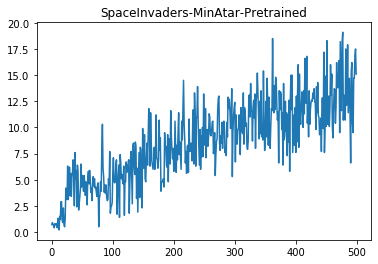

In [13]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('SpaceInvaders-MinAtar-Pretrained')

Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=4rooms')

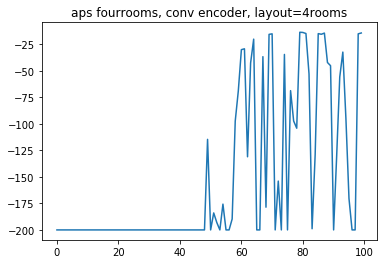

In [17]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=4rooms')

Text(0.5, 1.0, 'aps fourrooms, conv encoder, layout=open')

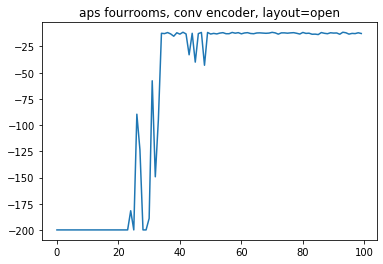

In [14]:
import matplotlib.pyplot as plt

plt.plot(evaluations)
plt.title('aps fourrooms, conv encoder, layout=open')

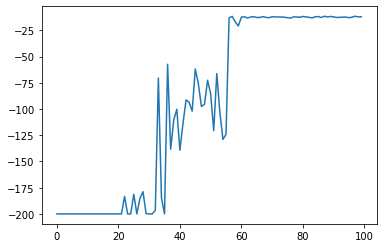

In [70]:
import matplotlib.pyplot as plt

plt.plot(evaluations, title='aps after pretraini')